In [1]:
%matplotlib inline

# Fitting TESS data

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

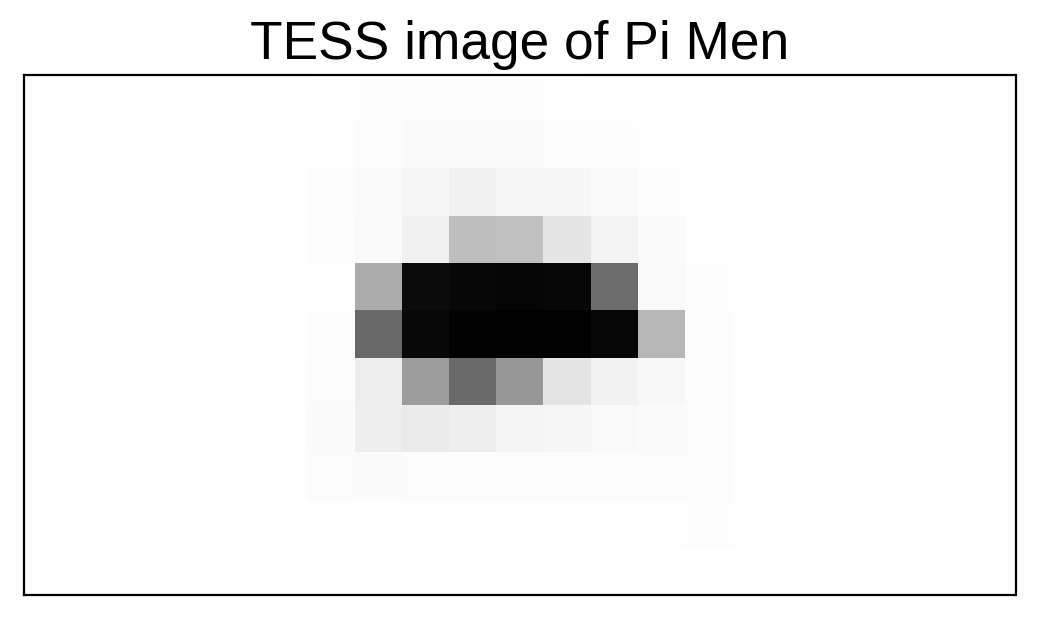

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

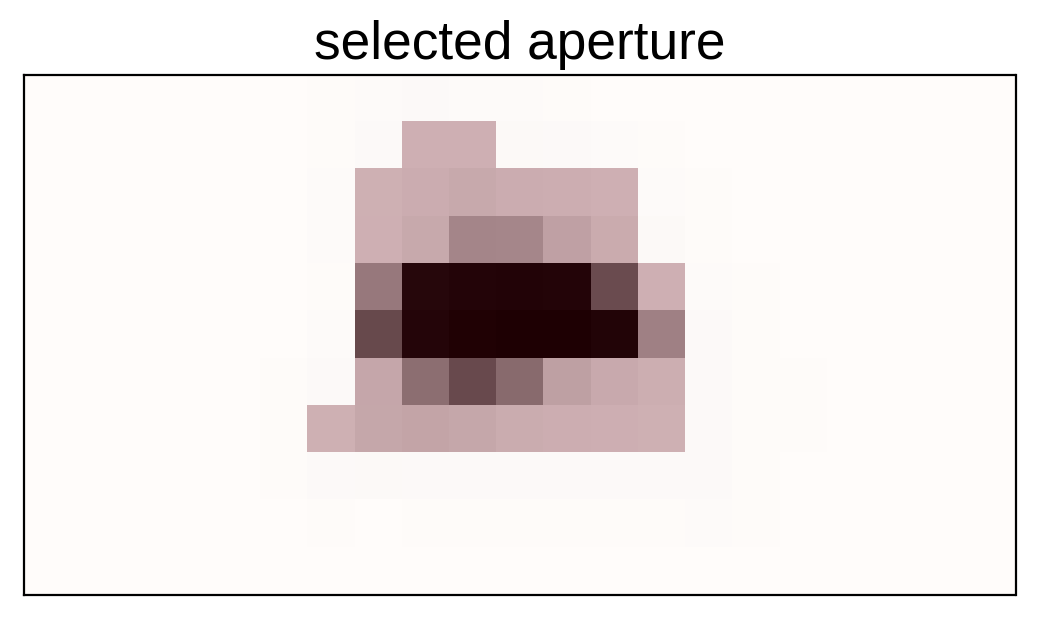

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

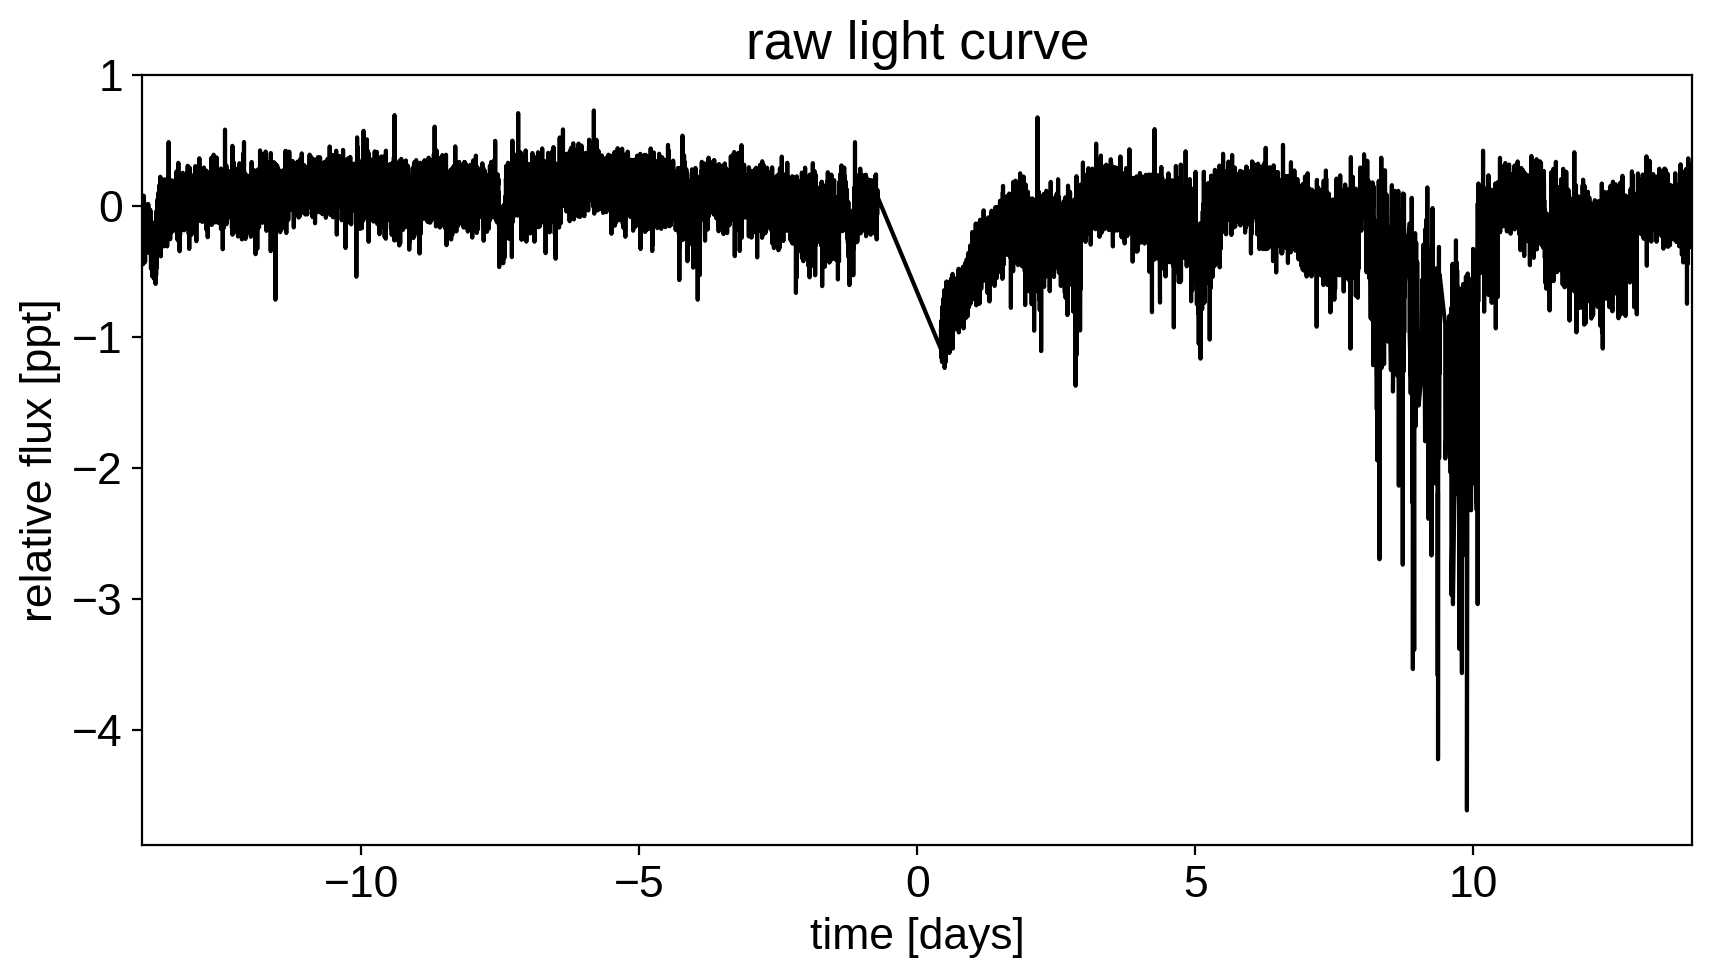

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

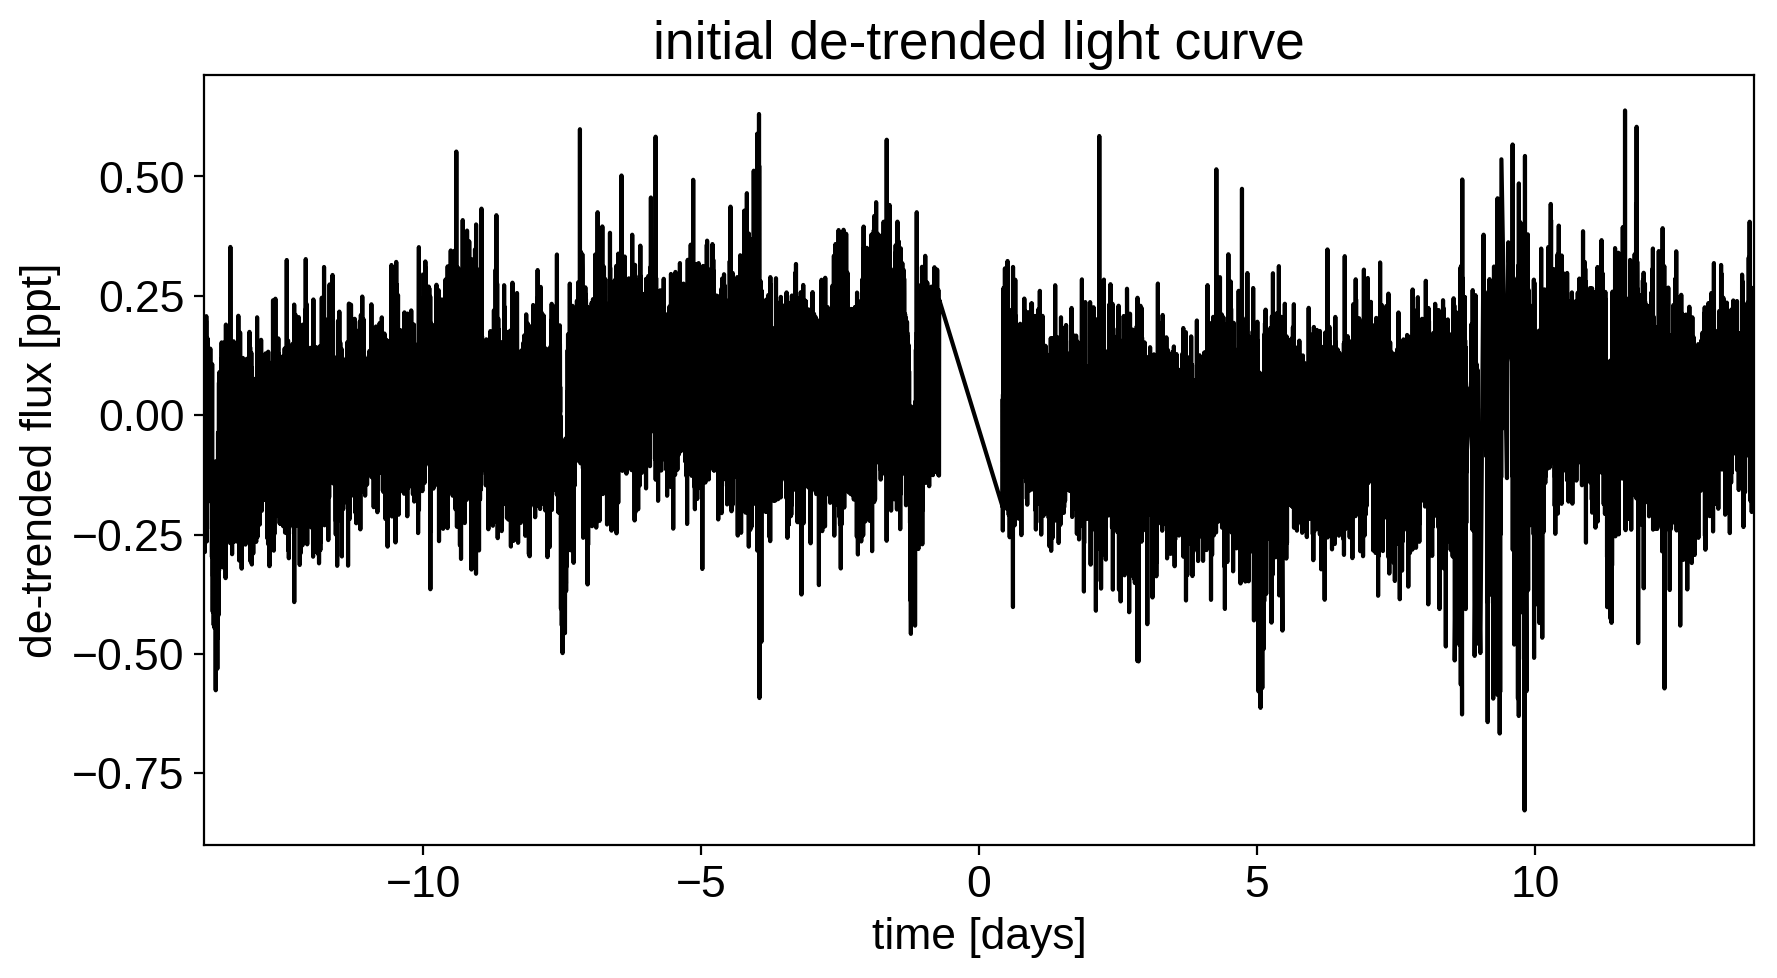

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

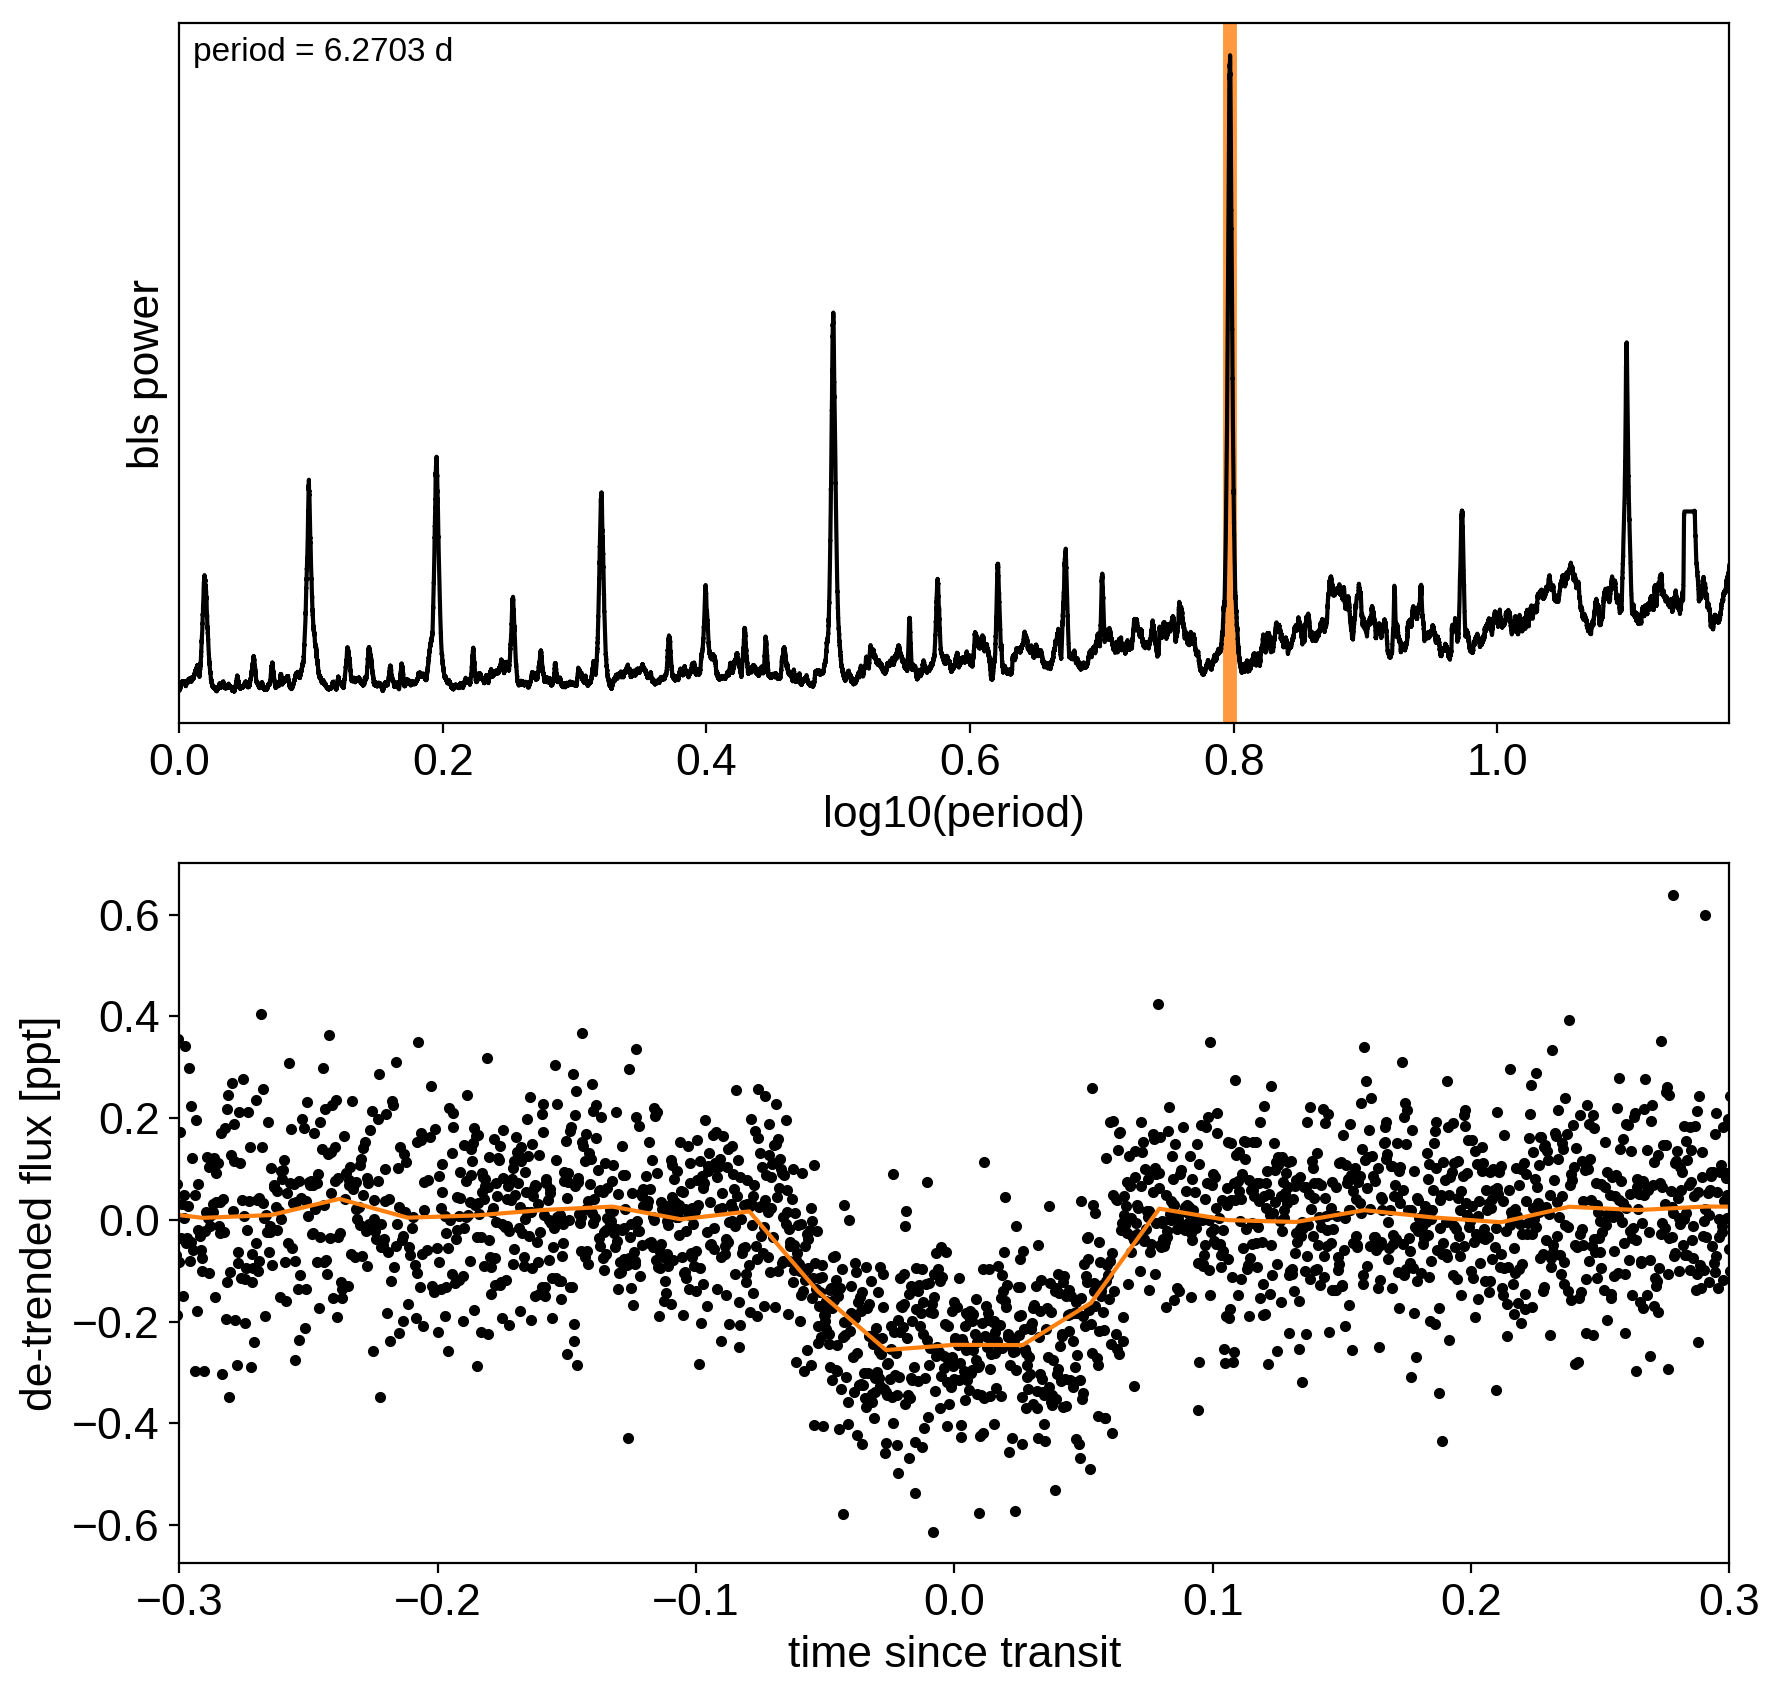

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

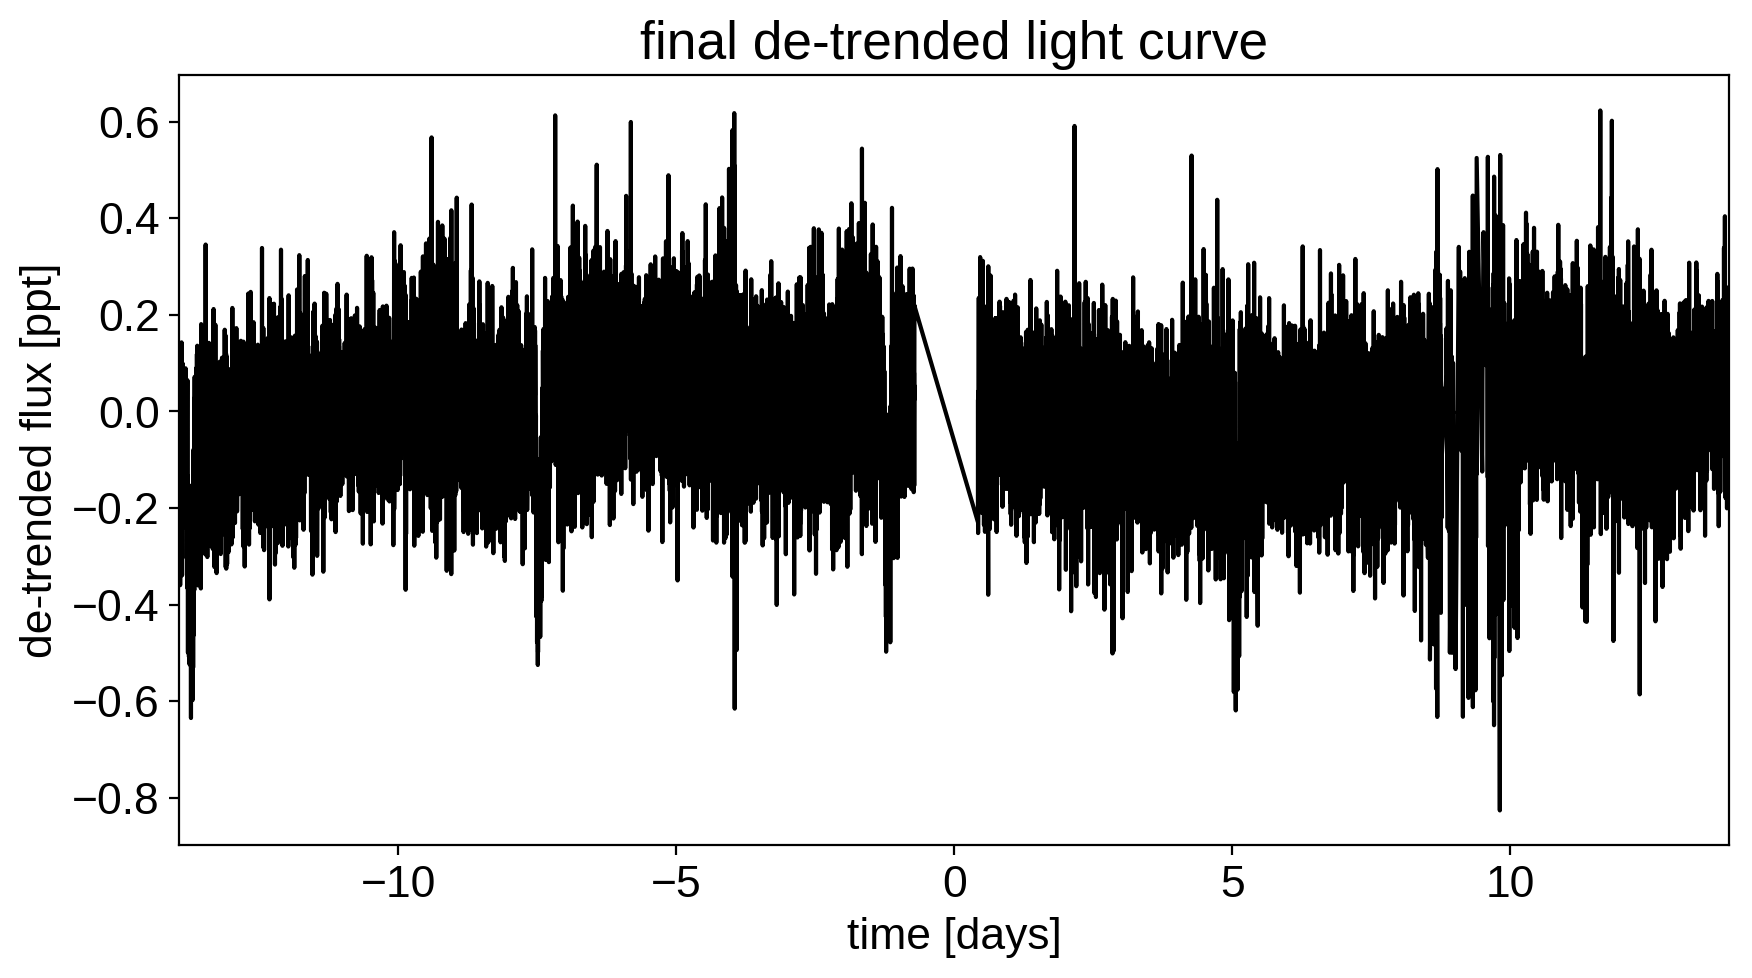

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

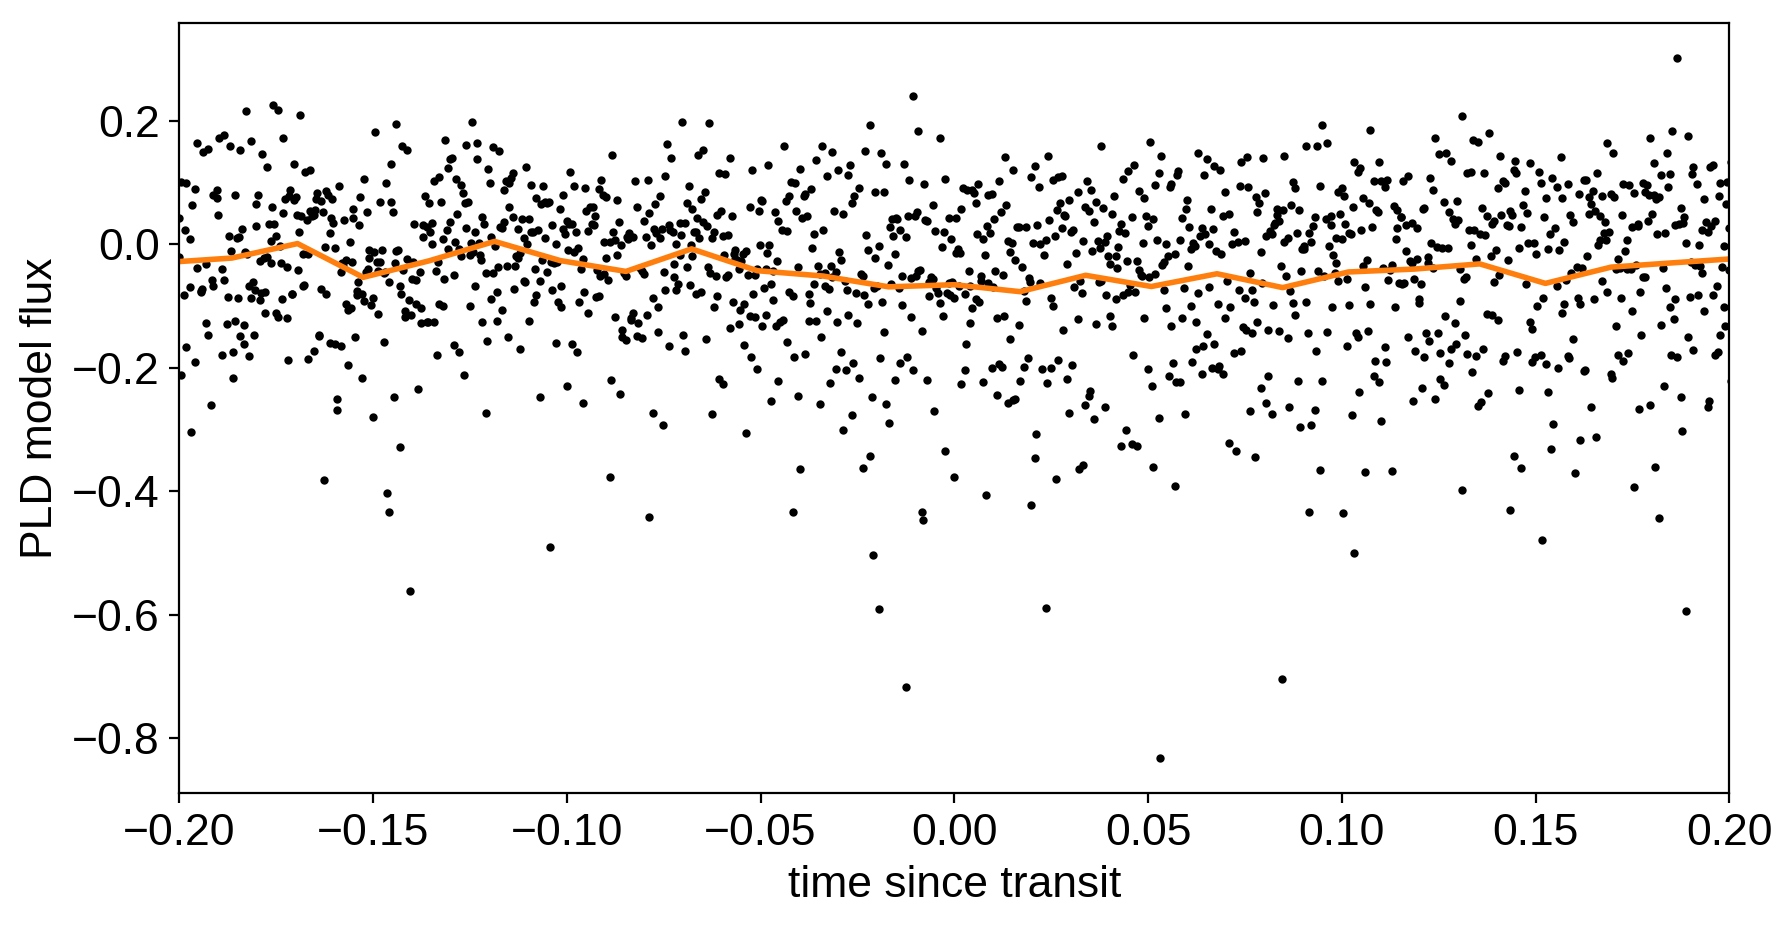

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`, but we'll use a [more informative prior on eccentricity](https://arxiv.org/abs/1306.4982).

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = xo.distributions.UnitUniform("b")
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # The eccentricity must be in the range [0, 1)
        ecc = xo.distributions.UnitUniform("ecc", testval=0.1)
        omega = xo.distributions.Angle("omega")
        
        # Eccentricity prior from: https://arxiv.org/abs/1807.00549
        pm.Potential(
            "ecc_prior", pm.Weibull.dist(alpha=2, beta=np.sqrt(2)*0.26).logp(ecc))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12376.183272550023 -> 12639.371671793535


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12639.371671793535 -> 12677.812242714


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 12677.812242714008 -> 12765.586737126036


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 12765.586737126036 -> 12774.654967517676


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 12774.65496751769 -> 12785.319678070386


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12785.319678070386 -> 12807.908513030887


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 12807.90851303089 -> 12809.61972606025


optimizing logp for variables: ['omega_angle__', 'ecc_logodds__']


message: Optimization terminated successfully.
logp: 12809.61972606025 -> 12830.623548262878


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 12830.623548262867 -> 12830.655065556663


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12830.655065556663 -> 12841.462212039349


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_logodds__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 12841.46221203937 -> 13052.221703921146


Here's how we plot the initial light curve model:

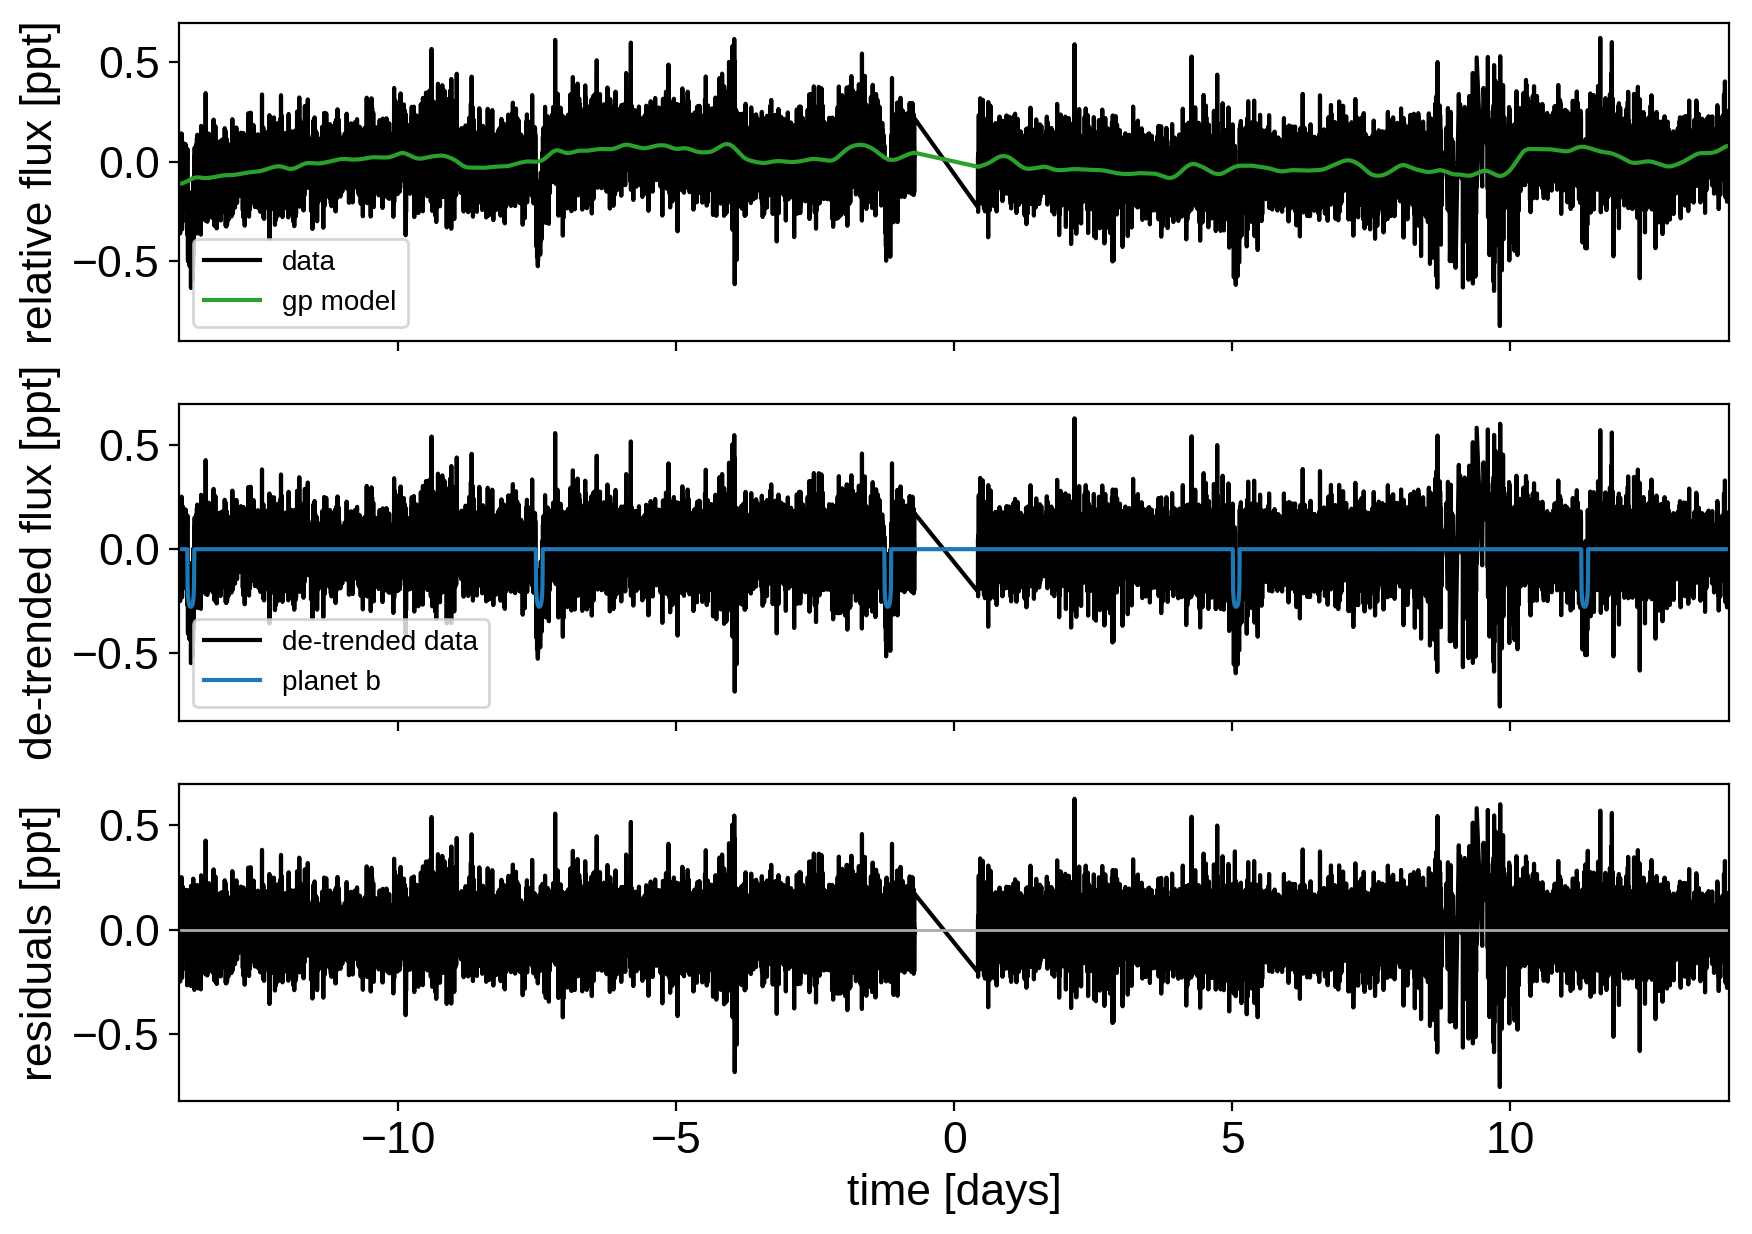

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

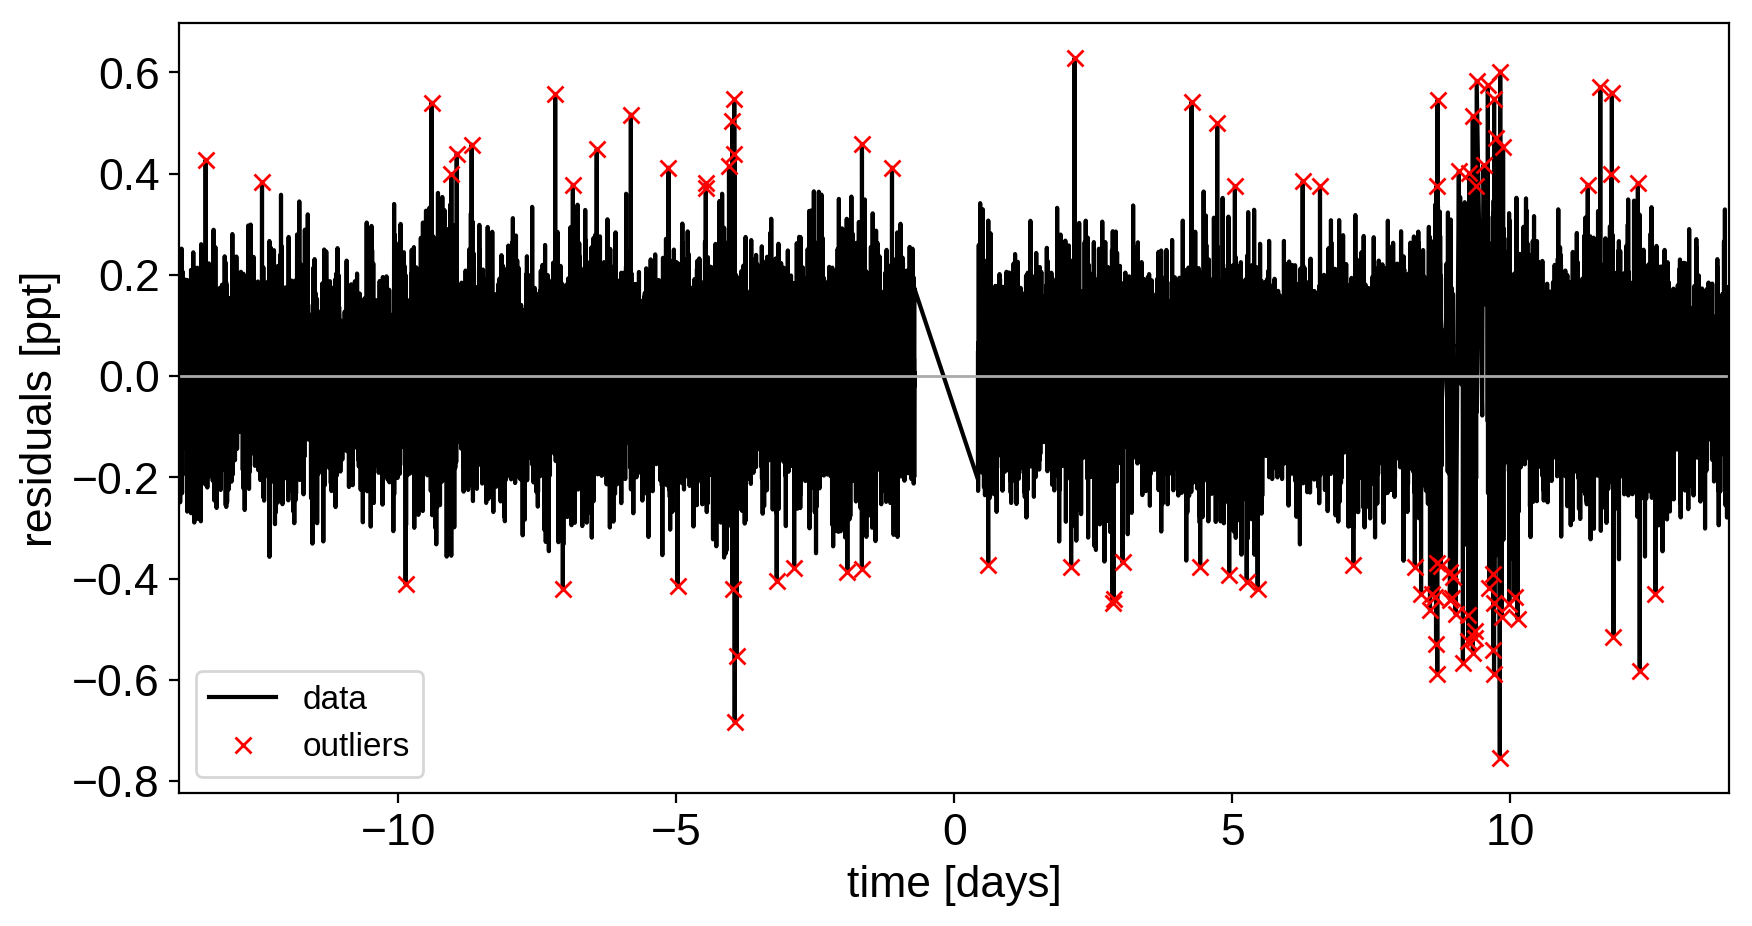

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13706.72696293576 -> 13737.686442861364


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.686442861364 -> 13737.706595640982


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 13737.706595640986 -> 13737.707514531812


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.707514531812 -> 13737.716266234076


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 13737.716266234076 -> 13737.740037737174


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.740037737174 -> 13737.743176359629


optimizing logp for variables: ['b_logodds__']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.743176359625 -> 13737.752052427759


optimizing logp for variables: ['omega_angle__', 'ecc_logodds__']


message: Optimization terminated successfully.
logp: 13737.752052427759 -> 13737.75208980023


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 13737.752089800226 -> 13737.755241338116


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13737.755241338116 -> 13737.755244139364


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_logodds__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.755244139371 -> 13737.767147483966


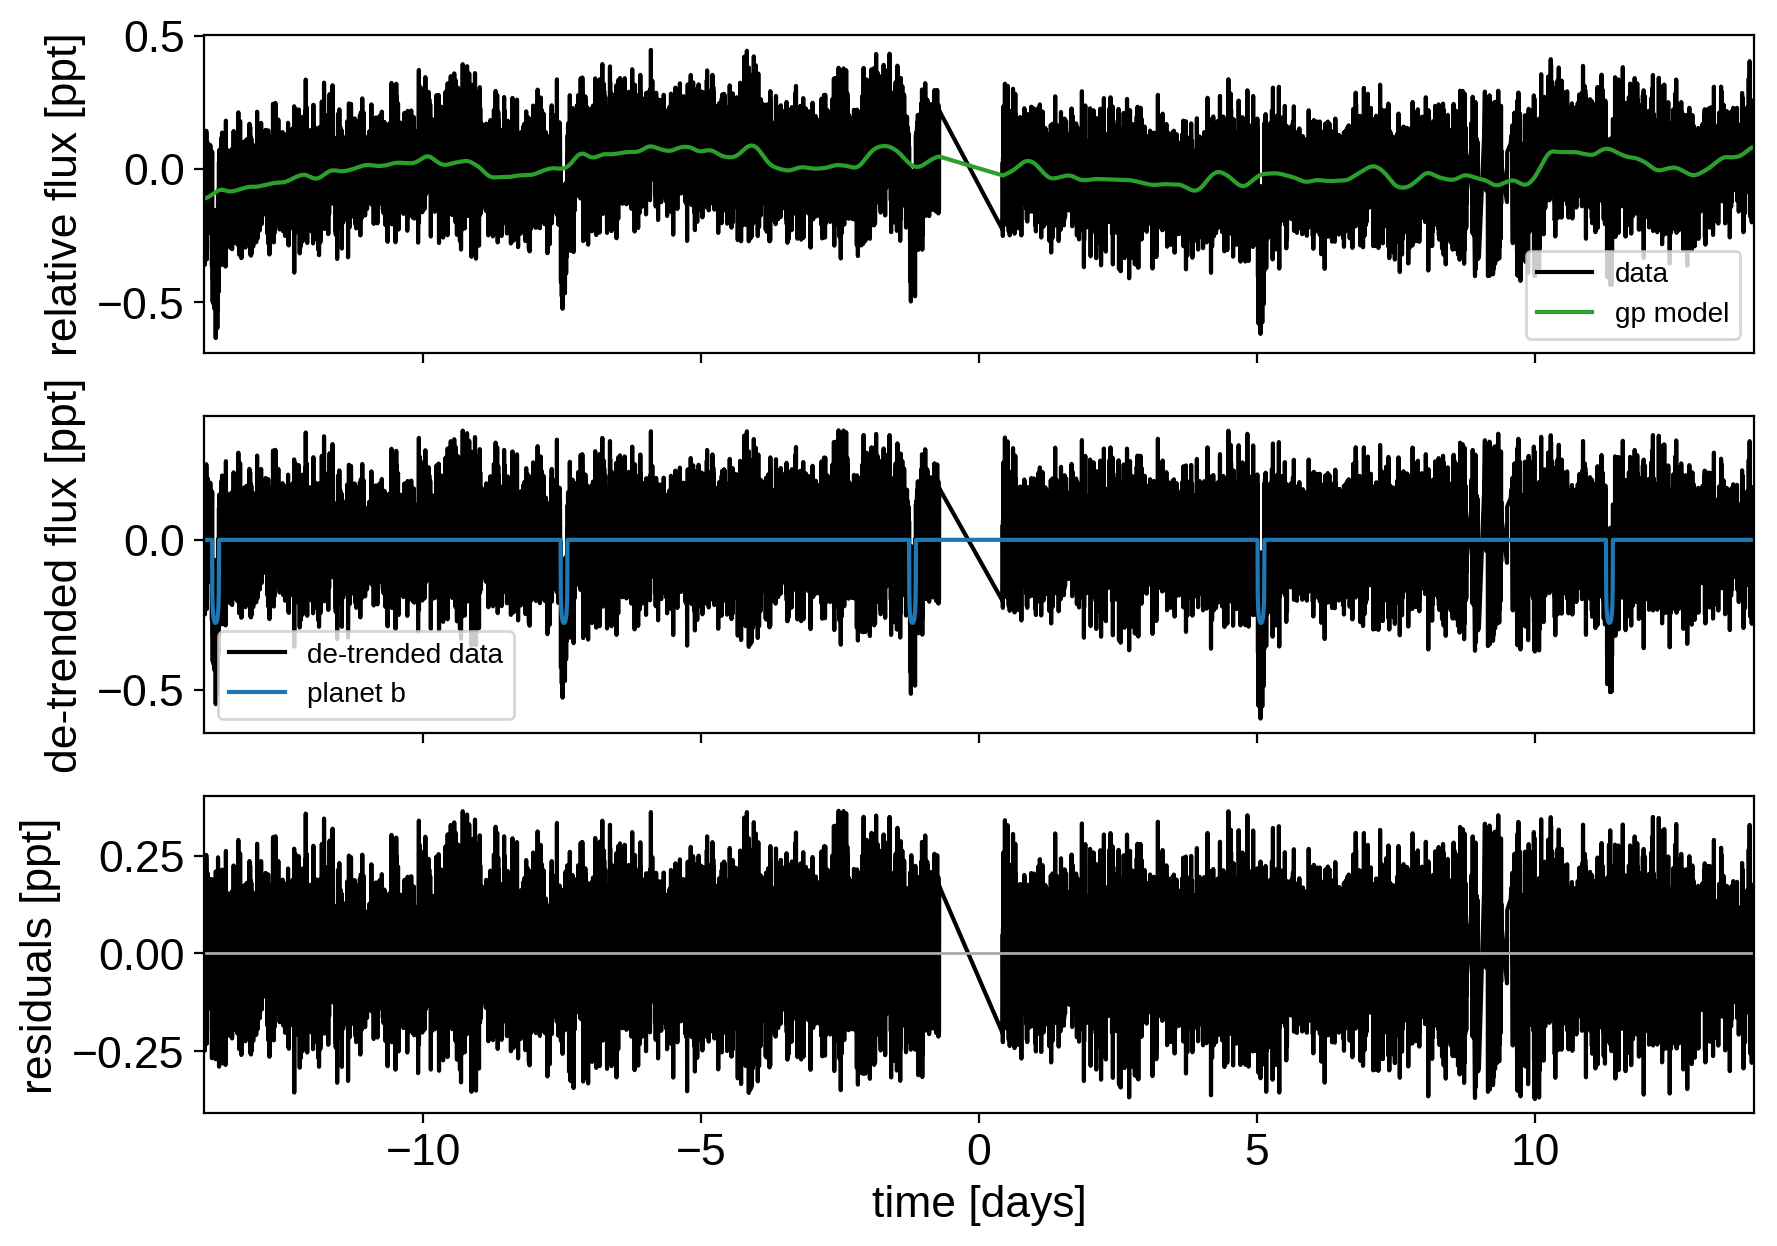

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample it using a :class:`exoplanet.PyMC3Sampler`:

In [14]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:08, 98.85draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:02<01:11, 11.13draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:03<02:41,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:05<03:44,  3.49draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:07<04:26,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:07<03:15,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:09<05:46,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:09<04:13,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:11<06:23,  2.01draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:11<04:41,  2.73draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:13<06:40,  1.91draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:13<04:54,  2.60draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:15<06:45,  1.88draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:15<05:09,  2.46draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:17<06:51,  1.84draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:17<05:07,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:19<06:48,  1.85draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:19<05:06,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:20<06:26,  1.94draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:20<05:06,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:21<03:57,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:22<08:31,  1.46draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:22<06:28,  1.92draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:23<04:55,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:24<09:10,  1.35draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:24<06:52,  1.80draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:24<05:13,  2.36draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:25<05:58,  2.06draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:26<07:33,  1.63draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:26<05:41,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:27<05:34,  2.20draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:28<07:18,  1.67draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:28<05:23,  2.26draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:29<06:45,  1.80draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:30<08:06,  1.50draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:30<05:55,  2.05draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:31<07:10,  1.69draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:32<08:25,  1.44draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:32<06:05,  1.98draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:33<07:18,  1.65draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:34<08:31,  1.41draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:34<06:07,  1.96draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:35<07:21,  1.63draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:36<08:31,  1.40draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:36<07:05,  1.68draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:37<08:17,  1.44draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:38<06:55,  1.71draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:39<08:05,  1.46draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:40<06:48,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:41<06:21,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:41<06:11,  1.90draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:42<05:59,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:43<05:43,  2.04draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:43<05:47,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:44<05:42,  2.04draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:44<05:27,  2.13draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:45<05:40,  2.05draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:46<05:36,  2.06draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:46<05:18,  2.18draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:47<05:38,  2.05draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:48<05:34,  2.07draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:48<05:11,  2.21draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:49<05:33,  2.07draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:50<05:32,  2.07draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:50<04:56,  2.31draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:51<04:28,  2.55draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:52<06:30,  1.75draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:52<05:36,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:52<04:20,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:53<04:11,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:54<07:23,  1.53draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:54<05:34,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:54<04:57,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:55<06:04,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:56<06:05,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:56<05:08,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:56<04:35,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:57<05:52,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:58<05:51,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:58<05:03,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:58<04:27,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:59<05:49,  1.91draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [01:00<05:45,  1.93draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [01:00<05:01,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [01:00<04:21,  2.53draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [01:01<05:50,  1.89draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [01:01<05:39,  1.95draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [01:02<05:01,  2.19draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [01:02<04:17,  2.56draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [01:03<05:50,  1.88draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [01:03<05:35,  1.96draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [01:04<05:02,  2.17draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [01:04<04:14,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [01:05<05:50,  1.87draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [01:05<05:29,  1.98draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [01:06<05:02,  2.16draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [01:06<04:11,  2.59draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [01:07<04:22,  2.47draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [01:07<04:36,  2.35draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [01:08<04:52,  2.21draws/s]

Sampling 4 chains:  20%|██        | 163/808 [01:09<04:52,  2.20draws/s]

Sampling 4 chains:  20%|██        | 164/808 [01:09<04:56,  2.17draws/s]

Sampling 4 chains:  20%|██        | 165/808 [01:10<05:01,  2.13draws/s]

Sampling 4 chains:  21%|██        | 167/808 [01:10<05:01,  2.13draws/s]

Sampling 4 chains:  21%|██        | 168/808 [01:11<05:00,  2.13draws/s]

Sampling 4 chains:  21%|██        | 169/808 [01:11<04:59,  2.14draws/s]

Sampling 4 chains:  21%|██        | 171/808 [01:12<05:01,  2.11draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [01:13<04:59,  2.13draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [01:13<04:54,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [01:14<04:59,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [01:15<04:56,  2.13draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [01:15<04:47,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [01:16<04:56,  2.12draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [01:17<04:54,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [01:17<04:41,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [01:18<04:54,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [01:19<04:50,  2.15draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [01:19<04:34,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [01:20<04:51,  2.13draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:20<04:46,  2.16draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [01:21<04:27,  2.31draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [01:22<04:47,  2.14draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:22<04:43,  2.17draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [01:23<04:21,  2.35draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [01:23<03:47,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:24<05:55,  1.72draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [01:25<05:08,  1.98draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [01:25<04:21,  2.32draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:26<06:16,  1.61draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [01:26<05:18,  1.90draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [01:27<04:31,  2.23draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:28<06:20,  1.59draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [01:28<05:17,  1.90draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [01:29<04:32,  2.20draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [01:30<06:18,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:30<05:12,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:31<04:32,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:32<06:13,  1.59draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:32<05:05,  1.95draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:33<04:29,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:34<04:58,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [01:35<04:26,  2.21draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:36<04:53,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:37<04:25,  2.21draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:38<04:49,  2.01draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:38<04:23,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:39<03:50,  2.51draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:40<04:31,  2.13draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:40<04:16,  2.25draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:41<04:23,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:42<04:51,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:42<04:31,  2.11draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [01:43<04:33,  2.09draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:43<04:54,  1.93draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:44<04:34,  2.07draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:45<04:36,  2.05draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [01:45<04:33,  2.07draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:45<03:29,  2.70draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:46<04:45,  1.98draws/s]

Sampling 4 chains:  30%|███       | 245/808 [01:47<04:43,  1.98draws/s]

Sampling 4 chains:  30%|███       | 246/808 [01:47<04:33,  2.05draws/s]

Sampling 4 chains:  31%|███       | 247/808 [01:47<03:31,  2.66draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:48<04:48,  1.94draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:49<04:44,  1.96draws/s]

Sampling 4 chains:  31%|███       | 250/808 [01:49<04:30,  2.06draws/s]

Sampling 4 chains:  31%|███       | 251/808 [01:49<03:28,  2.67draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:50<04:49,  1.92draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [01:50<04:45,  1.95draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [01:51<04:25,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:51<03:26,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [01:52<04:50,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:52<03:52,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:52<03:35,  2.56draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:53<03:32,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [01:53<02:49,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [01:54<04:55,  1.85draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [01:54<04:18,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [01:55<03:58,  2.29draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [01:55<03:08,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:56<05:10,  1.75draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [01:56<04:29,  2.01draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:56<04:01,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [01:57<03:11,  2.83draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [01:58<05:14,  1.71draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [01:58<04:31,  1.98draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [01:58<03:58,  2.25draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [01:58<03:09,  2.83draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [02:00<05:15,  1.70draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [02:00<04:31,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [02:00<03:54,  2.28draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [02:00<03:07,  2.84draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [02:02<05:15,  1.68draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [02:02<04:31,  1.96draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [02:02<03:50,  2.29draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [02:02<03:04,  2.87draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [02:03<05:14,  1.67draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [02:04<04:30,  1.95draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [02:04<03:46,  2.32draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [02:04<03:01,  2.89draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [02:05<05:15,  1.66draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [02:06<04:29,  1.94draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [02:06<03:42,  2.34draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [02:06<02:58,  2.92draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [02:07<05:15,  1.64draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [02:08<04:29,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [02:08<03:38,  2.37draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [02:08<02:55,  2.94draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [02:09<05:15,  1.63draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [02:09<04:28,  1.91draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [02:10<03:34,  2.40draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [02:10<02:53,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [02:11<05:15,  1.62draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [02:11<04:27,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [02:12<03:30,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [02:12<02:50,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [02:13<05:14,  1.61draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [02:13<04:27,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [02:13<03:25,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [02:14<02:47,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [02:15<05:13,  1.60draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [02:15<04:27,  1.88draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [02:15<03:25,  2.43draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [02:17<05:41,  1.46draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [02:17<04:46,  1.74draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [02:17<03:37,  2.28draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [02:19<05:51,  1.41draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [02:19<04:53,  1.68draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [02:19<03:40,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [02:21<05:55,  1.38draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [02:21<04:55,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [02:21<03:39,  2.22draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [02:22<04:17,  1.89draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [02:23<05:25,  1.49draws/s]

Sampling 4 chains:  40%|████      | 324/808 [02:23<03:59,  2.02draws/s]

Sampling 4 chains:  40%|████      | 325/808 [02:24<04:32,  1.77draws/s]

Sampling 4 chains:  40%|████      | 326/808 [02:25<05:33,  1.45draws/s]

Sampling 4 chains:  41%|████      | 328/808 [02:25<04:04,  1.96draws/s]

Sampling 4 chains:  41%|████      | 329/808 [02:26<04:37,  1.72draws/s]

Sampling 4 chains:  41%|████      | 330/808 [02:26<05:20,  1.49draws/s]

Sampling 4 chains:  41%|████      | 332/808 [02:27<04:01,  1.97draws/s]

Sampling 4 chains:  41%|████      | 333/808 [02:27<04:38,  1.71draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [02:28<05:20,  1.48draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [02:29<03:59,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [02:29<04:38,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [02:30<05:21,  1.46draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [02:30<03:58,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [02:31<04:41,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [02:32<05:21,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [02:32<03:57,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [02:33<04:47,  1.61draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [02:34<05:14,  1.47draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [02:34<03:53,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [02:35<04:46,  1.60draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [02:36<05:09,  1.48draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [02:36<03:49,  1.99draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [02:37<04:45,  1.60draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [02:38<05:03,  1.49draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [02:38<03:48,  1.98draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [02:39<03:47,  1.98draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [02:40<04:19,  1.73draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [02:40<03:20,  2.24draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [02:41<03:27,  2.15draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [02:42<04:02,  1.84draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:42<03:11,  2.33draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:43<03:20,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:44<03:53,  1.90draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [02:44<03:07,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:45<03:16,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:45<03:47,  1.93draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:46<03:06,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:47<03:15,  2.23draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [02:47<03:42,  1.95draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:47<03:04,  2.35draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [02:48<03:14,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:49<03:39,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [02:49<03:00,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [02:50<02:31,  2.81draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [02:50<03:06,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [02:51<03:58,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [02:52<03:11,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [02:52<03:36,  1.95draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [02:53<04:15,  1.65draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [02:54<03:23,  2.06draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [02:54<03:45,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [02:55<04:19,  1.61draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [02:55<03:25,  2.02draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [02:56<03:48,  1.81draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [02:57<04:19,  1.59draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [02:57<03:24,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [02:58<03:49,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [02:59<04:17,  1.59draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [02:59<03:12,  2.11draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [02:59<02:48,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [03:00<03:25,  1.97draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [03:01<03:57,  1.70draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [03:01<03:01,  2.23draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [03:01<02:37,  2.56draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [03:02<03:19,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [03:03<03:50,  1.74draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [03:03<02:57,  2.25draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [03:03<02:33,  2.60draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [03:04<03:17,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [03:04<03:46,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [03:05<02:56,  2.24draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [03:05<02:30,  2.63draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [03:06<03:16,  2.01draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [03:06<03:42,  1.76draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [03:06<02:55,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [03:07<02:27,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [03:07<03:15,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [03:08<03:39,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [03:08<02:55,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [03:09<02:24,  2.68draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [03:09<03:14,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [03:10<03:36,  1.78draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [03:10<02:54,  2.20draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [03:10<02:21,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [03:11<03:13,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [03:12<03:33,  1.79draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [03:12<02:53,  2.19draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [03:12<02:18,  2.74draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [03:13<02:58,  2.12draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [03:13<02:19,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [03:14<03:18,  1.89draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [03:14<02:33,  2.45draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [03:15<03:08,  1.99draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [03:15<02:27,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [03:16<03:24,  1.82draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [03:16<02:34,  2.41draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [03:17<03:08,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [03:17<02:29,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [03:18<03:24,  1.80draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [03:19<03:07,  1.96draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [03:19<02:19,  2.60draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [03:20<03:23,  1.79draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [03:21<03:42,  1.63draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [03:21<02:44,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [03:22<03:37,  1.65draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [03:22<03:51,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [03:23<02:52,  2.07draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [03:24<03:39,  1.62draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [03:24<03:52,  1.52draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [03:25<02:53,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [03:26<03:37,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [03:26<03:25,  1.71draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [03:26<02:49,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [03:27<02:56,  1.97draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [03:28<02:57,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [03:28<02:28,  2.33draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [03:29<02:18,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [03:30<03:17,  1.73draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [03:30<02:40,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [03:31<02:26,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [03:32<03:23,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [03:32<02:39,  2.11draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [03:32<01:58,  2.84draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [03:34<04:01,  1.38draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [03:34<03:04,  1.80draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [03:34<02:16,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [03:36<04:11,  1.31draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [03:36<03:10,  1.73draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [03:36<02:20,  2.32draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [03:37<02:45,  1.96draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [03:38<03:35,  1.51draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [03:38<02:38,  2.03draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [03:38<02:57,  1.82draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [03:39<03:40,  1.46draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [03:40<02:43,  1.95draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [03:40<02:58,  1.78draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [03:41<03:38,  1.45draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [03:42<02:43,  1.93draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [03:42<02:56,  1.77draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [03:43<03:35,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [03:43<02:41,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [03:44<02:54,  1.78draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [03:45<03:30,  1.47draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [03:45<02:39,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [03:46<02:50,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [03:47<03:26,  1.48draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [03:47<02:37,  1.93draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [03:48<02:48,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [03:49<03:21,  1.49draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [03:49<02:34,  1.93draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [03:50<02:45,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [03:51<03:17,  1.51draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [03:51<02:31,  1.94draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [03:52<02:43,  1.80draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [03:53<03:13,  1.52draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [03:53<02:29,  1.95draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [03:54<02:40,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [03:54<03:08,  1.53draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [03:55<02:27,  1.95draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [03:55<02:38,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [03:56<03:04,  1.54draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [03:57<02:24,  1.96draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [03:57<02:35,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [03:58<03:00,  1.56draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [03:59<02:22,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [03:59<02:32,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [04:00<02:56,  1.57draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [04:01<02:19,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [04:01<02:30,  1.83draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [04:02<02:52,  1.58draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [04:02<02:17,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [04:03<02:27,  1.83draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [04:04<02:48,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [04:04<02:15,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [04:05<02:24,  1.84draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [04:06<02:44,  1.61draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [04:06<02:13,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [04:07<02:21,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [04:08<02:40,  1.63draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [04:08<02:10,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [04:09<02:19,  1.86draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [04:10<02:36,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [04:10<02:08,  1.99draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [04:11<02:16,  1.86draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [04:11<02:00,  2.10draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [04:11<01:55,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [04:12<01:41,  2.47draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [04:13<01:54,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [04:13<01:45,  2.36draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [04:13<01:49,  2.25draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [04:14<01:50,  2.22draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [04:14<02:01,  2.01draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [04:15<01:49,  2.22draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [04:15<01:40,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [04:15<01:22,  2.93draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [04:16<01:32,  2.59draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [04:17<02:11,  1.83draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [04:17<01:54,  2.09draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [04:17<01:32,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [04:18<01:42,  2.32draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [04:19<02:13,  1.77draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [04:19<01:55,  2.04draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [04:19<01:31,  2.55draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [04:20<01:46,  2.19draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [04:21<02:11,  1.77draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [04:21<01:53,  2.04draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [04:21<01:28,  2.58draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [04:22<01:47,  2.13draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [04:22<02:08,  1.77draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [04:23<01:51,  2.04draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [04:23<01:26,  2.62draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [04:24<01:48,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [04:24<02:05,  1.78draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [04:25<01:48,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [04:25<01:23,  2.65draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [04:26<01:48,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [04:26<02:02,  1.79draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [04:27<01:45,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [04:27<01:21,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [04:28<01:49,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [04:28<01:59,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [04:28<01:43,  2.08draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [04:29<01:18,  2.72draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [04:29<01:48,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [04:30<01:57,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [04:30<01:40,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [04:31<01:40,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [04:32<01:48,  1.91draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [04:32<01:34,  2.18draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [04:33<01:37,  2.11draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [04:34<01:42,  1.98draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [04:34<01:30,  2.25draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [04:35<01:34,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [04:36<01:38,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [04:36<01:26,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [04:37<01:31,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [04:38<01:34,  2.06draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [04:38<01:23,  2.32draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [04:39<01:29,  2.17draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [04:40<01:32,  2.08draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [04:40<01:21,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [04:41<01:27,  2.17draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [04:42<01:30,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [04:42<01:19,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [04:43<01:26,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [04:43<01:26,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [04:44<01:17,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [04:45<01:23,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [04:45<01:24,  2.12draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [04:46<01:15,  2.39draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [04:47<01:21,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [04:47<01:22,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [04:48<01:12,  2.41draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [04:49<01:19,  2.18draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [04:49<01:20,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [04:49<01:10,  2.43draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [04:51<01:17,  2.18draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [04:51<01:18,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [04:51<01:07,  2.46draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [04:52<01:15,  2.19draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [04:53<01:16,  2.14draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [04:53<01:05,  2.48draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [04:54<01:13,  2.19draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [04:55<01:14,  2.14draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [04:55<01:03,  2.51draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [04:56<01:11,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [04:57<01:12,  2.15draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [04:57<01:00,  2.54draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [04:58<01:09,  2.21draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [04:59<00:59,  2.55draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [04:59<00:50,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [05:00<01:28,  1.69draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [05:01<01:12,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [05:01<00:58,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [05:02<01:33,  1.55draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [05:02<01:15,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [05:03<00:59,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [05:04<01:33,  1.51draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [05:04<01:08,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [05:04<01:00,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [05:06<01:39,  1.38draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [05:06<01:12,  1.86draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [05:06<01:03,  2.13draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [05:08<01:39,  1.33draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [05:08<01:12,  1.81draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [05:08<01:02,  2.07draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [05:10<01:39,  1.30draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [05:10<01:14,  1.73draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [05:10<00:57,  2.20draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [05:12<01:34,  1.33draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [05:12<01:09,  1.78draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [05:12<00:54,  2.25draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [05:13<01:30,  1.34draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [05:14<01:06,  1.80draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [05:14<00:51,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [05:15<01:27,  1.34draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [05:16<01:03,  1.82draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [05:16<00:52,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [05:17<01:26,  1.31draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [05:17<01:02,  1.78draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [05:18<00:51,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [05:19<01:24,  1.29draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [05:19<01:00,  1.77draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [05:20<00:50,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [05:21<01:21,  1.29draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [05:21<00:58,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [05:22<00:48,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [05:23<01:18,  1.29draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [05:23<00:56,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [05:23<00:46,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [05:25<01:15,  1.29draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [05:25<00:54,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [05:25<00:44,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [05:27<01:12,  1.28draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [05:27<00:51,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [05:27<00:42,  2.10draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [05:29<01:09,  1.29draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [05:29<00:49,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [05:29<00:40,  2.10draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [05:31<01:05,  1.29draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [05:31<00:47,  1.76draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [05:31<00:39,  2.09draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [05:33<01:02,  1.30draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [05:33<00:44,  1.76draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [05:33<00:37,  2.09draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [05:34<00:59,  1.30draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [05:35<00:42,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [05:35<00:35,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [05:36<00:55,  1.31draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [05:36<00:40,  1.77draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [05:37<00:33,  2.10draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [05:38<00:52,  1.32draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [05:38<00:37,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [05:39<00:31,  2.10draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [05:40<00:49,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [05:40<00:35,  1.78draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [05:41<00:29,  2.11draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [05:42<00:45,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [05:42<00:33,  1.79draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [05:42<00:25,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [05:42<00:22,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [05:44<00:38,  1.47draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [05:44<00:28,  1.94draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [05:44<00:21,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [05:44<00:19,  2.78draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [05:46<00:35,  1.51draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [05:46<00:26,  1.98draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [05:46<00:19,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [05:46<00:17,  2.82draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [05:48<00:32,  1.52draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [05:48<00:24,  1.99draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [05:48<00:18,  2.56draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [05:48<00:16,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [05:50<00:29,  1.52draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [05:50<00:22,  1.98draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [05:50<00:16,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [05:50<00:14,  2.83draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [05:51<00:26,  1.53draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [05:52<00:20,  1.99draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [05:52<00:15,  2.53draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [05:52<00:13,  2.84draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [05:53<00:24,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [05:53<00:18,  1.99draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [05:54<00:13,  2.55draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [05:54<00:11,  2.83draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [05:55<00:21,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [05:55<00:16,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [05:56<00:12,  2.57draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [05:56<00:10,  2.83draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [05:57<00:16,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [05:57<00:13,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [05:57<00:10,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [05:58<00:10,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [05:59<00:15,  1.66draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [05:59<00:11,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [05:59<00:09,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [06:00<00:08,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [06:01<00:12,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [06:01<00:09,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [06:01<00:07,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [06:02<00:07,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [06:03<00:10,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [06:03<00:07,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [06:03<00:06,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [06:03<00:05,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [06:05<00:08,  1.48draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [06:05<00:06,  1.86draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [06:05<00:05,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [06:07<00:07,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [06:07<00:06,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [06:09<00:06,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [06:10<00:07,  1.10s/draws]

Sampling 4 chains:  99%|█████████▉| 802/808 [06:13<00:08,  1.50s/draws]

Sampling 4 chains:  99%|█████████▉| 803/808 [06:15<00:08,  1.73s/draws]

Sampling 4 chains: 100%|█████████▉| 804/808 [06:16<00:06,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 805/808 [06:18<00:04,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 806/808 [06:20<00:03,  1.89s/draws]

Sampling 4 chains: 100%|█████████▉| 807/808 [06:22<00:01,  1.94s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [06:24<00:00,  1.74s/draws]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 11/408 [00:00<00:03, 105.11draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:04, 82.87draws/s] 

Sampling 4 chains:   5%|▌         | 21/408 [00:02<00:57,  6.68draws/s]

Sampling 4 chains:   6%|▌         | 24/408 [00:02<00:49,  7.79draws/s]

Sampling 4 chains:   7%|▋         | 27/408 [00:04<01:41,  3.76draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:05<02:54,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:06<02:09,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:07<03:05,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:08<02:20,  2.66draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:09<04:46,  1.30draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:09<03:26,  1.78draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:11<04:31,  1.35draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:11<03:52,  1.57draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:11<02:58,  2.05draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:11<02:10,  2.78draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:12<02:26,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:12<03:00,  2.00draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:13<02:48,  2.13draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:13<02:27,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:14<02:36,  2.28draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:14<03:07,  1.91draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:15<02:30,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:15<02:36,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:16<02:42,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:16<03:09,  1.86draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:16<02:32,  2.31draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:17<02:36,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:17<02:42,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:18<03:08,  1.85draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:18<02:31,  2.29draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:19<02:35,  2.23draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:19<02:13,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:19<02:00,  2.85draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:20<02:37,  2.19draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:20<02:02,  2.80draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:21<02:05,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:22<03:07,  1.82draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:22<02:23,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:23<02:19,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:24<03:15,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:24<02:29,  2.24draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:25<02:23,  2.32draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:26<03:20,  1.66draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:26<02:28,  2.22draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:27<02:53,  1.90draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:28<03:40,  1.48draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:28<02:42,  2.01draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:28<02:51,  1.90draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:30<03:49,  1.41draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:30<02:47,  1.92draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:30<02:06,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:30<02:05,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:31<03:16,  1.61draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:32<02:40,  1.98draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:32<02:02,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:32<02:02,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:33<03:14,  1.61draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:34<02:37,  1.99draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:34<02:00,  2.60draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:34<02:01,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:35<03:12,  1.61draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:35<02:34,  2.00draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:36<01:58,  2.61draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:37<02:34,  1.98draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:37<02:06,  2.42draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:37<01:38,  3.10draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:39<01:56,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:39<01:33,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:39<01:09,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:41<03:11,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:41<02:29,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:41<01:48,  2.70draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:43<02:33,  1.90draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:43<01:51,  2.59draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:45<02:34,  1.86draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:45<01:56,  2.46draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:47<02:31,  1.87draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:47<01:56,  2.42draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:47<01:26,  3.26draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:49<02:09,  2.15draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:49<01:47,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:49<01:19,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:51<03:06,  1.47draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:51<02:25,  1.88draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:51<01:45,  2.57draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:53<02:25,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:53<01:45,  2.54draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:54<02:18,  1.92draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:55<01:47,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:56<01:56,  2.25draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:56<01:37,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:56<01:26,  3.00draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:56<01:30,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:58<02:26,  1.77draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:58<01:52,  2.29draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:58<01:32,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:59<02:51,  1.49draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [01:00<02:09,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [01:00<01:43,  2.43draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [01:01<02:57,  1.42draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [01:02<02:16,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [01:02<01:47,  2.32draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [01:03<02:29,  1.65draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [01:03<02:12,  1.86draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [01:03<01:46,  2.29draws/s]

Sampling 4 chains:  40%|████      | 164/408 [01:04<01:36,  2.52draws/s]

Sampling 4 chains:  40%|████      | 165/408 [01:04<01:15,  3.22draws/s]

Sampling 4 chains:  41%|████      | 166/408 [01:05<01:40,  2.41draws/s]

Sampling 4 chains:  41%|████      | 167/408 [01:05<01:30,  2.68draws/s]

Sampling 4 chains:  41%|████      | 168/408 [01:06<02:04,  1.93draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [01:06<01:53,  2.10draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [01:07<01:39,  2.39draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [01:08<02:09,  1.82draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [01:08<01:56,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [01:09<01:43,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [01:09<02:09,  1.80draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [01:10<01:37,  2.38draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [01:10<01:52,  2.04draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [01:11<01:43,  2.22draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [01:11<02:02,  1.87draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [01:12<01:51,  2.02draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [01:12<01:43,  2.18draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [01:13<01:20,  2.78draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [01:13<01:35,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [01:14<01:45,  2.09draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [01:14<01:21,  2.70draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [01:15<01:35,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [01:16<01:42,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [01:16<01:17,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [01:17<01:34,  2.26draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [01:18<02:14,  1.58draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [01:18<01:39,  2.13draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [01:19<01:49,  1.92draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [01:20<01:49,  1.90draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [01:21<01:33,  2.21draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [01:21<01:21,  2.50draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [01:22<01:28,  2.28draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [01:22<01:36,  2.09draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [01:23<01:23,  2.40draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [01:24<01:30,  2.20draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [01:25<01:18,  2.50draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [01:25<00:58,  3.32draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [01:26<02:02,  1.57draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [01:27<01:41,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [01:27<01:15,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [01:28<01:24,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [01:29<01:08,  2.71draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [01:29<00:50,  3.65draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [01:30<02:03,  1.49draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [01:30<01:35,  1.91draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [01:31<01:09,  2.59draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [01:32<02:13,  1.34draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [01:32<01:42,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [01:33<01:14,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [01:33<00:59,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [01:33<01:10,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [01:34<01:36,  1.79draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [01:34<01:14,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [01:35<01:05,  2.59draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [01:35<01:14,  2.26draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [01:35<00:58,  2.87draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [01:36<01:26,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [01:37<01:13,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [01:37<01:20,  2.06draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [01:37<01:01,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [01:38<01:27,  1.86draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [01:38<01:13,  2.19draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [01:39<01:20,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [01:39<01:01,  2.60draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [01:39<00:52,  3.02draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [01:40<01:22,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [01:41<01:26,  1.82draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [01:41<01:05,  2.40draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [01:41<00:54,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [01:42<01:14,  2.06draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [01:43<01:28,  1.73draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [01:43<01:06,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [01:43<00:54,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [01:43<00:46,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [01:44<00:59,  2.51draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [01:45<01:17,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [01:45<01:06,  2.21draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [01:45<00:55,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [01:46<01:04,  2.26draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [01:47<01:19,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [01:47<01:07,  2.12draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [01:47<00:55,  2.54draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [01:48<01:03,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [01:49<01:18,  1.78draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [01:49<01:03,  2.19draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [01:49<00:49,  2.77draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [01:50<00:58,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [01:51<01:22,  1.63draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [01:51<01:02,  2.14draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [01:52<01:06,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [01:52<01:17,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [01:53<01:04,  2.03draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [01:53<01:00,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [01:54<00:59,  2.12draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [01:54<00:53,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [01:55<00:47,  2.62draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [01:55<00:48,  2.55draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [01:56<00:50,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [01:56<00:46,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [01:56<00:42,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [01:57<00:59,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [01:58<00:56,  2.07draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [01:58<00:51,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [01:58<00:45,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [01:59<01:00,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [02:00<00:57,  1.99draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [02:00<00:50,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [02:00<00:45,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [02:01<00:59,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [02:02<00:56,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [02:02<00:50,  2.16draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [02:02<00:43,  2.50draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [02:03<00:52,  2.04draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [02:03<00:42,  2.52draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [02:03<00:35,  2.92draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [02:05<01:04,  1.60draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [02:05<00:50,  2.00draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [02:05<00:41,  2.44draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [02:06<00:43,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [02:07<00:53,  1.85draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [02:07<00:43,  2.24draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [02:08<00:42,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [02:09<00:51,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [02:09<00:41,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [02:10<00:39,  2.32draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [02:10<00:30,  3.00draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [02:10<00:41,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [02:11<00:35,  2.46draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [02:11<00:44,  1.97draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [02:12<00:41,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [02:13<00:35,  2.35draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [02:13<00:43,  1.92draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [02:14<00:40,  2.02draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [02:14<00:34,  2.31draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [02:15<00:41,  1.91draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [02:16<00:38,  2.01draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [02:16<00:34,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [02:17<00:39,  1.91draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [02:18<00:36,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [02:18<00:28,  2.49draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [02:19<00:35,  1.95draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [02:19<00:32,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [02:20<00:31,  2.18draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [02:20<00:28,  2.37draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [02:21<00:34,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [02:21<00:31,  2.09draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [02:22<00:25,  2.48draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [02:23<00:37,  1.66draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [02:23<00:32,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [02:24<00:25,  2.29draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [02:25<00:30,  1.87draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [02:26<00:24,  2.24draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [02:27<00:25,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [02:27<00:22,  2.34draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [02:28<00:18,  2.70draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [02:29<00:30,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [02:29<00:24,  1.97draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [02:29<00:19,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [02:30<00:19,  2.25draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [02:31<00:23,  1.87draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [02:31<00:18,  2.30draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [02:31<00:18,  2.30draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [02:32<00:18,  2.23draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [02:33<00:17,  2.28draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [02:33<00:18,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [02:34<00:17,  2.10draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [02:35<00:16,  2.16draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [02:35<00:16,  2.05draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [02:36<00:15,  2.08draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [02:37<00:14,  2.13draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [02:37<00:11,  2.53draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [02:37<00:10,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [02:37<00:11,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [02:38<00:15,  1.80draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [02:39<00:11,  2.24draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [02:39<00:10,  2.48draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [02:39<00:10,  2.36draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [02:40<00:13,  1.74draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [02:41<00:10,  2.16draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [02:41<00:08,  2.45draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [02:41<00:08,  2.34draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [02:42<00:11,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [02:42<00:08,  2.13draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [02:43<00:06,  2.45draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [02:43<00:06,  2.34draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [02:44<00:08,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [02:44<00:06,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [02:45<00:05,  2.47draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [02:45<00:05,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [02:46<00:06,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [02:46<00:04,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [02:47<00:04,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [02:48<00:05,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [02:48<00:03,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [02:48<00:02,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [02:50<00:03,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [02:50<00:02,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [02:52<00:02,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [02:56<00:03,  1.82s/draws]

Sampling 4 chains: 100%|██████████| 408/408 [02:58<00:00,  1.60s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<06:42,  2.01draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<05:25,  2.48draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:01<08:52,  1.51draws/s]

Sampling 4 chains:   1%|          | 6/808 [00:02<06:42,  1.99draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:02<05:21,  2.49draws/s]

Sampling 4 chains:   1%|          | 8/808 [00:02<04:12,  3.17draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:02<04:23,  3.03draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:03<06:43,  1.98draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:04<06:46,  1.96draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:04<05:12,  2.55draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:04<05:01,  2.64draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:05<07:10,  1.84draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:06<06:36,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:06<05:01,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:06<03:54,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:06<04:18,  3.05draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:07<07:03,  1.86draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:08<05:59,  2.19draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:08<04:41,  2.80draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:08<05:09,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:09<04:12,  3.10draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:09<05:30,  2.37draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:09<05:07,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:10<04:01,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:10<04:48,  2.71draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:11<05:11,  2.50draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:11<04:33,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:11<04:06,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:11<04:06,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:12<03:20,  3.87draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:12<03:41,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:12<04:59,  2.58draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:13<04:24,  2.92draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:13<04:59,  2.57draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:14<05:20,  2.40draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:14<05:23,  2.37draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:15<04:40,  2.73draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:15<04:08,  3.07draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:16<04:41,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:16<04:15,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:17<04:37,  2.74draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:18<06:44,  1.88draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:18<05:11,  2.43draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:18<04:15,  2.97draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:18<03:23,  3.72draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:18<03:15,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:19<03:30,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:19<03:54,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:19<04:17,  2.92draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:20<04:31,  2.76draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:20<04:37,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:21<04:24,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:21<03:32,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:22<06:27,  1.93draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:22<06:11,  2.01draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:22<05:18,  2.34draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:23<04:06,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:23<03:18,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:23<04:02,  3.05draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:24<04:40,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:24<05:49,  2.12draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:25<04:51,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:25<04:01,  3.05draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:25<03:25,  3.58draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:25<03:32,  3.46draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:25<02:56,  4.15draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:26<04:09,  2.94draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:27<04:36,  2.64draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:27<05:00,  2.43draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:27<04:27,  2.73draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:27<03:31,  3.45draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:28<05:43,  2.12draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:29<06:52,  1.76draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:29<05:16,  2.29draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:30<06:41,  1.80draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:31<07:35,  1.59draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:31<05:51,  2.05draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:32<04:37,  2.58draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:32<04:52,  2.45draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:33<06:15,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:34<05:32,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:34<05:26,  2.19draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:35<05:52,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:35<04:51,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:35<04:30,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:36<04:48,  2.46draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:37<06:08,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:37<05:31,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:38<05:18,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:39<06:10,  1.90draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:39<05:18,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:39<04:12,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:39<03:23,  3.44draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:40<03:36,  3.23draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:40<04:08,  2.81draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:41<05:44,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:41<04:25,  2.62draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:42<03:43,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:42<04:40,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:43<04:39,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:43<04:18,  2.67draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:43<03:48,  3.02draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:43<03:28,  3.29draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:44<03:26,  3.32draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:44<04:11,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:45<04:12,  2.71draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:45<03:55,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:45<04:14,  2.68draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:46<03:53,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:46<03:19,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:46<03:00,  3.77draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:47<05:41,  1.98draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:48<05:22,  2.10draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:48<04:29,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:49<05:33,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:49<05:02,  2.22draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:49<04:08,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:50<03:30,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:51<06:28,  1.72draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:51<05:39,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:51<04:26,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:51<03:43,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:52<04:39,  2.38draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:53<05:15,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:53<04:26,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:53<03:44,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:54<03:34,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:54<03:39,  3.00draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:55<03:34,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:55<03:52,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:55<03:42,  2.94draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:55<03:08,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:56<03:50,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:57<04:56,  2.20draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:57<03:42,  2.91draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:57<02:57,  3.65draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:58<04:31,  2.39draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:59<05:50,  1.84draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:59<04:38,  2.31draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:59<03:48,  2.82draws/s]

Sampling 4 chains:  20%|██        | 165/808 [01:00<04:58,  2.15draws/s]

Sampling 4 chains:  21%|██        | 166/808 [01:00<04:13,  2.53draws/s]

Sampling 4 chains:  21%|██        | 167/808 [01:01<04:46,  2.24draws/s]

Sampling 4 chains:  21%|██        | 168/808 [01:01<03:54,  2.73draws/s]

Sampling 4 chains:  21%|██        | 169/808 [01:02<05:30,  1.93draws/s]

Sampling 4 chains:  21%|██        | 171/808 [01:02<04:21,  2.44draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [01:02<03:32,  3.00draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [01:03<04:04,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [01:04<04:03,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [01:04<04:01,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [01:04<03:12,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [01:05<05:26,  1.93draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [01:06<05:00,  2.09draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [01:06<04:49,  2.17draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [01:07<04:55,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [01:08<04:20,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [01:08<04:12,  2.47draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [01:08<03:10,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:09<04:40,  2.21draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [01:10<05:01,  2.05draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [01:10<04:50,  2.13draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [01:10<03:45,  2.73draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:11<05:00,  2.05draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [01:11<05:16,  1.94draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [01:12<05:03,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [01:12<03:51,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:13<04:59,  2.04draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [01:13<05:16,  1.93draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [01:14<05:03,  2.01draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [01:14<03:50,  2.64draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:15<04:59,  2.03draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [01:15<04:02,  2.51draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [01:15<03:58,  2.54draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:16<03:29,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [01:16<03:34,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:17<03:48,  2.64draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [01:17<03:26,  2.91draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:17<03:07,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:18<03:08,  3.16draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:18<03:18,  3.01draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:18<03:35,  2.77draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:19<04:49,  2.06draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [01:19<04:17,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:20<04:05,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:20<04:04,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:21<04:34,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:21<04:36,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:22<03:50,  2.55draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:22<03:13,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:23<03:36,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [01:23<04:48,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:24<04:08,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:24<03:03,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:24<02:48,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:24<03:18,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:25<04:44,  2.03draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [01:26<04:14,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:26<03:58,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:27<04:34,  2.09draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [01:27<04:01,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:28<03:34,  2.66draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [01:28<03:36,  2.64draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:28<03:20,  2.84draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:28<03:04,  3.08draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:29<04:13,  2.24draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:30<04:40,  2.02draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [01:30<04:05,  2.31draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:30<03:34,  2.64draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:31<03:37,  2.60draws/s]

Sampling 4 chains:  30%|███       | 245/808 [01:31<03:21,  2.79draws/s]

Sampling 4 chains:  31%|███       | 247/808 [01:32<04:01,  2.33draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:33<03:55,  2.38draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:33<03:16,  2.84draws/s]

Sampling 4 chains:  31%|███       | 250/808 [01:33<02:35,  3.59draws/s]

Sampling 4 chains:  31%|███       | 251/808 [01:33<02:12,  4.22draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:34<05:32,  1.67draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [01:35<04:27,  2.07draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [01:35<03:25,  2.69draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [01:35<02:37,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:36<03:41,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:36<04:30,  2.03draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:37<04:18,  2.13draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [01:37<03:07,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [01:38<04:00,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [01:38<04:02,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:39<04:02,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:39<03:04,  2.93draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [01:39<02:34,  3.50draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [01:39<02:25,  3.69draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [01:40<02:19,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [01:40<03:21,  2.66draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [01:41<03:07,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [01:41<03:02,  2.92draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [01:41<02:32,  3.49draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [01:42<03:00,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [01:42<03:29,  2.53draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [01:42<02:49,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [01:43<03:37,  2.43draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [01:43<02:50,  3.09draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [01:44<04:39,  1.88draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [01:44<03:38,  2.40draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [01:44<03:20,  2.61draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [01:45<02:47,  3.11draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [01:45<02:17,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [01:45<02:29,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [01:46<03:50,  2.25draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [01:47<04:15,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [01:47<03:08,  2.74draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [01:47<03:04,  2.80draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [01:48<04:17,  2.00draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [01:48<04:33,  1.88draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [01:49<03:27,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [01:49<03:17,  2.59draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [01:50<04:28,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [01:50<04:41,  1.81draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [01:51<03:48,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [01:52<03:37,  2.32draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [01:52<02:48,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [01:52<03:29,  2.40draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [01:53<02:55,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [01:54<03:10,  2.62draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [01:54<02:33,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [01:54<02:42,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [01:54<02:13,  3.72draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [01:55<03:33,  2.32draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [01:55<03:35,  2.29draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [01:56<02:49,  2.91draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [01:56<03:13,  2.55draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [01:57<04:13,  1.94draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [01:57<04:02,  2.03draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [01:57<03:07,  2.61draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [01:59<03:47,  2.15draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [01:59<03:45,  2.16draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [01:59<02:54,  2.78draws/s]

Sampling 4 chains:  40%|████      | 324/808 [02:01<03:35,  2.24draws/s]

Sampling 4 chains:  40%|████      | 325/808 [02:01<03:41,  2.18draws/s]

Sampling 4 chains:  40%|████      | 326/808 [02:01<02:49,  2.84draws/s]

Sampling 4 chains:  41%|████      | 329/808 [02:01<02:09,  3.71draws/s]

Sampling 4 chains:  41%|████      | 330/808 [02:02<02:08,  3.73draws/s]

Sampling 4 chains:  41%|████      | 331/808 [02:03<04:48,  1.65draws/s]

Sampling 4 chains:  41%|████      | 333/808 [02:03<03:36,  2.19draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [02:04<03:13,  2.45draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [02:04<02:57,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [02:05<04:38,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [02:05<03:43,  2.10draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [02:06<03:18,  2.36draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [02:06<03:01,  2.59draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [02:07<04:38,  1.68draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [02:07<03:28,  2.23draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [02:08<03:50,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [02:08<02:59,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [02:08<03:23,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [02:09<03:20,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [02:09<03:32,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [02:10<03:05,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [02:10<02:25,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [02:11<03:23,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [02:11<02:57,  2.57draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [02:12<03:52,  1.96draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [02:12<02:55,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [02:12<03:43,  2.03draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [02:13<03:39,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [02:13<02:49,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [02:14<02:58,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [02:15<04:00,  1.87draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [02:15<03:07,  2.39draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:16<03:11,  2.32draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:17<03:07,  2.37draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:17<02:32,  2.89draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [02:18<02:49,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:19<03:01,  2.42draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:19<02:23,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:19<01:59,  3.66draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [02:19<01:51,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:20<02:18,  3.14draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [02:20<03:04,  2.36draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:21<03:03,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:21<02:20,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [02:21<02:00,  3.55draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [02:22<03:28,  2.05draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [02:23<03:26,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [02:23<02:36,  2.71draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [02:23<02:17,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [02:23<02:05,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [02:24<01:47,  3.93draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [02:24<01:24,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [02:24<01:33,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [02:24<01:29,  4.68draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [02:24<01:22,  5.03draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [02:25<01:23,  4.95draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [02:25<01:13,  5.65draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [02:25<01:12,  5.64draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [02:26<03:20,  2.05draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [02:27<02:49,  2.41draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [02:27<02:23,  2.84draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [02:27<02:12,  3.06draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [02:28<02:56,  2.30draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [02:28<02:33,  2.64draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [02:29<02:17,  2.93draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [02:29<02:29,  2.69draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [02:30<03:10,  2.11draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [02:30<02:40,  2.49draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [02:31<02:23,  2.77draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [02:31<02:37,  2.52draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [02:32<03:09,  2.09draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [02:32<02:36,  2.53draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [02:33<02:17,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [02:34<03:49,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [02:34<02:46,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [02:34<02:09,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [02:34<01:45,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [02:35<02:00,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [02:36<03:18,  1.94draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [02:36<02:35,  2.47draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [02:36<02:32,  2.51draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [02:37<02:28,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [02:37<02:05,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [02:38<02:45,  2.30draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [02:38<02:31,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [02:39<02:08,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [02:39<01:41,  3.70draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [02:40<03:37,  1.72draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [02:40<03:02,  2.05draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [02:41<02:29,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [02:41<01:57,  3.18draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [02:41<02:52,  2.14draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [02:42<02:59,  2.06draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [02:42<02:17,  2.69draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [02:43<02:22,  2.58draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [02:43<02:08,  2.86draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [02:43<02:01,  3.00draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [02:44<02:33,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [02:44<02:42,  2.24draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [02:45<02:40,  2.26draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [02:45<02:26,  2.46draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [02:46<02:51,  2.10draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [02:46<02:19,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [02:46<02:12,  2.70draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [02:47<01:47,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [02:47<01:42,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [02:48<02:57,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [02:48<02:59,  1.97draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [02:48<02:16,  2.59draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [02:49<02:01,  2.91draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [02:50<02:19,  2.51draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [02:50<02:30,  2.31draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [02:51<02:07,  2.73draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [02:52<03:05,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [02:52<02:24,  2.39draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [02:52<02:24,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [02:53<02:21,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [02:53<03:15,  1.75draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [02:54<02:30,  2.27draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [02:54<02:32,  2.24draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [02:54<02:21,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [02:55<02:14,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [02:55<02:34,  2.18draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [02:56<02:01,  2.77draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [02:56<02:12,  2.54draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [02:56<02:20,  2.38draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [02:57<01:59,  2.78draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [02:57<01:48,  3.05draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [02:57<01:49,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [02:58<01:52,  2.94draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [02:58<01:42,  3.22draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [02:59<02:44,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [02:59<02:28,  2.20draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [03:00<02:19,  2.34draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [03:00<01:59,  2.71draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [03:00<02:31,  2.14draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [03:01<02:42,  1.99draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [03:01<02:30,  2.14draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [03:02<02:06,  2.54draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [03:02<02:33,  2.09draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [03:03<02:14,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [03:03<02:14,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [03:04<01:54,  2.76draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [03:04<02:21,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [03:05<02:32,  2.06draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [03:05<02:21,  2.21draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [03:05<01:52,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [03:07<03:09,  1.64draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [03:07<02:49,  1.82draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [03:07<02:06,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [03:09<03:18,  1.54draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [03:09<03:00,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [03:09<02:15,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [03:10<02:40,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [03:10<02:21,  2.12draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [03:10<01:51,  2.69draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [03:11<02:03,  2.41draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [03:11<01:39,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [03:12<02:46,  1.78draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [03:12<02:05,  2.34draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [03:13<02:16,  2.16draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [03:13<01:48,  2.71draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [03:13<01:36,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [03:14<02:21,  2.06draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [03:14<01:52,  2.58draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [03:15<01:47,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [03:15<01:49,  2.62draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [03:16<02:27,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [03:16<02:07,  2.23draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [03:17<02:01,  2.34draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [03:17<01:59,  2.37draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [03:18<02:33,  1.83draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [03:18<02:08,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [03:19<02:03,  2.26draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [03:19<02:01,  2.29draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [03:20<02:34,  1.80draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [03:20<02:05,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [03:20<01:43,  2.67draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [03:21<02:08,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [03:22<02:37,  1.74draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [03:22<02:03,  2.20draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [03:22<01:44,  2.61draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [03:23<01:58,  2.28draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [03:23<01:33,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [03:23<01:12,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [03:24<02:11,  2.03draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [03:25<02:18,  1.93draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [03:25<01:41,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [03:26<02:44,  1.60draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [03:26<02:41,  1.63draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [03:27<01:55,  2.24draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [03:28<02:52,  1.50draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [03:28<02:49,  1.52draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [03:30<02:29,  1.71draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [03:30<02:33,  1.65draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [03:31<02:11,  1.91draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [03:32<02:39,  1.57draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [03:33<02:01,  2.03draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [03:33<01:49,  2.25draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [03:34<02:37,  1.56draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [03:35<02:06,  1.92draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [03:35<01:52,  2.15draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [03:36<02:36,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [03:36<02:05,  1.90draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [03:37<01:44,  2.27draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [03:37<01:20,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [03:38<01:47,  2.18draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [03:38<01:35,  2.44draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [03:38<01:19,  2.93draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [03:39<01:34,  2.46draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [03:39<01:14,  3.11draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [03:40<01:56,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [03:40<01:28,  2.58draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [03:40<01:14,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [03:41<01:09,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [03:42<02:00,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [03:42<01:44,  2.15draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [03:42<01:29,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [03:43<01:10,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [03:43<01:04,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [03:43<00:53,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [03:43<00:52,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [03:44<01:07,  3.22draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [03:44<00:59,  3.63draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [03:45<01:08,  3.11draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [03:46<01:41,  2.11draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [03:46<01:23,  2.53draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [03:47<01:24,  2.48draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [03:47<01:51,  1.87draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [03:48<01:31,  2.27draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [03:48<01:28,  2.32draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [03:49<01:53,  1.81draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [03:50<01:34,  2.17draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [03:50<01:29,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [03:51<01:12,  2.77draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [03:51<01:30,  2.21draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [03:51<01:19,  2.51draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [03:52<00:58,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [03:52<01:12,  2.70draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [03:53<02:01,  1.60draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [03:54<01:28,  2.17draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [03:55<01:50,  1.72draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [03:55<01:21,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [03:56<01:18,  2.40draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [03:57<01:50,  1.68draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [03:57<01:23,  2.23draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [03:58<01:18,  2.33draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [03:59<01:46,  1.71draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [03:59<01:18,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [04:00<01:16,  2.31draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [04:01<01:39,  1.77draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [04:01<01:18,  2.23draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [04:02<01:16,  2.27draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [04:03<01:39,  1.74draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [04:03<01:18,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [04:04<01:14,  2.27draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [04:05<01:39,  1.69draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [04:05<01:15,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [04:05<00:55,  3.00draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [04:06<01:12,  2.29draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [04:07<01:36,  1.71draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [04:07<01:16,  2.13draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [04:08<01:04,  2.48draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [04:08<00:53,  2.99draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [04:09<01:21,  1.95draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [04:09<00:58,  2.66draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [04:09<00:53,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [04:10<00:56,  2.72draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [04:10<01:15,  2.02draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [04:11<00:57,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [04:11<00:48,  3.10draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [04:12<01:02,  2.39draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [04:12<01:15,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [04:13<01:01,  2.37draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [04:13<00:58,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [04:14<01:07,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [04:14<01:15,  1.89draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [04:14<01:04,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [04:15<00:52,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [04:15<00:43,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [04:15<00:56,  2.46draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [04:16<00:45,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [04:16<00:55,  2.48draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [04:16<00:46,  2.91draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [04:17<00:47,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [04:17<00:42,  3.13draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [04:18<01:13,  1.80draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [04:18<00:56,  2.35draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [04:19<00:48,  2.71draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [04:19<00:39,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [04:19<00:45,  2.79draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [04:20<01:02,  2.04draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [04:20<00:48,  2.56draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [04:21<01:02,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [04:22<01:14,  1.66draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [04:22<00:56,  2.13draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [04:23<00:56,  2.11draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [04:23<00:47,  2.51draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [04:24<01:04,  1.82draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [04:25<00:58,  1.98draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [04:25<00:46,  2.48draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [04:26<00:44,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [04:26<00:39,  2.85draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [04:26<00:35,  3.15draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [04:27<00:41,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [04:27<00:35,  3.07draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [04:28<00:36,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [04:28<00:31,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [04:28<00:23,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [04:29<00:40,  2.55draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [04:30<00:56,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [04:30<00:42,  2.35draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [04:30<00:34,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [04:31<00:37,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [04:32<00:53,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [04:32<00:42,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [04:32<00:37,  2.50draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [04:33<00:32,  2.87draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [04:34<00:54,  1.68draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [04:34<00:41,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [04:35<00:38,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [04:35<00:34,  2.51draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [04:35<00:27,  3.06draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [04:36<00:38,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [04:36<00:36,  2.29draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [04:37<00:31,  2.53draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [04:37<00:25,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [04:38<00:45,  1.73draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [04:39<00:37,  2.05draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [04:39<00:30,  2.53draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [04:39<00:27,  2.71draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [04:40<00:38,  1.92draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [04:41<00:38,  1.92draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [04:41<00:30,  2.35draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [04:41<00:28,  2.53draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [04:42<00:37,  1.87draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [04:43<00:35,  1.93draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [04:43<00:26,  2.51draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [04:43<00:25,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [04:45<00:43,  1.50draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [04:45<00:31,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [04:45<00:28,  2.20draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [04:46<00:30,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [04:47<00:26,  2.27draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [04:47<00:21,  2.71draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [04:47<00:16,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [04:49<00:24,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [04:49<00:19,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [04:49<00:15,  3.31draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [04:49<00:13,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [04:50<00:19,  2.63draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [04:51<00:22,  2.20draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [04:51<00:19,  2.41draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [04:51<00:17,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [04:52<00:16,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [04:52<00:16,  2.78draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [04:52<00:15,  2.92draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [04:53<00:14,  2.93draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [04:53<00:14,  2.98draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [04:53<00:10,  3.95draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [04:54<00:20,  1.93draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [04:55<00:21,  1.76draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [04:55<00:16,  2.17draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [04:56<00:15,  2.14draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [04:57<00:16,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [04:57<00:13,  2.36draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [04:57<00:09,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [04:57<00:07,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [04:57<00:08,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [04:59<00:14,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [04:59<00:11,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [05:00<00:09,  2.51draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [05:01<00:13,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [05:01<00:12,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [05:02<00:10,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [05:03<00:12,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [05:03<00:10,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [05:03<00:08,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [05:04<00:09,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [05:04<00:07,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [05:05<00:07,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [05:06<00:07,  1.73draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [05:07<00:09,  1.26draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [05:07<00:07,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [05:07<00:04,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [05:09<00:06,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [05:09<00:04,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [05:10<00:03,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [05:11<00:03,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [05:11<00:02,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [05:13<00:02,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [05:15<00:02,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 807/808 [05:15<00:01,  1.08s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [05:21<00:00,  2.48s/draws]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/1608 [00:00<04:03,  6.60draws/s]

Sampling 4 chains:   0%|          | 3/1608 [00:00<03:19,  8.05draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:01<03:32,  7.52draws/s]

Sampling 4 chains:   1%|          | 11/1608 [00:01<02:58,  8.95draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:02<08:46,  3.03draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:03<09:56,  2.67draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:03<07:47,  3.41draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:04<09:04,  2.92draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:05<13:16,  2.00draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:05<10:19,  2.56draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:06<10:44,  2.46draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:06<14:27,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:07<11:30,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:07<11:04,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:08<11:26,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:08<09:37,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:09<09:40,  2.72draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:09<07:38,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:10<06:55,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:10<09:53,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:11<10:17,  2.55draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:11<07:58,  3.28draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:12<07:32,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:12<07:05,  3.69draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:12<07:45,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:12<06:23,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:13<06:25,  4.06draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:13<06:16,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:13<06:16,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:13<04:51,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:14<06:13,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:14<06:08,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:15<06:13,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:15<06:39,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:16<07:56,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:16<08:28,  3.05draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:16<09:58,  2.59draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:17<08:33,  3.01draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:17<07:20,  3.51draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:18<11:03,  2.33draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:18<12:18,  2.09draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:19<10:40,  2.41draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:19<09:40,  2.66draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:20<15:25,  1.67draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:21<12:36,  2.04draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:21<10:59,  2.33draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:21<09:10,  2.79draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:22<14:00,  1.83draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:23<12:23,  2.06draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:23<10:19,  2.47draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:23<08:00,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:24<12:04,  2.12draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:24<08:53,  2.87draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:25<10:46,  2.36draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:25<09:17,  2.74draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:25<07:31,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:26<07:52,  3.23draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:26<07:12,  3.52draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:26<06:56,  3.66draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:26<05:23,  4.71draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:27<05:01,  5.04draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:27<08:44,  2.90draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:28<09:41,  2.61draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:28<08:35,  2.95draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:28<06:53,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:28<06:11,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:29<08:46,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:30<09:15,  2.72draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:30<07:21,  3.42draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:30<07:42,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:30<06:25,  3.92draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:31<08:07,  3.09draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:31<07:27,  3.36draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:32<07:54,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:32<08:42,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:32<07:27,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:33<09:17,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:33<09:40,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:34<09:25,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:34<09:24,  2.66draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:35<12:11,  2.05draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:35<09:56,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:35<09:03,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:36<08:45,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:36<07:17,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:36<06:24,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:36<06:48,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:36<05:55,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:37<06:25,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:37<08:03,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:37<06:49,  3.63draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:38<05:55,  4.17draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:38<07:43,  3.20draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:38<05:54,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:39<06:42,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:39<08:13,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:39<06:35,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:39<06:12,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:40<05:25,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:40<07:15,  3.39draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:40<05:52,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:41<07:35,  3.24draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:41<07:57,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:41<08:11,  3.00draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:41<06:47,  3.61draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:42<06:23,  3.83draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:42<08:12,  2.98draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:43<08:58,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:43<08:52,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:43<07:04,  3.45draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:43<05:20,  4.56draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:44<05:27,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:44<08:15,  2.95draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:45<06:58,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:45<05:55,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:45<06:30,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:45<05:37,  4.31draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:46<04:42,  5.14draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:46<04:23,  5.51draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:46<04:50,  4.99draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:46<04:26,  5.43draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:47<07:49,  3.08draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:47<06:35,  3.66draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:47<06:18,  3.82draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:48<07:47,  3.09draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:48<07:12,  3.34draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:48<05:51,  4.10draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:49<07:07,  3.37draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:49<07:07,  3.36draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:49<06:14,  3.84draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:50<09:56,  2.41draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:50<08:14,  2.90draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:51<07:28,  3.20draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:51<07:15,  3.29draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:51<06:27,  3.69draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:52<10:00,  2.38draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:52<08:24,  2.84draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:53<11:06,  2.14draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:53<09:16,  2.57draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:54<09:12,  2.58draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:55<13:01,  1.82draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:55<09:50,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:56<09:36,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:57<13:14,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:57<09:58,  2.37draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:57<08:02,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:58<08:57,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:58<07:49,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:58<07:15,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:59<08:12,  2.87draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:59<06:25,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:59<05:33,  4.22draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [01:00<08:22,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [01:00<06:56,  3.37draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [01:00<06:36,  3.54draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [01:00<05:57,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [01:01<05:30,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [01:01<06:03,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [01:01<06:00,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [01:01<05:28,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [01:02<04:29,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [01:02<05:04,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [01:02<04:36,  5.05draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [01:02<04:24,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [01:02<03:45,  6.17draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [01:03<04:34,  5.06draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [01:03<05:40,  4.08draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [01:03<05:09,  4.49draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [01:03<04:32,  5.09draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [01:04<05:33,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [01:04<04:46,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [01:04<04:15,  5.42draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [01:04<03:44,  6.17draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [01:05<05:54,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [01:05<04:52,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [01:05<04:29,  5.13draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [01:05<06:22,  3.61draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [01:06<05:57,  3.85draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [01:06<05:58,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [01:06<07:21,  3.11draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [01:07<06:41,  3.42draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [01:07<06:58,  3.28draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [01:08<06:05,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [01:08<05:35,  4.08draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [01:08<06:54,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [01:09<11:16,  2.02draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [01:10<09:56,  2.29draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [01:10<08:35,  2.65draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [01:10<08:45,  2.59draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [01:11<07:44,  2.93draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [01:11<08:39,  2.62draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [01:11<07:56,  2.85draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [01:12<06:54,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [01:12<06:27,  3.50draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [01:13<07:41,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [01:13<06:59,  3.23draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [01:13<06:41,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [01:14<06:03,  3.72draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [01:14<05:49,  3.86draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [01:14<05:40,  3.95draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [01:15<06:23,  3.51draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [01:15<06:01,  3.72draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [01:16<05:50,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [01:16<05:33,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [01:16<05:35,  4.00draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [01:17<05:30,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [01:17<05:12,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [01:17<05:27,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [01:18<05:22,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [01:18<04:27,  4.99draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [01:18<05:25,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [01:18<04:36,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [01:19<05:33,  3.99draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [01:19<04:41,  4.72draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [01:19<05:07,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [01:19<04:13,  5.24draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [01:20<04:48,  4.60draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [01:20<03:59,  5.54draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [01:20<05:06,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [01:21<06:41,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [01:21<07:22,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [01:22<06:43,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [01:22<05:46,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [01:23<09:14,  2.37draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [01:23<07:29,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [01:23<07:20,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [01:23<06:41,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [01:24<05:39,  3.87draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [01:24<09:14,  2.36draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [01:25<09:32,  2.29draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [01:25<08:15,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [01:26<06:29,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [01:26<06:50,  3.18draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [01:26<06:40,  3.25draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [01:27<07:02,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [01:27<06:26,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [01:27<04:51,  4.46draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [01:28<06:06,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [01:28<06:58,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [01:28<05:33,  3.89draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:29<06:41,  3.23draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [01:29<07:17,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [01:30<06:36,  3.26draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [01:30<06:24,  3.35draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:31<05:42,  3.76draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:31<04:44,  4.51draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [01:31<05:27,  3.92draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:31<04:15,  5.02draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [01:32<05:09,  4.14draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [01:32<04:27,  4.79draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:32<03:47,  5.62draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:32<04:15,  5.01draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:32<03:42,  5.75draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:32<03:17,  6.45draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:33<04:37,  4.60draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:33<05:30,  3.86draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [01:33<04:34,  4.63draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [01:33<03:57,  5.35draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:34<07:19,  2.89draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:34<05:46,  3.66draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:34<04:53,  4.33draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:35<08:02,  2.63draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:36<08:33,  2.47draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:36<06:44,  3.13draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:36<05:39,  3.72draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:37<08:10,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:37<06:08,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:37<05:17,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:38<07:45,  2.70draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:38<05:55,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [01:38<05:03,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [01:39<07:31,  2.78draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [01:39<06:14,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:40<08:17,  2.52draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [01:40<06:28,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [01:40<05:12,  4.00draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [01:41<07:29,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [01:41<06:02,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [01:41<05:32,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:42<07:37,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [01:42<06:16,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [01:42<04:59,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [01:42<07:15,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [01:43<06:00,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [01:43<05:25,  3.81draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [01:44<08:30,  2.43draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [01:44<06:34,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:44<07:33,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [01:44<06:03,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [01:45<05:09,  3.98draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [01:45<04:15,  4.82draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [01:45<05:56,  3.45draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [01:46<04:57,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [01:46<04:09,  4.92draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [01:46<05:53,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:46<04:50,  4.21draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [01:47<04:07,  4.93draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [01:47<04:53,  4.15draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:47<04:17,  4.74draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [01:47<03:45,  5.41draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [01:48<03:59,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:48<04:19,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:48<03:41,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [01:48<03:21,  6.02draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [01:49<05:14,  3.85draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [01:49<04:19,  4.66draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:50<05:14,  3.84draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [01:50<04:19,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [01:51<05:13,  3.84draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [01:51<04:18,  4.65draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [01:51<05:51,  3.41draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [01:52<05:38,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:52<04:53,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [01:52<04:39,  4.27draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [01:53<05:47,  3.43draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:53<04:59,  3.98draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [01:53<04:26,  4.47draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [01:53<03:46,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [01:54<04:07,  4.81draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [01:54<04:42,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [01:54<04:15,  4.64draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [01:55<07:35,  2.60draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:55<06:19,  3.12draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [01:55<05:09,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [01:56<05:07,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [01:56<04:42,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [01:57<04:48,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [01:57<05:55,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [01:57<04:37,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [01:57<04:41,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [01:58<05:54,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [01:58<04:36,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [01:59<07:21,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [01:59<05:48,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [02:00<08:09,  2.38draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [02:00<06:09,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [02:01<08:30,  2.27draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [02:01<06:34,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [02:01<06:07,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [02:02<06:43,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [02:02<05:11,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [02:03<07:36,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [02:03<06:02,  3.17draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [02:03<06:55,  2.76draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [02:04<06:09,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [02:04<04:45,  4.01draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [02:04<06:01,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [02:04<05:31,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [02:05<04:33,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [02:05<05:51,  3.24draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [02:05<05:27,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [02:06<05:09,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [02:06<05:00,  3.78draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [02:07<03:55,  4.81draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [02:07<06:47,  2.78draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [02:08<05:23,  3.49draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [02:08<05:07,  3.66draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [02:08<06:19,  2.97draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [02:09<05:03,  3.70draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [02:09<04:49,  3.89draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [02:09<04:44,  3.95draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [02:09<05:00,  3.73draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [02:09<04:27,  4.19draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [02:10<04:23,  4.26draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [02:10<04:26,  4.19draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [02:10<04:25,  4.21draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [02:10<03:45,  4.96draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [02:11<04:21,  4.26draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [02:11<05:44,  3.24draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [02:11<04:50,  3.83draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [02:12<04:40,  3.96draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [02:12<04:36,  4.02draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [02:12<03:52,  4.76draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [02:13<04:31,  4.07draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [02:13<05:49,  3.16draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [02:13<04:50,  3.81draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [02:13<04:36,  3.99draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [02:14<05:50,  3.15draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [02:14<04:42,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [02:14<04:06,  4.47draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [02:15<04:39,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [02:15<05:16,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [02:15<04:17,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [02:15<05:02,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [02:16<05:44,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [02:16<04:55,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [02:17<06:49,  2.67draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [02:17<05:39,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [02:17<05:14,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [02:18<05:47,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [02:18<04:56,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [02:19<06:50,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [02:19<06:35,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [02:19<05:59,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [02:20<06:11,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [02:20<05:12,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [02:21<07:06,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [02:21<06:36,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [02:21<05:37,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [02:21<04:31,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [02:22<05:11,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [02:22<05:07,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [02:22<04:39,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [02:23<07:15,  2.47draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [02:23<06:15,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [02:23<05:02,  3.54draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [02:23<04:40,  3.81draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [02:24<05:54,  3.01draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [02:24<05:25,  3.28draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [02:24<05:01,  3.54draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [02:25<06:01,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [02:25<04:50,  3.66draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [02:25<04:38,  3.81draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [02:26<04:30,  3.92draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [02:26<04:23,  4.01draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [02:26<04:24,  3.99draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [02:27<05:30,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [02:27<04:31,  3.88draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [02:27<04:18,  4.09draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [02:28<03:42,  4.72draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [02:28<06:11,  2.83draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [02:29<05:41,  3.07draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [02:29<06:13,  2.81draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [02:29<05:04,  3.44draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [02:30<04:34,  3.80draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [02:30<04:26,  3.91draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [02:31<05:40,  3.06draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [02:31<05:09,  3.36draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [02:31<05:05,  3.40draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [02:32<04:32,  3.82draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [02:32<05:37,  3.07draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [02:32<06:23,  2.70draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [02:33<05:46,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [02:33<04:58,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [02:34<04:43,  3.63draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [02:34<05:37,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [02:35<05:11,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [02:35<05:01,  3.40draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [02:35<04:26,  3.85draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [02:36<05:39,  3.02draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [02:36<06:12,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [02:37<05:13,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [02:37<04:54,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [02:37<04:19,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [02:38<04:22,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [02:38<05:07,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [02:38<03:58,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [02:39<03:58,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [02:39<03:31,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [02:39<03:24,  4.92draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [02:40<03:16,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [02:40<03:21,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [02:40<02:50,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [02:40<02:29,  6.68draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [02:41<03:54,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [02:41<03:15,  5.11draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [02:42<03:11,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [02:42<03:06,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [02:42<03:16,  5.04draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [02:43<03:41,  4.47draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [02:43<03:20,  4.94draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [02:43<03:39,  4.50draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [02:43<05:14,  3.14draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [02:44<04:19,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [02:44<04:13,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [02:44<03:30,  4.66draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [02:44<04:12,  3.89draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [02:45<03:30,  4.67draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [02:45<03:35,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [02:45<04:50,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [02:45<04:02,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [02:46<04:27,  3.64draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [02:46<04:37,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [02:47<04:57,  3.28draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [02:47<05:36,  2.89draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [02:47<04:44,  3.41draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [02:48<04:46,  3.39draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [02:48<04:56,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [02:49<04:49,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [02:49<04:30,  3.56draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [02:49<03:38,  4.40draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [02:50<03:51,  4.15draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [02:50<03:41,  4.33draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [02:50<03:51,  4.14draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [02:50<03:50,  4.17draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [02:51<03:00,  5.29draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [02:51<05:40,  2.80draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [02:52<04:17,  3.70draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [02:52<06:32,  2.42draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [02:53<06:48,  2.32draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [02:54<05:04,  3.11draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [02:54<04:52,  3.23draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [02:54<05:35,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [02:55<04:39,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [02:55<04:22,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [02:55<03:29,  4.47draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [02:56<03:46,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [02:56<04:50,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [02:57<04:30,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [02:57<05:16,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [02:57<03:58,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [02:58<04:07,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [02:59<05:04,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [02:59<04:34,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [02:59<04:11,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [02:59<04:12,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [03:00<04:01,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [03:00<03:21,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [03:01<03:25,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [03:01<03:19,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [03:01<03:27,  4.40draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [03:02<03:31,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [03:02<04:38,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [03:03<06:16,  2.42draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [03:03<05:34,  2.71draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [03:03<05:00,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [03:04<03:56,  3.83draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [03:04<03:58,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [03:04<04:53,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [03:05<03:51,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [03:05<06:01,  2.49draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [03:06<06:29,  2.30draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [03:06<06:27,  2.31draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [03:07<04:57,  3.00draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [03:07<04:39,  3.19draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [03:07<04:44,  3.13draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [03:08<04:30,  3.29draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [03:08<04:17,  3.46draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [03:08<03:21,  4.41draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [03:09<03:34,  4.13draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [03:09<04:36,  3.20draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [03:09<03:38,  4.04draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [03:10<05:55,  2.48draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [03:10<04:23,  3.34draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [03:11<04:23,  3.33draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [03:11<04:06,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [03:11<03:36,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [03:12<03:51,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [03:12<04:46,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [03:12<03:41,  3.94draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [03:12<03:56,  3.68draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [03:13<03:13,  4.48draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [03:13<04:00,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [03:13<03:18,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [03:13<03:42,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [03:14<04:46,  3.02draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [03:14<03:49,  3.76draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [03:14<04:02,  3.56draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [03:14<03:05,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [03:15<03:49,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [03:15<03:08,  4.56draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [03:15<03:33,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [03:15<03:02,  4.69draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [03:16<03:48,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [03:16<03:06,  4.59draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [03:16<03:30,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [03:16<03:01,  4.69draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [03:17<02:57,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [03:17<04:26,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [03:18<04:46,  2.96draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [03:18<04:01,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [03:19<04:48,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [03:20<04:58,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [03:20<04:14,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [03:21<03:47,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [03:21<04:09,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [03:21<03:44,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [03:22<04:09,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [03:23<06:50,  2.03draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [03:23<05:42,  2.44draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [03:23<04:30,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [03:24<07:04,  1.96draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [03:24<05:36,  2.46draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [03:25<06:08,  2.25draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [03:25<04:46,  2.88draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [03:26<07:15,  1.90draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [03:27<08:00,  1.72draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [03:27<06:04,  2.25draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [03:28<06:13,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [03:28<05:16,  2.59draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [03:28<04:41,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [03:28<04:06,  3.33draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [03:29<04:53,  2.79draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [03:29<03:56,  3.45draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [03:30<05:33,  2.44draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [03:30<04:24,  3.07draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [03:30<03:54,  3.46draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [03:31<04:42,  2.87draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [03:31<04:20,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [03:32<05:49,  2.31draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [03:32<05:01,  2.68draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [03:33<06:24,  2.10draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [03:33<07:19,  1.83draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [03:34<05:34,  2.40draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [03:34<04:53,  2.74draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [03:34<05:26,  2.45draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [03:35<04:32,  2.94draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [03:35<06:12,  2.14draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [03:36<04:42,  2.82draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [03:36<04:21,  3.04draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [03:36<03:51,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [03:36<04:33,  2.90draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [03:37<04:18,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [03:37<03:46,  3.49draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [03:37<03:42,  3.55draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [03:37<02:59,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [03:38<03:12,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [03:38<03:00,  4.36draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [03:38<03:16,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [03:39<04:05,  3.20draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [03:39<03:41,  3.54draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [03:39<02:49,  4.60draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [03:40<03:30,  3.71draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [03:40<04:04,  3.19draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [03:41<03:52,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [03:41<04:17,  3.01draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [03:41<03:14,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [03:42<05:24,  2.38draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [03:42<04:01,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [03:42<04:22,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [03:43<04:36,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [03:43<03:37,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [03:43<04:13,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [03:44<04:28,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [03:44<03:32,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [03:44<03:18,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [03:45<03:48,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [03:45<03:06,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [03:45<02:53,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [03:46<02:51,  4.42draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [03:46<02:33,  4.93draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [03:46<02:59,  4.20draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [03:47<02:52,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [03:47<03:18,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [03:48<03:27,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [03:48<03:39,  3.40draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [03:49<03:42,  3.35draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [03:49<03:45,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [03:50<03:14,  3.82draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [03:50<05:49,  2.12draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [03:51<04:29,  2.74draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [03:51<04:16,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [03:52<04:11,  2.94draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [03:52<04:20,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [03:52<04:45,  2.57draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [03:53<04:00,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [03:53<03:12,  3.80draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [03:53<03:57,  3.08draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [03:54<03:25,  3.55draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [03:54<02:49,  4.30draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [03:54<03:42,  3.27draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [03:55<03:27,  3.50draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [03:55<04:08,  2.92draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [03:56<03:17,  3.66draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [03:56<04:29,  2.67draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [03:57<03:31,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [03:57<04:41,  2.55draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [03:57<03:49,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [03:58<04:56,  2.40draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [03:58<03:47,  3.12draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [03:59<04:58,  2.38draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [04:00<05:08,  2.29draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [04:00<03:55,  2.99draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [04:01<05:01,  2.33draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [04:01<04:33,  2.57draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [04:02<05:26,  2.15draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [04:02<04:19,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [04:03<05:14,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [04:03<04:11,  2.76draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [04:04<04:35,  2.52draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [04:04<03:34,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [04:05<04:38,  2.47draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [04:05<03:49,  3.00draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [04:06<04:47,  2.39draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [04:07<04:26,  2.56draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [04:07<04:09,  2.73draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [04:08<05:04,  2.24draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [04:09<04:36,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [04:09<03:34,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [04:09<04:34,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [04:10<04:50,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [04:10<04:54,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [04:11<03:58,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [04:11<03:18,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [04:11<03:49,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [04:12<04:17,  2.59draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [04:12<04:30,  2.46draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [04:13<03:42,  2.99draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [04:13<03:05,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [04:13<03:39,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [04:13<02:54,  3.80draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [04:14<02:50,  3.87draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [04:14<03:16,  3.36draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [04:14<03:17,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [04:15<03:35,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [04:15<03:18,  3.31draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [04:15<03:17,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [04:15<03:11,  3.42draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [04:16<02:42,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [04:16<02:40,  4.08draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [04:16<02:48,  3.88draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [04:16<02:51,  3.79draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [04:17<02:29,  4.34draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [04:17<02:30,  4.31draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [04:17<02:37,  4.10draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [04:17<02:46,  3.89draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [04:18<02:27,  4.38draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [04:18<02:30,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [04:18<02:40,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [04:18<02:24,  4.46draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [04:19<02:04,  5.16draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [04:19<02:10,  4.91draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [04:19<02:29,  4.27draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [04:19<02:18,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [04:20<03:05,  3.42draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [04:20<02:38,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [04:20<02:24,  4.39draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [04:21<02:25,  4.33draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [04:21<02:26,  4.30draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [04:21<02:10,  4.82draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [04:21<02:04,  5.03draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [04:22<02:10,  4.80draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [04:22<02:17,  4.56draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [04:22<02:17,  4.54draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [04:22<01:59,  5.21draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [04:23<02:51,  3.62draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [04:23<02:19,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [04:24<02:45,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [04:24<02:14,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [04:25<02:41,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [04:25<02:11,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [04:25<01:57,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [04:26<02:46,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [04:26<02:14,  4.52draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [04:26<02:23,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [04:26<01:58,  5.11draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [04:27<02:14,  4.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [04:27<02:06,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [04:27<01:46,  5.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [04:27<01:49,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [04:27<01:48,  5.53draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [04:27<02:08,  4.65draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [04:28<02:56,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [04:28<02:34,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [04:28<02:40,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [04:29<02:39,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [04:29<02:27,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [04:29<02:16,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [04:30<03:48,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [04:30<02:57,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [04:30<02:52,  3.42draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [04:31<02:44,  3.57draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [04:31<03:10,  3.08draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [04:31<02:58,  3.28draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [04:32<02:47,  3.48draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [04:32<02:35,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [04:32<02:08,  4.54draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [04:32<02:11,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [04:32<02:12,  4.38draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [04:33<01:52,  5.13draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [04:33<01:58,  4.84draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [04:33<02:44,  3.50draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [04:34<02:13,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [04:34<01:56,  4.89draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [04:34<02:41,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [04:35<02:32,  3.71draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [04:35<03:06,  3.05draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [04:36<02:30,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [04:36<02:03,  4.55draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [04:36<02:43,  3.44draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [04:37<02:20,  3.98draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [04:37<02:56,  3.16draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [04:38<02:35,  3.58draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [04:38<03:18,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [04:38<02:40,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [04:39<03:19,  2.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [04:40<03:10,  2.87draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [04:40<02:36,  3.49draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [04:41<02:30,  3.60draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [04:41<02:08,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [04:42<02:09,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [04:42<02:07,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [04:43<01:50,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [04:43<01:47,  4.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [04:43<02:11,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [04:44<02:03,  4.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [04:44<02:09,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [04:45<02:43,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [04:45<02:14,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [04:45<02:27,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [04:45<02:13,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [04:46<02:16,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [04:46<02:05,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [04:47<01:45,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [04:47<01:50,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [04:47<01:25,  5.97draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [04:48<03:07,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [04:48<02:20,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [04:48<02:31,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [04:49<02:23,  3.55draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [04:49<02:25,  3.49draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [04:49<02:12,  3.82draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [04:50<02:44,  3.07draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [04:50<02:03,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [04:50<02:57,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [04:51<02:43,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [04:51<02:34,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [04:51<02:10,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [04:52<02:02,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [04:52<02:08,  3.83draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [04:53<02:28,  3.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [04:53<02:24,  3.41draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [04:53<02:05,  3.91draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [04:54<01:57,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [04:54<01:29,  5.45draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [04:54<02:12,  3.68draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [04:54<01:56,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [04:55<01:53,  4.28draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [04:55<02:11,  3.66draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [04:55<02:01,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [04:56<01:40,  4.75draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [04:56<02:40,  2.99draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [04:56<02:21,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [04:57<01:57,  4.05draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [04:57<02:48,  2.83draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [04:57<02:28,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [04:57<02:02,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [04:58<02:49,  2.79draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [04:58<02:26,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [04:58<02:03,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [04:59<02:50,  2.76draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [04:59<02:26,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [04:59<01:53,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [05:00<02:42,  2.87draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [05:00<02:18,  3.35draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [05:00<02:00,  3.86draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [05:01<02:47,  2.77draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [05:01<02:19,  3.31draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [05:01<01:49,  4.19draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [05:01<01:34,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [05:02<02:31,  3.02draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [05:02<02:12,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [05:02<01:50,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [05:03<02:41,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [05:03<02:05,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [05:04<03:09,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [05:04<02:25,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [05:04<02:00,  3.73draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [05:05<02:43,  2.73draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [05:05<02:08,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [05:06<03:06,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [05:06<02:25,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [05:06<01:58,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [05:06<02:08,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [05:07<02:00,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [05:07<01:55,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [05:08<02:15,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [05:09<02:17,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [05:09<02:23,  3.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [05:10<02:10,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [05:10<01:46,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [05:10<01:49,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [05:10<01:32,  4.61draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [05:10<01:57,  3.64draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [05:11<01:40,  4.23draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [05:11<02:01,  3.49draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [05:12<02:35,  2.73draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [05:12<02:40,  2.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [05:12<02:38,  2.66draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [05:13<02:12,  3.18draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [05:13<02:04,  3.38draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [05:13<01:47,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [05:13<01:59,  3.48draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [05:13<01:46,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [05:14<02:49,  2.45draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [05:14<02:22,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [05:15<02:32,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [05:15<02:26,  2.83draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [05:15<02:06,  3.25draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [05:16<01:57,  3.51draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [05:16<02:24,  2.85draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [05:16<02:07,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [05:17<01:55,  3.54draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [05:17<01:34,  4.32draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [05:17<02:31,  2.67draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [05:18<02:01,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [05:18<02:24,  2.79draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [05:18<02:02,  3.26draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [05:19<02:22,  2.81draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [05:20<01:57,  3.39draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [05:20<02:14,  2.94draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [05:20<01:56,  3.40draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [05:21<01:48,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [05:21<02:19,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [05:22<02:23,  2.72draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [05:22<02:15,  2.88draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [05:22<01:54,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [05:23<01:47,  3.61draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [05:23<02:09,  2.99draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [05:24<01:55,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [05:24<01:40,  3.82draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [05:24<01:28,  4.33draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [05:25<01:46,  3.56draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [05:25<01:30,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [05:25<01:29,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [05:26<01:21,  4.59draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [05:26<01:11,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [05:26<01:15,  4.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [05:27<01:12,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [05:27<01:03,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [05:27<00:55,  6.64draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [05:27<01:18,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [05:28<01:15,  4.85draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [05:28<01:03,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [05:28<00:56,  6.46draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [05:28<01:19,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [05:28<01:00,  5.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [05:29<01:11,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [05:29<01:50,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [05:29<01:28,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [05:30<01:26,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [05:30<01:38,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [05:30<01:20,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [05:31<01:11,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [05:31<01:08,  5.07draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [05:31<01:25,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [05:31<01:11,  4.84draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [05:32<01:04,  5.32draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [05:32<01:04,  5.34draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [05:32<01:21,  4.22draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [05:32<01:13,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [05:32<01:16,  4.49draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [05:33<01:12,  4.68draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [05:33<01:26,  3.93draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [05:33<01:17,  4.35draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [05:33<01:18,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [05:34<01:13,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [05:34<01:26,  3.85draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [05:34<01:11,  4.66draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [05:34<01:04,  5.11draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [05:35<01:16,  4.29draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [05:35<01:08,  4.78draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [05:36<01:18,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [05:36<01:10,  4.60draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [05:37<01:11,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [05:37<01:12,  4.40draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [05:37<01:02,  5.12draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [05:38<01:28,  3.57draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [05:38<01:23,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [05:38<01:06,  4.72draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [05:39<01:28,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [05:39<01:12,  4.29draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [05:39<01:14,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [05:40<01:35,  3.23draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [05:40<01:26,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [05:40<01:11,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [05:41<01:11,  4.26draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [05:41<01:11,  4.24draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [05:41<01:10,  4.24draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [05:41<01:11,  4.17draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [05:42<01:10,  4.26draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [05:42<00:58,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [05:42<01:03,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [05:42<01:06,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [05:43<01:46,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [05:43<01:37,  3.01draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [05:44<01:28,  3.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [05:44<01:19,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [05:44<01:06,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [05:45<01:29,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [05:45<01:21,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [05:45<01:14,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [05:46<01:37,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [05:46<01:22,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [05:46<01:07,  4.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [05:46<01:26,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [05:47<01:09,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [05:47<00:58,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [05:47<01:19,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [05:47<01:05,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [05:48<00:54,  5.05draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [05:48<00:47,  5.69draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [05:48<00:54,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [05:48<00:55,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [05:49<00:55,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [05:49<00:49,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [05:49<01:12,  3.67draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [05:49<01:00,  4.38draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [05:49<00:46,  5.65draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [05:50<01:09,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [05:50<01:07,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [05:50<01:04,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [05:51<01:21,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [05:51<01:16,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [05:51<01:04,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [05:52<00:57,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [05:52<00:51,  4.93draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [05:52<00:46,  5.42draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [05:53<00:44,  5.58draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [05:53<00:43,  5.76draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [05:53<00:53,  4.65draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [05:53<00:47,  5.19draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [05:54<00:45,  5.42draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [05:54<00:42,  5.74draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [05:54<00:41,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [05:54<00:39,  6.13draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [05:54<00:38,  6.14draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [05:55<00:37,  6.35draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [05:55<00:37,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [05:55<00:37,  6.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [05:55<00:48,  4.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [05:56<00:42,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [05:56<00:41,  5.55draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [05:56<00:39,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [05:56<00:38,  5.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [05:56<00:35,  6.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [05:57<00:35,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [05:57<00:38,  5.84draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [05:57<00:44,  4.99draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [05:57<00:39,  5.56draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [05:58<00:34,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [05:58<00:32,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [05:58<00:38,  5.64draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [05:59<00:48,  4.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [05:59<00:46,  4.60draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [05:59<00:57,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [06:00<00:50,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [06:00<00:47,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [06:00<00:50,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [06:00<00:43,  4.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [06:01<00:51,  3.99draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [06:01<00:47,  4.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [06:01<00:50,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [06:01<00:42,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [06:02<00:45,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [06:02<00:50,  3.98draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [06:02<00:39,  5.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [06:02<00:46,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [06:03<00:40,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [06:03<00:52,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [06:03<00:43,  4.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [06:03<00:46,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [06:04<00:40,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [06:04<00:51,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [06:04<00:38,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [06:04<00:43,  4.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [06:05<00:37,  4.97draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [06:05<00:48,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [06:05<00:40,  4.53draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [06:05<00:51,  3.60draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [06:06<00:57,  3.20draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [06:06<00:47,  3.81draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [06:06<00:47,  3.83draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [06:06<00:40,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [06:07<00:49,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [06:07<00:42,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [06:07<00:42,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [06:07<00:38,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [06:08<00:46,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [06:08<00:40,  4.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [06:08<00:40,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [06:08<00:36,  4.66draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [06:09<00:45,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [06:09<00:39,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [06:09<00:39,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [06:09<00:31,  5.30draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [06:10<00:48,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [06:10<00:44,  3.68draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [06:10<00:35,  4.61draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [06:10<00:38,  4.19draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [06:11<00:35,  4.54draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [06:11<00:33,  4.76draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [06:11<00:41,  3.79draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [06:12<00:37,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [06:12<00:34,  4.49draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [06:12<00:42,  3.66draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [06:13<00:41,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [06:13<00:42,  3.60draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [06:13<00:46,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [06:13<00:41,  3.65draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [06:14<00:34,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [06:14<00:38,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [06:15<00:32,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [06:15<00:32,  4.39draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [06:15<00:27,  5.18draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [06:16<00:23,  5.81draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [06:16<00:22,  5.92draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [06:16<00:21,  6.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [06:16<00:24,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [06:17<00:19,  6.55draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [06:17<00:26,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [06:17<00:33,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [06:18<00:25,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [06:18<00:28,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [06:18<00:27,  4.46draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [06:19<00:25,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [06:19<00:31,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [06:19<00:25,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [06:20<00:29,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [06:20<00:34,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [06:20<00:26,  4.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [06:21<00:30,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [06:21<00:34,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [06:22<00:32,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [06:22<00:35,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [06:22<00:27,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [06:23<00:27,  3.82draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [06:23<00:26,  3.94draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [06:23<00:21,  4.72draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [06:23<00:18,  5.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [06:23<00:20,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [06:24<00:22,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [06:24<00:25,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [06:25<00:26,  3.60draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [06:25<00:22,  4.11draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [06:26<00:25,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [06:26<00:24,  3.74draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [06:27<00:22,  3.86draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [06:27<00:19,  4.37draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [06:27<00:17,  4.81draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [06:27<00:14,  5.73draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [06:28<00:28,  2.86draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [06:28<00:21,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [06:29<00:21,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [06:29<00:19,  4.10draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [06:29<00:20,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [06:29<00:15,  4.76draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [06:30<00:17,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [06:30<00:13,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [06:30<00:12,  5.58draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [06:31<00:19,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [06:31<00:15,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [06:31<00:13,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [06:31<00:12,  5.03draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [06:31<00:13,  4.75draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [06:32<00:10,  6.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [06:32<00:09,  6.65draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [06:32<00:10,  5.51draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [06:32<00:09,  5.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [06:33<00:08,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [06:33<00:10,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [06:33<00:10,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [06:34<00:08,  6.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [06:34<00:08,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [06:34<00:09,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [06:35<00:07,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [06:35<00:08,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [06:35<00:08,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [06:35<00:09,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [06:36<00:08,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [06:36<00:10,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [06:36<00:10,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [06:37<00:09,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [06:37<00:10,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [06:37<00:10,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [06:38<00:13,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [06:38<00:12,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [06:39<00:13,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [06:39<00:12,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [06:39<00:09,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [06:40<00:13,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [06:40<00:09,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [06:41<00:09,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [06:41<00:07,  3.46draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [06:41<00:07,  3.29draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [06:42<00:08,  2.58draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [06:42<00:08,  2.66draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [06:42<00:08,  2.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [06:43<00:06,  2.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [06:43<00:07,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [06:44<00:06,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [06:44<00:06,  2.34draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [06:45<00:05,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [06:45<00:05,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [06:46<00:05,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [06:46<00:04,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [06:48<00:05,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [06:49<00:03,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [06:50<00:03,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [06:51<00:02,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [06:52<00:02,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [06:53<00:01,  1.30draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [06:54<00:00,  1.22draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [06:54<00:00,  1.40draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/3208 [00:00<14:44,  3.63draws/s]

Sampling 4 chains:   0%|          | 7/3208 [00:00<10:36,  5.03draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:01<14:25,  3.69draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:01<10:49,  4.92draws/s]

Sampling 4 chains:   0%|          | 14/3208 [00:02<15:15,  3.49draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:03<17:51,  2.98draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:04<26:31,  2.01draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:04<21:08,  2.51draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:05<27:29,  1.93draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:05<20:32,  2.59draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:06<27:06,  1.96draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:06<20:22,  2.61draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:07<26:45,  1.98draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:07<21:27,  2.47draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:07<27:22,  1.94draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:08<20:54,  2.54draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:08<19:13,  2.76draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:08<17:48,  2.97draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:09<13:16,  3.98draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:09<15:58,  3.31draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:10<13:00,  4.06draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:10<16:41,  3.17draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:10<17:17,  3.06draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:10<13:03,  4.05draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:11<15:42,  3.36draws/s]

Sampling 4 chains:   1%|▏         | 44/3208 [00:12<18:31,  2.85draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:12<13:55,  3.79draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:12<11:52,  4.44draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:13<12:17,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:13<15:35,  3.38draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:14<25:50,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:14<20:13,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:14<16:35,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:15<15:12,  3.46draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:15<17:20,  3.03draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:15<17:05,  3.08draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:16<21:45,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:16<17:49,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:16<15:08,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:16<12:48,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:17<10:50,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:17<16:56,  3.09draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:18<15:05,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:18<12:46,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:18<11:04,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:18<12:09,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:18<11:42,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:18<11:18,  4.63draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:19<09:48,  5.33draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:19<12:31,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:19<12:34,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:20<10:25,  5.01draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:20<13:12,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:20<11:25,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:21<12:32,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:21<15:57,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:21<12:46,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:21<13:19,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:22<15:50,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:22<13:02,  3.99draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:22<13:30,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:23<16:10,  3.22draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:23<13:12,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:23<12:57,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:24<12:51,  4.04draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:24<16:28,  3.15draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:24<15:20,  3.39draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:25<14:38,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:26<25:12,  2.06draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:26<20:59,  2.47draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:26<18:10,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:28<24:29,  2.12draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:28<20:01,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:28<16:59,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:29<17:49,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:30<25:09,  2.06draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:30<22:24,  2.31draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:31<21:45,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:32<28:43,  1.80draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:32<21:52,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:32<17:10,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:32<15:05,  3.42draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:33<20:11,  2.55draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:33<19:19,  2.67draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:34<19:57,  2.58draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:34<15:23,  3.35draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:34<13:07,  3.92draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:35<21:29,  2.40draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:35<27:00,  1.91draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:36<21:34,  2.38draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:36<24:21,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:37<19:43,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:37<16:28,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:37<13:32,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:38<19:21,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:38<14:53,  3.45draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:38<12:30,  4.10draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:38<13:57,  3.67draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:39<19:14,  2.66draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:39<18:28,  2.77draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:39<17:59,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:40<14:59,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:40<15:11,  3.37draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:40<15:39,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:41<13:18,  3.85draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:41<21:33,  2.37draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:41<16:47,  3.04draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:42<13:48,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:42<18:20,  2.78draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:42<15:27,  3.30draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:43<22:41,  2.25draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:43<18:23,  2.77draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:44<14:56,  3.41draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:44<18:16,  2.79draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:44<15:45,  3.23draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:45<22:36,  2.25draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:45<18:43,  2.72draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:46<15:20,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:46<18:01,  2.82draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:46<15:35,  3.26draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:47<18:11,  2.80draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:47<16:58,  2.99draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:47<15:02,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:48<15:00,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:48<20:41,  2.45draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:49<18:57,  2.68draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:49<16:00,  3.17draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:49<13:22,  3.79draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:50<19:29,  2.60draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:50<17:25,  2.91draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:51<18:59,  2.67draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:51<18:03,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:51<15:03,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:52<17:45,  2.85draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:52<13:58,  3.62draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:52<16:09,  3.13draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:53<22:53,  2.21draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:53<25:17,  2.00draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:54<19:41,  2.57draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:54<19:46,  2.55draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:55<25:49,  1.95draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:55<26:51,  1.88draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:56<21:20,  2.36draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:56<20:29,  2.46draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:57<26:18,  1.92draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:57<27:01,  1.86draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:57<22:06,  2.28draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:58<20:20,  2.47draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:59<26:12,  1.92draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:59<26:55,  1.87draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:59<23:00,  2.19draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [01:00<17:47,  2.83draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [01:00<14:46,  3.40draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [01:00<16:30,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [01:00<16:00,  3.14draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [01:01<12:33,  4.00draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [01:01<15:51,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [01:01<16:54,  2.97draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [01:02<14:18,  3.51draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [01:02<16:05,  3.12draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [01:02<16:28,  3.04draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [01:03<16:01,  3.12draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [01:03<16:38,  3.01draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [01:03<14:24,  3.48draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [01:04<14:21,  3.48draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [01:04<11:43,  4.26draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [01:04<14:19,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [01:05<13:09,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [01:05<17:59,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [01:06<15:14,  3.28draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [01:06<19:04,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [01:06<14:17,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [01:07<13:42,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [01:07<18:15,  2.73draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [01:07<13:44,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [01:08<16:45,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [01:08<17:01,  2.92draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [01:08<13:46,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [01:08<12:47,  3.89draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [01:09<12:56,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [01:09<14:10,  3.51draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [01:09<10:54,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [01:09<10:43,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [01:10<16:35,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [01:10<13:35,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [01:10<12:34,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [01:11<18:02,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [01:11<17:32,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [01:12<21:20,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [01:12<15:53,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [01:12<14:10,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [01:13<19:14,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [01:13<15:11,  3.26draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [01:13<13:30,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [01:14<16:21,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [01:14<13:57,  3.54draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [01:15<15:26,  3.20draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [01:15<13:51,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [01:15<11:14,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [01:15<10:11,  4.84draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [01:15<10:20,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [01:16<10:55,  4.51draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [01:16<10:58,  4.49draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [01:16<08:52,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [01:17<17:03,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [01:17<13:34,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [01:17<13:00,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [01:18<15:56,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [01:18<13:33,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [01:19<12:59,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [01:19<13:08,  3.73draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [01:20<14:46,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [01:20<18:47,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [01:21<18:35,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [01:21<13:44,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [01:21<16:51,  2.90draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [01:21<16:58,  2.88draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [01:22<20:45,  2.36draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [01:22<19:29,  2.51draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [01:23<14:46,  3.31draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [01:23<17:01,  2.87draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [01:23<16:43,  2.92draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [01:24<15:09,  3.22draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [01:24<12:20,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [01:24<12:33,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [01:24<11:46,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [01:24<10:24,  4.68draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [01:24<09:55,  4.91draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [01:25<09:05,  5.36draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [01:25<18:30,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [01:26<14:42,  3.31draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [01:26<14:10,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [01:26<12:54,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [01:26<11:05,  4.38draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [01:27<12:36,  3.85draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [01:27<15:44,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [01:27<13:04,  3.72draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [01:27<13:11,  3.68draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [01:28<14:12,  3.41draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [01:28<12:40,  3.83draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [01:29<22:32,  2.15draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [01:29<17:48,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [01:29<17:32,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [01:30<16:25,  2.95draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [01:30<13:58,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [01:31<21:06,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [01:31<17:11,  2.82draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [01:31<13:55,  3.47draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [01:31<14:46,  3.27draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [01:32<12:34,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [01:32<11:10,  4.32draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [01:32<09:38,  5.01draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [01:32<11:49,  4.08draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [01:33<12:57,  3.72draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [01:33<13:01,  3.71draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [01:33<14:15,  3.38draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [01:33<10:47,  4.46draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [01:33<10:39,  4.52draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [01:34<09:37,  5.00draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [01:34<08:15,  5.83draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [01:34<11:11,  4.30draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [01:35<11:17,  4.26draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [01:35<11:21,  4.23draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [01:35<08:40,  5.54draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:35<09:14,  5.20draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:36<08:46,  5.47draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:36<09:33,  5.01draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:36<08:10,  5.87draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [01:37<11:08,  4.30draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [01:37<12:04,  3.97draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [01:37<11:14,  4.26draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:37<10:13,  4.68draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:38<11:29,  4.16draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:38<13:06,  3.65draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:39<13:30,  3.54draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [01:39<12:05,  3.95draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:39<10:36,  4.50draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:40<08:26,  5.65draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [01:40<09:19,  5.11draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:40<08:09,  5.84draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:40<10:08,  4.70draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [01:40<07:59,  5.96draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:41<11:21,  4.19draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:41<08:47,  5.42draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:41<08:42,  5.46draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:42<09:48,  4.85draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:42<09:28,  5.01draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:42<07:22,  6.43draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:43<09:08,  5.19draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:43<10:27,  4.54draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [01:44<10:42,  4.43draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:44<10:14,  4.62draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:44<11:08,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:44<08:32,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:44<08:36,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [01:45<08:47,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:45<11:32,  4.09draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [01:46<10:45,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [01:46<12:59,  3.63draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:46<11:41,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:46<09:43,  4.85draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:47<10:08,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:47<09:43,  4.84draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:48<15:02,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:48<13:06,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:48<11:33,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:49<14:04,  3.34draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:50<16:38,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:50<16:17,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [01:50<13:52,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:51<15:46,  2.97draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:51<13:23,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [01:52<17:54,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:52<14:53,  3.14draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [01:52<12:23,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [01:53<12:00,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [01:53<10:44,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [01:53<09:24,  4.96draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [01:54<09:52,  4.73draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [01:54<11:46,  3.96draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [01:54<10:02,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [01:55<15:14,  3.06draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [01:55<15:34,  2.99draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [01:56<16:48,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [01:56<12:58,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:56<14:27,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [01:57<12:47,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [01:57<14:13,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [01:58<20:50,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [01:58<16:58,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [01:58<16:45,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [01:59<15:15,  3.04draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:59<15:28,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [01:59<15:35,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [02:00<17:04,  2.72draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [02:00<14:28,  3.20draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [02:00<14:40,  3.16draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [02:00<14:28,  3.20draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [02:01<12:15,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [02:01<10:58,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [02:01<14:16,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [02:01<12:21,  3.74draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [02:02<10:30,  4.40draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [02:02<13:53,  3.33draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [02:02<12:03,  3.83draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [02:02<11:14,  4.11draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [02:03<09:21,  4.93draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [02:03<09:48,  4.70draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [02:03<12:34,  3.67draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [02:03<11:45,  3.92draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [02:04<12:40,  3.64draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [02:04<11:58,  3.85draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [02:04<11:09,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [02:05<12:59,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [02:05<11:56,  3.86draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [02:05<09:44,  4.72draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [02:06<14:09,  3.25draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [02:06<12:59,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [02:06<10:26,  4.39draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [02:07<14:27,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [02:07<13:50,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [02:07<11:57,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [02:08<15:20,  2.99draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [02:08<14:20,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [02:08<13:24,  3.42draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [02:09<12:07,  3.77draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [02:09<12:16,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [02:09<10:57,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [02:09<11:52,  3.85draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [02:10<10:52,  4.21draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [02:10<11:35,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [02:10<10:33,  4.33draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [02:10<11:23,  4.01draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [02:11<10:22,  4.40draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [02:11<11:32,  3.95draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [02:11<10:30,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [02:11<11:13,  4.06draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [02:11<10:03,  4.53draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [02:12<13:58,  3.26draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [02:12<13:39,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [02:12<11:31,  3.95draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [02:13<12:43,  3.58draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [02:13<10:39,  4.27draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [02:13<12:05,  3.76draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [02:13<10:14,  4.44draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [02:14<12:00,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [02:14<09:58,  4.55draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [02:14<10:11,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [02:15<12:08,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [02:15<09:52,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [02:15<08:36,  5.27draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [02:15<09:12,  4.92draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [02:16<13:11,  3.43draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [02:16<10:50,  4.18draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [02:17<17:24,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [02:17<15:15,  2.96draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [02:18<17:36,  2.57draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [02:18<13:56,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [02:18<13:58,  3.23draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [02:19<15:20,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [02:19<13:53,  3.25draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [02:19<13:06,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [02:20<10:51,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [02:20<17:14,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [02:21<15:06,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [02:22<14:00,  3.21draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [02:22<12:15,  3.66draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [02:22<12:07,  3.70draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [02:23<11:51,  3.78draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [02:23<10:37,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [02:24<10:57,  4.09draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [02:24<09:53,  4.53draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [02:25<17:39,  2.54draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [02:25<14:28,  3.09draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [02:25<10:48,  4.14draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [02:26<16:57,  2.64draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [02:26<13:59,  3.20draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [02:26<14:09,  3.15draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [02:27<18:01,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [02:27<13:34,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [02:28<20:51,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [02:28<19:11,  2.32draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [02:28<20:38,  2.16draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [02:29<15:49,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [02:29<15:35,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [02:30<22:24,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [02:30<18:52,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [02:31<14:53,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [02:31<14:34,  3.05draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [02:31<15:15,  2.91draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [02:32<17:17,  2.57draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [02:32<15:04,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [02:32<11:55,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [02:33<10:49,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [02:33<11:22,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [02:33<12:44,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [02:33<10:26,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [02:34<12:42,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [02:34<11:40,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [02:34<12:41,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [02:35<12:22,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [02:35<13:02,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [02:36<15:18,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [02:36<13:49,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [02:36<14:48,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [02:37<11:30,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [02:37<10:33,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [02:37<12:43,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [02:38<10:00,  4.40draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [02:38<12:12,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [02:38<09:35,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [02:39<08:47,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [02:39<12:56,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [02:39<10:33,  4.15draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [02:40<09:30,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [02:40<08:40,  5.05draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [02:40<08:22,  5.23draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [02:40<07:31,  5.82draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [02:41<09:23,  4.66draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [02:41<07:37,  5.73draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [02:41<09:48,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [02:41<08:38,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [02:42<10:08,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [02:42<08:10,  5.34draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [02:42<07:51,  5.55draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [02:43<11:34,  3.76draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [02:43<09:07,  4.77draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [02:43<08:32,  5.09draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [02:44<12:08,  3.58draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [02:44<10:28,  4.15draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [02:44<09:22,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [02:45<12:53,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [02:45<12:03,  3.60draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [02:45<11:16,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [02:45<14:02,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [02:46<10:56,  3.96draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [02:46<09:36,  4.51draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [02:46<10:20,  4.19draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [02:46<09:46,  4.43draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [02:47<09:54,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [02:47<10:34,  4.09draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [02:47<09:55,  4.35draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [02:47<08:01,  5.39draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [02:48<09:34,  4.51draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [02:48<08:33,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [02:48<08:23,  5.14draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [02:49<08:55,  4.83draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [02:49<08:14,  5.23draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [02:49<10:11,  4.22draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [02:50<10:44,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [02:51<13:31,  3.18draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [02:51<10:46,  3.99draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [02:51<11:01,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [02:51<11:49,  3.63draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [02:52<13:07,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [02:52<16:34,  2.59draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [02:52<14:44,  2.91draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [02:53<12:05,  3.55draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [02:53<11:53,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [02:53<12:06,  3.54draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [02:54<13:20,  3.21draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [02:54<16:48,  2.55draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [02:54<14:45,  2.90draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [02:55<12:02,  3.55draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [02:55<12:09,  3.52draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [02:55<12:18,  3.47draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [02:55<11:27,  3.73draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [02:55<09:53,  4.32draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [02:56<10:33,  4.04draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [02:56<08:38,  4.93draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [02:56<07:21,  5.79draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [02:56<09:55,  4.29draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [02:57<10:28,  4.07draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [02:57<09:51,  4.32draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [02:57<08:16,  5.14draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [02:58<14:07,  3.01draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [02:58<11:03,  3.84draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [02:58<11:30,  3.70draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [02:58<10:22,  4.09draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [02:59<11:01,  3.85draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [02:59<09:59,  4.25draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [02:59<08:31,  4.98draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [02:59<08:18,  5.11draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [03:00<11:34,  3.66draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [03:00<10:29,  4.04draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [03:00<08:51,  4.79draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [03:00<08:15,  5.12draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [03:01<14:18,  2.96draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [03:01<11:31,  3.67draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [03:01<10:01,  4.22draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [03:02<11:18,  3.74draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [03:02<09:25,  4.48draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [03:02<09:07,  4.63draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [03:03<14:17,  2.95draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [03:03<11:41,  3.61draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [03:03<09:43,  4.34draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [03:03<09:03,  4.66draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [03:04<10:33,  3.99draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [03:04<10:37,  3.97draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [03:04<09:42,  4.34draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [03:04<10:56,  3.84draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [03:05<09:29,  4.43draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [03:05<07:58,  5.27draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [03:05<06:59,  6.00draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [03:05<10:54,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [03:06<09:24,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [03:06<07:45,  5.40draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [03:06<07:19,  5.73draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [03:06<08:03,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [03:06<08:43,  4.80draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [03:07<07:50,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [03:07<07:52,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [03:07<07:23,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [03:07<07:56,  5.27draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [03:07<06:51,  6.10draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [03:07<06:45,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [03:07<06:23,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [03:08<11:18,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [03:08<09:20,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [03:08<08:30,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [03:08<07:41,  5.42draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [03:09<09:35,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [03:09<09:08,  4.56draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [03:09<07:53,  5.28draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [03:09<07:43,  5.39draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [03:10<08:59,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [03:10<08:33,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [03:10<07:35,  5.47draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [03:10<09:32,  4.36draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [03:11<10:23,  4.00draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [03:11<09:23,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [03:11<08:19,  4.99draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [03:11<07:52,  5.27draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [03:11<07:23,  5.60draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [03:12<15:02,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [03:12<12:36,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [03:13<10:30,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [03:13<12:55,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [03:13<11:22,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [03:13<10:17,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [03:14<08:37,  4.79draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [03:14<16:26,  2.51draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [03:14<12:46,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [03:15<15:11,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [03:15<12:14,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [03:15<11:22,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [03:16<12:22,  3.33draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [03:16<12:28,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [03:17<14:32,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [03:17<11:10,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [03:17<11:05,  3.71draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [03:18<10:56,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [03:18<09:39,  4.25draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [03:18<10:36,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [03:19<12:48,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [03:19<11:08,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [03:19<09:50,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [03:19<08:38,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [03:20<09:49,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [03:20<09:53,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [03:20<08:38,  4.73draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [03:21<08:02,  5.08draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [03:21<08:07,  5.03draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [03:21<08:12,  4.98draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [03:22<09:57,  4.10draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [03:22<09:36,  4.25draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [03:22<09:02,  4.51draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [03:23<10:43,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [03:23<08:52,  4.59draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [03:23<08:27,  4.82draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [03:23<07:08,  5.70draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [03:24<10:43,  3.79draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [03:24<08:16,  4.91draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [03:24<08:57,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [03:24<13:01,  3.12draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [03:25<10:23,  3.91draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [03:25<12:20,  3.28draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [03:26<10:00,  4.05draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [03:26<08:49,  4.59draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [03:26<12:42,  3.18draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [03:27<10:19,  3.92draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [03:27<12:14,  3.30draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [03:27<09:55,  4.07draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [03:28<08:50,  4.57draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [03:28<12:32,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [03:28<10:08,  3.98draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [03:29<17:14,  2.34draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [03:29<13:35,  2.96draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [03:30<11:24,  3.53draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [03:30<15:44,  2.56draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [03:31<16:47,  2.40draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [03:31<15:47,  2.55draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [03:31<14:00,  2.87draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [03:32<12:30,  3.21draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [03:32<10:32,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [03:32<11:23,  3.53draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [03:32<09:41,  4.14draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [03:32<08:13,  4.88draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [03:33<10:03,  3.99draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [03:33<11:01,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [03:33<09:30,  4.22draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [03:34<10:42,  3.74draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [03:34<10:44,  3.73draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [03:34<09:52,  4.06draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [03:34<08:36,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [03:35<15:46,  2.53draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [03:35<12:51,  3.11draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [03:35<13:20,  3.00draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [03:36<12:31,  3.19draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [03:36<10:46,  3.71draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [03:36<09:28,  4.21draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [03:36<10:22,  3.84draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [03:37<12:56,  3.08draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [03:37<11:03,  3.61draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [03:37<12:30,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [03:38<10:18,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [03:38<08:40,  4.59draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [03:38<11:44,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [03:38<10:16,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [03:39<10:47,  3.68draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [03:39<13:11,  3.01draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [03:39<10:42,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [03:40<09:04,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [03:40<09:38,  4.11draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [03:40<09:07,  4.34draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [03:41<09:36,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [03:41<12:21,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [03:41<10:24,  3.80draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [03:42<08:56,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [03:43<23:24,  1.69draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [03:43<18:27,  2.14draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [03:43<14:08,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [03:43<12:20,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [03:44<13:57,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [03:44<15:44,  2.51draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [03:45<18:45,  2.10draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [03:45<14:30,  2.72draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [03:45<12:13,  3.22draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [03:46<16:28,  2.39draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [03:46<14:58,  2.63draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [03:47<15:27,  2.55draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [03:47<13:41,  2.87draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [03:47<10:58,  3.58draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [03:47<09:39,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [03:48<11:42,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [03:48<11:09,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [03:48<09:16,  4.23draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [03:48<08:20,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [03:49<10:49,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [03:49<10:26,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [03:49<08:54,  4.40draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [03:49<07:25,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [03:50<09:25,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [03:50<09:27,  4.14draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [03:51<09:36,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [03:51<09:02,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [03:51<07:58,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [03:51<07:08,  5.47draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [03:52<10:33,  3.69draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [03:52<09:45,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [03:52<09:43,  4.01draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [03:52<08:08,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [03:53<13:07,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [03:53<09:53,  3.93draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [03:53<09:10,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [03:54<11:55,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [03:54<10:21,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [03:54<07:55,  4.90draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [03:54<07:40,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [03:55<10:51,  3.57draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [03:55<09:47,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [03:55<07:29,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [03:55<07:16,  5.32draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [03:56<10:35,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [03:56<09:43,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [03:56<07:52,  4.91draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [03:57<13:22,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [03:57<10:24,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [03:57<12:47,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [03:58<11:21,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [03:58<10:48,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [03:59<10:02,  3.83draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [04:00<10:39,  3.60draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [04:00<08:02,  4.77draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [04:00<13:16,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [04:01<11:23,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [04:01<17:04,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [04:01<13:30,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [04:02<10:14,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [04:02<11:09,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [04:02<11:45,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [04:03<15:06,  2.53draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [04:03<15:34,  2.45draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [04:04<13:02,  2.93draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [04:04<12:48,  2.98draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [04:04<13:23,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [04:05<12:33,  3.04draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [04:05<16:08,  2.36draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [04:06<14:40,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [04:06<15:04,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [04:07<14:07,  2.69draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [04:07<10:48,  3.51draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [04:08<10:52,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [04:08<12:08,  3.13draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [04:08<09:30,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [04:09<14:13,  2.66draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [04:09<10:33,  3.59draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [04:09<11:40,  3.24draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [04:10<10:50,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [04:10<09:11,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [04:10<09:49,  3.84draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [04:11<10:55,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [04:11<09:16,  4.07draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [04:11<10:01,  3.76draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [04:12<10:45,  3.50draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [04:12<09:16,  4.06draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [04:12<08:18,  4.52draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [04:13<08:27,  4.44draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [04:13<07:03,  5.32draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [04:13<07:25,  5.06draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [04:13<06:52,  5.46draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [04:13<06:54,  5.44draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [04:14<08:02,  4.66draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [04:14<06:55,  5.41draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [04:14<07:23,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [04:14<06:38,  5.64draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [04:14<07:00,  5.34draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [04:14<06:26,  5.80draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [04:15<07:18,  5.12draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [04:15<07:41,  4.86draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [04:15<06:36,  5.66draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [04:15<06:09,  6.07draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [04:15<05:35,  6.66draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [04:16<06:39,  5.60draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [04:16<08:23,  4.45draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [04:16<07:27,  5.00draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [04:16<06:28,  5.75draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [04:16<05:51,  6.35draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [04:17<06:49,  5.45draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [04:17<08:24,  4.42draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [04:17<07:30,  4.95draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [04:17<07:56,  4.68draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [04:18<10:11,  3.64draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [04:18<08:49,  4.21draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [04:18<07:43,  4.80draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [04:18<07:01,  5.28draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [04:18<05:59,  6.19draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [04:19<09:29,  3.91draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [04:19<08:10,  4.53draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [04:19<07:24,  5.00draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [04:19<06:12,  5.96draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [04:19<05:51,  6.30draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [04:20<06:14,  5.91draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:20<07:30,  4.91draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [04:20<07:01,  5.25draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [04:21<07:51,  4.70draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [04:21<08:23,  4.39draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [04:21<07:42,  4.78draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [04:21<06:20,  5.81draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [04:22<08:22,  4.40draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [04:22<08:39,  4.25draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [04:22<07:54,  4.64draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [04:22<06:29,  5.66draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [04:23<11:11,  3.28draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [04:23<09:49,  3.74draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [04:23<08:39,  4.24draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [04:23<09:30,  3.86draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [04:24<09:54,  3.70draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [04:24<08:56,  4.10draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [04:24<07:04,  5.17draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [04:24<06:33,  5.58draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [04:25<11:51,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [04:25<09:47,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [04:25<08:32,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [04:25<08:02,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [04:26<10:51,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [04:26<08:18,  4.39draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [04:26<07:37,  4.78draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [04:26<08:43,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [04:27<09:55,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [04:27<10:16,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [04:27<09:03,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [04:27<07:39,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [04:28<09:10,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [04:28<07:05,  5.12draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [04:28<07:06,  5.10draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [04:28<06:36,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [04:28<06:01,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [04:29<07:57,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [04:29<07:29,  4.84draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [04:29<06:35,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [04:29<06:00,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [04:30<08:00,  4.52draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [04:30<06:58,  5.18draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [04:30<08:41,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [04:31<11:52,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [04:31<10:04,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [04:32<10:24,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [04:32<11:43,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [04:33<14:01,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [04:33<12:01,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [04:34<11:20,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [04:34<13:07,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [04:34<14:19,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [04:35<14:22,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [04:36<12:42,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [04:36<11:12,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [04:36<14:35,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [04:37<11:21,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [04:37<10:43,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [04:38<15:01,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [04:38<12:43,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [04:39<17:02,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [04:39<14:02,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [04:39<18:02,  1.98draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [04:40<14:36,  2.44draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [04:40<17:03,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [04:40<13:25,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [04:41<11:14,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [04:41<10:24,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [04:41<10:40,  3.33draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [04:42<12:38,  2.81draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [04:42<10:25,  3.41draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [04:43<15:55,  2.23draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [04:43<12:42,  2.79draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [04:43<13:59,  2.54draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [04:44<13:14,  2.68draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [04:44<10:55,  3.25draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [04:44<09:11,  3.85draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [04:44<09:57,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [04:45<10:23,  3.41draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [04:45<08:56,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [04:46<14:38,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [04:46<12:01,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [04:46<09:48,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [04:46<08:45,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [04:47<11:10,  3.16draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [04:47<09:31,  3.71draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [04:48<15:03,  2.34draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [04:48<12:08,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [04:48<09:50,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [04:48<13:04,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [04:49<11:37,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [04:49<16:24,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [04:50<13:13,  2.66draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [04:50<10:39,  3.30draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [04:50<11:04,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [04:50<10:37,  3.31draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [04:51<09:34,  3.67draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [04:51<08:06,  4.33draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [04:51<09:15,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [04:51<09:44,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [04:52<08:32,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [04:52<11:00,  3.18draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [04:52<10:52,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [04:53<10:56,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [04:53<11:12,  3.12draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [04:53<11:02,  3.16draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [04:54<10:57,  3.19draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [04:54<11:16,  3.10draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [04:54<10:59,  3.18draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [04:55<09:19,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [04:55<13:16,  2.63draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [04:56<12:29,  2.79draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [04:56<12:23,  2.81draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [04:56<11:45,  2.96draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [04:56<09:49,  3.54draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [04:57<13:33,  2.56draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [04:57<11:05,  3.13draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [04:58<09:29,  3.66draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [04:58<08:42,  3.98draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [04:58<09:42,  3.57draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [04:58<09:11,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [04:59<08:13,  4.21draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [04:59<08:48,  3.94draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [04:59<08:49,  3.92draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [04:59<10:21,  3.34draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [05:00<09:16,  3.73draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [05:00<08:19,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [05:00<07:56,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [05:00<07:41,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [05:01<07:11,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [05:01<08:47,  3.92draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:01<08:14,  4.18draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [05:01<08:04,  4.26draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [05:02<11:05,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [05:02<09:40,  3.55draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [05:02<09:20,  3.68draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [05:03<08:03,  4.26draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:03<09:05,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:03<07:27,  4.60draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [05:03<09:26,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [05:04<10:14,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [05:04<08:04,  4.24draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [05:05<13:37,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [05:05<11:09,  3.07draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:05<11:03,  3.09draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:05<09:17,  3.68draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [05:06<08:06,  4.22draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:06<06:27,  5.29draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:06<09:17,  3.67draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [05:07<08:10,  4.17draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:07<06:25,  5.29draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:07<08:09,  4.17draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [05:07<06:51,  4.96draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:08<06:33,  5.19draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [05:08<05:54,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [05:08<07:56,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [05:08<06:35,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [05:09<08:11,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [05:09<10:58,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [05:09<08:38,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [05:10<08:37,  3.93draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [05:10<08:58,  3.77draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [05:11<10:07,  3.34draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [05:11<09:31,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [05:11<07:54,  4.26draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [05:12<12:44,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [05:12<11:21,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [05:13<10:40,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [05:13<09:30,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [05:13<08:48,  3.82draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [05:14<10:58,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [05:14<10:09,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [05:15<11:43,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [05:15<09:42,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [05:15<08:32,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [05:16<08:30,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [05:16<08:53,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [05:16<07:45,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [05:17<10:11,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [05:17<09:35,  3.48draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [05:18<11:18,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [05:18<09:37,  3.47draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [05:18<08:11,  4.06draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [05:19<10:14,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [05:19<08:56,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [05:19<07:39,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [05:20<09:45,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [05:20<08:43,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [05:20<07:21,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [05:20<07:18,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [05:21<10:16,  3.23draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [05:21<09:16,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [05:22<10:38,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [05:22<08:34,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [05:22<10:04,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [05:23<09:57,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [05:23<10:26,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [05:24<11:41,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [05:24<13:06,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [05:25<11:23,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [05:25<09:47,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [05:25<09:50,  3.34draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [05:26<11:27,  2.87draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [05:26<10:01,  3.28draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [05:26<09:49,  3.34draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [05:26<07:54,  4.15draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [05:27<09:01,  3.64draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [05:27<11:04,  2.96draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [05:27<08:58,  3.65draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [05:28<09:31,  3.44draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [05:28<08:50,  3.70draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [05:28<08:45,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [05:28<07:37,  4.29draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [05:28<08:17,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [05:29<10:31,  3.11draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [05:29<09:07,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [05:29<09:10,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [05:30<08:46,  3.72draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [05:30<08:24,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [05:30<06:53,  4.73draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [05:30<07:21,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [05:31<07:35,  4.29draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [05:31<07:27,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [05:31<06:19,  5.14draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [05:31<06:46,  4.80draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [05:32<07:01,  4.62draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [05:32<06:07,  5.29draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [05:32<06:25,  5.05draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [05:33<05:45,  5.62draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [05:33<05:02,  6.41draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [05:33<08:25,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [05:33<08:14,  3.92draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [05:34<06:40,  4.83draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [05:34<07:26,  4.33draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [05:34<06:58,  4.62draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [05:34<06:17,  5.11draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [05:35<05:15,  6.11draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [05:35<06:34,  4.89draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [05:35<06:16,  5.13draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [05:35<05:51,  5.49draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [05:36<04:56,  6.48draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [05:36<04:55,  6.51draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [05:36<05:02,  6.35draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [05:36<06:29,  4.93draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [05:37<05:29,  5.81draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [05:37<06:32,  4.89draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [05:37<06:01,  5.30draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [05:37<07:21,  4.34draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [05:37<06:01,  5.30draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [05:38<07:03,  4.51draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [05:38<06:12,  5.13draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [05:38<07:35,  4.20draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [05:38<06:07,  5.19draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [05:39<08:23,  3.78draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [05:39<09:16,  3.42draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [05:39<07:14,  4.38draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [05:40<09:09,  3.46draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [05:40<08:11,  3.87draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [05:41<08:26,  3.75draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [05:41<07:45,  4.08draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [05:42<07:09,  4.41draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [05:42<06:56,  4.54draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [05:43<06:31,  4.83draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [05:43<06:34,  4.78draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [05:44<06:12,  5.06draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [05:44<06:24,  4.90draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [05:44<05:19,  5.89draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [05:45<06:33,  4.77draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [05:45<06:10,  5.07draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [05:45<06:18,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [05:45<05:36,  5.57draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [05:45<06:01,  5.18draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [05:46<05:21,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [05:46<05:52,  5.31draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [05:46<05:14,  5.93draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [05:46<05:47,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [05:47<04:48,  6.46draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [05:47<05:29,  5.66draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [05:47<04:34,  6.77draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [05:47<05:23,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [05:48<04:29,  6.89draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [05:48<06:09,  5.02draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [05:48<05:40,  5.45draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [05:48<06:13,  4.96draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [05:49<08:46,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [05:49<07:08,  4.32draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [05:49<08:11,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [05:49<06:53,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [05:50<07:00,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [05:50<05:22,  5.73draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [05:50<05:27,  5.62draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [05:50<04:46,  6.42draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [05:51<07:00,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [05:51<08:58,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [05:51<07:20,  4.17draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [05:52<08:49,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [05:52<07:31,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [05:52<07:49,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [05:52<06:01,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [05:53<11:52,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [05:53<08:46,  3.48draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [05:54<10:01,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [05:55<10:10,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [05:55<09:16,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [05:56<08:07,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [05:56<07:48,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [05:56<07:52,  3.85draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [05:57<09:17,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [05:57<08:06,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [05:58<14:15,  2.12draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [05:59<13:52,  2.18draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [05:59<11:51,  2.55draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [06:00<09:15,  3.26draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [06:00<08:10,  3.68draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [06:00<09:39,  3.12draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [06:01<09:03,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [06:01<10:16,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [06:02<09:30,  3.16draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [06:02<10:32,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [06:03<11:37,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [06:03<09:51,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [06:04<08:03,  3.72draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [06:04<09:33,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [06:04<08:49,  3.39draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [06:05<11:10,  2.67draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [06:05<11:16,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [06:06<10:00,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [06:06<09:06,  3.27draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [06:07<08:26,  3.52draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [06:07<07:01,  4.24draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [06:07<07:33,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [06:08<09:53,  3.00draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [06:08<08:14,  3.60draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [06:08<08:37,  3.44draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [06:09<08:07,  3.65draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [06:09<07:07,  4.16draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [06:09<07:38,  3.87draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [06:09<05:51,  5.04draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [06:10<06:47,  4.35draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [06:10<06:15,  4.72draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [06:10<07:03,  4.18draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [06:10<05:41,  5.17draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [06:11<06:39,  4.42draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [06:11<06:11,  4.76draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [06:11<06:27,  4.55draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [06:11<05:35,  5.25draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [06:12<05:48,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [06:12<07:41,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [06:12<06:49,  4.30draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [06:12<08:02,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [06:13<09:16,  3.16draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [06:13<07:45,  3.77draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [06:13<07:08,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [06:14<08:37,  3.39draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [06:14<07:22,  3.96draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [06:14<07:59,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [06:15<08:19,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [06:16<10:00,  2.91draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [06:16<10:40,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [06:17<09:15,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [06:17<10:09,  2.86draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [06:18<15:29,  1.87draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [06:18<11:18,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [06:19<11:42,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [06:19<11:55,  2.43draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [06:20<10:29,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [06:20<09:38,  3.00draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [06:21<08:48,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [06:21<09:49,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [06:22<09:13,  3.12draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [06:22<10:29,  2.75draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [06:23<09:30,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [06:23<10:11,  2.82draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [06:24<09:31,  3.01draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [06:24<10:11,  2.82draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [06:25<08:42,  3.29draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [06:25<09:26,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [06:25<07:03,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [06:26<08:54,  3.21draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [06:26<09:24,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [06:27<09:04,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [06:27<09:24,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [06:27<07:51,  3.62draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [06:28<09:23,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [06:28<09:27,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [06:28<07:21,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [06:29<08:59,  3.16draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [06:29<09:00,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [06:29<07:08,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [06:29<08:42,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [06:30<08:42,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [06:30<07:00,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [06:30<08:40,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [06:31<08:25,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [06:31<06:54,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [06:31<08:32,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [06:32<08:12,  3.44draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [06:32<06:51,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [06:32<08:23,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [06:33<07:58,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [06:33<06:47,  4.14draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [06:33<08:14,  3.41draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [06:34<07:44,  3.63draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [06:34<06:42,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [06:34<06:03,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [06:34<06:17,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [06:35<06:43,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [06:35<06:59,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [06:35<06:08,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [06:35<05:21,  5.22draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [06:36<08:28,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [06:36<06:59,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [06:36<05:58,  4.67draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [06:37<09:00,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [06:37<07:11,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [06:37<06:06,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [06:37<05:13,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [06:37<04:52,  5.69draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [06:38<06:56,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [06:38<05:59,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [06:38<05:10,  5.36draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [06:38<04:42,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [06:39<05:17,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [06:39<04:37,  5.98draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [06:39<03:44,  7.36draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [06:39<04:37,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [06:39<05:09,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [06:40<06:35,  4.18draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [06:40<05:06,  5.39draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [06:40<05:33,  4.94draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [06:40<04:52,  5.63draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [06:40<04:24,  6.24draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [06:40<05:02,  5.44draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [06:41<04:48,  5.71draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [06:41<04:41,  5.83draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [06:41<04:19,  6.34draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [06:41<03:52,  7.08draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [06:42<05:47,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [06:42<05:30,  4.95draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [06:42<05:34,  4.90draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [06:42<06:09,  4.43draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [06:42<05:09,  5.28draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [06:43<04:36,  5.92draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [06:43<04:20,  6.27draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [06:43<04:36,  5.91draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [06:43<04:23,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [06:43<04:51,  5.59draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [06:44<05:27,  4.97draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [06:44<05:07,  5.29draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [06:44<04:58,  5.45draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [06:44<06:02,  4.49draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [06:45<06:17,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [06:45<04:54,  5.51draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [06:45<06:04,  4.44draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [06:46<06:12,  4.35draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [06:46<04:42,  5.72draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [06:46<05:11,  5.17draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [06:47<06:29,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [06:47<04:50,  5.54draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [06:48<06:45,  3.96draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [06:48<05:00,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [06:48<05:23,  4.95draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [06:49<05:22,  4.96draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [06:49<04:57,  5.37draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [06:49<04:05,  6.50draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [06:50<05:06,  5.20draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [06:50<04:19,  6.13draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [06:50<05:32,  4.78draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [06:50<04:30,  5.88draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [06:51<05:34,  4.75draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [06:51<05:16,  5.02draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [06:51<06:10,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [06:51<04:57,  5.32draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [06:52<06:02,  4.37draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [06:52<04:48,  5.48draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [06:52<05:49,  4.52draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [06:52<05:20,  4.92draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [06:53<06:19,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [06:53<04:59,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [06:53<06:01,  4.35draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [06:53<06:06,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [06:54<04:48,  5.44draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [06:54<05:57,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [06:54<04:43,  5.53draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [06:54<05:55,  4.41draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [06:55<06:02,  4.32draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [06:55<05:13,  4.99draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [06:55<06:17,  4.14draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [06:56<05:57,  4.36draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [06:56<06:54,  3.76draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [06:57<07:07,  3.64draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [06:57<07:43,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [06:57<05:49,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [06:58<07:48,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [06:58<08:13,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [06:59<08:01,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [06:59<08:28,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [06:59<06:19,  4.07draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [07:00<06:02,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [07:00<05:52,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [07:00<04:54,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [07:01<06:45,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [07:01<06:19,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [07:01<05:12,  4.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [07:02<06:30,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [07:02<05:59,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [07:03<07:16,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [07:03<06:28,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [07:03<05:08,  4.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [07:04<05:25,  4.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [07:04<05:33,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [07:04<07:30,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [07:04<06:39,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [07:05<06:45,  3.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [07:05<06:19,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [07:05<06:19,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [07:06<06:06,  4.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [07:06<06:04,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [07:06<05:58,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [07:07<06:01,  4.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [07:07<05:26,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [07:08<07:15,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [07:08<06:54,  3.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [07:09<06:32,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [07:09<06:25,  3.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [07:10<06:09,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [07:10<05:28,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [07:11<05:35,  4.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [07:11<05:04,  4.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [07:11<04:21,  5.70draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [07:12<05:44,  4.33draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [07:12<04:26,  5.59draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [07:12<05:47,  4.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [07:12<04:59,  4.96draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [07:13<06:04,  4.08draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [07:13<04:43,  5.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [07:13<05:51,  4.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [07:13<05:06,  4.83draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [07:13<04:57,  4.98draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [07:14<04:13,  5.83draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [07:14<05:18,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [07:14<05:02,  4.88draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [07:14<06:03,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [07:15<05:15,  4.67draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [07:15<05:46,  4.26draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [07:15<05:17,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [07:15<04:59,  4.91draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [07:16<04:37,  5.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [07:16<05:34,  4.39draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [07:16<04:51,  5.04draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [07:16<05:15,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [07:17<05:57,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [07:17<05:08,  4.74draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [07:17<05:28,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [07:18<04:56,  4.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [07:18<08:05,  3.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [07:19<06:48,  3.56draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [07:19<05:48,  4.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [07:19<05:47,  4.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [07:20<07:57,  3.04draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [07:20<08:28,  2.85draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [07:21<08:23,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [07:21<07:00,  3.45draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [07:21<06:32,  3.69draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [07:22<08:16,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [07:22<07:21,  3.27draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [07:22<07:34,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [07:23<06:39,  3.61draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [07:23<06:11,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [07:24<07:46,  3.09draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [07:24<05:59,  4.00draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [07:24<08:48,  2.72draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [07:25<07:14,  3.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [07:25<05:42,  4.19draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [07:25<09:24,  2.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [07:26<07:20,  3.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [07:26<09:19,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [07:26<07:32,  3.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [07:27<06:05,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [07:27<05:04,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [07:27<09:32,  2.49draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [07:28<07:29,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [07:28<09:22,  2.53draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [07:28<07:27,  3.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [07:28<06:08,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [07:29<05:07,  4.62draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [07:29<07:00,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [07:29<06:28,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [07:29<05:32,  4.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [07:30<07:14,  3.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [07:30<05:59,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [07:30<04:53,  4.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [07:30<04:28,  5.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [07:31<07:28,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [07:31<05:53,  3.99draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [07:31<05:12,  4.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [07:32<09:15,  2.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [07:32<07:36,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [07:33<09:50,  2.38draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [07:33<07:21,  3.18draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [07:33<06:21,  3.68draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [07:34<09:03,  2.58draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [07:34<06:43,  3.47draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [07:34<06:03,  3.85draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [07:35<08:50,  2.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [07:35<06:52,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [07:36<08:09,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [07:36<06:56,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [07:37<06:39,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [07:37<05:52,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [07:38<05:54,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [07:38<05:24,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [07:39<06:27,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [07:39<05:38,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [07:39<04:39,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [07:39<06:31,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [07:40<05:43,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [07:40<04:42,  4.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [07:40<04:36,  4.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [07:40<05:11,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [07:41<04:55,  4.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [07:41<06:41,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [07:41<06:45,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [07:42<05:50,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [07:42<05:10,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [07:42<04:39,  4.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [07:43<05:00,  4.54draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [07:43<05:32,  4.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [07:43<04:44,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [07:43<04:55,  4.59draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [07:44<04:15,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [07:44<06:55,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [07:45<05:42,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [07:45<07:45,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [07:46<06:48,  3.30draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [07:46<08:23,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [07:47<07:57,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [07:47<05:56,  3.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [07:48<06:23,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [07:48<05:29,  4.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [07:48<06:07,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [07:49<05:51,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [07:49<05:05,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [07:49<06:22,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [07:50<08:02,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [07:50<07:35,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [07:50<06:04,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [07:51<06:53,  3.22draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [07:51<05:45,  3.85draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [07:51<05:57,  3.72draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [07:51<04:58,  4.45draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [07:51<06:04,  3.65draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [07:52<05:13,  4.23draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [07:52<05:34,  3.97draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [07:52<04:40,  4.72draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [07:52<04:33,  4.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [07:53<04:15,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [07:53<04:50,  4.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [07:53<04:07,  5.34draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [07:53<04:10,  5.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [07:54<05:49,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [07:54<04:49,  4.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [07:54<04:02,  5.41draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [07:54<04:46,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [07:55<06:10,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [07:55<05:05,  4.30draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [07:55<04:16,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [07:55<04:54,  4.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [07:55<04:38,  4.70draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [07:56<04:50,  4.51draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [07:56<04:12,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [07:56<05:31,  3.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [07:56<05:14,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [07:57<05:01,  4.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [07:57<04:27,  4.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [07:57<05:40,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [07:57<05:20,  4.05draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [07:58<05:00,  4.32draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [07:58<04:26,  4.88draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [07:58<04:01,  5.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [07:58<04:28,  4.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [07:58<04:34,  4.71draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [07:59<04:28,  4.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [07:59<03:56,  5.47draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [07:59<05:21,  4.02draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [07:59<04:29,  4.78draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [07:59<04:23,  4.90draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [08:00<03:53,  5.52draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [08:00<03:42,  5.79draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [08:00<04:41,  4.57draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [08:00<04:14,  5.06draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [08:00<04:15,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [08:01<04:54,  4.36draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [08:01<04:21,  4.90draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [08:01<04:46,  4.47draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [08:02<04:38,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [08:02<05:21,  3.97draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [08:02<04:39,  4.58draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [08:02<04:41,  4.54draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [08:03<04:04,  5.21draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [08:03<05:00,  4.24draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [08:03<06:16,  3.38draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [08:04<05:34,  3.81draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [08:04<06:01,  3.52draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [08:04<06:39,  3.18draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [08:05<05:24,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [08:05<05:55,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [08:05<06:35,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [08:05<05:22,  3.92draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [08:06<05:51,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [08:06<06:48,  3.09draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [08:06<06:02,  3.48draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [08:07<05:57,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [08:07<05:31,  3.79draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [08:07<05:28,  3.82draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [08:08<05:27,  3.83draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [08:08<08:15,  2.53draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [08:09<07:20,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [08:09<06:30,  3.21draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [08:09<06:19,  3.29draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [08:10<05:50,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [08:11<07:03,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [08:11<06:23,  3.25draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [08:11<07:30,  2.76draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [08:12<05:52,  3.53draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [08:12<08:16,  2.51draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [08:12<06:54,  3.00draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [08:13<05:31,  3.75draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [08:13<06:10,  3.35draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [08:13<07:11,  2.87draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [08:14<05:47,  3.57draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [08:14<08:17,  2.49draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [08:14<06:39,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [08:14<05:28,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [08:15<06:08,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [08:15<07:04,  2.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [08:15<05:42,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [08:16<08:21,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [08:16<06:34,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [08:16<05:19,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [08:17<06:15,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [08:17<06:56,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [08:17<05:41,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [08:18<08:28,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [08:19<07:52,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [08:19<07:53,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [08:19<06:30,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [08:20<07:01,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [08:20<07:02,  2.88draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [08:21<06:46,  2.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [08:21<07:04,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [08:21<05:54,  3.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [08:22<08:56,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [08:22<07:42,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [08:23<06:54,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [08:23<05:33,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [08:23<05:52,  3.43draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [08:23<04:42,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [08:24<05:35,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [08:24<05:38,  3.55draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [08:25<04:46,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [08:25<05:08,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [08:25<05:08,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [08:26<04:24,  4.53draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [08:26<08:00,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [08:26<06:19,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [08:27<06:23,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [08:27<05:57,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [08:27<04:54,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [08:28<05:21,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [08:28<04:39,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [08:28<05:19,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [08:29<06:44,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [08:29<05:25,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [08:29<05:43,  3.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [08:29<04:57,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [08:30<05:11,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [08:30<04:12,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [08:30<04:45,  4.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [08:31<05:59,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [08:31<05:25,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [08:31<05:27,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [08:32<06:49,  2.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [08:32<05:46,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [08:32<05:33,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [08:33<06:39,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [08:33<05:06,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [08:33<07:46,  2.51draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [08:34<06:52,  2.84draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [08:34<06:09,  3.16draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [08:34<07:11,  2.71draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [08:35<05:43,  3.40draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [08:35<05:15,  3.69draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [08:35<06:36,  2.94draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [08:36<07:12,  2.69draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [08:36<07:47,  2.49draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [08:37<05:58,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [08:37<05:20,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [08:37<06:44,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [08:38<05:24,  3.56draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [08:38<04:54,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [08:38<06:24,  3.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [08:39<05:55,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [08:39<05:14,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [08:39<06:38,  2.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [08:39<05:16,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [08:39<04:31,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [08:40<04:12,  4.54draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [08:40<03:46,  5.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [08:41<06:24,  2.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [08:41<05:18,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [08:41<04:43,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [08:41<04:22,  4.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [08:42<04:40,  4.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [08:42<04:07,  4.59draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [08:42<03:49,  4.94draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [08:43<05:21,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [08:43<04:37,  4.08draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [08:43<04:08,  4.56draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [08:43<04:18,  4.38draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [08:43<03:42,  5.08draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [08:44<05:09,  3.64draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [08:44<05:21,  3.50draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [08:44<04:41,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [08:45<04:36,  4.06draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [08:45<03:59,  4.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [08:45<03:25,  5.45draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [08:46<04:53,  3.82draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [08:46<04:18,  4.32draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [08:46<04:00,  4.63draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [08:47<05:13,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [08:47<05:27,  3.40draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [08:47<04:21,  4.25draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [08:48<05:23,  3.44draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [08:48<05:44,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [08:48<05:01,  3.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [08:49<05:46,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [08:49<06:03,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [08:49<04:44,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [08:50<05:29,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [08:50<05:51,  3.14draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [08:50<05:11,  3.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [08:51<05:44,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [08:51<06:00,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [08:51<04:47,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [08:52<07:22,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [08:52<05:45,  3.17draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [08:52<05:58,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [08:53<06:13,  2.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [08:53<04:58,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [08:54<07:24,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [08:54<06:27,  2.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [08:54<06:19,  2.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [08:55<06:30,  2.78draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [08:55<05:17,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [08:55<04:16,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [08:56<06:49,  2.65draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [08:56<05:38,  3.20draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [08:56<05:03,  3.56draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [08:57<05:34,  3.23draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [08:57<05:14,  3.43draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [08:57<05:30,  3.26draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [08:57<04:34,  3.92draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [08:58<05:25,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [08:58<04:54,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [08:59<05:19,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [08:59<04:43,  3.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [08:59<04:25,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [08:59<04:59,  3.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [09:00<04:28,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [09:00<05:13,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [09:01<04:35,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [09:01<04:17,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [09:01<04:56,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [09:02<04:03,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [09:02<04:18,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [09:02<03:38,  4.84draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [09:03<04:00,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [09:03<03:22,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [09:04<03:21,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [09:04<03:46,  4.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [09:04<03:10,  5.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [09:05<03:27,  5.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [09:05<03:02,  5.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [09:05<03:28,  5.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [09:05<03:26,  5.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [09:06<03:52,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [09:06<03:18,  5.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [09:06<04:03,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [09:06<03:22,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [09:07<03:50,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [09:07<03:16,  5.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [09:07<03:33,  4.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [09:07<03:29,  4.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [09:08<04:19,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [09:08<03:46,  4.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [09:08<03:56,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [09:08<03:52,  4.42draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [09:09<04:03,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [09:09<03:22,  5.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [09:09<04:04,  4.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [09:09<03:26,  4.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [09:10<03:09,  5.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [09:10<02:43,  6.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [09:10<04:20,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [09:10<04:27,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [09:11<03:25,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [09:11<04:30,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [09:11<03:47,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [09:11<03:32,  4.76draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [09:12<03:40,  4.59draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [09:12<03:16,  5.13draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [09:13<03:21,  4.99draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [09:13<04:21,  3.85draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [09:14<05:03,  3.31draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [09:14<04:16,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [09:14<03:40,  4.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [09:15<04:15,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [09:15<03:40,  4.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [09:15<03:17,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [09:16<05:41,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [09:16<04:36,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [09:16<03:58,  4.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [09:17<04:26,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [09:17<03:43,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [09:17<03:23,  4.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [09:18<05:40,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [09:18<04:34,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [09:18<04:01,  4.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [09:19<04:26,  3.70draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [09:19<03:40,  4.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [09:19<03:27,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [09:19<04:00,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [09:20<03:20,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [09:20<03:17,  4.97draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [09:20<03:38,  4.49draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [09:20<04:23,  3.72draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [09:21<03:48,  4.27draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [09:21<03:48,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [09:21<03:32,  4.59draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [09:22<03:13,  5.01draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [09:22<03:21,  4.81draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [09:22<03:27,  4.67draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [09:22<03:17,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [09:23<03:01,  5.33draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [09:23<02:40,  6.01draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [09:23<03:00,  5.33draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [09:23<02:59,  5.36draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [09:24<02:53,  5.53draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [09:24<04:02,  3.95draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [09:24<03:45,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [09:25<03:25,  4.65draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [09:25<04:20,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [09:25<04:03,  3.93draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [09:25<03:36,  4.40draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [09:26<04:26,  3.56draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [09:26<03:39,  4.33draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [09:26<03:17,  4.79draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [09:27<04:13,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [09:27<03:31,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [09:28<04:07,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [09:28<03:21,  4.66draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [09:28<03:03,  5.12draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [09:29<03:48,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [09:29<03:10,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [09:29<02:55,  5.34draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [09:29<02:51,  5.46draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [09:30<02:37,  5.93draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [09:30<02:59,  5.20draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [09:30<03:17,  4.72draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [09:30<03:46,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [09:30<03:15,  4.75draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [09:31<02:53,  5.33draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [09:31<03:21,  4.59draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [09:31<02:56,  5.22draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [09:32<02:53,  5.32draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [09:32<04:15,  3.61draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [09:32<03:30,  4.37draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [09:33<03:02,  5.03draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [09:33<02:39,  5.75draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [09:33<02:27,  6.22draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [09:33<03:49,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [09:34<04:27,  3.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [09:34<03:21,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [09:34<04:26,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [09:35<03:40,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [09:35<03:11,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [09:35<03:34,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [09:36<03:32,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [09:36<03:04,  4.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [09:36<02:23,  6.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [09:36<03:18,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [09:36<02:49,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [09:36<02:59,  5.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [09:37<02:43,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [09:37<02:57,  5.04draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [09:37<02:18,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [09:37<02:36,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [09:38<02:56,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [09:38<03:40,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [09:38<03:17,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [09:39<02:57,  5.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [09:39<02:33,  5.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [09:39<03:39,  4.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [09:39<03:07,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [09:39<02:53,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [09:40<04:07,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [09:40<03:08,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [09:40<02:59,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [09:40<02:51,  5.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [09:41<03:09,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [09:41<02:44,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [09:42<03:45,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [09:42<03:50,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [09:42<03:33,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [09:42<03:04,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [09:43<04:10,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [09:43<03:23,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [09:43<02:54,  4.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [09:44<04:04,  3.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [09:44<03:20,  4.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [09:44<03:22,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [09:45<03:47,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [09:45<03:13,  4.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [09:45<03:17,  4.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [09:46<03:44,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [09:46<03:12,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [09:46<03:15,  4.36draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [09:47<03:43,  3.81draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [09:47<03:09,  4.48draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [09:47<03:13,  4.38draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [09:48<02:58,  4.73draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [09:48<02:37,  5.35draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [09:48<02:50,  4.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [09:49<03:27,  4.05draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [09:49<02:57,  4.73draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [09:49<03:32,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [09:49<02:59,  4.68draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [09:50<02:49,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [09:50<02:31,  5.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [09:50<02:44,  5.07draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [09:51<03:21,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [09:51<02:53,  4.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [09:51<02:40,  5.16draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [09:51<02:34,  5.36draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [09:52<02:20,  5.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [09:52<02:36,  5.26draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [09:52<02:17,  5.97draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [09:53<02:07,  6.42draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [09:53<02:08,  6.33draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [09:53<02:50,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [09:54<02:35,  5.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [09:54<02:28,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [09:54<02:14,  6.01draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [09:55<02:16,  5.93draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [09:55<02:50,  4.73draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [09:55<02:26,  5.49draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [09:55<02:26,  5.51draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [09:55<02:09,  6.22draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [09:56<02:27,  5.42draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [09:56<02:26,  5.45draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [09:56<02:08,  6.19draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [09:57<02:34,  5.15draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [09:57<02:24,  5.49draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [09:58<02:37,  5.02draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [09:58<02:10,  6.07draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [09:58<02:16,  5.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [09:58<01:54,  6.84draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [09:59<02:31,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [09:59<02:40,  4.87draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [09:59<02:18,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [10:00<02:19,  5.60draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [10:00<02:02,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [10:00<02:08,  6.03draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [10:00<01:53,  6.83draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [10:00<01:47,  7.24draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [10:01<02:15,  5.73draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [10:01<01:46,  7.23draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [10:01<02:08,  6.00draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [10:02<02:57,  4.32draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [10:02<02:16,  5.62draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [10:02<02:29,  5.11draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [10:02<02:18,  5.50draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [10:03<02:28,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [10:03<03:33,  3.58draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [10:03<02:41,  4.72draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [10:03<03:16,  3.86draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [10:04<02:40,  4.72draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [10:04<03:17,  3.84draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [10:04<02:44,  4.61draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [10:04<02:34,  4.88draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [10:04<02:29,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [10:05<02:09,  5.81draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [10:05<02:10,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [10:05<03:17,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [10:05<02:46,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [10:06<02:35,  4.81draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [10:06<03:05,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [10:06<02:38,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [10:06<02:23,  5.19draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [10:07<02:16,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [10:07<02:08,  5.76draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [10:07<02:40,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [10:07<02:29,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [10:08<02:52,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [10:08<02:34,  4.76draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [10:08<02:13,  5.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [10:08<02:02,  5.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [10:09<02:28,  4.92draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [10:09<02:18,  5.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [10:09<02:10,  5.57draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [10:09<02:16,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [10:10<03:09,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [10:10<02:42,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [10:10<02:20,  5.15draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [10:11<03:10,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [10:11<02:44,  4.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [10:11<02:46,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [10:11<02:46,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [10:12<02:48,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [10:12<02:52,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [10:12<02:47,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [10:12<02:46,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [10:13<02:50,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [10:13<02:47,  4.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [10:13<02:46,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [10:14<02:25,  4.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [10:14<02:23,  4.94draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [10:14<02:29,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [10:15<03:24,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [10:15<02:33,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [10:15<03:04,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [10:16<03:16,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [10:16<02:48,  4.14draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [10:16<02:11,  5.30draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [10:17<03:55,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [10:17<03:11,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [10:18<03:51,  2.99draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [10:18<02:58,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [10:18<03:09,  3.64draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [10:18<03:31,  3.26draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [10:19<02:39,  4.30draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [10:19<02:23,  4.80draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [10:19<03:35,  3.17draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [10:20<03:12,  3.56draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [10:20<02:53,  3.93draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [10:20<03:54,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [10:20<03:15,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [10:21<02:42,  4.19draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [10:21<03:43,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [10:21<03:15,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [10:22<03:03,  3.68draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [10:22<03:54,  2.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [10:22<03:18,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [10:23<02:45,  4.06draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [10:23<03:38,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [10:23<03:11,  3.49draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [10:24<03:06,  3.58draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [10:24<03:48,  2.92draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [10:24<03:19,  3.34draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [10:25<02:46,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [10:25<03:02,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [10:25<03:03,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [10:26<03:14,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [10:26<02:43,  4.02draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [10:27<02:58,  3.68draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [10:27<02:34,  4.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [10:28<02:49,  3.84draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [10:29<05:00,  2.16draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [10:29<03:58,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [10:29<03:30,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [10:30<03:22,  3.20draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [10:30<03:37,  2.97draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [10:31<04:17,  2.51draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [10:31<03:33,  3.02draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [10:32<04:57,  2.16draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [10:32<04:52,  2.19draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [10:33<04:12,  2.54draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [10:33<03:34,  2.97draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [10:34<04:52,  2.18draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [10:34<04:04,  2.60draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [10:34<03:41,  2.88draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [10:35<03:19,  3.18draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [10:35<03:50,  2.75draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [10:36<04:08,  2.54draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [10:36<03:42,  2.83draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [10:36<03:21,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [10:37<03:02,  3.44draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [10:37<03:02,  3.44draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [10:37<02:52,  3.64draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [10:37<03:17,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [10:38<04:00,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [10:38<04:03,  2.55draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [10:39<04:33,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [10:39<03:47,  2.72draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [10:40<04:22,  2.36draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [10:41<05:20,  1.93draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [10:41<04:25,  2.33draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [10:41<03:40,  2.79draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [10:42<03:40,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [10:43<05:30,  1.86draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [10:43<04:29,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [10:43<03:42,  2.74draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [10:44<05:28,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [10:45<05:03,  2.00draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [10:45<04:04,  2.48draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [10:45<03:33,  2.83draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [10:46<04:13,  2.38draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [10:46<03:47,  2.65draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [10:46<03:18,  3.03draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [10:47<03:04,  3.25draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [10:47<02:55,  3.41draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [10:48<03:06,  3.21draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [10:48<03:06,  3.19draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [10:48<03:22,  2.94draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [10:49<03:06,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [10:49<02:50,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [10:49<02:43,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [10:50<02:35,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [10:50<02:24,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [10:50<02:27,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [10:51<02:23,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [10:51<02:14,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [10:52<02:41,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [10:52<02:25,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [10:52<02:29,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [10:53<02:23,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [10:53<02:12,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [10:53<02:20,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [10:53<02:16,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [10:54<02:07,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [10:54<02:16,  4.18draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [10:54<02:12,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [10:55<02:04,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [10:55<02:31,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [10:56<02:14,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [10:56<01:59,  4.72draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [10:56<02:15,  4.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [10:56<02:30,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [10:57<02:10,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [10:57<02:01,  4.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [10:57<02:14,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [10:57<02:01,  4.61draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [10:58<02:17,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [10:58<02:01,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [10:58<01:41,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [10:58<01:30,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [10:59<02:44,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [10:59<02:22,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [10:59<02:08,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [11:00<02:41,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [11:00<02:37,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [11:00<02:09,  4.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [11:01<02:18,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [11:01<01:59,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [11:01<02:17,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [11:01<01:59,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [11:02<01:48,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [11:02<01:54,  4.70draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [11:03<01:57,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [11:03<01:39,  5.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [11:03<02:06,  4.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [11:03<01:38,  5.41draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [11:04<02:03,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [11:04<01:37,  5.41draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [11:04<02:00,  4.35draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [11:05<02:38,  3.30draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [11:05<02:02,  4.25draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [11:05<02:16,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [11:06<02:17,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [11:06<02:00,  4.29draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [11:06<01:35,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [11:06<02:08,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [11:07<01:44,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [11:07<01:56,  4.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [11:07<02:45,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [11:08<02:14,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [11:08<02:14,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [11:08<02:59,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [11:09<02:25,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [11:09<02:18,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [11:09<03:04,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [11:09<02:29,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [11:10<02:18,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [11:10<02:20,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [11:10<02:00,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [11:11<01:54,  4.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [11:11<01:38,  5.03draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [11:11<02:19,  3.55draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [11:11<02:00,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [11:12<01:50,  4.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [11:12<02:48,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [11:12<02:22,  3.46draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [11:13<02:02,  4.02draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [11:13<02:59,  2.73draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [11:13<02:30,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [11:13<02:05,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [11:14<01:53,  4.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [11:14<01:43,  4.71draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [11:14<01:56,  4.15draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [11:14<02:03,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [11:15<02:18,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [11:15<01:52,  4.29draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [11:15<01:47,  4.48draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [11:15<01:38,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [11:15<01:24,  5.71draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [11:16<01:28,  5.39draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [11:16<01:25,  5.58draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [11:16<01:33,  5.09draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [11:17<01:28,  5.37draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [11:17<01:23,  5.66draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [11:17<01:32,  5.12draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [11:18<01:38,  4.78draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [11:18<01:46,  4.40draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [11:18<01:50,  4.22draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [11:19<01:39,  4.65draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [11:19<02:22,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [11:19<02:17,  3.37draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [11:19<01:52,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [11:20<01:54,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [11:20<01:41,  4.52draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [11:20<01:28,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [11:21<02:14,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [11:21<01:54,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [11:21<01:43,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [11:22<02:15,  3.32draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [11:22<01:56,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [11:22<01:41,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [11:23<01:42,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [11:23<01:54,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [11:23<01:43,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [11:24<02:12,  3.36draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [11:24<01:53,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [11:24<01:42,  4.30draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [11:25<01:41,  4.35draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [11:25<01:31,  4.78draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [11:25<01:23,  5.21draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [11:26<01:31,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [11:26<01:39,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [11:26<01:29,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [11:27<01:36,  4.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [11:27<01:26,  4.93draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [11:28<01:34,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [11:28<01:25,  4.96draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [11:29<01:32,  4.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [11:29<01:33,  4.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [11:30<01:35,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [11:30<01:37,  4.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [11:30<01:25,  4.84draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [11:30<01:13,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [11:31<01:46,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [11:31<01:46,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [11:31<01:45,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [11:31<02:07,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [11:32<02:01,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [11:32<01:39,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [11:32<01:26,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [11:32<01:52,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [11:33<01:52,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [11:33<01:50,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [11:33<02:06,  3.19draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [11:34<02:03,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [11:34<01:41,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [11:34<01:58,  3.37draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [11:35<01:59,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [11:35<02:01,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [11:36<02:31,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [11:36<02:32,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [11:37<02:22,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [11:37<02:17,  2.85draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [11:38<02:11,  2.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [11:38<01:46,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [11:38<01:58,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [11:38<01:58,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [11:39<01:38,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [11:39<01:50,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [11:39<01:52,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [11:40<01:34,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [11:40<01:47,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [11:40<01:49,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [11:41<01:32,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [11:41<01:45,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [11:41<01:47,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [11:42<01:31,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [11:42<01:42,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [11:42<01:45,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [11:43<01:30,  4.10draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [11:43<01:41,  3.63draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [11:43<01:43,  3.53draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [11:43<01:28,  4.10draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [11:44<02:12,  2.76draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [11:45<01:57,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [11:45<01:31,  3.94draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [11:45<01:36,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [11:45<01:23,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [11:46<01:15,  4.71draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [11:46<01:11,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [11:46<01:20,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [11:46<01:46,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [11:47<01:24,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [11:47<01:27,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [11:47<01:11,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [11:47<01:03,  5.49draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [11:47<01:00,  5.70draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [11:48<01:29,  3.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [11:48<01:13,  4.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [11:48<01:18,  4.34draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [11:49<01:29,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [11:49<01:16,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [11:49<01:05,  5.14draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [11:50<01:11,  4.70draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [11:50<01:08,  4.87draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [11:50<01:03,  5.26draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [11:50<00:50,  6.53draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [11:51<01:42,  3.24draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [11:51<01:27,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [11:51<01:06,  4.94draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [11:52<01:54,  2.87draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [11:52<01:35,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [11:53<01:24,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [11:53<01:20,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [11:53<01:17,  4.14draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [11:54<01:42,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [11:54<01:33,  3.41draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [11:54<01:23,  3.82draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [11:54<01:11,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [11:55<01:12,  4.36draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [11:55<01:31,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [11:55<01:12,  4.29draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [11:56<01:11,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [11:56<01:30,  3.41draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [11:56<01:11,  4.25draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [11:57<01:50,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [11:57<01:25,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [11:58<01:57,  2.56draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [11:58<01:36,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [11:59<02:02,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [11:59<01:34,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [12:00<01:59,  2.47draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [12:00<01:38,  2.96draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [12:00<01:19,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [12:01<01:18,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [12:01<01:21,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [12:01<01:05,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [12:02<01:08,  4.14draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [12:02<01:21,  3.46draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [12:03<01:17,  3.66draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [12:03<01:10,  3.98draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [12:03<00:57,  4.81draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [12:04<01:16,  3.61draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [12:04<01:14,  3.68draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [12:04<01:27,  3.15draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [12:05<01:18,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [12:05<01:15,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [12:06<01:10,  3.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [12:06<01:09,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [12:07<01:05,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [12:07<00:59,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [12:08<00:58,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [12:08<00:53,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [12:09<00:48,  5.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [12:09<00:52,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [12:10<00:48,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [12:10<01:09,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [12:11<00:59,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [12:11<01:15,  3.25draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [12:11<00:55,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [12:12<01:08,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [12:12<01:18,  3.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [12:12<00:58,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [12:13<01:04,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [12:13<01:07,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [12:13<01:08,  3.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [12:14<01:30,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [12:14<01:14,  3.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [12:15<01:00,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [12:15<01:16,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [12:15<01:03,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [12:16<00:54,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [12:16<00:59,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [12:16<00:53,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [12:17<01:02,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [12:17<01:00,  3.66draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [12:17<01:09,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [12:18<00:57,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [12:18<00:56,  3.81draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [12:18<01:07,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [12:19<00:54,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [12:19<00:50,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [12:19<00:51,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [12:20<00:42,  4.86draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [12:20<00:42,  4.92draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [12:20<01:02,  3.33draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [12:21<00:49,  4.12draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [12:21<00:46,  4.34draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [12:21<00:49,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [12:22<00:40,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [12:22<00:39,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [12:22<00:34,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [12:22<01:01,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [12:23<00:54,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [12:23<00:45,  4.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [12:23<00:57,  3.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [12:23<00:50,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [12:24<00:46,  4.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [12:24<00:39,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [12:24<00:47,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [12:24<00:40,  4.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [12:24<00:36,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [12:25<01:03,  2.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [12:25<00:47,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [12:25<00:41,  4.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [12:26<01:06,  2.76draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [12:26<00:49,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [12:26<00:41,  4.33draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [12:27<01:06,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [12:27<00:53,  3.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [12:28<01:20,  2.20draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [12:28<00:59,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [12:28<00:47,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [12:29<01:09,  2.51draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [12:29<00:51,  3.33draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [12:29<01:01,  2.77draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [12:30<00:57,  2.92draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [12:30<00:52,  3.20draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [12:31<01:01,  2.72draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [12:31<00:53,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [12:31<00:47,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [12:32<00:47,  3.45draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [12:32<00:40,  4.03draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [12:32<00:37,  4.25draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [12:33<00:56,  2.84draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [12:33<00:44,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [12:33<00:41,  3.85draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [12:33<00:57,  2.73draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [12:34<00:47,  3.28draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [12:34<01:01,  2.50draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [12:35<00:50,  2.98draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [12:35<01:01,  2.47draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [12:36<00:51,  2.87draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [12:36<00:58,  2.51draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [12:37<00:51,  2.86draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [12:37<00:55,  2.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [12:38<00:49,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [12:38<00:53,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [12:39<00:47,  2.93draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [12:39<00:50,  2.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [12:40<00:46,  2.92draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [12:40<00:47,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [12:41<00:46,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [12:41<00:43,  3.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [12:42<00:57,  2.30draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [12:42<00:49,  2.64draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [12:42<00:40,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [12:43<00:49,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [12:44<01:10,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [12:44<01:05,  1.94draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [12:45<01:05,  1.93draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [12:46<01:37,  1.29draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [12:48<02:18,  1.11s/draws]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [12:50<02:45,  1.34s/draws]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [12:51<02:28,  1.22s/draws]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [12:53<02:50,  1.41s/draws]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [12:53<02:31,  1.26s/draws]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [12:54<02:18,  1.16s/draws]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [12:55<02:08,  1.09s/draws]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [12:56<02:02,  1.04s/draws]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [12:57<01:57,  1.01s/draws]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [12:58<01:53,  1.01draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [12:59<01:50,  1.03draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [13:00<01:48,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [13:01<01:46,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [13:02<01:45,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [13:03<01:44,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [13:04<01:43,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [13:04<01:27,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [13:05<01:15,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [13:05<01:07,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [13:06<01:01,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [13:07<01:12,  1.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [13:08<01:18,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [13:08<01:08,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [13:09<01:15,  1.33draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [13:10<01:20,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [13:11<01:23,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [13:11<01:11,  1.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [13:12<01:17,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [13:13<01:20,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [13:14<01:22,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [13:15<01:24,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [13:16<01:29,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [13:18<01:54,  1.25s/draws]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [13:19<01:44,  1.15s/draws]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [13:21<02:03,  1.37s/draws]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [13:22<01:50,  1.24s/draws]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [13:23<01:41,  1.15s/draws]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [13:24<01:34,  1.08s/draws]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [13:25<01:29,  1.04s/draws]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [13:26<01:25,  1.01s/draws]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [13:26<01:22,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [13:27<01:20,  1.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [13:28<01:19,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [13:29<01:17,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [13:30<01:16,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [13:31<01:14,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [13:32<01:13,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [13:33<01:12,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [13:34<01:11,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [13:35<01:10,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [13:36<01:09,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [13:37<01:08,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [13:38<01:07,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [13:39<01:07,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [13:39<00:56,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [13:40<00:58,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [13:41<00:59,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [13:42<01:00,  1.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [13:43<01:00,  1.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [13:45<01:18,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [13:47<01:30,  1.41s/draws]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [13:48<01:19,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [13:49<01:12,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [13:50<01:06,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [13:50<01:02,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [13:51<00:59,  1.01s/draws]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [13:52<00:57,  1.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [13:53<00:55,  1.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [13:54<00:54,  1.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [13:55<00:52,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [13:56<00:51,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [13:57<00:50,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [13:58<00:49,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [13:59<00:48,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [13:59<00:40,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [14:00<00:34,  1.42draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [14:00<00:30,  1.58draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [14:01<00:34,  1.38draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [14:02<00:36,  1.27draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [14:03<00:31,  1.45draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [14:04<00:33,  1.31draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [14:05<00:35,  1.23draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [14:05<00:29,  1.41draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [14:06<00:31,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [14:07<00:33,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [14:07<00:28,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [14:08<00:24,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [14:09<00:27,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [14:10<00:28,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [14:11<00:29,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [14:11<00:24,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [14:12<00:21,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [14:12<00:19,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [14:13<00:21,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [14:14<00:23,  1.29draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [14:15<00:23,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [14:15<00:20,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [14:16<00:17,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [14:16<00:15,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [14:17<00:13,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [14:17<00:11,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [14:18<00:13,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [14:18<00:12,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [14:19<00:09,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [14:19<00:09,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [14:20<00:08,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [14:21<00:10,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [14:22<00:16,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [14:24<00:20,  1.26s/draws]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [14:25<00:17,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [14:26<00:15,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [14:27<00:13,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [14:28<00:12,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [14:29<00:10,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [14:30<00:09,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [14:31<00:08,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [14:32<00:07,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [14:33<00:06,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [14:33<00:04,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [14:34<00:04,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [14:35<00:03,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [14:36<00:02,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [14:37<00:01,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [14:38<00:00,  1.08draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [14:39<00:00,  1.07draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/11208 [00:00<29:13,  6.39draws/s]

Sampling 4 chains:   0%|          | 4/11208 [00:00<22:45,  8.21draws/s]

Sampling 4 chains:   0%|          | 7/11208 [00:00<20:52,  8.94draws/s]

Sampling 4 chains:   0%|          | 9/11208 [00:01<32:00,  5.83draws/s]

Sampling 4 chains:   0%|          | 11/11208 [00:01<26:21,  7.08draws/s]

Sampling 4 chains:   0%|          | 12/11208 [00:01<32:39,  5.71draws/s]

Sampling 4 chains:   0%|          | 13/11208 [00:02<55:43,  3.35draws/s]

Sampling 4 chains:   0%|          | 14/11208 [00:02<1:01:03,  3.06draws/s]

Sampling 4 chains:   0%|          | 15/11208 [00:03<1:19:41,  2.34draws/s]

Sampling 4 chains:   0%|          | 17/11208 [00:04<1:21:27,  2.29draws/s]

Sampling 4 chains:   0%|          | 18/11208 [00:04<1:20:35,  2.31draws/s]

Sampling 4 chains:   0%|          | 19/11208 [00:05<1:30:40,  2.06draws/s]

Sampling 4 chains:   0%|          | 21/11208 [00:06<1:28:17,  2.11draws/s]

Sampling 4 chains:   0%|          | 22/11208 [00:06<1:26:00,  2.17draws/s]

Sampling 4 chains:   0%|          | 23/11208 [00:07<1:29:48,  2.08draws/s]

Sampling 4 chains:   0%|          | 25/11208 [00:07<1:06:10,  2.82draws/s]

Sampling 4 chains:   0%|          | 26/11208 [00:07<1:33:36,  1.99draws/s]

Sampling 4 chains:   0%|          | 27/11208 [00:08<1:29:17,  2.09draws/s]

Sampling 4 chains:   0%|          | 28/11208 [00:08<1:32:40,  2.01draws/s]

Sampling 4 chains:   0%|          | 30/11208 [00:09<1:08:01,  2.74draws/s]

Sampling 4 chains:   0%|          | 31/11208 [00:09<1:35:14,  1.96draws/s]

Sampling 4 chains:   0%|          | 33/11208 [00:10<1:18:17,  2.38draws/s]

Sampling 4 chains:   0%|          | 35/11208 [00:10<1:10:01,  2.66draws/s]

Sampling 4 chains:   0%|          | 37/11208 [00:10<52:10,  3.57draws/s]  

Sampling 4 chains:   0%|          | 38/11208 [00:11<1:27:18,  2.13draws/s]

Sampling 4 chains:   0%|          | 40/11208 [00:12<1:11:10,  2.62draws/s]

Sampling 4 chains:   0%|          | 41/11208 [00:12<1:00:03,  3.10draws/s]

Sampling 4 chains:   0%|          | 42/11208 [00:12<1:00:28,  3.08draws/s]

Sampling 4 chains:   0%|          | 44/11208 [00:12<46:36,  3.99draws/s]  

Sampling 4 chains:   0%|          | 45/11208 [00:13<49:35,  3.75draws/s]

Sampling 4 chains:   0%|          | 46/11208 [00:13<44:42,  4.16draws/s]

Sampling 4 chains:   0%|          | 47/11208 [00:13<49:02,  3.79draws/s]

Sampling 4 chains:   0%|          | 49/11208 [00:13<38:56,  4.78draws/s]

Sampling 4 chains:   0%|          | 50/11208 [00:14<43:59,  4.23draws/s]

Sampling 4 chains:   0%|          | 51/11208 [00:14<41:12,  4.51draws/s]

Sampling 4 chains:   0%|          | 52/11208 [00:14<45:34,  4.08draws/s]

Sampling 4 chains:   0%|          | 53/11208 [00:14<37:40,  4.93draws/s]

Sampling 4 chains:   0%|          | 55/11208 [00:15<36:55,  5.03draws/s]

Sampling 4 chains:   0%|          | 56/11208 [00:15<54:55,  3.38draws/s]

Sampling 4 chains:   1%|          | 58/11208 [00:15<42:37,  4.36draws/s]

Sampling 4 chains:   1%|          | 59/11208 [00:16<46:14,  4.02draws/s]

Sampling 4 chains:   1%|          | 61/11208 [00:16<35:16,  5.27draws/s]

Sampling 4 chains:   1%|          | 63/11208 [00:16<40:36,  4.57draws/s]

Sampling 4 chains:   1%|          | 64/11208 [00:17<44:36,  4.16draws/s]

Sampling 4 chains:   1%|          | 67/11208 [00:17<40:09,  4.62draws/s]

Sampling 4 chains:   1%|          | 68/11208 [00:17<39:20,  4.72draws/s]

Sampling 4 chains:   1%|          | 69/11208 [00:17<34:39,  5.36draws/s]

Sampling 4 chains:   1%|          | 70/11208 [00:18<33:53,  5.48draws/s]

Sampling 4 chains:   1%|          | 71/11208 [00:18<33:46,  5.50draws/s]

Sampling 4 chains:   1%|          | 72/11208 [00:18<30:25,  6.10draws/s]

Sampling 4 chains:   1%|          | 73/11208 [00:18<27:47,  6.68draws/s]

Sampling 4 chains:   1%|          | 75/11208 [00:18<22:53,  8.11draws/s]

Sampling 4 chains:   1%|          | 76/11208 [00:18<35:46,  5.19draws/s]

Sampling 4 chains:   1%|          | 78/11208 [00:19<39:51,  4.65draws/s]

Sampling 4 chains:   1%|          | 81/11208 [00:20<38:20,  4.84draws/s]

Sampling 4 chains:   1%|          | 82/11208 [00:20<50:52,  3.64draws/s]

Sampling 4 chains:   1%|          | 84/11208 [00:20<46:23,  4.00draws/s]

Sampling 4 chains:   1%|          | 86/11208 [00:21<47:40,  3.89draws/s]

Sampling 4 chains:   1%|          | 88/11208 [00:22<1:02:45,  2.95draws/s]

Sampling 4 chains:   1%|          | 89/11208 [00:22<1:00:39,  3.06draws/s]

Sampling 4 chains:   1%|          | 90/11208 [00:23<1:13:03,  2.54draws/s]

Sampling 4 chains:   1%|          | 92/11208 [00:24<1:17:37,  2.39draws/s]

Sampling 4 chains:   1%|          | 93/11208 [00:24<1:01:22,  3.02draws/s]

Sampling 4 chains:   1%|          | 94/11208 [00:24<58:33,  3.16draws/s]  

Sampling 4 chains:   1%|          | 95/11208 [00:25<1:11:53,  2.58draws/s]

Sampling 4 chains:   1%|          | 97/11208 [00:25<53:35,  3.45draws/s]  

Sampling 4 chains:   1%|          | 98/11208 [00:26<1:24:45,  2.18draws/s]

Sampling 4 chains:   1%|          | 99/11208 [00:26<1:05:06,  2.84draws/s]

Sampling 4 chains:   1%|          | 100/11208 [00:26<1:01:40,  3.00draws/s]

Sampling 4 chains:   1%|          | 101/11208 [00:26<53:31,  3.46draws/s]  

Sampling 4 chains:   1%|          | 102/11208 [00:27<58:40,  3.15draws/s]

Sampling 4 chains:   1%|          | 105/11208 [00:27<48:16,  3.83draws/s]

Sampling 4 chains:   1%|          | 106/11208 [00:27<44:11,  4.19draws/s]

Sampling 4 chains:   1%|          | 107/11208 [00:28<51:39,  3.58draws/s]

Sampling 4 chains:   1%|          | 109/11208 [00:28<39:10,  4.72draws/s]

Sampling 4 chains:   1%|          | 110/11208 [00:28<43:48,  4.22draws/s]

Sampling 4 chains:   1%|          | 111/11208 [00:28<40:49,  4.53draws/s]

Sampling 4 chains:   1%|          | 112/11208 [00:28<41:51,  4.42draws/s]

Sampling 4 chains:   1%|          | 114/11208 [00:29<32:58,  5.61draws/s]

Sampling 4 chains:   1%|          | 116/11208 [00:29<32:42,  5.65draws/s]

Sampling 4 chains:   1%|          | 118/11208 [00:29<27:45,  6.66draws/s]

Sampling 4 chains:   1%|          | 119/11208 [00:29<36:25,  5.07draws/s]

Sampling 4 chains:   1%|          | 121/11208 [00:30<29:19,  6.30draws/s]

Sampling 4 chains:   1%|          | 122/11208 [00:30<39:23,  4.69draws/s]

Sampling 4 chains:   1%|          | 124/11208 [00:30<32:07,  5.75draws/s]

Sampling 4 chains:   1%|          | 125/11208 [00:31<48:00,  3.85draws/s]

Sampling 4 chains:   1%|          | 127/11208 [00:31<45:22,  4.07draws/s]

Sampling 4 chains:   1%|          | 129/11208 [00:32<47:09,  3.91draws/s]

Sampling 4 chains:   1%|          | 130/11208 [00:32<50:55,  3.63draws/s]

Sampling 4 chains:   1%|          | 132/11208 [00:32<39:51,  4.63draws/s]

Sampling 4 chains:   1%|          | 134/11208 [00:32<41:20,  4.46draws/s]

Sampling 4 chains:   1%|          | 135/11208 [00:33<46:50,  3.94draws/s]

Sampling 4 chains:   1%|          | 136/11208 [00:33<38:37,  4.78draws/s]

Sampling 4 chains:   1%|          | 138/11208 [00:33<41:52,  4.41draws/s]

Sampling 4 chains:   1%|          | 139/11208 [00:34<47:08,  3.91draws/s]

Sampling 4 chains:   1%|          | 140/11208 [00:34<41:46,  4.42draws/s]

Sampling 4 chains:   1%|▏         | 141/11208 [00:34<55:42,  3.31draws/s]

Sampling 4 chains:   1%|▏         | 142/11208 [00:35<57:31,  3.21draws/s]

Sampling 4 chains:   1%|▏         | 143/11208 [00:35<47:35,  3.87draws/s]

Sampling 4 chains:   1%|▏         | 145/11208 [00:35<46:54,  3.93draws/s]

Sampling 4 chains:   1%|▏         | 146/11208 [00:36<51:45,  3.56draws/s]

Sampling 4 chains:   1%|▏         | 147/11208 [00:36<44:28,  4.15draws/s]

Sampling 4 chains:   1%|▏         | 148/11208 [00:36<56:56,  3.24draws/s]

Sampling 4 chains:   1%|▏         | 149/11208 [00:37<59:20,  3.11draws/s]

Sampling 4 chains:   1%|▏         | 150/11208 [00:37<50:43,  3.63draws/s]

Sampling 4 chains:   1%|▏         | 151/11208 [00:37<59:33,  3.09draws/s]

Sampling 4 chains:   1%|▏         | 152/11208 [00:38<1:01:37,  2.99draws/s]

Sampling 4 chains:   1%|▏         | 153/11208 [00:38<51:13,  3.60draws/s]  

Sampling 4 chains:   1%|▏         | 156/11208 [00:38<44:41,  4.12draws/s]

Sampling 4 chains:   1%|▏         | 157/11208 [00:39<49:58,  3.68draws/s]

Sampling 4 chains:   1%|▏         | 158/11208 [00:39<42:53,  4.29draws/s]

Sampling 4 chains:   1%|▏         | 159/11208 [00:39<48:49,  3.77draws/s]

Sampling 4 chains:   1%|▏         | 160/11208 [00:39<43:27,  4.24draws/s]

Sampling 4 chains:   1%|▏         | 161/11208 [00:39<42:24,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 163/11208 [00:40<39:06,  4.71draws/s]

Sampling 4 chains:   1%|▏         | 165/11208 [00:40<31:15,  5.89draws/s]

Sampling 4 chains:   1%|▏         | 167/11208 [00:40<35:02,  5.25draws/s]

Sampling 4 chains:   1%|▏         | 168/11208 [00:41<50:58,  3.61draws/s]

Sampling 4 chains:   2%|▏         | 169/11208 [00:41<51:48,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 170/11208 [00:41<46:52,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 171/11208 [00:42<59:03,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 173/11208 [00:42<44:51,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 174/11208 [00:42<44:15,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 175/11208 [00:42<37:48,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 176/11208 [00:43<53:07,  3.46draws/s]

Sampling 4 chains:   2%|▏         | 177/11208 [00:43<45:14,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 178/11208 [00:43<44:05,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 179/11208 [00:43<37:24,  4.91draws/s]

Sampling 4 chains:   2%|▏         | 180/11208 [00:44<52:35,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:44<47:53,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:45<53:28,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 185/11208 [00:45<52:13,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 187/11208 [00:46<49:54,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 189/11208 [00:46<40:56,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 190/11208 [00:46<43:20,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 192/11208 [00:47<43:47,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 193/11208 [00:47<42:31,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 194/11208 [00:47<45:55,  4.00draws/s]

Sampling 4 chains:   2%|▏         | 195/11208 [00:48<1:12:19,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 196/11208 [00:48<1:02:52,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 197/11208 [00:48<57:09,  3.21draws/s]  

Sampling 4 chains:   2%|▏         | 198/11208 [00:49<52:42,  3.48draws/s]

Sampling 4 chains:   2%|▏         | 199/11208 [00:49<49:23,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 200/11208 [00:49<1:02:33,  2.93draws/s]

Sampling 4 chains:   2%|▏         | 201/11208 [00:49<50:25,  3.64draws/s]  

Sampling 4 chains:   2%|▏         | 202/11208 [00:50<58:11,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 203/11208 [00:51<1:17:35,  2.36draws/s]

Sampling 4 chains:   2%|▏         | 204/11208 [00:51<1:05:30,  2.80draws/s]

Sampling 4 chains:   2%|▏         | 205/11208 [00:51<1:21:01,  2.26draws/s]

Sampling 4 chains:   2%|▏         | 206/11208 [00:51<1:02:48,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 207/11208 [00:52<55:43,  3.29draws/s]  

Sampling 4 chains:   2%|▏         | 208/11208 [00:52<45:45,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 209/11208 [00:52<1:06:25,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 210/11208 [00:53<58:21,  3.14draws/s]  

Sampling 4 chains:   2%|▏         | 211/11208 [00:53<49:17,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 212/11208 [00:53<1:01:39,  2.97draws/s]

Sampling 4 chains:   2%|▏         | 214/11208 [00:54<51:41,  3.54draws/s]  

Sampling 4 chains:   2%|▏         | 215/11208 [00:54<1:16:07,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 216/11208 [00:55<1:06:42,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 217/11208 [00:55<57:12,  3.20draws/s]  

Sampling 4 chains:   2%|▏         | 218/11208 [00:55<56:13,  3.26draws/s]

Sampling 4 chains:   2%|▏         | 219/11208 [00:55<47:25,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 221/11208 [00:56<42:30,  4.31draws/s]

Sampling 4 chains:   2%|▏         | 222/11208 [00:56<44:01,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 223/11208 [00:56<43:17,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 224/11208 [00:56<44:12,  4.14draws/s]

Sampling 4 chains:   2%|▏         | 225/11208 [00:57<43:28,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 226/11208 [00:57<41:57,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 228/11208 [00:57<36:46,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 229/11208 [00:57<33:09,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 230/11208 [00:57<29:37,  6.18draws/s]

Sampling 4 chains:   2%|▏         | 231/11208 [00:57<33:15,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 232/11208 [00:58<37:03,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 233/11208 [00:58<39:26,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 234/11208 [00:58<40:58,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 235/11208 [00:59<53:59,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 236/11208 [00:59<58:51,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 237/11208 [00:59<47:48,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 238/11208 [01:00<1:00:22,  3.03draws/s]

Sampling 4 chains:   2%|▏         | 239/11208 [01:00<1:08:43,  2.66draws/s]

Sampling 4 chains:   2%|▏         | 240/11208 [01:01<1:14:49,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [01:01<1:02:41,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 243/11208 [01:02<1:15:30,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 245/11208 [01:02<1:03:23,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 246/11208 [01:03<1:16:51,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 248/11208 [01:03<1:04:06,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 249/11208 [01:03<1:11:18,  2.56draws/s]

Sampling 4 chains:   2%|▏         | 251/11208 [01:04<52:48,  3.46draws/s]  

Sampling 4 chains:   2%|▏         | 253/11208 [01:04<47:09,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 254/11208 [01:04<38:51,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 255/11208 [01:04<47:22,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 257/11208 [01:05<36:13,  5.04draws/s]

Sampling 4 chains:   2%|▏         | 259/11208 [01:05<35:17,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 260/11208 [01:05<51:06,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 261/11208 [01:05<42:35,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [01:06<39:21,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 264/11208 [01:06<35:51,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 265/11208 [01:06<42:58,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 266/11208 [01:06<37:34,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 268/11208 [01:07<48:43,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 269/11208 [01:07<43:01,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 270/11208 [01:08<56:48,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 271/11208 [01:08<51:58,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 273/11208 [01:08<43:45,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 275/11208 [01:09<38:56,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 276/11208 [01:09<1:04:01,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 278/11208 [01:10<52:49,  3.45draws/s]  

Sampling 4 chains:   2%|▏         | 279/11208 [01:10<1:06:06,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 280/11208 [01:10<55:34,  3.28draws/s]  

Sampling 4 chains:   3%|▎         | 281/11208 [01:11<52:50,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 282/11208 [01:11<1:14:37,  2.44draws/s]

Sampling 4 chains:   3%|▎         | 284/11208 [01:12<59:32,  3.06draws/s]  

Sampling 4 chains:   3%|▎         | 285/11208 [01:12<1:17:28,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 287/11208 [01:13<1:02:10,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 288/11208 [01:13<56:37,  3.21draws/s]  

Sampling 4 chains:   3%|▎         | 289/11208 [01:13<1:05:08,  2.79draws/s]

Sampling 4 chains:   3%|▎         | 291/11208 [01:14<1:04:53,  2.80draws/s]

Sampling 4 chains:   3%|▎         | 293/11208 [01:14<52:30,  3.46draws/s]  

Sampling 4 chains:   3%|▎         | 295/11208 [01:14<42:25,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 296/11208 [01:15<55:24,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 298/11208 [01:15<47:20,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 299/11208 [01:16<1:09:35,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 300/11208 [01:16<1:03:40,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 302/11208 [01:16<49:27,  3.68draws/s]  

Sampling 4 chains:   3%|▎         | 303/11208 [01:17<1:17:52,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 304/11208 [01:17<1:03:33,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 305/11208 [01:18<1:12:01,  2.52draws/s]

Sampling 4 chains:   3%|▎         | 306/11208 [01:18<1:06:31,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 307/11208 [01:18<55:18,  3.28draws/s]  

Sampling 4 chains:   3%|▎         | 308/11208 [01:19<1:04:57,  2.80draws/s]

Sampling 4 chains:   3%|▎         | 310/11208 [01:19<54:02,  3.36draws/s]  

Sampling 4 chains:   3%|▎         | 311/11208 [01:19<46:45,  3.88draws/s]

Sampling 4 chains:   3%|▎         | 312/11208 [01:20<58:50,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 314/11208 [01:20<50:57,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 315/11208 [01:20<42:18,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 316/11208 [01:21<56:12,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 318/11208 [01:21<43:48,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 319/11208 [01:21<38:19,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 321/11208 [01:21<31:28,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 322/11208 [01:22<48:06,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 323/11208 [01:22<50:58,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 325/11208 [01:22<40:03,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 326/11208 [01:23<53:44,  3.38draws/s]

Sampling 4 chains:   3%|▎         | 327/11208 [01:23<49:14,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 328/11208 [01:23<43:43,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 329/11208 [01:24<1:01:10,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 330/11208 [01:24<1:01:33,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 332/11208 [01:25<1:06:44,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 334/11208 [01:25<1:05:06,  2.78draws/s]

Sampling 4 chains:   3%|▎         | 335/11208 [01:26<1:06:22,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 336/11208 [01:26<52:04,  3.48draws/s]  

Sampling 4 chains:   3%|▎         | 337/11208 [01:26<56:47,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 339/11208 [01:27<50:27,  3.59draws/s]

Sampling 4 chains:   3%|▎         | 341/11208 [01:27<50:48,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 343/11208 [01:28<48:36,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 345/11208 [01:28<39:14,  4.61draws/s]

Sampling 4 chains:   3%|▎         | 346/11208 [01:28<44:37,  4.06draws/s]

Sampling 4 chains:   3%|▎         | 347/11208 [01:29<52:34,  3.44draws/s]

Sampling 4 chains:   3%|▎         | 348/11208 [01:29<42:25,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 349/11208 [01:30<1:21:22,  2.22draws/s]

Sampling 4 chains:   3%|▎         | 350/11208 [01:30<1:07:05,  2.70draws/s]

Sampling 4 chains:   3%|▎         | 351/11208 [01:30<1:02:20,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 353/11208 [01:31<54:37,  3.31draws/s]  

Sampling 4 chains:   3%|▎         | 355/11208 [01:31<53:03,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 356/11208 [01:31<59:14,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 357/11208 [01:32<57:32,  3.14draws/s]

Sampling 4 chains:   3%|▎         | 358/11208 [01:32<55:57,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 359/11208 [01:33<1:27:30,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 360/11208 [01:33<1:24:17,  2.14draws/s]

Sampling 4 chains:   3%|▎         | 361/11208 [01:34<1:16:54,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 362/11208 [01:34<1:08:37,  2.63draws/s]

Sampling 4 chains:   3%|▎         | 363/11208 [01:34<1:07:18,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 364/11208 [01:35<1:14:53,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 366/11208 [01:35<1:04:15,  2.81draws/s]

Sampling 4 chains:   3%|▎         | 367/11208 [01:36<1:08:23,  2.64draws/s]

Sampling 4 chains:   3%|▎         | 369/11208 [01:36<52:51,  3.42draws/s]  

Sampling 4 chains:   3%|▎         | 370/11208 [01:36<53:22,  3.38draws/s]

Sampling 4 chains:   3%|▎         | 372/11208 [01:37<51:18,  3.52draws/s]

Sampling 4 chains:   3%|▎         | 374/11208 [01:37<39:34,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 375/11208 [01:37<46:21,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 377/11208 [01:38<46:44,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 378/11208 [01:38<38:30,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 379/11208 [01:38<43:56,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 381/11208 [01:38<37:09,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 382/11208 [01:39<48:35,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 383/11208 [01:39<56:04,  3.22draws/s]

Sampling 4 chains:   3%|▎         | 384/11208 [01:39<46:05,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 385/11208 [01:40<50:13,  3.59draws/s]

Sampling 4 chains:   3%|▎         | 386/11208 [01:40<40:41,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 388/11208 [01:40<42:18,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 389/11208 [01:41<53:41,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 391/11208 [01:41<50:21,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 392/11208 [01:42<57:18,  3.15draws/s]

Sampling 4 chains:   4%|▎         | 395/11208 [01:42<50:01,  3.60draws/s]

Sampling 4 chains:   4%|▎         | 397/11208 [01:43<47:58,  3.76draws/s]

Sampling 4 chains:   4%|▎         | 398/11208 [01:43<46:42,  3.86draws/s]

Sampling 4 chains:   4%|▎         | 399/11208 [01:43<46:20,  3.89draws/s]

Sampling 4 chains:   4%|▎         | 401/11208 [01:44<43:35,  4.13draws/s]

Sampling 4 chains:   4%|▎         | 402/11208 [01:44<46:08,  3.90draws/s]

Sampling 4 chains:   4%|▎         | 403/11208 [01:45<1:23:47,  2.15draws/s]

Sampling 4 chains:   4%|▎         | 404/11208 [01:45<1:11:35,  2.52draws/s]

Sampling 4 chains:   4%|▎         | 405/11208 [01:45<56:53,  3.16draws/s]  

Sampling 4 chains:   4%|▎         | 406/11208 [01:45<45:44,  3.94draws/s]

Sampling 4 chains:   4%|▎         | 407/11208 [01:45<43:04,  4.18draws/s]

Sampling 4 chains:   4%|▎         | 408/11208 [01:46<1:05:28,  2.75draws/s]

Sampling 4 chains:   4%|▎         | 410/11208 [01:46<54:00,  3.33draws/s]  

Sampling 4 chains:   4%|▎         | 411/11208 [01:47<47:36,  3.78draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [01:47<42:02,  4.28draws/s]

Sampling 4 chains:   4%|▎         | 414/11208 [01:47<42:22,  4.25draws/s]

Sampling 4 chains:   4%|▎         | 415/11208 [01:48<51:32,  3.49draws/s]

Sampling 4 chains:   4%|▎         | 416/11208 [01:48<53:32,  3.36draws/s]

Sampling 4 chains:   4%|▎         | 417/11208 [01:48<49:39,  3.62draws/s]

Sampling 4 chains:   4%|▎         | 418/11208 [01:48<46:02,  3.91draws/s]

Sampling 4 chains:   4%|▎         | 419/11208 [01:49<45:20,  3.97draws/s]

Sampling 4 chains:   4%|▎         | 420/11208 [01:49<47:31,  3.78draws/s]

Sampling 4 chains:   4%|▍         | 421/11208 [01:49<44:58,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 422/11208 [01:50<57:36,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 424/11208 [01:50<47:28,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 425/11208 [01:50<54:24,  3.30draws/s]

Sampling 4 chains:   4%|▍         | 426/11208 [01:51<54:35,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 428/11208 [01:51<45:15,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 429/11208 [01:51<43:42,  4.11draws/s]

Sampling 4 chains:   4%|▍         | 430/11208 [01:51<39:05,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 431/11208 [01:52<44:12,  4.06draws/s]

Sampling 4 chains:   4%|▍         | 433/11208 [01:52<38:12,  4.70draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [01:52<46:20,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 435/11208 [01:52<49:43,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 437/11208 [01:53<38:50,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 438/11208 [01:53<1:11:02,  2.53draws/s]

Sampling 4 chains:   4%|▍         | 440/11208 [01:54<53:06,  3.38draws/s]  

Sampling 4 chains:   4%|▍         | 441/11208 [01:54<45:12,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 442/11208 [01:54<44:21,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 444/11208 [01:54<42:59,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 446/11208 [01:54<33:18,  5.38draws/s]

Sampling 4 chains:   4%|▍         | 447/11208 [01:55<44:45,  4.01draws/s]

Sampling 4 chains:   4%|▍         | 448/11208 [01:55<54:53,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 449/11208 [01:55<44:25,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 450/11208 [01:56<40:11,  4.46draws/s]

Sampling 4 chains:   4%|▍         | 451/11208 [01:56<38:36,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 453/11208 [01:56<41:19,  4.34draws/s]

Sampling 4 chains:   4%|▍         | 455/11208 [01:57<35:09,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 456/11208 [01:57<34:04,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 458/11208 [01:57<38:55,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 459/11208 [01:58<38:59,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 460/11208 [01:58<36:28,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 462/11208 [01:58<41:03,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 463/11208 [01:58<39:52,  4.49draws/s]

Sampling 4 chains:   4%|▍         | 464/11208 [01:59<36:14,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 466/11208 [01:59<34:05,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 467/11208 [01:59<31:48,  5.63draws/s]

Sampling 4 chains:   4%|▍         | 469/11208 [02:00<35:31,  5.04draws/s]

Sampling 4 chains:   4%|▍         | 470/11208 [02:00<41:27,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 471/11208 [02:00<36:34,  4.89draws/s]

Sampling 4 chains:   4%|▍         | 473/11208 [02:00<29:29,  6.07draws/s]

Sampling 4 chains:   4%|▍         | 474/11208 [02:00<30:57,  5.78draws/s]

Sampling 4 chains:   4%|▍         | 475/11208 [02:01<28:54,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 477/11208 [02:01<29:23,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 478/11208 [02:01<27:42,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 480/11208 [02:01<32:04,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 481/11208 [02:02<40:57,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 482/11208 [02:02<35:19,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 484/11208 [02:02<29:43,  6.01draws/s]

Sampling 4 chains:   4%|▍         | 485/11208 [02:02<29:39,  6.02draws/s]

Sampling 4 chains:   4%|▍         | 486/11208 [02:02<27:36,  6.47draws/s]

Sampling 4 chains:   4%|▍         | 487/11208 [02:03<38:00,  4.70draws/s]

Sampling 4 chains:   4%|▍         | 488/11208 [02:03<36:03,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 489/11208 [02:03<32:43,  5.46draws/s]

Sampling 4 chains:   4%|▍         | 490/11208 [02:03<31:35,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 491/11208 [02:03<28:08,  6.35draws/s]

Sampling 4 chains:   4%|▍         | 493/11208 [02:04<34:19,  5.20draws/s]

Sampling 4 chains:   4%|▍         | 494/11208 [02:04<31:49,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 495/11208 [02:04<30:32,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 497/11208 [02:05<30:17,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 498/11208 [02:05<38:46,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 499/11208 [02:05<42:47,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 501/11208 [02:05<34:57,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 502/11208 [02:06<33:16,  5.36draws/s]

Sampling 4 chains:   4%|▍         | 503/11208 [02:06<40:03,  4.45draws/s]

Sampling 4 chains:   4%|▍         | 504/11208 [02:06<43:30,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 506/11208 [02:06<35:32,  5.02draws/s]

Sampling 4 chains:   5%|▍         | 507/11208 [02:06<33:55,  5.26draws/s]

Sampling 4 chains:   5%|▍         | 508/11208 [02:07<29:55,  5.96draws/s]

Sampling 4 chains:   5%|▍         | 509/11208 [02:07<27:47,  6.42draws/s]

Sampling 4 chains:   5%|▍         | 511/11208 [02:07<30:49,  5.78draws/s]

Sampling 4 chains:   5%|▍         | 512/11208 [02:08<42:53,  4.16draws/s]

Sampling 4 chains:   5%|▍         | 514/11208 [02:08<33:51,  5.26draws/s]

Sampling 4 chains:   5%|▍         | 515/11208 [02:08<45:42,  3.90draws/s]

Sampling 4 chains:   5%|▍         | 517/11208 [02:09<44:40,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 519/11208 [02:09<34:45,  5.13draws/s]

Sampling 4 chains:   5%|▍         | 520/11208 [02:09<42:30,  4.19draws/s]

Sampling 4 chains:   5%|▍         | 522/11208 [02:09<40:32,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 524/11208 [02:10<32:27,  5.49draws/s]

Sampling 4 chains:   5%|▍         | 526/11208 [02:10<29:10,  6.10draws/s]

Sampling 4 chains:   5%|▍         | 527/11208 [02:10<46:09,  3.86draws/s]

Sampling 4 chains:   5%|▍         | 528/11208 [02:10<39:30,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 529/11208 [02:11<36:05,  4.93draws/s]

Sampling 4 chains:   5%|▍         | 530/11208 [02:11<35:08,  5.06draws/s]

Sampling 4 chains:   5%|▍         | 531/11208 [02:11<50:15,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 533/11208 [02:11<38:20,  4.64draws/s]

Sampling 4 chains:   5%|▍         | 534/11208 [02:12<35:56,  4.95draws/s]

Sampling 4 chains:   5%|▍         | 535/11208 [02:12<35:21,  5.03draws/s]

Sampling 4 chains:   5%|▍         | 536/11208 [02:12<50:16,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 537/11208 [02:12<40:45,  4.36draws/s]

Sampling 4 chains:   5%|▍         | 538/11208 [02:13<38:02,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 539/11208 [02:13<37:09,  4.79draws/s]

Sampling 4 chains:   5%|▍         | 540/11208 [02:13<41:16,  4.31draws/s]

Sampling 4 chains:   5%|▍         | 541/11208 [02:13<42:24,  4.19draws/s]

Sampling 4 chains:   5%|▍         | 543/11208 [02:13<35:40,  4.98draws/s]

Sampling 4 chains:   5%|▍         | 544/11208 [02:14<35:31,  5.00draws/s]

Sampling 4 chains:   5%|▍         | 545/11208 [02:14<39:43,  4.47draws/s]

Sampling 4 chains:   5%|▍         | 546/11208 [02:14<42:58,  4.14draws/s]

Sampling 4 chains:   5%|▍         | 547/11208 [02:14<40:06,  4.43draws/s]

Sampling 4 chains:   5%|▍         | 548/11208 [02:15<53:24,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 549/11208 [02:15<51:14,  3.47draws/s]

Sampling 4 chains:   5%|▍         | 551/11208 [02:16<47:45,  3.72draws/s]

Sampling 4 chains:   5%|▍         | 553/11208 [02:16<39:54,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 554/11208 [02:17<1:06:21,  2.68draws/s]

Sampling 4 chains:   5%|▍         | 556/11208 [02:17<52:27,  3.38draws/s]  

Sampling 4 chains:   5%|▍         | 557/11208 [02:17<53:06,  3.34draws/s]

Sampling 4 chains:   5%|▍         | 558/11208 [02:18<1:00:35,  2.93draws/s]

Sampling 4 chains:   5%|▍         | 559/11208 [02:18<53:09,  3.34draws/s]  

Sampling 4 chains:   5%|▍         | 560/11208 [02:18<1:02:33,  2.84draws/s]

Sampling 4 chains:   5%|▌         | 561/11208 [02:19<58:53,  3.01draws/s]  

Sampling 4 chains:   5%|▌         | 563/11208 [02:19<46:19,  3.83draws/s]

Sampling 4 chains:   5%|▌         | 564/11208 [02:19<49:48,  3.56draws/s]

Sampling 4 chains:   5%|▌         | 565/11208 [02:19<42:48,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 566/11208 [02:19<45:18,  3.91draws/s]

Sampling 4 chains:   5%|▌         | 568/11208 [02:20<36:36,  4.84draws/s]

Sampling 4 chains:   5%|▌         | 569/11208 [02:20<42:20,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 570/11208 [02:20<38:11,  4.64draws/s]

Sampling 4 chains:   5%|▌         | 571/11208 [02:21<1:09:11,  2.56draws/s]

Sampling 4 chains:   5%|▌         | 573/11208 [02:21<52:18,  3.39draws/s]  

Sampling 4 chains:   5%|▌         | 574/11208 [02:21<52:26,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 576/11208 [02:22<41:20,  4.29draws/s]

Sampling 4 chains:   5%|▌         | 577/11208 [02:22<1:12:52,  2.43draws/s]

Sampling 4 chains:   5%|▌         | 578/11208 [02:22<57:19,  3.09draws/s]  

Sampling 4 chains:   5%|▌         | 579/11208 [02:23<59:27,  2.98draws/s]

Sampling 4 chains:   5%|▌         | 581/11208 [02:23<44:32,  3.98draws/s]

Sampling 4 chains:   5%|▌         | 582/11208 [02:23<47:42,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 583/11208 [02:23<42:10,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 584/11208 [02:24<49:30,  3.58draws/s]

Sampling 4 chains:   5%|▌         | 586/11208 [02:24<49:49,  3.55draws/s]

Sampling 4 chains:   5%|▌         | 587/11208 [02:25<47:29,  3.73draws/s]

Sampling 4 chains:   5%|▌         | 588/11208 [02:25<41:11,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 591/11208 [02:25<34:34,  5.12draws/s]

Sampling 4 chains:   5%|▌         | 593/11208 [02:26<41:04,  4.31draws/s]

Sampling 4 chains:   5%|▌         | 594/11208 [02:26<45:01,  3.93draws/s]

Sampling 4 chains:   5%|▌         | 596/11208 [02:27<48:42,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 598/11208 [02:27<42:11,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 600/11208 [02:27<34:11,  5.17draws/s]

Sampling 4 chains:   5%|▌         | 601/11208 [02:27<39:59,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 603/11208 [02:28<33:18,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 604/11208 [02:28<42:27,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 606/11208 [02:28<40:20,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 608/11208 [02:29<53:39,  3.29draws/s]

Sampling 4 chains:   5%|▌         | 610/11208 [02:30<42:36,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 611/11208 [02:30<54:07,  3.26draws/s]

Sampling 4 chains:   5%|▌         | 612/11208 [02:30<54:25,  3.24draws/s]

Sampling 4 chains:   5%|▌         | 614/11208 [02:31<43:25,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 615/11208 [02:31<54:25,  3.24draws/s]

Sampling 4 chains:   5%|▌         | 616/11208 [02:31<55:09,  3.20draws/s]

Sampling 4 chains:   6%|▌         | 618/11208 [02:32<43:49,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 619/11208 [02:32<54:27,  3.24draws/s]

Sampling 4 chains:   6%|▌         | 620/11208 [02:32<56:54,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 621/11208 [02:32<47:32,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 622/11208 [02:33<50:53,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 623/11208 [02:33<58:39,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 624/11208 [02:33<51:00,  3.46draws/s]

Sampling 4 chains:   6%|▌         | 625/11208 [02:34<53:25,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 626/11208 [02:34<44:24,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 628/11208 [02:34<40:13,  4.38draws/s]

Sampling 4 chains:   6%|▌         | 629/11208 [02:34<35:50,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 630/11208 [02:35<42:48,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 631/11208 [02:35<37:09,  4.74draws/s]

Sampling 4 chains:   6%|▌         | 633/11208 [02:35<33:27,  5.27draws/s]

Sampling 4 chains:   6%|▌         | 635/11208 [02:36<40:53,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 637/11208 [02:36<31:37,  5.57draws/s]

Sampling 4 chains:   6%|▌         | 638/11208 [02:36<31:02,  5.67draws/s]

Sampling 4 chains:   6%|▌         | 639/11208 [02:37<56:42,  3.11draws/s]

Sampling 4 chains:   6%|▌         | 641/11208 [02:37<42:52,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 642/11208 [02:37<38:45,  4.54draws/s]

Sampling 4 chains:   6%|▌         | 643/11208 [02:37<37:04,  4.75draws/s]

Sampling 4 chains:   6%|▌         | 644/11208 [02:37<32:18,  5.45draws/s]

Sampling 4 chains:   6%|▌         | 645/11208 [02:38<41:17,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 647/11208 [02:38<32:10,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 648/11208 [02:38<31:06,  5.66draws/s]

Sampling 4 chains:   6%|▌         | 649/11208 [02:38<38:45,  4.54draws/s]

Sampling 4 chains:   6%|▌         | 650/11208 [02:39<44:50,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 651/11208 [02:39<38:15,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 652/11208 [02:39<35:04,  5.01draws/s]

Sampling 4 chains:   6%|▌         | 653/11208 [02:39<41:57,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 654/11208 [02:40<46:58,  3.75draws/s]

Sampling 4 chains:   6%|▌         | 655/11208 [02:40<41:11,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 656/11208 [02:40<35:34,  4.94draws/s]

Sampling 4 chains:   6%|▌         | 657/11208 [02:40<42:44,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 658/11208 [02:40<37:12,  4.72draws/s]

Sampling 4 chains:   6%|▌         | 659/11208 [02:41<36:16,  4.85draws/s]

Sampling 4 chains:   6%|▌         | 660/11208 [02:41<34:15,  5.13draws/s]

Sampling 4 chains:   6%|▌         | 661/11208 [02:41<30:05,  5.84draws/s]

Sampling 4 chains:   6%|▌         | 662/11208 [02:41<38:51,  4.52draws/s]

Sampling 4 chains:   6%|▌         | 663/11208 [02:42<44:31,  3.95draws/s]

Sampling 4 chains:   6%|▌         | 664/11208 [02:42<39:07,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 666/11208 [02:42<30:54,  5.68draws/s]

Sampling 4 chains:   6%|▌         | 667/11208 [02:42<31:46,  5.53draws/s]

Sampling 4 chains:   6%|▌         | 668/11208 [02:42<47:16,  3.72draws/s]

Sampling 4 chains:   6%|▌         | 669/11208 [02:43<43:41,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 671/11208 [02:44<54:37,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 673/11208 [02:44<41:24,  4.24draws/s]

Sampling 4 chains:   6%|▌         | 674/11208 [02:44<54:03,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 675/11208 [02:44<48:05,  3.65draws/s]

Sampling 4 chains:   6%|▌         | 676/11208 [02:45<42:22,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 678/11208 [02:45<32:45,  5.36draws/s]

Sampling 4 chains:   6%|▌         | 679/11208 [02:45<48:05,  3.65draws/s]

Sampling 4 chains:   6%|▌         | 680/11208 [02:46<55:18,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 682/11208 [02:46<46:48,  3.75draws/s]

Sampling 4 chains:   6%|▌         | 683/11208 [02:46<55:14,  3.18draws/s]

Sampling 4 chains:   6%|▌         | 685/11208 [02:46<43:04,  4.07draws/s]

Sampling 4 chains:   6%|▌         | 686/11208 [02:47<48:55,  3.58draws/s]

Sampling 4 chains:   6%|▌         | 687/11208 [02:47<59:27,  2.95draws/s]

Sampling 4 chains:   6%|▌         | 688/11208 [02:47<47:54,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 690/11208 [02:48<53:55,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 692/11208 [02:48<42:38,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 693/11208 [02:49<1:09:53,  2.51draws/s]

Sampling 4 chains:   6%|▌         | 695/11208 [02:49<54:11,  3.23draws/s]  

Sampling 4 chains:   6%|▌         | 697/11208 [02:50<47:14,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 698/11208 [02:50<53:38,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [02:50<48:38,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 700/11208 [02:51<52:30,  3.34draws/s]

Sampling 4 chains:   6%|▋         | 701/11208 [02:51<1:01:55,  2.83draws/s]

Sampling 4 chains:   6%|▋         | 702/11208 [02:51<50:01,  3.50draws/s]  

Sampling 4 chains:   6%|▋         | 704/11208 [02:52<44:14,  3.96draws/s]

Sampling 4 chains:   6%|▋         | 705/11208 [02:52<50:50,  3.44draws/s]

Sampling 4 chains:   6%|▋         | 706/11208 [02:52<48:05,  3.64draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [02:53<51:10,  3.42draws/s]

Sampling 4 chains:   6%|▋         | 708/11208 [02:53<43:16,  4.04draws/s]

Sampling 4 chains:   6%|▋         | 709/11208 [02:53<47:42,  3.67draws/s]

Sampling 4 chains:   6%|▋         | 710/11208 [02:53<44:32,  3.93draws/s]

Sampling 4 chains:   6%|▋         | 711/11208 [02:54<1:05:13,  2.68draws/s]

Sampling 4 chains:   6%|▋         | 713/11208 [02:55<1:04:48,  2.70draws/s]

Sampling 4 chains:   6%|▋         | 714/11208 [02:55<56:55,  3.07draws/s]  

Sampling 4 chains:   6%|▋         | 716/11208 [02:55<48:13,  3.63draws/s]

Sampling 4 chains:   6%|▋         | 717/11208 [02:56<1:06:32,  2.63draws/s]

Sampling 4 chains:   6%|▋         | 719/11208 [02:57<1:06:10,  2.64draws/s]

Sampling 4 chains:   6%|▋         | 720/11208 [02:57<56:32,  3.09draws/s]  

Sampling 4 chains:   6%|▋         | 721/11208 [02:57<58:39,  2.98draws/s]

Sampling 4 chains:   6%|▋         | 722/11208 [02:58<1:11:33,  2.44draws/s]

Sampling 4 chains:   6%|▋         | 724/11208 [02:58<1:00:17,  2.90draws/s]

Sampling 4 chains:   6%|▋         | 725/11208 [02:58<1:02:19,  2.80draws/s]

Sampling 4 chains:   6%|▋         | 726/11208 [02:59<52:54,  3.30draws/s]  

Sampling 4 chains:   6%|▋         | 727/11208 [02:59<58:30,  2.99draws/s]

Sampling 4 chains:   6%|▋         | 728/11208 [03:00<1:09:01,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 729/11208 [03:00<54:39,  3.20draws/s]  

Sampling 4 chains:   7%|▋         | 730/11208 [03:00<54:19,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 731/11208 [03:00<56:26,  3.09draws/s]

Sampling 4 chains:   7%|▋         | 732/11208 [03:01<48:14,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 733/11208 [03:01<41:09,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 734/11208 [03:01<45:12,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 735/11208 [03:01<57:37,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 736/11208 [03:02<1:05:17,  2.67draws/s]

Sampling 4 chains:   7%|▋         | 737/11208 [03:02<1:01:22,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 738/11208 [03:02<52:04,  3.35draws/s]  

Sampling 4 chains:   7%|▋         | 739/11208 [03:03<43:41,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 740/11208 [03:03<48:58,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 741/11208 [03:03<1:04:57,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 742/11208 [03:04<1:04:54,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 744/11208 [03:04<52:52,  3.30draws/s]  

Sampling 4 chains:   7%|▋         | 745/11208 [03:04<45:52,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 746/11208 [03:05<1:02:52,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 747/11208 [03:05<53:57,  3.23draws/s]  

Sampling 4 chains:   7%|▋         | 748/11208 [03:05<46:42,  3.73draws/s]

Sampling 4 chains:   7%|▋         | 749/11208 [03:06<59:21,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 751/11208 [03:06<48:40,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 752/11208 [03:06<48:07,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 753/11208 [03:07<58:10,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 754/11208 [03:07<59:53,  2.91draws/s]

Sampling 4 chains:   7%|▋         | 755/11208 [03:08<1:10:02,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 757/11208 [03:08<55:48,  3.12draws/s]  

Sampling 4 chains:   7%|▋         | 758/11208 [03:08<46:48,  3.72draws/s]

Sampling 4 chains:   7%|▋         | 759/11208 [03:08<38:08,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 760/11208 [03:09<49:56,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 762/11208 [03:09<45:19,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 763/11208 [03:10<1:01:06,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 764/11208 [03:10<55:24,  3.14draws/s]  

Sampling 4 chains:   7%|▋         | 765/11208 [03:10<46:09,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 766/11208 [03:11<1:02:08,  2.80draws/s]

Sampling 4 chains:   7%|▋         | 768/11208 [03:11<50:07,  3.47draws/s]  

Sampling 4 chains:   7%|▋         | 769/11208 [03:11<41:50,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 770/11208 [03:11<58:17,  2.98draws/s]

Sampling 4 chains:   7%|▋         | 772/11208 [03:12<48:02,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 773/11208 [03:12<40:05,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 774/11208 [03:13<1:17:56,  2.23draws/s]

Sampling 4 chains:   7%|▋         | 775/11208 [03:13<1:22:27,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 777/11208 [03:14<1:05:32,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 778/11208 [03:14<51:46,  3.36draws/s]  

Sampling 4 chains:   7%|▋         | 779/11208 [03:14<1:03:55,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 780/11208 [03:15<1:06:25,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 781/11208 [03:15<1:14:04,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 783/11208 [03:16<1:00:28,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 785/11208 [03:16<55:10,  3.15draws/s]  

Sampling 4 chains:   7%|▋         | 786/11208 [03:16<45:12,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 787/11208 [03:16<37:36,  4.62draws/s]

Sampling 4 chains:   7%|▋         | 788/11208 [03:17<1:04:21,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 789/11208 [03:17<50:30,  3.44draws/s]  

Sampling 4 chains:   7%|▋         | 790/11208 [03:17<41:58,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 791/11208 [03:18<44:41,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 792/11208 [03:18<59:01,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 793/11208 [03:18<48:09,  3.60draws/s]

Sampling 4 chains:   7%|▋         | 794/11208 [03:19<48:29,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 795/11208 [03:19<57:01,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 797/11208 [03:19<45:43,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 798/11208 [03:19<37:39,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 799/11208 [03:19<35:08,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 800/11208 [03:20<59:46,  2.90draws/s]

Sampling 4 chains:   7%|▋         | 801/11208 [03:20<55:39,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 802/11208 [03:21<1:03:41,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 803/11208 [03:21<55:58,  3.10draws/s]  

Sampling 4 chains:   7%|▋         | 804/11208 [03:21<51:58,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 805/11208 [03:22<1:13:30,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 806/11208 [03:22<1:03:39,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 807/11208 [03:23<1:11:31,  2.42draws/s]

Sampling 4 chains:   7%|▋         | 808/11208 [03:23<1:00:59,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 810/11208 [03:23<48:25,  3.58draws/s]  

Sampling 4 chains:   7%|▋         | 811/11208 [03:24<47:45,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 812/11208 [03:24<44:14,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 813/11208 [03:24<45:11,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 814/11208 [03:24<42:25,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 815/11208 [03:25<54:20,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 817/11208 [03:25<45:20,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 819/11208 [03:25<36:47,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 820/11208 [03:26<50:25,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 821/11208 [03:26<50:12,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 822/11208 [03:26<44:46,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 823/11208 [03:27<56:15,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 825/11208 [03:27<46:53,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 827/11208 [03:27<37:45,  4.58draws/s]

Sampling 4 chains:   7%|▋         | 828/11208 [03:27<41:27,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 829/11208 [03:28<53:56,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 831/11208 [03:28<42:33,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 832/11208 [03:29<54:24,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 834/11208 [03:29<45:51,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 835/11208 [03:29<37:32,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 836/11208 [03:29<45:48,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 837/11208 [03:29<40:54,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 839/11208 [03:30<36:50,  4.69draws/s]

Sampling 4 chains:   7%|▋         | 840/11208 [03:30<31:10,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 841/11208 [03:30<49:32,  3.49draws/s]

Sampling 4 chains:   8%|▊         | 843/11208 [03:31<43:02,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 844/11208 [03:31<35:35,  4.85draws/s]

Sampling 4 chains:   8%|▊         | 845/11208 [03:31<52:25,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 847/11208 [03:32<45:11,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 849/11208 [03:32<47:55,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 851/11208 [03:33<42:07,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 853/11208 [03:33<33:21,  5.17draws/s]

Sampling 4 chains:   8%|▊         | 854/11208 [03:33<48:09,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 856/11208 [03:34<42:19,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 858/11208 [03:34<33:24,  5.16draws/s]

Sampling 4 chains:   8%|▊         | 859/11208 [03:35<1:10:35,  2.44draws/s]

Sampling 4 chains:   8%|▊         | 860/11208 [03:35<1:19:01,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 861/11208 [03:36<1:10:26,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 863/11208 [03:36<52:36,  3.28draws/s]  

Sampling 4 chains:   8%|▊         | 864/11208 [03:36<1:00:03,  2.87draws/s]

Sampling 4 chains:   8%|▊         | 866/11208 [03:37<54:22,  3.17draws/s]  

Sampling 4 chains:   8%|▊         | 868/11208 [03:37<52:43,  3.27draws/s]

Sampling 4 chains:   8%|▊         | 869/11208 [03:37<52:06,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 871/11208 [03:38<39:30,  4.36draws/s]

Sampling 4 chains:   8%|▊         | 872/11208 [03:38<51:12,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 874/11208 [03:38<45:30,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 875/11208 [03:39<38:43,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 876/11208 [03:39<50:15,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 878/11208 [03:39<44:50,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 879/11208 [03:40<1:01:12,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 880/11208 [03:40<1:02:22,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 882/11208 [03:40<47:12,  3.65draws/s]  

Sampling 4 chains:   8%|▊         | 883/11208 [03:41<58:30,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 884/11208 [03:41<57:51,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 886/11208 [03:42<1:05:27,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 888/11208 [03:42<48:38,  3.54draws/s]  

Sampling 4 chains:   8%|▊         | 889/11208 [03:43<57:03,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 891/11208 [03:43<50:28,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 893/11208 [03:44<47:49,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 895/11208 [03:44<45:56,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 898/11208 [03:45<41:53,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 899/11208 [03:45<49:56,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 901/11208 [03:46<46:20,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 902/11208 [03:46<59:34,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 904/11208 [03:47<55:08,  3.11draws/s]

Sampling 4 chains:   8%|▊         | 905/11208 [03:47<1:01:34,  2.79draws/s]

Sampling 4 chains:   8%|▊         | 907/11208 [03:48<54:26,  3.15draws/s]  

Sampling 4 chains:   8%|▊         | 908/11208 [03:48<1:05:08,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 909/11208 [03:49<1:11:53,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 910/11208 [03:49<1:11:41,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 912/11208 [03:49<1:02:53,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 913/11208 [03:50<1:06:56,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 915/11208 [03:50<1:00:48,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 917/11208 [03:51<52:58,  3.24draws/s]  

Sampling 4 chains:   8%|▊         | 919/11208 [03:51<50:54,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 920/11208 [03:52<56:52,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 922/11208 [03:52<54:25,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 924/11208 [03:53<48:10,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 926/11208 [03:53<48:10,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 928/11208 [03:54<43:56,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 930/11208 [03:54<45:18,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 931/11208 [03:55<52:11,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 933/11208 [03:55<49:47,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 936/11208 [03:56<42:26,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 938/11208 [03:56<44:29,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 939/11208 [03:57<50:39,  3.38draws/s]

Sampling 4 chains:   8%|▊         | 940/11208 [03:57<40:48,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 941/11208 [03:57<49:51,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 944/11208 [03:57<40:13,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 945/11208 [03:58<34:17,  4.99draws/s]

Sampling 4 chains:   8%|▊         | 947/11208 [03:58<36:14,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 948/11208 [03:58<44:37,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 950/11208 [03:59<45:59,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 951/11208 [03:59<40:55,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 952/11208 [03:59<40:15,  4.25draws/s]

Sampling 4 chains:   9%|▊         | 954/11208 [04:00<30:53,  5.53draws/s]

Sampling 4 chains:   9%|▊         | 955/11208 [04:00<1:06:01,  2.59draws/s]

Sampling 4 chains:   9%|▊         | 958/11208 [04:01<55:18,  3.09draws/s]  

Sampling 4 chains:   9%|▊         | 959/11208 [04:01<49:14,  3.47draws/s]

Sampling 4 chains:   9%|▊         | 960/11208 [04:01<46:24,  3.68draws/s]

Sampling 4 chains:   9%|▊         | 963/11208 [04:02<40:45,  4.19draws/s]

Sampling 4 chains:   9%|▊         | 965/11208 [04:02<41:22,  4.13draws/s]

Sampling 4 chains:   9%|▊         | 967/11208 [04:03<40:53,  4.17draws/s]

Sampling 4 chains:   9%|▊         | 969/11208 [04:04<53:15,  3.20draws/s]

Sampling 4 chains:   9%|▊         | 971/11208 [04:04<49:41,  3.43draws/s]

Sampling 4 chains:   9%|▊         | 972/11208 [04:05<58:33,  2.91draws/s]

Sampling 4 chains:   9%|▊         | 974/11208 [04:05<48:53,  3.49draws/s]

Sampling 4 chains:   9%|▊         | 975/11208 [04:05<43:20,  3.94draws/s]

Sampling 4 chains:   9%|▊         | 976/11208 [04:06<53:58,  3.16draws/s]

Sampling 4 chains:   9%|▊         | 978/11208 [04:06<50:04,  3.40draws/s]

Sampling 4 chains:   9%|▊         | 979/11208 [04:07<59:11,  2.88draws/s]

Sampling 4 chains:   9%|▉         | 981/11208 [04:07<49:39,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 982/11208 [04:07<42:15,  4.03draws/s]

Sampling 4 chains:   9%|▉         | 983/11208 [04:08<54:30,  3.13draws/s]

Sampling 4 chains:   9%|▉         | 985/11208 [04:08<49:56,  3.41draws/s]

Sampling 4 chains:   9%|▉         | 987/11208 [04:09<47:45,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 989/11208 [04:09<41:44,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 990/11208 [04:09<35:35,  4.79draws/s]

Sampling 4 chains:   9%|▉         | 992/11208 [04:09<38:05,  4.47draws/s]

Sampling 4 chains:   9%|▉         | 994/11208 [04:10<37:49,  4.50draws/s]

Sampling 4 chains:   9%|▉         | 995/11208 [04:10<52:58,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 997/11208 [04:11<45:35,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 999/11208 [04:11<35:33,  4.79draws/s]

Sampling 4 chains:   9%|▉         | 1000/11208 [04:11<48:54,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 1002/11208 [04:12<45:21,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 1004/11208 [04:12<44:47,  3.80draws/s]

Sampling 4 chains:   9%|▉         | 1005/11208 [04:13<48:34,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 1006/11208 [04:13<39:28,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 1008/11208 [04:13<40:32,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 1009/11208 [04:14<52:30,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 1011/11208 [04:14<48:49,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 1013/11208 [04:15<42:19,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 1014/11208 [04:15<36:39,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 1016/11208 [04:15<38:10,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 1018/11208 [04:16<34:52,  4.87draws/s]

Sampling 4 chains:   9%|▉         | 1019/11208 [04:16<32:25,  5.24draws/s]

Sampling 4 chains:   9%|▉         | 1021/11208 [04:16<34:51,  4.87draws/s]

Sampling 4 chains:   9%|▉         | 1022/11208 [04:16<40:49,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1023/11208 [04:17<36:33,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 1025/11208 [04:17<36:25,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 1026/11208 [04:17<44:43,  3.79draws/s]

Sampling 4 chains:   9%|▉         | 1028/11208 [04:18<36:15,  4.68draws/s]

Sampling 4 chains:   9%|▉         | 1029/11208 [04:18<44:34,  3.81draws/s]

Sampling 4 chains:   9%|▉         | 1030/11208 [04:18<50:27,  3.36draws/s]

Sampling 4 chains:   9%|▉         | 1032/11208 [04:19<40:30,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 1033/11208 [04:19<46:46,  3.63draws/s]

Sampling 4 chains:   9%|▉         | 1034/11208 [04:19<44:49,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 1035/11208 [04:19<38:46,  4.37draws/s]

Sampling 4 chains:   9%|▉         | 1036/11208 [04:20<36:16,  4.67draws/s]

Sampling 4 chains:   9%|▉         | 1038/11208 [04:20<45:05,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 1039/11208 [04:20<39:59,  4.24draws/s]

Sampling 4 chains:   9%|▉         | 1041/11208 [04:21<35:55,  4.72draws/s]

Sampling 4 chains:   9%|▉         | 1042/11208 [04:21<40:42,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1043/11208 [04:21<37:18,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 1044/11208 [04:21<33:56,  4.99draws/s]

Sampling 4 chains:   9%|▉         | 1046/11208 [04:22<31:59,  5.30draws/s]

Sampling 4 chains:   9%|▉         | 1047/11208 [04:22<33:47,  5.01draws/s]

Sampling 4 chains:   9%|▉         | 1049/11208 [04:22<29:59,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 1050/11208 [04:22<28:53,  5.86draws/s]

Sampling 4 chains:   9%|▉         | 1051/11208 [04:23<36:34,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 1052/11208 [04:23<37:31,  4.51draws/s]

Sampling 4 chains:   9%|▉         | 1055/11208 [04:23<32:52,  5.15draws/s]

Sampling 4 chains:   9%|▉         | 1056/11208 [04:24<51:35,  3.28draws/s]

Sampling 4 chains:   9%|▉         | 1058/11208 [04:24<45:53,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 1059/11208 [04:25<1:00:30,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 1062/11208 [04:25<48:58,  3.45draws/s]  

Sampling 4 chains:   9%|▉         | 1063/11208 [04:26<1:02:37,  2.70draws/s]

Sampling 4 chains:  10%|▉         | 1066/11208 [04:26<50:20,  3.36draws/s]  

Sampling 4 chains:  10%|▉         | 1068/11208 [04:26<38:13,  4.42draws/s]

Sampling 4 chains:  10%|▉         | 1069/11208 [04:27<50:54,  3.32draws/s]

Sampling 4 chains:  10%|▉         | 1071/11208 [04:27<44:48,  3.77draws/s]

Sampling 4 chains:  10%|▉         | 1073/11208 [04:28<45:19,  3.73draws/s]

Sampling 4 chains:  10%|▉         | 1075/11208 [04:28<41:57,  4.02draws/s]

Sampling 4 chains:  10%|▉         | 1076/11208 [04:28<35:48,  4.72draws/s]

Sampling 4 chains:  10%|▉         | 1077/11208 [04:29<46:09,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 1079/11208 [04:29<42:31,  3.97draws/s]

Sampling 4 chains:  10%|▉         | 1081/11208 [04:29<33:05,  5.10draws/s]

Sampling 4 chains:  10%|▉         | 1082/11208 [04:30<46:31,  3.63draws/s]

Sampling 4 chains:  10%|▉         | 1084/11208 [04:30<39:00,  4.33draws/s]

Sampling 4 chains:  10%|▉         | 1085/11208 [04:30<32:24,  5.21draws/s]

Sampling 4 chains:  10%|▉         | 1087/11208 [04:30<32:17,  5.22draws/s]

Sampling 4 chains:  10%|▉         | 1088/11208 [04:31<33:46,  4.99draws/s]

Sampling 4 chains:  10%|▉         | 1089/11208 [04:31<36:46,  4.59draws/s]

Sampling 4 chains:  10%|▉         | 1091/11208 [04:31<30:14,  5.58draws/s]

Sampling 4 chains:  10%|▉         | 1092/11208 [04:31<41:22,  4.07draws/s]

Sampling 4 chains:  10%|▉         | 1093/11208 [04:32<35:25,  4.76draws/s]

Sampling 4 chains:  10%|▉         | 1094/11208 [04:32<37:16,  4.52draws/s]

Sampling 4 chains:  10%|▉         | 1095/11208 [04:32<31:23,  5.37draws/s]

Sampling 4 chains:  10%|▉         | 1097/11208 [04:32<31:24,  5.37draws/s]

Sampling 4 chains:  10%|▉         | 1098/11208 [04:32<34:02,  4.95draws/s]

Sampling 4 chains:  10%|▉         | 1099/11208 [04:33<35:51,  4.70draws/s]

Sampling 4 chains:  10%|▉         | 1100/11208 [04:33<30:19,  5.56draws/s]

Sampling 4 chains:  10%|▉         | 1101/11208 [04:33<28:11,  5.97draws/s]

Sampling 4 chains:  10%|▉         | 1102/11208 [04:34<55:24,  3.04draws/s]

Sampling 4 chains:  10%|▉         | 1103/11208 [04:34<44:16,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 1105/11208 [04:34<34:45,  4.84draws/s]

Sampling 4 chains:  10%|▉         | 1106/11208 [04:34<35:13,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 1107/11208 [04:34<38:08,  4.41draws/s]

Sampling 4 chains:  10%|▉         | 1108/11208 [04:35<42:43,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1109/11208 [04:35<37:58,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 1110/11208 [04:35<36:38,  4.59draws/s]

Sampling 4 chains:  10%|▉         | 1111/11208 [04:35<39:52,  4.22draws/s]

Sampling 4 chains:  10%|▉         | 1112/11208 [04:36<43:51,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 1114/11208 [04:36<34:52,  4.82draws/s]

Sampling 4 chains:  10%|▉         | 1115/11208 [04:36<33:51,  4.97draws/s]

Sampling 4 chains:  10%|▉         | 1116/11208 [04:36<38:26,  4.38draws/s]

Sampling 4 chains:  10%|▉         | 1117/11208 [04:37<42:42,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1118/11208 [04:37<38:06,  4.41draws/s]

Sampling 4 chains:  10%|▉         | 1119/11208 [04:37<36:15,  4.64draws/s]

Sampling 4 chains:  10%|▉         | 1120/11208 [04:37<31:35,  5.32draws/s]

Sampling 4 chains:  10%|█         | 1121/11208 [04:37<30:29,  5.51draws/s]

Sampling 4 chains:  10%|█         | 1122/11208 [04:38<39:46,  4.23draws/s]

Sampling 4 chains:  10%|█         | 1123/11208 [04:38<33:40,  4.99draws/s]

Sampling 4 chains:  10%|█         | 1124/11208 [04:38<33:11,  5.06draws/s]

Sampling 4 chains:  10%|█         | 1125/11208 [04:38<29:08,  5.77draws/s]

Sampling 4 chains:  10%|█         | 1126/11208 [04:38<29:04,  5.78draws/s]

Sampling 4 chains:  10%|█         | 1127/11208 [04:39<44:27,  3.78draws/s]

Sampling 4 chains:  10%|█         | 1128/11208 [04:39<41:28,  4.05draws/s]

Sampling 4 chains:  10%|█         | 1129/11208 [04:39<34:08,  4.92draws/s]

Sampling 4 chains:  10%|█         | 1130/11208 [04:40<49:04,  3.42draws/s]

Sampling 4 chains:  10%|█         | 1131/11208 [04:40<41:58,  4.00draws/s]

Sampling 4 chains:  10%|█         | 1132/11208 [04:40<40:22,  4.16draws/s]

Sampling 4 chains:  10%|█         | 1134/11208 [04:40<34:46,  4.83draws/s]

Sampling 4 chains:  10%|█         | 1135/11208 [04:40<39:55,  4.21draws/s]

Sampling 4 chains:  10%|█         | 1136/11208 [04:41<36:20,  4.62draws/s]

Sampling 4 chains:  10%|█         | 1137/11208 [04:41<36:59,  4.54draws/s]

Sampling 4 chains:  10%|█         | 1138/11208 [04:41<38:26,  4.37draws/s]

Sampling 4 chains:  10%|█         | 1139/11208 [04:41<42:20,  3.96draws/s]

Sampling 4 chains:  10%|█         | 1141/11208 [04:42<34:00,  4.93draws/s]

Sampling 4 chains:  10%|█         | 1142/11208 [04:42<35:20,  4.75draws/s]

Sampling 4 chains:  10%|█         | 1143/11208 [04:42<37:14,  4.51draws/s]

Sampling 4 chains:  10%|█         | 1144/11208 [04:42<41:09,  4.08draws/s]

Sampling 4 chains:  10%|█         | 1146/11208 [04:43<33:18,  5.03draws/s]

Sampling 4 chains:  10%|█         | 1147/11208 [04:43<34:45,  4.82draws/s]

Sampling 4 chains:  10%|█         | 1149/11208 [04:43<30:40,  5.46draws/s]

Sampling 4 chains:  10%|█         | 1150/11208 [04:43<36:53,  4.54draws/s]

Sampling 4 chains:  10%|█         | 1151/11208 [04:44<34:34,  4.85draws/s]

Sampling 4 chains:  10%|█         | 1152/11208 [04:44<35:53,  4.67draws/s]

Sampling 4 chains:  10%|█         | 1154/11208 [04:44<38:49,  4.32draws/s]

Sampling 4 chains:  10%|█         | 1155/11208 [04:45<50:46,  3.30draws/s]

Sampling 4 chains:  10%|█         | 1156/11208 [04:45<56:52,  2.95draws/s]

Sampling 4 chains:  10%|█         | 1158/11208 [04:45<46:14,  3.62draws/s]

Sampling 4 chains:  10%|█         | 1159/11208 [04:46<45:40,  3.67draws/s]

Sampling 4 chains:  10%|█         | 1160/11208 [04:46<54:06,  3.10draws/s]

Sampling 4 chains:  10%|█         | 1162/11208 [04:46<44:20,  3.78draws/s]

Sampling 4 chains:  10%|█         | 1163/11208 [04:47<43:17,  3.87draws/s]

Sampling 4 chains:  10%|█         | 1164/11208 [04:47<52:53,  3.16draws/s]

Sampling 4 chains:  10%|█         | 1166/11208 [04:47<43:49,  3.82draws/s]

Sampling 4 chains:  10%|█         | 1167/11208 [04:48<42:01,  3.98draws/s]

Sampling 4 chains:  10%|█         | 1168/11208 [04:48<52:33,  3.18draws/s]

Sampling 4 chains:  10%|█         | 1170/11208 [04:49<49:05,  3.41draws/s]

Sampling 4 chains:  10%|█         | 1171/11208 [04:49<57:43,  2.90draws/s]

Sampling 4 chains:  10%|█         | 1173/11208 [04:49<52:29,  3.19draws/s]

Sampling 4 chains:  10%|█         | 1175/11208 [04:50<48:25,  3.45draws/s]

Sampling 4 chains:  11%|█         | 1178/11208 [04:50<41:54,  3.99draws/s]

Sampling 4 chains:  11%|█         | 1180/11208 [04:51<41:02,  4.07draws/s]

Sampling 4 chains:  11%|█         | 1182/11208 [04:51<40:44,  4.10draws/s]

Sampling 4 chains:  11%|█         | 1183/11208 [04:52<51:47,  3.23draws/s]

Sampling 4 chains:  11%|█         | 1186/11208 [04:52<37:55,  4.40draws/s]

Sampling 4 chains:  11%|█         | 1188/11208 [04:52<36:00,  4.64draws/s]

Sampling 4 chains:  11%|█         | 1189/11208 [04:53<48:30,  3.44draws/s]

Sampling 4 chains:  11%|█         | 1191/11208 [04:53<41:52,  3.99draws/s]

Sampling 4 chains:  11%|█         | 1192/11208 [04:53<37:28,  4.45draws/s]

Sampling 4 chains:  11%|█         | 1193/11208 [04:54<41:57,  3.98draws/s]

Sampling 4 chains:  11%|█         | 1194/11208 [04:54<37:08,  4.49draws/s]

Sampling 4 chains:  11%|█         | 1196/11208 [04:54<37:52,  4.41draws/s]

Sampling 4 chains:  11%|█         | 1197/11208 [04:55<42:21,  3.94draws/s]

Sampling 4 chains:  11%|█         | 1198/11208 [04:55<37:20,  4.47draws/s]

Sampling 4 chains:  11%|█         | 1200/11208 [04:55<34:05,  4.89draws/s]

Sampling 4 chains:  11%|█         | 1201/11208 [04:55<31:41,  5.26draws/s]

Sampling 4 chains:  11%|█         | 1203/11208 [04:55<30:04,  5.54draws/s]

Sampling 4 chains:  11%|█         | 1204/11208 [04:56<29:07,  5.73draws/s]

Sampling 4 chains:  11%|█         | 1206/11208 [04:56<24:38,  6.77draws/s]

Sampling 4 chains:  11%|█         | 1207/11208 [04:56<24:30,  6.80draws/s]

Sampling 4 chains:  11%|█         | 1208/11208 [04:56<25:16,  6.59draws/s]

Sampling 4 chains:  11%|█         | 1209/11208 [04:56<33:26,  4.98draws/s]

Sampling 4 chains:  11%|█         | 1210/11208 [04:57<31:12,  5.34draws/s]

Sampling 4 chains:  11%|█         | 1212/11208 [04:57<29:53,  5.57draws/s]

Sampling 4 chains:  11%|█         | 1213/11208 [04:57<44:48,  3.72draws/s]

Sampling 4 chains:  11%|█         | 1214/11208 [04:58<38:52,  4.28draws/s]

Sampling 4 chains:  11%|█         | 1216/11208 [04:58<32:10,  5.18draws/s]

Sampling 4 chains:  11%|█         | 1217/11208 [04:58<28:49,  5.78draws/s]

Sampling 4 chains:  11%|█         | 1218/11208 [04:58<28:02,  5.94draws/s]

Sampling 4 chains:  11%|█         | 1220/11208 [04:58<27:29,  6.06draws/s]

Sampling 4 chains:  11%|█         | 1221/11208 [04:59<28:11,  5.90draws/s]

Sampling 4 chains:  11%|█         | 1222/11208 [04:59<28:47,  5.78draws/s]

Sampling 4 chains:  11%|█         | 1223/11208 [04:59<25:47,  6.45draws/s]

Sampling 4 chains:  11%|█         | 1224/11208 [04:59<25:34,  6.51draws/s]

Sampling 4 chains:  11%|█         | 1225/11208 [04:59<33:58,  4.90draws/s]

Sampling 4 chains:  11%|█         | 1226/11208 [04:59<31:09,  5.34draws/s]

Sampling 4 chains:  11%|█         | 1228/11208 [05:00<33:34,  4.95draws/s]

Sampling 4 chains:  11%|█         | 1229/11208 [05:00<39:36,  4.20draws/s]

Sampling 4 chains:  11%|█         | 1230/11208 [05:00<35:21,  4.70draws/s]

Sampling 4 chains:  11%|█         | 1232/11208 [05:01<30:37,  5.43draws/s]

Sampling 4 chains:  11%|█         | 1233/11208 [05:01<35:14,  4.72draws/s]

Sampling 4 chains:  11%|█         | 1234/11208 [05:01<38:35,  4.31draws/s]

Sampling 4 chains:  11%|█         | 1235/11208 [05:02<50:36,  3.28draws/s]

Sampling 4 chains:  11%|█         | 1236/11208 [05:02<45:16,  3.67draws/s]

Sampling 4 chains:  11%|█         | 1237/11208 [05:02<41:04,  4.05draws/s]

Sampling 4 chains:  11%|█         | 1238/11208 [05:03<54:47,  3.03draws/s]

Sampling 4 chains:  11%|█         | 1239/11208 [05:03<50:41,  3.28draws/s]

Sampling 4 chains:  11%|█         | 1240/11208 [05:04<1:12:37,  2.29draws/s]

Sampling 4 chains:  11%|█         | 1241/11208 [05:04<1:10:54,  2.34draws/s]

Sampling 4 chains:  11%|█         | 1242/11208 [05:04<1:16:10,  2.18draws/s]

Sampling 4 chains:  11%|█         | 1243/11208 [05:05<1:03:31,  2.61draws/s]

Sampling 4 chains:  11%|█         | 1244/11208 [05:05<55:15,  3.00draws/s]  

Sampling 4 chains:  11%|█         | 1245/11208 [05:05<1:05:21,  2.54draws/s]

Sampling 4 chains:  11%|█         | 1247/11208 [05:06<50:36,  3.28draws/s]  

Sampling 4 chains:  11%|█         | 1248/11208 [05:06<46:31,  3.57draws/s]

Sampling 4 chains:  11%|█         | 1249/11208 [05:06<59:04,  2.81draws/s]

Sampling 4 chains:  11%|█         | 1251/11208 [05:07<45:54,  3.62draws/s]

Sampling 4 chains:  11%|█         | 1252/11208 [05:07<43:29,  3.81draws/s]

Sampling 4 chains:  11%|█         | 1253/11208 [05:07<57:16,  2.90draws/s]

Sampling 4 chains:  11%|█         | 1255/11208 [05:08<44:33,  3.72draws/s]

Sampling 4 chains:  11%|█         | 1256/11208 [05:08<42:42,  3.88draws/s]

Sampling 4 chains:  11%|█         | 1257/11208 [05:08<56:55,  2.91draws/s]

Sampling 4 chains:  11%|█         | 1258/11208 [05:08<48:37,  3.41draws/s]

Sampling 4 chains:  11%|█         | 1259/11208 [05:09<45:28,  3.65draws/s]

Sampling 4 chains:  11%|█         | 1260/11208 [05:09<58:37,  2.83draws/s]

Sampling 4 chains:  11%|█▏        | 1262/11208 [05:10<51:09,  3.24draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [05:10<1:02:48,  2.64draws/s]

Sampling 4 chains:  11%|█▏        | 1264/11208 [05:10<49:28,  3.35draws/s]  

Sampling 4 chains:  11%|█▏        | 1266/11208 [05:11<41:55,  3.95draws/s]

Sampling 4 chains:  11%|█▏        | 1268/11208 [05:11<43:04,  3.85draws/s]

Sampling 4 chains:  11%|█▏        | 1269/11208 [05:11<36:08,  4.58draws/s]

Sampling 4 chains:  11%|█▏        | 1270/11208 [05:12<38:42,  4.28draws/s]

Sampling 4 chains:  11%|█▏        | 1272/11208 [05:12<44:17,  3.74draws/s]

Sampling 4 chains:  11%|█▏        | 1274/11208 [05:12<37:22,  4.43draws/s]

Sampling 4 chains:  11%|█▏        | 1276/11208 [05:13<37:57,  4.36draws/s]

Sampling 4 chains:  11%|█▏        | 1277/11208 [05:13<37:57,  4.36draws/s]

Sampling 4 chains:  11%|█▏        | 1278/11208 [05:14<43:09,  3.84draws/s]

Sampling 4 chains:  11%|█▏        | 1279/11208 [05:14<49:32,  3.34draws/s]

Sampling 4 chains:  11%|█▏        | 1280/11208 [05:14<46:28,  3.56draws/s]

Sampling 4 chains:  11%|█▏        | 1282/11208 [05:14<40:17,  4.11draws/s]

Sampling 4 chains:  11%|█▏        | 1283/11208 [05:15<48:01,  3.44draws/s]

Sampling 4 chains:  11%|█▏        | 1284/11208 [05:15<45:26,  3.64draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11208 [05:15<39:27,  4.19draws/s]

Sampling 4 chains:  11%|█▏        | 1287/11208 [05:16<47:57,  3.45draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11208 [05:16<45:00,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 1290/11208 [05:16<37:35,  4.40draws/s]

Sampling 4 chains:  12%|█▏        | 1292/11208 [05:17<43:41,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 1294/11208 [05:17<36:57,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 1296/11208 [05:18<43:06,  3.83draws/s]

Sampling 4 chains:  12%|█▏        | 1298/11208 [05:18<36:43,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 1299/11208 [05:19<59:34,  2.77draws/s]

Sampling 4 chains:  12%|█▏        | 1301/11208 [05:19<48:30,  3.40draws/s]

Sampling 4 chains:  12%|█▏        | 1303/11208 [05:20<50:41,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 1305/11208 [05:20<42:19,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1306/11208 [05:21<1:02:43,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 1308/11208 [05:21<52:02,  3.17draws/s]  

Sampling 4 chains:  12%|█▏        | 1309/11208 [05:21<46:48,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1310/11208 [05:22<52:38,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 1312/11208 [05:22<44:22,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11208 [05:23<47:02,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 1315/11208 [05:24<1:19:29,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11208 [05:24<1:00:40,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 1317/11208 [05:24<53:12,  3.10draws/s]  

Sampling 4 chains:  12%|█▏        | 1319/11208 [05:24<41:03,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1320/11208 [05:25<52:20,  3.15draws/s]

Sampling 4 chains:  12%|█▏        | 1321/11208 [05:25<1:00:07,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [05:26<1:12:00,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 1323/11208 [05:26<1:00:06,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 1325/11208 [05:26<45:49,  3.59draws/s]  

Sampling 4 chains:  12%|█▏        | 1326/11208 [05:26<55:36,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11208 [05:27<57:17,  2.87draws/s]

Sampling 4 chains:  12%|█▏        | 1328/11208 [05:27<45:15,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 1329/11208 [05:27<55:11,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 1330/11208 [05:28<45:47,  3.60draws/s]

Sampling 4 chains:  12%|█▏        | 1331/11208 [05:28<41:28,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 1333/11208 [05:28<32:32,  5.06draws/s]

Sampling 4 chains:  12%|█▏        | 1334/11208 [05:28<46:35,  3.53draws/s]

Sampling 4 chains:  12%|█▏        | 1335/11208 [05:29<48:48,  3.37draws/s]

Sampling 4 chains:  12%|█▏        | 1337/11208 [05:29<37:54,  4.34draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11208 [05:29<50:08,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 1339/11208 [05:29<42:07,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1340/11208 [05:30<38:10,  4.31draws/s]

Sampling 4 chains:  12%|█▏        | 1342/11208 [05:30<30:39,  5.36draws/s]

Sampling 4 chains:  12%|█▏        | 1343/11208 [05:30<45:11,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 1344/11208 [05:30<38:39,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 1345/11208 [05:31<35:36,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 1347/11208 [05:31<28:57,  5.68draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11208 [05:31<43:54,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11208 [05:31<37:37,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 1350/11208 [05:32<35:06,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 1351/11208 [05:32<32:39,  5.03draws/s]

Sampling 4 chains:  12%|█▏        | 1352/11208 [05:32<53:05,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [05:33<45:32,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 1355/11208 [05:33<36:09,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 1356/11208 [05:33<55:44,  2.95draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11208 [05:33<46:46,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 1359/11208 [05:34<37:25,  4.39draws/s]

Sampling 4 chains:  12%|█▏        | 1360/11208 [05:34<49:50,  3.29draws/s]

Sampling 4 chains:  12%|█▏        | 1361/11208 [05:34<41:21,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11208 [05:34<35:46,  4.59draws/s]

Sampling 4 chains:  12%|█▏        | 1364/11208 [05:35<30:10,  5.44draws/s]

Sampling 4 chains:  12%|█▏        | 1365/11208 [05:35<44:42,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 1366/11208 [05:35<38:20,  4.28draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11208 [05:35<32:17,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 1369/11208 [05:36<28:12,  5.81draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11208 [05:36<26:57,  6.08draws/s]

Sampling 4 chains:  12%|█▏        | 1371/11208 [05:36<35:22,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [05:36<36:16,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11208 [05:37<35:07,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1375/11208 [05:37<40:52,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1376/11208 [05:37<39:12,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11208 [05:38<37:51,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 1379/11208 [05:38<51:43,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 1381/11208 [05:39<54:39,  3.00draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11208 [05:39<48:45,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 1383/11208 [05:40<56:22,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 1385/11208 [05:40<46:33,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1386/11208 [05:40<41:20,  3.96draws/s]

Sampling 4 chains:  12%|█▏        | 1387/11208 [05:40<42:18,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 1388/11208 [05:41<40:37,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 1389/11208 [05:41<42:23,  3.86draws/s]

Sampling 4 chains:  12%|█▏        | 1390/11208 [05:41<38:03,  4.30draws/s]

Sampling 4 chains:  12%|█▏        | 1391/11208 [05:41<40:18,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 1392/11208 [05:42<39:03,  4.19draws/s]

Sampling 4 chains:  12%|█▏        | 1393/11208 [05:42<40:00,  4.09draws/s]

Sampling 4 chains:  12%|█▏        | 1395/11208 [05:42<32:36,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11208 [05:42<47:43,  3.43draws/s]

Sampling 4 chains:  12%|█▏        | 1397/11208 [05:43<46:04,  3.55draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11208 [05:43<36:46,  4.45draws/s]

Sampling 4 chains:  12%|█▎        | 1401/11208 [05:44<44:33,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 1403/11208 [05:44<35:33,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 1405/11208 [05:44<32:32,  5.02draws/s]

Sampling 4 chains:  13%|█▎        | 1406/11208 [05:45<44:50,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 1407/11208 [05:45<40:23,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 1409/11208 [05:45<35:20,  4.62draws/s]

Sampling 4 chains:  13%|█▎        | 1411/11208 [05:46<40:50,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 1413/11208 [05:46<35:47,  4.56draws/s]

Sampling 4 chains:  13%|█▎        | 1415/11208 [05:47<41:00,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 1417/11208 [05:47<36:09,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 1419/11208 [05:47<29:35,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 1420/11208 [05:48<43:53,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1422/11208 [05:48<38:21,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 1424/11208 [05:48<30:54,  5.28draws/s]

Sampling 4 chains:  13%|█▎        | 1425/11208 [05:48<37:21,  4.36draws/s]

Sampling 4 chains:  13%|█▎        | 1426/11208 [05:49<33:33,  4.86draws/s]

Sampling 4 chains:  13%|█▎        | 1428/11208 [05:49<31:32,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 1429/11208 [05:49<29:15,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 1430/11208 [05:50<43:51,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1432/11208 [05:50<38:50,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11208 [05:50<30:47,  5.29draws/s]

Sampling 4 chains:  13%|█▎        | 1436/11208 [05:51<41:22,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11208 [05:51<32:22,  5.03draws/s]

Sampling 4 chains:  13%|█▎        | 1439/11208 [05:51<27:49,  5.85draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11208 [05:51<37:17,  4.37draws/s]

Sampling 4 chains:  13%|█▎        | 1441/11208 [05:52<42:49,  3.80draws/s]

Sampling 4 chains:  13%|█▎        | 1443/11208 [05:52<33:12,  4.90draws/s]

Sampling 4 chains:  13%|█▎        | 1444/11208 [05:52<28:48,  5.65draws/s]

Sampling 4 chains:  13%|█▎        | 1445/11208 [05:52<37:39,  4.32draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11208 [05:53<42:57,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 1448/11208 [05:53<33:23,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11208 [05:53<29:21,  5.54draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11208 [05:53<37:49,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1451/11208 [05:53<32:32,  5.00draws/s]

Sampling 4 chains:  13%|█▎        | 1452/11208 [05:54<32:57,  4.93draws/s]

Sampling 4 chains:  13%|█▎        | 1454/11208 [05:54<38:12,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 1455/11208 [05:54<32:54,  4.94draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11208 [05:55<32:42,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 1458/11208 [05:55<38:16,  4.24draws/s]

Sampling 4 chains:  13%|█▎        | 1459/11208 [05:55<33:23,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 1460/11208 [05:56<32:13,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1462/11208 [05:56<26:31,  6.12draws/s]

Sampling 4 chains:  13%|█▎        | 1463/11208 [05:56<25:13,  6.44draws/s]

Sampling 4 chains:  13%|█▎        | 1464/11208 [05:57<49:22,  3.29draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11208 [05:57<38:44,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1467/11208 [05:57<33:55,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 1468/11208 [05:58<54:44,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11208 [05:58<42:43,  3.80draws/s]

Sampling 4 chains:  13%|█▎        | 1471/11208 [05:58<37:00,  4.39draws/s]

Sampling 4 chains:  13%|█▎        | 1472/11208 [05:58<33:41,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1473/11208 [05:58<45:54,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 1475/11208 [05:59<36:47,  4.41draws/s]

Sampling 4 chains:  13%|█▎        | 1476/11208 [05:59<33:02,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11208 [05:59<52:36,  3.08draws/s]

Sampling 4 chains:  13%|█▎        | 1479/11208 [06:00<41:43,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 1480/11208 [06:00<36:16,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11208 [06:00<31:31,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 1482/11208 [06:00<45:02,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 1484/11208 [06:01<36:30,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 1485/11208 [06:01<32:46,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11208 [06:01<28:40,  5.65draws/s]

Sampling 4 chains:  13%|█▎        | 1488/11208 [06:01<31:33,  5.13draws/s]

Sampling 4 chains:  13%|█▎        | 1490/11208 [06:01<27:02,  5.99draws/s]

Sampling 4 chains:  13%|█▎        | 1491/11208 [06:02<26:53,  6.02draws/s]

Sampling 4 chains:  13%|█▎        | 1492/11208 [06:02<23:56,  6.77draws/s]

Sampling 4 chains:  13%|█▎        | 1494/11208 [06:02<33:11,  4.88draws/s]

Sampling 4 chains:  13%|█▎        | 1495/11208 [06:03<31:51,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11208 [06:03<24:57,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1498/11208 [06:03<49:32,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11208 [06:04<44:09,  3.66draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11208 [06:04<33:24,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 1503/11208 [06:05<44:08,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11208 [06:05<37:01,  4.37draws/s]

Sampling 4 chains:  13%|█▎        | 1506/11208 [06:05<37:16,  4.34draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11208 [06:05<48:59,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [06:06<39:58,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11208 [06:06<39:24,  4.10draws/s]

Sampling 4 chains:  13%|█▎        | 1513/11208 [06:06<40:29,  3.99draws/s]

Sampling 4 chains:  14%|█▎        | 1515/11208 [06:07<33:19,  4.85draws/s]

Sampling 4 chains:  14%|█▎        | 1517/11208 [06:07<34:47,  4.64draws/s]

Sampling 4 chains:  14%|█▎        | 1518/11208 [06:07<39:23,  4.10draws/s]

Sampling 4 chains:  14%|█▎        | 1520/11208 [06:08<31:37,  5.11draws/s]

Sampling 4 chains:  14%|█▎        | 1522/11208 [06:08<33:44,  4.79draws/s]

Sampling 4 chains:  14%|█▎        | 1523/11208 [06:08<37:54,  4.26draws/s]

Sampling 4 chains:  14%|█▎        | 1524/11208 [06:09<35:32,  4.54draws/s]

Sampling 4 chains:  14%|█▎        | 1526/11208 [06:09<43:17,  3.73draws/s]

Sampling 4 chains:  14%|█▎        | 1528/11208 [06:10<34:59,  4.61draws/s]

Sampling 4 chains:  14%|█▎        | 1529/11208 [06:10<47:26,  3.40draws/s]

Sampling 4 chains:  14%|█▎        | 1530/11208 [06:10<46:36,  3.46draws/s]

Sampling 4 chains:  14%|█▎        | 1531/11208 [06:10<42:04,  3.83draws/s]

Sampling 4 chains:  14%|█▎        | 1533/11208 [06:11<40:59,  3.93draws/s]

Sampling 4 chains:  14%|█▎        | 1534/11208 [06:11<46:43,  3.45draws/s]

Sampling 4 chains:  14%|█▎        | 1535/11208 [06:12<1:00:11,  2.68draws/s]

Sampling 4 chains:  14%|█▎        | 1536/11208 [06:12<55:54,  2.88draws/s]  

Sampling 4 chains:  14%|█▎        | 1537/11208 [06:12<52:08,  3.09draws/s]

Sampling 4 chains:  14%|█▎        | 1538/11208 [06:13<55:24,  2.91draws/s]

Sampling 4 chains:  14%|█▎        | 1539/11208 [06:13<53:30,  3.01draws/s]

Sampling 4 chains:  14%|█▎        | 1540/11208 [06:13<42:40,  3.78draws/s]

Sampling 4 chains:  14%|█▎        | 1541/11208 [06:14<56:11,  2.87draws/s]

Sampling 4 chains:  14%|█▍        | 1542/11208 [06:14<54:45,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 1543/11208 [06:14<51:33,  3.12draws/s]

Sampling 4 chains:  14%|█▍        | 1544/11208 [06:15<53:43,  3.00draws/s]

Sampling 4 chains:  14%|█▍        | 1545/11208 [06:15<53:22,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1546/11208 [06:15<42:29,  3.79draws/s]

Sampling 4 chains:  14%|█▍        | 1547/11208 [06:16<54:27,  2.96draws/s]

Sampling 4 chains:  14%|█▍        | 1548/11208 [06:16<1:07:38,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 1549/11208 [06:17<1:03:30,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1550/11208 [06:17<1:01:50,  2.60draws/s]

Sampling 4 chains:  14%|█▍        | 1551/11208 [06:17<48:40,  3.31draws/s]  

Sampling 4 chains:  14%|█▍        | 1552/11208 [06:18<56:39,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 1553/11208 [06:18<58:20,  2.76draws/s]

Sampling 4 chains:  14%|█▍        | 1555/11208 [06:18<47:03,  3.42draws/s]

Sampling 4 chains:  14%|█▍        | 1556/11208 [06:19<47:41,  3.37draws/s]

Sampling 4 chains:  14%|█▍        | 1557/11208 [06:19<52:31,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 1559/11208 [06:19<39:39,  4.06draws/s]

Sampling 4 chains:  14%|█▍        | 1560/11208 [06:19<48:11,  3.34draws/s]

Sampling 4 chains:  14%|█▍        | 1561/11208 [06:20<53:47,  2.99draws/s]

Sampling 4 chains:  14%|█▍        | 1562/11208 [06:20<48:58,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 1563/11208 [06:20<48:35,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 1564/11208 [06:21<54:37,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 1566/11208 [06:21<41:24,  3.88draws/s]

Sampling 4 chains:  14%|█▍        | 1567/11208 [06:21<34:58,  4.59draws/s]

Sampling 4 chains:  14%|█▍        | 1568/11208 [06:21<35:16,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 1569/11208 [06:22<58:30,  2.75draws/s]

Sampling 4 chains:  14%|█▍        | 1571/11208 [06:22<47:26,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11208 [06:23<1:03:19,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1574/11208 [06:23<52:37,  3.05draws/s]  

Sampling 4 chains:  14%|█▍        | 1575/11208 [06:24<1:09:26,  2.31draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11208 [06:24<55:26,  2.90draws/s]  

Sampling 4 chains:  14%|█▍        | 1578/11208 [06:25<1:09:54,  2.30draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11208 [06:26<1:12:54,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 1582/11208 [06:26<57:45,  2.78draws/s]  

Sampling 4 chains:  14%|█▍        | 1583/11208 [06:27<1:12:09,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 1586/11208 [06:28<1:06:09,  2.42draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11208 [06:28<53:20,  3.01draws/s]  

Sampling 4 chains:  14%|█▍        | 1589/11208 [06:29<1:09:10,  2.32draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11208 [06:30<1:11:28,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11208 [06:30<58:14,  2.75draws/s]  

Sampling 4 chains:  14%|█▍        | 1595/11208 [06:31<56:00,  2.86draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11208 [06:31<55:30,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 1597/11208 [06:32<1:06:36,  2.40draws/s]

Sampling 4 chains:  14%|█▍        | 1599/11208 [06:32<55:37,  2.88draws/s]  

Sampling 4 chains:  14%|█▍        | 1601/11208 [06:33<54:09,  2.96draws/s]

Sampling 4 chains:  14%|█▍        | 1602/11208 [06:33<53:09,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11208 [06:33<1:03:57,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1604/11208 [06:34<1:04:07,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1606/11208 [06:35<1:00:01,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11208 [06:35<57:36,  2.78draws/s]  

Sampling 4 chains:  14%|█▍        | 1608/11208 [06:35<1:03:16,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11208 [06:35<48:03,  3.33draws/s]  

Sampling 4 chains:  14%|█▍        | 1611/11208 [06:36<49:30,  3.23draws/s]

Sampling 4 chains:  14%|█▍        | 1612/11208 [06:36<56:56,  2.81draws/s]

Sampling 4 chains:  14%|█▍        | 1614/11208 [06:36<43:45,  3.65draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11208 [06:37<45:47,  3.49draws/s]

Sampling 4 chains:  14%|█▍        | 1616/11208 [06:37<1:02:29,  2.56draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11208 [06:38<58:54,  2.71draws/s]  

Sampling 4 chains:  14%|█▍        | 1619/11208 [06:38<52:37,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11208 [06:38<40:26,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1622/11208 [06:39<1:06:54,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1624/11208 [06:39<50:21,  3.17draws/s]  

Sampling 4 chains:  14%|█▍        | 1625/11208 [06:40<49:47,  3.21draws/s]

Sampling 4 chains:  15%|█▍        | 1627/11208 [06:40<46:46,  3.41draws/s]

Sampling 4 chains:  15%|█▍        | 1629/11208 [06:40<36:13,  4.41draws/s]

Sampling 4 chains:  15%|█▍        | 1630/11208 [06:41<41:11,  3.88draws/s]

Sampling 4 chains:  15%|█▍        | 1631/11208 [06:41<51:28,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 1633/11208 [06:41<39:35,  4.03draws/s]

Sampling 4 chains:  15%|█▍        | 1634/11208 [06:41<41:05,  3.88draws/s]

Sampling 4 chains:  15%|█▍        | 1636/11208 [06:42<41:14,  3.87draws/s]

Sampling 4 chains:  15%|█▍        | 1638/11208 [06:42<32:30,  4.91draws/s]

Sampling 4 chains:  15%|█▍        | 1639/11208 [06:42<39:13,  4.07draws/s]

Sampling 4 chains:  15%|█▍        | 1640/11208 [06:43<48:42,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 1642/11208 [06:43<38:06,  4.18draws/s]

Sampling 4 chains:  15%|█▍        | 1643/11208 [06:43<38:59,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 1645/11208 [06:44<39:38,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 1647/11208 [06:44<32:03,  4.97draws/s]

Sampling 4 chains:  15%|█▍        | 1648/11208 [06:44<36:42,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 1650/11208 [06:45<38:20,  4.16draws/s]

Sampling 4 chains:  15%|█▍        | 1651/11208 [06:45<32:57,  4.83draws/s]

Sampling 4 chains:  15%|█▍        | 1652/11208 [06:45<35:01,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 1654/11208 [06:45<26:55,  5.91draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11208 [06:46<41:45,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11208 [06:46<35:26,  4.49draws/s]

Sampling 4 chains:  15%|█▍        | 1657/11208 [06:46<36:08,  4.40draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11208 [06:46<27:54,  5.70draws/s]

Sampling 4 chains:  15%|█▍        | 1661/11208 [06:47<39:31,  4.03draws/s]

Sampling 4 chains:  15%|█▍        | 1663/11208 [06:47<30:23,  5.23draws/s]

Sampling 4 chains:  15%|█▍        | 1665/11208 [06:48<41:01,  3.88draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11208 [06:48<31:34,  5.04draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11208 [06:49<41:50,  3.80draws/s]

Sampling 4 chains:  15%|█▍        | 1671/11208 [06:49<32:20,  4.91draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11208 [06:50<37:36,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 1674/11208 [06:50<35:20,  4.50draws/s]

Sampling 4 chains:  15%|█▍        | 1676/11208 [06:50<28:06,  5.65draws/s]

Sampling 4 chains:  15%|█▍        | 1677/11208 [06:51<39:20,  4.04draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11208 [06:51<37:07,  4.28draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11208 [06:51<32:44,  4.85draws/s]

Sampling 4 chains:  15%|█▍        | 1681/11208 [06:51<41:54,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 1682/11208 [06:52<39:26,  4.03draws/s]

Sampling 4 chains:  15%|█▌        | 1684/11208 [06:52<32:29,  4.89draws/s]

Sampling 4 chains:  15%|█▌        | 1685/11208 [06:52<29:32,  5.37draws/s]

Sampling 4 chains:  15%|█▌        | 1686/11208 [06:52<27:55,  5.68draws/s]

Sampling 4 chains:  15%|█▌        | 1687/11208 [06:53<40:50,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 1688/11208 [06:53<38:25,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 1689/11208 [06:53<34:06,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 1690/11208 [06:53<30:20,  5.23draws/s]

Sampling 4 chains:  15%|█▌        | 1691/11208 [06:54<42:46,  3.71draws/s]

Sampling 4 chains:  15%|█▌        | 1692/11208 [06:54<39:50,  3.98draws/s]

Sampling 4 chains:  15%|█▌        | 1693/11208 [06:54<35:27,  4.47draws/s]

Sampling 4 chains:  15%|█▌        | 1694/11208 [06:54<30:45,  5.16draws/s]

Sampling 4 chains:  15%|█▌        | 1695/11208 [06:55<43:12,  3.67draws/s]

Sampling 4 chains:  15%|█▌        | 1696/11208 [06:55<40:02,  3.96draws/s]

Sampling 4 chains:  15%|█▌        | 1697/11208 [06:55<35:46,  4.43draws/s]

Sampling 4 chains:  15%|█▌        | 1698/11208 [06:55<30:29,  5.20draws/s]

Sampling 4 chains:  15%|█▌        | 1699/11208 [06:55<43:15,  3.66draws/s]

Sampling 4 chains:  15%|█▌        | 1701/11208 [06:56<35:09,  4.51draws/s]

Sampling 4 chains:  15%|█▌        | 1702/11208 [06:56<33:00,  4.80draws/s]

Sampling 4 chains:  15%|█▌        | 1703/11208 [06:56<37:12,  4.26draws/s]

Sampling 4 chains:  15%|█▌        | 1704/11208 [06:56<38:43,  4.09draws/s]

Sampling 4 chains:  15%|█▌        | 1706/11208 [06:57<36:22,  4.35draws/s]

Sampling 4 chains:  15%|█▌        | 1707/11208 [06:57<39:26,  4.01draws/s]

Sampling 4 chains:  15%|█▌        | 1708/11208 [06:57<40:23,  3.92draws/s]

Sampling 4 chains:  15%|█▌        | 1710/11208 [06:58<37:40,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1712/11208 [06:58<33:12,  4.77draws/s]

Sampling 4 chains:  15%|█▌        | 1713/11208 [06:58<35:47,  4.42draws/s]

Sampling 4 chains:  15%|█▌        | 1714/11208 [06:59<35:09,  4.50draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11208 [06:59<30:49,  5.13draws/s]

Sampling 4 chains:  15%|█▌        | 1718/11208 [06:59<26:42,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1719/11208 [07:00<41:40,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 1721/11208 [07:00<35:07,  4.50draws/s]

Sampling 4 chains:  15%|█▌        | 1723/11208 [07:00<41:06,  3.85draws/s]

Sampling 4 chains:  15%|█▌        | 1725/11208 [07:01<34:28,  4.58draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11208 [07:01<35:38,  4.43draws/s]

Sampling 4 chains:  15%|█▌        | 1728/11208 [07:01<35:11,  4.49draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11208 [07:02<30:18,  5.21draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11208 [07:02<38:05,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11208 [07:03<32:20,  4.88draws/s]

Sampling 4 chains:  15%|█▌        | 1736/11208 [07:03<39:30,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1738/11208 [07:04<33:22,  4.73draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [07:04<39:49,  3.96draws/s]

Sampling 4 chains:  16%|█▌        | 1742/11208 [07:05<34:05,  4.63draws/s]

Sampling 4 chains:  16%|█▌        | 1744/11208 [07:05<40:01,  3.94draws/s]

Sampling 4 chains:  16%|█▌        | 1745/11208 [07:05<32:59,  4.78draws/s]

Sampling 4 chains:  16%|█▌        | 1746/11208 [07:05<30:48,  5.12draws/s]

Sampling 4 chains:  16%|█▌        | 1747/11208 [07:06<53:42,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 1748/11208 [07:06<42:56,  3.67draws/s]

Sampling 4 chains:  16%|█▌        | 1749/11208 [07:06<37:28,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 1751/11208 [07:07<42:10,  3.74draws/s]

Sampling 4 chains:  16%|█▌        | 1752/11208 [07:07<35:04,  4.49draws/s]

Sampling 4 chains:  16%|█▌        | 1753/11208 [07:07<31:36,  4.99draws/s]

Sampling 4 chains:  16%|█▌        | 1754/11208 [07:08<54:35,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 1755/11208 [07:08<43:57,  3.58draws/s]

Sampling 4 chains:  16%|█▌        | 1756/11208 [07:08<37:12,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 1758/11208 [07:09<42:33,  3.70draws/s]

Sampling 4 chains:  16%|█▌        | 1759/11208 [07:09<35:34,  4.43draws/s]

Sampling 4 chains:  16%|█▌        | 1760/11208 [07:09<30:55,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1762/11208 [07:10<29:59,  5.25draws/s]

Sampling 4 chains:  16%|█▌        | 1763/11208 [07:10<37:49,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1764/11208 [07:10<37:57,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 1765/11208 [07:11<43:50,  3.59draws/s]

Sampling 4 chains:  16%|█▌        | 1766/11208 [07:11<35:54,  4.38draws/s]

Sampling 4 chains:  16%|█▌        | 1767/11208 [07:11<36:19,  4.33draws/s]

Sampling 4 chains:  16%|█▌        | 1768/11208 [07:11<40:27,  3.89draws/s]

Sampling 4 chains:  16%|█▌        | 1769/11208 [07:12<42:50,  3.67draws/s]

Sampling 4 chains:  16%|█▌        | 1771/11208 [07:12<37:46,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11208 [07:12<41:00,  3.84draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11208 [07:12<36:25,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1774/11208 [07:13<33:06,  4.75draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11208 [07:13<30:32,  5.15draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11208 [07:13<36:04,  4.36draws/s]

Sampling 4 chains:  16%|█▌        | 1778/11208 [07:13<33:00,  4.76draws/s]

Sampling 4 chains:  16%|█▌        | 1779/11208 [07:13<31:20,  5.01draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11208 [07:14<28:58,  5.42draws/s]

Sampling 4 chains:  16%|█▌        | 1782/11208 [07:14<28:53,  5.44draws/s]

Sampling 4 chains:  16%|█▌        | 1783/11208 [07:14<26:15,  5.98draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11208 [07:14<26:00,  6.04draws/s]

Sampling 4 chains:  16%|█▌        | 1785/11208 [07:14<27:11,  5.77draws/s]

Sampling 4 chains:  16%|█▌        | 1787/11208 [07:15<25:41,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11208 [07:15<32:30,  4.83draws/s]

Sampling 4 chains:  16%|█▌        | 1789/11208 [07:15<40:20,  3.89draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11208 [07:16<34:30,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1792/11208 [07:16<38:34,  4.07draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11208 [07:16<35:05,  4.47draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11208 [07:16<34:51,  4.50draws/s]

Sampling 4 chains:  16%|█▌        | 1796/11208 [07:17<35:40,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11208 [07:17<30:54,  5.07draws/s]

Sampling 4 chains:  16%|█▌        | 1799/11208 [07:17<32:28,  4.83draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11208 [07:18<33:59,  4.61draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11208 [07:18<29:18,  5.35draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11208 [07:18<32:01,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11208 [07:19<33:39,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11208 [07:19<28:53,  5.42draws/s]

Sampling 4 chains:  16%|█▌        | 1809/11208 [07:19<31:59,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [07:19<27:40,  5.66draws/s]

Sampling 4 chains:  16%|█▌        | 1812/11208 [07:20<31:19,  5.00draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11208 [07:20<26:59,  5.80draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11208 [07:20<31:12,  5.02draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11208 [07:20<25:06,  6.23draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11208 [07:21<30:20,  5.16draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [07:21<30:31,  5.13draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11208 [07:21<36:36,  4.27draws/s]

Sampling 4 chains:  16%|█▋        | 1823/11208 [07:21<29:06,  5.37draws/s]

Sampling 4 chains:  16%|█▋        | 1824/11208 [07:22<34:00,  4.60draws/s]

Sampling 4 chains:  16%|█▋        | 1827/11208 [07:22<31:56,  4.89draws/s]

Sampling 4 chains:  16%|█▋        | 1828/11208 [07:22<28:51,  5.42draws/s]

Sampling 4 chains:  16%|█▋        | 1829/11208 [07:23<34:57,  4.47draws/s]

Sampling 4 chains:  16%|█▋        | 1831/11208 [07:23<28:08,  5.55draws/s]

Sampling 4 chains:  16%|█▋        | 1832/11208 [07:23<35:01,  4.46draws/s]

Sampling 4 chains:  16%|█▋        | 1834/11208 [07:23<28:00,  5.58draws/s]

Sampling 4 chains:  16%|█▋        | 1835/11208 [07:24<57:03,  2.74draws/s]

Sampling 4 chains:  16%|█▋        | 1837/11208 [07:24<43:26,  3.60draws/s]

Sampling 4 chains:  16%|█▋        | 1838/11208 [07:25<46:30,  3.36draws/s]

Sampling 4 chains:  16%|█▋        | 1840/11208 [07:25<43:14,  3.61draws/s]

Sampling 4 chains:  16%|█▋        | 1842/11208 [07:25<33:54,  4.60draws/s]

Sampling 4 chains:  16%|█▋        | 1843/11208 [07:26<40:35,  3.85draws/s]

Sampling 4 chains:  16%|█▋        | 1844/11208 [07:26<48:56,  3.19draws/s]

Sampling 4 chains:  16%|█▋        | 1846/11208 [07:26<37:31,  4.16draws/s]

Sampling 4 chains:  16%|█▋        | 1847/11208 [07:27<1:05:49,  2.37draws/s]

Sampling 4 chains:  16%|█▋        | 1849/11208 [07:27<48:31,  3.21draws/s]  

Sampling 4 chains:  17%|█▋        | 1850/11208 [07:28<1:12:48,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 1853/11208 [07:28<52:56,  2.95draws/s]  

Sampling 4 chains:  17%|█▋        | 1855/11208 [07:29<59:35,  2.62draws/s]

Sampling 4 chains:  17%|█▋        | 1856/11208 [07:29<57:14,  2.72draws/s]

Sampling 4 chains:  17%|█▋        | 1857/11208 [07:30<1:02:46,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 1858/11208 [07:30<50:53,  3.06draws/s]  

Sampling 4 chains:  17%|█▋        | 1859/11208 [07:30<52:59,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 1860/11208 [07:31<1:04:30,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 1861/11208 [07:31<1:01:49,  2.52draws/s]

Sampling 4 chains:  17%|█▋        | 1862/11208 [07:32<1:04:38,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 1864/11208 [07:32<48:27,  3.21draws/s]  

Sampling 4 chains:  17%|█▋        | 1866/11208 [07:32<42:01,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 1867/11208 [07:33<51:21,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 1868/11208 [07:33<42:02,  3.70draws/s]

Sampling 4 chains:  17%|█▋        | 1869/11208 [07:33<45:32,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 1870/11208 [07:34<53:20,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 1871/11208 [07:34<43:50,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 1872/11208 [07:34<46:36,  3.34draws/s]

Sampling 4 chains:  17%|█▋        | 1873/11208 [07:35<1:00:46,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 1874/11208 [07:35<58:32,  2.66draws/s]  

Sampling 4 chains:  17%|█▋        | 1875/11208 [07:35<1:02:51,  2.47draws/s]

Sampling 4 chains:  17%|█▋        | 1876/11208 [07:36<50:13,  3.10draws/s]  

Sampling 4 chains:  17%|█▋        | 1877/11208 [07:36<42:43,  3.64draws/s]

Sampling 4 chains:  17%|█▋        | 1878/11208 [07:36<38:59,  3.99draws/s]

Sampling 4 chains:  17%|█▋        | 1879/11208 [07:37<54:53,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 1880/11208 [07:37<54:59,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 1881/11208 [07:37<59:27,  2.61draws/s]

Sampling 4 chains:  17%|█▋        | 1883/11208 [07:38<44:59,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1884/11208 [07:38<53:35,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 1885/11208 [07:38<54:28,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 1886/11208 [07:38<43:08,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11208 [07:39<47:34,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 1889/11208 [07:39<43:05,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 1891/11208 [07:39<33:36,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 1892/11208 [07:40<36:18,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11208 [07:40<30:14,  5.13draws/s]

Sampling 4 chains:  17%|█▋        | 1895/11208 [07:40<31:01,  5.00draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11208 [07:40<25:06,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 1898/11208 [07:41<55:00,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1900/11208 [07:41<41:48,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 1901/11208 [07:42<44:43,  3.47draws/s]

Sampling 4 chains:  17%|█▋        | 1902/11208 [07:42<56:04,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11208 [07:43<48:51,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 1905/11208 [07:43<1:03:34,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 1906/11208 [07:44<59:15,  2.62draws/s]  

Sampling 4 chains:  17%|█▋        | 1907/11208 [07:44<46:41,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 1909/11208 [07:44<42:41,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1910/11208 [07:44<34:32,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 1911/11208 [07:44<38:26,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 1912/11208 [07:45<34:51,  4.44draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11208 [07:45<42:08,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 1914/11208 [07:45<48:05,  3.22draws/s]

Sampling 4 chains:  17%|█▋        | 1915/11208 [07:46<42:11,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 1917/11208 [07:46<36:17,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 1918/11208 [07:46<34:18,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 1919/11208 [07:46<32:21,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11208 [07:47<49:18,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11208 [07:47<43:24,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 1923/11208 [07:48<46:34,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11208 [07:48<42:42,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 1926/11208 [07:48<39:02,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 1928/11208 [07:49<40:16,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 1929/11208 [07:49<46:30,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11208 [07:50<42:04,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 1932/11208 [07:50<36:41,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11208 [07:50<34:40,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1935/11208 [07:51<50:28,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 1937/11208 [07:51<44:31,  3.47draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11208 [07:52<41:54,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 1940/11208 [07:52<35:32,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 1941/11208 [07:52<41:36,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11208 [07:53<42:42,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 1944/11208 [07:53<47:09,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1946/11208 [07:53<44:05,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 1949/11208 [07:54<39:25,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 1950/11208 [07:54<46:18,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 1951/11208 [07:55<37:16,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11208 [07:55<46:36,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 1953/11208 [07:55<51:21,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 1954/11208 [07:56<1:01:38,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 1955/11208 [07:56<1:01:23,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11208 [07:56<48:21,  3.19draws/s]  

Sampling 4 chains:  17%|█▋        | 1957/11208 [07:57<54:34,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11208 [07:57<55:54,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 1959/11208 [07:57<45:20,  3.40draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11208 [07:58<52:36,  2.93draws/s]

Sampling 4 chains:  17%|█▋        | 1961/11208 [07:58<53:31,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 1962/11208 [07:58<44:11,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 1963/11208 [07:59<46:03,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 1964/11208 [07:59<38:06,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 1965/11208 [08:00<1:04:28,  2.39draws/s]

Sampling 4 chains:  18%|█▊        | 1966/11208 [08:00<52:05,  2.96draws/s]  

Sampling 4 chains:  18%|█▊        | 1967/11208 [08:00<59:16,  2.60draws/s]

Sampling 4 chains:  18%|█▊        | 1968/11208 [08:01<55:49,  2.76draws/s]

Sampling 4 chains:  18%|█▊        | 1969/11208 [08:01<46:32,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 1970/11208 [08:01<47:07,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 1971/11208 [08:01<40:53,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 1973/11208 [08:02<35:36,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 1974/11208 [08:02<33:18,  4.62draws/s]

Sampling 4 chains:  18%|█▊        | 1975/11208 [08:02<36:47,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 1976/11208 [08:02<33:59,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 1977/11208 [08:03<59:03,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 1978/11208 [08:03<50:19,  3.06draws/s]

Sampling 4 chains:  18%|█▊        | 1979/11208 [08:04<59:13,  2.60draws/s]

Sampling 4 chains:  18%|█▊        | 1980/11208 [08:04<51:48,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 1981/11208 [08:04<45:53,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 1982/11208 [08:05<56:40,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 1983/11208 [08:05<48:46,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 1984/11208 [08:05<44:45,  3.43draws/s]

Sampling 4 chains:  18%|█▊        | 1986/11208 [08:06<47:34,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 1987/11208 [08:06<44:57,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 1988/11208 [08:07<57:40,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 1989/11208 [08:07<46:00,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 1990/11208 [08:07<44:27,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 1992/11208 [08:08<46:49,  3.28draws/s]

Sampling 4 chains:  18%|█▊        | 1993/11208 [08:08<45:31,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 1994/11208 [08:09<58:23,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 1995/11208 [08:09<45:40,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 1996/11208 [08:09<44:53,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11208 [08:10<46:42,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 2000/11208 [08:10<43:39,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11208 [08:10<47:42,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 2002/11208 [08:11<40:52,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 2003/11208 [08:11<42:13,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 2004/11208 [08:11<35:33,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 2005/11208 [08:12<49:17,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 2006/11208 [08:12<54:17,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 2007/11208 [08:12<54:06,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 2008/11208 [08:12<46:27,  3.30draws/s]

Sampling 4 chains:  18%|█▊        | 2009/11208 [08:13<45:45,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11208 [08:13<38:27,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2011/11208 [08:14<1:11:18,  2.15draws/s]

Sampling 4 chains:  18%|█▊        | 2012/11208 [08:14<1:04:39,  2.37draws/s]

Sampling 4 chains:  18%|█▊        | 2013/11208 [08:14<54:23,  2.82draws/s]  

Sampling 4 chains:  18%|█▊        | 2014/11208 [08:15<51:01,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 2015/11208 [08:15<43:14,  3.54draws/s]

Sampling 4 chains:  18%|█▊        | 2016/11208 [08:15<44:21,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 2017/11208 [08:15<39:09,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 2018/11208 [08:16<41:31,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 2019/11208 [08:16<50:25,  3.04draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11208 [08:16<44:12,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11208 [08:17<37:54,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11208 [08:17<47:03,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 2024/11208 [08:17<42:34,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 2026/11208 [08:18<36:35,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11208 [08:18<45:27,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 2028/11208 [08:19<55:41,  2.75draws/s]

Sampling 4 chains:  18%|█▊        | 2029/11208 [08:19<58:11,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 2030/11208 [08:19<52:30,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 2032/11208 [08:19<43:09,  3.54draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11208 [08:20<49:18,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 2034/11208 [08:20<50:03,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 2035/11208 [08:20<44:05,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 2036/11208 [08:21<50:03,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11208 [08:21<51:28,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 2038/11208 [08:21<41:29,  3.68draws/s]

Sampling 4 chains:  18%|█▊        | 2039/11208 [08:22<50:55,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 2040/11208 [08:22<48:34,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 2041/11208 [08:22<45:34,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 2042/11208 [08:23<51:16,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 2043/11208 [08:23<48:53,  3.12draws/s]

Sampling 4 chains:  18%|█▊        | 2045/11208 [08:23<40:00,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11208 [08:24<47:11,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 2047/11208 [08:24<54:59,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 2049/11208 [08:25<56:00,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11208 [08:25<43:29,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 2052/11208 [08:26<52:23,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 2053/11208 [08:26<50:01,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 2055/11208 [08:26<39:17,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 2057/11208 [08:27<49:27,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 2059/11208 [08:28<45:43,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11208 [08:28<45:15,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 2062/11208 [08:28<37:24,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 2063/11208 [08:29<45:26,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 2064/11208 [08:29<45:16,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 2066/11208 [08:29<37:20,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11208 [08:29<45:15,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 2068/11208 [08:30<45:28,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 2070/11208 [08:30<37:29,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 2071/11208 [08:30<44:34,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2072/11208 [08:31<45:53,  3.32draws/s]

Sampling 4 chains:  19%|█▊        | 2074/11208 [08:31<37:34,  4.05draws/s]

Sampling 4 chains:  19%|█▊        | 2075/11208 [08:31<37:17,  4.08draws/s]

Sampling 4 chains:  19%|█▊        | 2076/11208 [08:31<32:58,  4.62draws/s]

Sampling 4 chains:  19%|█▊        | 2078/11208 [08:32<31:02,  4.90draws/s]

Sampling 4 chains:  19%|█▊        | 2079/11208 [08:32<27:39,  5.50draws/s]

Sampling 4 chains:  19%|█▊        | 2080/11208 [08:32<34:20,  4.43draws/s]

Sampling 4 chains:  19%|█▊        | 2081/11208 [08:32<34:40,  4.39draws/s]

Sampling 4 chains:  19%|█▊        | 2082/11208 [08:33<35:29,  4.28draws/s]

Sampling 4 chains:  19%|█▊        | 2083/11208 [08:33<31:53,  4.77draws/s]

Sampling 4 chains:  19%|█▊        | 2084/11208 [08:33<48:00,  3.17draws/s]

Sampling 4 chains:  19%|█▊        | 2085/11208 [08:34<44:30,  3.42draws/s]

Sampling 4 chains:  19%|█▊        | 2087/11208 [08:34<34:44,  4.38draws/s]

Sampling 4 chains:  19%|█▊        | 2089/11208 [08:34<35:13,  4.32draws/s]

Sampling 4 chains:  19%|█▊        | 2090/11208 [08:35<39:19,  3.86draws/s]

Sampling 4 chains:  19%|█▊        | 2091/11208 [08:35<39:21,  3.86draws/s]

Sampling 4 chains:  19%|█▊        | 2092/11208 [08:35<44:58,  3.38draws/s]

Sampling 4 chains:  19%|█▊        | 2093/11208 [08:36<45:51,  3.31draws/s]

Sampling 4 chains:  19%|█▊        | 2094/11208 [08:36<44:26,  3.42draws/s]

Sampling 4 chains:  19%|█▊        | 2095/11208 [08:36<47:54,  3.17draws/s]

Sampling 4 chains:  19%|█▊        | 2096/11208 [08:36<47:59,  3.16draws/s]

Sampling 4 chains:  19%|█▊        | 2098/11208 [08:37<39:51,  3.81draws/s]

Sampling 4 chains:  19%|█▊        | 2099/11208 [08:37<37:08,  4.09draws/s]

Sampling 4 chains:  19%|█▊        | 2100/11208 [08:37<32:55,  4.61draws/s]

Sampling 4 chains:  19%|█▊        | 2101/11208 [08:37<37:55,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 2103/11208 [08:38<29:54,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 2104/11208 [08:38<26:55,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 2105/11208 [08:38<40:45,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 2106/11208 [08:38<37:22,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 2108/11208 [08:39<29:24,  5.16draws/s]

Sampling 4 chains:  19%|█▉        | 2109/11208 [08:39<27:13,  5.57draws/s]

Sampling 4 chains:  19%|█▉        | 2110/11208 [08:39<27:43,  5.47draws/s]

Sampling 4 chains:  19%|█▉        | 2112/11208 [08:39<22:30,  6.73draws/s]

Sampling 4 chains:  19%|█▉        | 2113/11208 [08:39<31:38,  4.79draws/s]

Sampling 4 chains:  19%|█▉        | 2114/11208 [08:39<27:52,  5.44draws/s]

Sampling 4 chains:  19%|█▉        | 2115/11208 [08:40<34:54,  4.34draws/s]

Sampling 4 chains:  19%|█▉        | 2117/11208 [08:40<27:37,  5.49draws/s]

Sampling 4 chains:  19%|█▉        | 2118/11208 [08:40<34:59,  4.33draws/s]

Sampling 4 chains:  19%|█▉        | 2119/11208 [08:40<30:20,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 2120/11208 [08:41<36:49,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 2122/11208 [08:41<28:37,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 2123/11208 [08:41<35:43,  4.24draws/s]

Sampling 4 chains:  19%|█▉        | 2125/11208 [08:42<38:04,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2127/11208 [08:42<34:58,  4.33draws/s]

Sampling 4 chains:  19%|█▉        | 2129/11208 [08:43<38:01,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2132/11208 [08:43<30:35,  4.94draws/s]

Sampling 4 chains:  19%|█▉        | 2134/11208 [08:43<26:47,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 2135/11208 [08:44<33:00,  4.58draws/s]

Sampling 4 chains:  19%|█▉        | 2136/11208 [08:44<41:17,  3.66draws/s]

Sampling 4 chains:  19%|█▉        | 2137/11208 [08:44<40:28,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 2138/11208 [08:44<38:12,  3.96draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11208 [08:45<32:44,  4.62draws/s]

Sampling 4 chains:  19%|█▉        | 2141/11208 [08:45<35:31,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11208 [08:45<34:30,  4.38draws/s]

Sampling 4 chains:  19%|█▉        | 2143/11208 [08:45<32:40,  4.62draws/s]

Sampling 4 chains:  19%|█▉        | 2144/11208 [08:46<47:44,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 2145/11208 [08:46<44:13,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 2147/11208 [08:46<34:49,  4.34draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11208 [08:47<49:21,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 2149/11208 [08:47<45:52,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 2151/11208 [08:48<48:16,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11208 [08:48<45:25,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 2153/11208 [08:48<38:27,  3.92draws/s]

Sampling 4 chains:  19%|█▉        | 2154/11208 [08:49<52:07,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 2155/11208 [08:49<48:37,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11208 [08:50<49:31,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 2158/11208 [08:50<47:16,  3.19draws/s]

Sampling 4 chains:  19%|█▉        | 2159/11208 [08:50<38:35,  3.91draws/s]

Sampling 4 chains:  19%|█▉        | 2160/11208 [08:51<52:26,  2.88draws/s]

Sampling 4 chains:  19%|█▉        | 2161/11208 [08:51<49:15,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11208 [08:51<40:04,  3.76draws/s]

Sampling 4 chains:  19%|█▉        | 2163/11208 [08:52<53:12,  2.83draws/s]

Sampling 4 chains:  19%|█▉        | 2164/11208 [08:52<50:21,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 2166/11208 [08:52<37:39,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11208 [08:53<51:37,  2.92draws/s]

Sampling 4 chains:  19%|█▉        | 2168/11208 [08:53<49:43,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11208 [08:53<37:03,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11208 [08:54<47:33,  3.17draws/s]

Sampling 4 chains:  19%|█▉        | 2173/11208 [08:54<42:03,  3.58draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11208 [08:55<54:52,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 2176/11208 [08:55<47:33,  3.17draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11208 [08:55<45:36,  3.30draws/s]

Sampling 4 chains:  19%|█▉        | 2180/11208 [08:56<41:27,  3.63draws/s]

Sampling 4 chains:  19%|█▉        | 2181/11208 [08:56<52:49,  2.85draws/s]

Sampling 4 chains:  19%|█▉        | 2183/11208 [08:57<46:44,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 2184/11208 [08:57<37:50,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11208 [08:57<44:42,  3.36draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [08:58<41:39,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 2189/11208 [08:58<40:17,  3.73draws/s]

Sampling 4 chains:  20%|█▉        | 2191/11208 [08:59<38:47,  3.87draws/s]

Sampling 4 chains:  20%|█▉        | 2192/11208 [08:59<48:23,  3.11draws/s]

Sampling 4 chains:  20%|█▉        | 2194/11208 [09:00<44:26,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 2195/11208 [09:00<36:16,  4.14draws/s]

Sampling 4 chains:  20%|█▉        | 2196/11208 [09:00<41:41,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 2198/11208 [09:00<32:01,  4.69draws/s]

Sampling 4 chains:  20%|█▉        | 2199/11208 [09:01<38:20,  3.92draws/s]

Sampling 4 chains:  20%|█▉        | 2200/11208 [09:01<50:29,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 2202/11208 [09:01<39:40,  3.78draws/s]

Sampling 4 chains:  20%|█▉        | 2203/11208 [09:02<44:42,  3.36draws/s]

Sampling 4 chains:  20%|█▉        | 2204/11208 [09:02<49:10,  3.05draws/s]

Sampling 4 chains:  20%|█▉        | 2206/11208 [09:02<38:33,  3.89draws/s]

Sampling 4 chains:  20%|█▉        | 2207/11208 [09:03<1:01:49,  2.43draws/s]

Sampling 4 chains:  20%|█▉        | 2209/11208 [09:04<56:26,  2.66draws/s]  

Sampling 4 chains:  20%|█▉        | 2210/11208 [09:04<56:28,  2.66draws/s]

Sampling 4 chains:  20%|█▉        | 2212/11208 [09:04<42:56,  3.49draws/s]

Sampling 4 chains:  20%|█▉        | 2213/11208 [09:05<1:06:39,  2.25draws/s]

Sampling 4 chains:  20%|█▉        | 2215/11208 [09:05<49:42,  3.02draws/s]  

Sampling 4 chains:  20%|█▉        | 2216/11208 [09:06<50:16,  2.98draws/s]

Sampling 4 chains:  20%|█▉        | 2217/11208 [09:06<41:24,  3.62draws/s]

Sampling 4 chains:  20%|█▉        | 2218/11208 [09:06<44:09,  3.39draws/s]

Sampling 4 chains:  20%|█▉        | 2220/11208 [09:06<34:00,  4.40draws/s]

Sampling 4 chains:  20%|█▉        | 2221/11208 [09:07<38:55,  3.85draws/s]

Sampling 4 chains:  20%|█▉        | 2222/11208 [09:07<34:33,  4.33draws/s]

Sampling 4 chains:  20%|█▉        | 2223/11208 [09:07<38:13,  3.92draws/s]

Sampling 4 chains:  20%|█▉        | 2225/11208 [09:07<29:55,  5.00draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11208 [09:07<35:56,  4.17draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11208 [09:08<46:30,  3.22draws/s]

Sampling 4 chains:  20%|█▉        | 2229/11208 [09:08<36:01,  4.15draws/s]

Sampling 4 chains:  20%|█▉        | 2230/11208 [09:08<39:49,  3.76draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11208 [09:09<36:53,  4.06draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11208 [09:09<51:15,  2.92draws/s]

Sampling 4 chains:  20%|█▉        | 2235/11208 [09:10<40:04,  3.73draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11208 [09:10<38:00,  3.93draws/s]

Sampling 4 chains:  20%|█▉        | 2238/11208 [09:10<38:45,  3.86draws/s]

Sampling 4 chains:  20%|█▉        | 2240/11208 [09:11<31:47,  4.70draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11208 [09:11<32:03,  4.66draws/s]

Sampling 4 chains:  20%|██        | 2243/11208 [09:11<33:58,  4.40draws/s]

Sampling 4 chains:  20%|██        | 2245/11208 [09:11<28:51,  5.18draws/s]

Sampling 4 chains:  20%|██        | 2246/11208 [09:12<31:13,  4.78draws/s]

Sampling 4 chains:  20%|██        | 2247/11208 [09:12<42:59,  3.47draws/s]

Sampling 4 chains:  20%|██        | 2249/11208 [09:12<35:29,  4.21draws/s]

Sampling 4 chains:  20%|██        | 2250/11208 [09:13<34:47,  4.29draws/s]

Sampling 4 chains:  20%|██        | 2253/11208 [09:13<32:12,  4.63draws/s]

Sampling 4 chains:  20%|██        | 2254/11208 [09:13<32:04,  4.65draws/s]

Sampling 4 chains:  20%|██        | 2255/11208 [09:14<31:43,  4.70draws/s]

Sampling 4 chains:  20%|██        | 2256/11208 [09:14<46:32,  3.21draws/s]

Sampling 4 chains:  20%|██        | 2257/11208 [09:14<41:28,  3.60draws/s]

Sampling 4 chains:  20%|██        | 2258/11208 [09:15<38:15,  3.90draws/s]

Sampling 4 chains:  20%|██        | 2261/11208 [09:15<35:05,  4.25draws/s]

Sampling 4 chains:  20%|██        | 2262/11208 [09:15<32:46,  4.55draws/s]

Sampling 4 chains:  20%|██        | 2263/11208 [09:16<32:15,  4.62draws/s]

Sampling 4 chains:  20%|██        | 2266/11208 [09:16<30:55,  4.82draws/s]

Sampling 4 chains:  20%|██        | 2267/11208 [09:16<30:08,  4.94draws/s]

Sampling 4 chains:  20%|██        | 2268/11208 [09:16<30:06,  4.95draws/s]

Sampling 4 chains:  20%|██        | 2271/11208 [09:17<29:31,  5.04draws/s]

Sampling 4 chains:  20%|██        | 2272/11208 [09:17<28:59,  5.14draws/s]

Sampling 4 chains:  20%|██        | 2273/11208 [09:17<28:42,  5.19draws/s]

Sampling 4 chains:  20%|██        | 2275/11208 [09:18<22:26,  6.63draws/s]

Sampling 4 chains:  20%|██        | 2276/11208 [09:18<37:10,  4.00draws/s]

Sampling 4 chains:  20%|██        | 2277/11208 [09:18<34:00,  4.38draws/s]

Sampling 4 chains:  20%|██        | 2278/11208 [09:18<32:01,  4.65draws/s]

Sampling 4 chains:  20%|██        | 2280/11208 [09:19<35:35,  4.18draws/s]

Sampling 4 chains:  20%|██        | 2281/11208 [09:19<32:52,  4.53draws/s]

Sampling 4 chains:  20%|██        | 2282/11208 [09:19<31:06,  4.78draws/s]

Sampling 4 chains:  20%|██        | 2283/11208 [09:20<48:31,  3.07draws/s]

Sampling 4 chains:  20%|██        | 2284/11208 [09:20<41:44,  3.56draws/s]

Sampling 4 chains:  20%|██        | 2285/11208 [09:20<37:26,  3.97draws/s]

Sampling 4 chains:  20%|██        | 2287/11208 [09:20<28:53,  5.15draws/s]

Sampling 4 chains:  20%|██        | 2288/11208 [09:21<37:28,  3.97draws/s]

Sampling 4 chains:  20%|██        | 2289/11208 [09:21<38:18,  3.88draws/s]

Sampling 4 chains:  20%|██        | 2290/11208 [09:21<34:58,  4.25draws/s]

Sampling 4 chains:  20%|██        | 2291/11208 [09:21<29:53,  4.97draws/s]

Sampling 4 chains:  20%|██        | 2292/11208 [09:22<38:02,  3.91draws/s]

Sampling 4 chains:  20%|██        | 2293/11208 [09:22<38:54,  3.82draws/s]

Sampling 4 chains:  20%|██        | 2294/11208 [09:22<35:23,  4.20draws/s]

Sampling 4 chains:  20%|██        | 2295/11208 [09:22<30:13,  4.92draws/s]

Sampling 4 chains:  20%|██        | 2296/11208 [09:23<38:20,  3.87draws/s]

Sampling 4 chains:  20%|██        | 2297/11208 [09:23<38:36,  3.85draws/s]

Sampling 4 chains:  21%|██        | 2298/11208 [09:23<35:26,  4.19draws/s]

Sampling 4 chains:  21%|██        | 2299/11208 [09:23<30:31,  4.86draws/s]

Sampling 4 chains:  21%|██        | 2300/11208 [09:24<49:26,  3.00draws/s]

Sampling 4 chains:  21%|██        | 2301/11208 [09:24<43:09,  3.44draws/s]

Sampling 4 chains:  21%|██        | 2302/11208 [09:24<36:45,  4.04draws/s]

Sampling 4 chains:  21%|██        | 2303/11208 [09:24<31:40,  4.69draws/s]

Sampling 4 chains:  21%|██        | 2304/11208 [09:25<30:53,  4.80draws/s]

Sampling 4 chains:  21%|██        | 2306/11208 [09:25<25:00,  5.93draws/s]

Sampling 4 chains:  21%|██        | 2307/11208 [09:25<22:56,  6.47draws/s]

Sampling 4 chains:  21%|██        | 2308/11208 [09:25<37:05,  4.00draws/s]

Sampling 4 chains:  21%|██        | 2309/11208 [09:26<34:45,  4.27draws/s]

Sampling 4 chains:  21%|██        | 2311/11208 [09:26<28:14,  5.25draws/s]

Sampling 4 chains:  21%|██        | 2312/11208 [09:26<33:03,  4.49draws/s]

Sampling 4 chains:  21%|██        | 2313/11208 [09:26<35:18,  4.20draws/s]

Sampling 4 chains:  21%|██        | 2314/11208 [09:26<33:40,  4.40draws/s]

Sampling 4 chains:  21%|██        | 2316/11208 [09:27<27:52,  5.32draws/s]

Sampling 4 chains:  21%|██        | 2317/11208 [09:27<32:01,  4.63draws/s]

Sampling 4 chains:  21%|██        | 2318/11208 [09:27<31:25,  4.72draws/s]

Sampling 4 chains:  21%|██        | 2320/11208 [09:27<28:06,  5.27draws/s]

Sampling 4 chains:  21%|██        | 2321/11208 [09:28<40:42,  3.64draws/s]

Sampling 4 chains:  21%|██        | 2322/11208 [09:28<38:32,  3.84draws/s]

Sampling 4 chains:  21%|██        | 2324/11208 [09:28<32:25,  4.57draws/s]

Sampling 4 chains:  21%|██        | 2325/11208 [09:29<34:50,  4.25draws/s]

Sampling 4 chains:  21%|██        | 2326/11208 [09:29<33:19,  4.44draws/s]

Sampling 4 chains:  21%|██        | 2327/11208 [09:29<34:39,  4.27draws/s]

Sampling 4 chains:  21%|██        | 2329/11208 [09:29<29:14,  5.06draws/s]

Sampling 4 chains:  21%|██        | 2330/11208 [09:29<27:13,  5.43draws/s]

Sampling 4 chains:  21%|██        | 2331/11208 [09:30<25:06,  5.89draws/s]

Sampling 4 chains:  21%|██        | 2332/11208 [09:30<26:09,  5.66draws/s]

Sampling 4 chains:  21%|██        | 2333/11208 [09:30<30:23,  4.87draws/s]

Sampling 4 chains:  21%|██        | 2334/11208 [09:30<38:01,  3.89draws/s]

Sampling 4 chains:  21%|██        | 2335/11208 [09:31<32:10,  4.60draws/s]

Sampling 4 chains:  21%|██        | 2336/11208 [09:31<30:56,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2337/11208 [09:31<33:51,  4.37draws/s]

Sampling 4 chains:  21%|██        | 2338/11208 [09:31<41:35,  3.55draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [09:32<34:26,  4.29draws/s]

Sampling 4 chains:  21%|██        | 2340/11208 [09:32<30:37,  4.83draws/s]

Sampling 4 chains:  21%|██        | 2341/11208 [09:32<34:22,  4.30draws/s]

Sampling 4 chains:  21%|██        | 2343/11208 [09:32<33:31,  4.41draws/s]

Sampling 4 chains:  21%|██        | 2345/11208 [09:33<28:35,  5.17draws/s]

Sampling 4 chains:  21%|██        | 2346/11208 [09:33<35:15,  4.19draws/s]

Sampling 4 chains:  21%|██        | 2347/11208 [09:33<41:50,  3.53draws/s]

Sampling 4 chains:  21%|██        | 2349/11208 [09:34<34:14,  4.31draws/s]

Sampling 4 chains:  21%|██        | 2350/11208 [09:34<38:18,  3.85draws/s]

Sampling 4 chains:  21%|██        | 2352/11208 [09:34<30:16,  4.88draws/s]

Sampling 4 chains:  21%|██        | 2353/11208 [09:34<32:31,  4.54draws/s]

Sampling 4 chains:  21%|██        | 2355/11208 [09:35<35:04,  4.21draws/s]

Sampling 4 chains:  21%|██        | 2357/11208 [09:35<28:00,  5.27draws/s]

Sampling 4 chains:  21%|██        | 2358/11208 [09:35<30:07,  4.90draws/s]

Sampling 4 chains:  21%|██        | 2360/11208 [09:36<33:20,  4.42draws/s]

Sampling 4 chains:  21%|██        | 2361/11208 [09:36<41:06,  3.59draws/s]

Sampling 4 chains:  21%|██        | 2362/11208 [09:36<33:24,  4.41draws/s]

Sampling 4 chains:  21%|██        | 2363/11208 [09:37<42:47,  3.45draws/s]

Sampling 4 chains:  21%|██        | 2364/11208 [09:37<38:41,  3.81draws/s]

Sampling 4 chains:  21%|██        | 2365/11208 [09:37<36:50,  4.00draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [09:37<30:42,  4.80draws/s]

Sampling 4 chains:  21%|██        | 2367/11208 [09:38<40:29,  3.64draws/s]

Sampling 4 chains:  21%|██        | 2368/11208 [09:38<36:55,  3.99draws/s]

Sampling 4 chains:  21%|██        | 2369/11208 [09:38<35:41,  4.13draws/s]

Sampling 4 chains:  21%|██        | 2370/11208 [09:38<30:25,  4.84draws/s]

Sampling 4 chains:  21%|██        | 2371/11208 [09:39<39:43,  3.71draws/s]

Sampling 4 chains:  21%|██        | 2372/11208 [09:39<36:45,  4.01draws/s]

Sampling 4 chains:  21%|██        | 2373/11208 [09:39<34:59,  4.21draws/s]

Sampling 4 chains:  21%|██        | 2374/11208 [09:39<30:42,  4.79draws/s]

Sampling 4 chains:  21%|██        | 2375/11208 [09:40<39:34,  3.72draws/s]

Sampling 4 chains:  21%|██        | 2376/11208 [09:40<36:44,  4.01draws/s]

Sampling 4 chains:  21%|██        | 2377/11208 [09:40<34:52,  4.22draws/s]

Sampling 4 chains:  21%|██        | 2378/11208 [09:40<31:34,  4.66draws/s]

Sampling 4 chains:  21%|██        | 2379/11208 [09:41<39:07,  3.76draws/s]

Sampling 4 chains:  21%|██        | 2380/11208 [09:41<36:29,  4.03draws/s]

Sampling 4 chains:  21%|██        | 2381/11208 [09:41<34:22,  4.28draws/s]

Sampling 4 chains:  21%|██▏       | 2382/11208 [09:42<48:32,  3.03draws/s]

Sampling 4 chains:  21%|██▏       | 2383/11208 [09:42<42:57,  3.42draws/s]

Sampling 4 chains:  21%|██▏       | 2384/11208 [09:42<38:56,  3.78draws/s]

Sampling 4 chains:  21%|██▏       | 2385/11208 [09:42<36:00,  4.08draws/s]

Sampling 4 chains:  21%|██▏       | 2386/11208 [09:43<49:59,  2.94draws/s]

Sampling 4 chains:  21%|██▏       | 2387/11208 [09:43<43:44,  3.36draws/s]

Sampling 4 chains:  21%|██▏       | 2388/11208 [09:44<54:40,  2.69draws/s]

Sampling 4 chains:  21%|██▏       | 2389/11208 [09:44<47:59,  3.06draws/s]

Sampling 4 chains:  21%|██▏       | 2390/11208 [09:44<42:00,  3.50draws/s]

Sampling 4 chains:  21%|██▏       | 2391/11208 [09:44<38:35,  3.81draws/s]

Sampling 4 chains:  21%|██▏       | 2392/11208 [09:44<39:00,  3.77draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [09:45<33:39,  4.36draws/s]

Sampling 4 chains:  21%|██▏       | 2395/11208 [09:45<31:59,  4.59draws/s]

Sampling 4 chains:  21%|██▏       | 2396/11208 [09:45<46:32,  3.16draws/s]

Sampling 4 chains:  21%|██▏       | 2397/11208 [09:46<50:41,  2.90draws/s]

Sampling 4 chains:  21%|██▏       | 2399/11208 [09:46<40:27,  3.63draws/s]

Sampling 4 chains:  21%|██▏       | 2400/11208 [09:47<52:23,  2.80draws/s]

Sampling 4 chains:  21%|██▏       | 2401/11208 [09:47<44:56,  3.27draws/s]

Sampling 4 chains:  21%|██▏       | 2403/11208 [09:48<48:30,  3.03draws/s]

Sampling 4 chains:  21%|██▏       | 2404/11208 [09:48<42:06,  3.48draws/s]

Sampling 4 chains:  21%|██▏       | 2406/11208 [09:48<35:05,  4.18draws/s]

Sampling 4 chains:  21%|██▏       | 2407/11208 [09:49<47:37,  3.08draws/s]

Sampling 4 chains:  21%|██▏       | 2408/11208 [09:49<41:18,  3.55draws/s]

Sampling 4 chains:  22%|██▏       | 2410/11208 [09:50<45:52,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 2411/11208 [09:50<40:36,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 2412/11208 [09:50<40:58,  3.58draws/s]

Sampling 4 chains:  22%|██▏       | 2413/11208 [09:51<58:48,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 2415/11208 [09:51<52:01,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 2416/11208 [09:51<47:04,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 2417/11208 [09:52<45:09,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 2418/11208 [09:52<43:39,  3.36draws/s]

Sampling 4 chains:  22%|██▏       | 2419/11208 [09:52<38:23,  3.82draws/s]

Sampling 4 chains:  22%|██▏       | 2420/11208 [09:52<36:58,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 2421/11208 [09:53<37:32,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 2422/11208 [09:53<56:04,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 2423/11208 [09:54<51:06,  2.86draws/s]

Sampling 4 chains:  22%|██▏       | 2424/11208 [09:54<50:44,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 2425/11208 [09:54<41:59,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 2426/11208 [09:54<37:26,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 2427/11208 [09:55<1:07:28,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 2428/11208 [09:55<59:51,  2.44draws/s]  

Sampling 4 chains:  22%|██▏       | 2429/11208 [09:56<59:20,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 2430/11208 [09:56<46:42,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 2431/11208 [09:56<38:36,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 2432/11208 [09:56<39:52,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 2433/11208 [09:57<46:57,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 2434/11208 [09:57<42:27,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 2435/11208 [09:57<42:53,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 2436/11208 [09:58<49:48,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 2437/11208 [09:58<39:19,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 2439/11208 [09:58<36:20,  4.02draws/s]

Sampling 4 chains:  22%|██▏       | 2440/11208 [09:59<50:30,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 2442/11208 [09:59<43:43,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 2443/11208 [10:00<52:44,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 2444/11208 [10:00<42:04,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 2445/11208 [10:00<44:03,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 2446/11208 [10:01<56:16,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 2448/11208 [10:01<47:24,  3.08draws/s]

Sampling 4 chains:  22%|██▏       | 2449/11208 [10:02<56:32,  2.58draws/s]

Sampling 4 chains:  22%|██▏       | 2451/11208 [10:02<48:46,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 2452/11208 [10:03<1:00:10,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11208 [10:03<49:46,  2.93draws/s]  

Sampling 4 chains:  22%|██▏       | 2455/11208 [10:04<59:47,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 2458/11208 [10:04<47:22,  3.08draws/s]

Sampling 4 chains:  22%|██▏       | 2459/11208 [10:05<59:07,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 2461/11208 [10:05<49:09,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 2462/11208 [10:06<1:00:38,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 2464/11208 [10:06<50:02,  2.91draws/s]  

Sampling 4 chains:  22%|██▏       | 2465/11208 [10:07<1:01:49,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 2467/11208 [10:07<50:31,  2.88draws/s]  

Sampling 4 chains:  22%|██▏       | 2468/11208 [10:08<1:02:38,  2.33draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11208 [10:08<50:59,  2.86draws/s]  

Sampling 4 chains:  22%|██▏       | 2471/11208 [10:08<1:02:57,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11208 [10:09<51:09,  2.85draws/s]  

Sampling 4 chains:  22%|██▏       | 2474/11208 [10:09<1:02:46,  2.32draws/s]

Sampling 4 chains:  22%|██▏       | 2476/11208 [10:10<46:45,  3.11draws/s]  

Sampling 4 chains:  22%|██▏       | 2477/11208 [10:10<47:42,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11208 [10:10<54:01,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 2480/11208 [10:11<44:58,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11208 [10:11<37:44,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 2482/11208 [10:11<51:23,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11208 [10:12<56:42,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 2485/11208 [10:13<49:12,  2.95draws/s]

Sampling 4 chains:  22%|██▏       | 2486/11208 [10:13<40:57,  3.55draws/s]

Sampling 4 chains:  22%|██▏       | 2487/11208 [10:13<54:22,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11208 [10:13<43:05,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 2489/11208 [10:14<34:35,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 2490/11208 [10:14<30:06,  4.83draws/s]

Sampling 4 chains:  22%|██▏       | 2491/11208 [10:14<47:21,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 2492/11208 [10:14<38:51,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2494/11208 [10:15<31:37,  4.59draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [10:15<49:06,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 2496/11208 [10:15<40:40,  3.57draws/s]

Sampling 4 chains:  22%|██▏       | 2498/11208 [10:16<32:18,  4.49draws/s]

Sampling 4 chains:  22%|██▏       | 2499/11208 [10:16<29:32,  4.91draws/s]

Sampling 4 chains:  22%|██▏       | 2500/11208 [10:16<48:14,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 2502/11208 [10:16<37:11,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 2503/11208 [10:17<33:22,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 2504/11208 [10:17<51:21,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 2506/11208 [10:17<38:51,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 2507/11208 [10:18<1:03:31,  2.28draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11208 [10:18<46:46,  3.10draws/s]  

Sampling 4 chains:  22%|██▏       | 2510/11208 [10:19<40:43,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 2511/11208 [10:19<57:03,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 2513/11208 [10:19<42:13,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 2515/11208 [10:20<48:57,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 2517/11208 [10:20<39:34,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 2518/11208 [10:21<59:28,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 2519/11208 [10:21<51:12,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11208 [10:22<1:03:49,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11208 [10:22<49:28,  2.93draws/s]  

Sampling 4 chains:  23%|██▎       | 2523/11208 [10:22<38:47,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 2524/11208 [10:23<1:01:08,  2.37draws/s]

Sampling 4 chains:  23%|██▎       | 2526/11208 [10:23<46:17,  3.13draws/s]  

Sampling 4 chains:  23%|██▎       | 2527/11208 [10:24<1:00:19,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 2528/11208 [10:24<48:49,  2.96draws/s]  

Sampling 4 chains:  23%|██▎       | 2530/11208 [10:24<37:27,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2531/11208 [10:25<1:01:13,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 2533/11208 [10:25<45:48,  3.16draws/s]  

Sampling 4 chains:  23%|██▎       | 2534/11208 [10:26<59:43,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 2535/11208 [10:26<49:42,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 2537/11208 [10:26<37:26,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2538/11208 [10:27<1:02:21,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 2540/11208 [10:27<46:06,  3.13draws/s]  

Sampling 4 chains:  23%|██▎       | 2542/11208 [10:28<50:29,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 2544/11208 [10:28<37:43,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 2546/11208 [10:29<45:25,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 2548/11208 [10:30<47:53,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 2549/11208 [10:30<40:16,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 2551/11208 [10:30<30:42,  4.70draws/s]

Sampling 4 chains:  23%|██▎       | 2552/11208 [10:31<57:34,  2.51draws/s]

Sampling 4 chains:  23%|██▎       | 2554/11208 [10:31<42:44,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 2556/11208 [10:32<48:05,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 2558/11208 [10:32<36:00,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 2560/11208 [10:32<35:25,  4.07draws/s]

Sampling 4 chains:  23%|██▎       | 2561/11208 [10:33<35:07,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 2562/11208 [10:33<29:57,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 2564/11208 [10:33<23:19,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 2566/11208 [10:33<31:54,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 2567/11208 [10:34<27:32,  5.23draws/s]

Sampling 4 chains:  23%|██▎       | 2569/11208 [10:34<21:38,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 2571/11208 [10:35<33:20,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2573/11208 [10:35<25:34,  5.63draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11208 [10:35<28:08,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 2576/11208 [10:35<30:51,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 2577/11208 [10:36<26:21,  5.46draws/s]

Sampling 4 chains:  23%|██▎       | 2579/11208 [10:36<28:39,  5.02draws/s]

Sampling 4 chains:  23%|██▎       | 2581/11208 [10:36<22:21,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 2583/11208 [10:37<25:59,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 2584/11208 [10:37<34:02,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 2586/11208 [10:38<36:31,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 2587/11208 [10:38<40:40,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 2588/11208 [10:38<33:15,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2589/11208 [10:38<44:10,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 2591/11208 [10:39<38:20,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 2592/11208 [10:39<33:17,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11208 [10:39<43:33,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11208 [10:40<37:31,  3.82draws/s]

Sampling 4 chains:  23%|██▎       | 2596/11208 [10:40<33:09,  4.33draws/s]

Sampling 4 chains:  23%|██▎       | 2597/11208 [10:40<34:46,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 2598/11208 [10:40<33:30,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2599/11208 [10:41<36:47,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11208 [10:41<32:40,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11208 [10:41<29:34,  4.85draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11208 [10:42<41:03,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 2604/11208 [10:42<36:01,  3.98draws/s]

Sampling 4 chains:  23%|██▎       | 2606/11208 [10:42<31:11,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 2607/11208 [10:43<43:22,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 2608/11208 [10:43<38:03,  3.77draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11208 [10:43<32:36,  4.40draws/s]

Sampling 4 chains:  23%|██▎       | 2612/11208 [10:44<37:07,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2614/11208 [10:44<32:00,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2616/11208 [10:45<32:57,  4.35draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11208 [10:45<30:20,  4.72draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [10:45<27:23,  5.23draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11208 [10:45<24:47,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 2622/11208 [10:45<27:12,  5.26draws/s]

Sampling 4 chains:  23%|██▎       | 2623/11208 [10:46<26:27,  5.41draws/s]

Sampling 4 chains:  23%|██▎       | 2625/11208 [10:46<24:29,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11208 [10:46<27:57,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 2628/11208 [10:47<26:29,  5.40draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11208 [10:47<24:33,  5.82draws/s]

Sampling 4 chains:  23%|██▎       | 2632/11208 [10:47<23:32,  6.07draws/s]

Sampling 4 chains:  23%|██▎       | 2633/11208 [10:48<32:05,  4.45draws/s]

Sampling 4 chains:  24%|██▎       | 2634/11208 [10:48<27:12,  5.25draws/s]

Sampling 4 chains:  24%|██▎       | 2635/11208 [10:48<26:38,  5.36draws/s]

Sampling 4 chains:  24%|██▎       | 2637/11208 [10:48<29:45,  4.80draws/s]

Sampling 4 chains:  24%|██▎       | 2638/11208 [10:48<26:32,  5.38draws/s]

Sampling 4 chains:  24%|██▎       | 2639/11208 [10:49<24:19,  5.87draws/s]

Sampling 4 chains:  24%|██▎       | 2640/11208 [10:49<23:31,  6.07draws/s]

Sampling 4 chains:  24%|██▎       | 2641/11208 [10:49<24:21,  5.86draws/s]

Sampling 4 chains:  24%|██▎       | 2642/11208 [10:49<22:08,  6.45draws/s]

Sampling 4 chains:  24%|██▎       | 2643/11208 [10:49<30:42,  4.65draws/s]

Sampling 4 chains:  24%|██▎       | 2644/11208 [10:50<27:45,  5.14draws/s]

Sampling 4 chains:  24%|██▎       | 2645/11208 [10:50<25:29,  5.60draws/s]

Sampling 4 chains:  24%|██▎       | 2646/11208 [10:50<25:48,  5.53draws/s]

Sampling 4 chains:  24%|██▎       | 2647/11208 [10:50<23:35,  6.05draws/s]

Sampling 4 chains:  24%|██▎       | 2649/11208 [10:50<23:53,  5.97draws/s]

Sampling 4 chains:  24%|██▎       | 2650/11208 [10:51<29:08,  4.89draws/s]

Sampling 4 chains:  24%|██▎       | 2651/11208 [10:51<28:18,  5.04draws/s]

Sampling 4 chains:  24%|██▎       | 2652/11208 [10:51<25:40,  5.55draws/s]

Sampling 4 chains:  24%|██▎       | 2654/11208 [10:51<25:08,  5.67draws/s]

Sampling 4 chains:  24%|██▎       | 2655/11208 [10:51<23:41,  6.02draws/s]

Sampling 4 chains:  24%|██▎       | 2656/11208 [10:52<22:47,  6.25draws/s]

Sampling 4 chains:  24%|██▎       | 2657/11208 [10:52<24:08,  5.90draws/s]

Sampling 4 chains:  24%|██▎       | 2658/11208 [10:52<23:26,  6.08draws/s]

Sampling 4 chains:  24%|██▎       | 2659/11208 [10:52<36:42,  3.88draws/s]

Sampling 4 chains:  24%|██▎       | 2660/11208 [10:53<31:07,  4.58draws/s]

Sampling 4 chains:  24%|██▎       | 2661/11208 [10:53<30:13,  4.71draws/s]

Sampling 4 chains:  24%|██▍       | 2662/11208 [10:53<27:41,  5.14draws/s]

Sampling 4 chains:  24%|██▍       | 2663/11208 [10:53<39:48,  3.58draws/s]

Sampling 4 chains:  24%|██▍       | 2664/11208 [10:53<33:05,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 2665/11208 [10:54<31:39,  4.50draws/s]

Sampling 4 chains:  24%|██▍       | 2666/11208 [10:54<28:48,  4.94draws/s]

Sampling 4 chains:  24%|██▍       | 2667/11208 [10:54<34:03,  4.18draws/s]

Sampling 4 chains:  24%|██▍       | 2668/11208 [10:54<30:12,  4.71draws/s]

Sampling 4 chains:  24%|██▍       | 2669/11208 [10:54<25:54,  5.49draws/s]

Sampling 4 chains:  24%|██▍       | 2670/11208 [10:55<27:33,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 2671/11208 [10:55<25:27,  5.59draws/s]

Sampling 4 chains:  24%|██▍       | 2673/11208 [10:55<20:03,  7.09draws/s]

Sampling 4 chains:  24%|██▍       | 2675/11208 [10:56<29:17,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 2676/11208 [10:56<26:25,  5.38draws/s]

Sampling 4 chains:  24%|██▍       | 2679/11208 [10:56<23:22,  6.08draws/s]

Sampling 4 chains:  24%|██▍       | 2680/11208 [10:57<42:44,  3.33draws/s]

Sampling 4 chains:  24%|██▍       | 2682/11208 [10:57<37:05,  3.83draws/s]

Sampling 4 chains:  24%|██▍       | 2683/11208 [10:57<31:43,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 2684/11208 [10:58<42:27,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 2686/11208 [10:58<36:57,  3.84draws/s]

Sampling 4 chains:  24%|██▍       | 2687/11208 [10:58<43:06,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 2688/11208 [10:59<39:05,  3.63draws/s]

Sampling 4 chains:  24%|██▍       | 2690/11208 [10:59<34:32,  4.11draws/s]

Sampling 4 chains:  24%|██▍       | 2691/11208 [10:59<42:00,  3.38draws/s]

Sampling 4 chains:  24%|██▍       | 2692/11208 [11:00<37:37,  3.77draws/s]

Sampling 4 chains:  24%|██▍       | 2694/11208 [11:00<33:32,  4.23draws/s]

Sampling 4 chains:  24%|██▍       | 2695/11208 [11:00<41:20,  3.43draws/s]

Sampling 4 chains:  24%|██▍       | 2696/11208 [11:01<36:52,  3.85draws/s]

Sampling 4 chains:  24%|██▍       | 2698/11208 [11:01<33:01,  4.29draws/s]

Sampling 4 chains:  24%|██▍       | 2699/11208 [11:01<41:10,  3.44draws/s]

Sampling 4 chains:  24%|██▍       | 2700/11208 [11:01<36:36,  3.87draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [11:02<32:59,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 2703/11208 [11:02<32:36,  4.35draws/s]

Sampling 4 chains:  24%|██▍       | 2704/11208 [11:02<31:25,  4.51draws/s]

Sampling 4 chains:  24%|██▍       | 2706/11208 [11:02<25:32,  5.55draws/s]

Sampling 4 chains:  24%|██▍       | 2707/11208 [11:03<32:58,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 2708/11208 [11:03<27:59,  5.06draws/s]

Sampling 4 chains:  24%|██▍       | 2709/11208 [11:03<24:56,  5.68draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11208 [11:03<25:25,  5.57draws/s]

Sampling 4 chains:  24%|██▍       | 2712/11208 [11:04<27:54,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 2713/11208 [11:04<26:09,  5.41draws/s]

Sampling 4 chains:  24%|██▍       | 2714/11208 [11:04<24:15,  5.84draws/s]

Sampling 4 chains:  24%|██▍       | 2715/11208 [11:04<26:31,  5.34draws/s]

Sampling 4 chains:  24%|██▍       | 2716/11208 [11:05<37:36,  3.76draws/s]

Sampling 4 chains:  24%|██▍       | 2717/11208 [11:05<31:56,  4.43draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11208 [11:05<28:50,  4.91draws/s]

Sampling 4 chains:  24%|██▍       | 2719/11208 [11:05<29:42,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 2721/11208 [11:06<30:34,  4.63draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11208 [11:06<25:55,  5.45draws/s]

Sampling 4 chains:  24%|██▍       | 2723/11208 [11:06<25:07,  5.63draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11208 [11:06<26:59,  5.24draws/s]

Sampling 4 chains:  24%|██▍       | 2726/11208 [11:07<28:53,  4.89draws/s]

Sampling 4 chains:  24%|██▍       | 2727/11208 [11:07<24:29,  5.77draws/s]

Sampling 4 chains:  24%|██▍       | 2728/11208 [11:07<23:59,  5.89draws/s]

Sampling 4 chains:  24%|██▍       | 2729/11208 [11:07<26:02,  5.43draws/s]

Sampling 4 chains:  24%|██▍       | 2731/11208 [11:07<20:23,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 2733/11208 [11:08<27:41,  5.10draws/s]

Sampling 4 chains:  24%|██▍       | 2734/11208 [11:08<28:21,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 2737/11208 [11:08<26:36,  5.31draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11208 [11:09<24:07,  5.85draws/s]

Sampling 4 chains:  24%|██▍       | 2740/11208 [11:09<25:41,  5.49draws/s]

Sampling 4 chains:  24%|██▍       | 2742/11208 [11:09<28:00,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 2745/11208 [11:10<23:29,  6.00draws/s]

Sampling 4 chains:  25%|██▍       | 2746/11208 [11:10<26:04,  5.41draws/s]

Sampling 4 chains:  25%|██▍       | 2747/11208 [11:10<38:39,  3.65draws/s]

Sampling 4 chains:  25%|██▍       | 2749/11208 [11:11<32:15,  4.37draws/s]

Sampling 4 chains:  25%|██▍       | 2750/11208 [11:11<32:35,  4.32draws/s]

Sampling 4 chains:  25%|██▍       | 2752/11208 [11:11<27:54,  5.05draws/s]

Sampling 4 chains:  25%|██▍       | 2753/11208 [11:11<29:42,  4.74draws/s]

Sampling 4 chains:  25%|██▍       | 2754/11208 [11:12<30:45,  4.58draws/s]

Sampling 4 chains:  25%|██▍       | 2755/11208 [11:12<32:00,  4.40draws/s]

Sampling 4 chains:  25%|██▍       | 2757/11208 [11:12<27:07,  5.19draws/s]

Sampling 4 chains:  25%|██▍       | 2758/11208 [11:12<29:51,  4.72draws/s]

Sampling 4 chains:  25%|██▍       | 2759/11208 [11:13<29:57,  4.70draws/s]

Sampling 4 chains:  25%|██▍       | 2760/11208 [11:13<31:11,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 2762/11208 [11:13<31:09,  4.52draws/s]

Sampling 4 chains:  25%|██▍       | 2764/11208 [11:13<27:28,  5.12draws/s]

Sampling 4 chains:  25%|██▍       | 2765/11208 [11:14<29:18,  4.80draws/s]

Sampling 4 chains:  25%|██▍       | 2766/11208 [11:14<42:10,  3.34draws/s]

Sampling 4 chains:  25%|██▍       | 2767/11208 [11:14<38:09,  3.69draws/s]

Sampling 4 chains:  25%|██▍       | 2768/11208 [11:15<36:23,  3.87draws/s]

Sampling 4 chains:  25%|██▍       | 2769/11208 [11:15<44:39,  3.15draws/s]

Sampling 4 chains:  25%|██▍       | 2771/11208 [11:15<36:52,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 2772/11208 [11:16<35:19,  3.98draws/s]

Sampling 4 chains:  25%|██▍       | 2773/11208 [11:16<43:49,  3.21draws/s]

Sampling 4 chains:  25%|██▍       | 2775/11208 [11:16<36:18,  3.87draws/s]

Sampling 4 chains:  25%|██▍       | 2776/11208 [11:17<38:09,  3.68draws/s]

Sampling 4 chains:  25%|██▍       | 2777/11208 [11:17<42:46,  3.28draws/s]

Sampling 4 chains:  25%|██▍       | 2778/11208 [11:17<34:19,  4.09draws/s]

Sampling 4 chains:  25%|██▍       | 2779/11208 [11:17<30:43,  4.57draws/s]

Sampling 4 chains:  25%|██▍       | 2780/11208 [11:18<31:11,  4.50draws/s]

Sampling 4 chains:  25%|██▍       | 2782/11208 [11:18<31:29,  4.46draws/s]

Sampling 4 chains:  25%|██▍       | 2783/11208 [11:18<27:05,  5.18draws/s]

Sampling 4 chains:  25%|██▍       | 2784/11208 [11:18<25:08,  5.59draws/s]

Sampling 4 chains:  25%|██▍       | 2785/11208 [11:19<31:38,  4.44draws/s]

Sampling 4 chains:  25%|██▍       | 2786/11208 [11:19<36:52,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 2787/11208 [11:19<37:04,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 2788/11208 [11:19<35:00,  4.01draws/s]

Sampling 4 chains:  25%|██▍       | 2789/11208 [11:20<29:47,  4.71draws/s]

Sampling 4 chains:  25%|██▍       | 2790/11208 [11:20<35:07,  3.99draws/s]

Sampling 4 chains:  25%|██▍       | 2791/11208 [11:20<30:10,  4.65draws/s]

Sampling 4 chains:  25%|██▍       | 2792/11208 [11:20<26:49,  5.23draws/s]

Sampling 4 chains:  25%|██▍       | 2793/11208 [11:20<28:56,  4.85draws/s]

Sampling 4 chains:  25%|██▍       | 2794/11208 [11:21<25:32,  5.49draws/s]

Sampling 4 chains:  25%|██▍       | 2795/11208 [11:21<31:23,  4.47draws/s]

Sampling 4 chains:  25%|██▍       | 2797/11208 [11:21<25:14,  5.55draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11208 [11:21<32:20,  4.33draws/s]

Sampling 4 chains:  25%|██▍       | 2800/11208 [11:21<25:22,  5.52draws/s]

Sampling 4 chains:  25%|██▍       | 2801/11208 [11:22<32:23,  4.33draws/s]

Sampling 4 chains:  25%|██▌       | 2802/11208 [11:22<28:06,  4.98draws/s]

Sampling 4 chains:  25%|██▌       | 2803/11208 [11:23<53:08,  2.64draws/s]

Sampling 4 chains:  25%|██▌       | 2805/11208 [11:23<40:20,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 2806/11208 [11:23<42:48,  3.27draws/s]

Sampling 4 chains:  25%|██▌       | 2808/11208 [11:23<32:35,  4.30draws/s]

Sampling 4 chains:  25%|██▌       | 2809/11208 [11:24<36:23,  3.85draws/s]

Sampling 4 chains:  25%|██▌       | 2810/11208 [11:24<31:47,  4.40draws/s]

Sampling 4 chains:  25%|██▌       | 2811/11208 [11:24<36:46,  3.81draws/s]

Sampling 4 chains:  25%|██▌       | 2812/11208 [11:25<44:34,  3.14draws/s]

Sampling 4 chains:  25%|██▌       | 2814/11208 [11:25<34:14,  4.09draws/s]

Sampling 4 chains:  25%|██▌       | 2815/11208 [11:25<38:38,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 2817/11208 [11:25<29:36,  4.72draws/s]

Sampling 4 chains:  25%|██▌       | 2818/11208 [11:26<34:26,  4.06draws/s]

Sampling 4 chains:  25%|██▌       | 2819/11208 [11:26<45:12,  3.09draws/s]

Sampling 4 chains:  25%|██▌       | 2821/11208 [11:26<34:06,  4.10draws/s]

Sampling 4 chains:  25%|██▌       | 2822/11208 [11:27<37:29,  3.73draws/s]

Sampling 4 chains:  25%|██▌       | 2824/11208 [11:27<29:24,  4.75draws/s]

Sampling 4 chains:  25%|██▌       | 2825/11208 [11:27<26:01,  5.37draws/s]

Sampling 4 chains:  25%|██▌       | 2826/11208 [11:27<32:50,  4.25draws/s]

Sampling 4 chains:  25%|██▌       | 2827/11208 [11:27<28:35,  4.88draws/s]

Sampling 4 chains:  25%|██▌       | 2828/11208 [11:27<27:33,  5.07draws/s]

Sampling 4 chains:  25%|██▌       | 2829/11208 [11:28<26:13,  5.32draws/s]

Sampling 4 chains:  25%|██▌       | 2830/11208 [11:28<37:00,  3.77draws/s]

Sampling 4 chains:  25%|██▌       | 2832/11208 [11:28<29:32,  4.72draws/s]

Sampling 4 chains:  25%|██▌       | 2833/11208 [11:28<27:27,  5.08draws/s]

Sampling 4 chains:  25%|██▌       | 2834/11208 [11:29<26:33,  5.26draws/s]

Sampling 4 chains:  25%|██▌       | 2835/11208 [11:29<37:24,  3.73draws/s]

Sampling 4 chains:  25%|██▌       | 2836/11208 [11:29<33:34,  4.15draws/s]

Sampling 4 chains:  25%|██▌       | 2837/11208 [11:29<29:41,  4.70draws/s]

Sampling 4 chains:  25%|██▌       | 2838/11208 [11:30<28:31,  4.89draws/s]

Sampling 4 chains:  25%|██▌       | 2839/11208 [11:30<39:02,  3.57draws/s]

Sampling 4 chains:  25%|██▌       | 2841/11208 [11:30<30:46,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 2842/11208 [11:30<28:07,  4.96draws/s]

Sampling 4 chains:  25%|██▌       | 2843/11208 [11:30<26:27,  5.27draws/s]

Sampling 4 chains:  25%|██▌       | 2844/11208 [11:31<38:19,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 2846/11208 [11:31<30:07,  4.63draws/s]

Sampling 4 chains:  25%|██▌       | 2847/11208 [11:31<27:58,  4.98draws/s]

Sampling 4 chains:  25%|██▌       | 2848/11208 [11:31<28:21,  4.91draws/s]

Sampling 4 chains:  25%|██▌       | 2849/11208 [11:32<24:03,  5.79draws/s]

Sampling 4 chains:  25%|██▌       | 2850/11208 [11:32<31:17,  4.45draws/s]

Sampling 4 chains:  25%|██▌       | 2851/11208 [11:32<27:05,  5.14draws/s]

Sampling 4 chains:  25%|██▌       | 2852/11208 [11:32<26:28,  5.26draws/s]

Sampling 4 chains:  25%|██▌       | 2853/11208 [11:32<26:35,  5.24draws/s]

Sampling 4 chains:  25%|██▌       | 2854/11208 [11:33<22:47,  6.11draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11208 [11:33<23:54,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 2856/11208 [11:33<28:45,  4.84draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11208 [11:33<35:05,  3.97draws/s]

Sampling 4 chains:  25%|██▌       | 2858/11208 [11:34<45:20,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 2860/11208 [11:34<41:00,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 2861/11208 [11:35<42:14,  3.29draws/s]

Sampling 4 chains:  26%|██▌       | 2862/11208 [11:35<37:43,  3.69draws/s]

Sampling 4 chains:  26%|██▌       | 2864/11208 [11:35<35:08,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 2865/11208 [11:36<39:05,  3.56draws/s]

Sampling 4 chains:  26%|██▌       | 2866/11208 [11:36<35:05,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 2868/11208 [11:36<33:08,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 2869/11208 [11:37<38:24,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 2870/11208 [11:37<34:18,  4.05draws/s]

Sampling 4 chains:  26%|██▌       | 2872/11208 [11:37<32:26,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 2873/11208 [11:38<42:41,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 2875/11208 [11:38<32:55,  4.22draws/s]

Sampling 4 chains:  26%|██▌       | 2876/11208 [11:38<32:48,  4.23draws/s]

Sampling 4 chains:  26%|██▌       | 2878/11208 [11:39<36:59,  3.75draws/s]

Sampling 4 chains:  26%|██▌       | 2880/11208 [11:39<33:51,  4.10draws/s]

Sampling 4 chains:  26%|██▌       | 2881/11208 [11:40<43:42,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 2882/11208 [11:40<35:26,  3.92draws/s]

Sampling 4 chains:  26%|██▌       | 2884/11208 [11:40<30:10,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2885/11208 [11:40<45:07,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 2886/11208 [11:41<37:34,  3.69draws/s]

Sampling 4 chains:  26%|██▌       | 2888/11208 [11:41<43:03,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 2889/11208 [11:42<36:13,  3.83draws/s]

Sampling 4 chains:  26%|██▌       | 2891/11208 [11:42<30:14,  4.58draws/s]

Sampling 4 chains:  26%|██▌       | 2892/11208 [11:42<44:36,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 2893/11208 [11:43<37:18,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 2894/11208 [11:43<59:30,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 2895/11208 [11:43<47:29,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 2897/11208 [11:44<38:08,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 2898/11208 [11:44<50:48,  2.73draws/s]

Sampling 4 chains:  26%|██▌       | 2899/11208 [11:44<41:02,  3.37draws/s]

Sampling 4 chains:  26%|██▌       | 2900/11208 [11:45<38:39,  3.58draws/s]

Sampling 4 chains:  26%|██▌       | 2901/11208 [11:45<51:34,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 2902/11208 [11:45<40:49,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [11:45<33:15,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 2904/11208 [11:46<28:54,  4.79draws/s]

Sampling 4 chains:  26%|██▌       | 2905/11208 [11:46<24:58,  5.54draws/s]

Sampling 4 chains:  26%|██▌       | 2906/11208 [11:46<37:08,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 2907/11208 [11:46<30:24,  4.55draws/s]

Sampling 4 chains:  26%|██▌       | 2908/11208 [11:47<56:13,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2909/11208 [11:47<43:40,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11208 [11:47<37:18,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11208 [11:48<40:23,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11208 [11:49<47:57,  2.88draws/s]

Sampling 4 chains:  26%|██▌       | 2916/11208 [11:49<40:03,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11208 [11:50<41:10,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 2919/11208 [11:50<33:14,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 2920/11208 [11:51<57:57,  2.38draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11208 [11:51<45:32,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11208 [11:51<41:37,  3.32draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11208 [11:52<34:07,  4.05draws/s]

Sampling 4 chains:  26%|██▌       | 2925/11208 [11:52<38:45,  3.56draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11208 [11:53<52:05,  2.65draws/s]

Sampling 4 chains:  26%|██▌       | 2927/11208 [11:53<50:55,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 2928/11208 [11:53<50:55,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 2930/11208 [11:53<40:46,  3.38draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11208 [11:54<42:31,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11208 [11:54<49:12,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11208 [11:54<40:59,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11208 [11:55<41:35,  3.32draws/s]

Sampling 4 chains:  26%|██▌       | 2935/11208 [11:55<45:05,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 2938/11208 [11:56<45:52,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11208 [11:56<35:44,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11208 [11:57<54:43,  2.52draws/s]

Sampling 4 chains:  26%|██▋       | 2943/11208 [11:58<59:07,  2.33draws/s]

Sampling 4 chains:  26%|██▋       | 2945/11208 [11:58<45:33,  3.02draws/s]

Sampling 4 chains:  26%|██▋       | 2946/11208 [11:59<1:00:15,  2.28draws/s]

Sampling 4 chains:  26%|██▋       | 2948/11208 [11:59<45:58,  2.99draws/s]  

Sampling 4 chains:  26%|██▋       | 2949/11208 [12:00<47:01,  2.93draws/s]

Sampling 4 chains:  26%|██▋       | 2950/11208 [12:00<49:40,  2.77draws/s]

Sampling 4 chains:  26%|██▋       | 2952/11208 [12:00<40:35,  3.39draws/s]

Sampling 4 chains:  26%|██▋       | 2953/11208 [12:00<39:18,  3.50draws/s]

Sampling 4 chains:  26%|██▋       | 2954/11208 [12:01<43:56,  3.13draws/s]

Sampling 4 chains:  26%|██▋       | 2956/11208 [12:01<35:59,  3.82draws/s]

Sampling 4 chains:  26%|██▋       | 2957/11208 [12:02<53:31,  2.57draws/s]

Sampling 4 chains:  26%|██▋       | 2959/11208 [12:02<44:36,  3.08draws/s]

Sampling 4 chains:  26%|██▋       | 2960/11208 [12:02<40:05,  3.43draws/s]

Sampling 4 chains:  26%|██▋       | 2961/11208 [12:03<44:00,  3.12draws/s]

Sampling 4 chains:  26%|██▋       | 2962/11208 [12:03<44:01,  3.12draws/s]

Sampling 4 chains:  26%|██▋       | 2964/11208 [12:03<35:55,  3.82draws/s]

Sampling 4 chains:  26%|██▋       | 2965/11208 [12:04<40:42,  3.37draws/s]

Sampling 4 chains:  26%|██▋       | 2966/11208 [12:04<32:45,  4.19draws/s]

Sampling 4 chains:  26%|██▋       | 2967/11208 [12:04<33:09,  4.14draws/s]

Sampling 4 chains:  26%|██▋       | 2968/11208 [12:05<47:51,  2.87draws/s]

Sampling 4 chains:  26%|██▋       | 2969/11208 [12:05<38:00,  3.61draws/s]

Sampling 4 chains:  26%|██▋       | 2970/11208 [12:05<39:45,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 2971/11208 [12:06<48:54,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 2972/11208 [12:06<39:09,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 2973/11208 [12:06<47:10,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 2974/11208 [12:07<47:43,  2.88draws/s]

Sampling 4 chains:  27%|██▋       | 2975/11208 [12:07<38:13,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 2976/11208 [12:07<41:52,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 2977/11208 [12:07<33:54,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 2978/11208 [12:08<38:22,  3.57draws/s]

Sampling 4 chains:  27%|██▋       | 2979/11208 [12:08<31:53,  4.30draws/s]

Sampling 4 chains:  27%|██▋       | 2980/11208 [12:08<33:47,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 2981/11208 [12:08<31:43,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 2982/11208 [12:08<36:55,  3.71draws/s]

Sampling 4 chains:  27%|██▋       | 2983/11208 [12:09<30:38,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 2984/11208 [12:09<38:08,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 2986/11208 [12:09<35:46,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 2987/11208 [12:10<41:10,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2988/11208 [12:10<36:48,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 2989/11208 [12:10<41:16,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 2990/11208 [12:11<44:43,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 2991/11208 [12:11<38:01,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 2993/11208 [12:11<35:10,  3.89draws/s]

Sampling 4 chains:  27%|██▋       | 2995/11208 [12:12<36:08,  3.79draws/s]

Sampling 4 chains:  27%|██▋       | 2996/11208 [12:12<41:50,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 2998/11208 [12:13<36:49,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 2999/11208 [12:13<33:27,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 3001/11208 [12:13<31:36,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 3002/11208 [12:14<37:22,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 3003/11208 [12:14<33:51,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 3004/11208 [12:14<39:59,  3.42draws/s]

Sampling 4 chains:  27%|██▋       | 3005/11208 [12:15<51:09,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 3006/11208 [12:15<51:37,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 3007/11208 [12:16<51:42,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 3009/11208 [12:16<40:11,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 3010/11208 [12:17<1:03:46,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 3012/11208 [12:17<47:00,  2.91draws/s]  

Sampling 4 chains:  27%|██▋       | 3013/11208 [12:17<1:03:08,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 3014/11208 [12:18<48:34,  2.81draws/s]  

Sampling 4 chains:  27%|██▋       | 3016/11208 [12:18<51:36,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 3018/11208 [12:19<39:51,  3.42draws/s]

Sampling 4 chains:  27%|██▋       | 3020/11208 [12:19<35:43,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 3021/11208 [12:19<41:31,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 3022/11208 [12:20<35:55,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 3023/11208 [12:20<40:21,  3.38draws/s]

Sampling 4 chains:  27%|██▋       | 3024/11208 [12:20<46:11,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 3026/11208 [12:21<35:24,  3.85draws/s]

Sampling 4 chains:  27%|██▋       | 3027/11208 [12:21<29:03,  4.69draws/s]

Sampling 4 chains:  27%|██▋       | 3029/11208 [12:21<28:03,  4.86draws/s]

Sampling 4 chains:  27%|██▋       | 3030/11208 [12:21<24:13,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11208 [12:21<26:15,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 3032/11208 [12:22<28:23,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 3033/11208 [12:22<35:17,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 3035/11208 [12:22<34:29,  3.95draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11208 [12:23<35:59,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 3038/11208 [12:23<34:48,  3.91draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11208 [12:23<30:09,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11208 [12:24<32:47,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 3042/11208 [12:24<33:04,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 3043/11208 [12:24<28:37,  4.76draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11208 [12:25<22:51,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 3046/11208 [12:25<29:52,  4.55draws/s]

Sampling 4 chains:  27%|██▋       | 3048/11208 [12:25<28:00,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11208 [12:25<28:14,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 3050/11208 [12:26<35:49,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11208 [12:26<32:16,  4.21draws/s]

Sampling 4 chains:  27%|██▋       | 3053/11208 [12:26<31:28,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11208 [12:27<29:40,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11208 [12:27<35:33,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 3057/11208 [12:27<29:24,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 3058/11208 [12:27<24:44,  5.49draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11208 [12:28<32:26,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11208 [12:28<38:03,  3.57draws/s]

Sampling 4 chains:  27%|██▋       | 3061/11208 [12:28<34:50,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11208 [12:28<29:31,  4.60draws/s]

Sampling 4 chains:  27%|██▋       | 3063/11208 [12:29<30:20,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 3064/11208 [12:29<25:42,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 3065/11208 [12:29<29:27,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11208 [12:30<31:59,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 3069/11208 [12:30<30:28,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 3071/11208 [12:30<28:11,  4.81draws/s]

Sampling 4 chains:  27%|██▋       | 3072/11208 [12:31<29:06,  4.66draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11208 [12:31<28:22,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 3075/11208 [12:31<26:35,  5.10draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11208 [12:32<34:46,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3077/11208 [12:32<40:27,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 3079/11208 [12:32<31:21,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 3080/11208 [12:33<55:09,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 3082/11208 [12:33<41:21,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 3083/11208 [12:33<45:22,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 3084/11208 [12:34<48:35,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 3086/11208 [12:34<36:51,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 3087/11208 [12:34<33:37,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 3088/11208 [12:35<48:47,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 3090/11208 [12:35<36:45,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 3091/11208 [12:36<59:24,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 3093/11208 [12:36<43:54,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 3094/11208 [12:36<39:30,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 3095/11208 [12:37<53:21,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 3097/11208 [12:37<39:29,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 3098/11208 [12:37<36:25,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 3099/11208 [12:37<34:14,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 3101/11208 [12:38<32:43,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 3103/11208 [12:38<29:07,  4.64draws/s]

Sampling 4 chains:  28%|██▊       | 3104/11208 [12:38<29:38,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 3105/11208 [12:39<41:38,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 3106/11208 [12:39<37:35,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 3107/11208 [12:39<35:55,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 3108/11208 [12:40<42:56,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 3110/11208 [12:40<40:39,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 3111/11208 [12:41<48:30,  2.78draws/s]

Sampling 4 chains:  28%|██▊       | 3112/11208 [12:41<42:08,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 3113/11208 [12:41<40:38,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 3114/11208 [12:42<47:22,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 3116/11208 [12:42<37:28,  3.60draws/s]

Sampling 4 chains:  28%|██▊       | 3117/11208 [12:42<37:29,  3.60draws/s]

Sampling 4 chains:  28%|██▊       | 3118/11208 [12:43<45:37,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 3119/11208 [12:43<39:46,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 3120/11208 [12:43<39:13,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 3121/11208 [12:44<47:03,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 3123/11208 [12:44<36:41,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 3124/11208 [12:44<37:07,  3.63draws/s]

Sampling 4 chains:  28%|██▊       | 3125/11208 [12:44<45:35,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 3127/11208 [12:45<35:32,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 3128/11208 [12:45<36:32,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 3130/11208 [12:45<36:38,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 3131/11208 [12:46<30:18,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 3132/11208 [12:46<32:43,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 3134/11208 [12:46<34:36,  3.89draws/s]

Sampling 4 chains:  28%|██▊       | 3136/11208 [12:47<31:46,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11208 [12:47<32:05,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 3139/11208 [12:47<27:06,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3141/11208 [12:48<26:13,  5.13draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11208 [12:48<37:26,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 3144/11208 [12:48<29:01,  4.63draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11208 [12:49<27:11,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 3147/11208 [12:49<38:24,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 3149/11208 [12:49<30:37,  4.39draws/s]

Sampling 4 chains:  28%|██▊       | 3150/11208 [12:50<33:06,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 3151/11208 [12:50<30:51,  4.35draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11208 [12:50<33:00,  4.07draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11208 [12:50<26:54,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 3155/11208 [12:51<30:18,  4.43draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11208 [12:51<29:14,  4.59draws/s]

Sampling 4 chains:  28%|██▊       | 3157/11208 [12:51<31:40,  4.24draws/s]

Sampling 4 chains:  28%|██▊       | 3159/11208 [12:52<31:43,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 3160/11208 [12:52<30:13,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 3161/11208 [12:52<32:12,  4.16draws/s]

Sampling 4 chains:  28%|██▊       | 3162/11208 [12:52<32:05,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 3163/11208 [12:53<32:03,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 3164/11208 [12:53<30:33,  4.39draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11208 [12:53<32:23,  4.14draws/s]

Sampling 4 chains:  28%|██▊       | 3167/11208 [12:53<27:53,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 3168/11208 [12:54<28:27,  4.71draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11208 [12:54<27:48,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 3170/11208 [12:54<30:45,  4.36draws/s]

Sampling 4 chains:  28%|██▊       | 3172/11208 [12:54<27:04,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3173/11208 [12:55<34:40,  3.86draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11208 [12:55<35:40,  3.75draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11208 [12:55<28:44,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 3177/11208 [12:55<24:47,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11208 [12:56<43:51,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11208 [12:56<37:48,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 3180/11208 [12:57<57:20,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 3181/11208 [12:57<47:40,  2.81draws/s]

Sampling 4 chains:  28%|██▊       | 3182/11208 [12:57<39:13,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 3183/11208 [12:58<40:47,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 3184/11208 [12:58<39:41,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 3186/11208 [12:58<41:22,  3.23draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11208 [12:59<39:38,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 3189/11208 [12:59<35:34,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 3190/11208 [12:59<36:51,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11208 [13:00<36:06,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 3193/11208 [13:00<39:18,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11208 [13:01<37:14,  3.59draws/s]

Sampling 4 chains:  29%|██▊       | 3196/11208 [13:01<34:34,  3.86draws/s]

Sampling 4 chains:  29%|██▊       | 3198/11208 [13:01<29:56,  4.46draws/s]

Sampling 4 chains:  29%|██▊       | 3199/11208 [13:02<31:59,  4.17draws/s]

Sampling 4 chains:  29%|██▊       | 3200/11208 [13:02<39:15,  3.40draws/s]

Sampling 4 chains:  29%|██▊       | 3201/11208 [13:02<37:44,  3.54draws/s]

Sampling 4 chains:  29%|██▊       | 3202/11208 [13:03<37:18,  3.58draws/s]

Sampling 4 chains:  29%|██▊       | 3203/11208 [13:03<42:51,  3.11draws/s]

Sampling 4 chains:  29%|██▊       | 3205/11208 [13:03<35:06,  3.80draws/s]

Sampling 4 chains:  29%|██▊       | 3206/11208 [13:04<35:28,  3.76draws/s]

Sampling 4 chains:  29%|██▊       | 3207/11208 [13:04<33:02,  4.04draws/s]

Sampling 4 chains:  29%|██▊       | 3208/11208 [13:04<31:48,  4.19draws/s]

Sampling 4 chains:  29%|██▊       | 3209/11208 [13:04<43:25,  3.07draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [13:05<39:02,  3.41draws/s]

Sampling 4 chains:  29%|██▊       | 3211/11208 [13:05<35:21,  3.77draws/s]

Sampling 4 chains:  29%|██▊       | 3214/11208 [13:05<28:26,  4.69draws/s]

Sampling 4 chains:  29%|██▊       | 3215/11208 [13:06<46:24,  2.87draws/s]

Sampling 4 chains:  29%|██▊       | 3217/11208 [13:06<38:20,  3.47draws/s]

Sampling 4 chains:  29%|██▊       | 3218/11208 [13:07<52:44,  2.52draws/s]

Sampling 4 chains:  29%|██▊       | 3220/11208 [13:07<40:10,  3.31draws/s]

Sampling 4 chains:  29%|██▊       | 3221/11208 [13:07<33:53,  3.93draws/s]

Sampling 4 chains:  29%|██▊       | 3222/11208 [13:07<39:48,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 3223/11208 [13:08<41:17,  3.22draws/s]

Sampling 4 chains:  29%|██▉       | 3224/11208 [13:08<37:34,  3.54draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [13:08<42:16,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 3226/11208 [13:09<43:18,  3.07draws/s]

Sampling 4 chains:  29%|██▉       | 3227/11208 [13:09<35:15,  3.77draws/s]

Sampling 4 chains:  29%|██▉       | 3229/11208 [13:09<34:03,  3.90draws/s]

Sampling 4 chains:  29%|██▉       | 3230/11208 [13:10<37:56,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 3231/11208 [13:10<34:40,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 3232/11208 [13:10<39:27,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 3233/11208 [13:11<42:26,  3.13draws/s]

Sampling 4 chains:  29%|██▉       | 3234/11208 [13:11<36:38,  3.63draws/s]

Sampling 4 chains:  29%|██▉       | 3236/11208 [13:11<33:41,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 3237/11208 [13:12<38:41,  3.43draws/s]

Sampling 4 chains:  29%|██▉       | 3238/11208 [13:12<34:27,  3.86draws/s]

Sampling 4 chains:  29%|██▉       | 3239/11208 [13:12<39:12,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 3240/11208 [13:13<42:42,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 3241/11208 [13:13<37:05,  3.58draws/s]

Sampling 4 chains:  29%|██▉       | 3243/11208 [13:13<33:32,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 3244/11208 [13:14<38:55,  3.41draws/s]

Sampling 4 chains:  29%|██▉       | 3246/11208 [13:14<46:05,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 3248/11208 [13:15<35:47,  3.71draws/s]

Sampling 4 chains:  29%|██▉       | 3249/11208 [13:15<29:26,  4.51draws/s]

Sampling 4 chains:  29%|██▉       | 3250/11208 [13:15<46:57,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 3252/11208 [13:16<36:25,  3.64draws/s]

Sampling 4 chains:  29%|██▉       | 3253/11208 [13:16<56:06,  2.36draws/s]

Sampling 4 chains:  29%|██▉       | 3255/11208 [13:17<42:59,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 3256/11208 [13:17<36:20,  3.65draws/s]

Sampling 4 chains:  29%|██▉       | 3257/11208 [13:17<34:04,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 3258/11208 [13:17<39:17,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 3259/11208 [13:18<35:14,  3.76draws/s]

Sampling 4 chains:  29%|██▉       | 3260/11208 [13:18<39:28,  3.36draws/s]

Sampling 4 chains:  29%|██▉       | 3261/11208 [13:18<42:49,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 3263/11208 [13:18<33:56,  3.90draws/s]

Sampling 4 chains:  29%|██▉       | 3264/11208 [13:19<30:53,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [13:19<44:34,  2.97draws/s]

Sampling 4 chains:  29%|██▉       | 3267/11208 [13:19<35:04,  3.77draws/s]

Sampling 4 chains:  29%|██▉       | 3268/11208 [13:20<39:36,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 3269/11208 [13:20<42:49,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 3270/11208 [13:20<33:58,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 3272/11208 [13:21<29:43,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3273/11208 [13:21<27:58,  4.73draws/s]

Sampling 4 chains:  29%|██▉       | 3274/11208 [13:21<34:11,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 3275/11208 [13:21<31:47,  4.16draws/s]

Sampling 4 chains:  29%|██▉       | 3276/11208 [13:22<37:48,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 3277/11208 [13:22<40:38,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 3278/11208 [13:22<33:13,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 3280/11208 [13:23<29:12,  4.52draws/s]

Sampling 4 chains:  29%|██▉       | 3281/11208 [13:23<27:30,  4.80draws/s]

Sampling 4 chains:  29%|██▉       | 3282/11208 [13:23<32:45,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11208 [13:23<30:52,  4.28draws/s]

Sampling 4 chains:  29%|██▉       | 3284/11208 [13:23<31:27,  4.20draws/s]

Sampling 4 chains:  29%|██▉       | 3285/11208 [13:24<28:34,  4.62draws/s]

Sampling 4 chains:  29%|██▉       | 3287/11208 [13:24<26:42,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11208 [13:24<24:02,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 3290/11208 [13:24<23:15,  5.68draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11208 [13:25<35:51,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 3292/11208 [13:25<30:06,  4.38draws/s]

Sampling 4 chains:  29%|██▉       | 3294/11208 [13:25<27:34,  4.78draws/s]

Sampling 4 chains:  29%|██▉       | 3295/11208 [13:26<27:11,  4.85draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11208 [13:26<30:43,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 3297/11208 [13:26<26:25,  4.99draws/s]

Sampling 4 chains:  29%|██▉       | 3299/11208 [13:26<25:07,  5.25draws/s]

Sampling 4 chains:  29%|██▉       | 3300/11208 [13:27<25:04,  5.26draws/s]

Sampling 4 chains:  29%|██▉       | 3301/11208 [13:27<29:19,  4.49draws/s]

Sampling 4 chains:  29%|██▉       | 3302/11208 [13:27<25:22,  5.19draws/s]

Sampling 4 chains:  29%|██▉       | 3304/11208 [13:27<24:37,  5.35draws/s]

Sampling 4 chains:  29%|██▉       | 3305/11208 [13:28<36:07,  3.65draws/s]

Sampling 4 chains:  30%|██▉       | 3307/11208 [13:28<27:47,  4.74draws/s]

Sampling 4 chains:  30%|██▉       | 3309/11208 [13:28<28:54,  4.55draws/s]

Sampling 4 chains:  30%|██▉       | 3311/11208 [13:29<27:06,  4.85draws/s]

Sampling 4 chains:  30%|██▉       | 3313/11208 [13:29<28:50,  4.56draws/s]

Sampling 4 chains:  30%|██▉       | 3314/11208 [13:29<24:29,  5.37draws/s]

Sampling 4 chains:  30%|██▉       | 3316/11208 [13:30<24:09,  5.44draws/s]

Sampling 4 chains:  30%|██▉       | 3317/11208 [13:30<24:54,  5.28draws/s]

Sampling 4 chains:  30%|██▉       | 3318/11208 [13:30<28:18,  4.65draws/s]

Sampling 4 chains:  30%|██▉       | 3320/11208 [13:30<22:17,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 3321/11208 [13:31<29:25,  4.47draws/s]

Sampling 4 chains:  30%|██▉       | 3322/11208 [13:31<25:57,  5.06draws/s]

Sampling 4 chains:  30%|██▉       | 3324/11208 [13:31<25:43,  5.11draws/s]

Sampling 4 chains:  30%|██▉       | 3325/11208 [13:31<24:33,  5.35draws/s]

Sampling 4 chains:  30%|██▉       | 3326/11208 [13:32<28:10,  4.66draws/s]

Sampling 4 chains:  30%|██▉       | 3327/11208 [13:32<24:39,  5.33draws/s]

Sampling 4 chains:  30%|██▉       | 3329/11208 [13:32<24:18,  5.40draws/s]

Sampling 4 chains:  30%|██▉       | 3331/11208 [13:33<26:31,  4.95draws/s]

Sampling 4 chains:  30%|██▉       | 3333/11208 [13:33<22:24,  5.86draws/s]

Sampling 4 chains:  30%|██▉       | 3334/11208 [13:33<27:08,  4.83draws/s]

Sampling 4 chains:  30%|██▉       | 3337/11208 [13:34<25:23,  5.17draws/s]

Sampling 4 chains:  30%|██▉       | 3338/11208 [13:34<24:58,  5.25draws/s]

Sampling 4 chains:  30%|██▉       | 3339/11208 [13:34<31:07,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 3341/11208 [13:35<30:29,  4.30draws/s]

Sampling 4 chains:  30%|██▉       | 3342/11208 [13:35<28:18,  4.63draws/s]

Sampling 4 chains:  30%|██▉       | 3343/11208 [13:35<32:34,  4.02draws/s]

Sampling 4 chains:  30%|██▉       | 3344/11208 [13:36<41:20,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 3346/11208 [13:36<32:09,  4.07draws/s]

Sampling 4 chains:  30%|██▉       | 3347/11208 [13:36<34:55,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 3349/11208 [13:36<33:51,  3.87draws/s]

Sampling 4 chains:  30%|██▉       | 3351/11208 [13:37<26:46,  4.89draws/s]

Sampling 4 chains:  30%|██▉       | 3352/11208 [13:37<31:17,  4.18draws/s]

Sampling 4 chains:  30%|██▉       | 3353/11208 [13:37<40:34,  3.23draws/s]

Sampling 4 chains:  30%|██▉       | 3355/11208 [13:38<31:27,  4.16draws/s]

Sampling 4 chains:  30%|██▉       | 3356/11208 [13:38<34:37,  3.78draws/s]

Sampling 4 chains:  30%|██▉       | 3357/11208 [13:38<30:01,  4.36draws/s]

Sampling 4 chains:  30%|██▉       | 3358/11208 [13:38<34:00,  3.85draws/s]

Sampling 4 chains:  30%|██▉       | 3360/11208 [13:39<33:07,  3.95draws/s]

Sampling 4 chains:  30%|██▉       | 3362/11208 [13:39<25:57,  5.04draws/s]

Sampling 4 chains:  30%|███       | 3363/11208 [13:39<34:54,  3.75draws/s]

Sampling 4 chains:  30%|███       | 3364/11208 [13:40<39:28,  3.31draws/s]

Sampling 4 chains:  30%|███       | 3366/11208 [13:40<30:21,  4.31draws/s]

Sampling 4 chains:  30%|███       | 3367/11208 [13:40<38:28,  3.40draws/s]

Sampling 4 chains:  30%|███       | 3368/11208 [13:41<41:33,  3.14draws/s]

Sampling 4 chains:  30%|███       | 3370/11208 [13:41<31:42,  4.12draws/s]

Sampling 4 chains:  30%|███       | 3371/11208 [13:41<36:30,  3.58draws/s]

Sampling 4 chains:  30%|███       | 3373/11208 [13:42<37:01,  3.53draws/s]

Sampling 4 chains:  30%|███       | 3374/11208 [13:42<44:29,  2.93draws/s]

Sampling 4 chains:  30%|███       | 3375/11208 [13:43<44:33,  2.93draws/s]

Sampling 4 chains:  30%|███       | 3376/11208 [13:43<51:36,  2.53draws/s]

Sampling 4 chains:  30%|███       | 3379/11208 [13:44<41:43,  3.13draws/s]

Sampling 4 chains:  30%|███       | 3380/11208 [13:44<49:52,  2.62draws/s]

Sampling 4 chains:  30%|███       | 3383/11208 [13:45<40:24,  3.23draws/s]

Sampling 4 chains:  30%|███       | 3384/11208 [13:45<49:14,  2.65draws/s]

Sampling 4 chains:  30%|███       | 3387/11208 [13:46<39:48,  3.27draws/s]

Sampling 4 chains:  30%|███       | 3388/11208 [13:46<49:18,  2.64draws/s]

Sampling 4 chains:  30%|███       | 3391/11208 [13:46<39:41,  3.28draws/s]

Sampling 4 chains:  30%|███       | 3392/11208 [13:47<49:34,  2.63draws/s]

Sampling 4 chains:  30%|███       | 3395/11208 [13:47<39:44,  3.28draws/s]

Sampling 4 chains:  30%|███       | 3396/11208 [13:48<50:05,  2.60draws/s]

Sampling 4 chains:  30%|███       | 3399/11208 [13:48<40:04,  3.25draws/s]

Sampling 4 chains:  30%|███       | 3400/11208 [13:49<50:11,  2.59draws/s]

Sampling 4 chains:  30%|███       | 3403/11208 [13:50<47:53,  2.72draws/s]

Sampling 4 chains:  30%|███       | 3405/11208 [13:50<40:40,  3.20draws/s]

Sampling 4 chains:  30%|███       | 3406/11208 [13:51<50:13,  2.59draws/s]

Sampling 4 chains:  30%|███       | 3409/11208 [13:51<40:09,  3.24draws/s]

Sampling 4 chains:  30%|███       | 3410/11208 [13:51<32:33,  3.99draws/s]

Sampling 4 chains:  30%|███       | 3411/11208 [13:52<55:10,  2.36draws/s]

Sampling 4 chains:  30%|███       | 3412/11208 [13:52<43:20,  3.00draws/s]

Sampling 4 chains:  30%|███       | 3413/11208 [13:53<48:29,  2.68draws/s]

Sampling 4 chains:  30%|███       | 3415/11208 [13:53<40:53,  3.18draws/s]

Sampling 4 chains:  30%|███       | 3416/11208 [13:53<33:20,  3.89draws/s]

Sampling 4 chains:  30%|███       | 3417/11208 [13:54<41:49,  3.10draws/s]

Sampling 4 chains:  30%|███       | 3418/11208 [13:54<43:01,  3.02draws/s]

Sampling 4 chains:  31%|███       | 3419/11208 [13:54<34:46,  3.73draws/s]

Sampling 4 chains:  31%|███       | 3420/11208 [13:55<42:34,  3.05draws/s]

Sampling 4 chains:  31%|███       | 3423/11208 [13:55<34:27,  3.76draws/s]

Sampling 4 chains:  31%|███       | 3424/11208 [13:56<47:06,  2.75draws/s]

Sampling 4 chains:  31%|███       | 3425/11208 [13:56<47:06,  2.75draws/s]

Sampling 4 chains:  31%|███       | 3426/11208 [13:57<55:20,  2.34draws/s]

Sampling 4 chains:  31%|███       | 3428/11208 [13:57<41:02,  3.16draws/s]

Sampling 4 chains:  31%|███       | 3429/11208 [13:57<38:56,  3.33draws/s]

Sampling 4 chains:  31%|███       | 3430/11208 [13:57<49:13,  2.63draws/s]

Sampling 4 chains:  31%|███       | 3432/11208 [13:58<41:52,  3.09draws/s]

Sampling 4 chains:  31%|███       | 3434/11208 [13:58<40:21,  3.21draws/s]

Sampling 4 chains:  31%|███       | 3435/11208 [13:59<33:39,  3.85draws/s]

Sampling 4 chains:  31%|███       | 3436/11208 [13:59<32:49,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3437/11208 [13:59<44:51,  2.89draws/s]

Sampling 4 chains:  31%|███       | 3439/11208 [14:00<38:55,  3.33draws/s]

Sampling 4 chains:  31%|███       | 3441/11208 [14:00<37:59,  3.41draws/s]

Sampling 4 chains:  31%|███       | 3443/11208 [14:00<29:45,  4.35draws/s]

Sampling 4 chains:  31%|███       | 3444/11208 [14:01<29:44,  4.35draws/s]

Sampling 4 chains:  31%|███       | 3446/11208 [14:01<31:37,  4.09draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [14:02<29:45,  4.35draws/s]

Sampling 4 chains:  31%|███       | 3450/11208 [14:02<31:45,  4.07draws/s]

Sampling 4 chains:  31%|███       | 3451/11208 [14:02<28:43,  4.50draws/s]

Sampling 4 chains:  31%|███       | 3452/11208 [14:03<28:28,  4.54draws/s]

Sampling 4 chains:  31%|███       | 3454/11208 [14:03<30:39,  4.22draws/s]

Sampling 4 chains:  31%|███       | 3456/11208 [14:03<25:02,  5.16draws/s]

Sampling 4 chains:  31%|███       | 3457/11208 [14:04<25:36,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3459/11208 [14:04<28:36,  4.52draws/s]

Sampling 4 chains:  31%|███       | 3461/11208 [14:04<23:40,  5.45draws/s]

Sampling 4 chains:  31%|███       | 3462/11208 [14:05<24:47,  5.21draws/s]

Sampling 4 chains:  31%|███       | 3464/11208 [14:05<28:11,  4.58draws/s]

Sampling 4 chains:  31%|███       | 3466/11208 [14:05<27:19,  4.72draws/s]

Sampling 4 chains:  31%|███       | 3468/11208 [14:06<29:55,  4.31draws/s]

Sampling 4 chains:  31%|███       | 3470/11208 [14:06<24:24,  5.29draws/s]

Sampling 4 chains:  31%|███       | 3471/11208 [14:06<25:08,  5.13draws/s]

Sampling 4 chains:  31%|███       | 3473/11208 [14:07<28:29,  4.53draws/s]

Sampling 4 chains:  31%|███       | 3475/11208 [14:07<23:41,  5.44draws/s]

Sampling 4 chains:  31%|███       | 3476/11208 [14:07<23:40,  5.44draws/s]

Sampling 4 chains:  31%|███       | 3477/11208 [14:07<20:33,  6.27draws/s]

Sampling 4 chains:  31%|███       | 3478/11208 [14:08<32:57,  3.91draws/s]

Sampling 4 chains:  31%|███       | 3480/11208 [14:08<26:57,  4.78draws/s]

Sampling 4 chains:  31%|███       | 3481/11208 [14:08<24:53,  5.17draws/s]

Sampling 4 chains:  31%|███       | 3482/11208 [14:09<40:37,  3.17draws/s]

Sampling 4 chains:  31%|███       | 3484/11208 [14:09<32:39,  3.94draws/s]

Sampling 4 chains:  31%|███       | 3485/11208 [14:09<27:54,  4.61draws/s]

Sampling 4 chains:  31%|███       | 3486/11208 [14:10<42:31,  3.03draws/s]

Sampling 4 chains:  31%|███       | 3488/11208 [14:10<34:31,  3.73draws/s]

Sampling 4 chains:  31%|███       | 3489/11208 [14:10<28:32,  4.51draws/s]

Sampling 4 chains:  31%|███       | 3490/11208 [14:11<42:31,  3.02draws/s]

Sampling 4 chains:  31%|███       | 3492/11208 [14:11<34:57,  3.68draws/s]

Sampling 4 chains:  31%|███       | 3493/11208 [14:11<28:28,  4.51draws/s]

Sampling 4 chains:  31%|███       | 3494/11208 [14:12<38:19,  3.36draws/s]

Sampling 4 chains:  31%|███       | 3496/11208 [14:12<30:19,  4.24draws/s]

Sampling 4 chains:  31%|███       | 3497/11208 [14:12<29:03,  4.42draws/s]

Sampling 4 chains:  31%|███       | 3498/11208 [14:13<42:24,  3.03draws/s]

Sampling 4 chains:  31%|███       | 3500/11208 [14:13<33:07,  3.88draws/s]

Sampling 4 chains:  31%|███       | 3501/11208 [14:13<31:36,  4.06draws/s]

Sampling 4 chains:  31%|███▏      | 3503/11208 [14:13<27:08,  4.73draws/s]

Sampling 4 chains:  31%|███▏      | 3504/11208 [14:14<33:55,  3.79draws/s]

Sampling 4 chains:  31%|███▏      | 3506/11208 [14:14<29:56,  4.29draws/s]

Sampling 4 chains:  31%|███▏      | 3508/11208 [14:14<23:54,  5.37draws/s]

Sampling 4 chains:  31%|███▏      | 3510/11208 [14:15<27:46,  4.62draws/s]

Sampling 4 chains:  31%|███▏      | 3511/11208 [14:15<28:23,  4.52draws/s]

Sampling 4 chains:  31%|███▏      | 3513/11208 [14:15<22:32,  5.69draws/s]

Sampling 4 chains:  31%|███▏      | 3514/11208 [14:16<38:09,  3.36draws/s]

Sampling 4 chains:  31%|███▏      | 3515/11208 [14:16<35:51,  3.58draws/s]

Sampling 4 chains:  31%|███▏      | 3517/11208 [14:16<27:28,  4.66draws/s]

Sampling 4 chains:  31%|███▏      | 3518/11208 [14:16<35:18,  3.63draws/s]

Sampling 4 chains:  31%|███▏      | 3519/11208 [14:17<31:30,  4.07draws/s]

Sampling 4 chains:  31%|███▏      | 3520/11208 [14:17<31:36,  4.05draws/s]

Sampling 4 chains:  31%|███▏      | 3522/11208 [14:17<24:03,  5.33draws/s]

Sampling 4 chains:  31%|███▏      | 3524/11208 [14:17<25:03,  5.11draws/s]

Sampling 4 chains:  31%|███▏      | 3526/11208 [14:18<25:49,  4.96draws/s]

Sampling 4 chains:  31%|███▏      | 3528/11208 [14:18<22:01,  5.81draws/s]

Sampling 4 chains:  31%|███▏      | 3529/11208 [14:18<27:22,  4.68draws/s]

Sampling 4 chains:  32%|███▏      | 3531/11208 [14:19<27:33,  4.64draws/s]

Sampling 4 chains:  32%|███▏      | 3534/11208 [14:19<21:41,  5.89draws/s]

Sampling 4 chains:  32%|███▏      | 3535/11208 [14:19<27:25,  4.66draws/s]

Sampling 4 chains:  32%|███▏      | 3537/11208 [14:19<22:08,  5.77draws/s]

Sampling 4 chains:  32%|███▏      | 3538/11208 [14:20<26:55,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 3541/11208 [14:20<24:56,  5.12draws/s]

Sampling 4 chains:  32%|███▏      | 3544/11208 [14:20<19:45,  6.46draws/s]

Sampling 4 chains:  32%|███▏      | 3545/11208 [14:21<25:19,  5.04draws/s]

Sampling 4 chains:  32%|███▏      | 3547/11208 [14:21<26:54,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3550/11208 [14:21<21:07,  6.04draws/s]

Sampling 4 chains:  32%|███▏      | 3551/11208 [14:22<26:04,  4.89draws/s]

Sampling 4 chains:  32%|███▏      | 3553/11208 [14:22<28:21,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 3554/11208 [14:22<24:41,  5.17draws/s]

Sampling 4 chains:  32%|███▏      | 3555/11208 [14:23<28:38,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3557/11208 [14:23<29:24,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 3559/11208 [14:23<23:42,  5.38draws/s]

Sampling 4 chains:  32%|███▏      | 3560/11208 [14:24<27:54,  4.57draws/s]

Sampling 4 chains:  32%|███▏      | 3561/11208 [14:24<24:58,  5.10draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [14:24<37:09,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3563/11208 [14:24<37:32,  3.39draws/s]

Sampling 4 chains:  32%|███▏      | 3564/11208 [14:25<31:58,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 3565/11208 [14:25<37:07,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3566/11208 [14:25<30:36,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 3567/11208 [14:25<32:44,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3568/11208 [14:26<29:04,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 3569/11208 [14:26<32:30,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 3570/11208 [14:26<29:36,  4.30draws/s]

Sampling 4 chains:  32%|███▏      | 3571/11208 [14:27<38:44,  3.29draws/s]

Sampling 4 chains:  32%|███▏      | 3573/11208 [14:27<32:48,  3.88draws/s]

Sampling 4 chains:  32%|███▏      | 3575/11208 [14:28<35:15,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 3577/11208 [14:28<30:27,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 3579/11208 [14:28<24:34,  5.17draws/s]

Sampling 4 chains:  32%|███▏      | 3580/11208 [14:28<35:19,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 3582/11208 [14:29<30:32,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 3583/11208 [14:29<25:59,  4.89draws/s]

Sampling 4 chains:  32%|███▏      | 3585/11208 [14:30<29:59,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 3586/11208 [14:30<28:52,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 3587/11208 [14:30<25:50,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 3589/11208 [14:30<24:20,  5.22draws/s]

Sampling 4 chains:  32%|███▏      | 3590/11208 [14:30<23:51,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 3591/11208 [14:31<34:06,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3592/11208 [14:31<35:48,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 3593/11208 [14:31<32:16,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11208 [14:31<27:28,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [14:32<43:17,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 3596/11208 [14:32<37:06,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3597/11208 [14:33<37:03,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11208 [14:33<32:50,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11208 [14:33<41:00,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 3600/11208 [14:33<36:03,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 3602/11208 [14:34<30:35,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 3604/11208 [14:34<30:21,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 3605/11208 [14:34<30:10,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 3607/11208 [14:35<26:08,  4.85draws/s]

Sampling 4 chains:  32%|███▏      | 3608/11208 [14:35<26:20,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3609/11208 [14:35<36:34,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 3612/11208 [14:36<28:54,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11208 [14:36<28:25,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3614/11208 [14:36<40:31,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 3615/11208 [14:37<35:29,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11208 [14:37<33:12,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11208 [14:37<27:58,  4.52draws/s]

Sampling 4 chains:  32%|███▏      | 3619/11208 [14:37<28:06,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11208 [14:38<30:08,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 3622/11208 [14:38<27:34,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11208 [14:38<27:47,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 3624/11208 [14:38<28:53,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 3625/11208 [14:39<28:41,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11208 [14:39<29:08,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 3628/11208 [14:39<24:29,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11208 [14:39<22:07,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 3630/11208 [14:40<24:16,  5.20draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11208 [14:40<20:53,  6.04draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11208 [14:40<37:30,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11208 [14:41<35:10,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 3634/11208 [14:41<29:01,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 3635/11208 [14:41<40:36,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 3637/11208 [14:42<33:55,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3638/11208 [14:42<28:14,  4.47draws/s]

Sampling 4 chains:  32%|███▏      | 3639/11208 [14:42<33:17,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11208 [14:42<32:00,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 3641/11208 [14:42<31:40,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11208 [14:43<26:26,  4.77draws/s]

Sampling 4 chains:  33%|███▎      | 3643/11208 [14:43<40:50,  3.09draws/s]

Sampling 4 chains:  33%|███▎      | 3645/11208 [14:43<33:17,  3.79draws/s]

Sampling 4 chains:  33%|███▎      | 3646/11208 [14:44<27:33,  4.57draws/s]

Sampling 4 chains:  33%|███▎      | 3647/11208 [14:44<42:05,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 3649/11208 [14:44<33:58,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3650/11208 [14:44<28:07,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 3651/11208 [14:45<42:10,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 3653/11208 [14:45<33:57,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3654/11208 [14:45<28:37,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 3655/11208 [14:46<38:05,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 3656/11208 [14:46<30:34,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 3657/11208 [14:46<30:34,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 3658/11208 [14:47<44:24,  2.83draws/s]

Sampling 4 chains:  33%|███▎      | 3660/11208 [14:47<34:15,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 3661/11208 [14:47<30:43,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 3662/11208 [14:48<44:32,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 3664/11208 [14:48<34:46,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 3665/11208 [14:48<30:18,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 3666/11208 [14:49<44:16,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 3668/11208 [14:49<34:57,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 3669/11208 [14:49<34:36,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3670/11208 [14:50<44:12,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 3671/11208 [14:50<37:33,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 3672/11208 [14:50<30:15,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 3673/11208 [14:50<26:23,  4.76draws/s]

Sampling 4 chains:  33%|███▎      | 3674/11208 [14:51<38:29,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 3675/11208 [14:51<33:43,  3.72draws/s]

Sampling 4 chains:  33%|███▎      | 3676/11208 [14:51<27:35,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 3677/11208 [14:51<23:57,  5.24draws/s]

Sampling 4 chains:  33%|███▎      | 3678/11208 [14:52<37:06,  3.38draws/s]

Sampling 4 chains:  33%|███▎      | 3679/11208 [14:52<33:00,  3.80draws/s]

Sampling 4 chains:  33%|███▎      | 3680/11208 [14:52<27:01,  4.64draws/s]

Sampling 4 chains:  33%|███▎      | 3681/11208 [14:52<23:08,  5.42draws/s]

Sampling 4 chains:  33%|███▎      | 3682/11208 [14:53<36:47,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 3683/11208 [14:53<32:47,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 3684/11208 [14:53<26:46,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 3685/11208 [14:53<23:07,  5.42draws/s]

Sampling 4 chains:  33%|███▎      | 3687/11208 [14:53<21:01,  5.96draws/s]

Sampling 4 chains:  33%|███▎      | 3688/11208 [14:54<36:37,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 3689/11208 [14:54<29:57,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 3691/11208 [14:54<25:49,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 3692/11208 [14:55<39:55,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 3693/11208 [14:55<32:49,  3.81draws/s]

Sampling 4 chains:  33%|███▎      | 3695/11208 [14:55<27:37,  4.53draws/s]

Sampling 4 chains:  33%|███▎      | 3696/11208 [14:55<28:54,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3697/11208 [14:56<32:24,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 3698/11208 [14:56<27:34,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 3699/11208 [14:56<28:30,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 3700/11208 [14:56<23:50,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 3701/11208 [14:56<21:43,  5.76draws/s]

Sampling 4 chains:  33%|███▎      | 3703/11208 [14:57<21:44,  5.76draws/s]

Sampling 4 chains:  33%|███▎      | 3704/11208 [14:57<20:14,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 3705/11208 [14:57<22:56,  5.45draws/s]

Sampling 4 chains:  33%|███▎      | 3706/11208 [14:57<25:04,  4.99draws/s]

Sampling 4 chains:  33%|███▎      | 3707/11208 [14:58<30:50,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 3708/11208 [14:58<26:14,  4.76draws/s]

Sampling 4 chains:  33%|███▎      | 3709/11208 [14:58<27:07,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11208 [14:58<27:54,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 3711/11208 [14:59<32:57,  3.79draws/s]

Sampling 4 chains:  33%|███▎      | 3712/11208 [14:59<27:34,  4.53draws/s]

Sampling 4 chains:  33%|███▎      | 3713/11208 [14:59<28:06,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 3714/11208 [14:59<28:29,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 3715/11208 [15:00<33:40,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11208 [15:00<27:39,  4.52draws/s]

Sampling 4 chains:  33%|███▎      | 3717/11208 [15:00<28:58,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11208 [15:00<28:43,  4.35draws/s]

Sampling 4 chains:  33%|███▎      | 3719/11208 [15:01<29:42,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11208 [15:01<24:58,  5.00draws/s]

Sampling 4 chains:  33%|███▎      | 3722/11208 [15:01<19:33,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11208 [15:01<41:19,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 3724/11208 [15:02<32:58,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3726/11208 [15:02<25:09,  4.96draws/s]

Sampling 4 chains:  33%|███▎      | 3728/11208 [15:03<33:21,  3.74draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11208 [15:03<25:38,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11208 [15:03<33:31,  3.72draws/s]

Sampling 4 chains:  33%|███▎      | 3734/11208 [15:04<25:41,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 3736/11208 [15:04<33:39,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11208 [15:05<25:37,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11208 [15:05<33:44,  3.69draws/s]

Sampling 4 chains:  33%|███▎      | 3742/11208 [15:06<25:42,  4.84draws/s]

Sampling 4 chains:  33%|███▎      | 3744/11208 [15:06<33:45,  3.69draws/s]

Sampling 4 chains:  33%|███▎      | 3746/11208 [15:06<25:44,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3748/11208 [15:07<33:35,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 3750/11208 [15:07<25:37,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11208 [15:08<33:33,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11208 [15:08<25:24,  4.89draws/s]

Sampling 4 chains:  34%|███▎      | 3756/11208 [15:09<33:35,  3.70draws/s]

Sampling 4 chains:  34%|███▎      | 3759/11208 [15:10<29:30,  4.21draws/s]

Sampling 4 chains:  34%|███▎      | 3761/11208 [15:10<29:17,  4.24draws/s]

Sampling 4 chains:  34%|███▎      | 3763/11208 [15:11<29:46,  4.17draws/s]

Sampling 4 chains:  34%|███▎      | 3765/11208 [15:11<29:08,  4.26draws/s]

Sampling 4 chains:  34%|███▎      | 3768/11208 [15:12<26:51,  4.62draws/s]

Sampling 4 chains:  34%|███▎      | 3770/11208 [15:12<26:32,  4.67draws/s]

Sampling 4 chains:  34%|███▎      | 3772/11208 [15:12<20:33,  6.03draws/s]

Sampling 4 chains:  34%|███▎      | 3773/11208 [15:13<30:43,  4.03draws/s]

Sampling 4 chains:  34%|███▎      | 3774/11208 [15:13<36:43,  3.37draws/s]

Sampling 4 chains:  34%|███▎      | 3775/11208 [15:13<29:25,  4.21draws/s]

Sampling 4 chains:  34%|███▎      | 3777/11208 [15:14<28:46,  4.30draws/s]

Sampling 4 chains:  34%|███▎      | 3780/11208 [15:14<25:15,  4.90draws/s]

Sampling 4 chains:  34%|███▎      | 3781/11208 [15:14<21:41,  5.71draws/s]

Sampling 4 chains:  34%|███▎      | 3782/11208 [15:14<28:55,  4.28draws/s]

Sampling 4 chains:  34%|███▍      | 3785/11208 [15:15<27:06,  4.56draws/s]

Sampling 4 chains:  34%|███▍      | 3787/11208 [15:15<26:21,  4.69draws/s]

Sampling 4 chains:  34%|███▍      | 3790/11208 [15:16<25:11,  4.91draws/s]

Sampling 4 chains:  34%|███▍      | 3793/11208 [15:16<22:35,  5.47draws/s]

Sampling 4 chains:  34%|███▍      | 3796/11208 [15:17<22:40,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 3798/11208 [15:17<23:08,  5.34draws/s]

Sampling 4 chains:  34%|███▍      | 3800/11208 [15:17<18:16,  6.75draws/s]

Sampling 4 chains:  34%|███▍      | 3801/11208 [15:18<29:20,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 3803/11208 [15:18<27:32,  4.48draws/s]

Sampling 4 chains:  34%|███▍      | 3805/11208 [15:18<22:01,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 3806/11208 [15:19<27:16,  4.52draws/s]

Sampling 4 chains:  34%|███▍      | 3807/11208 [15:19<24:52,  4.96draws/s]

Sampling 4 chains:  34%|███▍      | 3808/11208 [15:19<28:58,  4.26draws/s]

Sampling 4 chains:  34%|███▍      | 3809/11208 [15:19<24:15,  5.08draws/s]

Sampling 4 chains:  34%|███▍      | 3811/11208 [15:20<23:39,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 3812/11208 [15:20<20:42,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 3815/11208 [15:21<24:46,  4.97draws/s]

Sampling 4 chains:  34%|███▍      | 3816/11208 [15:21<21:33,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 3819/11208 [15:22<25:16,  4.87draws/s]

Sampling 4 chains:  34%|███▍      | 3820/11208 [15:22<22:05,  5.57draws/s]

Sampling 4 chains:  34%|███▍      | 3822/11208 [15:22<24:11,  5.09draws/s]

Sampling 4 chains:  34%|███▍      | 3823/11208 [15:22<30:08,  4.08draws/s]

Sampling 4 chains:  34%|███▍      | 3824/11208 [15:23<29:45,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 3826/11208 [15:23<27:32,  4.47draws/s]

Sampling 4 chains:  34%|███▍      | 3827/11208 [15:23<32:07,  3.83draws/s]

Sampling 4 chains:  34%|███▍      | 3828/11208 [15:24<32:06,  3.83draws/s]

Sampling 4 chains:  34%|███▍      | 3829/11208 [15:24<35:32,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 3830/11208 [15:24<37:03,  3.32draws/s]

Sampling 4 chains:  34%|███▍      | 3831/11208 [15:25<37:18,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 3832/11208 [15:25<32:19,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 3833/11208 [15:25<28:20,  4.34draws/s]

Sampling 4 chains:  34%|███▍      | 3834/11208 [15:26<43:04,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 3836/11208 [15:26<33:09,  3.71draws/s]

Sampling 4 chains:  34%|███▍      | 3837/11208 [15:26<29:32,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 3838/11208 [15:26<31:32,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 3839/11208 [15:27<34:36,  3.55draws/s]

Sampling 4 chains:  34%|███▍      | 3840/11208 [15:27<35:54,  3.42draws/s]

Sampling 4 chains:  34%|███▍      | 3841/11208 [15:27<35:39,  3.44draws/s]

Sampling 4 chains:  34%|███▍      | 3842/11208 [15:27<31:53,  3.85draws/s]

Sampling 4 chains:  34%|███▍      | 3843/11208 [15:28<27:36,  4.45draws/s]

Sampling 4 chains:  34%|███▍      | 3844/11208 [15:28<24:32,  5.00draws/s]

Sampling 4 chains:  34%|███▍      | 3845/11208 [15:28<41:43,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 3846/11208 [15:28<34:48,  3.53draws/s]

Sampling 4 chains:  34%|███▍      | 3848/11208 [15:29<26:41,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 3849/11208 [15:29<43:02,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 3850/11208 [15:29<36:27,  3.36draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11208 [15:30<27:32,  4.45draws/s]

Sampling 4 chains:  34%|███▍      | 3853/11208 [15:30<26:09,  4.69draws/s]

Sampling 4 chains:  34%|███▍      | 3854/11208 [15:30<42:52,  2.86draws/s]

Sampling 4 chains:  34%|███▍      | 3857/11208 [15:31<33:29,  3.66draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11208 [15:31<41:04,  2.98draws/s]

Sampling 4 chains:  34%|███▍      | 3859/11208 [15:31<36:04,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11208 [15:32<28:40,  4.27draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11208 [15:32<45:13,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11208 [15:33<34:56,  3.50draws/s]

Sampling 4 chains:  35%|███▍      | 3867/11208 [15:33<49:45,  2.46draws/s]

Sampling 4 chains:  35%|███▍      | 3870/11208 [15:34<38:00,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 3871/11208 [15:34<44:03,  2.78draws/s]

Sampling 4 chains:  35%|███▍      | 3872/11208 [15:34<38:56,  3.14draws/s]

Sampling 4 chains:  35%|███▍      | 3875/11208 [15:35<30:21,  4.03draws/s]

Sampling 4 chains:  35%|███▍      | 3876/11208 [15:35<31:02,  3.94draws/s]

Sampling 4 chains:  35%|███▍      | 3877/11208 [15:35<29:15,  4.18draws/s]

Sampling 4 chains:  35%|███▍      | 3878/11208 [15:35<28:58,  4.22draws/s]

Sampling 4 chains:  35%|███▍      | 3881/11208 [15:35<23:11,  5.27draws/s]

Sampling 4 chains:  35%|███▍      | 3882/11208 [15:36<42:41,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 3885/11208 [15:36<32:34,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 3886/11208 [15:37<40:16,  3.03draws/s]

Sampling 4 chains:  35%|███▍      | 3887/11208 [15:37<37:43,  3.23draws/s]

Sampling 4 chains:  35%|███▍      | 3890/11208 [15:38<34:51,  3.50draws/s]

Sampling 4 chains:  35%|███▍      | 3891/11208 [15:38<34:10,  3.57draws/s]

Sampling 4 chains:  35%|███▍      | 3893/11208 [15:39<32:38,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 3894/11208 [15:39<30:19,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 3895/11208 [15:39<31:41,  3.85draws/s]

Sampling 4 chains:  35%|███▍      | 3897/11208 [15:40<30:34,  3.98draws/s]

Sampling 4 chains:  35%|███▍      | 3898/11208 [15:40<28:28,  4.28draws/s]

Sampling 4 chains:  35%|███▍      | 3899/11208 [15:40<30:21,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 3901/11208 [15:40<30:00,  4.06draws/s]

Sampling 4 chains:  35%|███▍      | 3903/11208 [15:41<24:18,  5.01draws/s]

Sampling 4 chains:  35%|███▍      | 3904/11208 [15:41<28:31,  4.27draws/s]

Sampling 4 chains:  35%|███▍      | 3906/11208 [15:41<22:49,  5.33draws/s]

Sampling 4 chains:  35%|███▍      | 3907/11208 [15:41<27:09,  4.48draws/s]

Sampling 4 chains:  35%|███▍      | 3908/11208 [15:42<25:18,  4.81draws/s]

Sampling 4 chains:  35%|███▍      | 3909/11208 [15:42<28:54,  4.21draws/s]

Sampling 4 chains:  35%|███▍      | 3911/11208 [15:42<28:56,  4.20draws/s]

Sampling 4 chains:  35%|███▍      | 3913/11208 [15:43<23:18,  5.22draws/s]

Sampling 4 chains:  35%|███▍      | 3914/11208 [15:43<27:44,  4.38draws/s]

Sampling 4 chains:  35%|███▍      | 3916/11208 [15:43<28:04,  4.33draws/s]

Sampling 4 chains:  35%|███▍      | 3918/11208 [15:44<22:41,  5.35draws/s]

Sampling 4 chains:  35%|███▍      | 3919/11208 [15:44<27:39,  4.39draws/s]

Sampling 4 chains:  35%|███▍      | 3921/11208 [15:44<27:46,  4.37draws/s]

Sampling 4 chains:  35%|███▍      | 3922/11208 [15:44<25:39,  4.73draws/s]

Sampling 4 chains:  35%|███▌      | 3923/11208 [15:45<29:43,  4.08draws/s]

Sampling 4 chains:  35%|███▌      | 3925/11208 [15:45<23:39,  5.13draws/s]

Sampling 4 chains:  35%|███▌      | 3926/11208 [15:45<27:02,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 3927/11208 [15:46<36:01,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 3930/11208 [15:46<27:36,  4.39draws/s]

Sampling 4 chains:  35%|███▌      | 3931/11208 [15:46<29:10,  4.16draws/s]

Sampling 4 chains:  35%|███▌      | 3932/11208 [15:47<37:23,  3.24draws/s]

Sampling 4 chains:  35%|███▌      | 3934/11208 [15:47<28:05,  4.32draws/s]

Sampling 4 chains:  35%|███▌      | 3935/11208 [15:47<23:49,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 3936/11208 [15:47<25:40,  4.72draws/s]

Sampling 4 chains:  35%|███▌      | 3937/11208 [15:47<26:20,  4.60draws/s]

Sampling 4 chains:  35%|███▌      | 3938/11208 [15:48<27:15,  4.45draws/s]

Sampling 4 chains:  35%|███▌      | 3940/11208 [15:48<21:27,  5.65draws/s]

Sampling 4 chains:  35%|███▌      | 3941/11208 [15:48<27:21,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 3943/11208 [15:48<23:29,  5.15draws/s]

Sampling 4 chains:  35%|███▌      | 3944/11208 [15:49<24:57,  4.85draws/s]

Sampling 4 chains:  35%|███▌      | 3945/11208 [15:49<22:50,  5.30draws/s]

Sampling 4 chains:  35%|███▌      | 3946/11208 [15:49<31:09,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 3947/11208 [15:49<27:27,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 3948/11208 [15:49<27:27,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 3949/11208 [15:50<25:17,  4.78draws/s]

Sampling 4 chains:  35%|███▌      | 3950/11208 [15:50<32:31,  3.72draws/s]

Sampling 4 chains:  35%|███▌      | 3951/11208 [15:50<28:33,  4.23draws/s]

Sampling 4 chains:  35%|███▌      | 3952/11208 [15:50<27:38,  4.38draws/s]

Sampling 4 chains:  35%|███▌      | 3953/11208 [15:51<23:18,  5.19draws/s]

Sampling 4 chains:  35%|███▌      | 3955/11208 [15:51<27:49,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 3956/11208 [15:51<26:54,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 3957/11208 [15:52<26:18,  4.59draws/s]

Sampling 4 chains:  35%|███▌      | 3958/11208 [15:52<44:58,  2.69draws/s]

Sampling 4 chains:  35%|███▌      | 3959/11208 [15:52<37:22,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 3961/11208 [15:53<31:44,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 3962/11208 [15:53<33:42,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 3963/11208 [15:53<29:12,  4.13draws/s]

Sampling 4 chains:  35%|███▌      | 3964/11208 [15:54<29:36,  4.08draws/s]

Sampling 4 chains:  35%|███▌      | 3965/11208 [15:54<28:40,  4.21draws/s]

Sampling 4 chains:  35%|███▌      | 3966/11208 [15:54<29:28,  4.10draws/s]

Sampling 4 chains:  35%|███▌      | 3968/11208 [15:54<28:21,  4.25draws/s]

Sampling 4 chains:  35%|███▌      | 3969/11208 [15:55<28:58,  4.16draws/s]

Sampling 4 chains:  35%|███▌      | 3970/11208 [15:55<30:15,  3.99draws/s]

Sampling 4 chains:  35%|███▌      | 3972/11208 [15:55<24:38,  4.89draws/s]

Sampling 4 chains:  35%|███▌      | 3973/11208 [15:55<26:25,  4.56draws/s]

Sampling 4 chains:  35%|███▌      | 3975/11208 [15:56<22:23,  5.38draws/s]

Sampling 4 chains:  35%|███▌      | 3976/11208 [15:56<29:51,  4.04draws/s]

Sampling 4 chains:  35%|███▌      | 3978/11208 [15:56<27:57,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 3979/11208 [15:57<40:12,  3.00draws/s]

Sampling 4 chains:  36%|███▌      | 3981/11208 [15:57<35:11,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 3982/11208 [15:57<29:18,  4.11draws/s]

Sampling 4 chains:  36%|███▌      | 3983/11208 [15:58<36:18,  3.32draws/s]

Sampling 4 chains:  36%|███▌      | 3985/11208 [15:58<31:51,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 3987/11208 [15:58<24:56,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 3988/11208 [15:59<33:50,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 3990/11208 [15:59<30:52,  3.90draws/s]

Sampling 4 chains:  36%|███▌      | 3992/11208 [16:00<31:44,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 3993/11208 [16:00<31:43,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 3994/11208 [16:00<27:02,  4.45draws/s]

Sampling 4 chains:  36%|███▌      | 3996/11208 [16:01<28:58,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 3998/11208 [16:01<27:23,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 3999/11208 [16:02<39:02,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 4001/11208 [16:02<33:01,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4003/11208 [16:02<26:01,  4.61draws/s]

Sampling 4 chains:  36%|███▌      | 4004/11208 [16:03<36:15,  3.31draws/s]

Sampling 4 chains:  36%|███▌      | 4005/11208 [16:03<39:11,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 4007/11208 [16:04<37:49,  3.17draws/s]

Sampling 4 chains:  36%|███▌      | 4008/11208 [16:04<40:17,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 4010/11208 [16:05<38:33,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 4011/11208 [16:05<41:22,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 4013/11208 [16:06<39:03,  3.07draws/s]

Sampling 4 chains:  36%|███▌      | 4014/11208 [16:06<37:58,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 4015/11208 [16:06<30:22,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 4017/11208 [16:07<31:15,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 4018/11208 [16:07<32:58,  3.63draws/s]

Sampling 4 chains:  36%|███▌      | 4020/11208 [16:07<25:18,  4.73draws/s]

Sampling 4 chains:  36%|███▌      | 4021/11208 [16:07<34:48,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 4023/11208 [16:08<32:36,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 4025/11208 [16:08<31:41,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 4026/11208 [16:09<35:26,  3.38draws/s]

Sampling 4 chains:  36%|███▌      | 4027/11208 [16:09<28:25,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 4029/11208 [16:09<28:34,  4.19draws/s]

Sampling 4 chains:  36%|███▌      | 4030/11208 [16:10<37:26,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 4032/11208 [16:10<34:37,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 4033/11208 [16:11<38:02,  3.14draws/s]

Sampling 4 chains:  36%|███▌      | 4035/11208 [16:11<28:39,  4.17draws/s]

Sampling 4 chains:  36%|███▌      | 4037/11208 [16:12<36:47,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 4040/11208 [16:12<32:16,  3.70draws/s]

Sampling 4 chains:  36%|███▌      | 4041/11208 [16:13<34:21,  3.48draws/s]

Sampling 4 chains:  36%|███▌      | 4043/11208 [16:13<26:45,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4044/11208 [16:13<32:23,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 4046/11208 [16:14<32:18,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 4047/11208 [16:14<36:59,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 4048/11208 [16:14<29:53,  3.99draws/s]

Sampling 4 chains:  36%|███▌      | 4049/11208 [16:15<32:45,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4051/11208 [16:15<24:59,  4.77draws/s]

Sampling 4 chains:  36%|███▌      | 4052/11208 [16:15<31:10,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 4053/11208 [16:15<26:06,  4.57draws/s]

Sampling 4 chains:  36%|███▌      | 4054/11208 [16:16<34:32,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 4056/11208 [16:16<31:00,  3.84draws/s]

Sampling 4 chains:  36%|███▌      | 4057/11208 [16:16<25:52,  4.61draws/s]

Sampling 4 chains:  36%|███▌      | 4058/11208 [16:16<30:38,  3.89draws/s]

Sampling 4 chains:  36%|███▌      | 4059/11208 [16:17<25:30,  4.67draws/s]

Sampling 4 chains:  36%|███▌      | 4060/11208 [16:17<31:13,  3.82draws/s]

Sampling 4 chains:  36%|███▌      | 4061/11208 [16:17<26:02,  4.57draws/s]

Sampling 4 chains:  36%|███▌      | 4062/11208 [16:18<35:17,  3.37draws/s]

Sampling 4 chains:  36%|███▋      | 4063/11208 [16:18<37:28,  3.18draws/s]

Sampling 4 chains:  36%|███▋      | 4064/11208 [16:18<30:28,  3.91draws/s]

Sampling 4 chains:  36%|███▋      | 4065/11208 [16:18<33:57,  3.51draws/s]

Sampling 4 chains:  36%|███▋      | 4066/11208 [16:19<28:14,  4.21draws/s]

Sampling 4 chains:  36%|███▋      | 4068/11208 [16:19<25:56,  4.59draws/s]

Sampling 4 chains:  36%|███▋      | 4069/11208 [16:19<22:52,  5.20draws/s]

Sampling 4 chains:  36%|███▋      | 4070/11208 [16:19<33:08,  3.59draws/s]

Sampling 4 chains:  36%|███▋      | 4072/11208 [16:20<29:00,  4.10draws/s]

Sampling 4 chains:  36%|███▋      | 4073/11208 [16:20<25:45,  4.62draws/s]

Sampling 4 chains:  36%|███▋      | 4074/11208 [16:20<29:52,  3.98draws/s]

Sampling 4 chains:  36%|███▋      | 4075/11208 [16:20<26:11,  4.54draws/s]

Sampling 4 chains:  36%|███▋      | 4076/11208 [16:21<29:31,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 4077/11208 [16:21<26:34,  4.47draws/s]

Sampling 4 chains:  36%|███▋      | 4078/11208 [16:21<36:19,  3.27draws/s]

Sampling 4 chains:  36%|███▋      | 4079/11208 [16:22<35:50,  3.32draws/s]

Sampling 4 chains:  36%|███▋      | 4080/11208 [16:22<31:12,  3.81draws/s]

Sampling 4 chains:  36%|███▋      | 4081/11208 [16:22<33:21,  3.56draws/s]

Sampling 4 chains:  36%|███▋      | 4082/11208 [16:22<29:29,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 4083/11208 [16:23<30:50,  3.85draws/s]

Sampling 4 chains:  36%|███▋      | 4084/11208 [16:23<27:58,  4.24draws/s]

Sampling 4 chains:  36%|███▋      | 4085/11208 [16:24<47:07,  2.52draws/s]

Sampling 4 chains:  36%|███▋      | 4086/11208 [16:24<49:47,  2.38draws/s]

Sampling 4 chains:  36%|███▋      | 4088/11208 [16:24<38:13,  3.10draws/s]

Sampling 4 chains:  36%|███▋      | 4090/11208 [16:25<40:13,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 4091/11208 [16:25<35:21,  3.35draws/s]

Sampling 4 chains:  37%|███▋      | 4093/11208 [16:26<38:02,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 4095/11208 [16:26<30:29,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 4097/11208 [16:26<25:51,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 4098/11208 [16:27<35:05,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 4099/11208 [16:27<32:46,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 4101/11208 [16:27<27:09,  4.36draws/s]

Sampling 4 chains:  37%|███▋      | 4102/11208 [16:28<27:42,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4103/11208 [16:28<36:16,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 4104/11208 [16:28<33:27,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 4105/11208 [16:29<41:43,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 4106/11208 [16:29<37:01,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 4107/11208 [16:29<33:38,  3.52draws/s]

Sampling 4 chains:  37%|███▋      | 4108/11208 [16:30<32:52,  3.60draws/s]

Sampling 4 chains:  37%|███▋      | 4109/11208 [16:30<39:57,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 4110/11208 [16:30<35:36,  3.32draws/s]

Sampling 4 chains:  37%|███▋      | 4111/11208 [16:31<34:18,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 4112/11208 [16:31<31:38,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 4114/11208 [16:31<26:52,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 4115/11208 [16:31<26:18,  4.49draws/s]

Sampling 4 chains:  37%|███▋      | 4116/11208 [16:31<27:50,  4.25draws/s]

Sampling 4 chains:  37%|███▋      | 4117/11208 [16:32<27:01,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 4119/11208 [16:32<23:46,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 4120/11208 [16:32<23:52,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 4121/11208 [16:32<26:12,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4122/11208 [16:33<35:38,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 4123/11208 [16:33<31:55,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 4124/11208 [16:33<32:09,  3.67draws/s]

Sampling 4 chains:  37%|███▋      | 4126/11208 [16:34<26:59,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 4127/11208 [16:34<26:49,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 4128/11208 [16:34<25:56,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4129/11208 [16:34<28:11,  4.19draws/s]

Sampling 4 chains:  37%|███▋      | 4130/11208 [16:35<28:02,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4131/11208 [16:35<27:59,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4132/11208 [16:35<26:07,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4133/11208 [16:35<29:00,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4134/11208 [16:36<28:14,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4135/11208 [16:36<28:33,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 4136/11208 [16:36<25:57,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 4137/11208 [16:36<29:13,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 4138/11208 [16:36<28:18,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 4139/11208 [16:37<28:50,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 4140/11208 [16:37<25:30,  4.62draws/s]

Sampling 4 chains:  37%|███▋      | 4141/11208 [16:37<29:35,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 4142/11208 [16:37<28:16,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4143/11208 [16:38<29:14,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 4144/11208 [16:38<25:08,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 4145/11208 [16:38<29:29,  3.99draws/s]

Sampling 4 chains:  37%|███▋      | 4147/11208 [16:38<24:27,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 4148/11208 [16:39<26:42,  4.41draws/s]

Sampling 4 chains:  37%|███▋      | 4149/11208 [16:39<23:11,  5.07draws/s]

Sampling 4 chains:  37%|███▋      | 4150/11208 [16:39<35:43,  3.29draws/s]

Sampling 4 chains:  37%|███▋      | 4151/11208 [16:40<34:51,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 4152/11208 [16:40<28:38,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 4153/11208 [16:40<31:44,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 4154/11208 [16:40<27:08,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 4156/11208 [16:41<25:28,  4.61draws/s]

Sampling 4 chains:  37%|███▋      | 4157/11208 [16:41<21:51,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 4159/11208 [16:42<30:17,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 4160/11208 [16:42<24:47,  4.74draws/s]

Sampling 4 chains:  37%|███▋      | 4162/11208 [16:42<23:06,  5.08draws/s]

Sampling 4 chains:  37%|███▋      | 4163/11208 [16:42<21:24,  5.49draws/s]

Sampling 4 chains:  37%|███▋      | 4165/11208 [16:43<21:43,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11208 [16:43<17:56,  6.54draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11208 [16:43<21:36,  5.43draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11208 [16:43<20:26,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11208 [16:43<21:19,  5.50draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11208 [16:44<17:24,  6.74draws/s]

Sampling 4 chains:  37%|███▋      | 4174/11208 [16:44<24:07,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11208 [16:44<19:19,  6.07draws/s]

Sampling 4 chains:  37%|███▋      | 4177/11208 [16:44<25:30,  4.59draws/s]

Sampling 4 chains:  37%|███▋      | 4179/11208 [16:45<24:31,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 4180/11208 [16:45<22:56,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11208 [16:45<20:15,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4183/11208 [16:45<20:14,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11208 [16:46<24:56,  4.69draws/s]

Sampling 4 chains:  37%|███▋      | 4186/11208 [16:46<22:46,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 4187/11208 [16:46<28:04,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11208 [16:47<30:22,  3.85draws/s]

Sampling 4 chains:  37%|███▋      | 4190/11208 [16:47<26:28,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 4191/11208 [16:47<24:42,  4.73draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11208 [16:47<23:18,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 4193/11208 [16:48<37:19,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 4194/11208 [16:48<32:31,  3.59draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11208 [16:48<28:37,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 4196/11208 [16:49<33:41,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 4198/11208 [16:49<27:22,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11208 [16:49<25:12,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 4200/11208 [16:50<37:27,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 4202/11208 [16:50<30:00,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4203/11208 [16:50<26:32,  4.40draws/s]

Sampling 4 chains:  38%|███▊      | 4204/11208 [16:51<38:52,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 4206/11208 [16:51<30:56,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 4207/11208 [16:51<26:55,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4208/11208 [16:51<39:12,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 4210/11208 [16:52<31:20,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 4211/11208 [16:52<26:53,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 4212/11208 [16:52<39:10,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 4213/11208 [16:53<31:01,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 4214/11208 [16:53<26:14,  4.44draws/s]

Sampling 4 chains:  38%|███▊      | 4215/11208 [16:53<23:15,  5.01draws/s]

Sampling 4 chains:  38%|███▊      | 4216/11208 [16:53<28:09,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4217/11208 [16:53<28:07,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4218/11208 [16:54<23:30,  4.95draws/s]

Sampling 4 chains:  38%|███▊      | 4219/11208 [16:54<25:34,  4.55draws/s]

Sampling 4 chains:  38%|███▊      | 4220/11208 [16:54<25:37,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 4221/11208 [16:54<22:18,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 4222/11208 [16:54<28:11,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4223/11208 [16:55<28:44,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 4224/11208 [16:55<31:38,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 4225/11208 [16:55<30:43,  3.79draws/s]

Sampling 4 chains:  38%|███▊      | 4226/11208 [16:55<26:07,  4.45draws/s]

Sampling 4 chains:  38%|███▊      | 4228/11208 [16:56<35:08,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 4230/11208 [16:57<28:45,  4.04draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [16:57<40:07,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 4232/11208 [16:57<33:16,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 4234/11208 [16:58<27:33,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 4235/11208 [16:58<38:43,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 4236/11208 [16:58<32:22,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 4238/11208 [16:59<27:09,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 4239/11208 [16:59<43:09,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 4241/11208 [17:00<34:46,  3.34draws/s]

Sampling 4 chains:  38%|███▊      | 4242/11208 [17:00<43:12,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 4243/11208 [17:00<35:40,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 4245/11208 [17:00<29:30,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 4246/11208 [17:01<45:11,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 4248/11208 [17:01<35:59,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 4249/11208 [17:02<34:56,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 4250/11208 [17:02<34:25,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 4251/11208 [17:02<29:10,  3.97draws/s]

Sampling 4 chains:  38%|███▊      | 4253/11208 [17:02<24:30,  4.73draws/s]

Sampling 4 chains:  38%|███▊      | 4254/11208 [17:03<42:23,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 4256/11208 [17:03<33:39,  3.44draws/s]

Sampling 4 chains:  38%|███▊      | 4257/11208 [17:04<32:28,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 4259/11208 [17:04<28:17,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 4260/11208 [17:04<32:40,  3.54draws/s]

Sampling 4 chains:  38%|███▊      | 4261/11208 [17:05<32:08,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 4263/11208 [17:05<27:57,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [17:05<25:37,  4.52draws/s]

Sampling 4 chains:  38%|███▊      | 4265/11208 [17:05<24:29,  4.73draws/s]

Sampling 4 chains:  38%|███▊      | 4266/11208 [17:06<26:42,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4268/11208 [17:06<26:56,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 4269/11208 [17:06<25:27,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 4270/11208 [17:06<28:41,  4.03draws/s]

Sampling 4 chains:  38%|███▊      | 4271/11208 [17:07<29:46,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 4272/11208 [17:07<27:00,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 4274/11208 [17:07<21:54,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 4275/11208 [17:07<26:40,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4276/11208 [17:08<28:01,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4277/11208 [17:08<25:50,  4.47draws/s]

Sampling 4 chains:  38%|███▊      | 4279/11208 [17:08<21:11,  5.45draws/s]

Sampling 4 chains:  38%|███▊      | 4280/11208 [17:08<26:10,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 4281/11208 [17:09<23:31,  4.91draws/s]

Sampling 4 chains:  38%|███▊      | 4282/11208 [17:09<20:16,  5.70draws/s]

Sampling 4 chains:  38%|███▊      | 4283/11208 [17:09<20:42,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11208 [17:09<20:45,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 4285/11208 [17:09<25:55,  4.45draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11208 [17:10<26:34,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 4287/11208 [17:10<25:29,  4.53draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11208 [17:10<21:03,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11208 [17:10<24:49,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 4292/11208 [17:11<22:02,  5.23draws/s]

Sampling 4 chains:  38%|███▊      | 4293/11208 [17:11<23:55,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11208 [17:11<22:03,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11208 [17:11<25:31,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 4296/11208 [17:12<26:58,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11208 [17:12<27:37,  4.17draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11208 [17:12<23:56,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 4299/11208 [17:12<27:35,  4.17draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11208 [17:12<23:46,  4.84draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11208 [17:13<25:11,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 4303/11208 [17:13<22:01,  5.23draws/s]

Sampling 4 chains:  38%|███▊      | 4304/11208 [17:13<26:44,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 4306/11208 [17:13<23:13,  4.95draws/s]

Sampling 4 chains:  38%|███▊      | 4307/11208 [17:14<24:38,  4.67draws/s]

Sampling 4 chains:  38%|███▊      | 4308/11208 [17:14<21:23,  5.38draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11208 [17:14<26:34,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11208 [17:14<23:11,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 4312/11208 [17:15<24:22,  4.71draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11208 [17:15<20:47,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 4314/11208 [17:15<27:21,  4.20draws/s]

Sampling 4 chains:  39%|███▊      | 4316/11208 [17:15<23:18,  4.93draws/s]

Sampling 4 chains:  39%|███▊      | 4318/11208 [17:16<20:14,  5.67draws/s]

Sampling 4 chains:  39%|███▊      | 4319/11208 [17:16<22:50,  5.03draws/s]

Sampling 4 chains:  39%|███▊      | 4320/11208 [17:16<26:59,  4.25draws/s]

Sampling 4 chains:  39%|███▊      | 4321/11208 [17:16<24:17,  4.72draws/s]

Sampling 4 chains:  39%|███▊      | 4322/11208 [17:17<25:21,  4.53draws/s]

Sampling 4 chains:  39%|███▊      | 4323/11208 [17:17<25:59,  4.42draws/s]

Sampling 4 chains:  39%|███▊      | 4324/11208 [17:17<28:41,  4.00draws/s]

Sampling 4 chains:  39%|███▊      | 4325/11208 [17:17<25:50,  4.44draws/s]

Sampling 4 chains:  39%|███▊      | 4327/11208 [17:18<26:30,  4.33draws/s]

Sampling 4 chains:  39%|███▊      | 4328/11208 [17:18<35:00,  3.28draws/s]

Sampling 4 chains:  39%|███▊      | 4329/11208 [17:18<32:41,  3.51draws/s]

Sampling 4 chains:  39%|███▊      | 4330/11208 [17:19<31:18,  3.66draws/s]

Sampling 4 chains:  39%|███▊      | 4331/11208 [17:19<31:07,  3.68draws/s]

Sampling 4 chains:  39%|███▊      | 4332/11208 [17:19<28:19,  4.05draws/s]

Sampling 4 chains:  39%|███▊      | 4334/11208 [17:20<28:24,  4.03draws/s]

Sampling 4 chains:  39%|███▊      | 4335/11208 [17:20<36:14,  3.16draws/s]

Sampling 4 chains:  39%|███▊      | 4336/11208 [17:20<33:15,  3.44draws/s]

Sampling 4 chains:  39%|███▊      | 4337/11208 [17:21<31:40,  3.62draws/s]

Sampling 4 chains:  39%|███▊      | 4338/11208 [17:21<30:36,  3.74draws/s]

Sampling 4 chains:  39%|███▊      | 4339/11208 [17:21<28:53,  3.96draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [17:21<24:26,  4.68draws/s]

Sampling 4 chains:  39%|███▊      | 4342/11208 [17:22<25:27,  4.50draws/s]

Sampling 4 chains:  39%|███▊      | 4343/11208 [17:22<26:02,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 4345/11208 [17:22<22:04,  5.18draws/s]

Sampling 4 chains:  39%|███▉      | 4346/11208 [17:22<23:58,  4.77draws/s]

Sampling 4 chains:  39%|███▉      | 4348/11208 [17:23<24:54,  4.59draws/s]

Sampling 4 chains:  39%|███▉      | 4350/11208 [17:23<21:27,  5.33draws/s]

Sampling 4 chains:  39%|███▉      | 4351/11208 [17:23<23:12,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4352/11208 [17:24<32:24,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 4353/11208 [17:24<38:56,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 4354/11208 [17:25<43:43,  2.61draws/s]

Sampling 4 chains:  39%|███▉      | 4356/11208 [17:25<34:48,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 4357/11208 [17:25<31:38,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 4358/11208 [17:26<39:14,  2.91draws/s]

Sampling 4 chains:  39%|███▉      | 4360/11208 [17:26<31:43,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 4361/11208 [17:26<29:05,  3.92draws/s]

Sampling 4 chains:  39%|███▉      | 4362/11208 [17:27<37:36,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 4364/11208 [17:27<30:43,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4365/11208 [17:27<28:06,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 4366/11208 [17:28<36:59,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 4368/11208 [17:28<30:18,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 4369/11208 [17:28<27:37,  4.13draws/s]

Sampling 4 chains:  39%|███▉      | 4370/11208 [17:29<36:52,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 4372/11208 [17:29<30:12,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 4373/11208 [17:29<27:19,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 4374/11208 [17:29<36:47,  3.10draws/s]

Sampling 4 chains:  39%|███▉      | 4375/11208 [17:30<34:43,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 4376/11208 [17:30<30:11,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 4377/11208 [17:30<38:46,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 4379/11208 [17:31<31:46,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 4380/11208 [17:31<27:53,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4381/11208 [17:31<36:55,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 4382/11208 [17:31<29:32,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 4383/11208 [17:32<26:30,  4.29draws/s]

Sampling 4 chains:  39%|███▉      | 4384/11208 [17:32<24:10,  4.70draws/s]

Sampling 4 chains:  39%|███▉      | 4386/11208 [17:32<25:27,  4.47draws/s]

Sampling 4 chains:  39%|███▉      | 4387/11208 [17:32<22:11,  5.12draws/s]

Sampling 4 chains:  39%|███▉      | 4388/11208 [17:33<21:00,  5.41draws/s]

Sampling 4 chains:  39%|███▉      | 4389/11208 [17:33<20:06,  5.65draws/s]

Sampling 4 chains:  39%|███▉      | 4391/11208 [17:33<25:05,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 4392/11208 [17:34<22:45,  4.99draws/s]

Sampling 4 chains:  39%|███▉      | 4393/11208 [17:34<21:01,  5.40draws/s]

Sampling 4 chains:  39%|███▉      | 4395/11208 [17:34<25:59,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 4396/11208 [17:35<23:19,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4397/11208 [17:35<20:56,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 4398/11208 [17:35<37:28,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 4399/11208 [17:35<31:29,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 4400/11208 [17:36<26:37,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 4402/11208 [17:36<32:26,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 4403/11208 [17:37<27:48,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4404/11208 [17:37<43:15,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 4406/11208 [17:38<34:38,  3.27draws/s]

Sampling 4 chains:  39%|███▉      | 4408/11208 [17:38<29:31,  3.84draws/s]

Sampling 4 chains:  39%|███▉      | 4409/11208 [17:38<34:12,  3.31draws/s]

Sampling 4 chains:  39%|███▉      | 4410/11208 [17:38<32:56,  3.44draws/s]

Sampling 4 chains:  39%|███▉      | 4411/11208 [17:39<32:32,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 4412/11208 [17:39<37:02,  3.06draws/s]

Sampling 4 chains:  39%|███▉      | 4414/11208 [17:39<29:32,  3.83draws/s]

Sampling 4 chains:  39%|███▉      | 4416/11208 [17:40<25:59,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 4417/11208 [17:40<33:19,  3.40draws/s]

Sampling 4 chains:  39%|███▉      | 4419/11208 [17:40<27:04,  4.18draws/s]

Sampling 4 chains:  39%|███▉      | 4420/11208 [17:41<28:55,  3.91draws/s]

Sampling 4 chains:  39%|███▉      | 4421/11208 [17:41<38:42,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 4423/11208 [17:41<28:57,  3.90draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11208 [17:42<30:42,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11208 [17:42<39:56,  2.83draws/s]

Sampling 4 chains:  40%|███▉      | 4428/11208 [17:43<32:41,  3.46draws/s]

Sampling 4 chains:  40%|███▉      | 4429/11208 [17:43<41:00,  2.75draws/s]

Sampling 4 chains:  40%|███▉      | 4432/11208 [17:44<33:30,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 4433/11208 [17:44<39:41,  2.85draws/s]

Sampling 4 chains:  40%|███▉      | 4435/11208 [17:44<29:47,  3.79draws/s]

Sampling 4 chains:  40%|███▉      | 4436/11208 [17:45<32:56,  3.43draws/s]

Sampling 4 chains:  40%|███▉      | 4437/11208 [17:45<39:07,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 4440/11208 [17:45<28:48,  3.92draws/s]

Sampling 4 chains:  40%|███▉      | 4442/11208 [17:46<34:04,  3.31draws/s]

Sampling 4 chains:  40%|███▉      | 4445/11208 [17:47<30:46,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 4446/11208 [17:47<32:55,  3.42draws/s]

Sampling 4 chains:  40%|███▉      | 4449/11208 [17:48<30:01,  3.75draws/s]

Sampling 4 chains:  40%|███▉      | 4450/11208 [17:48<32:09,  3.50draws/s]

Sampling 4 chains:  40%|███▉      | 4453/11208 [17:48<27:48,  4.05draws/s]

Sampling 4 chains:  40%|███▉      | 4454/11208 [17:48<24:23,  4.62draws/s]

Sampling 4 chains:  40%|███▉      | 4455/11208 [17:49<28:08,  4.00draws/s]

Sampling 4 chains:  40%|███▉      | 4458/11208 [17:49<21:21,  5.27draws/s]

Sampling 4 chains:  40%|███▉      | 4459/11208 [17:49<25:54,  4.34draws/s]

Sampling 4 chains:  40%|███▉      | 4460/11208 [17:49<23:10,  4.85draws/s]

Sampling 4 chains:  40%|███▉      | 4461/11208 [17:50<27:09,  4.14draws/s]

Sampling 4 chains:  40%|███▉      | 4463/11208 [17:50<20:43,  5.42draws/s]

Sampling 4 chains:  40%|███▉      | 4465/11208 [17:50<20:43,  5.42draws/s]

Sampling 4 chains:  40%|███▉      | 4466/11208 [17:50<19:31,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 4467/11208 [17:51<24:29,  4.59draws/s]

Sampling 4 chains:  40%|███▉      | 4468/11208 [17:51<20:51,  5.38draws/s]

Sampling 4 chains:  40%|███▉      | 4470/11208 [17:51<23:16,  4.83draws/s]

Sampling 4 chains:  40%|███▉      | 4471/11208 [17:52<26:57,  4.16draws/s]

Sampling 4 chains:  40%|███▉      | 4472/11208 [17:52<22:56,  4.89draws/s]

Sampling 4 chains:  40%|███▉      | 4474/11208 [17:52<24:35,  4.56draws/s]

Sampling 4 chains:  40%|███▉      | 4475/11208 [17:53<27:55,  4.02draws/s]

Sampling 4 chains:  40%|███▉      | 4476/11208 [17:53<23:48,  4.71draws/s]

Sampling 4 chains:  40%|███▉      | 4478/11208 [17:53<22:29,  4.99draws/s]

Sampling 4 chains:  40%|███▉      | 4479/11208 [17:53<20:44,  5.41draws/s]

Sampling 4 chains:  40%|███▉      | 4481/11208 [17:54<27:56,  4.01draws/s]

Sampling 4 chains:  40%|███▉      | 4482/11208 [17:54<24:40,  4.54draws/s]

Sampling 4 chains:  40%|████      | 4484/11208 [17:54<22:42,  4.94draws/s]

Sampling 4 chains:  40%|████      | 4485/11208 [17:55<21:17,  5.26draws/s]

Sampling 4 chains:  40%|████      | 4486/11208 [17:55<25:27,  4.40draws/s]

Sampling 4 chains:  40%|████      | 4487/11208 [17:55<22:48,  4.91draws/s]

Sampling 4 chains:  40%|████      | 4490/11208 [17:56<24:50,  4.51draws/s]

Sampling 4 chains:  40%|████      | 4491/11208 [17:56<22:44,  4.92draws/s]

Sampling 4 chains:  40%|████      | 4493/11208 [17:57<29:10,  3.84draws/s]

Sampling 4 chains:  40%|████      | 4494/11208 [17:57<25:57,  4.31draws/s]

Sampling 4 chains:  40%|████      | 4497/11208 [17:57<23:30,  4.76draws/s]

Sampling 4 chains:  40%|████      | 4498/11208 [17:58<26:30,  4.22draws/s]

Sampling 4 chains:  40%|████      | 4499/11208 [17:58<25:08,  4.45draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [17:58<25:19,  4.41draws/s]

Sampling 4 chains:  40%|████      | 4502/11208 [17:59<27:28,  4.07draws/s]

Sampling 4 chains:  40%|████      | 4503/11208 [17:59<26:37,  4.20draws/s]

Sampling 4 chains:  40%|████      | 4504/11208 [17:59<27:18,  4.09draws/s]

Sampling 4 chains:  40%|████      | 4505/11208 [17:59<25:04,  4.45draws/s]

Sampling 4 chains:  40%|████      | 4506/11208 [18:00<34:16,  3.26draws/s]

Sampling 4 chains:  40%|████      | 4508/11208 [18:00<28:37,  3.90draws/s]

Sampling 4 chains:  40%|████      | 4509/11208 [18:00<25:49,  4.32draws/s]

Sampling 4 chains:  40%|████      | 4510/11208 [18:01<33:52,  3.30draws/s]

Sampling 4 chains:  40%|████      | 4512/11208 [18:01<31:37,  3.53draws/s]

Sampling 4 chains:  40%|████      | 4513/11208 [18:02<38:01,  2.93draws/s]

Sampling 4 chains:  40%|████      | 4516/11208 [18:02<30:06,  3.70draws/s]

Sampling 4 chains:  40%|████      | 4517/11208 [18:03<42:23,  2.63draws/s]

Sampling 4 chains:  40%|████      | 4519/11208 [18:03<35:01,  3.18draws/s]

Sampling 4 chains:  40%|████      | 4520/11208 [18:04<45:29,  2.45draws/s]

Sampling 4 chains:  40%|████      | 4523/11208 [18:04<35:29,  3.14draws/s]

Sampling 4 chains:  40%|████      | 4524/11208 [18:05<45:31,  2.45draws/s]

Sampling 4 chains:  40%|████      | 4525/11208 [18:05<35:37,  3.13draws/s]

Sampling 4 chains:  40%|████      | 4526/11208 [18:05<32:25,  3.43draws/s]

Sampling 4 chains:  40%|████      | 4527/11208 [18:05<27:20,  4.07draws/s]

Sampling 4 chains:  40%|████      | 4528/11208 [18:06<38:51,  2.87draws/s]

Sampling 4 chains:  40%|████      | 4530/11208 [18:06<30:53,  3.60draws/s]

Sampling 4 chains:  40%|████      | 4531/11208 [18:06<26:17,  4.23draws/s]

Sampling 4 chains:  40%|████      | 4532/11208 [18:07<38:30,  2.89draws/s]

Sampling 4 chains:  40%|████      | 4534/11208 [18:07<30:26,  3.65draws/s]

Sampling 4 chains:  40%|████      | 4535/11208 [18:07<25:46,  4.31draws/s]

Sampling 4 chains:  40%|████      | 4536/11208 [18:08<38:44,  2.87draws/s]

Sampling 4 chains:  40%|████      | 4538/11208 [18:08<30:29,  3.65draws/s]

Sampling 4 chains:  40%|████      | 4539/11208 [18:08<26:07,  4.26draws/s]

Sampling 4 chains:  41%|████      | 4540/11208 [18:09<38:45,  2.87draws/s]

Sampling 4 chains:  41%|████      | 4542/11208 [18:09<30:28,  3.65draws/s]

Sampling 4 chains:  41%|████      | 4543/11208 [18:09<26:02,  4.26draws/s]

Sampling 4 chains:  41%|████      | 4544/11208 [18:10<38:42,  2.87draws/s]

Sampling 4 chains:  41%|████      | 4545/11208 [18:10<33:48,  3.28draws/s]

Sampling 4 chains:  41%|████      | 4546/11208 [18:10<28:15,  3.93draws/s]

Sampling 4 chains:  41%|████      | 4547/11208 [18:10<40:31,  2.74draws/s]

Sampling 4 chains:  41%|████      | 4549/11208 [18:11<31:41,  3.50draws/s]

Sampling 4 chains:  41%|████      | 4550/11208 [18:11<26:18,  4.22draws/s]

Sampling 4 chains:  41%|████      | 4551/11208 [18:11<39:41,  2.80draws/s]

Sampling 4 chains:  41%|████      | 4553/11208 [18:12<31:04,  3.57draws/s]

Sampling 4 chains:  41%|████      | 4554/11208 [18:12<25:22,  4.37draws/s]

Sampling 4 chains:  41%|████      | 4555/11208 [18:12<39:47,  2.79draws/s]

Sampling 4 chains:  41%|████      | 4556/11208 [18:13<34:24,  3.22draws/s]

Sampling 4 chains:  41%|████      | 4558/11208 [18:13<36:46,  3.01draws/s]

Sampling 4 chains:  41%|████      | 4560/11208 [18:14<29:03,  3.81draws/s]

Sampling 4 chains:  41%|████      | 4562/11208 [18:14<24:58,  4.44draws/s]

Sampling 4 chains:  41%|████      | 4563/11208 [18:14<26:01,  4.26draws/s]

Sampling 4 chains:  41%|████      | 4564/11208 [18:14<26:35,  4.16draws/s]

Sampling 4 chains:  41%|████      | 4565/11208 [18:15<24:09,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4566/11208 [18:15<26:16,  4.21draws/s]

Sampling 4 chains:  41%|████      | 4567/11208 [18:15<24:51,  4.45draws/s]

Sampling 4 chains:  41%|████      | 4569/11208 [18:15<22:41,  4.88draws/s]

Sampling 4 chains:  41%|████      | 4570/11208 [18:15<21:07,  5.24draws/s]

Sampling 4 chains:  41%|████      | 4572/11208 [18:16<19:29,  5.67draws/s]

Sampling 4 chains:  41%|████      | 4573/11208 [18:16<30:33,  3.62draws/s]

Sampling 4 chains:  41%|████      | 4574/11208 [18:16<26:40,  4.15draws/s]

Sampling 4 chains:  41%|████      | 4576/11208 [18:17<23:32,  4.69draws/s]

Sampling 4 chains:  41%|████      | 4577/11208 [18:17<32:32,  3.40draws/s]

Sampling 4 chains:  41%|████      | 4578/11208 [18:17<28:20,  3.90draws/s]

Sampling 4 chains:  41%|████      | 4580/11208 [18:18<33:05,  3.34draws/s]

Sampling 4 chains:  41%|████      | 4582/11208 [18:18<25:35,  4.32draws/s]

Sampling 4 chains:  41%|████      | 4584/11208 [18:19<31:26,  3.51draws/s]

Sampling 4 chains:  41%|████      | 4586/11208 [18:19<24:11,  4.56draws/s]

Sampling 4 chains:  41%|████      | 4588/11208 [18:20<26:21,  4.19draws/s]

Sampling 4 chains:  41%|████      | 4590/11208 [18:20<22:49,  4.83draws/s]

Sampling 4 chains:  41%|████      | 4591/11208 [18:20<19:49,  5.56draws/s]

Sampling 4 chains:  41%|████      | 4592/11208 [18:21<29:35,  3.73draws/s]

Sampling 4 chains:  41%|████      | 4594/11208 [18:21<23:15,  4.74draws/s]

Sampling 4 chains:  41%|████      | 4595/11208 [18:21<23:40,  4.66draws/s]

Sampling 4 chains:  41%|████      | 4596/11208 [18:22<35:16,  3.12draws/s]

Sampling 4 chains:  41%|████      | 4597/11208 [18:22<28:04,  3.93draws/s]

Sampling 4 chains:  41%|████      | 4599/11208 [18:23<33:29,  3.29draws/s]

Sampling 4 chains:  41%|████      | 4600/11208 [18:23<27:08,  4.06draws/s]

Sampling 4 chains:  41%|████      | 4602/11208 [18:23<24:15,  4.54draws/s]

Sampling 4 chains:  41%|████      | 4603/11208 [18:24<33:49,  3.26draws/s]

Sampling 4 chains:  41%|████      | 4604/11208 [18:24<27:40,  3.98draws/s]

Sampling 4 chains:  41%|████      | 4605/11208 [18:24<22:52,  4.81draws/s]

Sampling 4 chains:  41%|████      | 4606/11208 [18:24<23:42,  4.64draws/s]

Sampling 4 chains:  41%|████      | 4607/11208 [18:24<32:18,  3.41draws/s]

Sampling 4 chains:  41%|████      | 4608/11208 [18:25<27:01,  4.07draws/s]

Sampling 4 chains:  41%|████      | 4609/11208 [18:25<22:41,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4610/11208 [18:25<23:56,  4.59draws/s]

Sampling 4 chains:  41%|████      | 4611/11208 [18:25<24:32,  4.48draws/s]

Sampling 4 chains:  41%|████      | 4612/11208 [18:25<24:07,  4.56draws/s]

Sampling 4 chains:  41%|████      | 4613/11208 [18:26<21:34,  5.09draws/s]

Sampling 4 chains:  41%|████      | 4614/11208 [18:26<19:18,  5.69draws/s]

Sampling 4 chains:  41%|████      | 4615/11208 [18:26<35:48,  3.07draws/s]

Sampling 4 chains:  41%|████      | 4616/11208 [18:26<29:56,  3.67draws/s]

Sampling 4 chains:  41%|████      | 4617/11208 [18:27<25:31,  4.30draws/s]

Sampling 4 chains:  41%|████      | 4618/11208 [18:27<25:43,  4.27draws/s]

Sampling 4 chains:  41%|████      | 4619/11208 [18:27<32:03,  3.42draws/s]

Sampling 4 chains:  41%|████      | 4620/11208 [18:27<27:42,  3.96draws/s]

Sampling 4 chains:  41%|████      | 4621/11208 [18:28<23:50,  4.60draws/s]

Sampling 4 chains:  41%|████      | 4622/11208 [18:28<38:10,  2.88draws/s]

Sampling 4 chains:  41%|████      | 4623/11208 [18:28<32:29,  3.38draws/s]

Sampling 4 chains:  41%|████▏     | 4625/11208 [18:29<24:43,  4.44draws/s]

Sampling 4 chains:  41%|████▏     | 4626/11208 [18:29<24:48,  4.42draws/s]

Sampling 4 chains:  41%|████▏     | 4627/11208 [18:29<37:29,  2.92draws/s]

Sampling 4 chains:  41%|████▏     | 4629/11208 [18:29<28:09,  3.89draws/s]

Sampling 4 chains:  41%|████▏     | 4630/11208 [18:30<33:25,  3.28draws/s]

Sampling 4 chains:  41%|████▏     | 4631/11208 [18:30<37:15,  2.94draws/s]

Sampling 4 chains:  41%|████▏     | 4632/11208 [18:30<29:55,  3.66draws/s]

Sampling 4 chains:  41%|████▏     | 4633/11208 [18:31<28:06,  3.90draws/s]

Sampling 4 chains:  41%|████▏     | 4634/11208 [18:31<26:02,  4.21draws/s]

Sampling 4 chains:  41%|████▏     | 4635/11208 [18:31<32:17,  3.39draws/s]

Sampling 4 chains:  41%|████▏     | 4637/11208 [18:31<24:28,  4.47draws/s]

Sampling 4 chains:  41%|████▏     | 4638/11208 [18:32<44:33,  2.46draws/s]

Sampling 4 chains:  41%|████▏     | 4640/11208 [18:32<33:09,  3.30draws/s]

Sampling 4 chains:  41%|████▏     | 4641/11208 [18:33<30:18,  3.61draws/s]

Sampling 4 chains:  41%|████▏     | 4642/11208 [18:33<27:12,  4.02draws/s]

Sampling 4 chains:  41%|████▏     | 4643/11208 [18:33<33:01,  3.31draws/s]

Sampling 4 chains:  41%|████▏     | 4644/11208 [18:33<27:27,  3.99draws/s]

Sampling 4 chains:  41%|████▏     | 4645/11208 [18:34<31:52,  3.43draws/s]

Sampling 4 chains:  41%|████▏     | 4646/11208 [18:34<36:12,  3.02draws/s]

Sampling 4 chains:  41%|████▏     | 4647/11208 [18:34<30:14,  3.62draws/s]

Sampling 4 chains:  41%|████▏     | 4648/11208 [18:34<27:32,  3.97draws/s]

Sampling 4 chains:  41%|████▏     | 4649/11208 [18:35<25:01,  4.37draws/s]

Sampling 4 chains:  41%|████▏     | 4650/11208 [18:35<31:34,  3.46draws/s]

Sampling 4 chains:  41%|████▏     | 4651/11208 [18:35<27:21,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 4652/11208 [18:36<31:12,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 4653/11208 [18:36<35:26,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 4655/11208 [18:36<27:35,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 4656/11208 [18:36<24:28,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 4657/11208 [18:37<37:24,  2.92draws/s]

Sampling 4 chains:  42%|████▏     | 4659/11208 [18:37<29:05,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 4660/11208 [18:37<29:55,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 4661/11208 [18:38<36:20,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 4663/11208 [18:38<28:34,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 4664/11208 [18:38<24:17,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 4665/11208 [18:38<25:01,  4.36draws/s]

Sampling 4 chains:  42%|████▏     | 4666/11208 [18:39<30:16,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 4667/11208 [18:39<27:18,  3.99draws/s]

Sampling 4 chains:  42%|████▏     | 4668/11208 [18:39<28:37,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 4670/11208 [18:40<27:48,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 4671/11208 [18:40<25:37,  4.25draws/s]

Sampling 4 chains:  42%|████▏     | 4673/11208 [18:40<24:02,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 4674/11208 [18:41<29:25,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 4675/11208 [18:41<26:56,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 4676/11208 [18:41<27:55,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 4677/11208 [18:41<22:52,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 4678/11208 [18:42<28:09,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 4679/11208 [18:42<26:24,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 4681/11208 [18:42<24:40,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 4682/11208 [18:43<29:01,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 4683/11208 [18:43<27:50,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 4685/11208 [18:43<25:39,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 4686/11208 [18:43<21:22,  5.08draws/s]

Sampling 4 chains:  42%|████▏     | 4687/11208 [18:44<22:27,  4.84draws/s]

Sampling 4 chains:  42%|████▏     | 4688/11208 [18:44<31:15,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 4689/11208 [18:44<26:52,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 4690/11208 [18:44<22:21,  4.86draws/s]

Sampling 4 chains:  42%|████▏     | 4691/11208 [18:45<22:35,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 4692/11208 [18:45<21:03,  5.16draws/s]

Sampling 4 chains:  42%|████▏     | 4693/11208 [18:45<18:30,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 4694/11208 [18:45<28:20,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 4695/11208 [18:46<26:25,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 4696/11208 [18:46<24:10,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 4697/11208 [18:46<27:00,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 4698/11208 [18:46<27:50,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 4699/11208 [18:47<31:58,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 4701/11208 [18:47<27:15,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 4702/11208 [18:47<28:02,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 4703/11208 [18:48<32:05,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 4704/11208 [18:48<32:06,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 4705/11208 [18:48<31:50,  3.40draws/s]

Sampling 4 chains:  42%|████▏     | 4706/11208 [18:49<34:25,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 4708/11208 [18:49<25:48,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 4709/11208 [18:49<23:57,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 4710/11208 [18:49<26:22,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 4711/11208 [18:50<30:49,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 4712/11208 [18:50<30:35,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 4713/11208 [18:50<31:09,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 4714/11208 [18:50<27:35,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 4715/11208 [18:50<25:30,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 4717/11208 [18:51<27:19,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 4718/11208 [18:51<24:49,  4.36draws/s]

Sampling 4 chains:  42%|████▏     | 4719/11208 [18:51<23:07,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 4721/11208 [18:52<18:12,  5.94draws/s]

Sampling 4 chains:  42%|████▏     | 4722/11208 [18:52<33:38,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 4723/11208 [18:52<28:56,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 4725/11208 [18:52<22:32,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 4726/11208 [18:53<28:09,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 4727/11208 [18:53<28:13,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 4728/11208 [18:53<24:53,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 4729/11208 [18:53<22:32,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 4730/11208 [18:54<27:33,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 4731/11208 [18:54<23:17,  4.63draws/s]

Sampling 4 chains:  42%|████▏     | 4732/11208 [18:54<21:24,  5.04draws/s]

Sampling 4 chains:  42%|████▏     | 4733/11208 [18:54<19:31,  5.53draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11208 [18:55<21:19,  5.06draws/s]

Sampling 4 chains:  42%|████▏     | 4736/11208 [18:55<26:00,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11208 [18:55<24:22,  4.43draws/s]

Sampling 4 chains:  42%|████▏     | 4738/11208 [18:56<30:22,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 4740/11208 [18:56<24:55,  4.33draws/s]

Sampling 4 chains:  42%|████▏     | 4741/11208 [18:56<21:46,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 4742/11208 [18:56<18:55,  5.70draws/s]

Sampling 4 chains:  42%|████▏     | 4744/11208 [18:57<22:03,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 4745/11208 [18:57<20:56,  5.15draws/s]

Sampling 4 chains:  42%|████▏     | 4746/11208 [18:57<18:48,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 4747/11208 [18:57<16:27,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 4749/11208 [18:58<23:30,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 4750/11208 [18:58<20:01,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11208 [18:58<16:44,  6.43draws/s]

Sampling 4 chains:  42%|████▏     | 4753/11208 [18:58<24:22,  4.42draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11208 [18:59<26:49,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 4756/11208 [18:59<22:57,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11208 [18:59<28:16,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 4758/11208 [19:00<30:48,  3.49draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11208 [19:00<23:41,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 4762/11208 [19:00<22:01,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 4763/11208 [19:01<30:54,  3.48draws/s]

Sampling 4 chains:  43%|████▎     | 4766/11208 [19:01<23:01,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 4768/11208 [19:02<29:28,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 4771/11208 [19:02<21:48,  4.92draws/s]

Sampling 4 chains:  43%|████▎     | 4773/11208 [19:03<29:08,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 4776/11208 [19:03<26:17,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 4777/11208 [19:04<31:00,  3.46draws/s]

Sampling 4 chains:  43%|████▎     | 4780/11208 [19:04<26:47,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 4782/11208 [19:05<26:28,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 4784/11208 [19:05<26:05,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 4786/11208 [19:06<26:07,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 4789/11208 [19:06<23:08,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 4792/11208 [19:06<21:26,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 4793/11208 [19:07<18:32,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 4794/11208 [19:07<24:02,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 4797/11208 [19:07<22:04,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 4798/11208 [19:08<19:28,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 4799/11208 [19:08<23:59,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 4801/11208 [19:08<18:33,  5.75draws/s]

Sampling 4 chains:  43%|████▎     | 4802/11208 [19:08<25:23,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 4803/11208 [19:08<22:13,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 4804/11208 [19:09<25:24,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 4806/11208 [19:09<19:31,  5.47draws/s]

Sampling 4 chains:  43%|████▎     | 4807/11208 [19:09<26:08,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 4808/11208 [19:09<22:56,  4.65draws/s]

Sampling 4 chains:  43%|████▎     | 4809/11208 [19:10<25:47,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 4811/11208 [19:10<20:49,  5.12draws/s]

Sampling 4 chains:  43%|████▎     | 4812/11208 [19:10<25:07,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 4813/11208 [19:11<31:56,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 4815/11208 [19:11<24:02,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 4817/11208 [19:11<23:12,  4.59draws/s]

Sampling 4 chains:  43%|████▎     | 4819/11208 [19:12<23:23,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 4821/11208 [19:12<19:10,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 4822/11208 [19:12<23:55,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [19:13<23:56,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 4826/11208 [19:13<19:46,  5.38draws/s]

Sampling 4 chains:  43%|████▎     | 4827/11208 [19:13<23:48,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 4829/11208 [19:14<23:55,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 4830/11208 [19:14<23:04,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 4831/11208 [19:14<25:50,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 4833/11208 [19:14<20:55,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 4834/11208 [19:15<23:32,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 4835/11208 [19:15<32:14,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 4837/11208 [19:15<25:38,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 4838/11208 [19:15<26:34,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 4839/11208 [19:16<34:00,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 4841/11208 [19:16<27:08,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 4842/11208 [19:16<27:19,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 4844/11208 [19:17<26:44,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 4846/11208 [19:17<22:19,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 4847/11208 [19:17<23:02,  4.60draws/s]

Sampling 4 chains:  43%|████▎     | 4848/11208 [19:18<31:42,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 4850/11208 [19:18<26:08,  4.05draws/s]

Sampling 4 chains:  43%|████▎     | 4851/11208 [19:18<24:53,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 4852/11208 [19:19<33:00,  3.21draws/s]

Sampling 4 chains:  43%|████▎     | 4854/11208 [19:19<27:28,  3.85draws/s]

Sampling 4 chains:  43%|████▎     | 4855/11208 [19:19<24:47,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 4856/11208 [19:20<33:17,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 4858/11208 [19:20<28:05,  3.77draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11208 [19:20<24:17,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 4860/11208 [19:21<33:04,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 4862/11208 [19:21<28:21,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 4863/11208 [19:21<23:33,  4.49draws/s]

Sampling 4 chains:  43%|████▎     | 4865/11208 [19:22<24:34,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 4867/11208 [19:22<22:36,  4.67draws/s]

Sampling 4 chains:  43%|████▎     | 4869/11208 [19:23<24:55,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11208 [19:23<21:38,  4.88draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11208 [19:24<24:25,  4.32draws/s]

Sampling 4 chains:  44%|████▎     | 4876/11208 [19:24<23:12,  4.55draws/s]

Sampling 4 chains:  44%|████▎     | 4879/11208 [19:25<22:24,  4.71draws/s]

Sampling 4 chains:  44%|████▎     | 4880/11208 [19:25<28:49,  3.66draws/s]

Sampling 4 chains:  44%|████▎     | 4883/11208 [19:25<25:36,  4.12draws/s]

Sampling 4 chains:  44%|████▎     | 4884/11208 [19:26<31:38,  3.33draws/s]

Sampling 4 chains:  44%|████▎     | 4888/11208 [19:26<26:17,  4.01draws/s]

Sampling 4 chains:  44%|████▎     | 4890/11208 [19:27<25:08,  4.19draws/s]

Sampling 4 chains:  44%|████▎     | 4893/11208 [19:27<23:21,  4.51draws/s]

Sampling 4 chains:  44%|████▎     | 4894/11208 [19:28<29:33,  3.56draws/s]

Sampling 4 chains:  44%|████▎     | 4896/11208 [19:28<29:13,  3.60draws/s]

Sampling 4 chains:  44%|████▎     | 4897/11208 [19:29<33:46,  3.11draws/s]

Sampling 4 chains:  44%|████▎     | 4901/11208 [19:29<27:48,  3.78draws/s]

Sampling 4 chains:  44%|████▎     | 4902/11208 [19:30<32:55,  3.19draws/s]

Sampling 4 chains:  44%|████▍     | 4904/11208 [19:30<31:12,  3.37draws/s]

Sampling 4 chains:  44%|████▍     | 4905/11208 [19:31<35:45,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 4908/11208 [19:31<30:21,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 4909/11208 [19:32<35:36,  2.95draws/s]

Sampling 4 chains:  44%|████▍     | 4912/11208 [19:32<30:13,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 4913/11208 [19:33<35:20,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 4917/11208 [19:33<28:39,  3.66draws/s]

Sampling 4 chains:  44%|████▍     | 4918/11208 [19:34<34:22,  3.05draws/s]

Sampling 4 chains:  44%|████▍     | 4921/11208 [19:35<34:04,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 4924/11208 [19:35<24:56,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 4926/11208 [19:36<30:47,  3.40draws/s]

Sampling 4 chains:  44%|████▍     | 4927/11208 [19:36<25:09,  4.16draws/s]

Sampling 4 chains:  44%|████▍     | 4928/11208 [19:36<29:18,  3.57draws/s]

Sampling 4 chains:  44%|████▍     | 4929/11208 [19:36<35:04,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 4931/11208 [19:37<26:28,  3.95draws/s]

Sampling 4 chains:  44%|████▍     | 4932/11208 [19:37<29:28,  3.55draws/s]

Sampling 4 chains:  44%|████▍     | 4933/11208 [19:37<35:34,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 4934/11208 [19:38<28:39,  3.65draws/s]

Sampling 4 chains:  44%|████▍     | 4935/11208 [19:38<30:56,  3.38draws/s]

Sampling 4 chains:  44%|████▍     | 4936/11208 [19:38<36:59,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 4938/11208 [19:38<27:34,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 4939/11208 [19:39<30:06,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 4940/11208 [19:39<37:09,  2.81draws/s]

Sampling 4 chains:  44%|████▍     | 4943/11208 [19:40<30:26,  3.43draws/s]

Sampling 4 chains:  44%|████▍     | 4944/11208 [19:40<35:56,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 4947/11208 [19:40<26:32,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 4949/11208 [19:41<31:19,  3.33draws/s]

Sampling 4 chains:  44%|████▍     | 4952/11208 [19:41<23:12,  4.49draws/s]

Sampling 4 chains:  44%|████▍     | 4954/11208 [19:42<30:32,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 4956/11208 [19:43<27:24,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 4957/11208 [19:43<36:51,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 4960/11208 [19:44<29:46,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 4961/11208 [19:44<38:51,  2.68draws/s]

Sampling 4 chains:  44%|████▍     | 4964/11208 [19:44<31:01,  3.35draws/s]

Sampling 4 chains:  44%|████▍     | 4965/11208 [19:45<40:01,  2.60draws/s]

Sampling 4 chains:  44%|████▍     | 4968/11208 [19:45<31:42,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 4969/11208 [19:46<40:46,  2.55draws/s]

Sampling 4 chains:  44%|████▍     | 4972/11208 [19:46<32:09,  3.23draws/s]

Sampling 4 chains:  44%|████▍     | 4973/11208 [19:47<41:23,  2.51draws/s]

Sampling 4 chains:  44%|████▍     | 4976/11208 [19:47<32:30,  3.19draws/s]

Sampling 4 chains:  44%|████▍     | 4977/11208 [19:48<41:32,  2.50draws/s]

Sampling 4 chains:  44%|████▍     | 4980/11208 [19:48<32:35,  3.19draws/s]

Sampling 4 chains:  44%|████▍     | 4981/11208 [19:49<41:49,  2.48draws/s]

Sampling 4 chains:  44%|████▍     | 4984/11208 [19:49<32:45,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 4985/11208 [19:50<42:05,  2.46draws/s]

Sampling 4 chains:  45%|████▍     | 4988/11208 [19:50<32:53,  3.15draws/s]

Sampling 4 chains:  45%|████▍     | 4989/11208 [19:50<28:27,  3.64draws/s]

Sampling 4 chains:  45%|████▍     | 4990/11208 [19:51<33:48,  3.06draws/s]

Sampling 4 chains:  45%|████▍     | 4992/11208 [19:51<28:42,  3.61draws/s]

Sampling 4 chains:  45%|████▍     | 4993/11208 [19:51<25:50,  4.01draws/s]

Sampling 4 chains:  45%|████▍     | 4994/11208 [19:52<31:54,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 4996/11208 [19:52<27:09,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 4997/11208 [19:52<25:23,  4.08draws/s]

Sampling 4 chains:  45%|████▍     | 4998/11208 [19:53<31:27,  3.29draws/s]

Sampling 4 chains:  45%|████▍     | 5000/11208 [19:53<26:31,  3.90draws/s]

Sampling 4 chains:  45%|████▍     | 5001/11208 [19:53<25:38,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 5003/11208 [19:54<24:40,  4.19draws/s]

Sampling 4 chains:  45%|████▍     | 5004/11208 [19:54<26:12,  3.94draws/s]

Sampling 4 chains:  45%|████▍     | 5005/11208 [19:54<25:47,  4.01draws/s]

Sampling 4 chains:  45%|████▍     | 5007/11208 [19:55<24:34,  4.21draws/s]

Sampling 4 chains:  45%|████▍     | 5009/11208 [19:55<21:38,  4.77draws/s]

Sampling 4 chains:  45%|████▍     | 5010/11208 [19:55<23:01,  4.49draws/s]

Sampling 4 chains:  45%|████▍     | 5011/11208 [19:56<28:43,  3.60draws/s]

Sampling 4 chains:  45%|████▍     | 5013/11208 [19:56<24:37,  4.19draws/s]

Sampling 4 chains:  45%|████▍     | 5014/11208 [19:56<25:25,  4.06draws/s]

Sampling 4 chains:  45%|████▍     | 5015/11208 [19:57<30:07,  3.43draws/s]

Sampling 4 chains:  45%|████▍     | 5016/11208 [19:57<24:42,  4.18draws/s]

Sampling 4 chains:  45%|████▍     | 5017/11208 [19:57<22:31,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5018/11208 [19:57<21:48,  4.73draws/s]

Sampling 4 chains:  45%|████▍     | 5020/11208 [19:57<19:34,  5.27draws/s]

Sampling 4 chains:  45%|████▍     | 5021/11208 [19:58<23:46,  4.34draws/s]

Sampling 4 chains:  45%|████▍     | 5022/11208 [19:58<27:32,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 5023/11208 [19:58<27:33,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 5024/11208 [19:59<40:37,  2.54draws/s]

Sampling 4 chains:  45%|████▍     | 5026/11208 [19:59<32:23,  3.18draws/s]

Sampling 4 chains:  45%|████▍     | 5027/11208 [20:00<33:47,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 5028/11208 [20:00<34:13,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 5029/11208 [20:00<31:38,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 5030/11208 [20:00<29:19,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 5031/11208 [20:01<28:11,  3.65draws/s]

Sampling 4 chains:  45%|████▍     | 5032/11208 [20:01<29:32,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 5033/11208 [20:01<32:44,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 5034/11208 [20:01<27:16,  3.77draws/s]

Sampling 4 chains:  45%|████▍     | 5035/11208 [20:02<22:27,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5036/11208 [20:02<37:15,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 5037/11208 [20:02<33:29,  3.07draws/s]

Sampling 4 chains:  45%|████▍     | 5038/11208 [20:03<30:41,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 5040/11208 [20:03<31:11,  3.30draws/s]

Sampling 4 chains:  45%|████▍     | 5042/11208 [20:04<26:51,  3.83draws/s]

Sampling 4 chains:  45%|████▌     | 5044/11208 [20:04<28:34,  3.60draws/s]

Sampling 4 chains:  45%|████▌     | 5046/11208 [20:05<25:02,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 5047/11208 [20:05<38:16,  2.68draws/s]

Sampling 4 chains:  45%|████▌     | 5048/11208 [20:06<35:27,  2.90draws/s]

Sampling 4 chains:  45%|████▌     | 5050/11208 [20:06<34:29,  2.98draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [20:07<29:09,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 5054/11208 [20:07<30:35,  3.35draws/s]

Sampling 4 chains:  45%|████▌     | 5055/11208 [20:07<30:02,  3.41draws/s]

Sampling 4 chains:  45%|████▌     | 5057/11208 [20:08<30:52,  3.32draws/s]

Sampling 4 chains:  45%|████▌     | 5059/11208 [20:08<26:20,  3.89draws/s]

Sampling 4 chains:  45%|████▌     | 5061/11208 [20:09<28:32,  3.59draws/s]

Sampling 4 chains:  45%|████▌     | 5062/11208 [20:09<28:54,  3.54draws/s]

Sampling 4 chains:  45%|████▌     | 5063/11208 [20:10<23:43,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 5064/11208 [20:10<27:46,  3.69draws/s]

Sampling 4 chains:  45%|████▌     | 5065/11208 [20:10<24:50,  4.12draws/s]

Sampling 4 chains:  45%|████▌     | 5067/11208 [20:11<29:16,  3.50draws/s]

Sampling 4 chains:  45%|████▌     | 5068/11208 [20:11<25:52,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 5070/11208 [20:11<24:39,  4.15draws/s]

Sampling 4 chains:  45%|████▌     | 5071/11208 [20:12<27:55,  3.66draws/s]

Sampling 4 chains:  45%|████▌     | 5072/11208 [20:12<25:07,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 5074/11208 [20:12<24:12,  4.22draws/s]

Sampling 4 chains:  45%|████▌     | 5075/11208 [20:13<27:10,  3.76draws/s]

Sampling 4 chains:  45%|████▌     | 5076/11208 [20:13<24:56,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 5078/11208 [20:13<21:45,  4.69draws/s]

Sampling 4 chains:  45%|████▌     | 5079/11208 [20:14<29:43,  3.44draws/s]

Sampling 4 chains:  45%|████▌     | 5080/11208 [20:14<26:54,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 5081/11208 [20:14<32:14,  3.17draws/s]

Sampling 4 chains:  45%|████▌     | 5083/11208 [20:15<27:29,  3.71draws/s]

Sampling 4 chains:  45%|████▌     | 5084/11208 [20:15<26:52,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 5085/11208 [20:15<25:51,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 5086/11208 [20:15<22:55,  4.45draws/s]

Sampling 4 chains:  45%|████▌     | 5088/11208 [20:16<28:18,  3.60draws/s]

Sampling 4 chains:  45%|████▌     | 5089/11208 [20:16<24:37,  4.14draws/s]

Sampling 4 chains:  45%|████▌     | 5091/11208 [20:17<26:07,  3.90draws/s]

Sampling 4 chains:  45%|████▌     | 5092/11208 [20:17<25:02,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 5093/11208 [20:17<22:12,  4.59draws/s]

Sampling 4 chains:  45%|████▌     | 5095/11208 [20:18<24:37,  4.14draws/s]

Sampling 4 chains:  45%|████▌     | 5096/11208 [20:18<23:32,  4.33draws/s]

Sampling 4 chains:  45%|████▌     | 5097/11208 [20:18<21:01,  4.84draws/s]

Sampling 4 chains:  45%|████▌     | 5098/11208 [20:19<39:02,  2.61draws/s]

Sampling 4 chains:  45%|████▌     | 5099/11208 [20:19<32:19,  3.15draws/s]

Sampling 4 chains:  46%|████▌     | 5101/11208 [20:20<29:47,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 5102/11208 [20:20<25:03,  4.06draws/s]

Sampling 4 chains:  46%|████▌     | 5103/11208 [20:20<23:01,  4.42draws/s]

Sampling 4 chains:  46%|████▌     | 5104/11208 [20:20<21:05,  4.82draws/s]

Sampling 4 chains:  46%|████▌     | 5105/11208 [20:20<28:55,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 5106/11208 [20:21<24:54,  4.08draws/s]

Sampling 4 chains:  46%|████▌     | 5107/11208 [20:21<22:44,  4.47draws/s]

Sampling 4 chains:  46%|████▌     | 5108/11208 [20:21<20:34,  4.94draws/s]

Sampling 4 chains:  46%|████▌     | 5109/11208 [20:21<28:39,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 5110/11208 [20:22<25:14,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 5111/11208 [20:22<22:45,  4.47draws/s]

Sampling 4 chains:  46%|████▌     | 5112/11208 [20:22<19:58,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 5113/11208 [20:22<24:28,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5114/11208 [20:22<21:05,  4.81draws/s]

Sampling 4 chains:  46%|████▌     | 5115/11208 [20:23<20:26,  4.97draws/s]

Sampling 4 chains:  46%|████▌     | 5116/11208 [20:23<19:13,  5.28draws/s]

Sampling 4 chains:  46%|████▌     | 5117/11208 [20:23<16:58,  5.98draws/s]

Sampling 4 chains:  46%|████▌     | 5118/11208 [20:23<26:11,  3.88draws/s]

Sampling 4 chains:  46%|████▌     | 5120/11208 [20:24<21:31,  4.72draws/s]

Sampling 4 chains:  46%|████▌     | 5121/11208 [20:24<19:51,  5.11draws/s]

Sampling 4 chains:  46%|████▌     | 5122/11208 [20:24<31:34,  3.21draws/s]

Sampling 4 chains:  46%|████▌     | 5124/11208 [20:24<25:23,  3.99draws/s]

Sampling 4 chains:  46%|████▌     | 5125/11208 [20:25<22:28,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [20:25<33:27,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 5128/11208 [20:25<26:44,  3.79draws/s]

Sampling 4 chains:  46%|████▌     | 5129/11208 [20:26<23:08,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 5130/11208 [20:26<33:34,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 5132/11208 [20:26<27:06,  3.74draws/s]

Sampling 4 chains:  46%|████▌     | 5133/11208 [20:27<23:01,  4.40draws/s]

Sampling 4 chains:  46%|████▌     | 5134/11208 [20:27<30:34,  3.31draws/s]

Sampling 4 chains:  46%|████▌     | 5136/11208 [20:27<23:45,  4.26draws/s]

Sampling 4 chains:  46%|████▌     | 5137/11208 [20:27<22:14,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 5138/11208 [20:28<22:13,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 5139/11208 [20:28<27:16,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 5140/11208 [20:28<24:20,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5141/11208 [20:28<22:19,  4.53draws/s]

Sampling 4 chains:  46%|████▌     | 5142/11208 [20:29<22:02,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 5143/11208 [20:29<27:27,  3.68draws/s]

Sampling 4 chains:  46%|████▌     | 5145/11208 [20:29<21:56,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 5146/11208 [20:29<20:43,  4.88draws/s]

Sampling 4 chains:  46%|████▌     | 5147/11208 [20:30<32:34,  3.10draws/s]

Sampling 4 chains:  46%|████▌     | 5149/11208 [20:30<25:39,  3.94draws/s]

Sampling 4 chains:  46%|████▌     | 5150/11208 [20:31<32:33,  3.10draws/s]

Sampling 4 chains:  46%|████▌     | 5151/11208 [20:31<31:40,  3.19draws/s]

Sampling 4 chains:  46%|████▌     | 5153/11208 [20:31<28:10,  3.58draws/s]

Sampling 4 chains:  46%|████▌     | 5154/11208 [20:31<27:58,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 5155/11208 [20:32<28:21,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 5157/11208 [20:32<26:10,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5158/11208 [20:32<25:48,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 5159/11208 [20:33<26:53,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5161/11208 [20:33<21:38,  4.66draws/s]

Sampling 4 chains:  46%|████▌     | 5162/11208 [20:33<22:52,  4.40draws/s]

Sampling 4 chains:  46%|████▌     | 5164/11208 [20:34<23:25,  4.30draws/s]

Sampling 4 chains:  46%|████▌     | 5167/11208 [20:34<18:31,  5.44draws/s]

Sampling 4 chains:  46%|████▌     | 5168/11208 [20:35<36:15,  2.78draws/s]

Sampling 4 chains:  46%|████▌     | 5170/11208 [20:35<28:06,  3.58draws/s]

Sampling 4 chains:  46%|████▌     | 5171/11208 [20:35<28:30,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 5172/11208 [20:36<34:07,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [20:36<25:43,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 5176/11208 [20:36<26:49,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5177/11208 [20:36<24:11,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 5179/11208 [20:37<21:35,  4.65draws/s]

Sampling 4 chains:  46%|████▌     | 5181/11208 [20:37<17:34,  5.72draws/s]

Sampling 4 chains:  46%|████▌     | 5183/11208 [20:37<19:25,  5.17draws/s]

Sampling 4 chains:  46%|████▋     | 5185/11208 [20:38<18:18,  5.48draws/s]

Sampling 4 chains:  46%|████▋     | 5187/11208 [20:38<15:14,  6.59draws/s]

Sampling 4 chains:  46%|████▋     | 5189/11208 [20:38<14:12,  7.06draws/s]

Sampling 4 chains:  46%|████▋     | 5190/11208 [20:38<18:37,  5.39draws/s]

Sampling 4 chains:  46%|████▋     | 5191/11208 [20:38<18:38,  5.38draws/s]

Sampling 4 chains:  46%|████▋     | 5193/11208 [20:38<14:41,  6.82draws/s]

Sampling 4 chains:  46%|████▋     | 5195/11208 [20:39<15:45,  6.36draws/s]

Sampling 4 chains:  46%|████▋     | 5196/11208 [20:39<25:16,  3.96draws/s]

Sampling 4 chains:  46%|████▋     | 5198/11208 [20:39<19:27,  5.15draws/s]

Sampling 4 chains:  46%|████▋     | 5199/11208 [20:40<18:34,  5.39draws/s]

Sampling 4 chains:  46%|████▋     | 5200/11208 [20:40<33:12,  3.02draws/s]

Sampling 4 chains:  46%|████▋     | 5202/11208 [20:40<25:04,  3.99draws/s]

Sampling 4 chains:  46%|████▋     | 5203/11208 [20:41<22:13,  4.50draws/s]

Sampling 4 chains:  46%|████▋     | 5204/11208 [20:41<35:40,  2.81draws/s]

Sampling 4 chains:  46%|████▋     | 5206/11208 [20:41<26:58,  3.71draws/s]

Sampling 4 chains:  46%|████▋     | 5207/11208 [20:42<22:55,  4.36draws/s]

Sampling 4 chains:  46%|████▋     | 5208/11208 [20:42<22:14,  4.50draws/s]

Sampling 4 chains:  46%|████▋     | 5209/11208 [20:42<31:49,  3.14draws/s]

Sampling 4 chains:  46%|████▋     | 5211/11208 [20:42<25:13,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5212/11208 [20:43<23:58,  4.17draws/s]

Sampling 4 chains:  47%|████▋     | 5213/11208 [20:43<32:59,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 5215/11208 [20:43<26:07,  3.82draws/s]

Sampling 4 chains:  47%|████▋     | 5216/11208 [20:44<24:26,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 5217/11208 [20:44<22:06,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 5218/11208 [20:44<28:29,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 5219/11208 [20:44<24:40,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 5220/11208 [20:45<22:43,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 5221/11208 [20:45<22:03,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 5222/11208 [20:45<27:28,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 5223/11208 [20:45<24:06,  4.14draws/s]

Sampling 4 chains:  47%|████▋     | 5224/11208 [20:46<22:10,  4.50draws/s]

Sampling 4 chains:  47%|████▋     | 5225/11208 [20:46<22:24,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 5226/11208 [20:46<27:22,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 5227/11208 [20:46<23:40,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5228/11208 [20:46<22:07,  4.50draws/s]

Sampling 4 chains:  47%|████▋     | 5229/11208 [20:47<22:40,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 5230/11208 [20:47<27:30,  3.62draws/s]

Sampling 4 chains:  47%|████▋     | 5231/11208 [20:47<23:13,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [20:47<22:14,  4.48draws/s]

Sampling 4 chains:  47%|████▋     | 5233/11208 [20:48<23:02,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 5234/11208 [20:48<22:57,  4.34draws/s]

Sampling 4 chains:  47%|████▋     | 5235/11208 [20:48<20:28,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 5236/11208 [20:48<18:09,  5.48draws/s]

Sampling 4 chains:  47%|████▋     | 5237/11208 [20:48<18:35,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 5238/11208 [20:49<21:05,  4.72draws/s]

Sampling 4 chains:  47%|████▋     | 5239/11208 [20:49<25:38,  3.88draws/s]

Sampling 4 chains:  47%|████▋     | 5240/11208 [20:49<21:37,  4.60draws/s]

Sampling 4 chains:  47%|████▋     | 5241/11208 [20:49<20:42,  4.80draws/s]

Sampling 4 chains:  47%|████▋     | 5242/11208 [20:50<23:14,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 5243/11208 [20:50<21:34,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 5244/11208 [20:50<20:29,  4.85draws/s]

Sampling 4 chains:  47%|████▋     | 5245/11208 [20:50<17:41,  5.62draws/s]

Sampling 4 chains:  47%|████▋     | 5246/11208 [20:51<26:47,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 5247/11208 [20:51<23:52,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 5248/11208 [20:51<22:29,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 5249/11208 [20:51<18:57,  5.24draws/s]

Sampling 4 chains:  47%|████▋     | 5250/11208 [20:52<27:48,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 5251/11208 [20:52<24:02,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 5252/11208 [20:52<23:14,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 5254/11208 [20:52<24:58,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 5255/11208 [20:53<21:50,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 5256/11208 [20:53<21:52,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 5257/11208 [20:53<18:22,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 5258/11208 [20:53<27:12,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 5259/11208 [20:54<22:56,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 5260/11208 [20:54<22:59,  4.31draws/s]

Sampling 4 chains:  47%|████▋     | 5261/11208 [20:54<19:16,  5.14draws/s]

Sampling 4 chains:  47%|████▋     | 5262/11208 [20:54<27:59,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 5263/11208 [20:55<23:22,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 5264/11208 [20:55<23:29,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 5266/11208 [20:55<25:20,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 5267/11208 [20:55<21:10,  4.68draws/s]

Sampling 4 chains:  47%|████▋     | 5268/11208 [20:56<22:01,  4.50draws/s]

Sampling 4 chains:  47%|████▋     | 5270/11208 [20:56<24:26,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 5272/11208 [20:57<22:18,  4.43draws/s]

Sampling 4 chains:  47%|████▋     | 5274/11208 [20:57<24:47,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 5276/11208 [20:58<22:26,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 5278/11208 [20:58<17:47,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5279/11208 [20:58<22:36,  4.37draws/s]

Sampling 4 chains:  47%|████▋     | 5280/11208 [20:58<20:00,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 5282/11208 [20:59<19:03,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 5284/11208 [20:59<15:27,  6.39draws/s]

Sampling 4 chains:  47%|████▋     | 5285/11208 [20:59<21:04,  4.68draws/s]

Sampling 4 chains:  47%|████▋     | 5286/11208 [20:59<19:48,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 5287/11208 [21:00<23:05,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 5288/11208 [21:00<30:22,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 5289/11208 [21:00<25:52,  3.81draws/s]

Sampling 4 chains:  47%|████▋     | 5290/11208 [21:01<27:08,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 5291/11208 [21:01<24:11,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 5292/11208 [21:01<26:18,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 5293/11208 [21:01<22:42,  4.34draws/s]

Sampling 4 chains:  47%|████▋     | 5295/11208 [21:01<20:21,  4.84draws/s]

Sampling 4 chains:  47%|████▋     | 5296/11208 [21:02<19:22,  5.09draws/s]

Sampling 4 chains:  47%|████▋     | 5297/11208 [21:02<23:15,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 5298/11208 [21:02<21:51,  4.51draws/s]

Sampling 4 chains:  47%|████▋     | 5299/11208 [21:02<22:48,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 5300/11208 [21:03<21:20,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 5301/11208 [21:03<24:31,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5302/11208 [21:03<23:19,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 5303/11208 [21:03<23:08,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 5304/11208 [21:04<21:34,  4.56draws/s]

Sampling 4 chains:  47%|████▋     | 5305/11208 [21:04<24:49,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11208 [21:04<21:45,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 5308/11208 [21:04<19:34,  5.03draws/s]

Sampling 4 chains:  47%|████▋     | 5309/11208 [21:05<27:44,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 5311/11208 [21:05<22:08,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11208 [21:06<26:46,  3.67draws/s]

Sampling 4 chains:  47%|████▋     | 5315/11208 [21:06<21:27,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 5316/11208 [21:06<18:15,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5317/11208 [21:06<18:27,  5.32draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11208 [21:07<28:38,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 5319/11208 [21:07<23:19,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5320/11208 [21:07<20:09,  4.87draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11208 [21:07<19:29,  5.03draws/s]

Sampling 4 chains:  47%|████▋     | 5323/11208 [21:07<18:04,  5.43draws/s]

Sampling 4 chains:  48%|████▊     | 5324/11208 [21:08<19:45,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 5326/11208 [21:08<17:20,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 5327/11208 [21:08<17:21,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 5329/11208 [21:08<16:37,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 5330/11208 [21:09<16:46,  5.84draws/s]

Sampling 4 chains:  48%|████▊     | 5332/11208 [21:09<13:48,  7.10draws/s]

Sampling 4 chains:  48%|████▊     | 5333/11208 [21:09<14:34,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 5334/11208 [21:09<15:06,  6.48draws/s]

Sampling 4 chains:  48%|████▊     | 5335/11208 [21:09<19:50,  4.93draws/s]

Sampling 4 chains:  48%|████▊     | 5336/11208 [21:10<20:47,  4.71draws/s]

Sampling 4 chains:  48%|████▊     | 5338/11208 [21:10<16:57,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 5339/11208 [21:10<28:17,  3.46draws/s]

Sampling 4 chains:  48%|████▊     | 5340/11208 [21:11<26:46,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 5342/11208 [21:11<20:58,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 5343/11208 [21:11<31:22,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 5344/11208 [21:12<29:07,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 5346/11208 [21:12<22:30,  4.34draws/s]

Sampling 4 chains:  48%|████▊     | 5347/11208 [21:12<32:37,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 5348/11208 [21:13<30:03,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 5350/11208 [21:13<22:59,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 5351/11208 [21:13<19:02,  5.13draws/s]

Sampling 4 chains:  48%|████▊     | 5352/11208 [21:13<27:22,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 5353/11208 [21:14<26:29,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 5355/11208 [21:14<20:12,  4.83draws/s]

Sampling 4 chains:  48%|████▊     | 5356/11208 [21:14<17:26,  5.59draws/s]

Sampling 4 chains:  48%|████▊     | 5357/11208 [21:14<33:50,  2.88draws/s]

Sampling 4 chains:  48%|████▊     | 5359/11208 [21:15<34:02,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 5360/11208 [21:15<31:19,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 5363/11208 [21:16<24:02,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 5364/11208 [21:16<30:46,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 5365/11208 [21:16<29:16,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 5367/11208 [21:17<30:43,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 5368/11208 [21:17<28:12,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 5371/11208 [21:18<25:02,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 5372/11208 [21:18<22:51,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 5373/11208 [21:18<22:29,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [21:19<19:24,  5.01draws/s]

Sampling 4 chains:  48%|████▊     | 5376/11208 [21:19<22:04,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 5377/11208 [21:19<27:11,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 5379/11208 [21:19<22:48,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 5380/11208 [21:20<24:26,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 5381/11208 [21:20<28:32,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 5383/11208 [21:20<24:27,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 5384/11208 [21:21<25:42,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 5385/11208 [21:21<23:18,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 5386/11208 [21:21<21:00,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 5388/11208 [21:21<19:18,  5.02draws/s]

Sampling 4 chains:  48%|████▊     | 5389/11208 [21:22<22:40,  4.28draws/s]

Sampling 4 chains:  48%|████▊     | 5390/11208 [21:22<20:43,  4.68draws/s]

Sampling 4 chains:  48%|████▊     | 5391/11208 [21:22<18:54,  5.13draws/s]

Sampling 4 chains:  48%|████▊     | 5393/11208 [21:23<20:14,  4.79draws/s]

Sampling 4 chains:  48%|████▊     | 5395/11208 [21:23<16:35,  5.84draws/s]

Sampling 4 chains:  48%|████▊     | 5396/11208 [21:23<16:03,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 5397/11208 [21:23<17:55,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5398/11208 [21:23<15:27,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 5399/11208 [21:23<15:00,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 5400/11208 [21:24<15:25,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 5401/11208 [21:24<15:47,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 5402/11208 [21:24<14:56,  6.47draws/s]

Sampling 4 chains:  48%|████▊     | 5403/11208 [21:24<17:32,  5.52draws/s]

Sampling 4 chains:  48%|████▊     | 5404/11208 [21:24<19:01,  5.08draws/s]

Sampling 4 chains:  48%|████▊     | 5405/11208 [21:24<18:29,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 5406/11208 [21:25<18:11,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5407/11208 [21:25<23:24,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 5408/11208 [21:25<22:59,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 5409/11208 [21:25<21:26,  4.51draws/s]

Sampling 4 chains:  48%|████▊     | 5410/11208 [21:26<20:20,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 5411/11208 [21:26<24:44,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 5412/11208 [21:26<20:42,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [21:26<18:48,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 5415/11208 [21:27<28:58,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 5416/11208 [21:27<23:32,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 5418/11208 [21:27<20:50,  4.63draws/s]

Sampling 4 chains:  48%|████▊     | 5420/11208 [21:28<17:07,  5.63draws/s]

Sampling 4 chains:  48%|████▊     | 5421/11208 [21:28<22:47,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 5422/11208 [21:28<18:58,  5.08draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11208 [21:28<17:47,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11208 [21:28<14:52,  6.48draws/s]

Sampling 4 chains:  48%|████▊     | 5427/11208 [21:29<24:12,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 5429/11208 [21:29<21:33,  4.47draws/s]

Sampling 4 chains:  48%|████▊     | 5431/11208 [21:29<17:20,  5.55draws/s]

Sampling 4 chains:  48%|████▊     | 5432/11208 [21:30<23:33,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11208 [21:30<19:08,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5435/11208 [21:30<19:33,  4.92draws/s]

Sampling 4 chains:  49%|████▊     | 5436/11208 [21:30<18:41,  5.15draws/s]

Sampling 4 chains:  49%|████▊     | 5437/11208 [21:31<24:29,  3.93draws/s]

Sampling 4 chains:  49%|████▊     | 5439/11208 [21:31<19:34,  4.91draws/s]

Sampling 4 chains:  49%|████▊     | 5440/11208 [21:31<19:39,  4.89draws/s]

Sampling 4 chains:  49%|████▊     | 5441/11208 [21:31<17:05,  5.63draws/s]

Sampling 4 chains:  49%|████▊     | 5443/11208 [21:32<18:56,  5.07draws/s]

Sampling 4 chains:  49%|████▊     | 5444/11208 [21:32<17:24,  5.52draws/s]

Sampling 4 chains:  49%|████▊     | 5445/11208 [21:32<18:14,  5.27draws/s]

Sampling 4 chains:  49%|████▊     | 5446/11208 [21:32<18:50,  5.10draws/s]

Sampling 4 chains:  49%|████▊     | 5447/11208 [21:33<24:38,  3.90draws/s]

Sampling 4 chains:  49%|████▊     | 5449/11208 [21:33<19:08,  5.01draws/s]

Sampling 4 chains:  49%|████▊     | 5450/11208 [21:33<19:28,  4.93draws/s]

Sampling 4 chains:  49%|████▊     | 5451/11208 [21:34<31:12,  3.07draws/s]

Sampling 4 chains:  49%|████▊     | 5453/11208 [21:34<23:43,  4.04draws/s]

Sampling 4 chains:  49%|████▊     | 5454/11208 [21:34<22:36,  4.24draws/s]

Sampling 4 chains:  49%|████▊     | 5455/11208 [21:35<33:25,  2.87draws/s]

Sampling 4 chains:  49%|████▊     | 5457/11208 [21:35<25:13,  3.80draws/s]

Sampling 4 chains:  49%|████▊     | 5458/11208 [21:35<23:34,  4.07draws/s]

Sampling 4 chains:  49%|████▊     | 5459/11208 [21:35<30:10,  3.18draws/s]

Sampling 4 chains:  49%|████▊     | 5460/11208 [21:36<25:12,  3.80draws/s]

Sampling 4 chains:  49%|████▊     | 5462/11208 [21:36<19:28,  4.92draws/s]

Sampling 4 chains:  49%|████▊     | 5463/11208 [21:36<23:43,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 5464/11208 [21:36<26:02,  3.68draws/s]

Sampling 4 chains:  49%|████▉     | 5465/11208 [21:37<22:40,  4.22draws/s]

Sampling 4 chains:  49%|████▉     | 5466/11208 [21:37<18:45,  5.10draws/s]

Sampling 4 chains:  49%|████▉     | 5468/11208 [21:37<18:34,  5.15draws/s]

Sampling 4 chains:  49%|████▉     | 5469/11208 [21:37<21:50,  4.38draws/s]

Sampling 4 chains:  49%|████▉     | 5470/11208 [21:38<20:25,  4.68draws/s]

Sampling 4 chains:  49%|████▉     | 5472/11208 [21:38<15:46,  6.06draws/s]

Sampling 4 chains:  49%|████▉     | 5473/11208 [21:38<21:53,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 5474/11208 [21:38<23:39,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 5475/11208 [21:39<22:06,  4.32draws/s]

Sampling 4 chains:  49%|████▉     | 5478/11208 [21:39<18:08,  5.27draws/s]

Sampling 4 chains:  49%|████▉     | 5479/11208 [21:39<18:30,  5.16draws/s]

Sampling 4 chains:  49%|████▉     | 5481/11208 [21:40<20:50,  4.58draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [21:40<20:13,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5483/11208 [21:40<20:17,  4.70draws/s]

Sampling 4 chains:  49%|████▉     | 5485/11208 [21:40<18:05,  5.27draws/s]

Sampling 4 chains:  49%|████▉     | 5486/11208 [21:40<20:28,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5487/11208 [21:41<26:07,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 5489/11208 [21:41<22:14,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 5490/11208 [21:41<23:04,  4.13draws/s]

Sampling 4 chains:  49%|████▉     | 5491/11208 [21:42<28:07,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 5494/11208 [21:42<22:18,  4.27draws/s]

Sampling 4 chains:  49%|████▉     | 5495/11208 [21:43<35:02,  2.72draws/s]

Sampling 4 chains:  49%|████▉     | 5498/11208 [21:43<27:08,  3.51draws/s]

Sampling 4 chains:  49%|████▉     | 5499/11208 [21:44<38:39,  2.46draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [21:44<29:34,  3.22draws/s]

Sampling 4 chains:  49%|████▉     | 5503/11208 [21:45<40:55,  2.32draws/s]

Sampling 4 chains:  49%|████▉     | 5506/11208 [21:45<30:59,  3.07draws/s]

Sampling 4 chains:  49%|████▉     | 5507/11208 [21:45<35:19,  2.69draws/s]

Sampling 4 chains:  49%|████▉     | 5508/11208 [21:46<31:52,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 5511/11208 [21:46<29:01,  3.27draws/s]

Sampling 4 chains:  49%|████▉     | 5512/11208 [21:47<27:37,  3.44draws/s]

Sampling 4 chains:  49%|████▉     | 5515/11208 [21:47<21:26,  4.42draws/s]

Sampling 4 chains:  49%|████▉     | 5516/11208 [21:48<35:25,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 5518/11208 [21:48<28:09,  3.37draws/s]

Sampling 4 chains:  49%|████▉     | 5520/11208 [21:49<30:14,  3.13draws/s]

Sampling 4 chains:  49%|████▉     | 5522/11208 [21:49<24:06,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 5524/11208 [21:50<27:28,  3.45draws/s]

Sampling 4 chains:  49%|████▉     | 5525/11208 [21:50<24:41,  3.84draws/s]

Sampling 4 chains:  49%|████▉     | 5527/11208 [21:51<27:58,  3.38draws/s]

Sampling 4 chains:  49%|████▉     | 5529/11208 [21:51<22:20,  4.24draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [21:51<26:19,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 5532/11208 [21:52<22:01,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 5534/11208 [21:52<17:09,  5.51draws/s]

Sampling 4 chains:  49%|████▉     | 5535/11208 [21:52<31:58,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 5536/11208 [21:53<28:22,  3.33draws/s]

Sampling 4 chains:  49%|████▉     | 5538/11208 [21:53<30:29,  3.10draws/s]

Sampling 4 chains:  49%|████▉     | 5539/11208 [21:54<26:08,  3.61draws/s]

Sampling 4 chains:  49%|████▉     | 5542/11208 [21:54<23:11,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 5543/11208 [21:54<23:48,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 5544/11208 [21:55<22:03,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 5547/11208 [21:55<20:08,  4.68draws/s]

Sampling 4 chains:  50%|████▉     | 5548/11208 [21:55<21:39,  4.36draws/s]

Sampling 4 chains:  50%|████▉     | 5549/11208 [21:56<22:32,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 5550/11208 [21:56<27:59,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 5552/11208 [21:56<23:26,  4.02draws/s]

Sampling 4 chains:  50%|████▉     | 5553/11208 [21:56<22:10,  4.25draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [21:57<22:22,  4.21draws/s]

Sampling 4 chains:  50%|████▉     | 5556/11208 [21:57<23:37,  3.99draws/s]

Sampling 4 chains:  50%|████▉     | 5557/11208 [21:57<21:55,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 5559/11208 [21:58<22:12,  4.24draws/s]

Sampling 4 chains:  50%|████▉     | 5561/11208 [21:58<19:41,  4.78draws/s]

Sampling 4 chains:  50%|████▉     | 5562/11208 [21:58<18:46,  5.01draws/s]

Sampling 4 chains:  50%|████▉     | 5564/11208 [21:59<24:20,  3.86draws/s]

Sampling 4 chains:  50%|████▉     | 5565/11208 [21:59<23:06,  4.07draws/s]

Sampling 4 chains:  50%|████▉     | 5566/11208 [22:00<28:55,  3.25draws/s]

Sampling 4 chains:  50%|████▉     | 5567/11208 [22:00<29:00,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 5568/11208 [22:00<24:46,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 5570/11208 [22:01<28:51,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 5571/11208 [22:01<24:33,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 5573/11208 [22:02<28:48,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 5574/11208 [22:02<23:53,  3.93draws/s]

Sampling 4 chains:  50%|████▉     | 5576/11208 [22:03<23:37,  3.97draws/s]

Sampling 4 chains:  50%|████▉     | 5577/11208 [22:03<26:35,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 5578/11208 [22:03<21:48,  4.30draws/s]

Sampling 4 chains:  50%|████▉     | 5580/11208 [22:04<21:59,  4.26draws/s]

Sampling 4 chains:  50%|████▉     | 5581/11208 [22:04<28:41,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 5584/11208 [22:05<28:10,  3.33draws/s]

Sampling 4 chains:  50%|████▉     | 5587/11208 [22:06<28:52,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 5591/11208 [22:06<23:39,  3.96draws/s]

Sampling 4 chains:  50%|████▉     | 5592/11208 [22:07<31:02,  3.01draws/s]

Sampling 4 chains:  50%|████▉     | 5595/11208 [22:07<26:07,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5596/11208 [22:08<31:54,  2.93draws/s]

Sampling 4 chains:  50%|████▉     | 5599/11208 [22:08<26:48,  3.49draws/s]

Sampling 4 chains:  50%|████▉     | 5601/11208 [22:09<25:29,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 5604/11208 [22:09<22:18,  4.19draws/s]

Sampling 4 chains:  50%|█████     | 5606/11208 [22:10<22:16,  4.19draws/s]

Sampling 4 chains:  50%|█████     | 5609/11208 [22:10<20:03,  4.65draws/s]

Sampling 4 chains:  50%|█████     | 5610/11208 [22:11<27:27,  3.40draws/s]

Sampling 4 chains:  50%|█████     | 5612/11208 [22:11<25:50,  3.61draws/s]

Sampling 4 chains:  50%|█████     | 5614/11208 [22:12<24:39,  3.78draws/s]

Sampling 4 chains:  50%|█████     | 5617/11208 [22:12<21:40,  4.30draws/s]

Sampling 4 chains:  50%|█████     | 5618/11208 [22:12<21:46,  4.28draws/s]

Sampling 4 chains:  50%|█████     | 5619/11208 [22:13<21:57,  4.24draws/s]

Sampling 4 chains:  50%|█████     | 5621/11208 [22:13<18:43,  4.97draws/s]

Sampling 4 chains:  50%|█████     | 5622/11208 [22:13<23:04,  4.03draws/s]

Sampling 4 chains:  50%|█████     | 5623/11208 [22:14<25:41,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 5624/11208 [22:14<21:22,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 5625/11208 [22:14<18:59,  4.90draws/s]

Sampling 4 chains:  50%|█████     | 5626/11208 [22:14<23:10,  4.02draws/s]

Sampling 4 chains:  50%|█████     | 5627/11208 [22:15<25:09,  3.70draws/s]

Sampling 4 chains:  50%|█████     | 5628/11208 [22:15<22:01,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 5629/11208 [22:15<19:01,  4.89draws/s]

Sampling 4 chains:  50%|█████     | 5630/11208 [22:15<18:36,  5.00draws/s]

Sampling 4 chains:  50%|█████     | 5631/11208 [22:16<26:09,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 5632/11208 [22:16<26:25,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 5633/11208 [22:16<28:33,  3.25draws/s]

Sampling 4 chains:  50%|█████     | 5634/11208 [22:16<28:00,  3.32draws/s]

Sampling 4 chains:  50%|█████     | 5635/11208 [22:17<25:36,  3.63draws/s]

Sampling 4 chains:  50%|█████     | 5637/11208 [22:17<24:14,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 5638/11208 [22:17<24:28,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 5639/11208 [22:18<25:49,  3.59draws/s]

Sampling 4 chains:  50%|█████     | 5640/11208 [22:18<31:33,  2.94draws/s]

Sampling 4 chains:  50%|█████     | 5641/11208 [22:18<26:07,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 5642/11208 [22:19<26:22,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 5644/11208 [22:19<27:31,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 5645/11208 [22:20<28:56,  3.20draws/s]

Sampling 4 chains:  50%|█████     | 5646/11208 [22:20<30:50,  3.01draws/s]

Sampling 4 chains:  50%|█████     | 5648/11208 [22:20<24:35,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 5649/11208 [22:21<27:00,  3.43draws/s]

Sampling 4 chains:  50%|█████     | 5651/11208 [22:21<24:21,  3.80draws/s]

Sampling 4 chains:  50%|█████     | 5653/11208 [22:21<19:45,  4.69draws/s]

Sampling 4 chains:  50%|█████     | 5654/11208 [22:22<24:19,  3.81draws/s]

Sampling 4 chains:  50%|█████     | 5655/11208 [22:22<27:36,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 5657/11208 [22:22<22:01,  4.20draws/s]

Sampling 4 chains:  50%|█████     | 5658/11208 [22:23<25:48,  3.58draws/s]

Sampling 4 chains:  50%|█████     | 5660/11208 [22:23<23:24,  3.95draws/s]

Sampling 4 chains:  51%|█████     | 5662/11208 [22:23<19:02,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 5663/11208 [22:23<23:29,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 5665/11208 [22:24<17:57,  5.14draws/s]

Sampling 4 chains:  51%|█████     | 5666/11208 [22:24<20:27,  4.52draws/s]

Sampling 4 chains:  51%|█████     | 5668/11208 [22:24<22:40,  4.07draws/s]

Sampling 4 chains:  51%|█████     | 5670/11208 [22:25<20:45,  4.44draws/s]

Sampling 4 chains:  51%|█████     | 5672/11208 [22:25<22:01,  4.19draws/s]

Sampling 4 chains:  51%|█████     | 5673/11208 [22:26<18:59,  4.86draws/s]

Sampling 4 chains:  51%|█████     | 5674/11208 [22:26<21:17,  4.33draws/s]

Sampling 4 chains:  51%|█████     | 5676/11208 [22:26<23:38,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 5678/11208 [22:27<21:07,  4.36draws/s]

Sampling 4 chains:  51%|█████     | 5680/11208 [22:27<17:19,  5.32draws/s]

Sampling 4 chains:  51%|█████     | 5681/11208 [22:27<24:45,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 5683/11208 [22:28<21:45,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 5685/11208 [22:28<24:16,  3.79draws/s]

Sampling 4 chains:  51%|█████     | 5687/11208 [22:29<21:16,  4.33draws/s]

Sampling 4 chains:  51%|█████     | 5689/11208 [22:29<23:53,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 5690/11208 [22:30<25:16,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 5692/11208 [22:30<26:41,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 5694/11208 [22:31<23:00,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 5696/11208 [22:31<18:20,  5.01draws/s]

Sampling 4 chains:  51%|█████     | 5697/11208 [22:32<34:48,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 5699/11208 [22:32<26:32,  3.46draws/s]

Sampling 4 chains:  51%|█████     | 5700/11208 [22:32<31:53,  2.88draws/s]

Sampling 4 chains:  51%|█████     | 5701/11208 [22:33<30:37,  3.00draws/s]

Sampling 4 chains:  51%|█████     | 5703/11208 [22:33<23:46,  3.86draws/s]

Sampling 4 chains:  51%|█████     | 5704/11208 [22:33<25:46,  3.56draws/s]

Sampling 4 chains:  51%|█████     | 5705/11208 [22:33<22:17,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 5706/11208 [22:33<23:41,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 5708/11208 [22:34<19:00,  4.82draws/s]

Sampling 4 chains:  51%|█████     | 5709/11208 [22:34<26:37,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 5710/11208 [22:34<26:41,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 5711/11208 [22:35<23:36,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 5712/11208 [22:35<25:55,  3.53draws/s]

Sampling 4 chains:  51%|█████     | 5713/11208 [22:35<22:03,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 5714/11208 [22:35<23:21,  3.92draws/s]

Sampling 4 chains:  51%|█████     | 5715/11208 [22:36<21:24,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 5716/11208 [22:36<24:39,  3.71draws/s]

Sampling 4 chains:  51%|█████     | 5717/11208 [22:36<28:29,  3.21draws/s]

Sampling 4 chains:  51%|█████     | 5718/11208 [22:37<25:18,  3.61draws/s]

Sampling 4 chains:  51%|█████     | 5719/11208 [22:37<27:38,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 5720/11208 [22:37<22:58,  3.98draws/s]

Sampling 4 chains:  51%|█████     | 5721/11208 [22:37<23:07,  3.95draws/s]

Sampling 4 chains:  51%|█████     | 5722/11208 [22:37<21:32,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 5723/11208 [22:38<25:44,  3.55draws/s]

Sampling 4 chains:  51%|█████     | 5724/11208 [22:38<21:39,  4.22draws/s]

Sampling 4 chains:  51%|█████     | 5725/11208 [22:38<21:16,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 5726/11208 [22:38<20:26,  4.47draws/s]

Sampling 4 chains:  51%|█████     | 5727/11208 [22:39<25:27,  3.59draws/s]

Sampling 4 chains:  51%|█████     | 5728/11208 [22:39<21:18,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 5729/11208 [22:39<20:27,  4.46draws/s]

Sampling 4 chains:  51%|█████     | 5730/11208 [22:39<18:26,  4.95draws/s]

Sampling 4 chains:  51%|█████     | 5732/11208 [22:40<19:30,  4.68draws/s]

Sampling 4 chains:  51%|█████     | 5733/11208 [22:40<16:55,  5.39draws/s]

Sampling 4 chains:  51%|█████     | 5734/11208 [22:40<16:55,  5.39draws/s]

Sampling 4 chains:  51%|█████     | 5736/11208 [22:40<14:14,  6.40draws/s]

Sampling 4 chains:  51%|█████     | 5737/11208 [22:41<26:02,  3.50draws/s]

Sampling 4 chains:  51%|█████     | 5738/11208 [22:41<23:30,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 5739/11208 [22:41<21:22,  4.27draws/s]

Sampling 4 chains:  51%|█████     | 5740/11208 [22:42<30:40,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 5741/11208 [22:42<26:42,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 5743/11208 [22:42<21:14,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 5744/11208 [22:43<30:18,  3.00draws/s]

Sampling 4 chains:  51%|█████▏    | 5745/11208 [22:43<26:30,  3.43draws/s]

Sampling 4 chains:  51%|█████▏    | 5747/11208 [22:43<21:11,  4.30draws/s]

Sampling 4 chains:  51%|█████▏    | 5748/11208 [22:44<30:11,  3.01draws/s]

Sampling 4 chains:  51%|█████▏    | 5749/11208 [22:44<26:13,  3.47draws/s]

Sampling 4 chains:  51%|█████▏    | 5751/11208 [22:44<21:14,  4.28draws/s]

Sampling 4 chains:  51%|█████▏    | 5752/11208 [22:45<27:57,  3.25draws/s]

Sampling 4 chains:  51%|█████▏    | 5754/11208 [22:45<23:07,  3.93draws/s]

Sampling 4 chains:  51%|█████▏    | 5756/11208 [22:45<19:13,  4.73draws/s]

Sampling 4 chains:  51%|█████▏    | 5757/11208 [22:45<20:24,  4.45draws/s]

Sampling 4 chains:  51%|█████▏    | 5758/11208 [22:46<20:21,  4.46draws/s]

Sampling 4 chains:  51%|█████▏    | 5760/11208 [22:46<18:03,  5.03draws/s]

Sampling 4 chains:  51%|█████▏    | 5761/11208 [22:46<18:02,  5.03draws/s]

Sampling 4 chains:  51%|█████▏    | 5763/11208 [22:47<20:01,  4.53draws/s]

Sampling 4 chains:  51%|█████▏    | 5764/11208 [22:47<19:35,  4.63draws/s]

Sampling 4 chains:  51%|█████▏    | 5765/11208 [22:47<19:11,  4.73draws/s]

Sampling 4 chains:  51%|█████▏    | 5767/11208 [22:47<19:57,  4.54draws/s]

Sampling 4 chains:  51%|█████▏    | 5769/11208 [22:48<17:31,  5.17draws/s]

Sampling 4 chains:  51%|█████▏    | 5770/11208 [22:48<18:18,  4.95draws/s]

Sampling 4 chains:  51%|█████▏    | 5772/11208 [22:48<19:23,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5774/11208 [22:49<16:44,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5775/11208 [22:49<18:19,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5778/11208 [22:49<17:10,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5781/11208 [22:50<14:03,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 5782/11208 [22:50<16:55,  5.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5783/11208 [22:50<24:34,  3.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5785/11208 [22:51<20:14,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5786/11208 [22:51<21:22,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5787/11208 [22:51<27:24,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5790/11208 [22:52<21:17,  4.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5791/11208 [22:52<22:17,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 5792/11208 [22:52<27:33,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5794/11208 [22:52<20:42,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5795/11208 [22:52<18:16,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5796/11208 [22:53<31:53,  2.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5798/11208 [22:53<23:50,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5799/11208 [22:53<20:29,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 5800/11208 [22:54<23:30,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5801/11208 [22:54<26:15,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5803/11208 [22:54<21:49,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5804/11208 [22:55<21:18,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5805/11208 [22:55<17:57,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5806/11208 [22:55<22:24,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5808/11208 [22:55<19:12,  4.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5809/11208 [22:56<19:17,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5810/11208 [22:56<16:15,  5.53draws/s]

Sampling 4 chains:  52%|█████▏    | 5812/11208 [22:56<16:26,  5.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5813/11208 [22:56<18:50,  4.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5814/11208 [22:57<18:53,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5815/11208 [22:57<16:13,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5817/11208 [22:57<20:02,  4.48draws/s]

Sampling 4 chains:  52%|█████▏    | 5818/11208 [22:57<19:26,  4.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5819/11208 [22:58<16:36,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5821/11208 [22:58<18:13,  4.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5822/11208 [22:58<17:12,  5.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5823/11208 [22:58<16:59,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5824/11208 [22:59<14:52,  6.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5825/11208 [22:59<23:59,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5826/11208 [22:59<25:42,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5827/11208 [22:59<20:56,  4.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5828/11208 [23:00<28:45,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5829/11208 [23:00<24:54,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5830/11208 [23:00<21:00,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5831/11208 [23:00<17:41,  5.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5833/11208 [23:01<17:16,  5.18draws/s]

Sampling 4 chains:  52%|█████▏    | 5834/11208 [23:01<25:00,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 5835/11208 [23:01<20:32,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5837/11208 [23:02<19:18,  4.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5838/11208 [23:02<29:31,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5839/11208 [23:02<23:23,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5840/11208 [23:03<23:29,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 5841/11208 [23:03<26:13,  3.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5842/11208 [23:03<21:28,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 5843/11208 [23:03<18:03,  4.95draws/s]

Sampling 4 chains:  52%|█████▏    | 5844/11208 [23:04<22:29,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 5845/11208 [23:04<25:19,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 5846/11208 [23:04<23:47,  3.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5847/11208 [23:04<20:17,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 5848/11208 [23:05<20:22,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5849/11208 [23:05<17:03,  5.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5850/11208 [23:05<21:53,  4.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5851/11208 [23:06<28:09,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5852/11208 [23:06<22:43,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5853/11208 [23:06<22:00,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5854/11208 [23:06<19:07,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 5855/11208 [23:06<20:57,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5856/11208 [23:07<19:56,  4.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5857/11208 [23:07<17:10,  5.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5858/11208 [23:07<17:27,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 5859/11208 [23:08<29:19,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5860/11208 [23:08<23:58,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 5861/11208 [23:08<21:21,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5862/11208 [23:08<32:26,  2.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5863/11208 [23:09<26:33,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5864/11208 [23:09<22:37,  3.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5866/11208 [23:09<18:13,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5867/11208 [23:10<29:42,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 5868/11208 [23:10<24:16,  3.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5869/11208 [23:10<21:55,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5870/11208 [23:10<28:01,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5871/11208 [23:11<24:11,  3.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5872/11208 [23:11<19:57,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5874/11208 [23:11<22:53,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5875/11208 [23:11<20:50,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11208 [23:12<16:15,  5.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5878/11208 [23:12<28:30,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5879/11208 [23:12<25:06,  3.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5881/11208 [23:13<19:07,  4.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5882/11208 [23:13<30:22,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 5883/11208 [23:13<26:25,  3.36draws/s]

Sampling 4 chains:  53%|█████▎    | 5885/11208 [23:14<20:09,  4.40draws/s]

Sampling 4 chains:  53%|█████▎    | 5886/11208 [23:14<31:01,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 5887/11208 [23:14<27:00,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 5889/11208 [23:15<28:57,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5890/11208 [23:15<25:47,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5892/11208 [23:15<19:42,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5893/11208 [23:16<30:08,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 5894/11208 [23:16<27:03,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 5896/11208 [23:16<20:24,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5897/11208 [23:17<30:30,  2.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5898/11208 [23:17<27:29,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5900/11208 [23:17<20:44,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5901/11208 [23:18<24:04,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5902/11208 [23:18<23:20,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 5903/11208 [23:18<23:41,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5905/11208 [23:19<22:15,  3.97draws/s]

Sampling 4 chains:  53%|█████▎    | 5906/11208 [23:19<22:04,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5907/11208 [23:19<22:58,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5909/11208 [23:20<21:40,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5911/11208 [23:20<18:33,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 5912/11208 [23:20<22:48,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5913/11208 [23:21<24:39,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5915/11208 [23:21<20:43,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5916/11208 [23:21<20:07,  4.38draws/s]

Sampling 4 chains:  53%|█████▎    | 5917/11208 [23:21<18:15,  4.83draws/s]

Sampling 4 chains:  53%|█████▎    | 5918/11208 [23:22<22:33,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 5919/11208 [23:22<21:49,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 5920/11208 [23:22<20:28,  4.30draws/s]

Sampling 4 chains:  53%|█████▎    | 5921/11208 [23:22<18:48,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5922/11208 [23:23<22:38,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5923/11208 [23:23<22:18,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5924/11208 [23:23<20:20,  4.33draws/s]

Sampling 4 chains:  53%|█████▎    | 5925/11208 [23:23<19:07,  4.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5926/11208 [23:23<22:28,  3.92draws/s]

Sampling 4 chains:  53%|█████▎    | 5927/11208 [23:24<22:17,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5928/11208 [23:24<20:12,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 5929/11208 [23:24<27:55,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [23:25<30:56,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 5932/11208 [23:25<24:15,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5933/11208 [23:25<24:15,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 5935/11208 [23:26<21:22,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5936/11208 [23:26<19:43,  4.45draws/s]

Sampling 4 chains:  53%|█████▎    | 5937/11208 [23:26<18:34,  4.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5938/11208 [23:26<19:45,  4.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5939/11208 [23:27<27:10,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5940/11208 [23:27<24:32,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5941/11208 [23:27<23:27,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5943/11208 [23:28<23:00,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5944/11208 [23:28<22:12,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5945/11208 [23:28<21:19,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5946/11208 [23:29<25:09,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5947/11208 [23:29<20:27,  4.28draws/s]

Sampling 4 chains:  53%|█████▎    | 5948/11208 [23:29<26:26,  3.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5949/11208 [23:30<37:47,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5950/11208 [23:30<32:32,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 5951/11208 [23:31<33:24,  2.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5953/11208 [23:31<27:42,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5954/11208 [23:31<25:26,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5955/11208 [23:31<28:26,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5957/11208 [23:32<24:12,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5958/11208 [23:32<22:43,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5959/11208 [23:32<26:44,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 5961/11208 [23:33<22:57,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5962/11208 [23:33<21:47,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 5963/11208 [23:33<26:18,  3.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5965/11208 [23:34<22:42,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5966/11208 [23:34<21:09,  4.13draws/s]

Sampling 4 chains:  53%|█████▎    | 5967/11208 [23:34<25:49,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 5969/11208 [23:35<22:35,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5970/11208 [23:35<20:38,  4.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5971/11208 [23:35<25:26,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 5973/11208 [23:36<22:35,  3.86draws/s]

Sampling 4 chains:  53%|█████▎    | 5974/11208 [23:36<20:20,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 5975/11208 [23:36<24:54,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5976/11208 [23:37<27:30,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 5977/11208 [23:37<23:42,  3.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5978/11208 [23:37<26:43,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5979/11208 [23:38<29:24,  2.96draws/s]

Sampling 4 chains:  53%|█████▎    | 5980/11208 [23:38<24:38,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5981/11208 [23:38<27:05,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5982/11208 [23:39<30:19,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5983/11208 [23:39<25:03,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5984/11208 [23:39<27:05,  3.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5986/11208 [23:40<24:42,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 5987/11208 [23:40<21:12,  4.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5988/11208 [23:40<23:57,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 5989/11208 [23:40<28:47,  3.02draws/s]

Sampling 4 chains:  53%|█████▎    | 5990/11208 [23:41<24:02,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5991/11208 [23:41<25:32,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11208 [23:41<30:02,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5993/11208 [23:42<24:50,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11208 [23:42<26:06,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 5995/11208 [23:42<30:45,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5996/11208 [23:43<25:06,  3.46draws/s]

Sampling 4 chains:  54%|█████▎    | 5997/11208 [23:43<26:09,  3.32draws/s]

Sampling 4 chains:  54%|█████▎    | 5998/11208 [23:43<21:38,  4.01draws/s]

Sampling 4 chains:  54%|█████▎    | 5999/11208 [23:43<24:49,  3.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6000/11208 [23:43<20:30,  4.23draws/s]

Sampling 4 chains:  54%|█████▎    | 6001/11208 [23:44<22:58,  3.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6002/11208 [23:44<28:32,  3.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6004/11208 [23:44<21:54,  3.96draws/s]

Sampling 4 chains:  54%|█████▎    | 6005/11208 [23:45<24:58,  3.47draws/s]

Sampling 4 chains:  54%|█████▎    | 6007/11208 [23:45<18:50,  4.60draws/s]

Sampling 4 chains:  54%|█████▎    | 6008/11208 [23:45<21:48,  3.98draws/s]

Sampling 4 chains:  54%|█████▎    | 6009/11208 [23:45<19:03,  4.55draws/s]

Sampling 4 chains:  54%|█████▎    | 6010/11208 [23:46<23:16,  3.72draws/s]

Sampling 4 chains:  54%|█████▎    | 6011/11208 [23:46<27:32,  3.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6012/11208 [23:46<23:16,  3.72draws/s]

Sampling 4 chains:  54%|█████▎    | 6013/11208 [23:47<24:42,  3.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6016/11208 [23:47<21:48,  3.97draws/s]

Sampling 4 chains:  54%|█████▎    | 6017/11208 [23:47<18:23,  4.70draws/s]

Sampling 4 chains:  54%|█████▎    | 6018/11208 [23:48<20:56,  4.13draws/s]

Sampling 4 chains:  54%|█████▎    | 6019/11208 [23:48<28:17,  3.06draws/s]

Sampling 4 chains:  54%|█████▎    | 6020/11208 [23:48<22:53,  3.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6021/11208 [23:49<23:50,  3.63draws/s]

Sampling 4 chains:  54%|█████▎    | 6023/11208 [23:49<23:37,  3.66draws/s]

Sampling 4 chains:  54%|█████▎    | 6024/11208 [23:49<19:37,  4.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6025/11208 [23:50<21:19,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6027/11208 [23:50<21:06,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6028/11208 [23:50<19:41,  4.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6029/11208 [23:51<21:14,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6032/11208 [23:51<18:56,  4.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6033/11208 [23:51<18:20,  4.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6034/11208 [23:51<20:01,  4.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6037/11208 [23:52<18:44,  4.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6038/11208 [23:52<16:26,  5.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6039/11208 [23:52<18:41,  4.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6040/11208 [23:53<27:21,  3.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6041/11208 [23:53<22:21,  3.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6042/11208 [23:53<23:00,  3.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6045/11208 [23:54<20:16,  4.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6046/11208 [23:54<18:49,  4.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6047/11208 [23:54<22:40,  3.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6048/11208 [23:55<26:29,  3.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6049/11208 [23:55<22:53,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6050/11208 [23:55<23:59,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6052/11208 [23:56<23:06,  3.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6053/11208 [23:56<20:03,  4.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6054/11208 [23:56<24:04,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6056/11208 [23:57<22:25,  3.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6057/11208 [23:57<27:12,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6059/11208 [23:57<21:10,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6060/11208 [23:58<27:10,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6061/11208 [23:58<28:52,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6062/11208 [23:59<31:39,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6063/11208 [23:59<25:49,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6064/11208 [23:59<25:38,  3.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6066/11208 [24:00<24:34,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6067/11208 [24:00<20:59,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6068/11208 [24:00<21:51,  3.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6070/11208 [24:01<23:55,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6071/11208 [24:01<23:46,  3.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6073/11208 [24:02<23:26,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6074/11208 [24:02<20:19,  4.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [24:02<23:39,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6076/11208 [24:02<19:22,  4.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6077/11208 [24:03<23:00,  3.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6078/11208 [24:03<25:41,  3.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6079/11208 [24:03<23:22,  3.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6080/11208 [24:03<24:35,  3.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6082/11208 [24:04<19:09,  4.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6083/11208 [24:04<35:17,  2.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6085/11208 [24:05<29:21,  2.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6086/11208 [24:05<23:34,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6087/11208 [24:05<26:59,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6088/11208 [24:05<22:48,  3.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6089/11208 [24:06<22:41,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6090/11208 [24:06<19:21,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6092/11208 [24:06<18:37,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6093/11208 [24:06<17:07,  4.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6094/11208 [24:07<18:25,  4.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6095/11208 [24:07<16:46,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6096/11208 [24:07<21:25,  3.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6097/11208 [24:07<19:29,  4.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6098/11208 [24:08<19:59,  4.26draws/s]

Sampling 4 chains:  54%|█████▍    | 6099/11208 [24:08<17:50,  4.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6100/11208 [24:08<21:42,  3.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6101/11208 [24:08<20:06,  4.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6102/11208 [24:09<20:17,  4.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6103/11208 [24:09<18:32,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6105/11208 [24:09<17:17,  4.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6106/11208 [24:10<23:18,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6107/11208 [24:10<21:07,  4.02draws/s]

Sampling 4 chains:  55%|█████▍    | 6109/11208 [24:10<18:49,  4.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6110/11208 [24:11<29:29,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6112/11208 [24:11<24:32,  3.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6113/11208 [24:11<28:21,  2.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6114/11208 [24:12<25:15,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6116/11208 [24:12<21:29,  3.95draws/s]

Sampling 4 chains:  55%|█████▍    | 6117/11208 [24:12<19:40,  4.31draws/s]

Sampling 4 chains:  55%|█████▍    | 6118/11208 [24:12<20:26,  4.15draws/s]

Sampling 4 chains:  55%|█████▍    | 6119/11208 [24:13<20:41,  4.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6120/11208 [24:13<20:49,  4.07draws/s]

Sampling 4 chains:  55%|█████▍    | 6121/11208 [24:13<19:41,  4.31draws/s]

Sampling 4 chains:  55%|█████▍    | 6122/11208 [24:14<26:43,  3.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6123/11208 [24:14<24:42,  3.43draws/s]

Sampling 4 chains:  55%|█████▍    | 6124/11208 [24:14<22:44,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 6125/11208 [24:14<21:55,  3.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6126/11208 [24:15<22:17,  3.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6127/11208 [24:15<21:14,  3.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6128/11208 [24:15<20:44,  4.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6129/11208 [24:15<20:10,  4.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6130/11208 [24:16<21:14,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6131/11208 [24:16<20:17,  4.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6132/11208 [24:16<20:27,  4.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6133/11208 [24:16<19:46,  4.28draws/s]

Sampling 4 chains:  55%|█████▍    | 6134/11208 [24:16<21:11,  3.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6135/11208 [24:17<19:50,  4.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6136/11208 [24:17<21:13,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6137/11208 [24:17<19:21,  4.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6139/11208 [24:18<22:58,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6141/11208 [24:18<18:39,  4.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6142/11208 [24:18<20:01,  4.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6143/11208 [24:19<18:55,  4.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6144/11208 [24:19<21:28,  3.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6145/11208 [24:19<19:11,  4.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6146/11208 [24:19<20:16,  4.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6147/11208 [24:20<19:06,  4.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6148/11208 [24:20<21:37,  3.90draws/s]

Sampling 4 chains:  55%|█████▍    | 6149/11208 [24:20<19:10,  4.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6150/11208 [24:20<20:27,  4.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6151/11208 [24:20<19:15,  4.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6152/11208 [24:21<21:36,  3.90draws/s]

Sampling 4 chains:  55%|█████▍    | 6153/11208 [24:21<19:02,  4.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6154/11208 [24:21<20:46,  4.05draws/s]

Sampling 4 chains:  55%|█████▍    | 6156/11208 [24:21<16:55,  4.97draws/s]

Sampling 4 chains:  55%|█████▍    | 6157/11208 [24:22<19:46,  4.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6158/11208 [24:22<17:36,  4.78draws/s]

Sampling 4 chains:  55%|█████▍    | 6159/11208 [24:22<20:08,  4.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6160/11208 [24:22<18:48,  4.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6161/11208 [24:23<20:54,  4.02draws/s]

Sampling 4 chains:  55%|█████▍    | 6162/11208 [24:23<18:19,  4.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6163/11208 [24:23<21:06,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6164/11208 [24:23<19:14,  4.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6165/11208 [24:24<21:10,  3.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6166/11208 [24:24<18:24,  4.56draws/s]

Sampling 4 chains:  55%|█████▌    | 6168/11208 [24:24<17:18,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6169/11208 [24:25<23:43,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6171/11208 [24:25<18:29,  4.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6172/11208 [24:25<21:11,  3.96draws/s]

Sampling 4 chains:  55%|█████▌    | 6173/11208 [24:26<27:37,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6174/11208 [24:26<30:33,  2.75draws/s]

Sampling 4 chains:  55%|█████▌    | 6175/11208 [24:26<25:35,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6176/11208 [24:27<25:43,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6178/11208 [24:27<20:28,  4.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6179/11208 [24:27<21:22,  3.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6180/11208 [24:27<19:43,  4.25draws/s]

Sampling 4 chains:  55%|█████▌    | 6181/11208 [24:28<22:07,  3.79draws/s]

Sampling 4 chains:  55%|█████▌    | 6182/11208 [24:28<26:21,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6184/11208 [24:28<21:11,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6185/11208 [24:29<27:03,  3.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6186/11208 [24:29<25:22,  3.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6188/11208 [24:29<20:57,  3.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6189/11208 [24:30<26:29,  3.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6190/11208 [24:30<24:51,  3.36draws/s]

Sampling 4 chains:  55%|█████▌    | 6192/11208 [24:30<20:48,  4.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6193/11208 [24:31<31:38,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6195/11208 [24:31<25:47,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6196/11208 [24:31<22:42,  3.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [24:31<18:47,  4.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6198/11208 [24:32<17:54,  4.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6199/11208 [24:32<24:26,  3.41draws/s]

Sampling 4 chains:  55%|█████▌    | 6200/11208 [24:32<21:52,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6201/11208 [24:32<18:20,  4.55draws/s]

Sampling 4 chains:  55%|█████▌    | 6202/11208 [24:33<29:20,  2.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6203/11208 [24:33<25:12,  3.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6204/11208 [24:33<20:34,  4.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6205/11208 [24:34<19:48,  4.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6206/11208 [24:34<17:43,  4.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6207/11208 [24:34<19:57,  4.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6208/11208 [24:34<21:33,  3.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6209/11208 [24:35<24:11,  3.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6210/11208 [24:35<32:13,  2.59draws/s]

Sampling 4 chains:  55%|█████▌    | 6211/11208 [24:36<27:59,  2.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6212/11208 [24:36<23:09,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6213/11208 [24:37<36:30,  2.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6214/11208 [24:37<29:27,  2.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6215/11208 [24:37<36:02,  2.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6216/11208 [24:38<33:56,  2.45draws/s]

Sampling 4 chains:  55%|█████▌    | 6217/11208 [24:38<31:28,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6218/11208 [24:38<26:22,  3.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6219/11208 [24:38<21:35,  3.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6220/11208 [24:38<19:33,  4.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6221/11208 [24:39<30:13,  2.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6222/11208 [24:39<24:15,  3.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6223/11208 [24:40<33:24,  2.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6224/11208 [24:40<27:59,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6225/11208 [24:40<22:33,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6226/11208 [24:40<19:38,  4.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6227/11208 [24:41<26:08,  3.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6228/11208 [24:41<23:08,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6229/11208 [24:41<19:17,  4.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6230/11208 [24:41<17:01,  4.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6231/11208 [24:42<28:57,  2.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6232/11208 [24:42<23:41,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6233/11208 [24:42<19:56,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6234/11208 [24:43<22:41,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6235/11208 [24:43<19:26,  4.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6236/11208 [24:43<18:16,  4.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6237/11208 [24:43<19:39,  4.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6238/11208 [24:44<22:45,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6239/11208 [24:44<23:38,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6240/11208 [24:44<23:38,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6241/11208 [24:45<25:38,  3.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6242/11208 [24:45<20:56,  3.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6243/11208 [24:45<19:03,  4.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6244/11208 [24:45<20:37,  4.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6245/11208 [24:45<23:29,  3.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6246/11208 [24:46<23:57,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6247/11208 [24:46<23:53,  3.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6248/11208 [24:46<25:50,  3.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6249/11208 [24:47<20:45,  3.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6250/11208 [24:47<19:22,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6251/11208 [24:47<20:45,  3.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6252/11208 [24:47<23:30,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6254/11208 [24:48<20:22,  4.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6255/11208 [24:48<29:57,  2.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6256/11208 [24:48<23:31,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6257/11208 [24:49<22:24,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6258/11208 [24:49<21:43,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6259/11208 [24:49<24:19,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6260/11208 [24:50<26:01,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6261/11208 [24:50<23:44,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6262/11208 [24:50<25:48,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6264/11208 [24:51<22:44,  3.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6265/11208 [24:51<20:52,  3.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6266/11208 [24:51<25:43,  3.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6267/11208 [24:52<25:51,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6268/11208 [24:52<22:34,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6269/11208 [24:52<25:24,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6271/11208 [24:53<24:40,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6272/11208 [24:53<27:11,  3.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6274/11208 [24:54<23:41,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6275/11208 [24:54<20:50,  3.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6276/11208 [24:54<24:46,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6278/11208 [24:54<21:52,  3.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6279/11208 [24:55<19:43,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6280/11208 [24:55<23:54,  3.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6283/11208 [24:55<19:43,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6284/11208 [24:56<28:18,  2.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6287/11208 [24:56<22:48,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6288/11208 [24:57<30:27,  2.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6291/11208 [24:58<29:08,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [24:58<23:26,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6295/11208 [24:59<30:52,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6298/11208 [24:59<24:41,  3.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6299/11208 [25:00<31:40,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6302/11208 [25:00<25:15,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6303/11208 [25:01<33:05,  2.47draws/s]

Sampling 4 chains:  56%|█████▋    | 6305/11208 [25:01<27:18,  2.99draws/s]

Sampling 4 chains:  56%|█████▋    | 6306/11208 [25:01<22:36,  3.61draws/s]

Sampling 4 chains:  56%|█████▋    | 6307/11208 [25:02<26:46,  3.05draws/s]

Sampling 4 chains:  56%|█████▋    | 6309/11208 [25:02<25:00,  3.26draws/s]

Sampling 4 chains:  56%|█████▋    | 6310/11208 [25:03<28:27,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 6312/11208 [25:03<24:33,  3.32draws/s]

Sampling 4 chains:  56%|█████▋    | 6313/11208 [25:03<20:15,  4.03draws/s]

Sampling 4 chains:  56%|█████▋    | 6314/11208 [25:04<25:17,  3.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6316/11208 [25:04<23:49,  3.42draws/s]

Sampling 4 chains:  56%|█████▋    | 6317/11208 [25:05<27:52,  2.92draws/s]

Sampling 4 chains:  56%|█████▋    | 6320/11208 [25:05<22:28,  3.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6321/11208 [25:05<19:01,  4.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6322/11208 [25:06<24:20,  3.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6325/11208 [25:06<20:03,  4.06draws/s]

Sampling 4 chains:  56%|█████▋    | 6326/11208 [25:07<28:31,  2.85draws/s]

Sampling 4 chains:  56%|█████▋    | 6329/11208 [25:07<22:55,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 6330/11208 [25:08<30:42,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6333/11208 [25:08<24:25,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6334/11208 [25:08<19:58,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6336/11208 [25:09<19:47,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6339/11208 [25:09<16:49,  4.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6340/11208 [25:09<15:14,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6341/11208 [25:09<21:17,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6343/11208 [25:10<19:40,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6344/11208 [25:10<17:08,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6345/11208 [25:10<22:12,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6348/11208 [25:11<18:47,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6350/11208 [25:11<20:32,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6352/11208 [25:12<18:36,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6354/11208 [25:12<19:40,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6356/11208 [25:13<18:47,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6358/11208 [25:13<20:13,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6360/11208 [25:14<18:43,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6362/11208 [25:14<18:55,  4.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [25:14<14:25,  5.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6366/11208 [25:15<19:52,  4.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6367/11208 [25:15<23:50,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6370/11208 [25:15<17:49,  4.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6372/11208 [25:16<23:08,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6375/11208 [25:17<20:02,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6377/11208 [25:17<18:56,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6380/11208 [25:17<14:27,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6382/11208 [25:18<19:52,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6385/11208 [25:18<15:07,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6387/11208 [25:19<20:16,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6390/11208 [25:20<18:33,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6392/11208 [25:20<17:55,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6394/11208 [25:20<18:56,  4.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6395/11208 [25:21<15:58,  5.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6396/11208 [25:21<18:31,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6398/11208 [25:21<19:22,  4.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6399/11208 [25:22<16:35,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6400/11208 [25:22<18:36,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6402/11208 [25:22<18:43,  4.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6404/11208 [25:22<15:31,  5.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6405/11208 [25:23<18:33,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6406/11208 [25:23<23:29,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6408/11208 [25:23<18:58,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6409/11208 [25:24<20:27,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6410/11208 [25:24<24:51,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6412/11208 [25:24<20:12,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6413/11208 [25:25<20:43,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6414/11208 [25:25<24:59,  3.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6416/11208 [25:25<20:37,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6417/11208 [25:26<19:29,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6420/11208 [25:26<19:45,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6421/11208 [25:27<18:27,  4.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6424/11208 [25:27<17:22,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6425/11208 [25:27<17:36,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6426/11208 [25:28<16:15,  4.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6428/11208 [25:28<17:08,  4.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6431/11208 [25:28<14:37,  5.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6432/11208 [25:28<13:57,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6433/11208 [25:29<21:05,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6435/11208 [25:29<20:37,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6436/11208 [25:30<25:28,  3.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6437/11208 [25:30<20:24,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6438/11208 [25:30<20:20,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6439/11208 [25:30<17:34,  4.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6440/11208 [25:31<23:04,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6441/11208 [25:31<18:58,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6442/11208 [25:31<21:42,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6444/11208 [25:32<22:23,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6445/11208 [25:32<22:27,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6447/11208 [25:32<17:00,  4.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6448/11208 [25:33<22:26,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6449/11208 [25:33<18:28,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6450/11208 [25:33<22:36,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6451/11208 [25:34<26:08,  3.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6452/11208 [25:34<21:02,  3.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6453/11208 [25:34<22:27,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6455/11208 [25:35<21:52,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6456/11208 [25:35<17:53,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6457/11208 [25:35<22:16,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6458/11208 [25:36<26:03,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6459/11208 [25:36<20:42,  3.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6460/11208 [25:36<22:26,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6463/11208 [25:36<16:51,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6464/11208 [25:37<31:09,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6467/11208 [25:37<22:54,  3.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6469/11208 [25:38<26:08,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6471/11208 [25:38<19:30,  4.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6473/11208 [25:39<23:25,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6475/11208 [25:39<17:58,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6477/11208 [25:40<22:20,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6479/11208 [25:40<17:14,  4.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6481/11208 [25:41<16:59,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6483/11208 [25:41<16:41,  4.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6484/11208 [25:41<22:58,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6486/11208 [25:42<17:34,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6487/11208 [25:42<20:22,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6489/11208 [25:42<15:51,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6490/11208 [25:42<21:08,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6492/11208 [25:43<19:17,  4.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6495/11208 [25:43<14:35,  5.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6497/11208 [25:44<19:42,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6499/11208 [25:44<15:03,  5.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6501/11208 [25:45<20:20,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6503/11208 [25:45<15:36,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6505/11208 [25:45<15:54,  4.93draws/s]

Sampling 4 chains:  58%|█████▊    | 6506/11208 [25:46<20:40,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6509/11208 [25:46<15:27,  5.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6511/11208 [25:46<15:44,  4.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6512/11208 [25:47<20:26,  3.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6515/11208 [25:47<15:21,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6517/11208 [25:48<20:19,  3.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6520/11208 [25:48<15:19,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6522/11208 [25:49<20:58,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6525/11208 [25:49<18:21,  4.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6526/11208 [25:49<22:17,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6528/11208 [25:50<16:47,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6530/11208 [25:50<16:56,  4.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6531/11208 [25:50<21:06,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6533/11208 [25:51<16:19,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6535/11208 [25:51<16:23,  4.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6536/11208 [25:51<20:22,  3.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6537/11208 [25:51<18:05,  4.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6539/11208 [25:52<16:14,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6541/11208 [25:52<16:50,  4.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6542/11208 [25:52<16:18,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6544/11208 [25:53<14:38,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6545/11208 [25:53<12:49,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6546/11208 [25:53<17:30,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6547/11208 [25:53<14:43,  5.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6549/11208 [25:53<11:36,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6551/11208 [25:54<16:42,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6553/11208 [25:54<14:02,  5.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6555/11208 [25:55<13:02,  5.94draws/s]

Sampling 4 chains:  59%|█████▊    | 6557/11208 [25:55<11:28,  6.75draws/s]

Sampling 4 chains:  59%|█████▊    | 6559/11208 [25:55<12:11,  6.35draws/s]

Sampling 4 chains:  59%|█████▊    | 6560/11208 [25:56<17:53,  4.33draws/s]

Sampling 4 chains:  59%|█████▊    | 6562/11208 [25:56<14:45,  5.24draws/s]

Sampling 4 chains:  59%|█████▊    | 6564/11208 [25:56<13:36,  5.69draws/s]

Sampling 4 chains:  59%|█████▊    | 6566/11208 [25:57<14:59,  5.16draws/s]

Sampling 4 chains:  59%|█████▊    | 6567/11208 [25:57<15:10,  5.10draws/s]

Sampling 4 chains:  59%|█████▊    | 6569/11208 [25:57<14:36,  5.29draws/s]

Sampling 4 chains:  59%|█████▊    | 6570/11208 [25:57<19:26,  3.98draws/s]

Sampling 4 chains:  59%|█████▊    | 6571/11208 [25:58<18:20,  4.21draws/s]

Sampling 4 chains:  59%|█████▊    | 6572/11208 [25:58<19:03,  4.05draws/s]

Sampling 4 chains:  59%|█████▊    | 6574/11208 [25:58<18:52,  4.09draws/s]

Sampling 4 chains:  59%|█████▊    | 6575/11208 [25:59<18:05,  4.27draws/s]

Sampling 4 chains:  59%|█████▊    | 6576/11208 [25:59<15:57,  4.84draws/s]

Sampling 4 chains:  59%|█████▊    | 6577/11208 [25:59<14:04,  5.49draws/s]

Sampling 4 chains:  59%|█████▊    | 6579/11208 [25:59<15:22,  5.02draws/s]

Sampling 4 chains:  59%|█████▊    | 6580/11208 [26:00<15:52,  4.86draws/s]

Sampling 4 chains:  59%|█████▊    | 6581/11208 [26:00<17:00,  4.54draws/s]

Sampling 4 chains:  59%|█████▊    | 6583/11208 [26:00<14:59,  5.14draws/s]

Sampling 4 chains:  59%|█████▊    | 6584/11208 [26:01<21:32,  3.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6585/11208 [26:01<18:20,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6586/11208 [26:01<15:50,  4.86draws/s]

Sampling 4 chains:  59%|█████▉    | 6587/11208 [26:01<15:52,  4.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6588/11208 [26:02<21:03,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 6589/11208 [26:02<21:50,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 6590/11208 [26:02<20:21,  3.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6591/11208 [26:02<20:07,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 6592/11208 [26:02<18:03,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6593/11208 [26:03<17:09,  4.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6594/11208 [26:03<19:35,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6595/11208 [26:03<19:44,  3.89draws/s]

Sampling 4 chains:  59%|█████▉    | 6596/11208 [26:03<17:43,  4.34draws/s]

Sampling 4 chains:  59%|█████▉    | 6597/11208 [26:04<24:04,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6598/11208 [26:04<23:17,  3.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6599/11208 [26:04<20:20,  3.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6600/11208 [26:05<19:01,  4.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6601/11208 [26:05<19:41,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 6602/11208 [26:05<20:35,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6603/11208 [26:05<18:26,  4.16draws/s]

Sampling 4 chains:  59%|█████▉    | 6604/11208 [26:06<23:51,  3.22draws/s]

Sampling 4 chains:  59%|█████▉    | 6605/11208 [26:06<23:42,  3.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6606/11208 [26:06<20:39,  3.71draws/s]

Sampling 4 chains:  59%|█████▉    | 6607/11208 [26:07<19:16,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6608/11208 [26:07<19:33,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6609/11208 [26:07<20:45,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6610/11208 [26:07<18:30,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6611/11208 [26:07<17:58,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6612/11208 [26:08<18:33,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6614/11208 [26:08<16:31,  4.63draws/s]

Sampling 4 chains:  59%|█████▉    | 6615/11208 [26:08<15:33,  4.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6616/11208 [26:09<21:58,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6617/11208 [26:09<22:04,  3.47draws/s]

Sampling 4 chains:  59%|█████▉    | 6618/11208 [26:09<19:37,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 6620/11208 [26:09<16:28,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6621/11208 [26:10<23:33,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 6622/11208 [26:10<20:54,  3.65draws/s]

Sampling 4 chains:  59%|█████▉    | 6624/11208 [26:11<20:03,  3.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6625/11208 [26:11<20:25,  3.74draws/s]

Sampling 4 chains:  59%|█████▉    | 6626/11208 [26:11<19:00,  4.02draws/s]

Sampling 4 chains:  59%|█████▉    | 6627/11208 [26:11<19:40,  3.88draws/s]

Sampling 4 chains:  59%|█████▉    | 6628/11208 [26:12<18:02,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 6629/11208 [26:12<18:57,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [26:12<18:03,  4.22draws/s]

Sampling 4 chains:  59%|█████▉    | 6631/11208 [26:12<19:51,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6632/11208 [26:13<17:11,  4.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6633/11208 [26:13<18:28,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6634/11208 [26:13<17:44,  4.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6635/11208 [26:13<18:25,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6636/11208 [26:13<17:16,  4.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6637/11208 [26:14<23:33,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 6638/11208 [26:14<22:22,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6639/11208 [26:14<18:24,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6641/11208 [26:14<14:02,  5.42draws/s]

Sampling 4 chains:  59%|█████▉    | 6642/11208 [26:15<20:40,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6643/11208 [26:15<20:14,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 6644/11208 [26:15<18:20,  4.15draws/s]

Sampling 4 chains:  59%|█████▉    | 6645/11208 [26:16<24:33,  3.10draws/s]

Sampling 4 chains:  59%|█████▉    | 6646/11208 [26:16<23:07,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 6647/11208 [26:16<19:58,  3.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6649/11208 [26:17<19:57,  3.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6650/11208 [26:17<20:11,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [26:17<17:45,  4.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6652/11208 [26:18<24:33,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 6653/11208 [26:18<23:22,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 6654/11208 [26:18<19:39,  3.86draws/s]

Sampling 4 chains:  59%|█████▉    | 6656/11208 [26:19<17:36,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6657/11208 [26:19<17:16,  4.39draws/s]

Sampling 4 chains:  59%|█████▉    | 6658/11208 [26:19<19:53,  3.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6660/11208 [26:20<19:05,  3.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6661/11208 [26:20<17:07,  4.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6662/11208 [26:20<20:29,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 6663/11208 [26:20<16:59,  4.46draws/s]

Sampling 4 chains:  59%|█████▉    | 6664/11208 [26:21<18:58,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 6665/11208 [26:21<16:35,  4.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6666/11208 [26:21<19:14,  3.93draws/s]

Sampling 4 chains:  59%|█████▉    | 6668/11208 [26:22<20:24,  3.71draws/s]

Sampling 4 chains:  60%|█████▉    | 6669/11208 [26:22<22:26,  3.37draws/s]

Sampling 4 chains:  60%|█████▉    | 6671/11208 [26:22<17:24,  4.34draws/s]

Sampling 4 chains:  60%|█████▉    | 6672/11208 [26:23<22:13,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 6673/11208 [26:23<23:55,  3.16draws/s]

Sampling 4 chains:  60%|█████▉    | 6675/11208 [26:24<23:25,  3.23draws/s]

Sampling 4 chains:  60%|█████▉    | 6676/11208 [26:24<24:42,  3.06draws/s]

Sampling 4 chains:  60%|█████▉    | 6678/11208 [26:24<19:00,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 6679/11208 [26:24<23:08,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6680/11208 [26:25<24:28,  3.08draws/s]

Sampling 4 chains:  60%|█████▉    | 6682/11208 [26:25<18:22,  4.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6683/11208 [26:26<31:47,  2.37draws/s]

Sampling 4 chains:  60%|█████▉    | 6685/11208 [26:26<23:35,  3.20draws/s]

Sampling 4 chains:  60%|█████▉    | 6687/11208 [26:26<21:52,  3.44draws/s]

Sampling 4 chains:  60%|█████▉    | 6688/11208 [26:27<23:19,  3.23draws/s]

Sampling 4 chains:  60%|█████▉    | 6690/11208 [26:27<17:44,  4.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6691/11208 [26:27<23:12,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 6692/11208 [26:28<24:06,  3.12draws/s]

Sampling 4 chains:  60%|█████▉    | 6694/11208 [26:28<18:18,  4.11draws/s]

Sampling 4 chains:  60%|█████▉    | 6696/11208 [26:29<22:05,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 6698/11208 [26:29<16:56,  4.44draws/s]

Sampling 4 chains:  60%|█████▉    | 6699/11208 [26:29<19:47,  3.80draws/s]

Sampling 4 chains:  60%|█████▉    | 6700/11208 [26:30<24:35,  3.05draws/s]

Sampling 4 chains:  60%|█████▉    | 6701/11208 [26:30<20:03,  3.75draws/s]

Sampling 4 chains:  60%|█████▉    | 6702/11208 [26:30<16:28,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 6703/11208 [26:30<17:00,  4.41draws/s]

Sampling 4 chains:  60%|█████▉    | 6704/11208 [26:30<14:44,  5.09draws/s]

Sampling 4 chains:  60%|█████▉    | 6705/11208 [26:31<18:03,  4.16draws/s]

Sampling 4 chains:  60%|█████▉    | 6706/11208 [26:31<23:18,  3.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6708/11208 [26:31<17:52,  4.20draws/s]

Sampling 4 chains:  60%|█████▉    | 6709/11208 [26:32<26:12,  2.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6710/11208 [26:32<22:54,  3.27draws/s]

Sampling 4 chains:  60%|█████▉    | 6712/11208 [26:32<17:38,  4.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6713/11208 [26:32<19:49,  3.78draws/s]

Sampling 4 chains:  60%|█████▉    | 6714/11208 [26:33<20:19,  3.68draws/s]

Sampling 4 chains:  60%|█████▉    | 6715/11208 [26:33<18:23,  4.07draws/s]

Sampling 4 chains:  60%|█████▉    | 6716/11208 [26:33<16:09,  4.63draws/s]

Sampling 4 chains:  60%|█████▉    | 6717/11208 [26:33<18:44,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 6718/11208 [26:34<19:57,  3.75draws/s]

Sampling 4 chains:  60%|█████▉    | 6719/11208 [26:34<17:30,  4.27draws/s]

Sampling 4 chains:  60%|█████▉    | 6721/11208 [26:34<14:01,  5.33draws/s]

Sampling 4 chains:  60%|█████▉    | 6722/11208 [26:35<24:19,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 6723/11208 [26:35<20:03,  3.73draws/s]

Sampling 4 chains:  60%|██████    | 6725/11208 [26:35<15:56,  4.69draws/s]

Sampling 4 chains:  60%|██████    | 6726/11208 [26:36<25:46,  2.90draws/s]

Sampling 4 chains:  60%|██████    | 6727/11208 [26:36<20:55,  3.57draws/s]

Sampling 4 chains:  60%|██████    | 6729/11208 [26:36<16:33,  4.51draws/s]

Sampling 4 chains:  60%|██████    | 6730/11208 [26:37<26:24,  2.83draws/s]

Sampling 4 chains:  60%|██████    | 6731/11208 [26:37<21:09,  3.53draws/s]

Sampling 4 chains:  60%|██████    | 6733/11208 [26:37<16:47,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 6734/11208 [26:37<15:55,  4.68draws/s]

Sampling 4 chains:  60%|██████    | 6735/11208 [26:38<24:12,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 6737/11208 [26:38<19:01,  3.92draws/s]

Sampling 4 chains:  60%|██████    | 6738/11208 [26:38<17:32,  4.25draws/s]

Sampling 4 chains:  60%|██████    | 6740/11208 [26:38<13:28,  5.52draws/s]

Sampling 4 chains:  60%|██████    | 6742/11208 [26:39<19:50,  3.75draws/s]

Sampling 4 chains:  60%|██████    | 6744/11208 [26:40<21:20,  3.48draws/s]

Sampling 4 chains:  60%|██████    | 6745/11208 [26:40<19:18,  3.85draws/s]

Sampling 4 chains:  60%|██████    | 6747/11208 [26:40<14:42,  5.06draws/s]

Sampling 4 chains:  60%|██████    | 6748/11208 [26:41<20:58,  3.55draws/s]

Sampling 4 chains:  60%|██████    | 6749/11208 [26:41<18:27,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 6750/11208 [26:41<17:37,  4.21draws/s]

Sampling 4 chains:  60%|██████    | 6752/11208 [26:41<18:44,  3.96draws/s]

Sampling 4 chains:  60%|██████    | 6753/11208 [26:42<17:03,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 6754/11208 [26:42<16:31,  4.49draws/s]

Sampling 4 chains:  60%|██████    | 6756/11208 [26:42<16:53,  4.39draws/s]

Sampling 4 chains:  60%|██████    | 6758/11208 [26:43<14:51,  4.99draws/s]

Sampling 4 chains:  60%|██████    | 6759/11208 [26:43<25:32,  2.90draws/s]

Sampling 4 chains:  60%|██████    | 6761/11208 [26:44<21:01,  3.53draws/s]

Sampling 4 chains:  60%|██████    | 6762/11208 [26:44<19:52,  3.73draws/s]

Sampling 4 chains:  60%|██████    | 6763/11208 [26:44<23:41,  3.13draws/s]

Sampling 4 chains:  60%|██████    | 6765/11208 [26:45<27:10,  2.72draws/s]

Sampling 4 chains:  60%|██████    | 6767/11208 [26:45<22:16,  3.32draws/s]

Sampling 4 chains:  60%|██████    | 6768/11208 [26:46<20:36,  3.59draws/s]

Sampling 4 chains:  60%|██████    | 6769/11208 [26:46<24:00,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 6771/11208 [26:47<23:02,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 6772/11208 [26:47<24:55,  2.97draws/s]

Sampling 4 chains:  60%|██████    | 6773/11208 [26:47<23:59,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 6774/11208 [26:48<21:41,  3.41draws/s]

Sampling 4 chains:  60%|██████    | 6776/11208 [26:48<20:14,  3.65draws/s]

Sampling 4 chains:  60%|██████    | 6777/11208 [26:49<25:45,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 6778/11208 [26:49<28:31,  2.59draws/s]

Sampling 4 chains:  60%|██████    | 6779/11208 [26:49<25:00,  2.95draws/s]

Sampling 4 chains:  60%|██████    | 6780/11208 [26:50<22:53,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 6782/11208 [26:50<21:05,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 6784/11208 [26:50<17:31,  4.21draws/s]

Sampling 4 chains:  61%|██████    | 6785/11208 [26:50<17:20,  4.25draws/s]

Sampling 4 chains:  61%|██████    | 6787/11208 [26:51<17:28,  4.22draws/s]

Sampling 4 chains:  61%|██████    | 6788/11208 [26:51<22:27,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 6789/11208 [26:52<26:12,  2.81draws/s]

Sampling 4 chains:  61%|██████    | 6791/11208 [26:52<21:05,  3.49draws/s]

Sampling 4 chains:  61%|██████    | 6792/11208 [26:52<19:42,  3.74draws/s]

Sampling 4 chains:  61%|██████    | 6794/11208 [26:53<18:58,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 6795/11208 [26:53<23:42,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 6797/11208 [26:54<21:47,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 6799/11208 [26:54<18:18,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 6800/11208 [26:54<17:06,  4.29draws/s]

Sampling 4 chains:  61%|██████    | 6802/11208 [26:55<17:12,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 6804/11208 [26:55<15:19,  4.79draws/s]

Sampling 4 chains:  61%|██████    | 6805/11208 [26:55<14:34,  5.03draws/s]

Sampling 4 chains:  61%|██████    | 6806/11208 [26:56<20:45,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 6809/11208 [26:56<16:52,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 6810/11208 [26:57<25:39,  2.86draws/s]

Sampling 4 chains:  61%|██████    | 6812/11208 [26:57<21:44,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 6813/11208 [26:58<29:56,  2.45draws/s]

Sampling 4 chains:  61%|██████    | 6815/11208 [26:58<24:13,  3.02draws/s]

Sampling 4 chains:  61%|██████    | 6816/11208 [26:59<30:29,  2.40draws/s]

Sampling 4 chains:  61%|██████    | 6818/11208 [26:59<25:18,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 6819/11208 [27:00<30:54,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 6821/11208 [27:00<23:16,  3.14draws/s]

Sampling 4 chains:  61%|██████    | 6822/11208 [27:01<42:08,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 6823/11208 [27:02<44:24,  1.65draws/s]

Sampling 4 chains:  61%|██████    | 6825/11208 [27:02<40:52,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 6826/11208 [27:03<36:02,  2.03draws/s]

Sampling 4 chains:  61%|██████    | 6827/11208 [27:03<39:47,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 6828/11208 [27:04<30:43,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 6829/11208 [27:04<25:05,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 6830/11208 [27:04<30:50,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 6832/11208 [27:05<25:20,  2.88draws/s]

Sampling 4 chains:  61%|██████    | 6833/11208 [27:05<31:49,  2.29draws/s]

Sampling 4 chains:  61%|██████    | 6834/11208 [27:06<26:08,  2.79draws/s]

Sampling 4 chains:  61%|██████    | 6835/11208 [27:06<21:13,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 6836/11208 [27:06<27:35,  2.64draws/s]

Sampling 4 chains:  61%|██████    | 6838/11208 [27:06<22:03,  3.30draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [27:07<18:09,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 6840/11208 [27:07<26:08,  2.79draws/s]

Sampling 4 chains:  61%|██████    | 6841/11208 [27:08<25:41,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 6842/11208 [27:08<30:11,  2.41draws/s]

Sampling 4 chains:  61%|██████    | 6843/11208 [27:08<27:57,  2.60draws/s]

Sampling 4 chains:  61%|██████    | 6845/11208 [27:09<26:54,  2.70draws/s]

Sampling 4 chains:  61%|██████    | 6846/11208 [27:09<25:29,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 6848/11208 [27:10<24:26,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 6850/11208 [27:10<21:30,  3.38draws/s]

Sampling 4 chains:  61%|██████    | 6851/11208 [27:11<27:40,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 6852/11208 [27:11<27:32,  2.64draws/s]

Sampling 4 chains:  61%|██████    | 6854/11208 [27:12<25:09,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 6856/11208 [27:12<22:16,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 6857/11208 [27:13<27:49,  2.61draws/s]

Sampling 4 chains:  61%|██████    | 6858/11208 [27:13<28:14,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 6860/11208 [27:14<25:03,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 6863/11208 [27:14<21:03,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 6864/11208 [27:15<26:27,  2.74draws/s]

Sampling 4 chains:  61%|██████▏   | 6865/11208 [27:15<28:45,  2.52draws/s]

Sampling 4 chains:  61%|██████▏   | 6866/11208 [27:16<29:10,  2.48draws/s]

Sampling 4 chains:  61%|██████▏   | 6868/11208 [27:16<25:58,  2.79draws/s]

Sampling 4 chains:  61%|██████▏   | 6869/11208 [27:17<29:21,  2.46draws/s]

Sampling 4 chains:  61%|██████▏   | 6870/11208 [27:17<31:17,  2.31draws/s]

Sampling 4 chains:  61%|██████▏   | 6871/11208 [27:18<30:04,  2.40draws/s]

Sampling 4 chains:  61%|██████▏   | 6873/11208 [27:18<27:03,  2.67draws/s]

Sampling 4 chains:  61%|██████▏   | 6876/11208 [27:19<25:47,  2.80draws/s]

Sampling 4 chains:  61%|██████▏   | 6878/11208 [27:20<22:21,  3.23draws/s]

Sampling 4 chains:  61%|██████▏   | 6879/11208 [27:20<27:25,  2.63draws/s]

Sampling 4 chains:  61%|██████▏   | 6882/11208 [27:21<26:05,  2.76draws/s]

Sampling 4 chains:  61%|██████▏   | 6885/11208 [27:21<21:06,  3.41draws/s]

Sampling 4 chains:  61%|██████▏   | 6886/11208 [27:22<27:05,  2.66draws/s]

Sampling 4 chains:  61%|██████▏   | 6888/11208 [27:23<29:21,  2.45draws/s]

Sampling 4 chains:  61%|██████▏   | 6890/11208 [27:23<21:39,  3.32draws/s]

Sampling 4 chains:  61%|██████▏   | 6891/11208 [27:23<20:46,  3.46draws/s]

Sampling 4 chains:  61%|██████▏   | 6892/11208 [27:24<27:25,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 6893/11208 [27:24<21:40,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6894/11208 [27:24<20:14,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6895/11208 [27:25<28:22,  2.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6897/11208 [27:25<23:00,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 6898/11208 [27:26<29:30,  2.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6900/11208 [27:26<24:18,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6901/11208 [27:27<30:28,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 6903/11208 [27:27<22:35,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 6904/11208 [27:27<20:22,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 6905/11208 [27:28<28:57,  2.48draws/s]

Sampling 4 chains:  62%|██████▏   | 6907/11208 [27:28<23:10,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 6908/11208 [27:29<29:57,  2.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6909/11208 [27:29<23:50,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 6910/11208 [27:29<20:21,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 6911/11208 [27:30<29:20,  2.44draws/s]

Sampling 4 chains:  62%|██████▏   | 6913/11208 [27:30<23:01,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 6914/11208 [27:31<31:13,  2.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6916/11208 [27:31<23:16,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6917/11208 [27:31<18:51,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 6918/11208 [27:32<28:50,  2.48draws/s]

Sampling 4 chains:  62%|██████▏   | 6919/11208 [27:32<22:31,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6920/11208 [27:32<18:22,  3.89draws/s]

Sampling 4 chains:  62%|██████▏   | 6921/11208 [27:33<28:33,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6923/11208 [27:33<21:06,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6924/11208 [27:33<17:07,  4.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6925/11208 [27:34<28:05,  2.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6928/11208 [27:34<21:07,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6929/11208 [27:35<31:00,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 6932/11208 [27:35<22:59,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6933/11208 [27:35<32:23,  2.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6935/11208 [27:36<23:44,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6937/11208 [27:36<25:41,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 6939/11208 [27:37<19:05,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6941/11208 [27:37<22:24,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6942/11208 [27:38<18:06,  3.93draws/s]

Sampling 4 chains:  62%|██████▏   | 6944/11208 [27:38<16:32,  4.30draws/s]

Sampling 4 chains:  62%|██████▏   | 6945/11208 [27:38<23:08,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6948/11208 [27:39<19:03,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6949/11208 [27:39<26:10,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 6951/11208 [27:40<22:01,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6952/11208 [27:40<25:31,  2.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6953/11208 [27:40<20:06,  3.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6956/11208 [27:41<17:47,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6957/11208 [27:41<19:23,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6958/11208 [27:41<15:55,  4.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6959/11208 [27:42<22:21,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6960/11208 [27:42<22:25,  3.16draws/s]

Sampling 4 chains:  62%|██████▏   | 6961/11208 [27:42<17:55,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6963/11208 [27:43<18:15,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6964/11208 [27:43<19:20,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6966/11208 [27:43<14:46,  4.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6967/11208 [27:44<21:36,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 6968/11208 [27:44<21:31,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6969/11208 [27:44<17:43,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6970/11208 [27:45<22:31,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 6972/11208 [27:45<19:29,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 6974/11208 [27:46<19:59,  3.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6976/11208 [27:46<17:41,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6978/11208 [27:47<18:46,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6980/11208 [27:47<16:48,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 6982/11208 [27:48<18:06,  3.89draws/s]

Sampling 4 chains:  62%|██████▏   | 6983/11208 [27:48<14:48,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 6984/11208 [27:48<15:38,  4.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6985/11208 [27:48<23:28,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6986/11208 [27:49<18:58,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 6987/11208 [27:49<19:40,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6989/11208 [27:49<19:20,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6990/11208 [27:50<16:05,  4.37draws/s]

Sampling 4 chains:  62%|██████▏   | 6991/11208 [27:50<16:11,  4.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6993/11208 [27:50<12:37,  5.57draws/s]

Sampling 4 chains:  62%|██████▏   | 6994/11208 [27:50<18:51,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 6995/11208 [27:51<16:00,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6996/11208 [27:51<15:53,  4.42draws/s]

Sampling 4 chains:  62%|██████▏   | 6998/11208 [27:51<17:17,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 6999/11208 [27:51<15:29,  4.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7000/11208 [27:52<15:13,  4.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7002/11208 [27:52<16:45,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7003/11208 [27:52<15:32,  4.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7004/11208 [27:53<14:56,  4.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7006/11208 [27:53<16:16,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7008/11208 [27:53<13:43,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7009/11208 [27:54<13:23,  5.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7010/11208 [27:54<20:58,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7012/11208 [27:54<17:10,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7013/11208 [27:55<15:23,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7014/11208 [27:55<23:07,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7015/11208 [27:55<20:49,  3.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7016/11208 [27:56<29:08,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [27:56<23:22,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7019/11208 [27:56<18:41,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7021/11208 [27:57<19:13,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7022/11208 [27:57<19:18,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7023/11208 [27:57<16:37,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7025/11208 [27:58<20:20,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7027/11208 [27:58<15:27,  4.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7029/11208 [27:59<19:45,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7032/11208 [27:59<14:43,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7034/11208 [28:00<19:22,  3.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7037/11208 [28:01<20:09,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7041/11208 [28:02<16:52,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7043/11208 [28:02<16:18,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7046/11208 [28:03<15:20,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7047/11208 [28:03<18:44,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7050/11208 [28:04<16:42,  4.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7052/11208 [28:04<16:10,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7055/11208 [28:05<15:24,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7056/11208 [28:05<18:21,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7059/11208 [28:06<16:09,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7061/11208 [28:06<16:10,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7063/11208 [28:06<16:23,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7064/11208 [28:07<21:00,  3.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7067/11208 [28:07<18:04,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7069/11208 [28:08<17:22,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7072/11208 [28:08<15:26,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7073/11208 [28:09<20:38,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7076/11208 [28:09<18:05,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7077/11208 [28:10<21:24,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7080/11208 [28:10<18:15,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7082/11208 [28:11<17:47,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7084/11208 [28:11<17:16,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7085/11208 [28:11<14:15,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7086/11208 [28:12<17:38,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7088/11208 [28:12<17:48,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7090/11208 [28:13<16:47,  4.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7091/11208 [28:13<21:27,  3.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7092/11208 [28:13<17:13,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7093/11208 [28:14<20:03,  3.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7094/11208 [28:14<23:13,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7096/11208 [28:14<17:28,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7097/11208 [28:15<19:31,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7099/11208 [28:15<18:31,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7100/11208 [28:15<15:33,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7101/11208 [28:16<19:00,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7103/11208 [28:16<17:45,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7105/11208 [28:16<17:43,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7107/11208 [28:17<16:52,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7108/11208 [28:17<22:27,  3.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7110/11208 [28:18<20:07,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7112/11208 [28:18<15:29,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7113/11208 [28:18<18:42,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7114/11208 [28:19<21:55,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7116/11208 [28:19<16:50,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7117/11208 [28:19<19:27,  3.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7118/11208 [28:20<22:24,  3.04draws/s]

Sampling 4 chains:  64%|██████▎   | 7120/11208 [28:20<17:17,  3.94draws/s]

Sampling 4 chains:  64%|██████▎   | 7121/11208 [28:20<19:39,  3.46draws/s]

Sampling 4 chains:  64%|██████▎   | 7122/11208 [28:21<22:21,  3.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7124/11208 [28:21<17:22,  3.92draws/s]

Sampling 4 chains:  64%|██████▎   | 7125/11208 [28:21<19:43,  3.45draws/s]

Sampling 4 chains:  64%|██████▎   | 7126/11208 [28:22<22:00,  3.09draws/s]

Sampling 4 chains:  64%|██████▎   | 7128/11208 [28:22<17:15,  3.94draws/s]

Sampling 4 chains:  64%|██████▎   | 7129/11208 [28:22<18:16,  3.72draws/s]

Sampling 4 chains:  64%|██████▎   | 7131/11208 [28:23<17:33,  3.87draws/s]

Sampling 4 chains:  64%|██████▎   | 7133/11208 [28:23<14:09,  4.80draws/s]

Sampling 4 chains:  64%|██████▎   | 7134/11208 [28:23<15:53,  4.27draws/s]

Sampling 4 chains:  64%|██████▎   | 7135/11208 [28:24<20:49,  3.26draws/s]

Sampling 4 chains:  64%|██████▎   | 7137/11208 [28:24<16:21,  4.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7138/11208 [28:24<17:26,  3.89draws/s]

Sampling 4 chains:  64%|██████▎   | 7139/11208 [28:25<21:54,  3.10draws/s]

Sampling 4 chains:  64%|██████▎   | 7141/11208 [28:25<17:13,  3.93draws/s]

Sampling 4 chains:  64%|██████▎   | 7142/11208 [28:25<17:50,  3.80draws/s]

Sampling 4 chains:  64%|██████▎   | 7143/11208 [28:25<22:22,  3.03draws/s]

Sampling 4 chains:  64%|██████▎   | 7145/11208 [28:26<17:37,  3.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7146/11208 [28:26<17:49,  3.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7147/11208 [28:26<22:21,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7149/11208 [28:27<17:48,  3.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7150/11208 [28:27<17:40,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7151/11208 [28:27<22:17,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7153/11208 [28:28<17:53,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7154/11208 [28:28<27:24,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7156/11208 [28:29<21:33,  3.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7157/11208 [28:29<19:32,  3.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7158/11208 [28:29<25:34,  2.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7159/11208 [28:30<21:11,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7160/11208 [28:30<18:51,  3.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7161/11208 [28:30<24:09,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7163/11208 [28:31<19:17,  3.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7164/11208 [28:31<16:48,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7165/11208 [28:31<24:29,  2.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7166/11208 [28:32<20:31,  3.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7167/11208 [28:32<17:08,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7168/11208 [28:32<24:12,  2.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7170/11208 [28:32<19:03,  3.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7171/11208 [28:33<16:00,  4.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7172/11208 [28:33<24:30,  2.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7173/11208 [28:33<20:23,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7174/11208 [28:34<16:49,  4.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7175/11208 [28:34<25:06,  2.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7177/11208 [28:34<19:14,  3.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7178/11208 [28:34<16:05,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7179/11208 [28:35<24:54,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7180/11208 [28:35<20:31,  3.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7181/11208 [28:35<16:38,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7182/11208 [28:36<25:35,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7183/11208 [28:36<21:08,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7185/11208 [28:37<22:44,  2.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7187/11208 [28:37<17:47,  3.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7189/11208 [28:38<20:14,  3.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7191/11208 [28:38<16:03,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7193/11208 [28:39<16:35,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7194/11208 [28:39<16:20,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7195/11208 [28:39<15:20,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7197/11208 [28:40<18:07,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7199/11208 [28:40<14:52,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7201/11208 [28:41<17:39,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7203/11208 [28:41<14:38,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7205/11208 [28:42<17:21,  3.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7207/11208 [28:42<14:36,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7209/11208 [28:43<17:11,  3.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7211/11208 [28:43<14:35,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7213/11208 [28:44<17:06,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7215/11208 [28:44<14:35,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7216/11208 [28:44<19:41,  3.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7217/11208 [28:45<18:05,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7219/11208 [28:45<15:23,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7220/11208 [28:45<19:54,  3.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7221/11208 [28:46<18:25,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7223/11208 [28:46<15:30,  4.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7224/11208 [28:46<20:03,  3.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7225/11208 [28:47<18:31,  3.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7227/11208 [28:47<15:27,  4.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7228/11208 [28:47<20:28,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7229/11208 [28:48<18:32,  3.58draws/s]

Sampling 4 chains:  65%|██████▍   | 7231/11208 [28:48<20:25,  3.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [28:48<18:18,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7234/11208 [28:49<15:16,  4.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7236/11208 [28:49<13:50,  4.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7237/11208 [28:49<13:34,  4.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7238/11208 [28:49<13:17,  4.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7239/11208 [28:50<15:16,  4.33draws/s]

Sampling 4 chains:  65%|██████▍   | 7240/11208 [28:50<16:08,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7241/11208 [28:50<15:29,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 7242/11208 [28:50<13:50,  4.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7243/11208 [28:51<14:45,  4.48draws/s]

Sampling 4 chains:  65%|██████▍   | 7245/11208 [28:51<15:56,  4.14draws/s]

Sampling 4 chains:  65%|██████▍   | 7246/11208 [28:51<13:34,  4.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7247/11208 [28:52<16:44,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7248/11208 [28:52<17:09,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 7249/11208 [28:52<16:07,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 7250/11208 [28:52<13:22,  4.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7251/11208 [28:53<14:40,  4.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7252/11208 [28:53<12:26,  5.30draws/s]

Sampling 4 chains:  65%|██████▍   | 7253/11208 [28:53<14:14,  4.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7254/11208 [28:53<13:54,  4.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7256/11208 [28:53<13:14,  4.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7257/11208 [28:54<11:40,  5.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7258/11208 [28:54<17:39,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7260/11208 [28:54<15:44,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7261/11208 [28:55<13:42,  4.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7262/11208 [28:55<15:27,  4.25draws/s]

Sampling 4 chains:  65%|██████▍   | 7263/11208 [28:55<16:06,  4.08draws/s]

Sampling 4 chains:  65%|██████▍   | 7264/11208 [28:55<16:05,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 7265/11208 [28:56<14:13,  4.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7266/11208 [28:56<19:27,  3.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7268/11208 [28:56<16:39,  3.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7269/11208 [28:56<15:04,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7270/11208 [28:57<16:37,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7271/11208 [28:57<15:10,  4.32draws/s]

Sampling 4 chains:  65%|██████▍   | 7273/11208 [28:57<13:24,  4.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7274/11208 [28:57<13:17,  4.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7275/11208 [28:58<14:37,  4.48draws/s]

Sampling 4 chains:  65%|██████▍   | 7277/11208 [28:58<13:16,  4.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7278/11208 [28:58<16:53,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7279/11208 [28:59<16:51,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7281/11208 [28:59<14:59,  4.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7282/11208 [28:59<18:02,  3.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7283/11208 [29:00<17:14,  3.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7284/11208 [29:00<18:40,  3.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7285/11208 [29:00<20:43,  3.15draws/s]

Sampling 4 chains:  65%|██████▌   | 7286/11208 [29:01<18:52,  3.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7287/11208 [29:01<19:48,  3.30draws/s]

Sampling 4 chains:  65%|██████▌   | 7288/11208 [29:01<21:40,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7289/11208 [29:02<19:26,  3.36draws/s]

Sampling 4 chains:  65%|██████▌   | 7291/11208 [29:02<16:09,  4.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7293/11208 [29:02<18:06,  3.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7295/11208 [29:03<15:13,  4.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7297/11208 [29:04<18:24,  3.54draws/s]

Sampling 4 chains:  65%|██████▌   | 7298/11208 [29:04<16:05,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7300/11208 [29:04<17:52,  3.64draws/s]

Sampling 4 chains:  65%|██████▌   | 7301/11208 [29:04<14:42,  4.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7302/11208 [29:05<13:33,  4.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7304/11208 [29:05<14:09,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7305/11208 [29:05<16:05,  4.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7306/11208 [29:06<14:52,  4.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7307/11208 [29:06<19:16,  3.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7308/11208 [29:06<19:34,  3.32draws/s]

Sampling 4 chains:  65%|██████▌   | 7309/11208 [29:07<17:12,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7310/11208 [29:07<20:59,  3.10draws/s]

Sampling 4 chains:  65%|██████▌   | 7312/11208 [29:07<16:39,  3.90draws/s]

Sampling 4 chains:  65%|██████▌   | 7313/11208 [29:07<13:53,  4.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7314/11208 [29:08<22:12,  2.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7316/11208 [29:08<17:30,  3.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7317/11208 [29:08<14:34,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7318/11208 [29:09<19:32,  3.32draws/s]

Sampling 4 chains:  65%|██████▌   | 7319/11208 [29:09<16:48,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7321/11208 [29:09<16:31,  3.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7322/11208 [29:10<17:29,  3.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7323/11208 [29:10<15:34,  4.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7324/11208 [29:10<14:33,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7325/11208 [29:10<15:53,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7327/11208 [29:11<14:02,  4.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7328/11208 [29:11<13:22,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7329/11208 [29:11<15:08,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7330/11208 [29:11<14:14,  4.54draws/s]

Sampling 4 chains:  65%|██████▌   | 7331/11208 [29:12<19:17,  3.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7332/11208 [29:12<16:27,  3.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7333/11208 [29:12<14:15,  4.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7334/11208 [29:12<13:37,  4.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7335/11208 [29:13<15:19,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7336/11208 [29:13<14:15,  4.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7338/11208 [29:14<17:30,  3.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7339/11208 [29:14<15:48,  4.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7341/11208 [29:14<12:25,  5.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7342/11208 [29:15<20:51,  3.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7343/11208 [29:15<18:51,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7344/11208 [29:16<27:24,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7345/11208 [29:16<22:57,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7347/11208 [29:16<17:16,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7348/11208 [29:16<24:23,  2.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7349/11208 [29:17<21:55,  2.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7350/11208 [29:17<23:40,  2.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7352/11208 [29:17<19:10,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7353/11208 [29:18<28:08,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7354/11208 [29:18<23:22,  2.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7355/11208 [29:19<29:42,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7357/11208 [29:19<23:17,  2.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7358/11208 [29:20<22:58,  2.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7359/11208 [29:20<25:09,  2.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7360/11208 [29:20<20:12,  3.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [29:21<28:03,  2.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7362/11208 [29:21<21:52,  2.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7363/11208 [29:21<17:34,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7364/11208 [29:22<26:19,  2.43draws/s]

Sampling 4 chains:  66%|██████▌   | 7365/11208 [29:22<20:47,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7366/11208 [29:22<16:40,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7367/11208 [29:23<25:34,  2.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7368/11208 [29:23<20:22,  3.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7369/11208 [29:23<16:24,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7370/11208 [29:24<18:42,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7371/11208 [29:24<19:40,  3.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7372/11208 [29:24<16:11,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7373/11208 [29:24<13:31,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7374/11208 [29:25<23:11,  2.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7375/11208 [29:25<18:38,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 7376/11208 [29:25<15:19,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7377/11208 [29:25<17:45,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7378/11208 [29:26<18:50,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7379/11208 [29:26<15:44,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7380/11208 [29:26<13:27,  4.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7381/11208 [29:27<22:36,  2.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7382/11208 [29:27<18:30,  3.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7383/11208 [29:27<15:32,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7384/11208 [29:27<17:31,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7385/11208 [29:28<18:28,  3.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7386/11208 [29:28<15:49,  4.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7387/11208 [29:28<13:48,  4.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7388/11208 [29:29<22:14,  2.86draws/s]

Sampling 4 chains:  66%|██████▌   | 7389/11208 [29:29<18:31,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7390/11208 [29:29<15:52,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7391/11208 [29:29<17:04,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7393/11208 [29:29<13:33,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7394/11208 [29:30<12:38,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7395/11208 [29:30<21:16,  2.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7396/11208 [29:30<17:33,  3.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7397/11208 [29:31<15:34,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7398/11208 [29:31<16:38,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7399/11208 [29:31<17:30,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7401/11208 [29:31<13:49,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7402/11208 [29:32<13:22,  4.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7403/11208 [29:32<14:42,  4.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7404/11208 [29:32<16:19,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7406/11208 [29:32<12:58,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7407/11208 [29:33<12:54,  4.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7408/11208 [29:33<14:22,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7409/11208 [29:33<16:01,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7411/11208 [29:33<12:49,  4.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7412/11208 [29:33<12:42,  4.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7413/11208 [29:34<20:59,  3.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7414/11208 [29:34<17:07,  3.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7415/11208 [29:34<15:42,  4.02draws/s]

Sampling 4 chains:  66%|██████▌   | 7416/11208 [29:35<22:13,  2.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7418/11208 [29:35<17:09,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7419/11208 [29:35<15:36,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7420/11208 [29:36<23:25,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7421/11208 [29:36<18:37,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7422/11208 [29:36<16:14,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7423/11208 [29:37<22:55,  2.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7425/11208 [29:37<17:45,  3.55draws/s]

Sampling 4 chains:  66%|██████▋   | 7426/11208 [29:37<15:32,  4.05draws/s]

Sampling 4 chains:  66%|██████▋   | 7427/11208 [29:38<23:59,  2.63draws/s]

Sampling 4 chains:  66%|██████▋   | 7428/11208 [29:38<18:47,  3.35draws/s]

Sampling 4 chains:  66%|██████▋   | 7429/11208 [29:38<16:10,  3.89draws/s]

Sampling 4 chains:  66%|██████▋   | 7430/11208 [29:39<22:48,  2.76draws/s]

Sampling 4 chains:  66%|██████▋   | 7432/11208 [29:39<17:51,  3.52draws/s]

Sampling 4 chains:  66%|██████▋   | 7433/11208 [29:39<15:16,  4.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7434/11208 [29:40<19:26,  3.24draws/s]

Sampling 4 chains:  66%|██████▋   | 7436/11208 [29:40<14:53,  4.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7437/11208 [29:40<14:32,  4.32draws/s]

Sampling 4 chains:  66%|██████▋   | 7438/11208 [29:40<12:42,  4.95draws/s]

Sampling 4 chains:  66%|██████▋   | 7439/11208 [29:41<17:54,  3.51draws/s]

Sampling 4 chains:  66%|██████▋   | 7440/11208 [29:41<14:42,  4.27draws/s]

Sampling 4 chains:  66%|██████▋   | 7441/11208 [29:41<14:47,  4.25draws/s]

Sampling 4 chains:  66%|██████▋   | 7442/11208 [29:41<12:35,  4.99draws/s]

Sampling 4 chains:  66%|██████▋   | 7443/11208 [29:41<15:39,  4.01draws/s]

Sampling 4 chains:  66%|██████▋   | 7444/11208 [29:42<13:02,  4.81draws/s]

Sampling 4 chains:  66%|██████▋   | 7446/11208 [29:42<10:15,  6.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7447/11208 [29:42<11:54,  5.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7448/11208 [29:42<10:15,  6.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7449/11208 [29:42<14:19,  4.38draws/s]

Sampling 4 chains:  66%|██████▋   | 7450/11208 [29:43<12:42,  4.93draws/s]

Sampling 4 chains:  66%|██████▋   | 7452/11208 [29:43<12:03,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7454/11208 [29:44<14:21,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7456/11208 [29:44<13:14,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7458/11208 [29:45<15:06,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7460/11208 [29:45<13:47,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 7462/11208 [29:45<11:07,  5.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7463/11208 [29:45<16:25,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7464/11208 [29:46<18:01,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7466/11208 [29:46<13:49,  4.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7467/11208 [29:46<18:47,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7468/11208 [29:47<19:27,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7470/11208 [29:47<14:39,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7471/11208 [29:47<19:53,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7472/11208 [29:48<19:59,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7474/11208 [29:48<15:00,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 7475/11208 [29:48<20:26,  3.04draws/s]

Sampling 4 chains:  67%|██████▋   | 7476/11208 [29:49<20:04,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7479/11208 [29:50<19:57,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7482/11208 [29:50<17:02,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 7483/11208 [29:50<15:19,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7484/11208 [29:51<15:52,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7486/11208 [29:51<15:43,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7487/11208 [29:51<14:41,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7488/11208 [29:52<15:15,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 7490/11208 [29:52<15:17,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7491/11208 [29:52<14:31,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7492/11208 [29:53<14:53,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7494/11208 [29:53<11:44,  5.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7495/11208 [29:53<14:29,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7496/11208 [29:53<18:55,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7498/11208 [29:54<14:40,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7499/11208 [29:54<20:59,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7500/11208 [29:54<18:53,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7502/11208 [29:55<14:40,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7503/11208 [29:55<24:59,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7505/11208 [29:56<19:01,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 7506/11208 [29:56<24:27,  2.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7507/11208 [29:56<20:39,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7509/11208 [29:57<15:58,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 7510/11208 [29:57<17:01,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7512/11208 [29:57<14:38,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7513/11208 [29:57<14:16,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7514/11208 [29:57<12:24,  4.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7515/11208 [29:58<14:34,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7517/11208 [29:58<12:58,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7518/11208 [29:58<12:26,  4.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7520/11208 [29:59<13:17,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7521/11208 [29:59<14:33,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7522/11208 [29:59<13:29,  4.55draws/s]

Sampling 4 chains:  67%|██████▋   | 7524/11208 [29:59<10:51,  5.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7525/11208 [30:00<13:42,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 7526/11208 [30:00<15:10,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 7527/11208 [30:00<13:37,  4.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7529/11208 [30:00<10:54,  5.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7530/11208 [30:01<13:42,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7532/11208 [30:01<12:30,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7533/11208 [30:01<11:43,  5.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7534/11208 [30:01<10:40,  5.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7535/11208 [30:02<13:55,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7536/11208 [30:02<15:29,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7537/11208 [30:02<13:33,  4.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7538/11208 [30:02<12:06,  5.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7539/11208 [30:03<14:58,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7540/11208 [30:03<16:12,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7541/11208 [30:03<13:53,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7542/11208 [30:03<12:35,  4.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7543/11208 [30:04<15:19,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7544/11208 [30:04<13:03,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7545/11208 [30:04<12:26,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7546/11208 [30:04<11:02,  5.53draws/s]

Sampling 4 chains:  67%|██████▋   | 7547/11208 [30:04<10:54,  5.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7548/11208 [30:05<14:00,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7549/11208 [30:05<12:12,  5.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7550/11208 [30:05<11:51,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7551/11208 [30:05<10:29,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7553/11208 [30:05<11:41,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7555/11208 [30:06<09:50,  6.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7556/11208 [30:06<10:26,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7557/11208 [30:06<09:14,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7558/11208 [30:06<09:44,  6.24draws/s]

Sampling 4 chains:  67%|██████▋   | 7559/11208 [30:06<12:16,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7561/11208 [30:07<10:14,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7562/11208 [30:07<10:48,  5.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7564/11208 [30:07<08:47,  6.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7565/11208 [30:07<14:51,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7566/11208 [30:08<13:03,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7567/11208 [30:08<14:19,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7569/11208 [30:08<14:17,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7571/11208 [30:08<11:53,  5.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7572/11208 [30:09<12:04,  5.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7574/11208 [30:09<13:15,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 7576/11208 [30:09<11:19,  5.34draws/s]

Sampling 4 chains:  68%|██████▊   | 7577/11208 [30:10<11:37,  5.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7579/11208 [30:10<09:21,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7580/11208 [30:10<17:48,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7581/11208 [30:11<16:17,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7583/11208 [30:11<12:33,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7584/11208 [30:11<20:02,  3.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7585/11208 [30:12<17:47,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7587/11208 [30:12<13:37,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7588/11208 [30:12<18:14,  3.31draws/s]

Sampling 4 chains:  68%|██████▊   | 7589/11208 [30:12<15:15,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7590/11208 [30:13<14:14,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7592/11208 [30:13<11:16,  5.34draws/s]

Sampling 4 chains:  68%|██████▊   | 7593/11208 [30:13<16:36,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7594/11208 [30:13<13:55,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7595/11208 [30:13<13:20,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7597/11208 [30:14<10:46,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7598/11208 [30:14<18:19,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7599/11208 [30:14<16:17,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7601/11208 [30:15<12:58,  4.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7602/11208 [30:15<17:47,  3.38draws/s]

Sampling 4 chains:  68%|██████▊   | 7603/11208 [30:15<14:23,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 7604/11208 [30:15<13:20,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7606/11208 [30:16<11:05,  5.41draws/s]

Sampling 4 chains:  68%|██████▊   | 7607/11208 [30:16<14:01,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7608/11208 [30:16<12:16,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7610/11208 [30:17<13:36,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 7611/11208 [30:17<16:39,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7612/11208 [30:17<16:21,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7613/11208 [30:18<16:39,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7614/11208 [30:18<16:31,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7615/11208 [30:18<13:55,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7616/11208 [30:18<14:15,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7617/11208 [30:18<15:11,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 7618/11208 [30:19<18:05,  3.31draws/s]

Sampling 4 chains:  68%|██████▊   | 7619/11208 [30:19<17:00,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7620/11208 [30:19<17:00,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7621/11208 [30:20<17:00,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7622/11208 [30:20<14:34,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7623/11208 [30:20<14:14,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7624/11208 [30:20<14:25,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7626/11208 [30:21<13:06,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7627/11208 [30:21<11:39,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7628/11208 [30:21<12:03,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7629/11208 [30:21<13:11,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7631/11208 [30:22<12:10,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7632/11208 [30:22<11:56,  4.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7633/11208 [30:22<11:11,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7634/11208 [30:23<18:47,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7635/11208 [30:23<15:43,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7637/11208 [30:23<12:41,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7638/11208 [30:24<20:14,  2.94draws/s]

Sampling 4 chains:  68%|██████▊   | 7639/11208 [30:24<16:27,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7641/11208 [30:24<13:07,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7642/11208 [30:24<14:27,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7643/11208 [30:25<16:26,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7644/11208 [30:25<13:43,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7646/11208 [30:25<11:04,  5.36draws/s]

Sampling 4 chains:  68%|██████▊   | 7647/11208 [30:25<13:21,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7648/11208 [30:25<15:27,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7649/11208 [30:26<13:11,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7651/11208 [30:26<10:34,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 7652/11208 [30:26<13:09,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7653/11208 [30:26<15:16,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [30:27<13:02,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7656/11208 [30:27<10:26,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7657/11208 [30:27<13:07,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7658/11208 [30:27<15:22,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7659/11208 [30:28<13:02,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7661/11208 [30:28<10:22,  5.70draws/s]

Sampling 4 chains:  68%|██████▊   | 7662/11208 [30:28<13:19,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7663/11208 [30:28<11:35,  5.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7664/11208 [30:28<12:14,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7665/11208 [30:28<10:46,  5.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7666/11208 [30:29<18:06,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7667/11208 [30:29<16:51,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7668/11208 [30:29<14:15,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7670/11208 [30:30<17:10,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7671/11208 [30:30<14:45,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7674/11208 [30:31<15:01,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7675/11208 [30:31<13:27,  4.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7677/11208 [30:32<13:38,  4.31draws/s]

Sampling 4 chains:  69%|██████▊   | 7678/11208 [30:32<15:04,  3.90draws/s]

Sampling 4 chains:  69%|██████▊   | 7679/11208 [30:32<14:15,  4.12draws/s]

Sampling 4 chains:  69%|██████▊   | 7681/11208 [30:33<13:48,  4.26draws/s]

Sampling 4 chains:  69%|██████▊   | 7682/11208 [30:33<15:12,  3.86draws/s]

Sampling 4 chains:  69%|██████▊   | 7683/11208 [30:33<14:17,  4.11draws/s]

Sampling 4 chains:  69%|██████▊   | 7684/11208 [30:34<17:47,  3.30draws/s]

Sampling 4 chains:  69%|██████▊   | 7686/11208 [30:34<15:07,  3.88draws/s]

Sampling 4 chains:  69%|██████▊   | 7687/11208 [30:34<13:43,  4.28draws/s]

Sampling 4 chains:  69%|██████▊   | 7690/11208 [30:35<12:24,  4.72draws/s]

Sampling 4 chains:  69%|██████▊   | 7691/11208 [30:35<13:53,  4.22draws/s]

Sampling 4 chains:  69%|██████▊   | 7692/11208 [30:35<12:59,  4.51draws/s]

Sampling 4 chains:  69%|██████▊   | 7694/11208 [30:36<15:51,  3.69draws/s]

Sampling 4 chains:  69%|██████▊   | 7695/11208 [30:36<14:24,  4.06draws/s]

Sampling 4 chains:  69%|██████▊   | 7698/11208 [30:37<12:54,  4.53draws/s]

Sampling 4 chains:  69%|██████▊   | 7699/11208 [30:37<14:07,  4.14draws/s]

Sampling 4 chains:  69%|██████▊   | 7700/11208 [30:37<12:56,  4.52draws/s]

Sampling 4 chains:  69%|██████▊   | 7702/11208 [30:38<13:17,  4.40draws/s]

Sampling 4 chains:  69%|██████▊   | 7703/11208 [30:38<14:35,  4.01draws/s]

Sampling 4 chains:  69%|██████▊   | 7704/11208 [30:38<13:07,  4.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7706/11208 [30:39<13:25,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7707/11208 [30:39<14:40,  3.98draws/s]

Sampling 4 chains:  69%|██████▉   | 7708/11208 [30:39<12:59,  4.49draws/s]

Sampling 4 chains:  69%|██████▉   | 7709/11208 [30:40<17:22,  3.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7711/11208 [30:40<14:59,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7712/11208 [30:40<13:04,  4.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7714/11208 [30:40<13:17,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7716/11208 [30:41<12:14,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7717/11208 [30:41<10:58,  5.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7719/11208 [30:41<10:39,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7720/11208 [30:41<09:48,  5.93draws/s]

Sampling 4 chains:  69%|██████▉   | 7721/11208 [30:42<15:12,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 7723/11208 [30:42<11:49,  4.91draws/s]

Sampling 4 chains:  69%|██████▉   | 7724/11208 [30:42<12:00,  4.84draws/s]

Sampling 4 chains:  69%|██████▉   | 7725/11208 [30:42<10:47,  5.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7727/11208 [30:43<11:43,  4.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7728/11208 [30:43<14:28,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7729/11208 [30:43<12:24,  4.67draws/s]

Sampling 4 chains:  69%|██████▉   | 7731/11208 [30:44<11:49,  4.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7732/11208 [30:44<12:45,  4.54draws/s]

Sampling 4 chains:  69%|██████▉   | 7733/11208 [30:44<10:55,  5.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7734/11208 [30:44<11:46,  4.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7735/11208 [30:45<12:35,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 7736/11208 [30:45<10:54,  5.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7737/11208 [30:45<13:59,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 7738/11208 [30:45<11:53,  4.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7739/11208 [30:45<10:04,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 7740/11208 [30:46<11:28,  5.04draws/s]

Sampling 4 chains:  69%|██████▉   | 7741/11208 [30:46<10:16,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7742/11208 [30:46<11:08,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7743/11208 [30:46<13:59,  4.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7744/11208 [30:46<13:54,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 7745/11208 [30:47<12:11,  4.73draws/s]

Sampling 4 chains:  69%|██████▉   | 7746/11208 [30:47<16:59,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7748/11208 [30:47<14:43,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7749/11208 [30:48<13:07,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7751/11208 [30:48<11:02,  5.22draws/s]

Sampling 4 chains:  69%|██████▉   | 7752/11208 [30:48<12:29,  4.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [30:49<17:10,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7755/11208 [30:49<16:38,  3.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7756/11208 [30:49<15:43,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 7757/11208 [30:50<14:19,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 7759/11208 [30:50<11:57,  4.80draws/s]

Sampling 4 chains:  69%|██████▉   | 7760/11208 [30:50<12:52,  4.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7762/11208 [30:51<17:25,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7764/11208 [30:51<14:22,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 7765/11208 [30:52<14:27,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 7766/11208 [30:52<17:45,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [30:52<16:34,  3.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7770/11208 [30:53<13:30,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 7771/11208 [30:53<17:59,  3.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7772/11208 [30:53<16:49,  3.40draws/s]

Sampling 4 chains:  69%|██████▉   | 7774/11208 [30:54<16:01,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 7775/11208 [30:54<14:45,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7776/11208 [30:54<14:53,  3.84draws/s]

Sampling 4 chains:  69%|██████▉   | 7778/11208 [30:55<12:23,  4.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7779/11208 [30:55<16:20,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 7780/11208 [30:55<16:12,  3.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7782/11208 [30:56<17:02,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7783/11208 [30:56<16:52,  3.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7785/11208 [30:57<17:27,  3.27draws/s]

Sampling 4 chains:  69%|██████▉   | 7786/11208 [30:57<17:15,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7788/11208 [30:58<20:27,  2.79draws/s]

Sampling 4 chains:  70%|██████▉   | 7790/11208 [30:59<17:06,  3.33draws/s]

Sampling 4 chains:  70%|██████▉   | 7791/11208 [30:59<14:47,  3.85draws/s]

Sampling 4 chains:  70%|██████▉   | 7792/11208 [30:59<12:59,  4.38draws/s]

Sampling 4 chains:  70%|██████▉   | 7793/11208 [30:59<14:41,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 7794/11208 [31:00<18:35,  3.06draws/s]

Sampling 4 chains:  70%|██████▉   | 7795/11208 [31:00<15:40,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 7796/11208 [31:00<16:29,  3.45draws/s]

Sampling 4 chains:  70%|██████▉   | 7797/11208 [31:01<19:52,  2.86draws/s]

Sampling 4 chains:  70%|██████▉   | 7798/11208 [31:01<16:21,  3.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7799/11208 [31:01<17:00,  3.34draws/s]

Sampling 4 chains:  70%|██████▉   | 7801/11208 [31:02<17:13,  3.30draws/s]

Sampling 4 chains:  70%|██████▉   | 7802/11208 [31:02<17:35,  3.23draws/s]

Sampling 4 chains:  70%|██████▉   | 7804/11208 [31:03<16:22,  3.46draws/s]

Sampling 4 chains:  70%|██████▉   | 7807/11208 [31:03<12:22,  4.58draws/s]

Sampling 4 chains:  70%|██████▉   | 7808/11208 [31:03<13:57,  4.06draws/s]

Sampling 4 chains:  70%|██████▉   | 7809/11208 [31:04<17:51,  3.17draws/s]

Sampling 4 chains:  70%|██████▉   | 7811/11208 [31:04<16:31,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7813/11208 [31:04<13:02,  4.34draws/s]

Sampling 4 chains:  70%|██████▉   | 7814/11208 [31:04<14:16,  3.96draws/s]

Sampling 4 chains:  70%|██████▉   | 7816/11208 [31:05<11:19,  4.99draws/s]

Sampling 4 chains:  70%|██████▉   | 7817/11208 [31:05<16:21,  3.45draws/s]

Sampling 4 chains:  70%|██████▉   | 7818/11208 [31:05<16:28,  3.43draws/s]

Sampling 4 chains:  70%|██████▉   | 7820/11208 [31:06<17:17,  3.27draws/s]

Sampling 4 chains:  70%|██████▉   | 7821/11208 [31:06<16:47,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 7823/11208 [31:07<17:39,  3.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7824/11208 [31:07<16:43,  3.37draws/s]

Sampling 4 chains:  70%|██████▉   | 7825/11208 [31:07<14:25,  3.91draws/s]

Sampling 4 chains:  70%|██████▉   | 7826/11208 [31:08<15:27,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 7827/11208 [31:08<14:42,  3.83draws/s]

Sampling 4 chains:  70%|██████▉   | 7828/11208 [31:08<17:50,  3.16draws/s]

Sampling 4 chains:  70%|██████▉   | 7829/11208 [31:09<14:44,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 7830/11208 [31:09<12:50,  4.39draws/s]

Sampling 4 chains:  70%|██████▉   | 7831/11208 [31:09<12:56,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 7832/11208 [31:09<16:28,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7833/11208 [31:10<16:20,  3.44draws/s]

Sampling 4 chains:  70%|██████▉   | 7834/11208 [31:10<15:37,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 7835/11208 [31:10<14:47,  3.80draws/s]

Sampling 4 chains:  70%|██████▉   | 7836/11208 [31:10<13:20,  4.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7837/11208 [31:11<17:16,  3.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7839/11208 [31:11<14:38,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 7840/11208 [31:11<13:10,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7841/11208 [31:12<17:12,  3.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7843/11208 [31:12<15:17,  3.67draws/s]

Sampling 4 chains:  70%|██████▉   | 7845/11208 [31:13<14:26,  3.88draws/s]

Sampling 4 chains:  70%|███████   | 7846/11208 [31:13<13:51,  4.04draws/s]

Sampling 4 chains:  70%|███████   | 7847/11208 [31:13<16:01,  3.50draws/s]

Sampling 4 chains:  70%|███████   | 7849/11208 [31:14<15:14,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 7851/11208 [31:14<14:37,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 7853/11208 [31:15<13:31,  4.13draws/s]

Sampling 4 chains:  70%|███████   | 7854/11208 [31:15<12:14,  4.57draws/s]

Sampling 4 chains:  70%|███████   | 7855/11208 [31:15<15:02,  3.72draws/s]

Sampling 4 chains:  70%|███████   | 7857/11208 [31:16<15:12,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 7858/11208 [31:16<17:12,  3.24draws/s]

Sampling 4 chains:  70%|███████   | 7860/11208 [31:16<15:31,  3.59draws/s]

Sampling 4 chains:  70%|███████   | 7861/11208 [31:17<13:13,  4.22draws/s]

Sampling 4 chains:  70%|███████   | 7862/11208 [31:17<15:58,  3.49draws/s]

Sampling 4 chains:  70%|███████   | 7864/11208 [31:18<15:26,  3.61draws/s]

Sampling 4 chains:  70%|███████   | 7866/11208 [31:18<14:32,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 7868/11208 [31:18<13:31,  4.11draws/s]

Sampling 4 chains:  70%|███████   | 7869/11208 [31:19<11:48,  4.72draws/s]

Sampling 4 chains:  70%|███████   | 7870/11208 [31:19<15:10,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 7872/11208 [31:19<15:01,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 7873/11208 [31:20<17:32,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 7876/11208 [31:20<14:32,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 7878/11208 [31:20<11:08,  4.98draws/s]

Sampling 4 chains:  70%|███████   | 7879/11208 [31:21<15:14,  3.64draws/s]

Sampling 4 chains:  70%|███████   | 7881/11208 [31:21<14:41,  3.77draws/s]

Sampling 4 chains:  70%|███████   | 7882/11208 [31:22<18:26,  3.01draws/s]

Sampling 4 chains:  70%|███████   | 7884/11208 [31:22<16:05,  3.44draws/s]

Sampling 4 chains:  70%|███████   | 7886/11208 [31:23<15:54,  3.48draws/s]

Sampling 4 chains:  70%|███████   | 7888/11208 [31:23<15:05,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 7889/11208 [31:24<18:17,  3.02draws/s]

Sampling 4 chains:  70%|███████   | 7891/11208 [31:24<16:21,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 7894/11208 [31:25<14:18,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 7896/11208 [31:25<14:09,  3.90draws/s]

Sampling 4 chains:  70%|███████   | 7897/11208 [31:26<17:16,  3.19draws/s]

Sampling 4 chains:  70%|███████   | 7899/11208 [31:26<15:46,  3.50draws/s]

Sampling 4 chains:  70%|███████   | 7901/11208 [31:27<15:16,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 7903/11208 [31:27<14:56,  3.68draws/s]

Sampling 4 chains:  71%|███████   | 7904/11208 [31:28<17:46,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 7905/11208 [31:28<14:09,  3.89draws/s]

Sampling 4 chains:  71%|███████   | 7906/11208 [31:28<15:11,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 7909/11208 [31:29<14:12,  3.87draws/s]

Sampling 4 chains:  71%|███████   | 7910/11208 [31:29<14:54,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 7913/11208 [31:30<14:04,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 7914/11208 [31:30<14:40,  3.74draws/s]

Sampling 4 chains:  71%|███████   | 7916/11208 [31:30<11:05,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 7917/11208 [31:31<17:09,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 7918/11208 [31:31<16:49,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 7921/11208 [31:32<15:28,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 7922/11208 [31:32<16:16,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 7924/11208 [31:32<12:39,  4.32draws/s]

Sampling 4 chains:  71%|███████   | 7925/11208 [31:32<16:52,  3.24draws/s]

Sampling 4 chains:  71%|███████   | 7926/11208 [31:33<16:01,  3.41draws/s]

Sampling 4 chains:  71%|███████   | 7929/11208 [31:33<14:18,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 7930/11208 [31:33<12:32,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 7931/11208 [31:34<12:27,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 7933/11208 [31:34<13:22,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 7934/11208 [31:34<12:27,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 7935/11208 [31:35<11:48,  4.62draws/s]

Sampling 4 chains:  71%|███████   | 7937/11208 [31:35<11:03,  4.93draws/s]

Sampling 4 chains:  71%|███████   | 7938/11208 [31:35<15:05,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 7939/11208 [31:36<13:05,  4.16draws/s]

Sampling 4 chains:  71%|███████   | 7941/11208 [31:36<12:01,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 7942/11208 [31:36<16:06,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 7943/11208 [31:37<13:17,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 7945/11208 [31:37<12:17,  4.43draws/s]

Sampling 4 chains:  71%|███████   | 7946/11208 [31:37<10:59,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 7947/11208 [31:37<13:05,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 7948/11208 [31:37<10:56,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 7950/11208 [31:38<10:38,  5.11draws/s]

Sampling 4 chains:  71%|███████   | 7951/11208 [31:38<15:23,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 7953/11208 [31:38<11:51,  4.57draws/s]

Sampling 4 chains:  71%|███████   | 7954/11208 [31:39<13:42,  3.96draws/s]

Sampling 4 chains:  71%|███████   | 7955/11208 [31:39<17:43,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 7956/11208 [31:39<14:24,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 7957/11208 [31:40<15:28,  3.50draws/s]

Sampling 4 chains:  71%|███████   | 7958/11208 [31:40<19:13,  2.82draws/s]

Sampling 4 chains:  71%|███████   | 7960/11208 [31:40<14:18,  3.79draws/s]

Sampling 4 chains:  71%|███████   | 7961/11208 [31:41<15:22,  3.52draws/s]

Sampling 4 chains:  71%|███████   | 7962/11208 [31:41<18:24,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 7964/11208 [31:41<13:42,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 7966/11208 [31:42<12:36,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 7967/11208 [31:42<16:34,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 7969/11208 [31:42<12:24,  4.35draws/s]

Sampling 4 chains:  71%|███████   | 7971/11208 [31:43<11:42,  4.61draws/s]

Sampling 4 chains:  71%|███████   | 7972/11208 [31:43<10:04,  5.35draws/s]

Sampling 4 chains:  71%|███████   | 7973/11208 [31:43<12:53,  4.18draws/s]

Sampling 4 chains:  71%|███████   | 7975/11208 [31:43<09:53,  5.45draws/s]

Sampling 4 chains:  71%|███████   | 7977/11208 [31:44<10:50,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 7978/11208 [31:44<13:24,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 7980/11208 [31:44<10:20,  5.20draws/s]

Sampling 4 chains:  71%|███████   | 7982/11208 [31:45<10:08,  5.30draws/s]

Sampling 4 chains:  71%|███████   | 7983/11208 [31:45<16:14,  3.31draws/s]

Sampling 4 chains:  71%|███████▏  | 7986/11208 [31:45<13:26,  4.00draws/s]

Sampling 4 chains:  71%|███████▏  | 7987/11208 [31:46<18:26,  2.91draws/s]

Sampling 4 chains:  71%|███████▏  | 7990/11208 [31:46<15:00,  3.57draws/s]

Sampling 4 chains:  71%|███████▏  | 7991/11208 [31:47<19:34,  2.74draws/s]

Sampling 4 chains:  71%|███████▏  | 7994/11208 [31:47<15:48,  3.39draws/s]

Sampling 4 chains:  71%|███████▏  | 7995/11208 [31:48<19:59,  2.68draws/s]

Sampling 4 chains:  71%|███████▏  | 7998/11208 [31:48<16:08,  3.32draws/s]

Sampling 4 chains:  71%|███████▏  | 7999/11208 [31:49<18:55,  2.83draws/s]

Sampling 4 chains:  71%|███████▏  | 8001/11208 [31:49<14:07,  3.79draws/s]

Sampling 4 chains:  71%|███████▏  | 8003/11208 [31:49<13:32,  3.95draws/s]

Sampling 4 chains:  71%|███████▏  | 8004/11208 [31:50<15:39,  3.41draws/s]

Sampling 4 chains:  71%|███████▏  | 8005/11208 [31:50<12:40,  4.21draws/s]

Sampling 4 chains:  71%|███████▏  | 8007/11208 [31:50<11:48,  4.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8009/11208 [31:51<12:51,  4.15draws/s]

Sampling 4 chains:  71%|███████▏  | 8011/11208 [31:51<12:03,  4.42draws/s]

Sampling 4 chains:  71%|███████▏  | 8013/11208 [31:52<12:57,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8015/11208 [31:52<09:58,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8016/11208 [31:52<11:22,  4.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8017/11208 [31:53<15:33,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8019/11208 [31:53<11:41,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8020/11208 [31:53<10:02,  5.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8021/11208 [31:54<18:45,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8023/11208 [31:54<13:57,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8025/11208 [31:54<12:44,  4.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8026/11208 [31:55<17:13,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8028/11208 [31:55<13:41,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8029/11208 [31:55<13:16,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8030/11208 [31:56<17:22,  3.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8032/11208 [31:56<14:00,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8033/11208 [31:56<13:09,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8034/11208 [31:56<16:47,  3.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8036/11208 [31:57<12:34,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8037/11208 [31:57<14:40,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8038/11208 [31:57<17:48,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8040/11208 [31:58<13:24,  3.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8041/11208 [31:58<12:18,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8042/11208 [31:58<11:18,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8043/11208 [31:58<15:23,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8045/11208 [31:59<11:47,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8046/11208 [31:59<13:50,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8047/11208 [31:59<17:17,  3.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8049/11208 [31:59<13:02,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8050/11208 [32:00<12:29,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8051/11208 [32:00<11:04,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8052/11208 [32:00<15:17,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8054/11208 [32:00<11:37,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8055/11208 [32:01<13:45,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8057/11208 [32:01<13:24,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8058/11208 [32:01<11:16,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8059/11208 [32:02<11:28,  4.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8060/11208 [32:02<09:48,  5.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8061/11208 [32:02<14:42,  3.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8062/11208 [32:02<12:02,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8063/11208 [32:03<12:18,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8065/11208 [32:03<13:06,  4.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8067/11208 [32:04<12:16,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8069/11208 [32:04<13:21,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8071/11208 [32:04<12:08,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8073/11208 [32:05<13:45,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8074/11208 [32:05<14:16,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8076/11208 [32:06<14:08,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8078/11208 [32:06<10:51,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8079/11208 [32:06<12:31,  4.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8081/11208 [32:07<09:58,  5.22draws/s]

Sampling 4 chains:  72%|███████▏  | 8082/11208 [32:07<19:39,  2.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8084/11208 [32:08<14:54,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8085/11208 [32:08<16:14,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8086/11208 [32:08<18:14,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8088/11208 [32:09<13:51,  3.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8089/11208 [32:09<17:45,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8090/11208 [32:09<17:00,  3.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8092/11208 [32:09<13:00,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8093/11208 [32:10<14:42,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8094/11208 [32:10<13:08,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8095/11208 [32:10<13:26,  3.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8096/11208 [32:10<11:22,  4.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8097/11208 [32:11<13:45,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [32:11<16:43,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8099/11208 [32:11<13:38,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8100/11208 [32:12<15:14,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8101/11208 [32:12<12:22,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8102/11208 [32:12<10:39,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8103/11208 [32:12<10:58,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8105/11208 [32:13<11:26,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8106/11208 [32:13<09:46,  5.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8107/11208 [32:13<12:24,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8109/11208 [32:14<12:26,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8110/11208 [32:14<10:26,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8111/11208 [32:14<09:51,  5.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8112/11208 [32:14<09:59,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8113/11208 [32:15<14:28,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8114/11208 [32:15<11:56,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8115/11208 [32:15<14:10,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8116/11208 [32:16<17:07,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8117/11208 [32:16<13:47,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8118/11208 [32:16<12:21,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8119/11208 [32:16<11:55,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8120/11208 [32:17<15:18,  3.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8121/11208 [32:17<12:39,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8122/11208 [32:17<11:31,  4.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8123/11208 [32:17<10:47,  4.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8125/11208 [32:17<11:12,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8126/11208 [32:18<10:10,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8127/11208 [32:18<09:22,  5.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8128/11208 [32:18<10:14,  5.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8129/11208 [32:18<13:32,  3.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8130/11208 [32:19<14:09,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8131/11208 [32:19<13:42,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8132/11208 [32:19<15:39,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8133/11208 [32:20<13:37,  3.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8134/11208 [32:20<11:47,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8135/11208 [32:20<10:37,  4.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8137/11208 [32:20<11:02,  4.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8138/11208 [32:20<10:39,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8139/11208 [32:21<13:30,  3.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8140/11208 [32:21<14:58,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8141/11208 [32:21<12:15,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8142/11208 [32:22<12:16,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8143/11208 [32:22<17:48,  2.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8144/11208 [32:22<14:18,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8145/11208 [32:22<11:45,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8146/11208 [32:23<11:55,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8147/11208 [32:23<17:36,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8148/11208 [32:24<16:00,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8150/11208 [32:24<13:00,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8151/11208 [32:24<16:24,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8152/11208 [32:25<16:29,  3.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8153/11208 [32:25<13:50,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8154/11208 [32:25<14:38,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8155/11208 [32:25<12:37,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8156/11208 [32:25<12:41,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8157/11208 [32:26<17:07,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8158/11208 [32:26<14:29,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8159/11208 [32:26<12:16,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8160/11208 [32:26<10:17,  4.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8161/11208 [32:27<15:16,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8162/11208 [32:27<13:22,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8163/11208 [32:28<21:05,  2.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8164/11208 [32:28<17:34,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8165/11208 [32:28<14:56,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8167/11208 [32:29<14:57,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8168/11208 [32:29<13:25,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8169/11208 [32:29<12:16,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8171/11208 [32:30<12:58,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8172/11208 [32:30<12:07,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8173/11208 [32:30<12:11,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8174/11208 [32:31<16:09,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8175/11208 [32:31<14:31,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8176/11208 [32:31<13:19,  3.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8178/11208 [32:32<13:17,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8179/11208 [32:32<12:40,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8180/11208 [32:32<12:40,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8181/11208 [32:33<15:57,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8182/11208 [32:33<14:46,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8183/11208 [32:33<13:58,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8185/11208 [32:34<13:21,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8186/11208 [32:34<12:59,  3.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8187/11208 [32:34<12:59,  3.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8189/11208 [32:35<12:32,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8191/11208 [32:35<10:35,  4.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8192/11208 [32:35<14:36,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8193/11208 [32:35<13:45,  3.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8195/11208 [32:36<13:41,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8196/11208 [32:36<12:23,  4.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8197/11208 [32:36<12:11,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8199/11208 [32:37<14:00,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8200/11208 [32:37<13:19,  3.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8202/11208 [32:38<11:10,  4.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8203/11208 [32:38<12:24,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8204/11208 [32:38<11:19,  4.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8205/11208 [32:38<11:17,  4.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8207/11208 [32:39<09:47,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8208/11208 [32:39<14:00,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8209/11208 [32:39<13:10,  3.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8211/11208 [32:40<11:08,  4.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8212/11208 [32:40<11:09,  4.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8213/11208 [32:40<09:28,  5.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8214/11208 [32:40<13:25,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8215/11208 [32:41<11:55,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8216/11208 [32:41<11:43,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8217/11208 [32:41<12:01,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8218/11208 [32:41<13:10,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8219/11208 [32:42<14:59,  3.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8220/11208 [32:42<12:22,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8221/11208 [32:42<10:35,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8222/11208 [32:42<12:21,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8223/11208 [32:43<14:11,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8224/11208 [32:43<12:01,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8225/11208 [32:43<10:08,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8226/11208 [32:43<12:09,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8227/11208 [32:44<13:52,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8228/11208 [32:44<12:03,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8229/11208 [32:44<15:07,  3.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8230/11208 [32:45<15:43,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8231/11208 [32:45<15:02,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8232/11208 [32:45<15:46,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8233/11208 [32:46<16:05,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8234/11208 [32:46<13:45,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8235/11208 [32:46<16:17,  3.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8236/11208 [32:47<16:29,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8237/11208 [32:47<15:28,  3.20draws/s]

Sampling 4 chains:  74%|███████▎  | 8238/11208 [32:47<15:58,  3.10draws/s]

Sampling 4 chains:  74%|███████▎  | 8239/11208 [32:47<16:19,  3.03draws/s]

Sampling 4 chains:  74%|███████▎  | 8240/11208 [32:48<13:52,  3.56draws/s]

Sampling 4 chains:  74%|███████▎  | 8242/11208 [32:48<13:01,  3.80draws/s]

Sampling 4 chains:  74%|███████▎  | 8243/11208 [32:48<14:06,  3.50draws/s]

Sampling 4 chains:  74%|███████▎  | 8244/11208 [32:49<13:53,  3.55draws/s]

Sampling 4 chains:  74%|███████▎  | 8245/11208 [32:49<14:51,  3.32draws/s]

Sampling 4 chains:  74%|███████▎  | 8246/11208 [32:49<15:16,  3.23draws/s]

Sampling 4 chains:  74%|███████▎  | 8247/11208 [32:50<13:17,  3.71draws/s]

Sampling 4 chains:  74%|███████▎  | 8248/11208 [32:50<10:50,  4.55draws/s]

Sampling 4 chains:  74%|███████▎  | 8249/11208 [32:50<12:39,  3.89draws/s]

Sampling 4 chains:  74%|███████▎  | 8250/11208 [32:50<13:39,  3.61draws/s]

Sampling 4 chains:  74%|███████▎  | 8251/11208 [32:50<12:11,  4.04draws/s]

Sampling 4 chains:  74%|███████▎  | 8252/11208 [32:51<10:12,  4.83draws/s]

Sampling 4 chains:  74%|███████▎  | 8253/11208 [32:51<12:15,  4.02draws/s]

Sampling 4 chains:  74%|███████▎  | 8254/11208 [32:51<13:15,  3.71draws/s]

Sampling 4 chains:  74%|███████▎  | 8255/11208 [32:52<13:34,  3.63draws/s]

Sampling 4 chains:  74%|███████▎  | 8256/11208 [32:52<14:37,  3.36draws/s]

Sampling 4 chains:  74%|███████▎  | 8257/11208 [32:52<14:55,  3.29draws/s]

Sampling 4 chains:  74%|███████▎  | 8258/11208 [32:52<12:48,  3.84draws/s]

Sampling 4 chains:  74%|███████▎  | 8259/11208 [32:53<10:54,  4.50draws/s]

Sampling 4 chains:  74%|███████▎  | 8260/11208 [32:53<12:48,  3.83draws/s]

Sampling 4 chains:  74%|███████▎  | 8261/11208 [32:53<13:44,  3.58draws/s]

Sampling 4 chains:  74%|███████▎  | 8262/11208 [32:53<11:52,  4.13draws/s]

Sampling 4 chains:  74%|███████▎  | 8263/11208 [32:53<10:13,  4.80draws/s]

Sampling 4 chains:  74%|███████▎  | 8264/11208 [32:54<17:04,  2.87draws/s]

Sampling 4 chains:  74%|███████▎  | 8265/11208 [32:54<13:58,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8267/11208 [32:54<10:51,  4.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8268/11208 [32:55<10:27,  4.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8269/11208 [32:55<14:20,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8270/11208 [32:55<12:25,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8271/11208 [32:55<10:35,  4.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8272/11208 [32:56<16:57,  2.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8273/11208 [32:56<13:43,  3.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8275/11208 [32:56<11:00,  4.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8276/11208 [32:57<16:57,  2.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8277/11208 [32:57<14:41,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8278/11208 [32:57<12:26,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8279/11208 [32:58<17:35,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8280/11208 [32:58<14:18,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8282/11208 [32:58<11:39,  4.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8283/11208 [32:59<16:48,  2.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8284/11208 [32:59<13:46,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8286/11208 [32:59<11:22,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8287/11208 [33:00<16:26,  2.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8288/11208 [33:00<13:35,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8290/11208 [33:00<11:14,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8291/11208 [33:01<12:25,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8292/11208 [33:01<12:35,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8293/11208 [33:01<10:57,  4.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8294/11208 [33:01<10:59,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8295/11208 [33:02<12:10,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8296/11208 [33:02<12:22,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8297/11208 [33:02<11:03,  4.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8298/11208 [33:02<11:03,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8299/11208 [33:02<11:59,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8300/11208 [33:03<12:09,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8301/11208 [33:03<11:11,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8302/11208 [33:03<11:13,  4.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8303/11208 [33:03<11:55,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8304/11208 [33:04<11:55,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8305/11208 [33:04<11:16,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8306/11208 [33:04<11:28,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8307/11208 [33:04<11:47,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8308/11208 [33:05<11:44,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8309/11208 [33:05<11:16,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8311/11208 [33:05<09:44,  4.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8313/11208 [33:05<08:36,  5.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8314/11208 [33:06<12:22,  3.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8315/11208 [33:06<12:32,  3.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8317/11208 [33:06<10:31,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8318/11208 [33:07<10:55,  4.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8319/11208 [33:07<10:26,  4.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8321/11208 [33:07<09:14,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8322/11208 [33:07<13:17,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8324/11208 [33:08<11:03,  4.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8325/11208 [33:08<14:45,  3.26draws/s]

Sampling 4 chains:  74%|███████▍  | 8326/11208 [33:08<13:33,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8328/11208 [33:09<11:05,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8330/11208 [33:09<12:55,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8332/11208 [33:10<10:47,  4.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8334/11208 [33:10<09:11,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8335/11208 [33:10<10:30,  4.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8336/11208 [33:10<10:39,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8337/11208 [33:11<10:36,  4.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8339/11208 [33:11<08:55,  5.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8341/11208 [33:12<11:39,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8343/11208 [33:12<09:29,  5.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8345/11208 [33:12<12:12,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8347/11208 [33:13<09:45,  4.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8349/11208 [33:13<10:55,  4.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8350/11208 [33:13<10:45,  4.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8352/11208 [33:14<08:38,  5.50draws/s]

Sampling 4 chains:  75%|███████▍  | 8353/11208 [33:14<14:26,  3.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8354/11208 [33:14<13:05,  3.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8356/11208 [33:15<10:10,  4.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8357/11208 [33:15<08:54,  5.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8358/11208 [33:15<11:14,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 8359/11208 [33:15<12:45,  3.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8361/11208 [33:16<10:50,  4.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8362/11208 [33:16<12:27,  3.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8363/11208 [33:16<13:37,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 8365/11208 [33:17<11:29,  4.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8366/11208 [33:17<12:43,  3.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8367/11208 [33:17<13:58,  3.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8369/11208 [33:18<11:44,  4.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8370/11208 [33:18<12:38,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8371/11208 [33:18<14:00,  3.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8373/11208 [33:19<11:46,  4.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8374/11208 [33:19<11:01,  4.28draws/s]

Sampling 4 chains:  75%|███████▍  | 8375/11208 [33:19<09:11,  5.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8376/11208 [33:19<11:40,  4.04draws/s]

Sampling 4 chains:  75%|███████▍  | 8377/11208 [33:19<09:44,  4.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8378/11208 [33:19<08:37,  5.46draws/s]

Sampling 4 chains:  75%|███████▍  | 8380/11208 [33:20<08:23,  5.61draws/s]

Sampling 4 chains:  75%|███████▍  | 8381/11208 [33:20<08:37,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8382/11208 [33:20<10:13,  4.61draws/s]

Sampling 4 chains:  75%|███████▍  | 8383/11208 [33:20<09:00,  5.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8384/11208 [33:21<10:52,  4.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8385/11208 [33:21<09:39,  4.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8387/11208 [33:21<09:12,  5.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8388/11208 [33:21<08:14,  5.70draws/s]

Sampling 4 chains:  75%|███████▍  | 8389/11208 [33:22<10:18,  4.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8390/11208 [33:22<10:22,  4.52draws/s]

Sampling 4 chains:  75%|███████▍  | 8391/11208 [33:22<11:16,  4.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8392/11208 [33:22<09:38,  4.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8393/11208 [33:23<11:02,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8394/11208 [33:23<11:13,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8395/11208 [33:23<12:03,  3.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8396/11208 [33:23<09:55,  4.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8398/11208 [33:24<09:04,  5.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8399/11208 [33:24<14:13,  3.29draws/s]

Sampling 4 chains:  75%|███████▍  | 8401/11208 [33:24<11:07,  4.21draws/s]

Sampling 4 chains:  75%|███████▍  | 8402/11208 [33:24<10:51,  4.31draws/s]

Sampling 4 chains:  75%|███████▍  | 8403/11208 [33:25<11:16,  4.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8404/11208 [33:25<12:20,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 8406/11208 [33:25<11:13,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 8407/11208 [33:26<09:26,  4.94draws/s]

Sampling 4 chains:  75%|███████▌  | 8408/11208 [33:26<08:59,  5.19draws/s]

Sampling 4 chains:  75%|███████▌  | 8409/11208 [33:26<11:42,  3.99draws/s]

Sampling 4 chains:  75%|███████▌  | 8410/11208 [33:26<12:07,  3.85draws/s]

Sampling 4 chains:  75%|███████▌  | 8411/11208 [33:27<10:14,  4.55draws/s]

Sampling 4 chains:  75%|███████▌  | 8412/11208 [33:27<09:35,  4.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8413/11208 [33:27<11:04,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 8415/11208 [33:27<10:07,  4.60draws/s]

Sampling 4 chains:  75%|███████▌  | 8416/11208 [33:27<09:07,  5.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8417/11208 [33:28<08:36,  5.40draws/s]

Sampling 4 chains:  75%|███████▌  | 8418/11208 [33:28<11:11,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 8419/11208 [33:28<09:21,  4.97draws/s]

Sampling 4 chains:  75%|███████▌  | 8420/11208 [33:28<08:49,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8421/11208 [33:28<08:28,  5.48draws/s]

Sampling 4 chains:  75%|███████▌  | 8422/11208 [33:29<08:00,  5.80draws/s]

Sampling 4 chains:  75%|███████▌  | 8423/11208 [33:29<10:41,  4.34draws/s]

Sampling 4 chains:  75%|███████▌  | 8424/11208 [33:29<11:10,  4.15draws/s]

Sampling 4 chains:  75%|███████▌  | 8425/11208 [33:29<10:22,  4.47draws/s]

Sampling 4 chains:  75%|███████▌  | 8426/11208 [33:30<09:14,  5.01draws/s]

Sampling 4 chains:  75%|███████▌  | 8427/11208 [33:30<11:07,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 8429/11208 [33:30<08:47,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8430/11208 [33:30<08:11,  5.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8431/11208 [33:31<10:27,  4.42draws/s]

Sampling 4 chains:  75%|███████▌  | 8432/11208 [33:31<11:48,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 8434/11208 [33:31<09:20,  4.95draws/s]

Sampling 4 chains:  75%|███████▌  | 8435/11208 [33:31<08:43,  5.30draws/s]

Sampling 4 chains:  75%|███████▌  | 8436/11208 [33:31<10:33,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 8437/11208 [33:32<11:49,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 8438/11208 [33:32<10:27,  4.41draws/s]

Sampling 4 chains:  75%|███████▌  | 8439/11208 [33:32<09:36,  4.81draws/s]

Sampling 4 chains:  75%|███████▌  | 8440/11208 [33:32<11:06,  4.15draws/s]

Sampling 4 chains:  75%|███████▌  | 8441/11208 [33:33<12:06,  3.81draws/s]

Sampling 4 chains:  75%|███████▌  | 8443/11208 [33:33<09:38,  4.78draws/s]

Sampling 4 chains:  75%|███████▌  | 8444/11208 [33:33<08:59,  5.13draws/s]

Sampling 4 chains:  75%|███████▌  | 8445/11208 [33:34<17:27,  2.64draws/s]

Sampling 4 chains:  75%|███████▌  | 8446/11208 [33:34<18:55,  2.43draws/s]

Sampling 4 chains:  75%|███████▌  | 8447/11208 [33:35<17:20,  2.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8449/11208 [33:35<14:21,  3.20draws/s]

Sampling 4 chains:  75%|███████▌  | 8450/11208 [33:35<14:47,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 8451/11208 [33:36<14:23,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 8453/11208 [33:36<11:21,  4.05draws/s]

Sampling 4 chains:  75%|███████▌  | 8454/11208 [33:36<09:47,  4.69draws/s]

Sampling 4 chains:  75%|███████▌  | 8455/11208 [33:37<15:34,  2.95draws/s]

Sampling 4 chains:  75%|███████▌  | 8457/11208 [33:37<12:11,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 8458/11208 [33:38<19:06,  2.40draws/s]

Sampling 4 chains:  75%|███████▌  | 8460/11208 [33:38<14:40,  3.12draws/s]

Sampling 4 chains:  75%|███████▌  | 8461/11208 [33:38<11:50,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8462/11208 [33:38<13:23,  3.42draws/s]

Sampling 4 chains:  76%|███████▌  | 8463/11208 [33:39<13:19,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 8464/11208 [33:39<15:48,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 8465/11208 [33:39<13:52,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8466/11208 [33:39<13:36,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8467/11208 [33:40<13:32,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 8468/11208 [33:40<11:46,  3.88draws/s]

Sampling 4 chains:  76%|███████▌  | 8469/11208 [33:40<11:16,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8470/11208 [33:40<11:32,  3.95draws/s]

Sampling 4 chains:  76%|███████▌  | 8471/11208 [33:41<14:24,  3.17draws/s]

Sampling 4 chains:  76%|███████▌  | 8472/11208 [33:41<16:46,  2.72draws/s]

Sampling 4 chains:  76%|███████▌  | 8473/11208 [33:42<14:47,  3.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8475/11208 [33:42<11:57,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 8476/11208 [33:42<11:41,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 8477/11208 [33:42<11:33,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 8478/11208 [33:43<14:29,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8479/11208 [33:43<13:25,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 8480/11208 [33:43<11:01,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 8481/11208 [33:43<09:23,  4.84draws/s]

Sampling 4 chains:  76%|███████▌  | 8482/11208 [33:44<11:13,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8483/11208 [33:44<12:54,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8484/11208 [33:44<10:50,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8485/11208 [33:44<08:58,  5.06draws/s]

Sampling 4 chains:  76%|███████▌  | 8486/11208 [33:44<09:34,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 8487/11208 [33:45<08:23,  5.40draws/s]

Sampling 4 chains:  76%|███████▌  | 8489/11208 [33:45<09:17,  4.88draws/s]

Sampling 4 chains:  76%|███████▌  | 8491/11208 [33:45<08:46,  5.16draws/s]

Sampling 4 chains:  76%|███████▌  | 8492/11208 [33:46<12:38,  3.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8493/11208 [33:46<11:02,  4.10draws/s]

Sampling 4 chains:  76%|███████▌  | 8495/11208 [33:46<09:52,  4.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8496/11208 [33:47<08:57,  5.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8497/11208 [33:47<13:03,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 8499/11208 [33:47<11:11,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 8500/11208 [33:48<16:43,  2.70draws/s]

Sampling 4 chains:  76%|███████▌  | 8502/11208 [33:48<13:45,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 8503/11208 [33:48<11:57,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [33:49<12:27,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 8505/11208 [33:49<11:03,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8507/11208 [33:49<09:46,  4.60draws/s]

Sampling 4 chains:  76%|███████▌  | 8508/11208 [33:49<09:09,  4.91draws/s]

Sampling 4 chains:  76%|███████▌  | 8509/11208 [33:50<13:36,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 8510/11208 [33:50<12:51,  3.50draws/s]

Sampling 4 chains:  76%|███████▌  | 8511/11208 [33:50<11:16,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 8513/11208 [33:51<11:26,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 8514/11208 [33:51<11:25,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 8515/11208 [33:51<10:17,  4.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8516/11208 [33:52<14:18,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8517/11208 [33:52<13:30,  3.32draws/s]

Sampling 4 chains:  76%|███████▌  | 8518/11208 [33:52<11:41,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 8520/11208 [33:53<10:16,  4.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8521/11208 [33:53<10:08,  4.42draws/s]

Sampling 4 chains:  76%|███████▌  | 8522/11208 [33:53<10:36,  4.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8523/11208 [33:53<09:34,  4.67draws/s]

Sampling 4 chains:  76%|███████▌  | 8524/11208 [33:54<11:02,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8525/11208 [33:54<10:35,  4.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [33:54<11:00,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 8527/11208 [33:54<09:43,  4.59draws/s]

Sampling 4 chains:  76%|███████▌  | 8529/11208 [33:55<10:22,  4.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8530/11208 [33:55<11:01,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8531/11208 [33:55<09:30,  4.69draws/s]

Sampling 4 chains:  76%|███████▌  | 8533/11208 [33:55<08:57,  4.98draws/s]

Sampling 4 chains:  76%|███████▌  | 8534/11208 [33:56<08:47,  5.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8535/11208 [33:56<10:02,  4.44draws/s]

Sampling 4 chains:  76%|███████▌  | 8536/11208 [33:56<08:43,  5.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8537/11208 [33:56<10:52,  4.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8538/11208 [33:57<09:44,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8540/11208 [33:57<08:58,  4.95draws/s]

Sampling 4 chains:  76%|███████▌  | 8542/11208 [33:57<07:23,  6.01draws/s]

Sampling 4 chains:  76%|███████▌  | 8543/11208 [33:57<09:24,  4.72draws/s]

Sampling 4 chains:  76%|███████▌  | 8544/11208 [33:58<08:35,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 8545/11208 [33:58<10:27,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8546/11208 [33:58<09:19,  4.76draws/s]

Sampling 4 chains:  76%|███████▋  | 8547/11208 [33:58<10:58,  4.04draws/s]

Sampling 4 chains:  76%|███████▋  | 8548/11208 [33:59<09:27,  4.69draws/s]

Sampling 4 chains:  76%|███████▋  | 8549/11208 [33:59<11:18,  3.92draws/s]

Sampling 4 chains:  76%|███████▋  | 8551/11208 [33:59<08:44,  5.07draws/s]

Sampling 4 chains:  76%|███████▋  | 8552/11208 [33:59<12:22,  3.58draws/s]

Sampling 4 chains:  76%|███████▋  | 8553/11208 [34:00<13:47,  3.21draws/s]

Sampling 4 chains:  76%|███████▋  | 8555/11208 [34:00<12:46,  3.46draws/s]

Sampling 4 chains:  76%|███████▋  | 8557/11208 [34:00<09:40,  4.56draws/s]

Sampling 4 chains:  76%|███████▋  | 8558/11208 [34:01<11:48,  3.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8560/11208 [34:01<08:55,  4.94draws/s]

Sampling 4 chains:  76%|███████▋  | 8562/11208 [34:02<12:03,  3.66draws/s]

Sampling 4 chains:  76%|███████▋  | 8565/11208 [34:02<10:51,  4.06draws/s]

Sampling 4 chains:  76%|███████▋  | 8566/11208 [34:03<12:06,  3.64draws/s]

Sampling 4 chains:  76%|███████▋  | 8568/11208 [34:03<09:13,  4.77draws/s]

Sampling 4 chains:  76%|███████▋  | 8569/11208 [34:03<13:10,  3.34draws/s]

Sampling 4 chains:  76%|███████▋  | 8570/11208 [34:04<13:22,  3.29draws/s]

Sampling 4 chains:  76%|███████▋  | 8571/11208 [34:04<10:44,  4.09draws/s]

Sampling 4 chains:  76%|███████▋  | 8573/11208 [34:04<11:03,  3.97draws/s]

Sampling 4 chains:  76%|███████▋  | 8574/11208 [34:05<11:39,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8575/11208 [34:05<09:46,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 8577/11208 [34:05<10:00,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8578/11208 [34:06<11:22,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8579/11208 [34:06<09:49,  4.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8582/11208 [34:06<09:14,  4.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8583/11208 [34:06<09:47,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8584/11208 [34:07<08:50,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8587/11208 [34:07<08:34,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 8588/11208 [34:07<09:08,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8589/11208 [34:08<08:31,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8592/11208 [34:08<08:21,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8593/11208 [34:08<08:49,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 8594/11208 [34:09<08:21,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8597/11208 [34:09<07:54,  5.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8599/11208 [34:09<07:35,  5.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8600/11208 [34:09<07:25,  5.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8603/11208 [34:10<07:41,  5.64draws/s]

Sampling 4 chains:  77%|███████▋  | 8604/11208 [34:10<08:03,  5.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8605/11208 [34:10<07:49,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8607/11208 [34:11<06:10,  7.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8608/11208 [34:11<10:32,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8609/11208 [34:11<10:03,  4.31draws/s]

Sampling 4 chains:  77%|███████▋  | 8610/11208 [34:11<09:07,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8612/11208 [34:12<09:30,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8614/11208 [34:12<07:22,  5.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8615/11208 [34:12<07:45,  5.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8616/11208 [34:12<07:40,  5.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8617/11208 [34:13<12:16,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8619/11208 [34:13<10:12,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 8620/11208 [34:13<09:26,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8621/11208 [34:14<12:49,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 8623/11208 [34:14<09:39,  4.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8624/11208 [34:14<09:14,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8625/11208 [34:15<14:58,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 8627/11208 [34:15<11:07,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8629/11208 [34:15<10:14,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 8630/11208 [34:16<13:59,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8632/11208 [34:16<10:59,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 8634/11208 [34:17<12:39,  3.39draws/s]

Sampling 4 chains:  77%|███████▋  | 8636/11208 [34:17<10:02,  4.27draws/s]

Sampling 4 chains:  77%|███████▋  | 8638/11208 [34:17<09:12,  4.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8639/11208 [34:18<11:59,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8641/11208 [34:18<09:35,  4.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8643/11208 [34:18<08:35,  4.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8644/11208 [34:19<12:07,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8646/11208 [34:19<09:41,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8648/11208 [34:20<11:43,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 8650/11208 [34:20<09:20,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8652/11208 [34:21<11:31,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 8654/11208 [34:21<09:08,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8656/11208 [34:21<08:22,  5.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8657/11208 [34:21<11:57,  3.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8659/11208 [34:22<09:22,  4.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8661/11208 [34:22<11:40,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [34:23<09:09,  4.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8665/11208 [34:23<08:26,  5.02draws/s]

Sampling 4 chains:  77%|███████▋  | 8667/11208 [34:23<08:57,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8669/11208 [34:24<07:17,  5.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8671/11208 [34:24<07:08,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8672/11208 [34:24<07:01,  6.02draws/s]

Sampling 4 chains:  77%|███████▋  | 8674/11208 [34:24<07:02,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 8675/11208 [34:25<06:45,  6.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8676/11208 [34:25<08:48,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 8677/11208 [34:25<08:11,  5.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8679/11208 [34:25<07:52,  5.36draws/s]

Sampling 4 chains:  77%|███████▋  | 8680/11208 [34:26<11:25,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 8681/11208 [34:26<09:56,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 8683/11208 [34:26<09:04,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 8684/11208 [34:27<12:16,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 8685/11208 [34:27<10:35,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8687/11208 [34:27<09:29,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8688/11208 [34:28<12:34,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8689/11208 [34:28<10:42,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8691/11208 [34:28<09:35,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8692/11208 [34:29<12:42,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8693/11208 [34:29<10:36,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8695/11208 [34:29<09:32,  4.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8697/11208 [34:30<09:42,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8698/11208 [34:30<08:29,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8700/11208 [34:30<08:02,  5.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8702/11208 [34:30<06:43,  6.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8703/11208 [34:31<08:35,  4.86draws/s]

Sampling 4 chains:  78%|███████▊  | 8704/11208 [34:31<07:43,  5.40draws/s]

Sampling 4 chains:  78%|███████▊  | 8705/11208 [34:31<09:36,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8707/11208 [34:31<07:50,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8708/11208 [34:32<11:07,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8710/11208 [34:32<09:50,  4.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8712/11208 [34:33<10:45,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8714/11208 [34:33<09:35,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8716/11208 [34:33<07:52,  5.27draws/s]

Sampling 4 chains:  78%|███████▊  | 8717/11208 [34:34<10:47,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8718/11208 [34:34<11:47,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 8720/11208 [34:34<09:27,  4.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8721/11208 [34:35<11:40,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 8722/11208 [34:35<12:30,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8724/11208 [34:35<09:29,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8726/11208 [34:36<11:47,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8728/11208 [34:36<09:02,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8730/11208 [34:36<09:18,  4.44draws/s]

Sampling 4 chains:  78%|███████▊  | 8731/11208 [34:37<10:48,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8733/11208 [34:37<08:53,  4.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8734/11208 [34:37<11:01,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 8736/11208 [34:38<09:53,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8738/11208 [34:38<10:22,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8740/11208 [34:38<08:03,  5.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8741/11208 [34:39<08:53,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8742/11208 [34:39<13:17,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8744/11208 [34:39<09:59,  4.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8745/11208 [34:40<10:33,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8746/11208 [34:40<09:37,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8747/11208 [34:40<11:14,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8749/11208 [34:41<10:26,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8750/11208 [34:41<09:21,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8751/11208 [34:41<11:01,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8753/11208 [34:42<10:23,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 8755/11208 [34:42<08:10,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8756/11208 [34:42<10:21,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8757/11208 [34:43<12:39,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8760/11208 [34:43<09:22,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8762/11208 [34:44<11:42,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8764/11208 [34:44<08:50,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8766/11208 [34:44<09:04,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8767/11208 [34:45<10:39,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8769/11208 [34:45<08:12,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8770/11208 [34:45<10:42,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 8772/11208 [34:45<10:02,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8774/11208 [34:46<07:45,  5.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8775/11208 [34:46<10:34,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8777/11208 [34:46<09:52,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8780/11208 [34:47<07:22,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8782/11208 [34:47<10:11,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8785/11208 [34:47<07:35,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8787/11208 [34:48<08:05,  4.99draws/s]

Sampling 4 chains:  78%|███████▊  | 8789/11208 [34:48<08:24,  4.79draws/s]

Sampling 4 chains:  78%|███████▊  | 8792/11208 [34:49<07:26,  5.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8794/11208 [34:49<05:58,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8796/11208 [34:49<06:58,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8798/11208 [34:50<07:01,  5.72draws/s]

Sampling 4 chains:  79%|███████▊  | 8799/11208 [34:50<06:14,  6.44draws/s]

Sampling 4 chains:  79%|███████▊  | 8802/11208 [34:50<05:48,  6.91draws/s]

Sampling 4 chains:  79%|███████▊  | 8803/11208 [34:50<05:30,  7.27draws/s]

Sampling 4 chains:  79%|███████▊  | 8804/11208 [34:51<09:37,  4.16draws/s]

Sampling 4 chains:  79%|███████▊  | 8807/11208 [34:51<08:06,  4.94draws/s]

Sampling 4 chains:  79%|███████▊  | 8808/11208 [34:51<07:10,  5.57draws/s]

Sampling 4 chains:  79%|███████▊  | 8810/11208 [34:52<07:49,  5.10draws/s]

Sampling 4 chains:  79%|███████▊  | 8812/11208 [34:52<07:33,  5.28draws/s]

Sampling 4 chains:  79%|███████▊  | 8813/11208 [34:52<06:49,  5.85draws/s]

Sampling 4 chains:  79%|███████▊  | 8815/11208 [34:53<07:38,  5.22draws/s]

Sampling 4 chains:  79%|███████▊  | 8816/11208 [34:53<06:44,  5.92draws/s]

Sampling 4 chains:  79%|███████▊  | 8817/11208 [34:53<07:17,  5.47draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [34:53<06:51,  5.81draws/s]

Sampling 4 chains:  79%|███████▊  | 8820/11208 [34:54<07:38,  5.21draws/s]

Sampling 4 chains:  79%|███████▊  | 8821/11208 [34:54<07:07,  5.58draws/s]

Sampling 4 chains:  79%|███████▊  | 8822/11208 [34:54<08:53,  4.47draws/s]

Sampling 4 chains:  79%|███████▊  | 8824/11208 [34:55<09:03,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 8827/11208 [34:55<08:12,  4.83draws/s]

Sampling 4 chains:  79%|███████▉  | 8829/11208 [34:56<08:34,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 8832/11208 [34:56<06:48,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 8833/11208 [34:56<13:40,  2.89draws/s]

Sampling 4 chains:  79%|███████▉  | 8836/11208 [34:57<11:26,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 8838/11208 [34:57<10:50,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 8840/11208 [34:58<09:03,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 8841/11208 [34:58<09:41,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 8842/11208 [34:58<11:53,  3.31draws/s]

Sampling 4 chains:  79%|███████▉  | 8845/11208 [34:59<09:20,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 8846/11208 [34:59<09:38,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 8847/11208 [34:59<11:47,  3.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8849/11208 [35:00<11:21,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 8850/11208 [35:00<12:58,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 8852/11208 [35:01<10:57,  3.58draws/s]

Sampling 4 chains:  79%|███████▉  | 8853/11208 [35:01<09:28,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8855/11208 [35:01<09:22,  4.18draws/s]

Sampling 4 chains:  79%|███████▉  | 8856/11208 [35:02<12:13,  3.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8858/11208 [35:02<11:18,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 8859/11208 [35:03<12:36,  3.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8861/11208 [35:03<09:45,  4.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8862/11208 [35:03<11:19,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 8864/11208 [35:04<10:42,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 8866/11208 [35:04<08:07,  4.80draws/s]

Sampling 4 chains:  79%|███████▉  | 8867/11208 [35:05<15:30,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8869/11208 [35:05<11:34,  3.37draws/s]

Sampling 4 chains:  79%|███████▉  | 8870/11208 [35:06<17:38,  2.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8872/11208 [35:06<13:09,  2.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8873/11208 [35:06<18:31,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 8876/11208 [35:07<13:32,  2.87draws/s]

Sampling 4 chains:  79%|███████▉  | 8878/11208 [35:07<14:33,  2.67draws/s]

Sampling 4 chains:  79%|███████▉  | 8881/11208 [35:08<11:43,  3.31draws/s]

Sampling 4 chains:  79%|███████▉  | 8882/11208 [35:08<14:42,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 8884/11208 [35:09<12:34,  3.08draws/s]

Sampling 4 chains:  79%|███████▉  | 8885/11208 [35:09<10:32,  3.67draws/s]

Sampling 4 chains:  79%|███████▉  | 8886/11208 [35:09<11:13,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 8888/11208 [35:09<08:44,  4.42draws/s]

Sampling 4 chains:  79%|███████▉  | 8889/11208 [35:10<09:52,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 8890/11208 [35:10<08:40,  4.46draws/s]

Sampling 4 chains:  79%|███████▉  | 8891/11208 [35:10<10:51,  3.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8892/11208 [35:11<12:03,  3.20draws/s]

Sampling 4 chains:  79%|███████▉  | 8893/11208 [35:11<10:14,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 8894/11208 [35:11<10:50,  3.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8895/11208 [35:11<08:45,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 8896/11208 [35:11<07:20,  5.24draws/s]

Sampling 4 chains:  79%|███████▉  | 8897/11208 [35:12<10:10,  3.79draws/s]

Sampling 4 chains:  79%|███████▉  | 8898/11208 [35:12<10:40,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8899/11208 [35:12<08:42,  4.42draws/s]

Sampling 4 chains:  79%|███████▉  | 8900/11208 [35:13<10:22,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 8901/11208 [35:13<09:25,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 8902/11208 [35:13<11:13,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 8903/11208 [35:13<09:34,  4.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8904/11208 [35:14<09:12,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 8905/11208 [35:14<08:52,  4.32draws/s]

Sampling 4 chains:  79%|███████▉  | 8906/11208 [35:14<09:18,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 8907/11208 [35:14<07:46,  4.93draws/s]

Sampling 4 chains:  79%|███████▉  | 8908/11208 [35:14<07:27,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8909/11208 [35:15<07:27,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8910/11208 [35:15<06:28,  5.92draws/s]

Sampling 4 chains:  80%|███████▉  | 8911/11208 [35:15<08:46,  4.36draws/s]

Sampling 4 chains:  80%|███████▉  | 8912/11208 [35:15<10:11,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 8913/11208 [35:16<08:31,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 8914/11208 [35:16<08:53,  4.30draws/s]

Sampling 4 chains:  80%|███████▉  | 8915/11208 [35:16<08:40,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 8916/11208 [35:16<10:18,  3.71draws/s]

Sampling 4 chains:  80%|███████▉  | 8917/11208 [35:16<08:24,  4.54draws/s]

Sampling 4 chains:  80%|███████▉  | 8918/11208 [35:17<09:16,  4.12draws/s]

Sampling 4 chains:  80%|███████▉  | 8919/11208 [35:17<08:31,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 8920/11208 [35:17<10:08,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 8922/11208 [35:18<09:39,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 8924/11208 [35:18<07:31,  5.06draws/s]

Sampling 4 chains:  80%|███████▉  | 8925/11208 [35:18<09:44,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 8927/11208 [35:19<09:57,  3.82draws/s]

Sampling 4 chains:  80%|███████▉  | 8928/11208 [35:19<11:41,  3.25draws/s]

Sampling 4 chains:  80%|███████▉  | 8929/11208 [35:20<13:26,  2.82draws/s]

Sampling 4 chains:  80%|███████▉  | 8932/11208 [35:20<11:14,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 8933/11208 [35:21<13:18,  2.85draws/s]

Sampling 4 chains:  80%|███████▉  | 8936/11208 [35:21<11:10,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 8937/11208 [35:22<13:05,  2.89draws/s]

Sampling 4 chains:  80%|███████▉  | 8940/11208 [35:22<11:04,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8941/11208 [35:23<12:49,  2.95draws/s]

Sampling 4 chains:  80%|███████▉  | 8943/11208 [35:23<11:41,  3.23draws/s]

Sampling 4 chains:  80%|███████▉  | 8946/11208 [35:24<09:58,  3.78draws/s]

Sampling 4 chains:  80%|███████▉  | 8949/11208 [35:24<08:52,  4.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8950/11208 [35:24<11:13,  3.35draws/s]

Sampling 4 chains:  80%|███████▉  | 8952/11208 [35:25<10:36,  3.54draws/s]

Sampling 4 chains:  80%|███████▉  | 8953/11208 [35:25<12:35,  2.98draws/s]

Sampling 4 chains:  80%|███████▉  | 8955/11208 [35:26<09:22,  4.01draws/s]

Sampling 4 chains:  80%|███████▉  | 8956/11208 [35:26<10:48,  3.47draws/s]

Sampling 4 chains:  80%|███████▉  | 8959/11208 [35:26<09:25,  3.98draws/s]

Sampling 4 chains:  80%|███████▉  | 8961/11208 [35:27<09:09,  4.09draws/s]

Sampling 4 chains:  80%|███████▉  | 8963/11208 [35:27<07:02,  5.31draws/s]

Sampling 4 chains:  80%|███████▉  | 8964/11208 [35:27<09:10,  4.08draws/s]

Sampling 4 chains:  80%|███████▉  | 8966/11208 [35:28<08:57,  4.17draws/s]

Sampling 4 chains:  80%|████████  | 8968/11208 [35:28<07:03,  5.29draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [35:28<08:40,  4.30draws/s]

Sampling 4 chains:  80%|████████  | 8971/11208 [35:28<06:44,  5.54draws/s]

Sampling 4 chains:  80%|████████  | 8972/11208 [35:29<09:00,  4.14draws/s]

Sampling 4 chains:  80%|████████  | 8973/11208 [35:29<07:46,  4.79draws/s]

Sampling 4 chains:  80%|████████  | 8974/11208 [35:29<08:57,  4.16draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [35:29<06:59,  5.32draws/s]

Sampling 4 chains:  80%|████████  | 8977/11208 [35:30<08:45,  4.25draws/s]

Sampling 4 chains:  80%|████████  | 8978/11208 [35:30<07:57,  4.67draws/s]

Sampling 4 chains:  80%|████████  | 8979/11208 [35:30<09:03,  4.10draws/s]

Sampling 4 chains:  80%|████████  | 8981/11208 [35:30<07:06,  5.22draws/s]

Sampling 4 chains:  80%|████████  | 8982/11208 [35:31<08:42,  4.26draws/s]

Sampling 4 chains:  80%|████████  | 8983/11208 [35:31<07:54,  4.69draws/s]

Sampling 4 chains:  80%|████████  | 8984/11208 [35:31<08:59,  4.12draws/s]

Sampling 4 chains:  80%|████████  | 8986/11208 [35:31<07:10,  5.16draws/s]

Sampling 4 chains:  80%|████████  | 8987/11208 [35:32<08:32,  4.33draws/s]

Sampling 4 chains:  80%|████████  | 8989/11208 [35:32<08:39,  4.27draws/s]

Sampling 4 chains:  80%|████████  | 8990/11208 [35:32<07:56,  4.66draws/s]

Sampling 4 chains:  80%|████████  | 8991/11208 [35:33<09:10,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 8992/11208 [35:33<08:10,  4.52draws/s]

Sampling 4 chains:  80%|████████  | 8993/11208 [35:33<09:02,  4.08draws/s]

Sampling 4 chains:  80%|████████  | 8994/11208 [35:33<08:10,  4.51draws/s]

Sampling 4 chains:  80%|████████  | 8995/11208 [35:34<09:18,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 8996/11208 [35:34<08:23,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 8997/11208 [35:34<09:05,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 8998/11208 [35:34<08:18,  4.43draws/s]

Sampling 4 chains:  80%|████████  | 8999/11208 [35:35<11:18,  3.26draws/s]

Sampling 4 chains:  80%|████████  | 9000/11208 [35:35<10:57,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 9001/11208 [35:35<09:38,  3.82draws/s]

Sampling 4 chains:  80%|████████  | 9002/11208 [35:35<10:21,  3.55draws/s]

Sampling 4 chains:  80%|████████  | 9003/11208 [35:36<09:22,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 9004/11208 [35:36<09:18,  3.95draws/s]

Sampling 4 chains:  80%|████████  | 9005/11208 [35:36<08:29,  4.33draws/s]

Sampling 4 chains:  80%|████████  | 9006/11208 [35:36<09:44,  3.77draws/s]

Sampling 4 chains:  80%|████████  | 9007/11208 [35:37<08:16,  4.43draws/s]

Sampling 4 chains:  80%|████████  | 9009/11208 [35:37<07:22,  4.97draws/s]

Sampling 4 chains:  80%|████████  | 9010/11208 [35:37<11:07,  3.30draws/s]

Sampling 4 chains:  80%|████████  | 9011/11208 [35:38<09:16,  3.95draws/s]

Sampling 4 chains:  80%|████████  | 9012/11208 [35:38<09:28,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 9013/11208 [35:38<08:57,  4.08draws/s]

Sampling 4 chains:  80%|████████  | 9014/11208 [35:38<10:01,  3.65draws/s]

Sampling 4 chains:  80%|████████  | 9015/11208 [35:39<11:19,  3.23draws/s]

Sampling 4 chains:  80%|████████  | 9016/11208 [35:39<10:27,  3.49draws/s]

Sampling 4 chains:  80%|████████  | 9017/11208 [35:39<10:55,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 9018/11208 [35:40<10:30,  3.48draws/s]

Sampling 4 chains:  80%|████████  | 9019/11208 [35:40<08:49,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 9020/11208 [35:40<08:49,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 9021/11208 [35:40<09:33,  3.82draws/s]

Sampling 4 chains:  80%|████████  | 9022/11208 [35:40<08:34,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9023/11208 [35:41<07:11,  5.07draws/s]

Sampling 4 chains:  81%|████████  | 9024/11208 [35:41<06:17,  5.78draws/s]

Sampling 4 chains:  81%|████████  | 9025/11208 [35:41<10:20,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 9026/11208 [35:41<10:25,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 9027/11208 [35:42<08:31,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 9029/11208 [35:42<10:01,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 9031/11208 [35:43<08:04,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 9033/11208 [35:43<07:11,  5.04draws/s]

Sampling 4 chains:  81%|████████  | 9034/11208 [35:43<11:11,  3.24draws/s]

Sampling 4 chains:  81%|████████  | 9035/11208 [35:44<08:57,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 9037/11208 [35:44<07:50,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 9038/11208 [35:44<07:30,  4.82draws/s]

Sampling 4 chains:  81%|████████  | 9039/11208 [35:44<09:19,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 9040/11208 [35:44<07:37,  4.74draws/s]

Sampling 4 chains:  81%|████████  | 9042/11208 [35:45<06:54,  5.23draws/s]

Sampling 4 chains:  81%|████████  | 9043/11208 [35:45<10:56,  3.30draws/s]

Sampling 4 chains:  81%|████████  | 9045/11208 [35:45<08:33,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 9046/11208 [35:46<08:29,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 9047/11208 [35:46<12:03,  2.99draws/s]

Sampling 4 chains:  81%|████████  | 9049/11208 [35:46<09:12,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 9050/11208 [35:47<09:07,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 9051/11208 [35:47<07:56,  4.53draws/s]

Sampling 4 chains:  81%|████████  | 9052/11208 [35:47<10:10,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 9053/11208 [35:47<08:23,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9054/11208 [35:48<08:50,  4.06draws/s]

Sampling 4 chains:  81%|████████  | 9055/11208 [35:48<07:30,  4.78draws/s]

Sampling 4 chains:  81%|████████  | 9056/11208 [35:48<10:06,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 9058/11208 [35:49<09:43,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 9059/11208 [35:49<11:51,  3.02draws/s]

Sampling 4 chains:  81%|████████  | 9061/11208 [35:50<10:21,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 9063/11208 [35:50<10:17,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 9066/11208 [35:51<08:35,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 9067/11208 [35:51<12:01,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 9070/11208 [35:51<09:49,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 9072/11208 [35:52<10:05,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 9074/11208 [35:52<08:55,  3.98draws/s]

Sampling 4 chains:  81%|████████  | 9076/11208 [35:53<09:31,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 9078/11208 [35:53<08:29,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 9080/11208 [35:54<06:41,  5.29draws/s]

Sampling 4 chains:  81%|████████  | 9081/11208 [35:54<09:36,  3.69draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [35:54<10:28,  3.38draws/s]

Sampling 4 chains:  81%|████████  | 9084/11208 [35:55<08:05,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 9085/11208 [35:55<10:26,  3.39draws/s]

Sampling 4 chains:  81%|████████  | 9086/11208 [35:55<11:19,  3.12draws/s]

Sampling 4 chains:  81%|████████  | 9088/11208 [35:55<08:34,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 9089/11208 [35:56<09:48,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 9091/11208 [35:56<09:40,  3.65draws/s]

Sampling 4 chains:  81%|████████  | 9094/11208 [35:57<08:17,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9095/11208 [35:57<11:19,  3.11draws/s]

Sampling 4 chains:  81%|████████  | 9098/11208 [35:58<09:28,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 9101/11208 [35:58<08:25,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9103/11208 [35:59<08:15,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9106/11208 [35:59<07:33,  4.64draws/s]

Sampling 4 chains:  81%|████████▏ | 9108/11208 [36:00<07:40,  4.56draws/s]

Sampling 4 chains:  81%|████████▏ | 9110/11208 [36:00<07:58,  4.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9113/11208 [36:01<07:11,  4.86draws/s]

Sampling 4 chains:  81%|████████▏ | 9115/11208 [36:01<07:32,  4.62draws/s]

Sampling 4 chains:  81%|████████▏ | 9117/11208 [36:02<07:46,  4.48draws/s]

Sampling 4 chains:  81%|████████▏ | 9120/11208 [36:02<07:05,  4.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9121/11208 [36:03<09:58,  3.49draws/s]

Sampling 4 chains:  81%|████████▏ | 9123/11208 [36:03<07:30,  4.63draws/s]

Sampling 4 chains:  81%|████████▏ | 9124/11208 [36:03<09:11,  3.78draws/s]

Sampling 4 chains:  81%|████████▏ | 9125/11208 [36:03<11:23,  3.05draws/s]

Sampling 4 chains:  81%|████████▏ | 9128/11208 [36:04<08:18,  4.17draws/s]

Sampling 4 chains:  81%|████████▏ | 9130/11208 [36:04<10:18,  3.36draws/s]

Sampling 4 chains:  81%|████████▏ | 9133/11208 [36:05<08:45,  3.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9134/11208 [36:05<11:02,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9136/11208 [36:06<08:19,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9137/11208 [36:06<09:34,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9139/11208 [36:06<09:10,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9141/11208 [36:06<07:02,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9142/11208 [36:07<08:46,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9144/11208 [36:07<08:32,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9145/11208 [36:07<07:12,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9146/11208 [36:08<08:55,  3.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9148/11208 [36:08<08:37,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9149/11208 [36:08<07:10,  4.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9150/11208 [36:09<08:58,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9152/11208 [36:09<08:39,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9154/11208 [36:09<06:34,  5.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9155/11208 [36:10<08:43,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9157/11208 [36:10<08:26,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9160/11208 [36:11<07:35,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9163/11208 [36:11<06:50,  4.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9165/11208 [36:12<07:20,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9168/11208 [36:12<06:38,  5.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9170/11208 [36:13<07:13,  4.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9173/11208 [36:13<06:32,  5.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9174/11208 [36:13<05:50,  5.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9175/11208 [36:14<08:00,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9177/11208 [36:14<07:48,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9178/11208 [36:14<06:36,  5.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9180/11208 [36:14<06:38,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9181/11208 [36:15<09:01,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9182/11208 [36:15<07:34,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9184/11208 [36:15<07:05,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9186/11208 [36:16<07:58,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9188/11208 [36:16<07:23,  4.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9190/11208 [36:16<05:45,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9191/11208 [36:17<08:05,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9192/11208 [36:17<06:48,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9193/11208 [36:17<08:03,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9194/11208 [36:17<06:48,  4.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9195/11208 [36:18<08:53,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9196/11208 [36:18<07:23,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9197/11208 [36:18<08:23,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9199/11208 [36:18<06:27,  5.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9200/11208 [36:19<09:50,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9201/11208 [36:19<10:02,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9203/11208 [36:20<09:56,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9205/11208 [36:20<08:49,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9207/11208 [36:21<08:32,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9210/11208 [36:21<06:35,  5.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9211/11208 [36:21<09:27,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9212/11208 [36:22<09:26,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9214/11208 [36:22<07:36,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9215/11208 [36:23<12:50,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9218/11208 [36:23<09:40,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9219/11208 [36:24<14:07,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9221/11208 [36:24<10:59,  3.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9222/11208 [36:24<14:53,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9225/11208 [36:25<11:10,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9226/11208 [36:25<10:14,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9227/11208 [36:25<11:58,  2.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9229/11208 [36:26<09:34,  3.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9230/11208 [36:26<13:37,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9232/11208 [36:26<10:04,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9233/11208 [36:27<08:34,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9234/11208 [36:27<12:40,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9236/11208 [36:28<10:18,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9237/11208 [36:28<13:38,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9239/11208 [36:28<10:17,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9240/11208 [36:29<08:49,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9241/11208 [36:29<12:21,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9243/11208 [36:30<10:18,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9244/11208 [36:30<11:57,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9245/11208 [36:30<09:36,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9247/11208 [36:30<07:33,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9248/11208 [36:31<07:05,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9249/11208 [36:31<06:10,  5.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9250/11208 [36:31<09:46,  3.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9251/11208 [36:31<09:33,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9252/11208 [36:32<07:53,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9254/11208 [36:32<08:12,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9256/11208 [36:32<07:09,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9257/11208 [36:33<06:11,  5.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9258/11208 [36:33<09:38,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9259/11208 [36:33<09:41,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9260/11208 [36:34<07:57,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9262/11208 [36:34<08:09,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9264/11208 [36:34<07:13,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9265/11208 [36:34<06:08,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9267/11208 [36:35<06:06,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9268/11208 [36:35<05:48,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9269/11208 [36:35<07:13,  4.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9270/11208 [36:35<06:02,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9271/11208 [36:36<09:21,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9273/11208 [36:36<08:09,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9275/11208 [36:37<08:43,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9277/11208 [36:37<07:44,  4.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9279/11208 [36:38<07:44,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9281/11208 [36:38<06:03,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9283/11208 [36:38<05:55,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9284/11208 [36:39<09:30,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9286/11208 [36:39<08:36,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9288/11208 [36:40<08:47,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9290/11208 [36:40<07:59,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9292/11208 [36:41<08:11,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9294/11208 [36:41<07:40,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9295/11208 [36:42<09:56,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9298/11208 [36:42<07:33,  4.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9299/11208 [36:42<08:32,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9300/11208 [36:43<10:00,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9303/11208 [36:43<07:36,  4.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9304/11208 [36:43<08:25,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9305/11208 [36:44<10:04,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9307/11208 [36:44<07:57,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9308/11208 [36:44<08:30,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [36:44<10:11,  3.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9312/11208 [36:45<07:44,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9313/11208 [36:45<12:34,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9316/11208 [36:46<09:24,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9317/11208 [36:46<13:42,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9320/11208 [36:47<10:12,  3.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9321/11208 [36:47<09:41,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9322/11208 [36:47<11:41,  2.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9324/11208 [36:48<08:55,  3.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9325/11208 [36:48<08:46,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9326/11208 [36:48<11:12,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9328/11208 [36:48<08:33,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9329/11208 [36:49<08:28,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9330/11208 [36:49<11:00,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9332/11208 [36:49<08:24,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9333/11208 [36:50<08:19,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9334/11208 [36:50<10:58,  2.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9336/11208 [36:50<08:21,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9337/11208 [36:51<08:10,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9338/11208 [36:51<10:10,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9340/11208 [36:51<07:46,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9342/11208 [36:52<09:14,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9344/11208 [36:52<07:08,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9346/11208 [36:53<06:31,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [36:53<08:58,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9348/11208 [36:53<07:25,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9350/11208 [36:53<05:47,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9351/11208 [36:54<07:22,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9352/11208 [36:54<08:17,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9353/11208 [36:54<07:11,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9355/11208 [36:54<05:33,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9356/11208 [36:55<10:14,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9357/11208 [36:55<08:43,  3.54draws/s]

Sampling 4 chains:  84%|████████▎ | 9359/11208 [36:55<06:35,  4.68draws/s]

Sampling 4 chains:  84%|████████▎ | 9361/11208 [36:56<08:36,  3.58draws/s]

Sampling 4 chains:  84%|████████▎ | 9363/11208 [36:56<06:30,  4.72draws/s]

Sampling 4 chains:  84%|████████▎ | 9365/11208 [36:57<07:32,  4.07draws/s]

Sampling 4 chains:  84%|████████▎ | 9366/11208 [36:57<06:58,  4.40draws/s]

Sampling 4 chains:  84%|████████▎ | 9368/11208 [36:58<07:38,  4.01draws/s]

Sampling 4 chains:  84%|████████▎ | 9369/11208 [36:58<06:47,  4.51draws/s]

Sampling 4 chains:  84%|████████▎ | 9370/11208 [36:58<06:26,  4.76draws/s]

Sampling 4 chains:  84%|████████▎ | 9372/11208 [36:59<07:22,  4.15draws/s]

Sampling 4 chains:  84%|████████▎ | 9373/11208 [36:59<06:25,  4.76draws/s]

Sampling 4 chains:  84%|████████▎ | 9374/11208 [36:59<06:10,  4.95draws/s]

Sampling 4 chains:  84%|████████▎ | 9376/11208 [37:00<07:15,  4.21draws/s]

Sampling 4 chains:  84%|████████▎ | 9377/11208 [37:00<06:12,  4.92draws/s]

Sampling 4 chains:  84%|████████▎ | 9378/11208 [37:00<06:00,  5.08draws/s]

Sampling 4 chains:  84%|████████▎ | 9380/11208 [37:00<06:50,  4.46draws/s]

Sampling 4 chains:  84%|████████▎ | 9382/11208 [37:01<05:38,  5.39draws/s]

Sampling 4 chains:  84%|████████▎ | 9383/11208 [37:01<05:33,  5.48draws/s]

Sampling 4 chains:  84%|████████▎ | 9384/11208 [37:01<09:22,  3.24draws/s]

Sampling 4 chains:  84%|████████▎ | 9386/11208 [37:02<07:18,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9387/11208 [37:02<06:45,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 9388/11208 [37:02<05:59,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 9390/11208 [37:02<04:52,  6.22draws/s]

Sampling 4 chains:  84%|████████▍ | 9391/11208 [37:02<05:06,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 9392/11208 [37:02<06:07,  4.94draws/s]

Sampling 4 chains:  84%|████████▍ | 9393/11208 [37:03<07:27,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 9395/11208 [37:03<06:40,  4.53draws/s]

Sampling 4 chains:  84%|████████▍ | 9396/11208 [37:03<07:15,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9397/11208 [37:04<08:22,  3.60draws/s]

Sampling 4 chains:  84%|████████▍ | 9399/11208 [37:04<07:13,  4.18draws/s]

Sampling 4 chains:  84%|████████▍ | 9400/11208 [37:04<07:05,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9402/11208 [37:05<06:57,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9405/11208 [37:05<05:42,  5.26draws/s]

Sampling 4 chains:  84%|████████▍ | 9406/11208 [37:06<10:10,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 9409/11208 [37:06<07:54,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 9410/11208 [37:06<07:40,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9411/11208 [37:07<09:36,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 9413/11208 [37:07<07:48,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 9414/11208 [37:07<07:41,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9416/11208 [37:08<07:32,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 9417/11208 [37:08<07:15,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 9418/11208 [37:08<07:28,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 9419/11208 [37:09<09:27,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9420/11208 [37:09<08:32,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 9421/11208 [37:09<08:16,  3.60draws/s]

Sampling 4 chains:  84%|████████▍ | 9423/11208 [37:10<07:54,  3.76draws/s]

Sampling 4 chains:  84%|████████▍ | 9425/11208 [37:10<06:32,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 9426/11208 [37:10<07:03,  4.20draws/s]

Sampling 4 chains:  84%|████████▍ | 9427/11208 [37:11<08:57,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 9429/11208 [37:11<07:17,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9430/11208 [37:11<07:43,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 9431/11208 [37:11<07:04,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 9432/11208 [37:12<07:14,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9434/11208 [37:12<06:03,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 9435/11208 [37:12<06:52,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 9436/11208 [37:12<06:26,  4.59draws/s]

Sampling 4 chains:  84%|████████▍ | 9437/11208 [37:12<06:46,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9439/11208 [37:13<05:43,  5.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9440/11208 [37:13<06:41,  4.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9441/11208 [37:13<06:12,  4.74draws/s]

Sampling 4 chains:  84%|████████▍ | 9442/11208 [37:13<06:37,  4.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9444/11208 [37:14<05:35,  5.26draws/s]

Sampling 4 chains:  84%|████████▍ | 9445/11208 [37:14<06:42,  4.38draws/s]

Sampling 4 chains:  84%|████████▍ | 9446/11208 [37:14<08:22,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9449/11208 [37:15<06:29,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 9450/11208 [37:15<08:40,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 9451/11208 [37:15<08:23,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 9454/11208 [37:16<06:28,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 9455/11208 [37:16<06:53,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9456/11208 [37:16<06:35,  4.42draws/s]

Sampling 4 chains:  84%|████████▍ | 9457/11208 [37:16<07:29,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9458/11208 [37:16<06:29,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 9459/11208 [37:17<07:00,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9460/11208 [37:17<06:33,  4.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9461/11208 [37:17<07:27,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9463/11208 [37:18<07:07,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9464/11208 [37:18<06:34,  4.43draws/s]

Sampling 4 chains:  84%|████████▍ | 9465/11208 [37:18<07:35,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 9467/11208 [37:19<07:11,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 9468/11208 [37:19<06:33,  4.42draws/s]

Sampling 4 chains:  84%|████████▍ | 9469/11208 [37:19<07:39,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 9471/11208 [37:20<07:12,  4.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9472/11208 [37:20<06:26,  4.49draws/s]

Sampling 4 chains:  85%|████████▍ | 9473/11208 [37:20<07:42,  3.75draws/s]

Sampling 4 chains:  85%|████████▍ | 9475/11208 [37:21<07:13,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9476/11208 [37:21<06:22,  4.53draws/s]

Sampling 4 chains:  85%|████████▍ | 9477/11208 [37:21<07:44,  3.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9479/11208 [37:22<07:13,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9481/11208 [37:22<05:41,  5.06draws/s]

Sampling 4 chains:  85%|████████▍ | 9482/11208 [37:22<07:22,  3.90draws/s]

Sampling 4 chains:  85%|████████▍ | 9484/11208 [37:23<06:57,  4.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9485/11208 [37:23<06:04,  4.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9486/11208 [37:23<07:47,  3.68draws/s]

Sampling 4 chains:  85%|████████▍ | 9488/11208 [37:23<07:14,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 9489/11208 [37:24<06:07,  4.67draws/s]

Sampling 4 chains:  85%|████████▍ | 9490/11208 [37:24<08:19,  3.44draws/s]

Sampling 4 chains:  85%|████████▍ | 9491/11208 [37:24<09:00,  3.17draws/s]

Sampling 4 chains:  85%|████████▍ | 9492/11208 [37:25<07:16,  3.93draws/s]

Sampling 4 chains:  85%|████████▍ | 9494/11208 [37:25<07:01,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 9496/11208 [37:25<06:37,  4.31draws/s]

Sampling 4 chains:  85%|████████▍ | 9498/11208 [37:26<07:02,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 9500/11208 [37:26<06:39,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [37:27<05:40,  5.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9502/11208 [37:27<07:33,  3.76draws/s]

Sampling 4 chains:  85%|████████▍ | 9505/11208 [37:27<06:27,  4.39draws/s]

Sampling 4 chains:  85%|████████▍ | 9506/11208 [37:27<05:32,  5.12draws/s]

Sampling 4 chains:  85%|████████▍ | 9507/11208 [37:28<07:22,  3.85draws/s]

Sampling 4 chains:  85%|████████▍ | 9510/11208 [37:28<06:22,  4.44draws/s]

Sampling 4 chains:  85%|████████▍ | 9511/11208 [37:28<05:27,  5.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9512/11208 [37:29<07:09,  3.95draws/s]

Sampling 4 chains:  85%|████████▍ | 9515/11208 [37:29<06:17,  4.48draws/s]

Sampling 4 chains:  85%|████████▍ | 9516/11208 [37:29<05:20,  5.28draws/s]

Sampling 4 chains:  85%|████████▍ | 9517/11208 [37:30<06:59,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 9519/11208 [37:30<05:18,  5.30draws/s]

Sampling 4 chains:  85%|████████▍ | 9520/11208 [37:30<06:46,  4.15draws/s]

Sampling 4 chains:  85%|████████▍ | 9522/11208 [37:30<05:13,  5.39draws/s]

Sampling 4 chains:  85%|████████▍ | 9524/11208 [37:31<05:40,  4.95draws/s]

Sampling 4 chains:  85%|████████▍ | 9525/11208 [37:31<07:02,  3.98draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [37:31<05:24,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 9529/11208 [37:32<05:47,  4.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9530/11208 [37:32<07:06,  3.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9532/11208 [37:33<06:58,  4.01draws/s]

Sampling 4 chains:  85%|████████▌ | 9534/11208 [37:33<05:23,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 9535/11208 [37:33<07:50,  3.56draws/s]

Sampling 4 chains:  85%|████████▌ | 9536/11208 [37:34<08:24,  3.31draws/s]

Sampling 4 chains:  85%|████████▌ | 9538/11208 [37:34<08:10,  3.41draws/s]

Sampling 4 chains:  85%|████████▌ | 9540/11208 [37:35<07:25,  3.75draws/s]

Sampling 4 chains:  85%|████████▌ | 9542/11208 [37:35<05:43,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 9543/11208 [37:35<06:52,  4.03draws/s]

Sampling 4 chains:  85%|████████▌ | 9545/11208 [37:35<05:22,  5.16draws/s]

Sampling 4 chains:  85%|████████▌ | 9546/11208 [37:36<07:27,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 9547/11208 [37:36<08:15,  3.36draws/s]

Sampling 4 chains:  85%|████████▌ | 9548/11208 [37:36<07:00,  3.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9549/11208 [37:37<08:34,  3.22draws/s]

Sampling 4 chains:  85%|████████▌ | 9550/11208 [37:37<08:58,  3.08draws/s]

Sampling 4 chains:  85%|████████▌ | 9551/11208 [37:37<07:09,  3.86draws/s]

Sampling 4 chains:  85%|████████▌ | 9553/11208 [37:37<06:32,  4.22draws/s]

Sampling 4 chains:  85%|████████▌ | 9554/11208 [37:38<05:37,  4.91draws/s]

Sampling 4 chains:  85%|████████▌ | 9556/11208 [37:38<05:50,  4.71draws/s]

Sampling 4 chains:  85%|████████▌ | 9557/11208 [37:38<07:04,  3.89draws/s]

Sampling 4 chains:  85%|████████▌ | 9558/11208 [37:38<06:04,  4.53draws/s]

Sampling 4 chains:  85%|████████▌ | 9560/11208 [37:39<06:06,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 9561/11208 [37:39<07:17,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 9562/11208 [37:39<06:17,  4.36draws/s]

Sampling 4 chains:  85%|████████▌ | 9564/11208 [37:40<06:11,  4.43draws/s]

Sampling 4 chains:  85%|████████▌ | 9565/11208 [37:40<07:24,  3.70draws/s]

Sampling 4 chains:  85%|████████▌ | 9566/11208 [37:40<06:25,  4.26draws/s]

Sampling 4 chains:  85%|████████▌ | 9568/11208 [37:41<06:14,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 9569/11208 [37:41<07:26,  3.67draws/s]

Sampling 4 chains:  85%|████████▌ | 9570/11208 [37:41<06:37,  4.12draws/s]

Sampling 4 chains:  85%|████████▌ | 9572/11208 [37:42<06:19,  4.31draws/s]

Sampling 4 chains:  85%|████████▌ | 9574/11208 [37:42<05:54,  4.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9575/11208 [37:42<05:40,  4.80draws/s]

Sampling 4 chains:  85%|████████▌ | 9576/11208 [37:43<07:16,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 9578/11208 [37:43<06:32,  4.15draws/s]

Sampling 4 chains:  85%|████████▌ | 9579/11208 [37:43<06:14,  4.35draws/s]

Sampling 4 chains:  85%|████████▌ | 9580/11208 [37:44<07:34,  3.58draws/s]

Sampling 4 chains:  85%|████████▌ | 9582/11208 [37:44<06:44,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9583/11208 [37:44<06:29,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9584/11208 [37:45<06:37,  4.09draws/s]

Sampling 4 chains:  86%|████████▌ | 9585/11208 [37:45<05:40,  4.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9587/11208 [37:45<06:18,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 9588/11208 [37:45<06:28,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9589/11208 [37:46<05:30,  4.90draws/s]

Sampling 4 chains:  86%|████████▌ | 9591/11208 [37:46<06:11,  4.35draws/s]

Sampling 4 chains:  86%|████████▌ | 9592/11208 [37:46<06:22,  4.22draws/s]

Sampling 4 chains:  86%|████████▌ | 9593/11208 [37:47<05:27,  4.93draws/s]

Sampling 4 chains:  86%|████████▌ | 9595/11208 [37:47<05:13,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 9596/11208 [37:47<05:07,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 9598/11208 [37:48<05:18,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9600/11208 [37:48<05:04,  5.28draws/s]

Sampling 4 chains:  86%|████████▌ | 9601/11208 [37:48<04:38,  5.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9604/11208 [37:48<04:31,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 9606/11208 [37:49<04:32,  5.89draws/s]

Sampling 4 chains:  86%|████████▌ | 9607/11208 [37:49<04:44,  5.62draws/s]

Sampling 4 chains:  86%|████████▌ | 9609/11208 [37:49<04:59,  5.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9610/11208 [37:50<06:13,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 9611/11208 [37:50<05:56,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 9613/11208 [37:50<05:50,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 9614/11208 [37:51<06:50,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 9615/11208 [37:51<06:20,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 9617/11208 [37:51<06:06,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9618/11208 [37:52<07:03,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9619/11208 [37:52<06:27,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 9621/11208 [37:52<06:08,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 9622/11208 [37:53<08:38,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9624/11208 [37:53<07:35,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9625/11208 [37:54<08:22,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9626/11208 [37:54<07:13,  3.65draws/s]

Sampling 4 chains:  86%|████████▌ | 9628/11208 [37:54<06:34,  4.00draws/s]

Sampling 4 chains:  86%|████████▌ | 9629/11208 [37:54<05:55,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 9630/11208 [37:55<07:18,  3.60draws/s]

Sampling 4 chains:  86%|████████▌ | 9631/11208 [37:55<08:04,  3.26draws/s]

Sampling 4 chains:  86%|████████▌ | 9632/11208 [37:55<07:07,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9633/11208 [37:56<06:43,  3.90draws/s]

Sampling 4 chains:  86%|████████▌ | 9634/11208 [37:56<06:02,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9636/11208 [37:56<05:41,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 9637/11208 [37:57<08:37,  3.03draws/s]

Sampling 4 chains:  86%|████████▌ | 9638/11208 [37:57<06:52,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 9639/11208 [37:57<06:46,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9640/11208 [37:57<07:53,  3.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9641/11208 [37:58<07:09,  3.65draws/s]

Sampling 4 chains:  86%|████████▌ | 9642/11208 [37:58<05:50,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9643/11208 [37:58<05:49,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9644/11208 [37:58<07:13,  3.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9645/11208 [37:59<06:53,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 9646/11208 [37:59<05:39,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9647/11208 [37:59<05:28,  4.75draws/s]

Sampling 4 chains:  86%|████████▌ | 9648/11208 [37:59<06:04,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 9649/11208 [37:59<05:09,  5.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9650/11208 [38:00<05:38,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9651/11208 [38:00<04:46,  5.44draws/s]

Sampling 4 chains:  86%|████████▌ | 9652/11208 [38:00<04:40,  5.55draws/s]

Sampling 4 chains:  86%|████████▌ | 9653/11208 [38:00<05:40,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 9654/11208 [38:00<04:45,  5.45draws/s]

Sampling 4 chains:  86%|████████▌ | 9655/11208 [38:01<05:26,  4.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9656/11208 [38:01<05:50,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9657/11208 [38:01<05:48,  4.45draws/s]

Sampling 4 chains:  86%|████████▌ | 9658/11208 [38:01<04:55,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 9660/11208 [38:02<05:49,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9661/11208 [38:02<05:54,  4.37draws/s]

Sampling 4 chains:  86%|████████▌ | 9662/11208 [38:02<05:01,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 9664/11208 [38:03<05:23,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 9665/11208 [38:03<04:37,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 9666/11208 [38:03<05:07,  5.01draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [38:03<04:46,  5.38draws/s]

Sampling 4 chains:  86%|████████▋ | 9668/11208 [38:03<05:51,  4.39draws/s]

Sampling 4 chains:  86%|████████▋ | 9669/11208 [38:04<05:06,  5.02draws/s]

Sampling 4 chains:  86%|████████▋ | 9671/11208 [38:04<05:28,  4.68draws/s]

Sampling 4 chains:  86%|████████▋ | 9672/11208 [38:04<06:24,  4.00draws/s]

Sampling 4 chains:  86%|████████▋ | 9673/11208 [38:05<05:33,  4.61draws/s]

Sampling 4 chains:  86%|████████▋ | 9675/11208 [38:05<05:44,  4.44draws/s]

Sampling 4 chains:  86%|████████▋ | 9676/11208 [38:05<06:33,  3.89draws/s]

Sampling 4 chains:  86%|████████▋ | 9677/11208 [38:06<05:43,  4.46draws/s]

Sampling 4 chains:  86%|████████▋ | 9679/11208 [38:06<05:50,  4.36draws/s]

Sampling 4 chains:  86%|████████▋ | 9680/11208 [38:06<06:33,  3.88draws/s]

Sampling 4 chains:  86%|████████▋ | 9681/11208 [38:06<05:46,  4.41draws/s]

Sampling 4 chains:  86%|████████▋ | 9683/11208 [38:07<05:50,  4.35draws/s]

Sampling 4 chains:  86%|████████▋ | 9684/11208 [38:07<06:32,  3.88draws/s]

Sampling 4 chains:  86%|████████▋ | 9685/11208 [38:07<05:47,  4.39draws/s]

Sampling 4 chains:  86%|████████▋ | 9687/11208 [38:08<05:53,  4.31draws/s]

Sampling 4 chains:  86%|████████▋ | 9688/11208 [38:08<06:27,  3.92draws/s]

Sampling 4 chains:  86%|████████▋ | 9689/11208 [38:08<06:01,  4.21draws/s]

Sampling 4 chains:  86%|████████▋ | 9690/11208 [38:09<07:37,  3.32draws/s]

Sampling 4 chains:  86%|████████▋ | 9691/11208 [38:09<07:44,  3.27draws/s]

Sampling 4 chains:  86%|████████▋ | 9692/11208 [38:09<06:45,  3.74draws/s]

Sampling 4 chains:  86%|████████▋ | 9694/11208 [38:10<06:24,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9695/11208 [38:10<06:57,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9696/11208 [38:10<05:58,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9699/11208 [38:11<06:13,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9700/11208 [38:11<05:15,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9703/11208 [38:12<05:48,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 9704/11208 [38:12<04:50,  5.18draws/s]

Sampling 4 chains:  87%|████████▋ | 9707/11208 [38:13<04:34,  5.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9708/11208 [38:13<06:06,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9709/11208 [38:13<05:10,  4.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9711/11208 [38:14<05:16,  4.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9712/11208 [38:14<07:23,  3.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9714/11208 [38:15<06:51,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9715/11208 [38:15<07:49,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 9717/11208 [38:15<06:15,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 9718/11208 [38:15<06:53,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9719/11208 [38:16<07:50,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 9721/11208 [38:16<06:19,  3.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9722/11208 [38:16<06:52,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9723/11208 [38:17<07:47,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 9724/11208 [38:17<06:12,  3.99draws/s]

Sampling 4 chains:  87%|████████▋ | 9725/11208 [38:17<05:15,  4.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9726/11208 [38:17<06:10,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9727/11208 [38:18<07:14,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9728/11208 [38:18<05:53,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9729/11208 [38:18<04:59,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 9730/11208 [38:18<06:01,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9731/11208 [38:19<07:11,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9732/11208 [38:19<05:46,  4.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9733/11208 [38:19<04:52,  5.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9734/11208 [38:19<05:52,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9735/11208 [38:20<07:10,  3.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9737/11208 [38:20<05:48,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9738/11208 [38:20<06:23,  3.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9739/11208 [38:20<05:39,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9740/11208 [38:21<05:54,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9742/11208 [38:21<06:39,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9743/11208 [38:22<06:39,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9745/11208 [38:22<06:25,  3.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9747/11208 [38:22<05:13,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9748/11208 [38:23<06:24,  3.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9749/11208 [38:23<07:16,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 9751/11208 [38:23<05:47,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9752/11208 [38:24<09:39,  2.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9753/11208 [38:24<08:05,  3.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9754/11208 [38:25<08:29,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9755/11208 [38:25<08:46,  2.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9757/11208 [38:25<06:46,  3.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9758/11208 [38:26<10:23,  2.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9760/11208 [38:26<07:55,  3.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9761/11208 [38:27<08:26,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9762/11208 [38:27<08:39,  2.78draws/s]

Sampling 4 chains:  87%|████████▋ | 9764/11208 [38:27<06:43,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9765/11208 [38:28<10:16,  2.34draws/s]

Sampling 4 chains:  87%|████████▋ | 9767/11208 [38:28<07:50,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9768/11208 [38:29<08:22,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9769/11208 [38:29<08:33,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9771/11208 [38:29<06:36,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9772/11208 [38:30<10:14,  2.34draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [38:30<07:46,  3.07draws/s]

Sampling 4 chains:  87%|████████▋ | 9775/11208 [38:30<08:25,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [38:31<08:30,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9778/11208 [38:31<06:34,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9779/11208 [38:31<07:34,  3.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9781/11208 [38:32<06:32,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9783/11208 [38:32<06:31,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9784/11208 [38:32<05:28,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 9785/11208 [38:33<05:48,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9786/11208 [38:33<07:29,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 9788/11208 [38:33<05:42,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9790/11208 [38:34<05:30,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9791/11208 [38:34<06:39,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9793/11208 [38:34<05:09,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9795/11208 [38:35<06:28,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9797/11208 [38:35<05:14,  4.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9798/11208 [38:36<06:17,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9799/11208 [38:36<07:03,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9800/11208 [38:36<05:39,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 9802/11208 [38:36<04:19,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9804/11208 [38:37<04:20,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9805/11208 [38:37<06:39,  3.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9807/11208 [38:37<05:49,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 9808/11208 [38:38<04:52,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9809/11208 [38:38<06:48,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 9812/11208 [38:38<05:36,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9813/11208 [38:39<04:46,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9814/11208 [38:39<05:49,  3.99draws/s]

Sampling 4 chains:  88%|████████▊ | 9815/11208 [38:39<04:57,  4.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9818/11208 [38:40<04:35,  5.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9819/11208 [38:40<05:28,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9820/11208 [38:40<04:53,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9822/11208 [38:41<05:21,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9823/11208 [38:41<05:24,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 9824/11208 [38:41<04:51,  4.74draws/s]

Sampling 4 chains:  88%|████████▊ | 9826/11208 [38:42<05:22,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 9827/11208 [38:42<05:17,  4.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9828/11208 [38:42<04:52,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9830/11208 [38:42<05:03,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9831/11208 [38:43<04:15,  5.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9832/11208 [38:43<04:20,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 9833/11208 [38:43<04:14,  5.40draws/s]

Sampling 4 chains:  88%|████████▊ | 9835/11208 [38:43<04:36,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 9836/11208 [38:43<03:57,  5.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9837/11208 [38:44<04:05,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 9838/11208 [38:44<04:05,  5.59draws/s]

Sampling 4 chains:  88%|████████▊ | 9840/11208 [38:44<04:50,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9841/11208 [38:45<04:44,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9842/11208 [38:45<04:33,  5.00draws/s]

Sampling 4 chains:  88%|████████▊ | 9845/11208 [38:45<04:28,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 9846/11208 [38:46<04:27,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 9847/11208 [38:46<04:29,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 9850/11208 [38:47<04:50,  4.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9851/11208 [38:47<04:49,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 9854/11208 [38:47<05:02,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9855/11208 [38:48<04:59,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9857/11208 [38:48<05:59,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 9858/11208 [38:49<05:41,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 9861/11208 [38:49<04:32,  4.95draws/s]

Sampling 4 chains:  88%|████████▊ | 9862/11208 [38:50<08:04,  2.78draws/s]

Sampling 4 chains:  88%|████████▊ | 9864/11208 [38:50<06:23,  3.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9865/11208 [38:50<06:13,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 9866/11208 [38:51<07:40,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 9868/11208 [38:51<05:59,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9869/11208 [38:51<06:07,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 9870/11208 [38:52<07:32,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 9872/11208 [38:52<05:50,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9873/11208 [38:52<06:10,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 9874/11208 [38:53<07:49,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9875/11208 [38:53<06:15,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9876/11208 [38:53<06:32,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9878/11208 [38:54<06:09,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 9879/11208 [38:54<07:34,  2.92draws/s]

Sampling 4 chains:  88%|████████▊ | 9881/11208 [38:54<06:57,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [38:55<05:48,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9883/11208 [38:55<06:12,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 9885/11208 [38:55<05:52,  3.75draws/s]

Sampling 4 chains:  88%|████████▊ | 9887/11208 [38:56<04:43,  4.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9888/11208 [38:56<05:25,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9889/11208 [38:56<06:44,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9891/11208 [38:57<05:23,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 9892/11208 [38:57<08:45,  2.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9894/11208 [38:58<06:47,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9895/11208 [38:58<06:52,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 9896/11208 [38:58<07:36,  2.88draws/s]

Sampling 4 chains:  88%|████████▊ | 9898/11208 [38:59<05:59,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 9899/11208 [38:59<06:08,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9901/11208 [38:59<05:46,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 9902/11208 [38:59<05:23,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9903/11208 [39:00<05:42,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9905/11208 [39:00<05:28,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 9906/11208 [39:00<05:09,  4.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9907/11208 [39:01<05:33,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9909/11208 [39:01<05:21,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9911/11208 [39:01<04:26,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9912/11208 [39:02<05:26,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 9913/11208 [39:02<06:14,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9915/11208 [39:02<05:05,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 9916/11208 [39:03<05:21,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9918/11208 [39:03<05:11,  4.15draws/s]

Sampling 4 chains:  89%|████████▊ | 9920/11208 [39:03<04:22,  4.92draws/s]

Sampling 4 chains:  89%|████████▊ | 9921/11208 [39:04<04:49,  4.45draws/s]

Sampling 4 chains:  89%|████████▊ | 9922/11208 [39:04<04:03,  5.28draws/s]

Sampling 4 chains:  89%|████████▊ | 9923/11208 [39:04<04:58,  4.31draws/s]

Sampling 4 chains:  89%|████████▊ | 9924/11208 [39:04<05:03,  4.23draws/s]

Sampling 4 chains:  89%|████████▊ | 9925/11208 [39:05<05:14,  4.07draws/s]

Sampling 4 chains:  89%|████████▊ | 9926/11208 [39:05<04:30,  4.74draws/s]

Sampling 4 chains:  89%|████████▊ | 9927/11208 [39:05<05:11,  4.12draws/s]

Sampling 4 chains:  89%|████████▊ | 9929/11208 [39:05<04:24,  4.84draws/s]

Sampling 4 chains:  89%|████████▊ | 9930/11208 [39:06<05:41,  3.74draws/s]

Sampling 4 chains:  89%|████████▊ | 9931/11208 [39:06<05:56,  3.58draws/s]

Sampling 4 chains:  89%|████████▊ | 9933/11208 [39:07<06:12,  3.42draws/s]

Sampling 4 chains:  89%|████████▊ | 9934/11208 [39:07<06:19,  3.36draws/s]

Sampling 4 chains:  89%|████████▊ | 9936/11208 [39:07<05:09,  4.11draws/s]

Sampling 4 chains:  89%|████████▊ | 9937/11208 [39:08<06:13,  3.40draws/s]

Sampling 4 chains:  89%|████████▊ | 9938/11208 [39:08<06:20,  3.33draws/s]

Sampling 4 chains:  89%|████████▊ | 9940/11208 [39:08<06:28,  3.26draws/s]

Sampling 4 chains:  89%|████████▊ | 9941/11208 [39:09<06:31,  3.24draws/s]

Sampling 4 chains:  89%|████████▊ | 9943/11208 [39:09<05:16,  3.99draws/s]

Sampling 4 chains:  89%|████████▊ | 9944/11208 [39:10<08:15,  2.55draws/s]

Sampling 4 chains:  89%|████████▊ | 9946/11208 [39:10<06:29,  3.24draws/s]

Sampling 4 chains:  89%|████████▊ | 9947/11208 [39:10<07:15,  2.90draws/s]

Sampling 4 chains:  89%|████████▉ | 9948/11208 [39:11<06:53,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 9950/11208 [39:11<05:33,  3.77draws/s]

Sampling 4 chains:  89%|████████▉ | 9951/11208 [39:12<08:22,  2.50draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [39:12<06:36,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9954/11208 [39:12<06:08,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 9956/11208 [39:12<04:55,  4.23draws/s]

Sampling 4 chains:  89%|████████▉ | 9957/11208 [39:13<05:23,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 9958/11208 [39:13<04:58,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 9959/11208 [39:13<04:59,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 9960/11208 [39:13<04:55,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 9961/11208 [39:14<05:15,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 9962/11208 [39:14<06:21,  3.27draws/s]

Sampling 4 chains:  89%|████████▉ | 9964/11208 [39:14<05:08,  4.04draws/s]

Sampling 4 chains:  89%|████████▉ | 9966/11208 [39:15<04:22,  4.73draws/s]

Sampling 4 chains:  89%|████████▉ | 9967/11208 [39:15<06:00,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 9969/11208 [39:15<04:54,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 9971/11208 [39:15<04:09,  4.95draws/s]

Sampling 4 chains:  89%|████████▉ | 9972/11208 [39:16<05:50,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 9974/11208 [39:16<04:49,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 9976/11208 [39:16<04:06,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 9977/11208 [39:17<06:13,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 9978/11208 [39:17<05:24,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 9980/11208 [39:17<04:30,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 9981/11208 [39:18<06:31,  3.13draws/s]

Sampling 4 chains:  89%|████████▉ | 9982/11208 [39:18<05:37,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 9984/11208 [39:18<04:39,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 9985/11208 [39:19<06:11,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 9987/11208 [39:19<05:03,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 9989/11208 [39:19<04:15,  4.78draws/s]

Sampling 4 chains:  89%|████████▉ | 9990/11208 [39:20<04:29,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 9991/11208 [39:20<04:57,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 9992/11208 [39:20<04:50,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 9993/11208 [39:20<04:28,  4.52draws/s]

Sampling 4 chains:  89%|████████▉ | 9994/11208 [39:21<04:41,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 9995/11208 [39:21<04:33,  4.43draws/s]

Sampling 4 chains:  89%|████████▉ | 9997/11208 [39:21<04:08,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 9998/11208 [39:21<05:30,  3.66draws/s]

Sampling 4 chains:  89%|████████▉ | 9999/11208 [39:22<05:03,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10001/11208 [39:22<04:32,  4.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10002/11208 [39:22<04:01,  4.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10003/11208 [39:22<04:27,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10004/11208 [39:23<04:20,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10005/11208 [39:23<03:39,  5.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10006/11208 [39:23<04:01,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10007/11208 [39:23<03:35,  5.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10008/11208 [39:23<03:08,  6.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10009/11208 [39:23<03:10,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10010/11208 [39:24<03:28,  5.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10011/11208 [39:24<03:03,  6.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10012/11208 [39:24<03:37,  5.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10013/11208 [39:24<03:15,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10014/11208 [39:24<02:54,  6.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10015/11208 [39:24<03:00,  6.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10016/11208 [39:25<03:21,  5.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10017/11208 [39:25<02:56,  6.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10018/11208 [39:25<03:37,  5.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10019/11208 [39:25<03:12,  6.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10020/11208 [39:25<03:47,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10022/11208 [39:26<03:35,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10023/11208 [39:26<04:09,  4.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10024/11208 [39:26<05:01,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10026/11208 [39:27<04:27,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10027/11208 [39:27<04:02,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10029/11208 [39:27<03:12,  6.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10030/11208 [39:27<04:47,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10031/11208 [39:27<04:45,  4.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10032/11208 [39:28<04:12,  4.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10034/11208 [39:28<03:24,  5.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10035/11208 [39:28<04:50,  4.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10036/11208 [39:28<04:49,  4.05draws/s]

Sampling 4 chains:  90%|████████▉ | 10037/11208 [39:29<04:05,  4.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10038/11208 [39:29<03:33,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10040/11208 [39:29<03:32,  5.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10041/11208 [39:29<03:11,  6.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10042/11208 [39:29<03:41,  5.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10043/11208 [39:30<03:13,  6.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10044/11208 [39:30<02:55,  6.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10046/11208 [39:30<03:25,  5.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10048/11208 [39:30<03:14,  5.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10049/11208 [39:31<02:50,  6.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10050/11208 [39:31<05:15,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10052/11208 [39:31<04:34,  4.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10053/11208 [39:32<03:48,  5.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10054/11208 [39:32<03:38,  5.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10055/11208 [39:32<04:39,  4.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10056/11208 [39:32<05:07,  3.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10058/11208 [39:33<04:24,  4.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10059/11208 [39:33<05:06,  3.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10060/11208 [39:33<05:22,  3.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10061/11208 [39:33<04:20,  4.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10062/11208 [39:34<04:12,  4.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10063/11208 [39:34<04:55,  3.87draws/s]

Sampling 4 chains:  90%|████████▉ | 10064/11208 [39:34<05:10,  3.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10065/11208 [39:34<04:15,  4.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10066/11208 [39:35<04:13,  4.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10067/11208 [39:35<04:51,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10068/11208 [39:35<05:03,  3.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10069/11208 [39:35<04:18,  4.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10070/11208 [39:36<04:14,  4.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10071/11208 [39:36<04:42,  4.03draws/s]

Sampling 4 chains:  90%|████████▉ | 10072/11208 [39:36<04:18,  4.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10073/11208 [39:36<03:40,  5.16draws/s]

Sampling 4 chains:  90%|████████▉ | 10074/11208 [39:36<03:28,  5.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10075/11208 [39:37<05:12,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10076/11208 [39:37<04:47,  3.93draws/s]

Sampling 4 chains:  90%|████████▉ | 10078/11208 [39:37<04:07,  4.57draws/s]

Sampling 4 chains:  90%|████████▉ | 10079/11208 [39:38<04:01,  4.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10080/11208 [39:38<04:22,  4.30draws/s]

Sampling 4 chains:  90%|████████▉ | 10081/11208 [39:38<04:49,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10082/11208 [39:38<04:21,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10083/11208 [39:38<04:08,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10084/11208 [39:39<04:25,  4.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10085/11208 [39:39<04:55,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10086/11208 [39:39<04:17,  4.36draws/s]

Sampling 4 chains:  90%|█████████ | 10088/11208 [39:39<03:35,  5.21draws/s]

Sampling 4 chains:  90%|█████████ | 10089/11208 [39:40<05:11,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 10090/11208 [39:40<04:18,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 10091/11208 [39:40<03:50,  4.85draws/s]

Sampling 4 chains:  90%|█████████ | 10093/11208 [39:41<04:00,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 10094/11208 [39:41<03:59,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 10095/11208 [39:41<03:29,  5.32draws/s]

Sampling 4 chains:  90%|█████████ | 10096/11208 [39:41<03:21,  5.51draws/s]

Sampling 4 chains:  90%|█████████ | 10097/11208 [39:42<04:45,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 10098/11208 [39:42<04:33,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 10099/11208 [39:42<03:56,  4.69draws/s]

Sampling 4 chains:  90%|█████████ | 10100/11208 [39:42<03:42,  4.97draws/s]

Sampling 4 chains:  90%|█████████ | 10101/11208 [39:43<04:56,  3.73draws/s]

Sampling 4 chains:  90%|█████████ | 10102/11208 [39:43<04:42,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 10103/11208 [39:43<04:04,  4.52draws/s]

Sampling 4 chains:  90%|█████████ | 10104/11208 [39:43<03:45,  4.90draws/s]

Sampling 4 chains:  90%|█████████ | 10105/11208 [39:43<04:21,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 10106/11208 [39:43<03:36,  5.09draws/s]

Sampling 4 chains:  90%|█████████ | 10107/11208 [39:44<03:52,  4.73draws/s]

Sampling 4 chains:  90%|█████████ | 10108/11208 [39:44<04:17,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 10109/11208 [39:44<04:44,  3.86draws/s]

Sampling 4 chains:  90%|█████████ | 10110/11208 [39:44<03:53,  4.71draws/s]

Sampling 4 chains:  90%|█████████ | 10111/11208 [39:45<04:10,  4.38draws/s]

Sampling 4 chains:  90%|█████████ | 10112/11208 [39:45<04:22,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 10113/11208 [39:45<04:48,  3.80draws/s]

Sampling 4 chains:  90%|█████████ | 10114/11208 [39:45<03:55,  4.65draws/s]

Sampling 4 chains:  90%|█████████ | 10115/11208 [39:46<04:17,  4.25draws/s]

Sampling 4 chains:  90%|█████████ | 10116/11208 [39:46<04:04,  4.47draws/s]

Sampling 4 chains:  90%|█████████ | 10118/11208 [39:46<03:37,  5.01draws/s]

Sampling 4 chains:  90%|█████████ | 10120/11208 [39:46<03:03,  5.92draws/s]

Sampling 4 chains:  90%|█████████ | 10121/11208 [39:47<05:00,  3.62draws/s]

Sampling 4 chains:  90%|█████████ | 10122/11208 [39:47<04:48,  3.77draws/s]

Sampling 4 chains:  90%|█████████ | 10124/11208 [39:47<03:52,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 10125/11208 [39:48<05:33,  3.24draws/s]

Sampling 4 chains:  90%|█████████ | 10126/11208 [39:48<05:12,  3.46draws/s]

Sampling 4 chains:  90%|█████████ | 10128/11208 [39:49<04:56,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 10129/11208 [39:49<04:43,  3.81draws/s]

Sampling 4 chains:  90%|█████████ | 10130/11208 [39:49<05:10,  3.47draws/s]

Sampling 4 chains:  90%|█████████ | 10132/11208 [39:49<03:57,  4.52draws/s]

Sampling 4 chains:  90%|█████████ | 10133/11208 [39:50<04:02,  4.43draws/s]

Sampling 4 chains:  90%|█████████ | 10134/11208 [39:50<05:24,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 10135/11208 [39:50<04:24,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 10137/11208 [39:50<03:23,  5.26draws/s]

Sampling 4 chains:  90%|█████████ | 10138/11208 [39:51<04:21,  4.09draws/s]

Sampling 4 chains:  90%|█████████ | 10139/11208 [39:51<04:55,  3.62draws/s]

Sampling 4 chains:  90%|█████████ | 10140/11208 [39:51<04:23,  4.06draws/s]

Sampling 4 chains:  90%|█████████ | 10142/11208 [39:52<04:13,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 10143/11208 [39:52<04:48,  3.70draws/s]

Sampling 4 chains:  91%|█████████ | 10144/11208 [39:52<04:14,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 10146/11208 [39:53<04:10,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 10148/11208 [39:53<03:49,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 10149/11208 [39:53<03:24,  5.17draws/s]

Sampling 4 chains:  91%|█████████ | 10150/11208 [39:54<04:57,  3.56draws/s]

Sampling 4 chains:  91%|█████████ | 10152/11208 [39:54<04:21,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 10153/11208 [39:54<03:42,  4.75draws/s]

Sampling 4 chains:  91%|█████████ | 10154/11208 [39:54<05:11,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 10155/11208 [39:55<05:27,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10156/11208 [39:55<04:22,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 10158/11208 [39:55<04:02,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 10159/11208 [39:55<03:31,  4.95draws/s]

Sampling 4 chains:  91%|█████████ | 10161/11208 [39:56<03:37,  4.82draws/s]

Sampling 4 chains:  91%|█████████ | 10163/11208 [39:56<03:31,  4.94draws/s]

Sampling 4 chains:  91%|█████████ | 10164/11208 [39:56<03:12,  5.43draws/s]

Sampling 4 chains:  91%|█████████ | 10165/11208 [39:57<04:27,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 10167/11208 [39:57<04:08,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 10168/11208 [39:57<03:38,  4.75draws/s]

Sampling 4 chains:  91%|█████████ | 10170/11208 [39:58<03:37,  4.76draws/s]

Sampling 4 chains:  91%|█████████ | 10171/11208 [39:58<04:40,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 10172/11208 [39:58<03:53,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 10174/11208 [39:59<03:47,  4.54draws/s]

Sampling 4 chains:  91%|█████████ | 10176/11208 [39:59<03:44,  4.60draws/s]

Sampling 4 chains:  91%|█████████ | 10177/11208 [39:59<03:09,  5.44draws/s]

Sampling 4 chains:  91%|█████████ | 10178/11208 [40:00<04:21,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 10180/11208 [40:00<04:08,  4.14draws/s]

Sampling 4 chains:  91%|█████████ | 10181/11208 [40:00<03:27,  4.95draws/s]

Sampling 4 chains:  91%|█████████ | 10182/11208 [40:01<04:31,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 10183/11208 [40:01<03:41,  4.63draws/s]

Sampling 4 chains:  91%|█████████ | 10184/11208 [40:01<04:16,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 10185/11208 [40:01<03:31,  4.85draws/s]

Sampling 4 chains:  91%|█████████ | 10186/11208 [40:02<04:38,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 10187/11208 [40:02<03:46,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 10188/11208 [40:02<04:15,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 10190/11208 [40:03<04:22,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 10192/11208 [40:03<04:06,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 10194/11208 [40:03<03:17,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 10195/11208 [40:04<04:15,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 10196/11208 [40:04<05:05,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 10198/11208 [40:04<03:57,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 10199/11208 [40:04<04:24,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 10201/11208 [40:05<04:18,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 10203/11208 [40:05<03:22,  4.96draws/s]

Sampling 4 chains:  91%|█████████ | 10204/11208 [40:05<04:05,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 10206/11208 [40:06<04:10,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 10208/11208 [40:06<04:01,  4.14draws/s]

Sampling 4 chains:  91%|█████████ | 10211/11208 [40:07<03:48,  4.37draws/s]

Sampling 4 chains:  91%|█████████ | 10212/11208 [40:07<04:27,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 10215/11208 [40:07<03:18,  4.99draws/s]

Sampling 4 chains:  91%|█████████ | 10217/11208 [40:08<04:22,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 10219/11208 [40:08<03:23,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 10221/11208 [40:09<03:17,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 10222/11208 [40:09<02:49,  5.80draws/s]

Sampling 4 chains:  91%|█████████ | 10223/11208 [40:09<03:40,  4.47draws/s]

Sampling 4 chains:  91%|█████████ | 10224/11208 [40:10<05:02,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 10225/11208 [40:10<04:03,  4.03draws/s]

Sampling 4 chains:  91%|█████████ | 10226/11208 [40:10<04:32,  3.60draws/s]

Sampling 4 chains:  91%|█████████▏| 10229/11208 [40:11<04:09,  3.92draws/s]

Sampling 4 chains:  91%|█████████▏| 10230/11208 [40:11<04:38,  3.51draws/s]

Sampling 4 chains:  91%|█████████▏| 10233/11208 [40:12<04:12,  3.86draws/s]

Sampling 4 chains:  91%|█████████▏| 10234/11208 [40:12<04:40,  3.47draws/s]

Sampling 4 chains:  91%|█████████▏| 10237/11208 [40:13<04:14,  3.82draws/s]

Sampling 4 chains:  91%|█████████▏| 10238/11208 [40:13<04:41,  3.45draws/s]

Sampling 4 chains:  91%|█████████▏| 10241/11208 [40:13<03:29,  4.62draws/s]

Sampling 4 chains:  91%|█████████▏| 10242/11208 [40:14<04:45,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 10243/11208 [40:14<04:58,  3.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10246/11208 [40:14<03:41,  4.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10248/11208 [40:15<04:37,  3.46draws/s]

Sampling 4 chains:  91%|█████████▏| 10250/11208 [40:15<03:28,  4.59draws/s]

Sampling 4 chains:  91%|█████████▏| 10252/11208 [40:16<04:25,  3.61draws/s]

Sampling 4 chains:  91%|█████████▏| 10255/11208 [40:17<04:03,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 10256/11208 [40:17<04:32,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10259/11208 [40:18<04:06,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10260/11208 [40:18<04:35,  3.43draws/s]

Sampling 4 chains:  92%|█████████▏| 10263/11208 [40:18<04:09,  3.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10264/11208 [40:19<04:37,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10267/11208 [40:19<03:24,  4.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10269/11208 [40:20<04:25,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10271/11208 [40:20<04:11,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10272/11208 [40:21<04:59,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10274/11208 [40:21<03:48,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 10275/11208 [40:21<04:26,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10276/11208 [40:22<05:06,  3.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10278/11208 [40:22<03:54,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10279/11208 [40:22<04:30,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 10281/11208 [40:23<04:07,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10282/11208 [40:23<03:37,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10283/11208 [40:23<04:17,  3.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10285/11208 [40:24<03:56,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10286/11208 [40:24<03:31,  4.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10287/11208 [40:24<04:12,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10289/11208 [40:25<03:53,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10290/11208 [40:25<03:28,  4.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10291/11208 [40:25<04:10,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10293/11208 [40:25<03:08,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10294/11208 [40:25<03:35,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10296/11208 [40:26<03:46,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10297/11208 [40:26<04:27,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10299/11208 [40:27<04:22,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 10300/11208 [40:27<03:32,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10301/11208 [40:27<03:46,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10302/11208 [40:27<03:08,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10303/11208 [40:28<04:12,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10304/11208 [40:28<03:25,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10305/11208 [40:28<03:43,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10307/11208 [40:28<02:53,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10308/11208 [40:29<04:11,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10310/11208 [40:29<03:41,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10312/11208 [40:29<02:54,  5.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10313/11208 [40:30<04:11,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10314/11208 [40:30<04:21,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10316/11208 [40:30<03:24,  4.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10317/11208 [40:31<03:46,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10318/11208 [40:31<03:24,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10320/11208 [40:31<03:03,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10322/11208 [40:32<03:22,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10323/11208 [40:32<02:48,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10325/11208 [40:32<02:35,  5.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10326/11208 [40:32<02:41,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10327/11208 [40:33<03:06,  4.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10328/11208 [40:33<02:39,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10330/11208 [40:33<02:39,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10331/11208 [40:33<02:48,  5.21draws/s]

Sampling 4 chains:  92%|█████████▏| 10332/11208 [40:34<03:38,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10334/11208 [40:34<02:46,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10335/11208 [40:34<03:01,  4.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10336/11208 [40:35<04:49,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10339/11208 [40:35<03:50,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10340/11208 [40:35<04:43,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10341/11208 [40:36<04:01,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10343/11208 [40:36<03:03,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10344/11208 [40:36<05:04,  2.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10345/11208 [40:37<04:18,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10347/11208 [40:37<03:15,  4.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10348/11208 [40:37<03:04,  4.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10349/11208 [40:38<05:00,  2.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10351/11208 [40:38<03:45,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10352/11208 [40:38<03:18,  4.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10353/11208 [40:38<04:20,  3.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10354/11208 [40:39<03:51,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10356/11208 [40:39<03:01,  4.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10357/11208 [40:39<04:42,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10358/11208 [40:39<04:09,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10360/11208 [40:40<03:15,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10361/11208 [40:40<03:35,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10362/11208 [40:40<03:39,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10363/11208 [40:40<03:34,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10364/11208 [40:41<03:09,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10366/11208 [40:41<02:49,  4.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10367/11208 [40:41<03:06,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 10368/11208 [40:41<03:11,  4.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10369/11208 [40:42<05:13,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10370/11208 [40:42<04:43,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 10371/11208 [40:43<04:00,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10372/11208 [40:43<03:53,  3.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10373/11208 [40:43<03:52,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 10374/11208 [40:43<03:48,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10375/11208 [40:44<03:36,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10376/11208 [40:44<03:16,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10377/11208 [40:44<03:31,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 10378/11208 [40:44<03:29,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 10379/11208 [40:45<03:13,  4.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10381/11208 [40:45<02:42,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10382/11208 [40:45<03:07,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10383/11208 [40:45<03:12,  4.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10384/11208 [40:45<03:05,  4.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10386/11208 [40:46<02:35,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10387/11208 [40:46<04:00,  3.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10388/11208 [40:46<03:42,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10390/11208 [40:47<03:00,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 10392/11208 [40:47<03:10,  4.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10393/11208 [40:47<03:07,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10395/11208 [40:48<02:37,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10396/11208 [40:48<03:54,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10397/11208 [40:48<03:39,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 10399/11208 [40:49<02:59,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10400/11208 [40:49<04:09,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10401/11208 [40:49<03:49,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 10403/11208 [40:50<03:06,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 10405/11208 [40:50<03:38,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10407/11208 [40:51<02:59,  4.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10409/11208 [40:51<03:31,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10410/11208 [40:51<03:27,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10412/11208 [40:52<03:47,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10413/11208 [40:52<03:07,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 10414/11208 [40:52<02:45,  4.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10416/11208 [40:53<02:20,  5.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10417/11208 [40:53<04:35,  2.87draws/s]

Sampling 4 chains:  93%|█████████▎| 10419/11208 [40:54<03:34,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10420/11208 [40:54<03:41,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10421/11208 [40:54<03:49,  3.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10422/11208 [40:54<03:12,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10423/11208 [40:55<03:00,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10424/11208 [40:55<03:20,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 10425/11208 [40:55<03:33,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10426/11208 [40:55<02:58,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10427/11208 [40:55<02:50,  4.59draws/s]

Sampling 4 chains:  93%|█████████▎| 10428/11208 [40:56<03:16,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10429/11208 [40:56<03:29,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10430/11208 [40:56<02:53,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10432/11208 [40:56<02:22,  5.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10433/11208 [40:57<02:47,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 10434/11208 [40:57<03:21,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 10435/11208 [40:57<03:00,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10436/11208 [40:57<02:32,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10437/11208 [40:58<02:56,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10438/11208 [40:58<03:30,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10439/11208 [40:58<03:03,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10440/11208 [40:58<02:36,  4.91draws/s]

Sampling 4 chains:  93%|█████████▎| 10441/11208 [40:59<02:56,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10442/11208 [40:59<03:35,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10443/11208 [40:59<03:04,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10444/11208 [40:59<02:32,  5.02draws/s]

Sampling 4 chains:  93%|█████████▎| 10445/11208 [41:00<02:54,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10446/11208 [41:00<03:35,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10447/11208 [41:00<03:01,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10449/11208 [41:00<02:52,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10450/11208 [41:01<03:40,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 10451/11208 [41:01<03:00,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10453/11208 [41:01<02:34,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 10454/11208 [41:01<02:20,  5.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10455/11208 [41:02<03:24,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10457/11208 [41:02<03:17,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10458/11208 [41:03<04:06,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 10460/11208 [41:03<03:28,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 10461/11208 [41:03<02:58,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10462/11208 [41:04<03:50,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10464/11208 [41:04<02:53,  4.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10465/11208 [41:04<02:50,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10466/11208 [41:05<04:17,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 10468/11208 [41:05<03:13,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10469/11208 [41:05<03:00,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10470/11208 [41:06<04:22,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10472/11208 [41:06<03:19,  3.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10473/11208 [41:06<03:02,  4.02draws/s]

Sampling 4 chains:  93%|█████████▎| 10474/11208 [41:07<03:52,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10475/11208 [41:07<03:09,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 10477/11208 [41:07<02:30,  4.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10478/11208 [41:07<04:09,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 10479/11208 [41:08<03:20,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 10481/11208 [41:08<02:39,  4.55draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [41:08<02:54,  4.15draws/s]

Sampling 4 chains:  94%|█████████▎| 10483/11208 [41:08<03:20,  3.61draws/s]

Sampling 4 chains:  94%|█████████▎| 10484/11208 [41:09<03:26,  3.50draws/s]

Sampling 4 chains:  94%|█████████▎| 10485/11208 [41:09<03:25,  3.52draws/s]

Sampling 4 chains:  94%|█████████▎| 10486/11208 [41:09<03:41,  3.26draws/s]

Sampling 4 chains:  94%|█████████▎| 10487/11208 [41:10<03:16,  3.67draws/s]

Sampling 4 chains:  94%|█████████▎| 10488/11208 [41:10<02:43,  4.40draws/s]

Sampling 4 chains:  94%|█████████▎| 10489/11208 [41:10<02:55,  4.09draws/s]

Sampling 4 chains:  94%|█████████▎| 10490/11208 [41:10<03:17,  3.63draws/s]

Sampling 4 chains:  94%|█████████▎| 10491/11208 [41:11<03:03,  3.91draws/s]

Sampling 4 chains:  94%|█████████▎| 10492/11208 [41:11<02:32,  4.69draws/s]

Sampling 4 chains:  94%|█████████▎| 10493/11208 [41:11<02:49,  4.23draws/s]

Sampling 4 chains:  94%|█████████▎| 10494/11208 [41:11<03:08,  3.78draws/s]

Sampling 4 chains:  94%|█████████▎| 10495/11208 [41:11<02:44,  4.33draws/s]

Sampling 4 chains:  94%|█████████▎| 10497/11208 [41:12<02:13,  5.32draws/s]

Sampling 4 chains:  94%|█████████▎| 10498/11208 [41:12<03:44,  3.16draws/s]

Sampling 4 chains:  94%|█████████▎| 10499/11208 [41:12<03:13,  3.66draws/s]

Sampling 4 chains:  94%|█████████▎| 10501/11208 [41:13<02:33,  4.61draws/s]

Sampling 4 chains:  94%|█████████▎| 10502/11208 [41:13<02:15,  5.23draws/s]

Sampling 4 chains:  94%|█████████▎| 10503/11208 [41:13<02:49,  4.17draws/s]

Sampling 4 chains:  94%|█████████▎| 10504/11208 [41:13<03:00,  3.89draws/s]

Sampling 4 chains:  94%|█████████▎| 10506/11208 [41:14<02:25,  4.84draws/s]

Sampling 4 chains:  94%|█████████▎| 10507/11208 [41:14<02:09,  5.43draws/s]

Sampling 4 chains:  94%|█████████▍| 10508/11208 [41:14<02:05,  5.56draws/s]

Sampling 4 chains:  94%|█████████▍| 10509/11208 [41:14<02:06,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10510/11208 [41:14<02:30,  4.63draws/s]

Sampling 4 chains:  94%|█████████▍| 10512/11208 [41:14<02:03,  5.62draws/s]

Sampling 4 chains:  94%|█████████▍| 10513/11208 [41:15<01:52,  6.17draws/s]

Sampling 4 chains:  94%|█████████▍| 10514/11208 [41:15<01:56,  5.98draws/s]

Sampling 4 chains:  94%|█████████▍| 10515/11208 [41:15<02:22,  4.88draws/s]

Sampling 4 chains:  94%|█████████▍| 10516/11208 [41:15<02:18,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10518/11208 [41:15<01:53,  6.09draws/s]

Sampling 4 chains:  94%|█████████▍| 10519/11208 [41:16<03:21,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 10520/11208 [41:16<03:02,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10522/11208 [41:16<02:24,  4.76draws/s]

Sampling 4 chains:  94%|█████████▍| 10523/11208 [41:16<02:03,  5.55draws/s]

Sampling 4 chains:  94%|█████████▍| 10524/11208 [41:17<02:41,  4.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10525/11208 [41:17<02:15,  5.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10526/11208 [41:17<02:18,  4.91draws/s]

Sampling 4 chains:  94%|█████████▍| 10528/11208 [41:17<01:52,  6.05draws/s]

Sampling 4 chains:  94%|█████████▍| 10529/11208 [41:17<01:40,  6.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10530/11208 [41:18<01:57,  5.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10531/11208 [41:18<03:07,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 10533/11208 [41:18<02:31,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10534/11208 [41:19<02:35,  4.34draws/s]

Sampling 4 chains:  94%|█████████▍| 10535/11208 [41:19<02:13,  5.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10536/11208 [41:19<02:51,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 10537/11208 [41:19<02:40,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 10538/11208 [41:20<02:42,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 10539/11208 [41:20<02:19,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10540/11208 [41:20<02:53,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 10541/11208 [41:20<02:40,  4.16draws/s]

Sampling 4 chains:  94%|█████████▍| 10542/11208 [41:21<02:44,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 10543/11208 [41:21<02:20,  4.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10544/11208 [41:21<02:59,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 10545/11208 [41:21<02:36,  4.23draws/s]

Sampling 4 chains:  94%|█████████▍| 10546/11208 [41:22<02:43,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 10547/11208 [41:22<02:21,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 10548/11208 [41:22<02:55,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 10549/11208 [41:22<02:34,  4.28draws/s]

Sampling 4 chains:  94%|█████████▍| 10550/11208 [41:23<02:43,  4.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10551/11208 [41:23<02:21,  4.65draws/s]

Sampling 4 chains:  94%|█████████▍| 10552/11208 [41:23<02:53,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10553/11208 [41:23<02:30,  4.35draws/s]

Sampling 4 chains:  94%|█████████▍| 10554/11208 [41:23<02:44,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 10555/11208 [41:24<02:21,  4.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10556/11208 [41:24<02:52,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10557/11208 [41:24<02:26,  4.43draws/s]

Sampling 4 chains:  94%|█████████▍| 10558/11208 [41:24<02:44,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10559/11208 [41:25<02:21,  4.58draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [41:25<02:51,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10561/11208 [41:25<02:23,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10562/11208 [41:25<02:44,  3.93draws/s]

Sampling 4 chains:  94%|█████████▍| 10563/11208 [41:26<02:23,  4.51draws/s]

Sampling 4 chains:  94%|█████████▍| 10565/11208 [41:26<02:14,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10566/11208 [41:26<03:01,  3.54draws/s]

Sampling 4 chains:  94%|█████████▍| 10567/11208 [41:26<02:32,  4.19draws/s]

Sampling 4 chains:  94%|█████████▍| 10569/11208 [41:27<02:20,  4.54draws/s]

Sampling 4 chains:  94%|█████████▍| 10570/11208 [41:27<03:07,  3.40draws/s]

Sampling 4 chains:  94%|█████████▍| 10571/11208 [41:27<02:34,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 10573/11208 [41:28<02:22,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10574/11208 [41:28<02:00,  5.25draws/s]

Sampling 4 chains:  94%|█████████▍| 10575/11208 [41:28<02:33,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 10577/11208 [41:28<02:02,  5.13draws/s]

Sampling 4 chains:  94%|█████████▍| 10578/11208 [41:29<02:46,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10579/11208 [41:29<03:06,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [41:29<02:26,  4.27draws/s]

Sampling 4 chains:  94%|█████████▍| 10582/11208 [41:30<02:57,  3.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10583/11208 [41:30<03:14,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 10585/11208 [41:30<02:33,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10586/11208 [41:31<02:40,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 10588/11208 [41:31<02:39,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 10590/11208 [41:31<02:07,  4.86draws/s]

Sampling 4 chains:  94%|█████████▍| 10591/11208 [41:32<02:19,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 10592/11208 [41:32<03:11,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 10594/11208 [41:32<02:32,  4.04draws/s]

Sampling 4 chains:  95%|█████████▍| 10595/11208 [41:33<02:32,  4.03draws/s]

Sampling 4 chains:  95%|█████████▍| 10597/11208 [41:33<02:32,  4.00draws/s]

Sampling 4 chains:  95%|█████████▍| 10598/11208 [41:33<02:26,  4.15draws/s]

Sampling 4 chains:  95%|█████████▍| 10599/11208 [41:34<02:25,  4.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10601/11208 [41:34<02:26,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 10603/11208 [41:35<02:24,  4.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10605/11208 [41:35<02:24,  4.17draws/s]

Sampling 4 chains:  95%|█████████▍| 10607/11208 [41:35<02:03,  4.87draws/s]

Sampling 4 chains:  95%|█████████▍| 10608/11208 [41:35<02:05,  4.78draws/s]

Sampling 4 chains:  95%|█████████▍| 10609/11208 [41:36<03:05,  3.23draws/s]

Sampling 4 chains:  95%|█████████▍| 10610/11208 [41:36<03:24,  2.93draws/s]

Sampling 4 chains:  95%|█████████▍| 10611/11208 [41:37<03:46,  2.64draws/s]

Sampling 4 chains:  95%|█████████▍| 10612/11208 [41:37<03:33,  2.80draws/s]

Sampling 4 chains:  95%|█████████▍| 10613/11208 [41:37<03:02,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 10614/11208 [41:38<03:28,  2.85draws/s]

Sampling 4 chains:  95%|█████████▍| 10616/11208 [41:38<02:54,  3.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10617/11208 [41:38<02:31,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10618/11208 [41:39<03:05,  3.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10620/11208 [41:39<02:53,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 10621/11208 [41:40<03:22,  2.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10622/11208 [41:40<02:40,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10623/11208 [41:40<02:35,  3.76draws/s]

Sampling 4 chains:  95%|█████████▍| 10624/11208 [41:40<02:13,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10625/11208 [41:41<02:54,  3.34draws/s]

Sampling 4 chains:  95%|█████████▍| 10626/11208 [41:41<02:20,  4.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10627/11208 [41:41<02:21,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 10628/11208 [41:41<02:01,  4.77draws/s]

Sampling 4 chains:  95%|█████████▍| 10629/11208 [41:42<02:46,  3.47draws/s]

Sampling 4 chains:  95%|█████████▍| 10631/11208 [41:42<02:06,  4.58draws/s]

Sampling 4 chains:  95%|█████████▍| 10632/11208 [41:42<02:11,  4.39draws/s]

Sampling 4 chains:  95%|█████████▍| 10633/11208 [41:43<03:12,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 10635/11208 [41:43<02:25,  3.95draws/s]

Sampling 4 chains:  95%|█████████▍| 10636/11208 [41:43<02:41,  3.54draws/s]

Sampling 4 chains:  95%|█████████▍| 10637/11208 [41:44<03:14,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 10639/11208 [41:44<02:26,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 10640/11208 [41:44<02:25,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10641/11208 [41:45<03:19,  2.85draws/s]

Sampling 4 chains:  95%|█████████▍| 10643/11208 [41:45<02:31,  3.73draws/s]

Sampling 4 chains:  95%|█████████▍| 10644/11208 [41:45<04:02,  2.33draws/s]

Sampling 4 chains:  95%|█████████▍| 10646/11208 [41:46<03:02,  3.08draws/s]

Sampling 4 chains:  95%|█████████▍| 10647/11208 [41:46<02:46,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10648/11208 [41:46<03:29,  2.67draws/s]

Sampling 4 chains:  95%|█████████▌| 10650/11208 [41:47<03:00,  3.10draws/s]

Sampling 4 chains:  95%|█████████▌| 10651/11208 [41:47<03:38,  2.55draws/s]

Sampling 4 chains:  95%|█████████▌| 10653/11208 [41:48<02:46,  3.33draws/s]

Sampling 4 chains:  95%|█████████▌| 10654/11208 [41:48<02:36,  3.55draws/s]

Sampling 4 chains:  95%|█████████▌| 10656/11208 [41:48<02:35,  3.54draws/s]

Sampling 4 chains:  95%|█████████▌| 10657/11208 [41:49<02:54,  3.16draws/s]

Sampling 4 chains:  95%|█████████▌| 10659/11208 [41:49<02:47,  3.29draws/s]

Sampling 4 chains:  95%|█████████▌| 10660/11208 [41:49<02:25,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10661/11208 [41:50<02:18,  3.94draws/s]

Sampling 4 chains:  95%|█████████▌| 10663/11208 [41:50<02:21,  3.84draws/s]

Sampling 4 chains:  95%|█████████▌| 10664/11208 [41:51<02:44,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 10666/11208 [41:51<02:40,  3.39draws/s]

Sampling 4 chains:  95%|█████████▌| 10667/11208 [41:51<02:23,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 10668/11208 [41:52<02:11,  4.10draws/s]

Sampling 4 chains:  95%|█████████▌| 10670/11208 [41:52<02:17,  3.90draws/s]

Sampling 4 chains:  95%|█████████▌| 10671/11208 [41:52<02:08,  4.16draws/s]

Sampling 4 chains:  95%|█████████▌| 10672/11208 [41:53<01:59,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 10674/11208 [41:53<02:09,  4.12draws/s]

Sampling 4 chains:  95%|█████████▌| 10675/11208 [41:53<02:02,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 10676/11208 [41:54<01:53,  4.67draws/s]

Sampling 4 chains:  95%|█████████▌| 10678/11208 [41:54<02:05,  4.23draws/s]

Sampling 4 chains:  95%|█████████▌| 10679/11208 [41:54<02:28,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 10681/11208 [41:55<02:29,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 10682/11208 [41:55<02:18,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 10683/11208 [41:55<02:01,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 10685/11208 [41:56<02:10,  4.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10686/11208 [41:56<02:05,  4.15draws/s]

Sampling 4 chains:  95%|█████████▌| 10687/11208 [41:56<01:51,  4.66draws/s]

Sampling 4 chains:  95%|█████████▌| 10689/11208 [41:57<01:26,  6.01draws/s]

Sampling 4 chains:  95%|█████████▌| 10690/11208 [41:57<02:49,  3.06draws/s]

Sampling 4 chains:  95%|█████████▌| 10691/11208 [41:57<02:22,  3.62draws/s]

Sampling 4 chains:  95%|█████████▌| 10694/11208 [41:58<02:20,  3.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10695/11208 [41:58<02:02,  4.18draws/s]

Sampling 4 chains:  95%|█████████▌| 10698/11208 [41:59<01:54,  4.46draws/s]

Sampling 4 chains:  95%|█████████▌| 10699/11208 [41:59<01:59,  4.27draws/s]

Sampling 4 chains:  95%|█████████▌| 10700/11208 [41:59<01:44,  4.84draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [42:00<01:55,  4.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10703/11208 [42:00<02:20,  3.59draws/s]

Sampling 4 chains:  96%|█████████▌| 10705/11208 [42:01<02:21,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 10706/11208 [42:01<02:19,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 10707/11208 [42:01<01:55,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10708/11208 [42:02<03:44,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 10710/11208 [42:03<03:20,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 10711/11208 [42:03<03:00,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 10712/11208 [42:03<02:21,  3.51draws/s]

Sampling 4 chains:  96%|█████████▌| 10713/11208 [42:04<04:00,  2.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10715/11208 [42:05<03:31,  2.33draws/s]

Sampling 4 chains:  96%|█████████▌| 10716/11208 [42:05<03:08,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 10718/11208 [42:06<02:53,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 10719/11208 [42:06<02:17,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 10720/11208 [42:06<02:47,  2.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10721/11208 [42:07<02:53,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10723/11208 [42:07<02:27,  3.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10724/11208 [42:07<02:15,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 10725/11208 [42:07<02:28,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 10727/11208 [42:09<02:59,  2.68draws/s]

Sampling 4 chains:  96%|█████████▌| 10728/11208 [42:09<02:43,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10729/11208 [42:09<02:30,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10730/11208 [42:09<02:35,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 10732/11208 [42:10<02:57,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10734/11208 [42:11<02:28,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 10735/11208 [42:11<02:24,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10736/11208 [42:11<02:28,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10738/11208 [42:12<02:51,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10740/11208 [42:13<02:21,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 10741/11208 [42:13<02:26,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 10742/11208 [42:13<02:27,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 10744/11208 [42:14<02:28,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10745/11208 [42:14<02:30,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 10746/11208 [42:15<02:18,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 10747/11208 [42:15<03:13,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10749/11208 [42:15<02:31,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10750/11208 [42:16<02:19,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10751/11208 [42:16<02:01,  3.76draws/s]

Sampling 4 chains:  96%|█████████▌| 10752/11208 [42:16<02:06,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 10753/11208 [42:17<03:40,  2.07draws/s]

Sampling 4 chains:  96%|█████████▌| 10755/11208 [42:17<02:47,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10757/11208 [42:18<02:28,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10758/11208 [42:18<02:22,  3.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10759/11208 [42:18<02:14,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 10760/11208 [42:19<03:08,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10761/11208 [42:19<02:33,  2.91draws/s]

Sampling 4 chains:  96%|█████████▌| 10762/11208 [42:20<02:55,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10763/11208 [42:20<02:39,  2.78draws/s]

Sampling 4 chains:  96%|█████████▌| 10764/11208 [42:20<02:12,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10765/11208 [42:20<01:49,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10766/11208 [42:21<02:09,  3.41draws/s]

Sampling 4 chains:  96%|█████████▌| 10767/11208 [42:21<02:06,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 10768/11208 [42:21<01:48,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10769/11208 [42:22<02:26,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 10770/11208 [42:22<02:17,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10771/11208 [42:22<01:56,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10772/11208 [42:23<02:32,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 10773/11208 [42:23<02:18,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10774/11208 [42:23<01:58,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10775/11208 [42:24<02:34,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10776/11208 [42:24<02:18,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 10777/11208 [42:24<01:57,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10778/11208 [42:24<01:45,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10779/11208 [42:25<02:02,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 10780/11208 [42:25<01:55,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10781/11208 [42:25<01:39,  4.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10782/11208 [42:26<02:24,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 10783/11208 [42:26<02:09,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10784/11208 [42:26<01:47,  3.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10785/11208 [42:26<01:44,  4.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10786/11208 [42:27<02:00,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 10787/11208 [42:27<01:51,  3.76draws/s]

Sampling 4 chains:  96%|█████████▋| 10788/11208 [42:27<01:34,  4.46draws/s]

Sampling 4 chains:  96%|█████████▋| 10789/11208 [42:27<02:23,  2.92draws/s]

Sampling 4 chains:  96%|█████████▋| 10790/11208 [42:28<02:07,  3.28draws/s]

Sampling 4 chains:  96%|█████████▋| 10791/11208 [42:28<01:43,  4.02draws/s]

Sampling 4 chains:  96%|█████████▋| 10792/11208 [42:28<01:46,  3.91draws/s]

Sampling 4 chains:  96%|█████████▋| 10794/11208 [42:28<01:35,  4.31draws/s]

Sampling 4 chains:  96%|█████████▋| 10795/11208 [42:29<01:47,  3.83draws/s]

Sampling 4 chains:  96%|█████████▋| 10796/11208 [42:29<02:02,  3.36draws/s]

Sampling 4 chains:  96%|█████████▋| 10797/11208 [42:29<01:56,  3.52draws/s]

Sampling 4 chains:  96%|█████████▋| 10798/11208 [42:30<01:50,  3.71draws/s]

Sampling 4 chains:  96%|█████████▋| 10800/11208 [42:30<01:41,  4.03draws/s]

Sampling 4 chains:  96%|█████████▋| 10802/11208 [42:30<01:30,  4.47draws/s]

Sampling 4 chains:  96%|█████████▋| 10803/11208 [42:31<01:43,  3.92draws/s]

Sampling 4 chains:  96%|█████████▋| 10804/11208 [42:31<01:58,  3.41draws/s]

Sampling 4 chains:  96%|█████████▋| 10805/11208 [42:31<01:52,  3.59draws/s]

Sampling 4 chains:  96%|█████████▋| 10806/11208 [42:32<01:46,  3.79draws/s]

Sampling 4 chains:  96%|█████████▋| 10807/11208 [42:32<01:26,  4.65draws/s]

Sampling 4 chains:  96%|█████████▋| 10808/11208 [42:32<01:17,  5.15draws/s]

Sampling 4 chains:  96%|█████████▋| 10809/11208 [42:32<01:17,  5.13draws/s]

Sampling 4 chains:  96%|█████████▋| 10810/11208 [42:32<01:55,  3.45draws/s]

Sampling 4 chains:  96%|█████████▋| 10812/11208 [42:33<01:34,  4.18draws/s]

Sampling 4 chains:  96%|█████████▋| 10813/11208 [42:33<02:31,  2.61draws/s]

Sampling 4 chains:  96%|█████████▋| 10815/11208 [42:34<01:59,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10816/11208 [42:34<01:52,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 10819/11208 [42:34<01:38,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 10820/11208 [42:35<01:28,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10821/11208 [42:35<01:30,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 10823/11208 [42:35<01:31,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 10825/11208 [42:36<01:16,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10826/11208 [42:36<02:18,  2.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10828/11208 [42:37<01:48,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 10829/11208 [42:37<01:47,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10831/11208 [42:37<01:43,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 10832/11208 [42:38<01:31,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10833/11208 [42:38<01:35,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10836/11208 [42:38<01:24,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10837/11208 [42:38<01:19,  4.64draws/s]

Sampling 4 chains:  97%|█████████▋| 10838/11208 [42:39<01:27,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 10839/11208 [42:39<01:53,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 10840/11208 [42:39<01:41,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10841/11208 [42:40<01:40,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10844/11208 [42:40<01:28,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10845/11208 [42:40<01:21,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 10846/11208 [42:41<01:24,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10848/11208 [42:41<01:27,  4.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10849/11208 [42:41<01:20,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10850/11208 [42:42<01:21,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10852/11208 [42:42<01:26,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10853/11208 [42:42<01:16,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10854/11208 [42:43<01:17,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10856/11208 [42:43<01:25,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10857/11208 [42:43<01:12,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 10858/11208 [42:43<01:13,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 10860/11208 [42:44<01:24,  4.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10862/11208 [42:44<01:15,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10863/11208 [42:45<01:19,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10864/11208 [42:45<01:36,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 10865/11208 [42:45<01:38,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 10867/11208 [42:46<01:22,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10868/11208 [42:46<02:07,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 10869/11208 [42:47<01:57,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 10870/11208 [42:47<02:29,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 10872/11208 [42:48<01:59,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 10873/11208 [42:48<02:06,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 10874/11208 [42:48<01:50,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10875/11208 [42:49<01:47,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10876/11208 [42:49<01:31,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10877/11208 [42:49<01:33,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 10878/11208 [42:49<01:29,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10879/11208 [42:50<01:27,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 10880/11208 [42:50<01:15,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10881/11208 [42:50<01:25,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [42:50<01:45,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10883/11208 [42:51<01:27,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 10884/11208 [42:51<01:36,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 10885/11208 [42:51<01:17,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 10887/11208 [42:51<01:10,  4.57draws/s]

Sampling 4 chains:  97%|█████████▋| 10888/11208 [42:52<01:40,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 10890/11208 [42:52<01:17,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10891/11208 [42:52<01:18,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10892/11208 [42:53<01:51,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 10894/11208 [42:53<01:34,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10895/11208 [42:54<02:01,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 10897/11208 [42:54<01:41,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10898/11208 [42:55<02:04,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10900/11208 [42:55<01:44,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10901/11208 [42:56<02:05,  2.44draws/s]

Sampling 4 chains:  97%|█████████▋| 10904/11208 [42:56<01:38,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10905/11208 [42:57<02:01,  2.50draws/s]

Sampling 4 chains:  97%|█████████▋| 10907/11208 [42:57<01:41,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10908/11208 [42:58<02:02,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10911/11208 [42:58<01:36,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 10912/11208 [42:59<02:02,  2.41draws/s]

Sampling 4 chains:  97%|█████████▋| 10913/11208 [42:59<01:56,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10914/11208 [43:00<02:06,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10916/11208 [43:00<01:34,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10917/11208 [43:00<01:34,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10918/11208 [43:01<01:56,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10920/11208 [43:01<01:38,  2.92draws/s]

Sampling 4 chains:  97%|█████████▋| 10921/11208 [43:02<01:47,  2.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10922/11208 [43:02<01:24,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10923/11208 [43:03<02:10,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 10924/11208 [43:03<01:42,  2.78draws/s]

Sampling 4 chains:  97%|█████████▋| 10925/11208 [43:03<01:46,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10926/11208 [43:03<01:48,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10927/11208 [43:04<01:27,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 10928/11208 [43:04<02:08,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 10929/11208 [43:05<01:43,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10930/11208 [43:05<01:22,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 10931/11208 [43:05<01:25,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10933/11208 [43:05<01:12,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 10934/11208 [43:06<01:04,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10935/11208 [43:06<01:48,  2.52draws/s]

Sampling 4 chains:  98%|█████████▊| 10936/11208 [43:06<01:30,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10937/11208 [43:07<01:44,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10938/11208 [43:07<01:32,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 10939/11208 [43:07<01:21,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 10940/11208 [43:08<01:35,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 10941/11208 [43:08<01:27,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 10942/11208 [43:09<01:32,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 10943/11208 [43:09<01:28,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 10945/11208 [43:09<01:11,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10946/11208 [43:10<01:45,  2.47draws/s]

Sampling 4 chains:  98%|█████████▊| 10947/11208 [43:10<01:31,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 10948/11208 [43:11<01:41,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 10949/11208 [43:11<01:29,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 10950/11208 [43:11<01:12,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10952/11208 [43:12<01:22,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10953/11208 [43:12<01:12,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 10954/11208 [43:13<01:33,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10955/11208 [43:13<01:20,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 10956/11208 [43:13<01:08,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 10958/11208 [43:14<01:17,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 10959/11208 [43:14<01:06,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 10961/11208 [43:14<00:57,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 10962/11208 [43:14<01:04,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 10963/11208 [43:15<00:55,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [43:15<00:51,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [43:16<01:32,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10966/11208 [43:16<01:17,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 10968/11208 [43:16<01:04,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10969/11208 [43:16<01:13,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [43:17<00:59,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 10972/11208 [43:17<01:37,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 10973/11208 [43:18<01:19,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 10974/11208 [43:18<01:05,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 10975/11208 [43:18<01:27,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 10977/11208 [43:19<01:08,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 10978/11208 [43:19<01:40,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 10980/11208 [43:20<01:16,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 10981/11208 [43:20<01:05,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 10982/11208 [43:20<01:25,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 10983/11208 [43:21<01:12,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 10984/11208 [43:21<01:41,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 10986/11208 [43:21<01:17,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 10987/11208 [43:22<01:07,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10988/11208 [43:22<01:22,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10989/11208 [43:22<01:12,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 10990/11208 [43:23<01:36,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 10992/11208 [43:23<01:15,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 10993/11208 [43:24<01:05,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10994/11208 [43:24<01:16,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 10995/11208 [43:24<01:11,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 10996/11208 [43:25<01:31,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10998/11208 [43:26<01:19,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 10999/11208 [43:26<01:24,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11001/11208 [43:26<01:08,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 11002/11208 [43:27<01:27,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11004/11208 [43:27<01:10,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11005/11208 [43:27<00:59,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11006/11208 [43:28<01:10,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11007/11208 [43:28<01:07,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11008/11208 [43:28<00:57,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11009/11208 [43:29<01:08,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11011/11208 [43:29<00:56,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11012/11208 [43:29<00:49,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11014/11208 [43:30<00:51,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11015/11208 [43:30<00:47,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11016/11208 [43:30<00:40,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11017/11208 [43:31<01:21,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11018/11208 [43:32<01:37,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11019/11208 [43:32<01:13,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11020/11208 [43:32<00:58,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11021/11208 [43:33<01:23,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11023/11208 [43:33<01:02,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11024/11208 [43:33<01:01,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11025/11208 [43:34<00:50,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11026/11208 [43:34<01:01,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11027/11208 [43:35<01:08,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11028/11208 [43:35<01:08,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11030/11208 [43:36<01:12,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11032/11208 [43:37<01:15,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11034/11208 [43:38<01:16,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [43:39<01:17,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11038/11208 [43:40<01:17,  2.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11040/11208 [43:40<01:05,  2.58draws/s]

Sampling 4 chains:  99%|█████████▊| 11041/11208 [43:41<01:13,  2.29draws/s]

Sampling 4 chains:  99%|█████████▊| 11042/11208 [43:41<01:09,  2.37draws/s]

Sampling 4 chains:  99%|█████████▊| 11043/11208 [43:41<01:11,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 11045/11208 [43:42<01:12,  2.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11046/11208 [43:43<00:55,  2.92draws/s]

Sampling 4 chains:  99%|█████████▊| 11047/11208 [43:43<01:18,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11048/11208 [43:43<01:00,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 11049/11208 [43:44<01:20,  1.97draws/s]

Sampling 4 chains:  99%|█████████▊| 11050/11208 [43:44<01:01,  2.57draws/s]

Sampling 4 chains:  99%|█████████▊| 11051/11208 [43:45<01:21,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 11052/11208 [43:45<01:01,  2.53draws/s]

Sampling 4 chains:  99%|█████████▊| 11053/11208 [43:46<01:04,  2.40draws/s]

Sampling 4 chains:  99%|█████████▊| 11054/11208 [43:46<01:01,  2.50draws/s]

Sampling 4 chains:  99%|█████████▊| 11055/11208 [43:46<00:47,  3.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11056/11208 [43:47<00:54,  2.79draws/s]

Sampling 4 chains:  99%|█████████▊| 11057/11208 [43:47<00:54,  2.79draws/s]

Sampling 4 chains:  99%|█████████▊| 11058/11208 [43:48<00:58,  2.56draws/s]

Sampling 4 chains:  99%|█████████▊| 11059/11208 [43:48<00:45,  3.27draws/s]

Sampling 4 chains:  99%|█████████▊| 11060/11208 [43:48<01:08,  2.17draws/s]

Sampling 4 chains:  99%|█████████▊| 11061/11208 [43:49<00:52,  2.79draws/s]

Sampling 4 chains:  99%|█████████▊| 11062/11208 [43:49<00:57,  2.55draws/s]

Sampling 4 chains:  99%|█████████▊| 11063/11208 [43:49<00:54,  2.66draws/s]

Sampling 4 chains:  99%|█████████▊| 11064/11208 [43:50<00:43,  3.29draws/s]

Sampling 4 chains:  99%|█████████▊| 11065/11208 [43:50<00:50,  2.83draws/s]

Sampling 4 chains:  99%|█████████▊| 11066/11208 [43:50<00:49,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 11067/11208 [43:50<00:40,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11068/11208 [43:51<00:41,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11069/11208 [43:51<00:48,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11070/11208 [43:51<00:39,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11071/11208 [43:52<00:46,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11072/11208 [43:52<00:45,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11073/11208 [43:52<00:37,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11074/11208 [43:53<00:58,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11075/11208 [43:53<00:45,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11076/11208 [43:54<00:50,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11077/11208 [43:54<00:48,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11078/11208 [43:54<00:38,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11079/11208 [43:55<00:58,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11081/11208 [43:56<00:50,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11082/11208 [43:56<00:49,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11084/11208 [43:57<00:44,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [43:57<00:45,  2.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11086/11208 [43:57<00:48,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11088/11208 [43:58<00:43,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11089/11208 [43:58<00:44,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11090/11208 [43:59<00:49,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11091/11208 [43:59<00:48,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11092/11208 [44:00<00:51,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11093/11208 [44:00<00:50,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11094/11208 [44:01<00:52,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11095/11208 [44:01<00:51,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11096/11208 [44:02<00:52,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11097/11208 [44:02<00:50,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11098/11208 [44:03<00:51,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11099/11208 [44:03<00:49,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11100/11208 [44:03<00:49,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11102/11208 [44:04<00:41,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11103/11208 [44:04<00:43,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11105/11208 [44:05<00:43,  2.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11107/11208 [44:06<00:37,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11109/11208 [44:06<00:33,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11110/11208 [44:07<00:35,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11111/11208 [44:07<00:38,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11113/11208 [44:08<00:39,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11115/11208 [44:09<00:40,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11117/11208 [44:10<00:33,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11118/11208 [44:10<00:37,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11119/11208 [44:10<00:36,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11120/11208 [44:11<00:39,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11121/11208 [44:11<00:37,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11122/11208 [44:12<00:38,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11124/11208 [44:13<00:37,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11126/11208 [44:14<00:37,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11128/11208 [44:14<00:31,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11129/11208 [44:15<00:33,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11130/11208 [44:15<00:33,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11131/11208 [44:16<00:34,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11132/11208 [44:16<00:33,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11133/11208 [44:17<00:33,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11135/11208 [44:17<00:28,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11136/11208 [44:17<00:30,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11137/11208 [44:18<00:30,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11138/11208 [44:18<00:30,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11140/11208 [44:19<00:25,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11141/11208 [44:19<00:27,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11143/11208 [44:20<00:27,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11145/11208 [44:21<00:23,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11146/11208 [44:21<00:24,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11148/11208 [44:22<00:20,  2.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11149/11208 [44:22<00:22,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [44:23<00:23,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11151/11208 [44:23<00:24,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11152/11208 [44:24<00:24,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11153/11208 [44:24<00:24,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11155/11208 [44:24<00:20,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11156/11208 [44:25<00:21,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11157/11208 [44:25<00:21,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11158/11208 [44:26<00:21,  2.30draws/s]

Sampling 4 chains: 100%|█████████▉| 11160/11208 [44:26<00:17,  2.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11161/11208 [44:27<00:18,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11163/11208 [44:28<00:19,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11165/11208 [44:28<00:15,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11166/11208 [44:29<00:16,  2.56draws/s]

Sampling 4 chains: 100%|█████████▉| 11167/11208 [44:29<00:17,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11168/11208 [44:30<00:17,  2.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11169/11208 [44:30<00:17,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11170/11208 [44:31<00:16,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11171/11208 [44:32<00:22,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11172/11208 [44:32<00:20,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11173/11208 [44:32<00:18,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11174/11208 [44:33<00:17,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11175/11208 [44:33<00:16,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11176/11208 [44:34<00:20,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11177/11208 [44:35<00:22,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11178/11208 [44:36<00:23,  1.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11179/11208 [44:37<00:24,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11180/11208 [44:38<00:24,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 11181/11208 [44:39<00:23,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11182/11208 [44:39<00:19,  1.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11183/11208 [44:40<00:20,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11184/11208 [44:41<00:16,  1.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11185/11208 [44:41<00:14,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 11186/11208 [44:42<00:12,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11187/11208 [44:43<00:14,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [44:44<00:15,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11189/11208 [44:46<00:20,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 11190/11208 [44:46<00:18,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 11191/11208 [44:47<00:17,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 11192/11208 [44:48<00:15,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11193/11208 [44:49<00:14,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11194/11208 [44:50<00:13,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11195/11208 [44:51<00:12,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11196/11208 [44:52<00:11,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11197/11208 [44:53<00:10,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11198/11208 [44:54<00:09,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11199/11208 [44:55<00:08,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [44:55<00:06,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11201/11208 [44:56<00:05,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11202/11208 [44:57<00:05,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11203/11208 [44:58<00:04,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [44:59<00:03,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11205/11208 [45:00<00:02,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11206/11208 [45:01<00:01,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11207/11208 [45:02<00:00,  1.08draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [45:03<00:00,  1.08draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/2008 [00:00<05:17,  6.32draws/s]

Sampling 4 chains:   0%|          | 7/2008 [00:00<03:53,  8.57draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:01<07:03,  4.72draws/s]

Sampling 4 chains:   1%|          | 11/2008 [00:01<05:41,  5.84draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:02<08:52,  3.75draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:03<14:12,  2.34draws/s]

Sampling 4 chains:   1%|          | 16/2008 [00:04<15:03,  2.21draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:04<11:52,  2.80draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:04<15:48,  2.10draws/s]

Sampling 4 chains:   1%|          | 20/2008 [00:06<16:11,  2.05draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:06<12:49,  2.58draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:06<16:10,  2.05draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:07<16:28,  2.01draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:08<13:14,  2.50draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:08<16:11,  2.04draws/s]

Sampling 4 chains:   1%|▏         | 28/2008 [00:09<12:37,  2.61draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:09<15:51,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:10<11:55,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:10<15:25,  2.13draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:11<13:23,  2.46draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:11<11:31,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:11<12:43,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:12<09:51,  3.33draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:12<11:46,  2.79draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:12<10:41,  3.07draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:13<16:07,  2.03draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:14<14:02,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:14<10:51,  3.01draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:15<10:40,  3.06draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:15<07:58,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:16<09:16,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:16<10:52,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:16<08:16,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:16<06:59,  4.66draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:17<08:19,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:17<09:52,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:17<07:49,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:18<08:55,  3.63draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:18<10:09,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:19<10:22,  3.12draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:19<10:04,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:20<16:47,  1.93draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:21<14:47,  2.19draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:21<12:55,  2.50draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:22<13:38,  2.37draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:22<10:40,  3.02draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:22<13:11,  2.45draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:23<11:34,  2.78draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:23<09:06,  3.54draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:24<14:37,  2.20draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:24<11:51,  2.71draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:24<11:15,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:24<10:10,  3.16draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:25<10:37,  3.02draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:25<13:11,  2.43draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:26<12:48,  2.51draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:26<10:23,  3.09draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:26<10:00,  3.20draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:27<10:33,  3.03draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:27<07:55,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:27<09:07,  3.50draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:27<07:24,  4.31draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:28<08:45,  3.65draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:28<07:09,  4.46draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:28<06:35,  4.84draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:28<06:35,  4.85draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:28<06:53,  4.62draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:29<09:24,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:29<09:52,  3.22draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:30<12:01,  2.65draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:30<09:23,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:30<09:37,  3.30draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:31<12:30,  2.54draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:31<12:03,  2.63draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:32<13:58,  2.27draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:32<11:00,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:33<13:22,  2.37draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:34<18:16,  1.73draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:34<13:59,  2.26draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:35<15:20,  2.06draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:35<14:56,  2.11draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:36<11:01,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:36<10:48,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:36<12:53,  2.44draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:37<10:51,  2.90draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:37<09:10,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:37<10:12,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:38<08:51,  3.55draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:38<06:43,  4.67draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:38<07:18,  4.28draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:39<07:41,  4.07draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:39<07:18,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:39<07:36,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:40<09:42,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:40<07:29,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:40<08:16,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:41<10:13,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:41<09:26,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:42<13:57,  2.23draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:42<13:44,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:43<10:36,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:43<08:14,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:44<13:06,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:44<09:57,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:44<13:00,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:45<10:18,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:45<08:01,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:45<12:45,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:46<09:45,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:46<10:25,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:46<08:26,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:46<07:08,  4.32draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:47<06:00,  5.14draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:47<05:54,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:47<07:09,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:47<06:27,  4.76draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:47<05:34,  5.52draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:48<04:51,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:48<06:46,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:48<05:54,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:49<05:07,  5.98draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:49<04:40,  6.56draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:49<05:34,  5.49draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:49<05:54,  5.18draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:49<05:25,  5.63draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:50<04:56,  6.19draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:50<04:24,  6.94draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:50<05:48,  5.26draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:50<05:36,  5.43draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:50<05:21,  5.68draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:51<04:22,  6.95draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:51<04:36,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:51<04:33,  6.68draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:51<06:13,  4.88draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:51<04:59,  6.08draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:52<04:33,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:52<04:07,  7.33draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:52<04:23,  6.88draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:52<04:53,  6.19draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:52<04:53,  6.19draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:52<04:31,  6.67draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:53<04:52,  6.20draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:53<03:56,  7.67draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:53<04:21,  6.92draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:53<03:36,  8.36draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:54<04:25,  6.81draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:54<03:32,  8.48draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:54<04:11,  7.15draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:55<05:06,  5.86draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:55<07:12,  4.16draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:56<11:03,  2.71draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:56<10:15,  2.92draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:56<08:15,  3.62draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:57<09:44,  3.07draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:58<16:22,  1.83draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:58<13:55,  2.14draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:58<12:15,  2.43draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:59<17:58,  1.66draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [01:00<15:09,  1.97draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [01:00<11:37,  2.56draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [01:00<12:07,  2.45draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [01:01<12:58,  2.29draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [01:01<13:01,  2.28draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [01:02<10:49,  2.75draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [01:02<08:41,  3.41draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [01:02<09:59,  2.97draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [01:03<11:37,  2.55draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [01:03<12:10,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [01:04<10:04,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [01:04<08:21,  3.54draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [01:04<10:04,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [01:05<07:58,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [01:05<06:59,  4.22draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [01:05<09:15,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [01:05<07:45,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [01:06<06:54,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [01:06<09:05,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [01:07<08:30,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [01:07<10:01,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [01:07<07:51,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [01:08<07:14,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [01:08<07:03,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [01:09<06:29,  4.50draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [01:09<08:08,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [01:09<07:06,  4.10draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [01:09<06:52,  4.24draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [01:10<08:22,  3.48draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [01:10<06:45,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [01:11<08:56,  3.25draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [01:11<08:07,  3.57draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [01:11<08:02,  3.61draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [01:12<08:15,  3.51draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [01:12<07:19,  3.96draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [01:13<08:06,  3.57draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [01:13<08:00,  3.61draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [01:14<07:40,  3.77draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [01:14<06:20,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [01:14<06:37,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [01:15<06:41,  4.31draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [01:15<06:45,  4.26draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [01:15<06:51,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [01:16<09:28,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [01:16<08:08,  3.53draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [01:16<07:50,  3.66draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [01:17<08:33,  3.35draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [01:17<08:07,  3.53draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [01:17<10:00,  2.86draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [01:18<08:54,  3.21draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [01:18<08:18,  3.45draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [01:18<07:53,  3.62draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [01:19<13:41,  2.09draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [01:20<11:42,  2.44draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [01:20<10:14,  2.79draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [01:20<09:08,  3.12draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [01:21<08:33,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [01:21<11:58,  2.38draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [01:22<12:25,  2.29draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [01:22<10:46,  2.63draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [01:23<09:19,  3.05draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [01:23<09:39,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [01:24<08:29,  3.33draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [01:24<06:28,  4.37draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [01:24<09:43,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [01:25<08:49,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [01:25<10:10,  2.78draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [01:25<09:13,  3.06draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [01:26<08:01,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [01:26<06:17,  4.48draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [01:26<07:24,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [01:26<07:15,  3.88draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [01:27<09:05,  3.10draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [01:27<08:23,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [01:27<07:52,  3.57draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [01:27<07:01,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [01:28<06:20,  4.43draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [01:28<05:30,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [01:28<05:54,  4.75draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [01:28<07:30,  3.73draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [01:29<06:32,  4.28draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [01:29<06:43,  4.16draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [01:29<07:56,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [01:29<06:20,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [01:30<05:33,  5.02draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [01:30<05:58,  4.67draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [01:30<07:27,  3.74draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [01:31<07:47,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [01:31<07:42,  3.61draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [01:31<07:07,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [01:31<06:23,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [01:31<05:53,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [01:32<05:17,  5.25draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [01:32<05:04,  5.47draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [01:32<04:27,  6.23draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [01:32<04:46,  5.80draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [01:32<07:16,  3.81draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [01:33<06:26,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [01:33<05:31,  5.00draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [01:33<05:28,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [01:33<05:08,  5.37draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [01:33<05:01,  5.50draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [01:33<04:42,  5.86draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [01:34<04:37,  5.96draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [01:34<04:17,  6.41draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [01:34<04:33,  6.04draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [01:34<04:29,  6.14draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [01:34<04:16,  6.44draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [01:34<04:33,  6.04draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [01:35<04:28,  6.13draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [01:35<04:19,  6.36draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:35<04:31,  6.07draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [01:35<04:24,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [01:35<04:20,  6.31draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [01:36<05:42,  4.81draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:36<05:15,  5.21draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [01:36<07:28,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [01:37<08:06,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:37<07:43,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [01:37<06:46,  4.03draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [01:38<07:51,  3.47draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [01:38<07:25,  3.67draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [01:38<06:33,  4.14draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [01:39<07:47,  3.49draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [01:39<07:34,  3.59draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [01:40<12:41,  2.14draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [01:40<10:16,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [01:41<10:37,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [01:41<08:58,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [01:41<07:40,  3.53draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:42<08:54,  3.04draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [01:42<07:31,  3.59draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [01:42<06:43,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:42<05:35,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:43<05:07,  5.27draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [01:43<04:02,  6.67draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:43<05:16,  5.09draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:43<04:20,  6.18draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [01:44<05:34,  4.81draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [01:44<04:30,  5.94draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:44<05:45,  4.65draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:44<04:37,  5.79draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [01:45<05:54,  4.52draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [01:45<04:43,  5.64draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:45<06:11,  4.30draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:45<04:46,  5.57draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:45<04:47,  5.56draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [01:46<04:14,  6.27draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:46<06:13,  4.27draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:46<05:04,  5.24draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [01:47<06:23,  4.15draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:47<07:48,  3.39draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [01:47<06:57,  3.81draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:47<06:43,  3.93draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [01:47<05:34,  4.74draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:48<07:18,  3.62draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [01:48<08:20,  3.17draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:48<06:44,  3.92draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [01:49<08:13,  3.21draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:49<07:13,  3.65draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [01:49<06:39,  3.96draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:49<05:39,  4.66draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [01:50<06:46,  3.88draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:50<08:27,  3.11draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [01:50<06:54,  3.81draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [01:51<08:16,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:51<06:32,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [01:51<05:59,  4.38draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [01:52<08:47,  2.98draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:52<07:31,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [01:53<10:01,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [01:53<08:27,  3.09draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [01:53<07:02,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:53<06:04,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [01:54<06:48,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [01:54<05:57,  4.38draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:54<05:28,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [01:54<04:59,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [01:54<06:02,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [01:55<06:56,  3.75draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:55<05:52,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [01:55<05:17,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [01:55<06:16,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [01:56<05:44,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:56<07:29,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [01:57<10:28,  2.47draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [01:57<09:38,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [01:57<09:17,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:57<07:30,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [01:58<09:09,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [01:59<11:24,  2.26draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [01:59<10:23,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [01:59<09:55,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [02:00<09:16,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [02:00<09:36,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [02:01<08:31,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [02:01<08:25,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [02:01<08:46,  2.93draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [02:02<08:22,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [02:02<08:43,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [02:02<08:10,  3.14draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [02:03<08:04,  3.17draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [02:03<08:31,  3.00draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [02:03<07:00,  3.64draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [02:04<07:16,  3.51draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [02:04<07:57,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [02:04<07:39,  3.33draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [02:05<07:51,  3.24draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [02:05<08:09,  3.12draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [02:05<06:12,  4.10draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [02:05<05:29,  4.63draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [02:06<05:18,  4.79draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [02:06<04:44,  5.35draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [02:06<05:53,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [02:06<05:09,  4.91draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [02:06<04:53,  5.17draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [02:06<04:41,  5.39draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [02:07<04:20,  5.82draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [02:07<06:10,  4.09draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [02:07<06:08,  4.12draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [02:07<05:23,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [02:08<04:59,  5.05draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [02:08<08:26,  2.99draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [02:08<06:57,  3.62draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [02:09<06:08,  4.10draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [02:09<07:13,  3.48draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [02:09<06:03,  4.15draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [02:09<05:07,  4.91draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [02:10<06:24,  3.92draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [02:10<05:35,  4.48draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [02:10<05:18,  4.73draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [02:10<04:49,  5.18draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [02:11<04:44,  5.27draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [02:11<04:00,  6.23draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [02:11<05:01,  4.96draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [02:11<04:25,  5.64draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [02:12<04:06,  6.05draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [02:12<05:05,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [02:13<04:51,  5.11draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [02:13<05:36,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [02:14<05:15,  4.70draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [02:14<07:55,  3.12draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [02:15<08:18,  2.97draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [02:15<06:15,  3.94draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [02:15<08:21,  2.95draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [02:16<07:59,  3.09draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [02:17<09:22,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [02:17<08:16,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [02:17<06:57,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [02:17<06:43,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [02:18<05:18,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [02:18<09:47,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [02:19<10:17,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [02:19<08:35,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [02:19<07:49,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [02:20<06:10,  3.95draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [02:20<06:35,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [02:20<06:02,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [02:20<06:14,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [02:21<09:16,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [02:21<08:17,  2.93draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [02:21<06:33,  3.71draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [02:22<08:07,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [02:22<07:29,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [02:23<07:45,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [02:23<07:15,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [02:23<05:52,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [02:24<06:06,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [02:24<05:46,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [02:24<05:45,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [02:25<07:37,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [02:25<06:56,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [02:25<06:32,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [02:25<06:17,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [02:26<06:10,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [02:26<06:03,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [02:26<05:49,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [02:26<04:58,  4.81draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [02:26<04:16,  5.60draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [02:27<03:53,  6.15draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [02:27<04:17,  5.56draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [02:27<04:52,  4.90draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [02:27<04:58,  4.79draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [02:28<04:23,  5.42draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [02:28<06:27,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [02:28<06:01,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [02:29<05:55,  4.01draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [02:29<04:58,  4.76draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [02:29<04:20,  5.46draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [02:30<04:39,  5.09draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [02:30<04:08,  5.72draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [02:30<04:51,  4.86draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [02:30<04:47,  4.92draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [02:30<04:52,  4.84draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [02:31<04:19,  5.44draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [02:31<05:00,  4.69draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [02:31<06:19,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [02:32<05:21,  4.38draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [02:32<05:47,  4.05draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [02:32<06:45,  3.47draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [02:33<05:40,  4.13draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [02:33<06:07,  3.82draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [02:33<07:34,  3.09draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [02:34<05:56,  3.93draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [02:34<08:48,  2.65draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [02:34<06:55,  3.37draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [02:35<05:28,  4.25draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [02:35<08:23,  2.77draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [02:35<06:46,  3.43draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [02:36<05:20,  4.34draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [02:36<07:04,  3.28draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [02:36<06:04,  3.82draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [02:36<05:14,  4.41draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [02:37<05:20,  4.33draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [02:37<04:56,  4.68draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [02:37<04:28,  5.16draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [02:37<04:15,  5.43draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [02:38<04:37,  4.98draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [02:38<04:20,  5.31draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [02:38<03:30,  6.55draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [02:38<03:39,  6.27draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [02:38<03:05,  7.41draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [02:39<04:23,  5.22draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [02:39<03:34,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [02:39<03:30,  6.53draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [02:39<05:41,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [02:40<05:16,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [02:40<04:08,  5.50draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [02:40<03:54,  5.83draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [02:40<04:11,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [02:40<03:42,  6.14draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [02:40<03:35,  6.34draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [02:41<03:55,  5.80draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [02:41<04:31,  5.03draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [02:41<04:41,  4.85draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [02:41<04:05,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [02:41<03:43,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [02:42<04:10,  5.42draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [02:42<03:42,  6.10draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [02:42<03:24,  6.62draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [02:42<03:58,  5.68draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [02:42<03:35,  6.29draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [02:42<03:17,  6.87draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [02:42<03:17,  6.84draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [02:43<03:01,  7.44draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [02:43<04:36,  4.88draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [02:43<03:57,  5.68draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [02:43<03:58,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [02:43<03:34,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [02:44<03:41,  6.08draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [02:44<03:23,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [02:44<03:33,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [02:44<03:18,  6.75draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [02:45<03:06,  7.18draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [02:45<03:09,  7.04draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [02:45<03:13,  6.91draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [02:45<03:14,  6.85draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [02:46<04:26,  5.01draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [02:46<03:42,  5.99draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [02:46<04:32,  4.88draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [02:46<03:48,  5.82draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [02:47<04:32,  4.87draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [02:47<06:20,  3.49draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [02:47<04:56,  4.46draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [02:48<04:30,  4.88draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [02:48<06:18,  3.49draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [02:48<04:54,  4.48draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [02:49<04:32,  4.84draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [02:49<04:35,  4.77draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [02:49<04:56,  4.44draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [02:49<03:52,  5.65draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [02:50<05:08,  4.26draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [02:50<04:53,  4.46draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [02:50<05:04,  4.30draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [02:50<03:59,  5.47draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [02:50<03:54,  5.58draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [02:51<03:09,  6.87draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [02:51<03:19,  6.52draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [02:51<03:04,  7.03draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [02:51<03:44,  5.77draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [02:52<03:02,  7.13draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [02:52<05:51,  3.68draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [02:52<05:44,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [02:53<04:23,  4.90draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [02:53<03:45,  5.72draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [02:53<04:15,  5.05draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [02:53<05:56,  3.61draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [02:53<04:34,  4.70draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [02:54<03:54,  5.49draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [02:54<04:12,  5.09draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [02:54<03:22,  6.33draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [02:54<04:32,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [02:54<04:08,  5.17draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [02:55<03:55,  5.44draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [02:55<03:44,  5.70draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [02:55<05:39,  3.76draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [02:56<04:42,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [02:56<04:18,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [02:56<05:07,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [02:57<04:32,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [02:57<05:42,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [02:58<05:01,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [02:58<04:09,  5.06draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [02:58<05:55,  3.56draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [02:59<05:15,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [02:59<04:18,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [02:59<06:00,  3.50draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [02:59<05:16,  3.97draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [03:00<05:41,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [03:01<05:34,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [03:01<04:59,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [03:02<05:58,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [03:02<05:05,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [03:03<04:31,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [03:03<05:21,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [03:03<04:29,  4.62draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [03:04<06:06,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [03:04<06:36,  3.13draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [03:04<05:24,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [03:05<05:07,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [03:05<06:04,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [03:05<04:33,  4.51draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [03:06<05:52,  3.50draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [03:06<06:42,  3.06draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [03:06<05:05,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [03:07<05:18,  3.86draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [03:07<05:10,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [03:07<04:00,  5.10draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [03:08<04:52,  4.18draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [03:08<04:54,  4.14draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [03:08<04:42,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [03:08<03:45,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [03:08<03:20,  6.06draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [03:08<03:37,  5.58draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [03:09<04:09,  4.88draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [03:09<04:14,  4.77draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [03:09<03:47,  5.33draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [03:09<03:23,  5.95draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [03:09<03:44,  5.39draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [03:10<05:22,  3.76draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [03:10<04:41,  4.30draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [03:10<04:00,  5.02draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [03:10<04:16,  4.71draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [03:11<05:33,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [03:11<04:50,  4.16draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [03:11<04:10,  4.81draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [03:11<04:02,  4.97draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [03:11<03:17,  6.09draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [03:12<03:09,  6.35draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [03:12<04:11,  4.76draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [03:12<04:46,  4.18draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [03:13<07:13,  2.76draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [03:13<06:49,  2.93draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [03:13<05:35,  3.56draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [03:14<05:08,  3.87draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [03:14<05:33,  3.58draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [03:14<04:48,  4.14draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [03:14<04:03,  4.89draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [03:14<03:45,  5.28draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [03:15<06:42,  2.96draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [03:15<05:17,  3.75draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [03:15<04:42,  4.21draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [03:16<05:05,  3.89draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [03:16<04:53,  4.04draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [03:16<04:22,  4.51draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [03:16<04:39,  4.23draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [03:17<06:04,  3.24draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [03:18<05:46,  3.41draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [03:18<05:00,  3.93draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [03:18<05:06,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [03:19<05:04,  3.86draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [03:19<06:08,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [03:20<05:48,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [03:20<05:01,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [03:20<05:08,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [03:21<05:05,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [03:21<06:09,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [03:21<05:49,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [03:22<04:57,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [03:22<05:04,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [03:22<04:56,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [03:23<04:03,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [03:23<04:17,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [03:23<03:28,  5.54draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [03:23<03:51,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [03:24<04:04,  4.72draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [03:24<04:02,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [03:24<03:35,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [03:24<03:12,  5.98draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [03:25<02:55,  6.53draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [03:25<03:10,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [03:25<03:01,  6.30draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [03:26<04:51,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [03:26<04:24,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [03:26<03:56,  4.83draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [03:26<04:06,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [03:27<03:49,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [03:27<03:59,  4.73draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [03:27<03:42,  5.09draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [03:28<03:25,  5.51draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [03:28<03:33,  5.28draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [03:28<03:35,  5.23draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [03:29<03:18,  5.68draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [03:29<02:53,  6.49draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [03:29<04:06,  4.57draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [03:29<04:46,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [03:29<04:05,  4.57draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [03:30<03:31,  5.30draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [03:30<03:39,  5.10draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [03:30<02:57,  6.32draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [03:30<03:54,  4.77draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [03:31<03:28,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [03:31<03:32,  5.25draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [03:31<03:14,  5.72draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [03:31<03:20,  5.54draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [03:31<02:59,  6.19draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [03:32<03:36,  5.13draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [03:32<03:22,  5.47draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [03:32<02:38,  6.99draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [03:33<03:37,  5.08draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [03:33<03:06,  5.91draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [03:33<02:44,  6.69draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [03:33<02:48,  6.51draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [03:33<03:40,  4.99draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [03:34<03:43,  4.92draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [03:34<04:57,  3.69draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [03:34<05:09,  3.54draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [03:35<04:46,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [03:35<04:18,  4.24draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [03:35<04:20,  4.19draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [03:35<04:45,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [03:35<04:12,  4.32draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [03:36<03:35,  5.06draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [03:36<03:48,  4.76draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [03:36<04:22,  4.14draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [03:36<03:55,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [03:37<03:36,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [03:37<05:53,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [03:38<04:45,  3.79draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [03:38<05:14,  3.43draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [03:39<04:32,  3.95draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [03:39<06:29,  2.76draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [03:39<05:05,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [03:39<04:17,  4.17draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [03:40<04:54,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [03:40<04:01,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [03:41<04:00,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [03:41<03:33,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [03:41<05:01,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [03:41<04:48,  3.70draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [03:42<05:16,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [03:42<04:19,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [03:43<07:24,  2.39draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [03:43<05:57,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [03:43<04:39,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [03:44<06:28,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [03:44<05:26,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [03:44<04:43,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [03:45<06:27,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [03:45<05:31,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [03:45<04:18,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [03:46<06:08,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [03:46<05:21,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [03:46<04:34,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [03:47<06:15,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [03:47<05:35,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [03:47<04:17,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [03:48<05:59,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [03:48<05:27,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [03:48<04:12,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [03:49<05:50,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [03:49<05:22,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [03:49<04:10,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [03:49<04:35,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [03:50<04:19,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [03:50<04:33,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [03:50<03:48,  4.53draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [03:50<04:22,  3.94draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [03:51<04:04,  4.22draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [03:51<04:21,  3.94draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [03:51<03:23,  5.06draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [03:52<05:03,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [03:52<05:05,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [03:52<03:55,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [03:53<04:50,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [03:53<03:44,  4.55draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [03:54<04:42,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [03:54<03:59,  4.24draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [03:55<04:52,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [03:55<03:42,  4.55draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [03:55<03:52,  4.36draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [03:56<04:23,  3.84draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [03:56<03:20,  5.04draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [03:56<03:39,  4.59draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [03:57<04:11,  4.00draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [03:57<03:19,  5.03draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [03:57<03:55,  4.26draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [03:57<03:33,  4.69draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [03:58<04:05,  4.07draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [03:58<03:22,  4.94draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [03:58<03:16,  5.09draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [03:58<03:09,  5.25draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [03:59<03:50,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [03:59<03:48,  4.35draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [03:59<03:35,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [04:00<04:05,  4.03draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [04:00<03:59,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [04:01<05:17,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [04:01<04:48,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [04:01<04:23,  3.74draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [04:02<04:58,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [04:02<05:14,  3.13draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [04:02<06:13,  2.63draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [04:03<05:26,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [04:03<04:54,  3.33draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [04:03<04:52,  3.35draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [04:04<04:27,  3.65draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [04:04<04:19,  3.76draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [04:04<04:24,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [04:05<04:06,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [04:05<05:29,  2.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [04:06<04:49,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [04:06<04:44,  3.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [04:06<04:15,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [04:06<03:14,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [04:07<06:21,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [04:08<05:12,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [04:08<05:04,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [04:08<04:24,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [04:09<03:50,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [04:09<04:57,  3.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [04:10<04:13,  3.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [04:10<03:37,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [04:10<03:55,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [04:11<03:38,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [04:11<03:40,  4.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [04:11<03:03,  5.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [04:11<03:53,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [04:12<03:14,  4.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [04:12<03:11,  4.92draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [04:12<03:01,  5.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [04:12<02:39,  5.91draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [04:12<03:33,  4.40draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [04:13<03:01,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [04:13<06:02,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [04:13<04:45,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [04:14<04:11,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [04:14<04:19,  3.60draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [04:14<04:41,  3.31draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [04:14<03:46,  4.12draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [04:15<04:50,  3.21draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [04:15<05:09,  3.01draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [04:16<04:56,  3.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [04:16<04:42,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [04:16<04:13,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [04:17<04:16,  3.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [04:17<04:10,  3.69draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [04:18<06:10,  2.49draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [04:18<05:30,  2.79draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [04:18<05:47,  2.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [04:18<05:18,  2.89draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [04:19<04:58,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [04:19<05:23,  2.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [04:19<05:00,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [04:20<04:33,  3.35draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [04:20<04:13,  3.60draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [04:21<04:04,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [04:21<03:53,  3.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [04:22<03:49,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [04:22<03:44,  4.04draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [04:22<03:40,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [04:23<03:39,  4.11draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [04:23<03:36,  4.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [04:24<03:18,  4.52draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [04:24<04:12,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [04:25<03:27,  4.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [04:25<03:32,  4.19draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [04:26<03:07,  4.74draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [04:26<02:52,  5.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [04:27<02:34,  5.70draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [04:27<02:19,  6.32draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [04:27<02:27,  5.94draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [04:28<02:57,  4.94draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [04:28<03:22,  4.33draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [04:28<03:58,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [04:28<03:18,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [04:28<02:59,  4.86draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [04:29<03:28,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [04:29<03:58,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [04:29<03:58,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [04:30<04:11,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [04:30<04:26,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [04:30<03:47,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [04:30<03:12,  4.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [04:31<03:41,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [04:31<03:58,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [04:31<03:33,  4.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [04:31<02:59,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [04:32<03:30,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [04:32<03:48,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [04:32<03:34,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [04:32<02:56,  4.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [04:33<03:26,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [04:33<04:42,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [04:34<04:10,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [04:34<04:12,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [04:34<04:00,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [04:35<03:39,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [04:35<03:16,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [04:35<04:17,  3.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [04:35<04:18,  3.28draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [04:36<03:42,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [04:36<03:11,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [04:36<02:56,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [04:36<02:33,  5.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [04:37<03:58,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [04:37<03:25,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [04:37<03:02,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [04:37<02:44,  5.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [04:38<04:02,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [04:38<04:03,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [04:38<03:34,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [04:38<03:47,  3.67draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [04:38<03:19,  4.17draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [04:39<02:58,  4.66draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [04:39<02:44,  5.06draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [04:39<04:32,  3.04draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [04:40<04:29,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [04:40<04:04,  3.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [04:40<04:33,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [04:41<03:53,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [04:41<03:18,  4.15draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [04:41<04:59,  2.75draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [04:42<04:09,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [04:42<04:38,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [04:42<04:45,  2.87draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [04:43<04:35,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [04:43<04:24,  3.10draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [04:43<05:07,  2.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [04:44<04:14,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [04:44<05:35,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [04:44<04:30,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [04:45<03:48,  3.56draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [04:45<03:59,  3.39draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [04:45<04:06,  3.29draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [04:45<03:24,  3.96draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [04:46<04:30,  2.99draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [04:46<04:52,  2.77draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [04:46<04:15,  3.17draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [04:47<05:24,  2.48draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [04:47<04:20,  3.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [04:48<05:21,  2.50draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [04:48<04:41,  2.86draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [04:48<03:51,  3.46draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [04:48<03:41,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [04:49<04:47,  2.78draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [04:49<03:57,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [04:49<03:49,  3.48draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [04:50<04:02,  3.28draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [04:50<04:08,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [04:51<03:49,  3.46draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [04:51<04:11,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [04:51<03:31,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [04:52<03:30,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [04:52<02:55,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [04:52<03:02,  4.33draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [04:52<03:58,  3.30draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [04:53<03:42,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [04:53<03:56,  3.32draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [04:53<03:39,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [04:54<03:12,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [04:54<03:02,  4.29draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [04:54<04:24,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [04:55<04:28,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [04:55<04:38,  2.80draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [04:55<04:02,  3.21draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [04:56<03:34,  3.62draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [04:56<03:07,  4.15draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [04:56<04:29,  2.87draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [04:57<04:28,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [04:57<04:44,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [04:57<04:05,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [04:58<03:41,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [04:58<02:59,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [04:58<04:31,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [04:58<04:02,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [04:59<03:50,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [04:59<03:23,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [04:59<03:33,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [05:00<04:12,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [05:00<03:16,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [05:00<03:27,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [05:01<04:11,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [05:01<03:15,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [05:01<03:24,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [05:02<04:09,  3.02draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [05:02<03:13,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [05:02<03:22,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [05:03<03:13,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [05:03<02:35,  4.81draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [05:03<02:55,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [05:03<02:42,  4.59draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [05:04<02:59,  4.16draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [05:04<02:25,  5.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [05:04<02:45,  4.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [05:04<02:16,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [05:05<02:13,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [05:05<02:03,  5.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [05:05<02:18,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [05:06<02:16,  5.36draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [05:06<02:09,  5.67draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [05:06<02:21,  5.16draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [05:06<02:22,  5.11draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [05:07<02:20,  5.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [05:07<02:07,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [05:07<03:05,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [05:08<02:51,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [05:08<02:26,  4.94draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [05:08<02:57,  4.06draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [05:08<02:26,  4.93draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [05:09<03:27,  3.47draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [05:09<04:06,  2.91draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [05:10<04:20,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [05:10<03:51,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [05:11<03:38,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [05:11<04:18,  2.76draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [05:12<04:33,  2.60draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [05:12<04:01,  2.94draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [05:12<03:39,  3.23draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [05:13<04:21,  2.70draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [05:13<04:34,  2.58draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [05:14<04:00,  2.92draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [05:14<03:20,  3.49draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [05:15<02:53,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [05:15<03:39,  3.17draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [05:16<03:06,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [05:16<03:05,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [05:17<02:52,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [05:17<03:52,  2.96draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [05:18<04:05,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [05:18<03:47,  3.01draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [05:18<03:00,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [05:19<03:07,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [05:19<04:03,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [05:19<03:12,  3.54draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [05:20<03:13,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [05:20<02:40,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [05:20<03:21,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [05:20<03:38,  3.10draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [05:21<03:18,  3.41draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [05:21<03:28,  3.25draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [05:22<04:18,  2.61draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [05:22<03:41,  3.04draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [05:22<03:43,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [05:23<03:18,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [05:23<03:00,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [05:24<03:53,  2.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [05:24<03:05,  3.59draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [05:24<03:14,  3.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [05:24<03:12,  3.45draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [05:24<03:01,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [05:25<02:34,  4.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [05:25<02:49,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [05:25<02:32,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [05:25<02:18,  4.75draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [05:26<03:42,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [05:26<03:05,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [05:27<03:43,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [05:27<03:10,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [05:27<02:42,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [05:28<04:03,  2.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [05:28<03:18,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [05:29<03:52,  2.79draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [05:29<03:19,  3.24draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [05:29<02:46,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [05:30<03:28,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [05:30<02:43,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [05:30<02:22,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [05:31<03:10,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [05:31<02:51,  3.73draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [05:32<04:24,  2.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [05:32<03:19,  3.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [05:32<03:08,  3.36draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [05:33<03:05,  3.42draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [05:33<02:34,  4.08draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [05:33<03:29,  3.00draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [05:34<03:18,  3.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [05:34<02:30,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [05:34<03:28,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [05:34<03:16,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [05:35<02:29,  4.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [05:35<03:26,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [05:35<03:14,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [05:36<02:29,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [05:36<03:26,  3.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [05:36<03:13,  3.18draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [05:37<02:27,  4.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [05:37<03:26,  2.98draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [05:37<03:11,  3.21draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [05:38<02:34,  3.96draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [05:38<03:15,  3.12draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [05:38<03:01,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [05:39<02:48,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [05:39<03:24,  2.97draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [05:39<03:06,  3.25draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [05:39<02:31,  3.99draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [05:40<03:13,  3.12draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [05:40<02:57,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [05:40<02:21,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [05:41<03:12,  3.10draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [05:41<02:56,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [05:42<03:07,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [05:42<02:53,  3.43draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [05:42<02:21,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [05:43<03:06,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [05:43<02:53,  3.41draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [05:44<03:26,  2.85draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [05:45<03:28,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [05:45<03:03,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [05:45<02:49,  3.44draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [05:46<03:21,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [05:46<02:43,  3.55draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [05:47<03:19,  2.90draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [05:47<02:59,  3.22draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [05:48<04:47,  2.01draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [05:49<04:24,  2.18draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [05:49<03:45,  2.56draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [05:49<03:59,  2.40draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [05:50<04:04,  2.34draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [05:50<03:18,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [05:50<02:47,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [05:51<02:38,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [05:51<02:27,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [05:51<02:11,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [05:51<01:58,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [05:51<02:02,  4.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [05:52<03:27,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [05:52<03:03,  3.06draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [05:53<02:51,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [05:53<02:53,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [05:54<05:05,  1.83draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [05:54<04:12,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [05:55<03:43,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [05:55<03:28,  2.67draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [05:55<02:47,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [05:55<02:34,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [05:56<03:51,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [05:56<03:17,  2.80draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [05:57<03:09,  2.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [05:57<03:00,  3.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [05:57<02:29,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [05:57<02:19,  3.94draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [05:57<02:30,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [05:58<02:10,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [05:58<02:13,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [05:58<02:08,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [05:59<02:46,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [05:59<02:20,  3.86draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [05:59<01:57,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [05:59<01:56,  4.65draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [05:59<02:20,  3.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [06:00<01:57,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [06:00<02:07,  4.23draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [06:00<02:59,  2.98draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [06:01<02:41,  3.32draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [06:01<02:21,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [06:01<03:22,  2.63draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [06:03<05:11,  1.71draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [06:03<04:09,  2.13draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [06:03<04:39,  1.90draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [06:04<04:02,  2.18draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [06:04<04:26,  1.98draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [06:04<03:14,  2.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [06:05<02:50,  3.08draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [06:05<03:13,  2.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [06:05<02:47,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [06:06<03:54,  2.23draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [06:06<03:12,  2.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [06:07<02:40,  3.23draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [06:07<02:34,  3.35draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [06:07<02:23,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [06:08<02:51,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [06:08<02:40,  3.21draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [06:08<02:26,  3.51draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [06:09<02:17,  3.71draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [06:09<02:17,  3.70draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [06:09<02:08,  3.95draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [06:10<02:41,  3.15draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [06:10<02:34,  3.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [06:10<02:18,  3.66draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [06:11<02:14,  3.75draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [06:11<02:04,  4.03draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [06:12<02:02,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [06:12<02:07,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [06:12<01:58,  4.22draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [06:12<01:56,  4.25draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [06:13<02:31,  3.28draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [06:13<02:20,  3.51draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [06:14<02:22,  3.45draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [06:14<02:04,  3.95draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [06:14<01:34,  5.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [06:14<02:00,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [06:15<02:08,  3.78draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [06:15<01:54,  4.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [06:15<01:53,  4.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [06:16<02:05,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [06:16<01:49,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [06:16<01:26,  5.52draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [06:17<02:34,  3.11draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [06:17<02:09,  3.70draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [06:17<01:41,  4.70draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [06:17<02:41,  2.93draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [06:18<02:14,  3.52draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [06:18<02:31,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [06:19<02:05,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [06:19<01:39,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [06:20<02:57,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [06:20<03:01,  2.56draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [06:20<02:22,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [06:21<01:52,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [06:21<02:09,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [06:21<02:25,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [06:22<03:00,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [06:22<02:58,  2.57draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [06:23<02:20,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [06:23<02:35,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [06:23<02:05,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [06:24<03:07,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [06:24<02:42,  2.79draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [06:25<02:42,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [06:25<02:08,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [06:25<01:47,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [06:26<02:50,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [06:26<02:13,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [06:26<01:50,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [06:27<02:53,  2.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [06:27<02:15,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [06:27<01:56,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [06:28<01:48,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [06:28<02:32,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [06:28<02:05,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [06:28<01:42,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [06:29<01:25,  5.10draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [06:29<02:02,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [06:29<01:50,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [06:29<01:39,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [06:30<02:45,  2.62draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [06:30<02:09,  3.33draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [06:31<03:14,  2.21draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [06:31<02:34,  2.78draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [06:32<03:03,  2.34draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [06:32<02:26,  2.92draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [06:32<01:55,  3.68draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [06:33<02:21,  3.00draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [06:33<01:54,  3.69draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [06:33<01:36,  4.38draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [06:34<02:36,  2.69draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [06:34<02:04,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [06:34<01:41,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [06:34<01:30,  4.61draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [06:35<01:38,  4.20draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [06:35<01:22,  5.01draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [06:35<01:11,  5.79draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [06:35<01:11,  5.78draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [06:36<01:59,  3.45draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [06:36<01:36,  4.25draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [06:36<01:44,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [06:37<02:21,  2.89draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [06:37<01:51,  3.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [06:37<01:31,  4.47draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [06:37<01:27,  4.62draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [06:38<01:43,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [06:38<01:27,  4.61draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [06:38<01:13,  5.46draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [06:38<01:06,  6.04draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [06:39<01:50,  3.60draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [06:39<01:38,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [06:39<01:38,  4.05draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [06:40<02:11,  3.02draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [06:40<01:51,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [06:40<01:36,  4.07draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [06:40<01:20,  4.90draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [06:41<01:57,  3.34draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [06:41<01:40,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [06:41<01:44,  3.72draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [06:42<02:11,  2.95draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [06:42<01:50,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [06:42<01:39,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [06:42<01:22,  4.67draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [06:42<01:17,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [06:43<01:31,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [06:43<01:56,  3.29draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [06:43<01:41,  3.77draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [06:44<01:48,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [06:44<02:07,  2.99draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [06:44<01:48,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [06:44<01:52,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [06:45<01:36,  3.91draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [06:45<01:41,  3.72draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [06:46<02:24,  2.60draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [06:46<02:07,  2.93draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [06:46<02:01,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [06:47<01:38,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [06:47<01:43,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [06:47<01:30,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [06:48<02:27,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [06:48<01:53,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [06:48<01:59,  3.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [06:49<02:07,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [06:49<01:48,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [06:49<01:48,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [06:50<01:41,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [06:50<01:19,  4.49draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [06:50<01:28,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [06:50<01:19,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [06:51<01:28,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [06:51<01:19,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [06:51<01:27,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [06:52<01:26,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [06:52<01:28,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [06:53<01:44,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [06:53<01:31,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [06:53<01:42,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [06:54<01:54,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [06:54<01:28,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [06:55<02:30,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [06:55<02:08,  2.64draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [06:55<02:09,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [06:56<01:41,  3.34draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [06:56<01:33,  3.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [06:57<02:04,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [06:57<02:03,  2.71draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [06:57<02:06,  2.63draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [06:58<01:41,  3.27draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [06:58<01:21,  4.06draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [06:58<01:57,  2.81draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [06:59<01:39,  3.29draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [06:59<01:24,  3.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [06:59<01:59,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [06:59<01:41,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [07:00<01:24,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [07:00<02:00,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [07:01<01:55,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [07:01<02:39,  2.01draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [07:02<01:57,  2.71draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [07:02<02:21,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [07:02<01:57,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [07:03<02:33,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [07:03<02:05,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [07:03<01:39,  3.16draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [07:04<02:09,  2.42draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [07:04<01:48,  2.88draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [07:04<01:26,  3.60draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [07:05<01:59,  2.59draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [07:05<01:42,  3.02draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [07:05<01:21,  3.78draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [07:06<01:55,  2.66draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [07:06<01:39,  3.08draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [07:06<01:18,  3.87draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [07:07<01:53,  2.68draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [07:07<01:37,  3.11draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [07:07<01:17,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [07:08<01:23,  3.60draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [07:08<01:15,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [07:08<01:02,  4.75draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [07:09<01:57,  2.52draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [07:09<01:33,  3.15draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [07:09<01:20,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [07:10<01:23,  3.51draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [07:10<01:25,  3.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [07:10<01:28,  3.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [07:11<01:43,  2.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [07:11<01:24,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [07:11<01:13,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [07:12<01:19,  3.60draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [07:12<01:20,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [07:12<01:23,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [07:13<01:51,  2.53draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [07:13<01:26,  3.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [07:13<01:19,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [07:14<01:23,  3.34draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [07:14<01:22,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [07:14<01:24,  3.30draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [07:15<01:51,  2.48draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [07:15<01:30,  3.05draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [07:15<01:16,  3.59draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [07:16<01:22,  3.33draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [07:16<01:21,  3.35draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [07:16<01:21,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [07:17<01:51,  2.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [07:17<01:31,  2.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [07:17<01:13,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [07:17<01:06,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [07:17<00:58,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [07:18<00:50,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [07:18<01:13,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [07:18<01:07,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [07:18<00:58,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [07:19<00:50,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [07:19<00:51,  5.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [07:19<00:50,  5.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [07:19<00:51,  4.98draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [07:19<00:45,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [07:20<00:48,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [07:20<00:51,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [07:20<00:40,  6.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [07:21<00:55,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [07:21<00:42,  5.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [07:21<00:43,  5.71draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [07:21<00:37,  6.48draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [07:22<00:53,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [07:22<00:54,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [07:22<00:41,  5.77draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [07:23<00:59,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [07:23<00:45,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [07:24<01:01,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [07:24<00:46,  4.98draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [07:25<00:49,  4.70draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [07:25<00:42,  5.45draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [07:25<00:46,  4.92draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [07:25<00:49,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [07:26<00:49,  4.52draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [07:26<00:50,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [07:27<00:39,  5.53draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [07:27<00:44,  4.91draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [07:28<00:51,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [07:28<00:45,  4.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [07:29<00:38,  5.49draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [07:29<00:42,  4.95draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [07:29<00:44,  4.64draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [07:30<00:37,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [07:30<00:41,  4.93draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [07:30<00:43,  4.63draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [07:31<00:44,  4.52draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [07:31<00:59,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [07:31<00:45,  4.29draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [07:32<00:46,  4.23draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [07:32<00:59,  3.27draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [07:32<00:46,  4.16draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [07:33<00:44,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [07:33<00:44,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [07:33<00:38,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [07:34<00:39,  4.75draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [07:34<00:40,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [07:34<00:34,  5.23draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [07:35<00:36,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [07:35<00:37,  4.73draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [07:35<00:33,  5.38draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [07:35<00:29,  5.92draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [07:35<00:31,  5.52draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [07:36<00:35,  4.97draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [07:36<00:37,  4.62draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [07:36<00:36,  4.66draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [07:37<00:38,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [07:37<00:30,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [07:37<00:29,  5.68draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [07:38<00:44,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [07:38<00:36,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [07:38<00:36,  4.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [07:39<00:48,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [07:39<00:37,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [07:39<00:32,  4.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [07:40<00:44,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [07:40<00:42,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [07:41<00:51,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [07:41<00:44,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [07:41<00:37,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [07:42<00:47,  3.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [07:42<00:46,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [07:42<00:39,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [07:43<00:48,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [07:43<00:42,  3.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [07:43<00:35,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [07:44<00:44,  3.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [07:44<00:39,  3.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [07:44<00:31,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [07:44<00:30,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [07:45<00:39,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [07:45<00:35,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [07:45<00:29,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [07:45<00:28,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [07:46<00:37,  3.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [07:46<00:33,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [07:46<00:28,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [07:46<00:27,  4.71draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [07:46<00:35,  3.68draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [07:47<00:28,  4.54draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [07:47<00:25,  5.03draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [07:47<00:41,  3.03draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [07:48<00:36,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [07:48<00:29,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [07:48<00:26,  4.71draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [07:49<00:44,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [07:49<00:34,  3.45draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [07:50<00:51,  2.31draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [07:50<00:38,  3.05draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [07:51<00:53,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [07:51<00:42,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [07:52<00:42,  2.66draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [07:52<00:35,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [07:52<00:32,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [07:52<00:31,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [07:53<00:28,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [07:53<00:28,  3.67draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [07:53<00:24,  4.28draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [07:54<00:23,  4.41draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [07:54<00:37,  2.77draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [07:55<00:29,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [07:55<00:34,  2.90draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [07:55<00:31,  3.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [07:55<00:24,  3.92draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [07:56<00:30,  3.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [07:56<00:29,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [07:56<00:22,  4.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [07:57<00:36,  2.53draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [07:57<00:28,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [07:58<00:30,  2.92draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [07:58<00:25,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [07:59<00:27,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [07:59<00:24,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [08:00<00:25,  3.24draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [08:00<00:23,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [08:01<00:21,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [08:01<00:20,  3.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [08:01<00:23,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [08:02<00:23,  3.27draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [08:02<00:21,  3.51draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [08:02<00:25,  2.97draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [08:03<00:20,  3.64draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [08:03<00:18,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [08:03<00:17,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [08:04<00:17,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [08:04<00:16,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [08:04<00:16,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [08:04<00:15,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [08:05<00:14,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [08:05<00:21,  2.99draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [08:05<00:17,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [08:06<00:15,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [08:06<00:24,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [08:07<00:19,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [08:07<00:27,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [08:07<00:21,  2.68draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [08:08<00:28,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [08:08<00:21,  2.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [08:09<00:29,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [08:10<00:33,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [08:10<00:24,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [08:11<00:24,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [08:11<00:21,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [08:11<00:16,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [08:12<00:23,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [08:12<00:17,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [08:13<00:23,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [08:13<00:17,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [08:14<00:22,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [08:14<00:17,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [08:15<00:17,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [08:15<00:16,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [08:15<00:12,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [08:15<00:14,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [08:16<00:13,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [08:16<00:10,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [08:17<00:15,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [08:17<00:12,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [08:18<00:16,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [08:18<00:12,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [08:18<00:13,  2.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [08:19<00:11,  2.70draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [08:19<00:09,  3.13draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [08:19<00:10,  2.73draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [08:19<00:09,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [08:20<00:07,  3.38draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [08:20<00:09,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [08:20<00:08,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [08:21<00:06,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [08:21<00:07,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [08:21<00:06,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [08:22<00:07,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [08:22<00:06,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [08:22<00:05,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [08:23<00:06,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [08:23<00:05,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [08:23<00:04,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [08:24<00:05,  2.87draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [08:24<00:04,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [08:24<00:04,  2.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [08:25<00:03,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [08:25<00:03,  3.43draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [08:26<00:04,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [08:26<00:03,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [08:26<00:02,  3.03draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [08:27<00:03,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [08:28<00:03,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [08:29<00:03,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [08:30<00:03,  1.30draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [08:31<00:02,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [08:31<00:01,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [08:32<00:00,  1.13draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [08:33<00:00,  1.10draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:01<3:20:48,  1.00s/draws]

Sampling 4 chains:   0%|          | 5/12000 [00:01<2:35:07,  1.29draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:02<1:56:53,  1.71draws/s]

Sampling 4 chains:   0%|          | 10/12000 [00:02<1:46:02,  1.88draws/s]

Sampling 4 chains:   0%|          | 12/12000 [00:03<1:17:27,  2.58draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:03<1:22:58,  2.41draws/s]

Sampling 4 chains:   0%|          | 14/12000 [00:03<1:21:07,  2.46draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:04<1:01:30,  3.25draws/s]

Sampling 4 chains:   0%|          | 17/12000 [00:04<1:02:55,  3.17draws/s]

Sampling 4 chains:   0%|          | 19/12000 [00:04<1:00:13,  3.32draws/s]

Sampling 4 chains:   0%|          | 20/12000 [00:05<53:48,  3.71draws/s]  

Sampling 4 chains:   0%|          | 21/12000 [00:05<57:48,  3.45draws/s]

Sampling 4 chains:   0%|          | 22/12000 [00:05<1:07:09,  2.97draws/s]

Sampling 4 chains:   0%|          | 24/12000 [00:06<52:28,  3.80draws/s]  

Sampling 4 chains:   0%|          | 25/12000 [00:06<50:59,  3.91draws/s]

Sampling 4 chains:   0%|          | 26/12000 [00:06<42:36,  4.68draws/s]

Sampling 4 chains:   0%|          | 27/12000 [00:06<56:14,  3.55draws/s]

Sampling 4 chains:   0%|          | 29/12000 [00:07<51:48,  3.85draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:07<40:06,  4.97draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:07<59:19,  3.36draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:08<1:01:55,  3.22draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:08<47:31,  4.20draws/s]  

Sampling 4 chains:   0%|          | 36/12000 [00:08<54:02,  3.69draws/s]

Sampling 4 chains:   0%|          | 38/12000 [00:08<43:52,  4.54draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:09<58:17,  3.42draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:09<58:57,  3.38draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:09<49:11,  4.05draws/s]

Sampling 4 chains:   0%|          | 43/12000 [00:10<39:04,  5.10draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:10<51:04,  3.90draws/s]

Sampling 4 chains:   0%|          | 45/12000 [00:10<53:11,  3.75draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:10<46:07,  4.32draws/s]

Sampling 4 chains:   0%|          | 47/12000 [00:11<43:00,  4.63draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:11<40:19,  4.94draws/s]

Sampling 4 chains:   0%|          | 49/12000 [00:11<38:45,  5.14draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:11<35:45,  5.57draws/s]

Sampling 4 chains:   0%|          | 51/12000 [00:11<43:32,  4.57draws/s]

Sampling 4 chains:   0%|          | 53/12000 [00:12<36:56,  5.39draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:12<33:11,  6.00draws/s]

Sampling 4 chains:   0%|          | 55/12000 [00:12<1:01:16,  3.25draws/s]

Sampling 4 chains:   0%|          | 57/12000 [00:13<50:00,  3.98draws/s]  

Sampling 4 chains:   0%|          | 59/12000 [00:13<42:36,  4.67draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:13<48:31,  4.10draws/s]

Sampling 4 chains:   1%|          | 61/12000 [00:13<45:19,  4.39draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:14<44:46,  4.44draws/s]

Sampling 4 chains:   1%|          | 63/12000 [00:14<46:48,  4.25draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:14<49:53,  3.99draws/s]

Sampling 4 chains:   1%|          | 65/12000 [00:14<46:43,  4.26draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:15<45:44,  4.35draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:15<40:00,  4.97draws/s]

Sampling 4 chains:   1%|          | 69/12000 [00:15<40:34,  4.90draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:15<36:22,  5.46draws/s]

Sampling 4 chains:   1%|          | 73/12000 [00:16<40:29,  4.91draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:16<39:47,  5.00draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:16<35:23,  5.62draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:17<56:08,  3.54draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:17<50:47,  3.91draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:17<42:41,  4.65draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:17<47:35,  4.17draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:18<48:31,  4.09draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:18<44:30,  4.46draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:18<44:49,  4.43draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:18<49:03,  4.05draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:19<45:34,  4.36draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:19<40:18,  4.92draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:19<43:03,  4.61draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:20<40:32,  4.90draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:20<35:39,  5.57draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:20<34:59,  5.67draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:20<35:31,  5.59draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:20<39:34,  5.01draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:21<50:28,  3.93draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:21<41:18,  4.80draws/s]

Sampling 4 chains:   1%|          | 99/12000 [00:21<35:31,  5.58draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:21<40:19,  4.92draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:22<49:53,  3.98draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:22<40:38,  4.88draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:22<36:18,  5.46draws/s]

Sampling 4 chains:   1%|          | 105/12000 [00:23<1:03:20,  3.13draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:23<55:29,  3.57draws/s]  

Sampling 4 chains:   1%|          | 107/12000 [00:23<47:10,  4.20draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:23<1:01:57,  3.20draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:24<52:42,  3.76draws/s]  

Sampling 4 chains:   1%|          | 111/12000 [00:24<43:08,  4.59draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:24<50:04,  3.96draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:24<50:07,  3.95draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:25<45:18,  4.37draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:25<37:35,  5.27draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:25<33:01,  6.00draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:25<34:10,  5.80draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:25<30:15,  6.54draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:25<31:44,  6.24draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:26<40:13,  4.92draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:26<39:04,  5.07draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:27<39:49,  4.97draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:27<40:18,  4.91draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:27<50:12,  3.94draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:28<46:36,  4.24draws/s]

Sampling 4 chains:   1%|          | 131/12000 [00:28<43:17,  4.57draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:28<33:58,  5.82draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:28<39:25,  5.02draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:28<36:16,  5.45draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:29<35:10,  5.62draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:29<31:11,  6.34draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:29<36:10,  5.46draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:29<32:12,  6.14draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:30<39:52,  4.96draws/s]

Sampling 4 chains:   1%|          | 143/12000 [00:30<36:08,  5.47draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:30<35:33,  5.56draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:31<43:29,  4.54draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:31<41:58,  4.71draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [00:31<31:41,  6.23draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:32<36:14,  5.45draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:32<47:31,  4.15draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [00:33<47:37,  4.14draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:33<35:21,  5.58draws/s]

Sampling 4 chains:   1%|▏         | 162/12000 [00:34<51:22,  3.84draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:34<54:31,  3.62draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:35<46:15,  4.26draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:35<58:15,  3.38draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:36<51:05,  3.86draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:36<1:00:56,  3.23draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [00:37<53:16,  3.70draws/s]  

Sampling 4 chains:   1%|▏         | 178/12000 [00:37<1:01:31,  3.20draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [00:38<53:43,  3.67draws/s]  

Sampling 4 chains:   2%|▏         | 183/12000 [00:38<49:42,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:39<51:24,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:39<47:19,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:40<51:03,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:40<46:01,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:40<36:30,  5.39draws/s]

Sampling 4 chains:   2%|▏         | 194/12000 [00:41<45:02,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:41<41:07,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:41<47:10,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 198/12000 [00:41<38:01,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:42<44:29,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:42<44:06,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 201/12000 [00:42<45:57,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 202/12000 [00:42<39:28,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:43<45:29,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:43<45:04,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:43<39:36,  4.96draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:43<31:11,  6.30draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:44<43:46,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:44<50:15,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [00:44<48:33,  4.05draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:45<45:48,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:45<38:45,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:45<39:30,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 216/12000 [00:45<42:18,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [00:46<52:32,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:46<43:37,  4.50draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:46<42:05,  4.66draws/s]

Sampling 4 chains:   2%|▏         | 220/12000 [00:46<45:59,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:47<54:05,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [00:47<44:03,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [00:47<36:28,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:47<42:31,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:48<51:49,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:48<43:50,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:48<40:00,  4.90draws/s]

Sampling 4 chains:   2%|▏         | 229/12000 [00:48<39:19,  4.99draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:48<35:37,  5.51draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:49<53:29,  3.67draws/s]

Sampling 4 chains:   2%|▏         | 232/12000 [00:49<45:35,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:49<44:11,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:49<38:32,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:49<47:44,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:50<40:59,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:50<32:39,  6.00draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [00:50<35:41,  5.49draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:50<53:19,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [00:51<45:52,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:51<35:02,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:51<45:47,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [00:52<41:06,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [00:52<35:09,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [00:52<37:54,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [00:52<41:33,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [00:53<37:52,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [00:53<32:44,  5.98draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:53<42:33,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 256/12000 [00:54<56:15,  3.48draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [00:54<44:37,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [00:54<50:06,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [00:55<1:02:17,  3.14draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [00:55<49:00,  3.99draws/s]  

Sampling 4 chains:   2%|▏         | 263/12000 [00:55<52:18,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:55<1:04:07,  3.05draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [00:56<48:37,  4.02draws/s]  

Sampling 4 chains:   2%|▏         | 268/12000 [00:56<52:37,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [00:56<1:03:17,  3.09draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [00:57<50:12,  3.89draws/s]  

Sampling 4 chains:   2%|▏         | 272/12000 [00:57<54:52,  3.56draws/s]

Sampling 4 chains:   2%|▏         | 273/12000 [00:57<1:02:59,  3.10draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:58<50:18,  3.88draws/s]  

Sampling 4 chains:   2%|▏         | 276/12000 [00:58<55:21,  3.53draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [00:58<1:02:25,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [00:59<49:55,  3.91draws/s]  

Sampling 4 chains:   2%|▏         | 280/12000 [00:59<56:16,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [00:59<1:01:58,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [01:00<49:32,  3.94draws/s]  

Sampling 4 chains:   2%|▏         | 284/12000 [01:00<50:13,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 286/12000 [01:00<38:24,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [01:00<1:00:45,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [01:01<58:23,  3.34draws/s]  

Sampling 4 chains:   2%|▏         | 290/12000 [01:01<44:32,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [01:01<41:29,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [01:02<1:02:04,  3.14draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [01:02<47:04,  4.14draws/s]  

Sampling 4 chains:   2%|▏         | 296/12000 [01:02<48:37,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 297/12000 [01:02<42:46,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 298/12000 [01:03<54:39,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [01:03<44:59,  4.33draws/s]

Sampling 4 chains:   2%|▎         | 300/12000 [01:03<47:36,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 301/12000 [01:03<42:58,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [01:04<42:05,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [01:04<35:56,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 305/12000 [01:04<41:38,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 306/12000 [01:04<39:04,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [01:05<45:52,  4.25draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [01:05<37:38,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 310/12000 [01:05<53:32,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [01:06<55:19,  3.52draws/s]

Sampling 4 chains:   3%|▎         | 313/12000 [01:06<44:07,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [01:06<59:11,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [01:07<58:29,  3.33draws/s]

Sampling 4 chains:   3%|▎         | 317/12000 [01:07<46:22,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [01:07<49:22,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [01:07<47:14,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 320/12000 [01:08<53:10,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [01:08<43:49,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [01:08<47:05,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [01:08<38:40,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [01:09<37:58,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [01:09<49:51,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 328/12000 [01:09<45:54,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [01:09<42:56,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [01:10<40:10,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [01:10<42:07,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [01:10<40:06,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [01:10<49:43,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [01:11<40:57,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [01:11<37:40,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [01:11<36:01,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [01:11<47:17,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 341/12000 [01:12<37:34,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [01:12<41:38,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [01:12<47:07,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 344/12000 [01:12<51:52,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [01:13<46:11,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [01:13<49:43,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [01:13<53:37,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [01:14<47:53,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [01:14<44:12,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 353/12000 [01:14<43:14,  4.49draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [01:15<51:39,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [01:15<46:58,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [01:15<44:56,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [01:16<52:56,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [01:16<42:21,  4.58draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [01:16<53:34,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [01:17<59:01,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [01:17<46:35,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 365/12000 [01:17<49:58,  3.88draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:17<41:44,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [01:18<53:14,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:18<45:05,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [01:18<48:27,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:18<40:33,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [01:19<40:34,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 373/12000 [01:19<52:57,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [01:19<40:17,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [01:20<40:44,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [01:20<36:10,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:20<41:42,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [01:20<35:53,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [01:20<46:05,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:21<35:44,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [01:21<35:24,  5.47draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:22<42:07,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [01:22<40:02,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:22<34:11,  5.66draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [01:22<37:36,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:23<34:46,  5.56draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [01:23<44:01,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [01:23<38:09,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [01:23<39:59,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:23<35:56,  5.38draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:24<45:41,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [01:24<46:43,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [01:24<45:22,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:24<39:24,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:25<35:23,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 404/12000 [01:25<37:44,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [01:25<33:28,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:25<31:15,  6.18draws/s]

Sampling 4 chains:   3%|▎         | 407/12000 [01:25<34:28,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 409/12000 [01:26<38:11,  5.06draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [01:26<33:36,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [01:26<31:42,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:26<34:46,  5.55draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [01:27<41:44,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:27<38:03,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:27<38:10,  5.06draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [01:28<40:28,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:28<36:37,  5.27draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:28<33:11,  5.81draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:28<29:19,  6.58draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [01:28<36:19,  5.31draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [01:29<37:32,  5.14draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [01:29<34:29,  5.59draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:29<33:23,  5.78draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [01:29<49:38,  3.89draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:30<47:02,  4.10draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [01:30<41:34,  4.64draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:30<38:06,  5.06draws/s]

Sampling 4 chains:   4%|▎         | 431/12000 [01:30<52:16,  3.69draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [01:31<43:02,  4.48draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [01:31<38:55,  4.95draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [01:31<33:37,  5.73draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [01:31<51:26,  3.75draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [01:32<42:21,  4.55draws/s]

Sampling 4 chains:   4%|▎         | 439/12000 [01:32<38:47,  4.97draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:32<33:10,  5.81draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [01:32<36:10,  5.33draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:32<43:20,  4.44draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [01:33<40:25,  4.76draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:33<37:55,  5.08draws/s]

Sampling 4 chains:   4%|▎         | 446/12000 [01:33<42:12,  4.56draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:33<37:00,  5.20draws/s]

Sampling 4 chains:   4%|▎         | 449/12000 [01:34<35:31,  5.42draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:34<54:44,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [01:34<44:16,  4.35draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:34<41:19,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:35<38:00,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [01:35<45:30,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:35<40:19,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:35<32:27,  5.93draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [01:36<1:01:46,  3.11draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:36<51:05,  3.76draws/s]  

Sampling 4 chains:   4%|▍         | 461/12000 [01:36<39:51,  4.83draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [01:37<47:26,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:37<41:29,  4.63draws/s]

Sampling 4 chains:   4%|▍         | 464/12000 [01:37<41:01,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [01:37<36:59,  5.20draws/s]

Sampling 4 chains:   4%|▍         | 466/12000 [01:37<33:28,  5.74draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [01:37<42:21,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:38<50:39,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 469/12000 [01:38<41:53,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:38<38:26,  5.00draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [01:39<1:07:09,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [01:39<50:31,  3.80draws/s]  

Sampling 4 chains:   4%|▍         | 474/12000 [01:39<43:01,  4.46draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:40<1:11:29,  2.69draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:40<54:44,  3.51draws/s]  

Sampling 4 chains:   4%|▍         | 479/12000 [01:41<1:20:04,  2.40draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [01:41<1:00:35,  3.17draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [01:41<1:00:09,  3.19draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:41<47:06,  4.07draws/s]  

Sampling 4 chains:   4%|▍         | 486/12000 [01:42<47:26,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [01:42<47:12,  4.06draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:42<39:35,  4.84draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [01:43<44:46,  4.28draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [01:43<43:57,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 495/12000 [01:43<37:22,  5.13draws/s]

Sampling 4 chains:   4%|▍         | 496/12000 [01:44<40:50,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [01:44<57:36,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:44<51:57,  3.69draws/s]

Sampling 4 chains:   4%|▍         | 499/12000 [01:45<51:08,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [01:45<49:18,  3.89draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [01:46<44:13,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:46<44:17,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [01:46<34:23,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [01:47<41:40,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 512/12000 [01:47<43:30,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [01:47<40:05,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [01:48<45:04,  4.25draws/s]

Sampling 4 chains:   4%|▍         | 516/12000 [01:48<45:33,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [01:48<42:28,  4.51draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:48<46:20,  4.13draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:49<36:12,  5.28draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [01:49<53:16,  3.59draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [01:49<52:35,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:50<46:11,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:50<38:30,  4.96draws/s]

Sampling 4 chains:   4%|▍         | 529/12000 [01:50<41:09,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 531/12000 [01:51<43:04,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [01:51<36:16,  5.27draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [01:51<39:40,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [01:52<41:32,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:52<44:10,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:52<36:51,  5.18draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:52<33:28,  5.70draws/s]

Sampling 4 chains:   5%|▍         | 541/12000 [01:53<51:49,  3.69draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:53<46:49,  4.08draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:53<40:37,  4.70draws/s]

Sampling 4 chains:   5%|▍         | 545/12000 [01:53<40:12,  4.75draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:54<45:44,  4.17draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:54<42:09,  4.53draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [01:54<44:53,  4.25draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [01:54<42:41,  4.47draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:55<39:14,  4.86draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [01:55<52:21,  3.64draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [01:55<47:25,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [01:56<42:58,  4.44draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:56<54:35,  3.49draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [01:56<43:14,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 560/12000 [01:57<45:07,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [01:57<47:10,  4.04draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [01:57<37:20,  5.11draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [01:58<45:10,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [01:58<39:47,  4.79draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [01:58<39:04,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [01:59<52:05,  3.66draws/s]

Sampling 4 chains:   5%|▍         | 570/12000 [01:59<40:16,  4.73draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [01:59<35:56,  5.30draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [02:00<57:41,  3.30draws/s]

Sampling 4 chains:   5%|▍         | 574/12000 [02:00<47:07,  4.04draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [02:00<40:47,  4.67draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [02:01<1:01:31,  3.09draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [02:01<49:22,  3.86draws/s]  

Sampling 4 chains:   5%|▍         | 580/12000 [02:01<42:15,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [02:01<56:47,  3.35draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [02:01<45:43,  4.16draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [02:02<38:24,  4.95draws/s]

Sampling 4 chains:   5%|▍         | 585/12000 [02:02<37:18,  5.10draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [02:02<47:20,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [02:03<46:09,  4.12draws/s]

Sampling 4 chains:   5%|▍         | 589/12000 [02:03<42:41,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [02:03<36:31,  5.21draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [02:03<39:41,  4.79draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [02:03<34:54,  5.45draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [02:04<30:31,  6.23draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [02:04<42:13,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [02:04<36:48,  5.16draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [02:04<31:38,  6.01draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [02:05<29:17,  6.49draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [02:05<27:36,  6.88draws/s]

Sampling 4 chains:   5%|▌         | 601/12000 [02:05<26:55,  7.06draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [02:05<38:18,  4.96draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [02:05<32:58,  5.76draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [02:06<37:18,  5.09draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [02:06<40:51,  4.65draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [02:06<41:08,  4.62draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [02:06<35:46,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [02:06<31:14,  6.08draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [02:07<51:21,  3.70draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [02:07<47:21,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [02:07<40:48,  4.65draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [02:07<34:22,  5.52draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [02:08<44:53,  4.23draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [02:08<38:38,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [02:08<31:08,  6.09draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [02:09<1:01:38,  3.08draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [02:09<50:03,  3.79draws/s]  

Sampling 4 chains:   5%|▌         | 621/12000 [02:09<38:51,  4.88draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [02:10<51:26,  3.69draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [02:10<44:08,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [02:10<38:36,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [02:11<57:19,  3.31draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [02:11<48:32,  3.90draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [02:11<42:38,  4.44draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [02:12<44:28,  4.26draws/s]

Sampling 4 chains:   5%|▌         | 633/12000 [02:12<39:39,  4.78draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [02:12<37:10,  5.10draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [02:12<43:56,  4.31draws/s]

Sampling 4 chains:   5%|▌         | 636/12000 [02:13<40:32,  4.67draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [02:13<42:07,  4.50draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [02:13<38:03,  4.97draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [02:14<36:19,  5.21draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [02:14<40:49,  4.64draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [02:14<42:53,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [02:15<38:57,  4.86draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [02:15<42:45,  4.43draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [02:15<44:33,  4.25draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [02:15<39:07,  4.83draws/s]

Sampling 4 chains:   5%|▌         | 651/12000 [02:16<37:04,  5.10draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [02:16<33:37,  5.63draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [02:16<33:30,  5.64draws/s]

Sampling 4 chains:   5%|▌         | 655/12000 [02:16<33:01,  5.73draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [02:17<32:02,  5.90draws/s]

Sampling 4 chains:   5%|▌         | 658/12000 [02:17<29:18,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [02:17<30:47,  6.14draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [02:17<31:00,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [02:18<30:41,  6.16draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [02:18<27:26,  6.88draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [02:18<46:00,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [02:19<39:32,  4.78draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [02:19<55:14,  3.42draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [02:19<43:09,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [02:20<43:55,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 674/12000 [02:20<49:08,  3.84draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [02:20<38:45,  4.87draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [02:21<54:31,  3.46draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [02:21<57:03,  3.31draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [02:21<43:58,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [02:22<57:54,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [02:22<50:22,  3.74draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [02:23<50:13,  3.75draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [02:23<43:16,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 689/12000 [02:24<57:11,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [02:24<43:41,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [02:24<40:22,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [02:24<35:56,  5.24draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [02:24<44:22,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [02:25<35:49,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [02:25<45:46,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [02:25<43:54,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [02:26<35:46,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 703/12000 [02:26<41:57,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [02:26<38:22,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [02:26<47:57,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [02:27<40:53,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [02:27<45:07,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [02:27<41:01,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 709/12000 [02:27<49:34,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [02:28<42:09,  4.46draws/s]

Sampling 4 chains:   6%|▌         | 711/12000 [02:28<45:54,  4.10draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [02:28<42:21,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [02:28<39:41,  4.74draws/s]

Sampling 4 chains:   6%|▌         | 715/12000 [02:29<51:41,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [02:29<41:35,  4.52draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [02:29<38:48,  4.85draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [02:29<34:53,  5.39draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [02:30<32:33,  5.77draws/s]

Sampling 4 chains:   6%|▌         | 723/12000 [02:30<52:38,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [02:30<44:54,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [02:31<39:44,  4.73draws/s]

Sampling 4 chains:   6%|▌         | 727/12000 [02:31<38:12,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [02:31<35:59,  5.22draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [02:32<50:47,  3.70draws/s]

Sampling 4 chains:   6%|▌         | 731/12000 [02:32<45:42,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [02:32<41:07,  4.57draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [02:33<54:47,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 735/12000 [02:33<47:45,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [02:33<42:49,  4.38draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [02:33<40:40,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 739/12000 [02:34<44:11,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [02:34<39:29,  4.75draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [02:34<46:48,  4.01draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [02:34<43:29,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [02:35<46:31,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 744/12000 [02:35<40:30,  4.63draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [02:35<47:41,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [02:35<43:57,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 747/12000 [02:36<47:01,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [02:36<40:46,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [02:36<47:54,  3.91draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [02:36<43:47,  4.28draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [02:37<47:05,  3.98draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [02:37<40:51,  4.59draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [02:37<38:11,  4.91draws/s]

Sampling 4 chains:   6%|▋         | 755/12000 [02:37<34:33,  5.42draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [02:37<43:31,  4.31draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [02:38<40:56,  4.58draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [02:38<45:19,  4.13draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [02:38<35:30,  5.27draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [02:39<54:42,  3.42draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [02:39<54:31,  3.43draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [02:39<42:10,  4.44draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [02:39<48:11,  3.89draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [02:40<44:56,  4.17draws/s]

Sampling 4 chains:   6%|▋         | 767/12000 [02:40<47:54,  3.91draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [02:40<41:07,  4.55draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [02:40<37:48,  4.95draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [02:41<54:38,  3.42draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [02:41<46:14,  4.05draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [02:41<40:47,  4.59draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [02:42<47:06,  3.97draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [02:42<41:01,  4.56draws/s]

Sampling 4 chains:   6%|▋         | 780/12000 [02:43<47:32,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [02:43<41:02,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [02:44<47:45,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [02:44<41:03,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [02:44<34:36,  5.40draws/s]

Sampling 4 chains:   7%|▋         | 789/12000 [02:45<50:54,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [02:45<43:09,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 793/12000 [02:46<49:23,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [02:46<42:32,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [02:46<37:01,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [02:47<42:43,  4.37draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [02:47<36:26,  5.12draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [02:47<40:53,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [02:48<45:06,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [02:48<37:54,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [02:48<41:57,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [02:49<46:20,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [02:49<38:07,  4.89draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [02:49<42:21,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [02:50<46:30,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [02:50<37:06,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [02:50<54:05,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [02:50<54:40,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [02:51<42:53,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 817/12000 [02:51<52:54,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [02:51<47:53,  3.89draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [02:52<38:17,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [02:52<54:08,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [02:52<54:18,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [02:52<44:00,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [02:53<46:36,  4.00draws/s]

Sampling 4 chains:   7%|▋         | 827/12000 [02:53<48:03,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:53<40:55,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [02:54<38:18,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [02:54<38:27,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:54<50:08,  3.71draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [02:55<44:13,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [02:55<43:03,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 836/12000 [02:55<54:00,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [02:56<43:32,  4.27draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [02:56<42:32,  4.37draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [02:56<54:05,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [02:57<44:30,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [02:57<39:04,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [02:57<38:13,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [02:57<45:05,  4.12draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [02:58<42:45,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [02:58<42:57,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [02:58<40:57,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [02:58<36:35,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [02:59<38:56,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [02:59<32:38,  5.69draws/s]

Sampling 4 chains:   7%|▋         | 858/12000 [03:00<44:05,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [03:00<36:18,  5.11draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [03:00<35:55,  5.17draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [03:01<46:33,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [03:01<44:00,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [03:01<38:25,  4.83draws/s]

Sampling 4 chains:   7%|▋         | 867/12000 [03:01<32:45,  5.66draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [03:01<29:51,  6.21draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [03:02<46:18,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [03:02<47:33,  3.90draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [03:02<39:52,  4.65draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [03:02<34:06,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [03:03<49:49,  3.72draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [03:03<49:34,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [03:03<41:14,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [03:03<34:43,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [03:04<50:43,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [03:04<42:50,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [03:04<36:34,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [03:04<31:36,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [03:05<36:19,  5.10draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [03:05<37:01,  5.00draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [03:05<40:52,  4.53draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [03:05<35:11,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [03:05<31:04,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [03:06<35:08,  5.27draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [03:06<36:35,  5.06draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [03:06<46:53,  3.95draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [03:06<36:23,  5.09draws/s]

Sampling 4 chains:   7%|▋         | 892/12000 [03:06<37:46,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [03:07<1:00:43,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [03:07<46:05,  4.01draws/s]  

Sampling 4 chains:   7%|▋         | 896/12000 [03:07<43:59,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [03:08<1:05:41,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [03:08<49:25,  3.74draws/s]  

Sampling 4 chains:   8%|▊         | 900/12000 [03:08<46:15,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [03:09<1:07:01,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 903/12000 [03:09<50:32,  3.66draws/s]  

Sampling 4 chains:   8%|▊         | 904/12000 [03:09<46:30,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [03:10<45:32,  4.06draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [03:10<38:45,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [03:10<35:24,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [03:11<41:37,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [03:11<40:29,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [03:11<36:42,  5.03draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [03:11<29:13,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 915/12000 [03:11<40:09,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [03:12<46:13,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 917/12000 [03:12<41:02,  4.50draws/s]

Sampling 4 chains:   8%|▊         | 919/12000 [03:12<32:15,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [03:13<55:45,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [03:13<47:43,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [03:14<51:21,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [03:14<44:27,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [03:14<35:54,  5.14draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [03:15<55:44,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [03:15<51:50,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [03:15<41:27,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [03:15<45:20,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [03:16<42:10,  4.37draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [03:16<38:54,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [03:16<35:24,  5.21draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [03:16<40:52,  4.51draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [03:17<41:34,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [03:17<44:41,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [03:17<40:28,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [03:17<36:25,  5.06draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [03:18<44:20,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [03:18<38:57,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [03:19<40:36,  4.54draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [03:19<33:51,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [03:20<44:29,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [03:20<36:57,  4.98draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [03:20<33:36,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [03:21<49:13,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [03:21<46:35,  3.95draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [03:21<40:12,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [03:22<53:23,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [03:22<50:09,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [03:22<42:43,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [03:23<54:35,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [03:23<51:29,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 969/12000 [03:23<42:39,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [03:24<49:48,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [03:24<41:14,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [03:25<49:03,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 977/12000 [03:25<40:35,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [03:25<41:38,  4.41draws/s]

Sampling 4 chains:   8%|▊         | 981/12000 [03:26<36:09,  5.08draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [03:26<44:44,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [03:27<38:22,  4.78draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [03:27<33:02,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 988/12000 [03:27<37:19,  4.92draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [03:27<38:08,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 991/12000 [03:28<40:30,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [03:28<41:09,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [03:28<41:17,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [03:29<33:24,  5.49draws/s]

Sampling 4 chains:   8%|▊         | 997/12000 [03:29<1:02:43,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [03:30<48:15,  3.80draws/s] 

Sampling 4 chains:   8%|▊         | 1001/12000 [03:30<1:13:50,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [03:30<55:42,  3.29draws/s]  

Sampling 4 chains:   8%|▊         | 1005/12000 [03:31<1:05:11,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [03:31<1:00:34,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [03:32<51:14,  3.57draws/s]  

Sampling 4 chains:   8%|▊         | 1011/12000 [03:32<41:14,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 1012/12000 [03:32<44:31,  4.11draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [03:33<46:59,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 1016/12000 [03:33<43:33,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [03:34<42:20,  4.32draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [03:34<47:14,  3.87draws/s]

Sampling 4 chains:   9%|▊         | 1023/12000 [03:35<43:33,  4.20draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [03:35<41:16,  4.43draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [03:35<31:11,  5.86draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [03:36<45:12,  4.04draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [03:37<42:00,  4.35draws/s]

Sampling 4 chains:   9%|▊         | 1034/12000 [03:37<50:01,  3.65draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [03:38<45:10,  4.05draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [03:38<42:44,  4.27draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [03:38<43:24,  4.21draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [03:39<38:57,  4.69draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [03:39<54:14,  3.37draws/s]

Sampling 4 chains:   9%|▊         | 1048/12000 [03:40<46:29,  3.93draws/s]

Sampling 4 chains:   9%|▉         | 1050/12000 [03:40<45:41,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [03:41<41:00,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [03:41<54:07,  3.37draws/s]

Sampling 4 chains:   9%|▉         | 1058/12000 [03:42<43:05,  4.23draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [03:42<39:14,  4.65draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [03:42<44:59,  4.05draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [03:42<36:21,  5.01draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [03:43<42:05,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [03:43<37:50,  4.82draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [03:43<38:23,  4.75draws/s]

Sampling 4 chains:   9%|▉         | 1068/12000 [03:44<40:48,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 1070/12000 [03:44<40:50,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [03:45<42:08,  4.32draws/s]

Sampling 4 chains:   9%|▉         | 1073/12000 [03:45<35:58,  5.06draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [03:45<44:05,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [03:46<44:00,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [03:46<34:53,  5.22draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [03:46<31:00,  5.87draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [03:46<32:53,  5.53draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [03:46<30:32,  5.96draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [03:47<28:11,  6.46draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [03:47<25:48,  7.05draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [03:47<30:00,  6.06draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [03:47<25:52,  7.03draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [03:48<22:18,  8.15draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [03:48<22:10,  8.19draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [03:48<32:14,  5.64draws/s]

Sampling 4 chains:   9%|▉         | 1097/12000 [03:49<35:06,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [03:49<30:02,  6.05draws/s]

Sampling 4 chains:   9%|▉         | 1100/12000 [03:49<38:10,  4.76draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [03:49<31:16,  5.81draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [03:49<36:09,  5.02draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [03:50<32:31,  5.58draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [03:50<33:54,  5.36draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [03:50<28:55,  6.28draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [03:50<32:08,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 1112/12000 [03:51<31:03,  5.84draws/s]

Sampling 4 chains:   9%|▉         | 1114/12000 [03:51<26:14,  6.91draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [03:51<35:02,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [03:51<30:21,  5.98draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [03:52<27:48,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [03:52<32:27,  5.59draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [03:52<35:55,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [03:52<31:42,  5.72draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [03:52<28:41,  6.32draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [03:53<33:14,  5.45draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [03:53<42:45,  4.24draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [03:53<36:47,  4.93draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [03:54<31:28,  5.76draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [03:54<30:59,  5.85draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [03:54<31:16,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [03:54<32:54,  5.50draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [03:55<27:08,  6.67draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [03:55<32:03,  5.65draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [03:55<32:16,  5.61draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [03:55<36:12,  5.00draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [03:56<33:47,  5.36draws/s]

Sampling 4 chains:  10%|▉         | 1142/12000 [03:56<28:16,  6.40draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [03:56<21:45,  8.32draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [03:56<19:34,  9.24draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [03:56<15:53, 11.37draws/s]

Sampling 4 chains:  10%|▉         | 1154/12000 [03:56<14:30, 12.46draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [03:57<16:50, 10.73draws/s]

Sampling 4 chains:  10%|▉         | 1158/12000 [03:57<22:21,  8.08draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [03:57<18:26,  9.79draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [03:57<16:14, 11.12draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [03:58<23:43,  7.61draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [03:58<19:21,  9.33draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [03:58<18:04,  9.99draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [03:58<16:30, 10.93draws/s]

Sampling 4 chains:  10%|▉         | 1174/12000 [03:58<14:44, 12.24draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [03:59<23:39,  7.63draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [03:59<21:33,  8.37draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [03:59<20:05,  8.98draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [03:59<19:04,  9.45draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [04:00<17:17, 10.43draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [04:00<25:22,  7.10draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [04:00<24:25,  7.38draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [04:00<20:38,  8.73draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [04:01<16:16, 11.07draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [04:01<14:26, 12.46draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [04:01<16:13, 11.10draws/s]

Sampling 4 chains:  10%|█         | 1201/12000 [04:01<22:09,  8.12draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [04:02<19:23,  9.28draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [04:02<33:31,  5.37draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [04:03<29:19,  6.13draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [04:03<1:00:36,  2.97draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [04:03<47:44,  3.77draws/s]  

Sampling 4 chains:  10%|█         | 1213/12000 [04:04<37:35,  4.78draws/s]

Sampling 4 chains:  10%|█         | 1214/12000 [04:04<52:48,  3.40draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [04:04<43:12,  4.16draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [04:04<35:01,  5.13draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [04:05<43:04,  4.17draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [04:05<35:45,  5.02draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [04:06<31:17,  5.74draws/s]

Sampling 4 chains:  10%|█         | 1226/12000 [04:06<28:27,  6.31draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [04:06<24:51,  7.22draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [04:06<23:52,  7.52draws/s]

Sampling 4 chains:  10%|█         | 1233/12000 [04:07<19:59,  8.98draws/s]

Sampling 4 chains:  10%|█         | 1236/12000 [04:07<15:58, 11.23draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [04:07<30:29,  5.88draws/s]

Sampling 4 chains:  10%|█         | 1240/12000 [04:08<27:30,  6.52draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [04:08<29:40,  6.04draws/s]

Sampling 4 chains:  10%|█         | 1244/12000 [04:08<24:01,  7.46draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [04:08<23:16,  7.70draws/s]

Sampling 4 chains:  10%|█         | 1248/12000 [04:09<22:03,  8.13draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [04:09<40:34,  4.42draws/s]

Sampling 4 chains:  10%|█         | 1252/12000 [04:10<48:17,  3.71draws/s]

Sampling 4 chains:  10%|█         | 1254/12000 [04:10<37:38,  4.76draws/s]

Sampling 4 chains:  10%|█         | 1256/12000 [04:10<29:01,  6.17draws/s]

Sampling 4 chains:  10%|█         | 1258/12000 [04:11<39:26,  4.54draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [04:11<35:58,  4.98draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [04:12<33:50,  5.29draws/s]

Sampling 4 chains:  11%|█         | 1262/12000 [04:12<32:13,  5.55draws/s]

Sampling 4 chains:  11%|█         | 1264/12000 [04:12<35:30,  5.04draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [04:13<30:27,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [04:13<32:59,  5.42draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [04:13<50:27,  3.54draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [04:14<41:14,  4.34draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [04:14<40:27,  4.42draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [04:14<35:10,  5.08draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [04:14<45:49,  3.90draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [04:15<43:32,  4.11draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [04:15<44:35,  4.01draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [04:15<42:32,  4.20draws/s]

Sampling 4 chains:  11%|█         | 1280/12000 [04:15<33:53,  5.27draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [04:15<29:47,  6.00draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [04:16<32:00,  5.58draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [04:16<35:03,  5.09draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [04:16<34:01,  5.25draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [04:16<29:40,  6.02draws/s]

Sampling 4 chains:  11%|█         | 1287/12000 [04:17<30:46,  5.80draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [04:17<40:01,  4.46draws/s]

Sampling 4 chains:  11%|█         | 1291/12000 [04:18<35:05,  5.09draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [04:18<30:16,  5.89draws/s]

Sampling 4 chains:  11%|█         | 1293/12000 [04:18<27:06,  6.58draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [04:18<31:48,  5.61draws/s]

Sampling 4 chains:  11%|█         | 1295/12000 [04:18<28:43,  6.21draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [04:18<32:00,  5.57draws/s]

Sampling 4 chains:  11%|█         | 1297/12000 [04:19<30:35,  5.83draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [04:19<27:04,  6.59draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [04:19<24:55,  7.15draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [04:19<50:40,  3.52draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [04:20<41:48,  4.26draws/s]

Sampling 4 chains:  11%|█         | 1304/12000 [04:20<35:00,  5.09draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [04:20<31:51,  5.59draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [04:20<29:13,  6.10draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [04:21<46:07,  3.86draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [04:21<37:52,  4.70draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [04:21<33:33,  5.31draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [04:21<30:56,  5.76draws/s]

Sampling 4 chains:  11%|█         | 1313/12000 [04:22<34:33,  5.15draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [04:22<35:09,  5.07draws/s]

Sampling 4 chains:  11%|█         | 1315/12000 [04:22<31:28,  5.66draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [04:22<29:59,  5.94draws/s]

Sampling 4 chains:  11%|█         | 1317/12000 [04:23<57:10,  3.11draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [04:23<47:01,  3.79draws/s]

Sampling 4 chains:  11%|█         | 1319/12000 [04:23<41:20,  4.31draws/s]

Sampling 4 chains:  11%|█         | 1321/12000 [04:23<37:30,  4.74draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [04:23<35:03,  5.08draws/s]

Sampling 4 chains:  11%|█         | 1323/12000 [04:24<34:31,  5.16draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [04:24<37:03,  4.80draws/s]

Sampling 4 chains:  11%|█         | 1327/12000 [04:24<31:10,  5.71draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [04:25<37:51,  4.70draws/s]

Sampling 4 chains:  11%|█         | 1331/12000 [04:25<30:09,  5.90draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [04:25<36:43,  4.84draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [04:26<54:08,  3.28draws/s]

Sampling 4 chains:  11%|█         | 1335/12000 [04:26<49:13,  3.61draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [04:26<45:03,  3.94draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [04:27<49:19,  3.60draws/s]

Sampling 4 chains:  11%|█         | 1339/12000 [04:27<45:55,  3.87draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [04:27<43:29,  4.09draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [04:28<47:31,  3.74draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [04:28<44:41,  3.97draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [04:28<36:59,  4.80draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [04:28<32:02,  5.54draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [04:29<39:14,  4.52draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [04:29<49:28,  3.59draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [04:29<40:14,  4.41draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [04:29<35:34,  4.99draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [04:30<40:58,  4.33draws/s]

Sampling 4 chains:  11%|█▏        | 1352/12000 [04:30<33:34,  5.29draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [04:30<35:38,  4.98draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [04:31<53:57,  3.29draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [04:31<43:12,  4.10draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [04:31<40:55,  4.33draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [04:31<57:59,  3.06draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [04:32<46:24,  3.82draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [04:32<42:07,  4.21draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [04:32<58:44,  3.02draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [04:33<47:27,  3.74draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [04:33<41:37,  4.26draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [04:33<46:14,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [04:33<40:36,  4.36draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [04:33<31:45,  5.58draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [04:34<58:13,  3.04draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [04:34<48:32,  3.65draws/s]

Sampling 4 chains:  11%|█▏        | 1373/12000 [04:34<37:39,  4.70draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [04:35<36:43,  4.82draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [04:35<33:01,  5.36draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [04:35<53:42,  3.30draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [04:36<43:59,  4.02draws/s]

Sampling 4 chains:  11%|█▏        | 1379/12000 [04:36<37:41,  4.70draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [04:36<32:01,  5.53draws/s]

Sampling 4 chains:  12%|█▏        | 1381/12000 [04:36<42:04,  4.21draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [04:36<38:15,  4.63draws/s]

Sampling 4 chains:  12%|█▏        | 1383/12000 [04:37<36:22,  4.87draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [04:37<32:20,  5.47draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [04:37<28:26,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [04:37<45:24,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [04:37<38:08,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [04:38<33:07,  5.34draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [04:38<29:29,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [04:38<34:43,  5.09draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [04:38<35:03,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [04:39<29:57,  5.90draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [04:39<27:37,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 1397/12000 [04:39<26:12,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [04:39<30:02,  5.88draws/s]

Sampling 4 chains:  12%|█▏        | 1399/12000 [04:39<39:10,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [04:40<36:54,  4.79draws/s]

Sampling 4 chains:  12%|█▏        | 1401/12000 [04:40<38:12,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [04:40<37:23,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [04:40<41:20,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [04:41<35:03,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [04:41<47:32,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [04:41<41:06,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [04:42<41:21,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 1411/12000 [04:42<39:01,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [04:42<36:17,  4.86draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [04:43<34:17,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [04:43<37:48,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [04:43<31:51,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [04:43<29:39,  5.95draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [04:44<46:06,  3.82draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [04:44<37:45,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [04:45<46:19,  3.81draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [04:45<37:59,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [04:45<39:18,  4.48draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [04:46<41:52,  4.21draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [04:46<34:52,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [04:46<38:43,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [04:47<52:32,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [04:47<42:04,  4.19draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [04:48<49:42,  3.54draws/s]

Sampling 4 chains:  12%|█▏        | 1439/12000 [04:48<40:07,  4.39draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [04:49<48:19,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 1443/12000 [04:49<38:53,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [04:49<34:49,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [04:49<34:25,  5.11draws/s]

Sampling 4 chains:  12%|█▏        | 1447/12000 [04:50<40:44,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [04:50<37:50,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 1449/12000 [04:50<41:06,  4.28draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [04:50<38:45,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 1451/12000 [04:51<44:18,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [04:51<39:01,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [04:51<35:06,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [04:51<51:34,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [04:52<44:14,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [04:52<39:31,  4.44draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [04:52<31:53,  5.51draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [04:52<35:10,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 1463/12000 [04:52<27:25,  6.41draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [04:53<29:10,  6.02draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [04:53<49:41,  3.53draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [04:54<39:47,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [04:54<39:01,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [04:54<52:40,  3.33draws/s]

Sampling 4 chains:  12%|█▏        | 1472/12000 [04:54<40:05,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [04:55<35:33,  4.93draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [04:55<36:11,  4.85draws/s]

Sampling 4 chains:  12%|█▏        | 1475/12000 [04:55<54:52,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [04:56<43:04,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [04:56<41:43,  4.20draws/s]

Sampling 4 chains:  12%|█▏        | 1479/12000 [04:56<58:30,  3.00draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [04:56<45:29,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [04:57<44:08,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [04:57<59:26,  2.95draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [04:57<46:29,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [04:58<45:05,  3.89draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [04:58<34:27,  5.09draws/s]

Sampling 4 chains:  12%|█▏        | 1489/12000 [04:58<43:48,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [04:58<43:05,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1491/12000 [04:59<43:09,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [04:59<34:14,  5.11draws/s]

Sampling 4 chains:  12%|█▏        | 1495/12000 [04:59<37:07,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [05:00<52:05,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [05:00<41:51,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 1499/12000 [05:00<43:02,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 1501/12000 [05:01<42:56,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [05:01<35:31,  4.92draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [05:01<38:54,  4.50draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [05:01<32:45,  5.34draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [05:02<36:29,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [05:02<37:42,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [05:02<39:40,  4.41draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [05:03<30:34,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [05:03<40:46,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [05:03<34:17,  5.09draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [05:03<30:45,  5.68draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [05:03<35:33,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [05:04<31:16,  5.59draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [05:04<32:24,  5.39draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [05:04<37:11,  4.70draws/s]

Sampling 4 chains:  13%|█▎        | 1522/12000 [05:04<36:49,  4.74draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [05:04<28:44,  6.07draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [05:05<39:01,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 1527/12000 [05:05<34:27,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [05:05<34:47,  5.02draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [05:05<30:54,  5.65draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [05:06<29:46,  5.86draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [05:06<34:02,  5.12draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [05:06<45:50,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [05:06<39:23,  4.43draws/s]

Sampling 4 chains:  13%|█▎        | 1534/12000 [05:07<35:52,  4.86draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [05:07<37:54,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [05:07<48:10,  3.62draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [05:07<41:34,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [05:08<36:57,  4.72draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [05:08<39:04,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [05:08<48:47,  3.57draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [05:08<41:51,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [05:08<37:03,  4.70draws/s]

Sampling 4 chains:  13%|█▎        | 1543/12000 [05:09<39:00,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [05:09<39:47,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [05:09<37:03,  4.70draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [05:09<33:18,  5.23draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [05:09<31:15,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [05:10<38:54,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [05:10<35:27,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [05:10<34:01,  5.12draws/s]

Sampling 4 chains:  13%|█▎        | 1551/12000 [05:10<31:22,  5.55draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [05:10<29:57,  5.81draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [05:11<38:12,  4.56draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [05:11<34:33,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [05:11<31:54,  5.45draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [05:12<39:28,  4.41draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [05:12<36:13,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [05:12<32:20,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [05:13<27:16,  6.38draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [05:13<53:16,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [05:13<43:48,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 1566/12000 [05:13<35:11,  4.94draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [05:14<34:17,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [05:14<30:11,  5.76draws/s]

Sampling 4 chains:  13%|█▎        | 1569/12000 [05:14<40:22,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [05:14<36:25,  4.77draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [05:14<31:30,  5.52draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [05:15<38:16,  4.54draws/s]

Sampling 4 chains:  13%|█▎        | 1573/12000 [05:15<35:33,  4.89draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [05:15<36:02,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [05:15<33:24,  5.20draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [05:15<29:31,  5.88draws/s]

Sampling 4 chains:  13%|█▎        | 1577/12000 [05:16<31:26,  5.53draws/s]

Sampling 4 chains:  13%|█▎        | 1579/12000 [05:16<34:31,  5.03draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [05:16<32:46,  5.30draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [05:16<28:40,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [05:17<30:36,  5.67draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [05:17<38:39,  4.49draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [05:17<29:47,  5.83draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [05:18<35:23,  4.90draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [05:18<49:37,  3.50draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [05:18<40:20,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [05:19<36:36,  4.74draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [05:19<44:37,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [05:19<39:17,  4.41draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [05:19<35:53,  4.83draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [05:20<31:28,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [05:20<30:18,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [05:20<40:13,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [05:21<36:15,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [05:21<36:46,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [05:21<35:21,  4.90draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [05:22<32:40,  5.30draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [05:22<46:10,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [05:22<41:25,  4.18draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [05:23<37:34,  4.61draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [05:23<49:33,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [05:23<43:32,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 1615/12000 [05:23<39:23,  4.39draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [05:24<50:50,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 1619/12000 [05:24<41:19,  4.19draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [05:25<1:01:27,  2.82draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [05:25<48:41,  3.55draws/s]  

Sampling 4 chains:  14%|█▎        | 1624/12000 [05:25<41:55,  4.13draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [05:26<42:52,  4.03draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [05:26<44:41,  3.87draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [05:26<39:12,  4.41draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [05:27<36:27,  4.74draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [05:27<39:57,  4.32draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [05:27<36:07,  4.78draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [05:28<33:32,  5.15draws/s]

Sampling 4 chains:  14%|█▎        | 1637/12000 [05:28<39:54,  4.33draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [05:28<38:32,  4.48draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [05:29<33:57,  5.09draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [05:29<32:20,  5.34draws/s]

Sampling 4 chains:  14%|█▎        | 1643/12000 [05:29<36:13,  4.76draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [05:30<39:23,  4.38draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [05:30<35:58,  4.80draws/s]

Sampling 4 chains:  14%|█▎        | 1647/12000 [05:30<37:41,  4.58draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [05:31<34:44,  4.97draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [05:31<34:49,  4.95draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [05:31<47:40,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [05:31<41:32,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [05:32<37:49,  4.56draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [05:32<34:41,  4.97draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [05:32<32:56,  5.23draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [05:33<35:48,  4.81draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [05:33<33:13,  5.19draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [05:33<31:35,  5.45draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [05:34<35:11,  4.89draws/s]

Sampling 4 chains:  14%|█▍        | 1665/12000 [05:34<40:26,  4.26draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [05:34<35:25,  4.86draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [05:35<39:13,  4.39draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [05:35<32:44,  5.26draws/s]

Sampling 4 chains:  14%|█▍        | 1673/12000 [05:36<37:58,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [05:36<29:37,  5.81draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [05:36<31:48,  5.41draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [05:37<44:06,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [05:37<33:03,  5.20draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [05:37<35:31,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [05:38<43:44,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 1686/12000 [05:38<45:00,  3.82draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [05:39<42:16,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 1690/12000 [05:39<43:35,  3.94draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [05:40<41:14,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [05:40<42:05,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [05:41<41:10,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [05:41<31:01,  5.53draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [05:42<43:19,  3.96draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [05:42<33:48,  5.08draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [05:42<41:34,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 1706/12000 [05:43<42:51,  4.00draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [05:43<40:47,  4.21draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [05:44<42:40,  4.02draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [05:44<35:21,  4.85draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [05:44<39:39,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [05:45<42:24,  4.04draws/s]

Sampling 4 chains:  14%|█▍        | 1715/12000 [05:45<35:48,  4.79draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [05:45<38:57,  4.40draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [05:45<33:34,  5.10draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [05:46<46:42,  3.67draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [05:46<46:07,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [05:46<37:49,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [05:46<33:06,  5.17draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [05:47<50:35,  3.38draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [05:47<43:58,  3.89draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [05:47<37:01,  4.62draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [05:48<54:09,  3.16draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [05:48<46:44,  3.66draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [05:48<38:34,  4.44draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [05:49<55:38,  3.08draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [05:49<48:13,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 1736/12000 [05:49<39:14,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [05:50<56:36,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [05:50<48:40,  3.51draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [05:50<39:22,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [05:51<51:45,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [05:51<41:58,  4.07draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [05:51<38:18,  4.46draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [05:51<31:37,  5.41draws/s]

Sampling 4 chains:  15%|█▍        | 1746/12000 [05:52<46:34,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [05:52<38:52,  4.40draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [05:52<36:32,  4.68draws/s]

Sampling 4 chains:  15%|█▍        | 1750/12000 [05:52<37:59,  4.50draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [05:53<35:06,  4.87draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [05:53<30:55,  5.52draws/s]

Sampling 4 chains:  15%|█▍        | 1753/12000 [05:53<32:22,  5.27draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [05:53<46:37,  3.66draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [05:54<40:46,  4.19draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [05:54<34:30,  4.95draws/s]

Sampling 4 chains:  15%|█▍        | 1757/12000 [05:54<35:40,  4.79draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [05:54<32:14,  5.29draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [05:54<28:02,  6.09draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [05:54<30:38,  5.57draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [05:55<29:38,  5.76draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [05:55<38:27,  4.44draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [05:55<38:38,  4.41draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [05:55<39:05,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [05:56<34:45,  4.91draws/s]

Sampling 4 chains:  15%|█▍        | 1766/12000 [05:56<42:47,  3.99draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [05:56<36:00,  4.74draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [05:56<30:32,  5.58draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [05:56<33:34,  5.08draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [05:57<49:37,  3.44draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [05:57<40:17,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [05:57<33:22,  5.11draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [05:57<35:41,  4.78draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [05:58<51:32,  3.31draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [05:58<41:02,  4.15draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [05:58<41:00,  4.16draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [05:58<40:50,  4.17draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [05:59<40:44,  4.18draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [05:59<32:12,  5.29draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [05:59<46:56,  3.63draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [06:00<41:21,  4.12draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [06:00<44:39,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [06:00<36:36,  4.65draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [06:01<37:49,  4.50draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [06:01<32:37,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 1791/12000 [06:01<41:02,  4.15draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [06:02<47:06,  3.61draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [06:02<39:07,  4.35draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [06:02<45:06,  3.77draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [06:02<38:05,  4.46draws/s]

Sampling 4 chains:  15%|█▍        | 1797/12000 [06:03<39:47,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [06:03<39:43,  4.28draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [06:04<41:38,  4.08draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [06:04<37:23,  4.54draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [06:04<31:16,  5.43draws/s]

Sampling 4 chains:  15%|█▌        | 1807/12000 [06:05<36:51,  4.61draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [06:05<35:05,  4.84draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [06:05<41:36,  4.08draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [06:05<52:00,  3.27draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [06:06<45:27,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [06:06<46:51,  3.62draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [06:06<45:09,  3.76draws/s]

Sampling 4 chains:  15%|█▌        | 1815/12000 [06:07<40:09,  4.23draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [06:07<43:56,  3.86draws/s]

Sampling 4 chains:  15%|█▌        | 1819/12000 [06:08<41:36,  4.08draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [06:08<37:42,  4.50draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [06:08<38:47,  4.37draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [06:09<33:50,  5.01draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [06:09<32:39,  5.19draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [06:09<47:15,  3.59draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [06:09<39:32,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [06:10<36:45,  4.61draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [06:10<49:44,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [06:10<38:09,  4.44draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [06:11<35:35,  4.76draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [06:11<49:51,  3.40draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [06:11<41:08,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [06:12<37:32,  4.51draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [06:12<38:13,  4.43draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [06:12<39:48,  4.25draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [06:12<34:08,  4.96draws/s]

Sampling 4 chains:  15%|█▌        | 1843/12000 [06:12<29:12,  5.79draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [06:13<32:46,  5.16draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [06:13<35:17,  4.80draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [06:13<36:33,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [06:13<29:15,  5.78draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [06:14<50:26,  3.35draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [06:14<46:19,  3.65draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [06:14<35:39,  4.74draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [06:15<40:37,  4.16draws/s]

Sampling 4 chains:  15%|█▌        | 1855/12000 [06:15<38:45,  4.36draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [06:15<34:11,  4.95draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [06:16<39:36,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1859/12000 [06:16<37:48,  4.47draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [06:16<34:03,  4.96draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [06:17<39:17,  4.30draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [06:17<37:24,  4.52draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [06:17<34:17,  4.93draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [06:18<39:16,  4.30draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [06:18<37:25,  4.51draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [06:18<34:47,  4.85draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [06:19<39:36,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [06:19<37:29,  4.50draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [06:19<35:01,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [06:20<36:54,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [06:20<31:45,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [06:20<31:24,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1877/12000 [06:20<32:41,  5.16draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [06:21<46:43,  3.61draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [06:21<38:25,  4.39draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [06:21<35:52,  4.70draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [06:21<35:31,  4.75draws/s]

Sampling 4 chains:  16%|█▌        | 1882/12000 [06:22<49:00,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [06:22<40:55,  4.12draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [06:22<37:18,  4.52draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [06:22<35:21,  4.77draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [06:22<40:28,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [06:23<37:01,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [06:23<33:57,  4.96draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [06:23<37:25,  4.50draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [06:23<35:32,  4.74draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [06:24<42:10,  3.99draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [06:24<32:58,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [06:24<31:51,  5.29draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [06:24<31:17,  5.38draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [06:25<46:29,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [06:25<38:49,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [06:25<36:10,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [06:25<35:10,  4.79draws/s]

Sampling 4 chains:  16%|█▌        | 1901/12000 [06:25<29:43,  5.66draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [06:26<39:24,  4.27draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [06:26<33:06,  5.08draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [06:26<32:23,  5.19draws/s]

Sampling 4 chains:  16%|█▌        | 1905/12000 [06:26<32:59,  5.10draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [06:27<47:22,  3.55draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [06:27<40:04,  4.20draws/s]

Sampling 4 chains:  16%|█▌        | 1909/12000 [06:27<38:40,  4.35draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [06:28<51:33,  3.26draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [06:28<42:41,  3.94draws/s]

Sampling 4 chains:  16%|█▌        | 1913/12000 [06:28<40:29,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [06:28<35:03,  4.79draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [06:29<38:37,  4.35draws/s]

Sampling 4 chains:  16%|█▌        | 1917/12000 [06:29<36:46,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [06:29<36:47,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [06:29<37:52,  4.44draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [06:30<32:58,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [06:30<36:08,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [06:30<47:46,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [06:31<39:52,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [06:31<41:03,  4.09draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [06:31<50:51,  3.30draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [06:32<42:03,  3.99draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [06:32<40:37,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [06:32<31:08,  5.39draws/s]

Sampling 4 chains:  16%|█▌        | 1934/12000 [06:32<40:16,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [06:33<41:20,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [06:33<36:18,  4.62draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [06:34<38:19,  4.37draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [06:34<38:03,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [06:35<34:36,  4.84draws/s]

Sampling 4 chains:  16%|█▌        | 1948/12000 [06:35<27:15,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [06:35<38:33,  4.34draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [06:36<49:20,  3.39draws/s]

Sampling 4 chains:  16%|█▋        | 1952/12000 [06:36<37:50,  4.43draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [06:36<45:38,  3.67draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [06:37<54:24,  3.08draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [06:37<41:26,  4.04draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [06:37<48:11,  3.47draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [06:38<46:00,  3.64draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [06:38<34:46,  4.81draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [06:38<44:59,  3.72draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [06:39<56:07,  2.98draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [06:39<45:44,  3.66draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [06:40<44:19,  3.77draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [06:40<38:54,  4.30draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [06:41<53:51,  3.10draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [06:41<45:25,  3.68draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [06:41<37:33,  4.45draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [06:42<46:05,  3.62draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [06:42<43:46,  3.81draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [06:42<36:09,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 1982/12000 [06:43<44:06,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [06:43<39:10,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [06:44<39:05,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [06:44<35:31,  4.70draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [06:44<30:14,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [06:45<39:37,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [06:45<40:16,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [06:45<33:26,  4.99draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [06:45<41:21,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [06:46<41:52,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [06:46<36:43,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [06:47<51:54,  3.21draws/s]

Sampling 4 chains:  17%|█▋        | 2004/12000 [06:47<38:51,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [06:47<44:32,  3.74draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [06:48<55:55,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [06:48<42:11,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [06:49<43:23,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [06:49<44:47,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [06:49<44:08,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [06:50<35:30,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [06:50<45:14,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [06:50<51:21,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [06:51<40:28,  4.11draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [06:51<51:09,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [06:51<53:26,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [06:52<41:24,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [06:52<44:31,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [06:52<38:02,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [06:52<43:16,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [06:52<34:56,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 2029/12000 [06:53<46:29,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [06:53<48:23,  3.43draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [06:53<37:51,  4.39draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [06:54<34:19,  4.84draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [06:54<39:58,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [06:55<35:35,  4.67draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [06:55<38:53,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [06:55<30:55,  5.37draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [06:56<33:31,  4.95draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [06:56<32:29,  5.11draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [06:56<42:21,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [06:56<37:16,  4.45draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [06:57<36:40,  4.52draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [06:57<35:25,  4.68draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [06:57<44:48,  3.70draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [06:57<39:08,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [06:58<37:30,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [06:58<35:40,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [06:58<45:26,  3.65draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [06:58<35:50,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [06:58<34:44,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [06:59<30:25,  5.45draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [06:59<33:14,  4.99draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [06:59<32:46,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [06:59<33:50,  4.89draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [07:00<30:53,  5.36draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [07:00<38:38,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [07:00<32:52,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [07:01<38:51,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [07:01<37:16,  4.44draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [07:01<36:59,  4.47draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [07:01<42:37,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [07:02<39:52,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [07:02<31:19,  5.28draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [07:02<32:21,  5.11draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [07:03<43:05,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [07:03<36:30,  4.53draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [07:03<36:00,  4.59draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [07:04<46:02,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [07:04<36:10,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [07:04<47:20,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [07:05<51:20,  3.22draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [07:05<38:39,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [07:06<48:23,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 2092/12000 [07:06<35:51,  4.60draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [07:06<35:13,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [07:07<36:39,  4.50draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [07:07<32:48,  5.03draws/s]

Sampling 4 chains:  18%|█▊        | 2101/12000 [07:08<34:57,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [07:08<32:25,  5.09draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [07:09<29:27,  5.60draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [07:09<30:58,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [07:10<34:44,  4.74draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [07:10<35:03,  4.70draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [07:11<33:18,  4.95draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [07:11<44:44,  3.68draws/s]

Sampling 4 chains:  18%|█▊        | 2121/12000 [07:12<39:53,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [07:12<49:24,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [07:13<40:40,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 2127/12000 [07:13<50:44,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [07:13<37:19,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [07:14<48:06,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2135/12000 [07:14<40:59,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [07:15<52:10,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 2139/12000 [07:15<38:28,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [07:16<49:08,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 2144/12000 [07:16<41:09,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [07:17<56:23,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 2148/12000 [07:17<46:02,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 2150/12000 [07:18<46:48,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [07:18<41:41,  3.94draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [07:18<36:29,  4.50draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [07:19<41:55,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [07:19<34:18,  4.78draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [07:19<42:34,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [07:19<33:40,  4.87draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [07:20<39:25,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [07:20<41:51,  3.92draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [07:21<38:40,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [07:21<30:51,  5.31draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [07:21<42:24,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [07:22<47:56,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [07:22<37:34,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [07:22<47:50,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [07:23<50:26,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [07:23<39:50,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [07:23<42:06,  3.89draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [07:23<37:18,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [07:24<46:25,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [07:24<37:51,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [07:24<39:16,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 2179/12000 [07:24<36:46,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [07:24<39:48,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [07:25<33:09,  4.94draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [07:25<29:32,  5.54draws/s]

Sampling 4 chains:  18%|█▊        | 2183/12000 [07:25<32:20,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [07:25<28:00,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [07:26<35:00,  4.67draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [07:26<34:51,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 2188/12000 [07:26<29:39,  5.51draws/s]

Sampling 4 chains:  18%|█▊        | 2189/12000 [07:26<26:10,  6.25draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [07:27<41:52,  3.90draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [07:27<35:25,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [07:27<30:46,  5.31draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [07:27<45:13,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 2195/12000 [07:28<36:47,  4.44draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [07:28<31:31,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [07:28<52:52,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [07:29<41:37,  3.92draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [07:29<35:39,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 2202/12000 [07:29<41:50,  3.90draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [07:29<35:52,  4.55draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [07:29<37:11,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [07:30<31:07,  5.25draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [07:30<36:33,  4.47draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [07:30<37:48,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [07:31<32:10,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [07:31<36:53,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [07:31<38:15,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [07:31<32:53,  4.96draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [07:32<37:03,  4.40draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [07:32<38:49,  4.20draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [07:32<33:28,  4.87draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [07:33<32:08,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [07:33<28:48,  5.66draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [07:33<31:57,  5.10draws/s]

Sampling 4 chains:  19%|█▊        | 2224/12000 [07:34<31:03,  5.25draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [07:34<27:49,  5.86draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [07:34<31:43,  5.13draws/s]

Sampling 4 chains:  19%|█▊        | 2228/12000 [07:35<38:42,  4.21draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [07:35<32:51,  4.96draws/s]

Sampling 4 chains:  19%|█▊        | 2232/12000 [07:36<36:52,  4.42draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [07:36<31:02,  5.24draws/s]

Sampling 4 chains:  19%|█▊        | 2236/12000 [07:36<30:03,  5.42draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [07:37<38:09,  4.27draws/s]

Sampling 4 chains:  19%|█▊        | 2238/12000 [07:37<31:36,  5.15draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [07:37<34:48,  4.67draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [07:38<40:59,  3.97draws/s]

Sampling 4 chains:  19%|█▊        | 2242/12000 [07:38<33:46,  4.81draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [07:38<35:20,  4.60draws/s]

Sampling 4 chains:  19%|█▊        | 2246/12000 [07:39<33:45,  4.82draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [07:39<31:48,  5.11draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [07:39<37:28,  4.34draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [07:39<31:59,  5.08draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [07:40<35:07,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [07:40<32:16,  5.03draws/s]

Sampling 4 chains:  19%|█▉        | 2254/12000 [07:40<28:50,  5.63draws/s]

Sampling 4 chains:  19%|█▉        | 2256/12000 [07:41<28:46,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [07:41<27:48,  5.84draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [07:41<41:33,  3.91draws/s]

Sampling 4 chains:  19%|█▉        | 2261/12000 [07:41<34:42,  4.68draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [07:42<53:54,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 2265/12000 [07:42<43:24,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [07:43<40:24,  4.01draws/s]

Sampling 4 chains:  19%|█▉        | 2267/12000 [07:43<46:50,  3.46draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [07:43<41:55,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [07:44<35:30,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 2272/12000 [07:44<35:35,  4.56draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [07:44<44:09,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [07:44<33:57,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [07:45<34:19,  4.72draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [07:45<43:30,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 2280/12000 [07:45<33:38,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [07:46<33:34,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 2283/12000 [07:46<30:47,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [07:46<34:25,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 2285/12000 [07:46<30:54,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [07:47<29:49,  5.43draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [07:47<51:25,  3.15draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [07:48<43:51,  3.69draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [07:48<42:21,  3.82draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [07:48<36:43,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [07:49<34:32,  4.68draws/s]

Sampling 4 chains:  19%|█▉        | 2296/12000 [07:49<32:58,  4.91draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [07:49<36:19,  4.45draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [07:49<28:48,  5.61draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [07:50<28:25,  5.69draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [07:50<30:00,  5.39draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [07:50<34:47,  4.64draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [07:50<30:39,  5.27draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [07:51<37:39,  4.29draws/s]

Sampling 4 chains:  19%|█▉        | 2306/12000 [07:51<36:21,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [07:51<38:54,  4.15draws/s]

Sampling 4 chains:  19%|█▉        | 2308/12000 [07:51<34:02,  4.74draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [07:52<40:08,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 2310/12000 [07:52<38:01,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [07:52<39:48,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [07:52<31:32,  5.12draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [07:53<38:11,  4.23draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [07:53<36:43,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [07:53<38:38,  4.18draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [07:53<34:19,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 2318/12000 [07:53<40:07,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [07:54<38:01,  4.24draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [07:54<39:11,  4.12draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [07:54<34:59,  4.61draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [07:54<39:59,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [07:55<33:29,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [07:55<43:20,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [07:55<45:29,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [07:56<37:33,  4.29draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [07:56<37:56,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [07:56<34:19,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 2332/12000 [07:56<31:42,  5.08draws/s]

Sampling 4 chains:  19%|█▉        | 2334/12000 [07:57<37:22,  4.31draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [07:57<31:16,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 2336/12000 [07:57<32:31,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 2338/12000 [07:57<26:18,  6.12draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [07:58<35:42,  4.51draws/s]

Sampling 4 chains:  20%|█▉        | 2340/12000 [07:58<36:54,  4.36draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [07:58<35:57,  4.48draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [07:58<32:16,  4.99draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [07:59<39:53,  4.04draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [07:59<40:23,  3.98draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [07:59<37:32,  4.29draws/s]

Sampling 4 chains:  20%|█▉        | 2346/12000 [07:59<33:53,  4.75draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [08:00<40:14,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [08:00<34:54,  4.61draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [08:00<31:17,  5.14draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [08:00<30:17,  5.31draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [08:00<36:05,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [08:01<34:27,  4.67draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [08:01<30:59,  5.19draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [08:01<28:46,  5.59draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [08:01<27:45,  5.79draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [08:02<44:16,  3.63draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [08:02<37:15,  4.31draws/s]

Sampling 4 chains:  20%|█▉        | 2358/12000 [08:02<32:46,  4.90draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [08:02<30:41,  5.24draws/s]

Sampling 4 chains:  20%|█▉        | 2360/12000 [08:02<36:35,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [08:03<36:02,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 2362/12000 [08:03<31:16,  5.14draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [08:03<35:30,  4.52draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [08:03<33:03,  4.86draws/s]

Sampling 4 chains:  20%|█▉        | 2366/12000 [08:04<39:04,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [08:04<40:09,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 2368/12000 [08:04<33:02,  4.86draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [08:04<35:44,  4.49draws/s]

Sampling 4 chains:  20%|█▉        | 2370/12000 [08:05<40:33,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [08:05<40:45,  3.94draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [08:05<34:55,  4.60draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [08:05<36:30,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [08:06<33:07,  4.84draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [08:06<31:15,  5.13draws/s]

Sampling 4 chains:  20%|█▉        | 2378/12000 [08:06<27:45,  5.78draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [08:07<45:50,  3.50draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [08:07<40:19,  3.98draws/s]

Sampling 4 chains:  20%|█▉        | 2382/12000 [08:07<34:23,  4.66draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [08:07<35:01,  4.58draws/s]

Sampling 4 chains:  20%|█▉        | 2384/12000 [08:07<38:48,  4.13draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [08:08<37:48,  4.24draws/s]

Sampling 4 chains:  20%|█▉        | 2386/12000 [08:08<37:15,  4.30draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [08:08<37:08,  4.31draws/s]

Sampling 4 chains:  20%|█▉        | 2388/12000 [08:08<37:58,  4.22draws/s]

Sampling 4 chains:  20%|█▉        | 2390/12000 [08:09<32:28,  4.93draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [08:09<35:10,  4.55draws/s]

Sampling 4 chains:  20%|█▉        | 2392/12000 [08:09<35:16,  4.54draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [08:09<35:55,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [08:10<30:44,  5.21draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [08:10<45:17,  3.53draws/s]

Sampling 4 chains:  20%|█▉        | 2397/12000 [08:10<43:18,  3.70draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [08:11<35:18,  4.53draws/s]

Sampling 4 chains:  20%|██        | 2400/12000 [08:11<37:43,  4.24draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [08:11<38:15,  4.18draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [08:11<39:01,  4.10draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [08:11<35:17,  4.53draws/s]

Sampling 4 chains:  20%|██        | 2404/12000 [08:12<38:17,  4.18draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [08:12<39:19,  4.07draws/s]

Sampling 4 chains:  20%|██        | 2406/12000 [08:12<37:47,  4.23draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [08:12<31:06,  5.14draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [08:13<40:03,  3.99draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [08:13<32:43,  4.88draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [08:14<34:18,  4.66draws/s]

Sampling 4 chains:  20%|██        | 2415/12000 [08:14<37:32,  4.26draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [08:14<30:53,  5.17draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [08:14<26:33,  6.01draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [08:15<36:26,  4.38draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [08:15<39:23,  4.05draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [08:15<32:10,  4.96draws/s]

Sampling 4 chains:  20%|██        | 2423/12000 [08:15<27:44,  5.75draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [08:16<30:52,  5.17draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [08:16<41:38,  3.83draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [08:16<34:03,  4.69draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [08:17<34:18,  4.65draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [08:17<43:48,  3.64draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [08:17<33:30,  4.76draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [08:18<36:07,  4.41draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [08:18<40:18,  3.96draws/s]

Sampling 4 chains:  20%|██        | 2436/12000 [08:18<31:28,  5.06draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [08:18<38:39,  4.12draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [08:19<34:24,  4.63draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [08:19<39:32,  4.03draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [08:19<30:58,  5.14draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [08:19<37:50,  4.21draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [08:20<29:54,  5.32draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [08:20<44:41,  3.56draws/s]

Sampling 4 chains:  20%|██        | 2446/12000 [08:20<46:03,  3.46draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [08:21<35:31,  4.48draws/s]

Sampling 4 chains:  20%|██        | 2450/12000 [08:21<44:08,  3.61draws/s]

Sampling 4 chains:  20%|██        | 2451/12000 [08:21<35:55,  4.43draws/s]

Sampling 4 chains:  20%|██        | 2454/12000 [08:22<38:31,  4.13draws/s]

Sampling 4 chains:  20%|██        | 2455/12000 [08:22<32:57,  4.83draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [08:23<36:13,  4.39draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [08:23<30:42,  5.18draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [08:24<34:56,  4.55draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [08:24<29:26,  5.40draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [08:24<23:07,  6.87draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [08:25<27:34,  5.76draws/s]

Sampling 4 chains:  21%|██        | 2468/12000 [08:25<31:57,  4.97draws/s]

Sampling 4 chains:  21%|██        | 2470/12000 [08:25<26:57,  5.89draws/s]

Sampling 4 chains:  21%|██        | 2471/12000 [08:26<42:21,  3.75draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [08:26<42:24,  3.74draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [08:26<34:42,  4.57draws/s]

Sampling 4 chains:  21%|██        | 2475/12000 [08:27<46:53,  3.39draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [08:27<45:49,  3.46draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [08:27<37:25,  4.24draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [08:28<48:07,  3.30draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [08:28<46:45,  3.39draws/s]

Sampling 4 chains:  21%|██        | 2482/12000 [08:28<38:02,  4.17draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [08:29<48:03,  3.30draws/s]

Sampling 4 chains:  21%|██        | 2484/12000 [08:29<47:27,  3.34draws/s]

Sampling 4 chains:  21%|██        | 2486/12000 [08:29<38:36,  4.11draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [08:30<47:48,  3.32draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [08:30<40:31,  3.91draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [08:30<33:38,  4.71draws/s]

Sampling 4 chains:  21%|██        | 2492/12000 [08:30<35:33,  4.46draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [08:31<34:05,  4.65draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [08:31<30:37,  5.17draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [08:31<32:48,  4.83draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [08:32<32:12,  4.92draws/s]

Sampling 4 chains:  21%|██        | 2500/12000 [08:32<29:15,  5.41draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [08:32<29:44,  5.32draws/s]

Sampling 4 chains:  21%|██        | 2502/12000 [08:32<34:14,  4.62draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [08:33<29:39,  5.34draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [08:33<41:46,  3.79draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [08:33<42:17,  3.74draws/s]

Sampling 4 chains:  21%|██        | 2508/12000 [08:33<34:30,  4.58draws/s]

Sampling 4 chains:  21%|██        | 2510/12000 [08:34<41:45,  3.79draws/s]

Sampling 4 chains:  21%|██        | 2512/12000 [08:34<34:14,  4.62draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [08:35<30:49,  5.13draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [08:35<42:38,  3.71draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [08:35<40:24,  3.91draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [08:36<34:10,  4.62draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [08:36<30:42,  5.14draws/s]

Sampling 4 chains:  21%|██        | 2521/12000 [08:36<30:10,  5.23draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [08:36<32:25,  4.87draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [08:37<29:17,  5.39draws/s]

Sampling 4 chains:  21%|██        | 2525/12000 [08:37<33:00,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [08:37<30:44,  5.14draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [08:37<33:33,  4.70draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [08:38<28:35,  5.52draws/s]

Sampling 4 chains:  21%|██        | 2531/12000 [08:38<37:30,  4.21draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [08:38<31:06,  5.07draws/s]

Sampling 4 chains:  21%|██        | 2535/12000 [08:39<32:59,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [08:39<35:54,  4.39draws/s]

Sampling 4 chains:  21%|██        | 2537/12000 [08:39<29:52,  5.28draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [08:39<25:48,  6.11draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [08:40<24:34,  6.41draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [08:40<39:37,  3.98draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [08:40<32:48,  4.81draws/s]

Sampling 4 chains:  21%|██        | 2544/12000 [08:40<27:37,  5.71draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [08:41<32:49,  4.80draws/s]

Sampling 4 chains:  21%|██        | 2546/12000 [08:41<40:23,  3.90draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [08:41<36:36,  4.30draws/s]

Sampling 4 chains:  21%|██        | 2548/12000 [08:41<32:04,  4.91draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [08:42<35:37,  4.42draws/s]

Sampling 4 chains:  21%|██▏       | 2550/12000 [08:42<42:00,  3.75draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [08:42<37:30,  4.20draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [08:42<33:04,  4.76draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [08:43<36:13,  4.35draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [08:43<42:48,  3.68draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [08:43<37:35,  4.19draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [08:43<33:05,  4.76draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [08:44<36:50,  4.27draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [08:44<34:35,  4.55draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [08:44<29:31,  5.33draws/s]

Sampling 4 chains:  21%|██▏       | 2561/12000 [08:44<28:40,  5.49draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [08:45<36:11,  4.35draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [08:45<41:30,  3.79draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [08:45<33:58,  4.63draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [08:45<31:34,  4.98draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [08:46<37:43,  4.17draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [08:46<33:09,  4.74draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [08:46<33:49,  4.65draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [08:46<28:38,  5.49draws/s]

Sampling 4 chains:  21%|██▏       | 2570/12000 [08:46<26:45,  5.87draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [08:47<33:56,  4.63draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [08:47<33:03,  4.75draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [08:47<26:00,  6.04draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [08:47<35:22,  4.44draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [08:48<27:25,  5.73draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [08:48<30:25,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [08:48<32:32,  4.82draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [08:49<31:43,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [08:49<33:37,  4.67draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [08:49<26:10,  5.99draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [08:50<35:56,  4.36draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [08:50<36:34,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 2593/12000 [08:50<28:05,  5.58draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [08:51<34:21,  4.56draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [08:51<34:46,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [08:51<29:29,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [08:52<37:51,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [08:52<32:43,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 2601/12000 [08:52<32:47,  4.78draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [08:52<28:40,  5.46draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [08:52<27:13,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [08:53<32:03,  4.88draws/s]

Sampling 4 chains:  22%|██▏       | 2606/12000 [08:53<27:15,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [08:53<28:01,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [08:53<26:15,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [08:54<38:15,  4.09draws/s]

Sampling 4 chains:  22%|██▏       | 2610/12000 [08:54<36:32,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [08:54<33:37,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 2612/12000 [08:54<28:25,  5.51draws/s]

Sampling 4 chains:  22%|██▏       | 2614/12000 [08:54<24:41,  6.34draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [08:55<47:14,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [08:55<38:36,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [08:55<31:44,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [08:56<51:36,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 2620/12000 [08:56<41:57,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 2622/12000 [08:56<34:20,  4.55draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [08:57<36:22,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 2624/12000 [08:57<41:48,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [08:57<40:03,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [08:57<33:47,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [08:58<35:30,  4.40draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [08:58<29:54,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [08:58<32:07,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 2630/12000 [08:58<39:56,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [08:59<39:09,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [08:59<32:50,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [08:59<33:37,  4.64draws/s]

Sampling 4 chains:  22%|██▏       | 2634/12000 [08:59<41:35,  3.75draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [08:59<39:33,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [09:00<33:41,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 2637/12000 [09:00<33:05,  4.71draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [09:00<42:29,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [09:00<39:37,  3.94draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [09:01<34:08,  4.57draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [09:01<32:26,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [09:01<43:12,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 2643/12000 [09:01<39:03,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [09:02<34:27,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2645/12000 [09:02<31:40,  4.92draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [09:02<29:40,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [09:02<34:54,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [09:02<40:15,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [09:03<34:34,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 2650/12000 [09:03<32:24,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [09:03<37:00,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [09:03<33:56,  4.59draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [09:03<32:12,  4.84draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [09:04<27:36,  5.64draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [09:04<36:31,  4.26draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [09:04<31:33,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [09:04<29:54,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 2658/12000 [09:04<29:34,  5.27draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [09:05<27:30,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 2661/12000 [09:05<31:44,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [09:05<31:44,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [09:06<34:50,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [09:06<36:28,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [09:06<35:52,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [09:07<36:45,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2669/12000 [09:07<36:33,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [09:07<28:19,  5.49draws/s]

Sampling 4 chains:  22%|██▏       | 2672/12000 [09:07<37:13,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [09:08<37:23,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [09:08<37:15,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [09:08<31:30,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [09:08<38:15,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [09:09<38:43,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [09:09<37:16,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [09:09<29:35,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2681/12000 [09:09<47:46,  3.25draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [09:10<43:31,  3.57draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [09:10<34:17,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [09:10<50:27,  3.08draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [09:11<45:16,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [09:11<35:54,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [09:11<41:32,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [09:11<35:07,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [09:12<31:06,  4.99draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [09:12<28:09,  5.51draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [09:12<28:50,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [09:12<29:45,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [09:13<37:23,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 2698/12000 [09:13<35:33,  4.36draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [09:13<33:34,  4.62draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [09:13<33:17,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [09:13<29:32,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [09:14<25:31,  6.07draws/s]

Sampling 4 chains:  23%|██▎       | 2706/12000 [09:14<26:12,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 2707/12000 [09:14<27:33,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [09:14<28:22,  5.46draws/s]

Sampling 4 chains:  23%|██▎       | 2709/12000 [09:15<29:46,  5.20draws/s]

Sampling 4 chains:  23%|██▎       | 2711/12000 [09:15<29:01,  5.34draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [09:15<29:05,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2713/12000 [09:15<34:02,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [09:16<30:09,  5.13draws/s]

Sampling 4 chains:  23%|██▎       | 2715/12000 [09:16<45:34,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [09:16<41:51,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 2718/12000 [09:17<34:34,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [09:17<46:36,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [09:17<38:28,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [09:17<31:42,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [09:18<50:26,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [09:18<41:04,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [09:18<34:07,  4.53draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [09:19<51:39,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [09:19<44:47,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 2730/12000 [09:20<47:45,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [09:20<43:50,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [09:20<39:40,  3.89draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [09:21<43:47,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [09:21<40:38,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [09:21<37:56,  4.07draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [09:22<41:22,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [09:22<39:16,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [09:22<37:31,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [09:22<31:49,  4.85draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [09:23<29:47,  5.18draws/s]

Sampling 4 chains:  23%|██▎       | 2744/12000 [09:23<30:19,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [09:23<35:00,  4.41draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [09:24<31:10,  4.95draws/s]

Sampling 4 chains:  23%|██▎       | 2748/12000 [09:24<32:34,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [09:24<34:05,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 2752/12000 [09:24<29:04,  5.30draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [09:25<32:33,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [09:25<44:46,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 2756/12000 [09:25<36:05,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [09:26<38:14,  4.03draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [09:26<35:37,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [09:26<38:07,  4.04draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [09:26<31:21,  4.91draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [09:27<39:44,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [09:27<31:47,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [09:27<36:30,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [09:28<47:38,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [09:28<35:41,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [09:28<34:05,  4.51draws/s]

Sampling 4 chains:  23%|██▎       | 2770/12000 [09:29<45:08,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [09:29<36:34,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [09:29<34:12,  4.49draws/s]

Sampling 4 chains:  23%|██▎       | 2775/12000 [09:30<35:54,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [09:30<31:53,  4.82draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [09:30<27:38,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [09:31<38:42,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [09:31<37:00,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [09:31<37:05,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [09:32<34:25,  4.46draws/s]

Sampling 4 chains:  23%|██▎       | 2789/12000 [09:32<33:33,  4.57draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [09:33<36:00,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [09:33<31:36,  4.85draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [09:34<46:34,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [09:34<39:09,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [09:35<34:45,  4.41draws/s]

Sampling 4 chains:  23%|██▎       | 2804/12000 [09:35<33:17,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [09:36<40:28,  3.79draws/s]

Sampling 4 chains:  23%|██▎       | 2808/12000 [09:36<36:47,  4.16draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [09:37<34:58,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [09:37<37:05,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [09:38<35:28,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [09:38<30:49,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [09:38<27:45,  5.51draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [09:39<39:32,  3.87draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [09:39<36:37,  4.18draws/s]

Sampling 4 chains:  24%|██▎       | 2822/12000 [09:39<30:58,  4.94draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [09:40<42:37,  3.59draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [09:40<38:42,  3.95draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [09:40<29:34,  5.17draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [09:41<41:32,  3.68draws/s]

Sampling 4 chains:  24%|██▎       | 2830/12000 [09:41<38:15,  4.00draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [09:41<31:48,  4.81draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [09:42<42:11,  3.62draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [09:42<35:57,  4.25draws/s]

Sampling 4 chains:  24%|██▎       | 2836/12000 [09:42<47:14,  3.23draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [09:43<34:55,  4.37draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [09:43<43:39,  3.50draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [09:44<32:30,  4.69draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [09:44<42:29,  3.59draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [09:44<32:07,  4.75draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [09:45<41:59,  3.63draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [09:45<31:58,  4.77draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [09:46<41:36,  3.66draws/s]

Sampling 4 chains:  24%|██▍       | 2856/12000 [09:46<31:49,  4.79draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [09:47<41:09,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 2860/12000 [09:47<31:59,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [09:48<30:34,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [09:48<41:32,  3.67draws/s]

Sampling 4 chains:  24%|██▍       | 2864/12000 [09:48<36:43,  4.15draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [09:49<40:57,  3.72draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [09:49<38:34,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [09:49<31:31,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [09:50<34:22,  4.43draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [09:50<35:59,  4.23draws/s]

Sampling 4 chains:  24%|██▍       | 2873/12000 [09:50<32:57,  4.62draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [09:51<34:23,  4.42draws/s]

Sampling 4 chains:  24%|██▍       | 2875/12000 [09:51<28:39,  5.31draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [09:51<37:05,  4.10draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [09:51<31:18,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 2879/12000 [09:51<32:42,  4.65draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [09:52<28:19,  5.37draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [09:52<39:40,  3.83draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [09:52<35:50,  4.24draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [09:52<34:43,  4.38draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [09:53<30:24,  5.00draws/s]

Sampling 4 chains:  24%|██▍       | 2885/12000 [09:53<36:56,  4.11draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [09:53<32:15,  4.71draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [09:53<31:33,  4.81draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [09:54<28:20,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 2890/12000 [09:54<26:46,  5.67draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [09:54<31:25,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [09:54<26:42,  5.68draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [09:54<26:57,  5.63draws/s]

Sampling 4 chains:  24%|██▍       | 2895/12000 [09:55<32:38,  4.65draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [09:55<34:26,  4.40draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [09:55<33:16,  4.56draws/s]

Sampling 4 chains:  24%|██▍       | 2899/12000 [09:55<29:25,  5.15draws/s]

Sampling 4 chains:  24%|██▍       | 2900/12000 [09:56<28:28,  5.33draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [09:56<31:12,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [09:56<30:56,  4.90draws/s]

Sampling 4 chains:  24%|██▍       | 2904/12000 [09:57<36:07,  4.20draws/s]

Sampling 4 chains:  24%|██▍       | 2905/12000 [09:57<36:21,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 2907/12000 [09:57<34:41,  4.37draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [09:58<38:43,  3.91draws/s]

Sampling 4 chains:  24%|██▍       | 2909/12000 [09:58<37:47,  4.01draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [09:58<35:46,  4.23draws/s]

Sampling 4 chains:  24%|██▍       | 2912/12000 [09:58<39:50,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [09:59<34:52,  4.34draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [09:59<27:24,  5.53draws/s]

Sampling 4 chains:  24%|██▍       | 2916/12000 [09:59<41:10,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [09:59<37:45,  4.01draws/s]

Sampling 4 chains:  24%|██▍       | 2918/12000 [10:00<33:01,  4.58draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [10:00<33:58,  4.45draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [10:00<30:32,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 2922/12000 [10:00<29:37,  5.11draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [10:01<30:06,  5.02draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [10:01<33:23,  4.53draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [10:01<30:11,  5.01draws/s]

Sampling 4 chains:  24%|██▍       | 2926/12000 [10:01<30:05,  5.03draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [10:02<36:05,  4.19draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [10:02<32:03,  4.72draws/s]

Sampling 4 chains:  24%|██▍       | 2929/12000 [10:02<28:16,  5.35draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [10:02<34:31,  4.38draws/s]

Sampling 4 chains:  24%|██▍       | 2931/12000 [10:03<39:57,  3.78draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [10:03<35:07,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [10:03<30:16,  4.99draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [10:03<36:12,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [10:03<40:15,  3.75draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [10:04<34:59,  4.32draws/s]

Sampling 4 chains:  24%|██▍       | 2937/12000 [10:04<31:11,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [10:04<29:57,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 2939/12000 [10:04<42:41,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 2940/12000 [10:05<37:17,  4.05draws/s]

Sampling 4 chains:  25%|██▍       | 2942/12000 [10:05<29:10,  5.17draws/s]

Sampling 4 chains:  25%|██▍       | 2943/12000 [10:05<36:11,  4.17draws/s]

Sampling 4 chains:  25%|██▍       | 2944/12000 [10:05<39:20,  3.84draws/s]

Sampling 4 chains:  25%|██▍       | 2945/12000 [10:06<35:16,  4.28draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [10:06<30:30,  4.95draws/s]

Sampling 4 chains:  25%|██▍       | 2947/12000 [10:06<37:25,  4.03draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [10:06<40:07,  3.76draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [10:07<32:00,  4.71draws/s]

Sampling 4 chains:  25%|██▍       | 2951/12000 [10:07<28:08,  5.36draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [10:07<49:46,  3.03draws/s]

Sampling 4 chains:  25%|██▍       | 2954/12000 [10:07<38:49,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 2955/12000 [10:08<32:30,  4.64draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [10:08<44:22,  3.40draws/s]

Sampling 4 chains:  25%|██▍       | 2957/12000 [10:08<40:00,  3.77draws/s]

Sampling 4 chains:  25%|██▍       | 2959/12000 [10:08<32:11,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 2961/12000 [10:09<35:26,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [10:09<34:11,  4.41draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [10:09<28:30,  5.28draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [10:10<54:05,  2.78draws/s]

Sampling 4 chains:  25%|██▍       | 2967/12000 [10:10<42:46,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [10:11<35:57,  4.19draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [10:11<46:04,  3.27draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [10:11<37:41,  3.99draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [10:12<42:13,  3.56draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [10:12<35:38,  4.22draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [10:13<29:28,  5.10draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [10:13<44:23,  3.39draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [10:13<42:04,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [10:14<33:14,  4.52draws/s]

Sampling 4 chains:  25%|██▍       | 2983/12000 [10:14<37:34,  4.00draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [10:14<37:12,  4.04draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [10:14<36:41,  4.10draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [10:14<29:00,  5.18draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [10:15<46:30,  3.23draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [10:15<42:58,  3.49draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [10:15<33:01,  4.55draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [10:16<50:06,  3.00draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [10:16<45:55,  3.27draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [10:16<34:36,  4.34draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [10:17<45:31,  3.30draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [10:17<38:18,  3.92draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [10:17<37:37,  3.99draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [10:18<37:17,  4.02draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [10:18<31:23,  4.78draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [10:18<33:14,  4.51draws/s]

Sampling 4 chains:  25%|██▌       | 3005/12000 [10:18<28:26,  5.27draws/s]

Sampling 4 chains:  25%|██▌       | 3006/12000 [10:19<30:57,  4.84draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [10:19<43:30,  3.45draws/s]

Sampling 4 chains:  25%|██▌       | 3009/12000 [10:19<35:37,  4.21draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [10:20<35:59,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [10:20<36:09,  4.14draws/s]

Sampling 4 chains:  25%|██▌       | 3013/12000 [10:20<35:48,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [10:21<35:57,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [10:21<36:18,  4.12draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [10:21<30:29,  4.91draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [10:22<32:14,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [10:22<26:06,  5.73draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [10:22<29:34,  5.06draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [10:23<42:23,  3.53draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [10:23<34:47,  4.30draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [10:23<35:31,  4.21draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [10:23<46:28,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [10:24<37:40,  3.97draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [10:24<37:08,  4.03draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [10:24<37:30,  3.99draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [10:25<35:43,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [10:25<34:27,  4.34draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [10:25<30:18,  4.93draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [10:25<29:55,  4.99draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [10:26<33:02,  4.52draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [10:26<33:14,  4.49draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [10:26<31:12,  4.79draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [10:26<24:06,  6.19draws/s]

Sampling 4 chains:  25%|██▌       | 3045/12000 [10:27<37:31,  3.98draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [10:27<36:03,  4.14draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [10:27<32:34,  4.58draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [10:27<27:19,  5.46draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [10:28<25:07,  5.94draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [10:28<36:11,  4.12draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [10:28<32:30,  4.59draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [10:28<27:52,  5.35draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [10:28<28:24,  5.25draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [10:29<23:24,  6.37draws/s]

Sampling 4 chains:  25%|██▌       | 3057/12000 [10:29<43:06,  3.46draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [10:29<38:55,  3.83draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [10:30<30:40,  4.86draws/s]

Sampling 4 chains:  26%|██▌       | 3061/12000 [10:30<39:40,  3.75draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [10:30<32:04,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [10:30<31:20,  4.75draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [10:31<34:18,  4.34draws/s]

Sampling 4 chains:  26%|██▌       | 3066/12000 [10:31<36:58,  4.03draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [10:31<34:28,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [10:32<30:46,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [10:32<27:33,  5.40draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [10:32<27:50,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [10:32<24:06,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [10:32<20:58,  7.09draws/s]

Sampling 4 chains:  26%|██▌       | 3075/12000 [10:32<23:04,  6.45draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [10:33<29:02,  5.12draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [10:33<33:38,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [10:33<31:38,  4.70draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [10:34<48:54,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 3082/12000 [10:34<38:05,  3.90draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [10:34<34:33,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [10:35<51:14,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [10:35<39:39,  3.75draws/s]

Sampling 4 chains:  26%|██▌       | 3087/12000 [10:35<35:46,  4.15draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [10:35<30:55,  4.80draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [10:36<42:44,  3.47draws/s]

Sampling 4 chains:  26%|██▌       | 3090/12000 [10:36<37:42,  3.94draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [10:36<34:09,  4.35draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [10:36<29:16,  5.07draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [10:37<41:35,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [10:37<33:33,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 3096/12000 [10:37<30:38,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [10:37<26:26,  5.61draws/s]

Sampling 4 chains:  26%|██▌       | 3098/12000 [10:38<39:22,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 3100/12000 [10:38<32:39,  4.54draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [10:38<29:20,  5.06draws/s]

Sampling 4 chains:  26%|██▌       | 3103/12000 [10:38<23:56,  6.19draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [10:39<46:10,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [10:39<38:24,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [10:39<30:32,  4.85draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [10:40<51:04,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [10:40<41:11,  3.60draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [10:40<32:33,  4.55draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [10:40<36:30,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [10:41<41:42,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [10:41<37:00,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 3115/12000 [10:41<30:52,  4.80draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [10:41<34:52,  4.25draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [10:42<40:47,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [10:42<35:35,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [10:42<30:45,  4.81draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [10:42<35:02,  4.22draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [10:43<32:34,  4.54draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [10:43<29:42,  4.98draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [10:43<27:00,  5.48draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [10:43<32:14,  4.59draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [10:44<30:28,  4.85draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [10:44<26:55,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 3129/12000 [10:44<26:55,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [10:44<32:16,  4.58draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [10:45<30:13,  4.89draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [10:45<35:18,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [10:45<31:51,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [10:45<27:58,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [10:46<27:18,  5.41draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [10:46<33:34,  4.40draws/s]

Sampling 4 chains:  26%|██▌       | 3139/12000 [10:46<35:36,  4.15draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [10:47<32:40,  4.52draws/s]

Sampling 4 chains:  26%|██▌       | 3142/12000 [10:47<37:51,  3.90draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [10:47<38:05,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [10:47<31:41,  4.66draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [10:47<28:12,  5.23draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [10:48<26:26,  5.58draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [10:48<33:14,  4.44draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [10:48<30:43,  4.80draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [10:49<34:17,  4.30draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [10:49<39:06,  3.77draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [10:49<30:24,  4.85draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [10:49<29:36,  4.98draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [10:50<33:40,  4.38draws/s]

Sampling 4 chains:  26%|██▋       | 3157/12000 [10:50<38:58,  3.78draws/s]

Sampling 4 chains:  26%|██▋       | 3159/12000 [10:50<34:19,  4.29draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [10:50<31:28,  4.68draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [10:50<27:25,  5.37draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [10:51<36:34,  4.03draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [10:51<37:43,  3.90draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [10:51<34:33,  4.26draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [10:51<26:31,  5.55draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [10:52<35:43,  4.12draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [10:52<37:20,  3.94draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [10:52<34:39,  4.25draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [10:53<34:53,  4.22draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [10:53<37:05,  3.97draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [10:53<34:23,  4.28draws/s]

Sampling 4 chains:  26%|██▋       | 3176/12000 [10:54<31:12,  4.71draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [10:54<34:27,  4.27draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [10:54<32:14,  4.56draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [10:55<33:15,  4.42draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [10:55<35:48,  4.10draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [10:55<32:59,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [10:55<27:53,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [10:55<28:01,  5.24draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [10:56<27:54,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [10:56<32:32,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [10:56<30:17,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [10:56<25:59,  5.65draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [10:57<35:03,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [10:57<37:49,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [10:57<33:34,  4.37draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [10:57<28:35,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [10:57<29:08,  5.04draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [10:58<27:53,  5.26draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [10:58<40:00,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [10:58<30:36,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [10:58<30:46,  4.77draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [10:59<28:38,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [10:59<40:21,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [10:59<33:31,  4.37draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [10:59<33:05,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [10:59<30:07,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [11:00<35:17,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [11:00<30:28,  4.81draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [11:00<24:12,  6.05draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [11:00<26:29,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 3209/12000 [11:01<44:42,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [11:01<34:22,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [11:01<34:04,  4.30draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [11:02<34:44,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [11:02<38:45,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 3216/12000 [11:02<35:45,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [11:02<35:12,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [11:03<35:35,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 3220/12000 [11:03<28:01,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [11:03<44:01,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [11:04<42:16,  3.46draws/s]

Sampling 4 chains:  27%|██▋       | 3224/12000 [11:04<32:39,  4.48draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [11:04<39:46,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [11:04<34:56,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [11:05<36:31,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [11:05<31:35,  4.63draws/s]

Sampling 4 chains:  27%|██▋       | 3229/12000 [11:05<38:13,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [11:05<31:42,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [11:06<29:45,  4.91draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [11:06<42:07,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [11:06<35:13,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [11:07<32:07,  4.55draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [11:07<43:07,  3.39draws/s]

Sampling 4 chains:  27%|██▋       | 3238/12000 [11:07<36:26,  4.01draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [11:08<33:02,  4.42draws/s]

Sampling 4 chains:  27%|██▋       | 3241/12000 [11:08<43:12,  3.38draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [11:08<37:14,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [11:08<32:56,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [11:09<27:57,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [11:09<37:59,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 3248/12000 [11:09<39:25,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [11:10<31:37,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [11:10<28:20,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [11:10<43:33,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 3254/12000 [11:11<36:29,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [11:11<36:50,  3.96draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [11:11<38:11,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 3258/12000 [11:11<32:44,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [11:12<28:05,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [11:12<45:14,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [11:12<37:59,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [11:13<31:10,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [11:13<42:24,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [11:13<36:00,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [11:13<31:21,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [11:14<36:24,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [11:14<32:38,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [11:14<28:37,  5.08draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [11:15<27:43,  5.25draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [11:15<26:19,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [11:15<24:38,  5.90draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [11:15<30:32,  4.76draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [11:16<36:39,  3.97draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [11:16<31:20,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [11:16<25:28,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [11:16<25:52,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [11:17<45:01,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [11:17<34:48,  4.17draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [11:17<32:32,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [11:17<29:55,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [11:18<40:47,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [11:18<34:19,  4.23draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [11:18<33:22,  4.35draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [11:18<30:05,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [11:19<40:36,  3.57draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [11:19<33:51,  4.29draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [11:19<33:53,  4.28draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [11:19<30:42,  4.72draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [11:20<40:28,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [11:20<33:17,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [11:20<34:05,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [11:20<31:07,  4.66draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [11:21<40:22,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [11:21<32:53,  4.41draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [11:21<34:21,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [11:21<31:07,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [11:22<40:40,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [11:22<36:31,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [11:22<31:58,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [11:23<41:40,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 3309/12000 [11:23<37:05,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [11:23<31:06,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [11:24<32:16,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [11:24<30:17,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [11:24<26:45,  5.41draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [11:24<29:26,  4.92draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [11:25<28:01,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [11:25<25:04,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [11:25<22:44,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [11:26<41:36,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [11:26<34:32,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [11:27<48:52,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [11:27<39:53,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 3332/12000 [11:28<48:48,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [11:28<36:47,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [11:28<33:34,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [11:29<36:23,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [11:29<33:17,  4.33draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [11:30<37:29,  3.85draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [11:30<39:18,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [11:30<30:04,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [11:31<44:46,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [11:31<43:57,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [11:31<32:23,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [11:32<33:00,  4.37draws/s]

Sampling 4 chains:  28%|██▊       | 3353/12000 [11:32<38:49,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [11:33<35:46,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [11:33<40:35,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 3360/12000 [11:34<35:52,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [11:34<34:46,  4.14draws/s]

Sampling 4 chains:  28%|██▊       | 3364/12000 [11:34<35:35,  4.04draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [11:35<34:07,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [11:35<35:22,  4.07draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [11:36<33:46,  4.26draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [11:36<35:21,  4.07draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [11:37<33:31,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [11:37<26:40,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [11:37<36:16,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [11:38<42:08,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [11:38<32:48,  4.38draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [11:38<38:28,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [11:38<29:27,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 3384/12000 [11:39<33:50,  4.24draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [11:39<28:59,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [11:39<35:10,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 3388/12000 [11:39<28:35,  5.02draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [11:40<38:45,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [11:40<40:44,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [11:40<32:57,  4.35draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [11:41<38:30,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [11:41<35:07,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [11:41<34:09,  4.20draws/s]

Sampling 4 chains:  28%|██▊       | 3397/12000 [11:42<39:22,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [11:42<30:06,  4.76draws/s]

Sampling 4 chains:  28%|██▊       | 3400/12000 [11:42<31:56,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [11:42<30:29,  4.70draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [11:43<38:20,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [11:43<29:19,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [11:43<31:38,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [11:43<30:14,  4.74draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [11:44<38:29,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [11:44<29:12,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [11:44<31:21,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [11:44<30:25,  4.70draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [11:45<30:10,  4.74draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [11:45<28:18,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 3416/12000 [11:45<29:40,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 3417/12000 [11:45<37:48,  3.78draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [11:46<33:22,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [11:46<33:22,  4.28draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [11:46<40:19,  3.55draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [11:47<35:12,  4.06draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [11:47<31:12,  4.58draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [11:47<33:33,  4.26draws/s]

Sampling 4 chains:  29%|██▊       | 3427/12000 [11:48<34:31,  4.14draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [11:48<31:16,  4.57draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [11:48<28:34,  5.00draws/s]

Sampling 4 chains:  29%|██▊       | 3431/12000 [11:48<29:58,  4.77draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [11:49<31:28,  4.54draws/s]

Sampling 4 chains:  29%|██▊       | 3433/12000 [11:49<29:41,  4.81draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [11:49<32:10,  4.44draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [11:50<32:51,  4.34draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [11:50<31:31,  4.53draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [11:50<33:09,  4.30draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [11:51<33:25,  4.27draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [11:51<32:20,  4.41draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [11:51<33:01,  4.32draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [11:52<28:36,  4.98draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [11:52<31:05,  4.59draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [11:52<31:11,  4.57draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [11:52<31:45,  4.49draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [11:53<32:57,  4.32draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [11:53<32:25,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [11:53<32:46,  4.35draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [11:54<33:38,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [11:54<27:54,  5.10draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [11:54<29:53,  4.76draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [11:55<42:56,  3.31draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [11:55<34:08,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [11:55<34:10,  4.16draws/s]

Sampling 4 chains:  29%|██▉       | 3462/12000 [11:56<46:40,  3.05draws/s]

Sampling 4 chains:  29%|██▉       | 3464/12000 [11:56<36:14,  3.93draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [11:56<36:15,  3.92draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [11:57<48:42,  2.92draws/s]

Sampling 4 chains:  29%|██▉       | 3468/12000 [11:57<37:02,  3.84draws/s]

Sampling 4 chains:  29%|██▉       | 3469/12000 [11:57<37:45,  3.77draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [11:58<49:59,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [11:58<37:24,  3.80draws/s]

Sampling 4 chains:  29%|██▉       | 3473/12000 [11:58<38:54,  3.65draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [11:59<50:55,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [11:59<41:19,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [11:59<33:32,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 3479/12000 [11:59<39:11,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 3481/12000 [12:00<30:51,  4.60draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [12:00<39:10,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 3484/12000 [12:00<35:40,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [12:01<31:09,  4.56draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [12:01<35:56,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 3488/12000 [12:01<27:53,  5.09draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [12:01<40:28,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [12:02<42:19,  3.35draws/s]

Sampling 4 chains:  29%|██▉       | 3492/12000 [12:02<32:47,  4.33draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [12:02<29:50,  4.75draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [12:02<27:44,  5.11draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [12:03<37:10,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 3498/12000 [12:03<33:58,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [12:03<31:15,  4.53draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [12:04<39:10,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 3503/12000 [12:04<32:37,  4.34draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [12:04<31:15,  4.53draws/s]

Sampling 4 chains:  29%|██▉       | 3505/12000 [12:05<33:38,  4.21draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [12:05<28:25,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [12:05<30:03,  4.71draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [12:05<25:28,  5.56draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [12:06<28:29,  4.97draws/s]

Sampling 4 chains:  29%|██▉       | 3511/12000 [12:06<27:05,  5.22draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [12:06<37:21,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [12:06<30:41,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [12:07<31:54,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [12:07<27:40,  5.11draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [12:07<21:38,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [12:08<45:30,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 3519/12000 [12:08<38:14,  3.70draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [12:08<34:50,  4.06draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [12:08<33:46,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [12:09<30:57,  4.56draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [12:09<32:44,  4.31draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [12:10<29:50,  4.73draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [12:10<32:09,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [12:11<28:24,  4.97draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [12:11<22:16,  6.34draws/s]

Sampling 4 chains:  29%|██▉       | 3535/12000 [12:11<25:23,  5.56draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [12:11<28:18,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [12:11<29:44,  4.74draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [12:11<26:16,  5.37draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [12:12<30:59,  4.55draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [12:12<31:33,  4.47draws/s]

Sampling 4 chains:  30%|██▉       | 3542/12000 [12:12<27:36,  5.11draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [12:13<31:49,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [12:13<32:02,  4.40draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [12:13<28:07,  5.01draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [12:13<21:59,  6.41draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [12:14<25:03,  5.62draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [12:14<44:03,  3.20draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [12:15<35:18,  3.99draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [12:15<51:42,  2.72draws/s]

Sampling 4 chains:  30%|██▉       | 3556/12000 [12:15<38:18,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [12:16<35:36,  3.95draws/s]

Sampling 4 chains:  30%|██▉       | 3558/12000 [12:16<52:04,  2.70draws/s]

Sampling 4 chains:  30%|██▉       | 3560/12000 [12:16<38:55,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [12:17<35:06,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [12:17<35:39,  3.94draws/s]

Sampling 4 chains:  30%|██▉       | 3563/12000 [12:17<33:44,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [12:17<31:08,  4.51draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [12:17<27:43,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [12:18<37:26,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [12:18<34:51,  4.03draws/s]

Sampling 4 chains:  30%|██▉       | 3568/12000 [12:18<32:11,  4.37draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [12:18<29:08,  4.82draws/s]

Sampling 4 chains:  30%|██▉       | 3570/12000 [12:19<37:39,  3.73draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [12:19<35:03,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [12:19<32:16,  4.35draws/s]

Sampling 4 chains:  30%|██▉       | 3573/12000 [12:19<30:00,  4.68draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [12:20<37:27,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 3575/12000 [12:20<34:46,  4.04draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [12:20<31:59,  4.39draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [12:20<30:14,  4.64draws/s]

Sampling 4 chains:  30%|██▉       | 3578/12000 [12:21<37:37,  3.73draws/s]

Sampling 4 chains:  30%|██▉       | 3579/12000 [12:21<34:33,  4.06draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [12:21<31:21,  4.47draws/s]

Sampling 4 chains:  30%|██▉       | 3581/12000 [12:21<30:34,  4.59draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [12:22<37:55,  3.70draws/s]

Sampling 4 chains:  30%|██▉       | 3583/12000 [12:22<34:48,  4.03draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [12:22<30:44,  4.56draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [12:22<26:18,  5.33draws/s]

Sampling 4 chains:  30%|██▉       | 3587/12000 [12:23<31:42,  4.42draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [12:23<33:32,  4.18draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [12:23<28:52,  4.85draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [12:23<25:39,  5.46draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [12:23<30:44,  4.56draws/s]

Sampling 4 chains:  30%|██▉       | 3593/12000 [12:24<29:03,  4.82draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [12:24<24:42,  5.67draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [12:24<23:05,  6.07draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [12:24<20:22,  6.87draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [12:25<26:06,  5.36draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [12:25<30:33,  4.58draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [12:25<29:09,  4.80draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [12:25<24:30,  5.71draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [12:26<24:37,  5.68draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [12:26<26:37,  5.26draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [12:26<26:20,  5.31draws/s]

Sampling 4 chains:  30%|███       | 3609/12000 [12:26<26:42,  5.24draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [12:27<30:33,  4.57draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [12:27<27:36,  5.06draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [12:27<26:58,  5.18draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [12:27<26:56,  5.19draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [12:28<34:22,  4.07draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [12:28<33:04,  4.22draws/s]

Sampling 4 chains:  30%|███       | 3617/12000 [12:28<30:40,  4.56draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [12:28<25:11,  5.54draws/s]

Sampling 4 chains:  30%|███       | 3620/12000 [12:28<27:32,  5.07draws/s]

Sampling 4 chains:  30%|███       | 3621/12000 [12:29<34:30,  4.05draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [12:29<28:46,  4.85draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [12:29<23:39,  5.90draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [12:30<45:06,  3.09draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [12:30<35:29,  3.93draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [12:30<36:37,  3.81draws/s]

Sampling 4 chains:  30%|███       | 3630/12000 [12:31<34:33,  4.04draws/s]

Sampling 4 chains:  30%|███       | 3632/12000 [12:31<28:14,  4.94draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [12:31<42:17,  3.30draws/s]

Sampling 4 chains:  30%|███       | 3634/12000 [12:32<39:10,  3.56draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [12:32<31:47,  4.39draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [12:32<35:23,  3.94draws/s]

Sampling 4 chains:  30%|███       | 3638/12000 [12:32<33:04,  4.21draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [12:33<33:32,  4.16draws/s]

Sampling 4 chains:  30%|███       | 3640/12000 [12:33<32:00,  4.35draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [12:33<34:57,  3.99draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [12:33<32:52,  4.24draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [12:34<34:06,  4.08draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [12:34<27:56,  4.98draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [12:34<25:39,  5.43draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [12:34<26:54,  5.17draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [12:35<30:07,  4.62draws/s]

Sampling 4 chains:  30%|███       | 3650/12000 [12:35<29:08,  4.77draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [12:35<32:04,  4.34draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [12:35<30:59,  4.49draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [12:36<27:53,  4.99draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [12:36<38:32,  3.61draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [12:36<31:24,  4.43draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [12:37<32:03,  4.34draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [12:37<33:04,  4.20draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [12:37<27:53,  4.98draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [12:37<24:41,  5.63draws/s]

Sampling 4 chains:  31%|███       | 3665/12000 [12:38<26:59,  5.15draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [12:38<31:43,  4.38draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [12:38<29:23,  4.73draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [12:38<25:24,  5.46draws/s]

Sampling 4 chains:  31%|███       | 3670/12000 [12:39<28:04,  4.95draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [12:39<32:55,  4.22draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [12:39<30:32,  4.54draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [12:39<29:39,  4.68draws/s]

Sampling 4 chains:  31%|███       | 3674/12000 [12:40<31:51,  4.36draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [12:40<35:46,  3.88draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [12:40<32:00,  4.33draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [12:40<26:26,  5.24draws/s]

Sampling 4 chains:  31%|███       | 3679/12000 [12:41<30:21,  4.57draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [12:41<29:06,  4.76draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [12:41<23:12,  5.98draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [12:41<30:17,  4.58draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [12:41<32:58,  4.20draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [12:42<34:47,  3.98draws/s]

Sampling 4 chains:  31%|███       | 3687/12000 [12:42<32:25,  4.27draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [12:42<29:46,  4.65draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [12:42<25:16,  5.48draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [12:43<25:59,  5.33draws/s]

Sampling 4 chains:  31%|███       | 3691/12000 [12:43<22:40,  6.11draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [12:43<31:04,  4.46draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [12:43<30:11,  4.59draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [12:44<29:30,  4.69draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [12:44<34:51,  3.97draws/s]

Sampling 4 chains:  31%|███       | 3697/12000 [12:44<29:23,  4.71draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [12:44<24:59,  5.54draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [12:45<25:53,  5.34draws/s]

Sampling 4 chains:  31%|███       | 3701/12000 [12:45<36:34,  3.78draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [12:45<28:06,  4.92draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [12:46<28:09,  4.91draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [12:46<24:04,  5.74draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [12:46<30:09,  4.58draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [12:46<23:46,  5.81draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [12:47<36:27,  3.79draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [12:47<32:46,  4.21draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [12:48<35:33,  3.88draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [12:48<31:58,  4.32draws/s]

Sampling 4 chains:  31%|███       | 3718/12000 [12:49<34:14,  4.03draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [12:49<29:06,  4.74draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [12:50<45:15,  3.05draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [12:50<36:27,  3.78draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [12:50<31:11,  4.42draws/s]

Sampling 4 chains:  31%|███       | 3727/12000 [12:51<42:17,  3.26draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [12:51<36:18,  3.80draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [12:51<31:21,  4.40draws/s]

Sampling 4 chains:  31%|███       | 3731/12000 [12:51<42:12,  3.27draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [12:52<36:12,  3.80draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [12:52<31:14,  4.41draws/s]

Sampling 4 chains:  31%|███       | 3735/12000 [12:52<41:45,  3.30draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [12:53<33:51,  4.07draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [12:53<30:00,  4.59draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [12:53<40:15,  3.42draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [12:54<35:09,  3.91draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [12:54<31:10,  4.41draws/s]

Sampling 4 chains:  31%|███       | 3745/12000 [12:54<28:15,  4.87draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [12:54<25:55,  5.31draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [12:55<24:48,  5.54draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [12:55<23:53,  5.76draws/s]

Sampling 4 chains:  31%|███▏      | 3751/12000 [12:55<27:24,  5.02draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [12:56<30:24,  4.52draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [12:56<28:14,  4.87draws/s]

Sampling 4 chains:  31%|███▏      | 3755/12000 [12:56<30:40,  4.48draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [12:57<32:03,  4.29draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [12:57<29:44,  4.62draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [12:57<31:47,  4.32draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [12:58<32:22,  4.24draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [12:58<30:27,  4.51draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [12:58<31:15,  4.39draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [12:58<27:44,  4.95draws/s]

Sampling 4 chains:  31%|███▏      | 3766/12000 [12:59<28:17,  4.85draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [12:59<39:02,  3.51draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [12:59<31:00,  4.42draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [13:00<30:33,  4.49draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [13:00<31:15,  4.39draws/s]

Sampling 4 chains:  31%|███▏      | 3775/12000 [13:00<27:15,  5.03draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [13:01<28:01,  4.89draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [13:01<29:28,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [13:01<26:04,  5.25draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [13:02<27:45,  4.93draws/s]

Sampling 4 chains:  32%|███▏      | 3783/12000 [13:02<29:01,  4.72draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [13:02<30:56,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [13:03<31:06,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [13:03<31:28,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [13:03<31:59,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3789/12000 [13:03<31:58,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [13:04<27:11,  5.03draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [13:04<28:55,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [13:04<30:01,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [13:05<25:34,  5.34draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [13:05<29:10,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [13:05<39:03,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 3800/12000 [13:06<31:53,  4.29draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [13:06<34:00,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [13:06<42:14,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [13:07<32:30,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 3806/12000 [13:07<33:42,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [13:07<31:55,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3808/12000 [13:07<34:33,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 3810/12000 [13:08<33:44,  4.04draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [13:08<30:49,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3812/12000 [13:08<34:35,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 3814/12000 [13:08<27:16,  5.00draws/s]

Sampling 4 chains:  32%|███▏      | 3815/12000 [13:09<32:09,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [13:09<42:35,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [13:09<32:28,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 3819/12000 [13:10<37:06,  3.68draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [13:10<45:22,  3.00draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [13:10<33:32,  4.06draws/s]

Sampling 4 chains:  32%|███▏      | 3825/12000 [13:11<40:48,  3.34draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [13:11<30:45,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3829/12000 [13:12<30:51,  4.41draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [13:12<37:30,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [13:12<30:21,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3832/12000 [13:13<36:41,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [13:13<35:38,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [13:14<31:21,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [13:14<42:07,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [13:15<35:50,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [13:15<45:13,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [13:15<33:42,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [13:16<38:29,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [13:16<29:23,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 3848/12000 [13:16<35:58,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [13:16<29:36,  4.59draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [13:16<35:17,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [13:17<26:26,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [13:17<28:23,  4.78draws/s]

Sampling 4 chains:  32%|███▏      | 3856/12000 [13:17<33:58,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 3859/12000 [13:18<30:18,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [13:18<24:10,  5.61draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [13:18<30:31,  4.44draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [13:19<23:25,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [13:19<32:49,  4.13draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [13:20<26:19,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [13:20<32:19,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 3871/12000 [13:20<28:31,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [13:20<29:50,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [13:21<30:44,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [13:21<24:08,  5.61draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [13:21<31:22,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [13:22<32:59,  4.10draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [13:22<28:56,  4.68draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [13:23<41:48,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [13:23<35:17,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [13:24<45:41,  2.96draws/s]

Sampling 4 chains:  32%|███▏      | 3890/12000 [13:24<38:05,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [13:25<47:26,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [13:25<39:21,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [13:26<37:38,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [13:26<35:54,  3.76draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [13:27<34:50,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [13:27<29:21,  4.60draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [13:28<39:13,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [13:28<33:45,  3.99draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [13:28<34:00,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [13:29<29:40,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [13:29<31:28,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [13:30<30:39,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 3919/12000 [13:30<32:23,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [13:31<31:02,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [13:31<27:20,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [13:32<27:03,  4.97draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [13:32<23:03,  5.83draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [13:32<31:02,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [13:32<23:51,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [13:33<33:47,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [13:33<25:55,  5.19draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [13:34<25:23,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 3938/12000 [13:34<22:00,  6.10draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [13:34<34:39,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [13:35<31:42,  4.24draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [13:35<31:50,  4.22draws/s]

Sampling 4 chains:  33%|███▎      | 3944/12000 [13:35<26:41,  5.03draws/s]

Sampling 4 chains:  33%|███▎      | 3946/12000 [13:36<27:17,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [13:36<21:16,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [13:36<27:47,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [13:37<40:35,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [13:37<30:55,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 3953/12000 [13:37<33:45,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [13:37<31:04,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 3955/12000 [13:38<35:28,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [13:38<27:44,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [13:38<30:32,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [13:39<42:51,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [13:39<33:06,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [13:39<33:23,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 3963/12000 [13:39<45:20,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [13:40<34:54,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [13:40<33:52,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [13:40<33:07,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [13:41<30:01,  4.46draws/s]

Sampling 4 chains:  33%|███▎      | 3971/12000 [13:41<29:06,  4.60draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [13:41<28:00,  4.78draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [13:42<30:35,  4.37draws/s]

Sampling 4 chains:  33%|███▎      | 3975/12000 [13:42<33:41,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [13:42<31:06,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [13:42<25:51,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [13:43<25:17,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [13:43<33:25,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 3981/12000 [13:43<34:40,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [13:43<28:20,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [13:43<27:03,  4.94draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [13:44<26:54,  4.97draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [13:44<27:08,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [13:44<33:57,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [13:44<28:12,  4.74draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [13:45<25:12,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 3991/12000 [13:45<31:26,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [13:46<27:24,  4.87draws/s]

Sampling 4 chains:  33%|███▎      | 3994/12000 [13:46<32:32,  4.10draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [13:46<36:59,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [13:46<28:14,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 3998/12000 [13:47<25:38,  5.20draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [13:47<29:32,  4.51draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [13:47<28:49,  4.63draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [13:48<25:13,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 4004/12000 [13:48<30:48,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [13:48<36:17,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [13:48<27:31,  4.84draws/s]

Sampling 4 chains:  33%|███▎      | 4008/12000 [13:48<25:01,  5.32draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [13:49<26:36,  5.01draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [13:49<40:46,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [13:49<31:44,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [13:50<32:03,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [13:50<26:29,  5.02draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [13:50<36:37,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [13:50<31:13,  4.26draws/s]

Sampling 4 chains:  33%|███▎      | 4017/12000 [13:51<32:41,  4.07draws/s]

Sampling 4 chains:  33%|███▎      | 4019/12000 [13:51<33:56,  3.92draws/s]

Sampling 4 chains:  34%|███▎      | 4021/12000 [13:51<26:06,  5.09draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [13:52<29:40,  4.48draws/s]

Sampling 4 chains:  34%|███▎      | 4023/12000 [13:52<43:23,  3.06draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [13:53<35:38,  3.73draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [13:53<47:16,  2.81draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [13:54<38:30,  3.45draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [13:54<46:15,  2.87draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [13:54<34:07,  3.89draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [13:55<39:58,  3.32draws/s]

Sampling 4 chains:  34%|███▎      | 4036/12000 [13:55<45:16,  2.93draws/s]

Sampling 4 chains:  34%|███▎      | 4039/12000 [13:55<33:09,  4.00draws/s]

Sampling 4 chains:  34%|███▎      | 4041/12000 [13:56<32:41,  4.06draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [13:56<38:07,  3.48draws/s]

Sampling 4 chains:  34%|███▎      | 4045/12000 [13:56<34:07,  3.89draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [13:57<40:10,  3.30draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [13:57<35:17,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [13:58<41:20,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 4053/12000 [13:58<35:12,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [13:59<34:34,  3.83draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [13:59<30:07,  4.39draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [14:00<26:34,  4.98draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [14:00<34:14,  3.86draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [14:01<31:22,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [14:01<37:35,  3.52draws/s]

Sampling 4 chains:  34%|███▍      | 4070/12000 [14:02<33:45,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [14:02<38:52,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [14:03<34:43,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [14:03<39:30,  3.34draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [14:03<29:55,  4.41draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [14:04<38:59,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [14:04<42:22,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [14:04<34:00,  3.88draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [14:05<32:55,  4.01draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [14:05<38:14,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [14:05<31:16,  4.22draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [14:06<30:47,  4.28draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [14:06<29:15,  4.51draws/s]

Sampling 4 chains:  34%|███▍      | 4089/12000 [14:06<24:55,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4091/12000 [14:06<24:37,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 4093/12000 [14:07<26:40,  4.94draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [14:07<23:04,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [14:07<24:58,  5.27draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [14:08<21:59,  5.99draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [14:08<26:56,  4.89draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [14:08<22:58,  5.73draws/s]

Sampling 4 chains:  34%|███▍      | 4101/12000 [14:08<24:53,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [14:09<33:38,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [14:09<27:34,  4.77draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [14:09<32:23,  4.06draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [14:10<25:42,  5.12draws/s]

Sampling 4 chains:  34%|███▍      | 4108/12000 [14:10<28:27,  4.62draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [14:10<39:08,  3.36draws/s]

Sampling 4 chains:  34%|███▍      | 4112/12000 [14:10<30:15,  4.34draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [14:11<40:09,  3.27draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [14:11<38:30,  3.41draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [14:12<36:05,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [14:12<35:36,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [14:13<31:16,  4.20draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [14:13<30:23,  4.32draws/s]

Sampling 4 chains:  34%|███▍      | 4123/12000 [14:13<31:17,  4.20draws/s]

Sampling 4 chains:  34%|███▍      | 4126/12000 [14:14<28:24,  4.62draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [14:14<24:03,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [14:14<25:59,  5.05draws/s]

Sampling 4 chains:  34%|███▍      | 4130/12000 [14:14<22:13,  5.90draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [14:15<30:02,  4.37draws/s]

Sampling 4 chains:  34%|███▍      | 4133/12000 [14:15<26:07,  5.02draws/s]

Sampling 4 chains:  34%|███▍      | 4134/12000 [14:15<26:35,  4.93draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [14:15<23:23,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [14:15<22:33,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [14:16<23:25,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [14:16<22:01,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [14:16<25:58,  5.04draws/s]

Sampling 4 chains:  35%|███▍      | 4142/12000 [14:16<26:06,  5.01draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [14:17<23:58,  5.46draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [14:17<29:26,  4.45draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [14:17<34:11,  3.83draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [14:18<26:38,  4.91draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [14:18<24:50,  5.27draws/s]

Sampling 4 chains:  35%|███▍      | 4150/12000 [14:18<24:29,  5.34draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [14:18<22:52,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [14:18<33:12,  3.94draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [14:19<30:56,  4.23draws/s]

Sampling 4 chains:  35%|███▍      | 4154/12000 [14:19<28:28,  4.59draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [14:19<26:21,  4.96draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [14:19<24:06,  5.42draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [14:19<28:25,  4.60draws/s]

Sampling 4 chains:  35%|███▍      | 4158/12000 [14:20<27:16,  4.79draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [14:20<25:23,  5.15draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [14:20<24:51,  5.26draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [14:20<22:54,  5.70draws/s]

Sampling 4 chains:  35%|███▍      | 4162/12000 [14:20<27:35,  4.74draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [14:21<32:04,  4.07draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [14:21<30:39,  4.26draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [14:21<26:44,  4.88draws/s]

Sampling 4 chains:  35%|███▍      | 4166/12000 [14:21<30:05,  4.34draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [14:22<33:30,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 4168/12000 [14:22<32:16,  4.04draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [14:22<32:34,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [14:22<28:52,  4.52draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [14:23<42:01,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [14:23<33:25,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [14:23<28:55,  4.51draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [14:23<26:20,  4.95draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [14:24<37:23,  3.49draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [14:24<29:52,  4.37draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [14:24<25:40,  5.08draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [14:25<43:17,  3.01draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [14:25<34:06,  3.82draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [14:25<28:09,  4.63draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [14:26<45:08,  2.89draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [14:26<35:29,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [14:27<39:35,  3.29draws/s]

Sampling 4 chains:  35%|███▍      | 4188/12000 [14:27<31:53,  4.08draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [14:27<25:51,  5.04draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [14:28<44:14,  2.94draws/s]

Sampling 4 chains:  35%|███▍      | 4192/12000 [14:28<35:47,  3.64draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [14:28<28:05,  4.63draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [14:28<32:25,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 4196/12000 [14:28<28:17,  4.60draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [14:29<27:42,  4.69draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [14:29<27:50,  4.67draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [14:29<35:04,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 4200/12000 [14:29<29:20,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [14:30<28:48,  4.51draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [14:30<29:08,  4.46draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [14:30<35:59,  3.61draws/s]

Sampling 4 chains:  35%|███▌      | 4204/12000 [14:30<29:12,  4.45draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [14:30<28:50,  4.50draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [14:31<29:32,  4.40draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [14:31<29:51,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [14:31<27:34,  4.71draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [14:32<28:42,  4.52draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [14:32<25:52,  5.02draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [14:32<25:13,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [14:33<25:08,  5.16draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [14:33<25:21,  5.12draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [14:33<24:58,  5.19draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [14:33<23:16,  5.57draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [14:34<23:26,  5.53draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [14:34<20:23,  6.36draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [14:34<29:03,  4.46draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [14:34<22:42,  5.71draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [14:34<22:37,  5.73draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [14:35<27:53,  4.64draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [14:35<33:18,  3.89draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [14:35<29:02,  4.46draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [14:35<27:33,  4.70draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [14:36<24:21,  5.31draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [14:36<30:51,  4.19draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [14:36<32:54,  3.93draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [14:36<30:06,  4.30draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [14:37<25:55,  4.99draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [14:37<32:25,  3.99draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [14:37<26:51,  4.82draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [14:37<25:36,  5.05draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [14:37<24:59,  5.17draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [14:38<23:11,  5.57draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [14:38<23:54,  5.41draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [14:38<21:04,  6.14draws/s]

Sampling 4 chains:  35%|███▌      | 4245/12000 [14:38<28:26,  4.55draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [14:39<25:25,  5.08draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [14:39<30:05,  4.29draws/s]

Sampling 4 chains:  35%|███▌      | 4249/12000 [14:39<34:47,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [14:40<29:42,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [14:40<33:12,  3.89draws/s]

Sampling 4 chains:  35%|███▌      | 4253/12000 [14:40<29:18,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [14:40<28:27,  4.54draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [14:41<29:09,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [14:41<22:34,  5.72draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [14:41<21:53,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [14:41<23:21,  5.52draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [14:42<34:58,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [14:42<26:39,  4.84draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [14:42<24:31,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [14:43<44:15,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 4268/12000 [14:43<34:09,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [14:43<42:13,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [14:44<38:18,  3.36draws/s]

Sampling 4 chains:  36%|███▌      | 4272/12000 [14:44<28:53,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [14:44<25:44,  5.00draws/s]

Sampling 4 chains:  36%|███▌      | 4274/12000 [14:44<26:42,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [14:45<36:52,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [14:45<28:11,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 4278/12000 [14:45<25:18,  5.09draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [14:45<36:09,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 4280/12000 [14:45<33:21,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [14:46<26:00,  4.95draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [14:46<41:47,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [14:46<36:51,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [14:47<28:47,  4.47draws/s]

Sampling 4 chains:  36%|███▌      | 4287/12000 [14:47<43:19,  2.97draws/s]

Sampling 4 chains:  36%|███▌      | 4288/12000 [14:47<37:21,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [14:48<29:34,  4.35draws/s]

Sampling 4 chains:  36%|███▌      | 4291/12000 [14:48<35:19,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [14:48<32:59,  3.89draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [14:48<29:40,  4.33draws/s]

Sampling 4 chains:  36%|███▌      | 4295/12000 [14:49<24:37,  5.22draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [14:49<39:42,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [14:49<33:48,  3.80draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [14:49<27:52,  4.61draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [14:49<23:51,  5.38draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [14:50<39:02,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 4301/12000 [14:50<33:02,  3.88draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [14:50<27:27,  4.67draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [14:50<23:38,  5.43draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [14:51<39:16,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [14:51<32:22,  3.96draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [14:51<27:22,  4.69draws/s]

Sampling 4 chains:  36%|███▌      | 4307/12000 [14:51<23:25,  5.47draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [14:52<25:42,  4.99draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [14:52<31:32,  4.06draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [14:52<32:08,  3.99draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [14:52<26:22,  4.86draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [14:53<27:02,  4.74draws/s]

Sampling 4 chains:  36%|███▌      | 4313/12000 [14:53<28:45,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [14:53<24:44,  5.18draws/s]

Sampling 4 chains:  36%|███▌      | 4315/12000 [14:53<27:53,  4.59draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [14:53<27:32,  4.65draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [14:54<25:55,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 4319/12000 [14:54<34:04,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 4321/12000 [14:54<27:40,  4.62draws/s]

Sampling 4 chains:  36%|███▌      | 4323/12000 [14:55<33:07,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [14:55<24:37,  5.19draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [14:56<29:39,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [14:56<30:47,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 4332/12000 [14:57<30:16,  4.22draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [14:57<31:45,  4.02draws/s]

Sampling 4 chains:  36%|███▌      | 4335/12000 [14:58<31:21,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [14:58<29:39,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [14:58<31:54,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [14:59<31:10,  4.10draws/s]

Sampling 4 chains:  36%|███▌      | 4340/12000 [14:59<29:19,  4.35draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [14:59<31:23,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 4344/12000 [15:00<29:12,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 4346/12000 [15:00<27:59,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [15:00<24:37,  5.18draws/s]

Sampling 4 chains:  36%|███▌      | 4349/12000 [15:00<21:50,  5.84draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [15:01<22:33,  5.65draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [15:01<21:21,  5.97draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [15:01<18:55,  6.74draws/s]

Sampling 4 chains:  36%|███▋      | 4354/12000 [15:01<31:08,  4.09draws/s]

Sampling 4 chains:  36%|███▋      | 4356/12000 [15:02<24:30,  5.20draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [15:02<31:08,  4.09draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [15:02<30:31,  4.17draws/s]

Sampling 4 chains:  36%|███▋      | 4360/12000 [15:02<25:13,  5.05draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [15:03<25:34,  4.98draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [15:03<26:28,  4.81draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [15:04<28:31,  4.46draws/s]

Sampling 4 chains:  36%|███▋      | 4369/12000 [15:04<25:28,  4.99draws/s]

Sampling 4 chains:  36%|███▋      | 4372/12000 [15:05<25:19,  5.02draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [15:05<31:33,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [15:06<29:03,  4.37draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [15:06<28:05,  4.52draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [15:07<28:51,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 4383/12000 [15:07<21:36,  5.88draws/s]

Sampling 4 chains:  37%|███▋      | 4385/12000 [15:07<26:49,  4.73draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [15:08<31:26,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 4388/12000 [15:08<31:22,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [15:08<24:28,  5.18draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [15:09<30:54,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [15:09<30:38,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [15:09<26:10,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [15:10<32:32,  3.90draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [15:10<31:34,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [15:10<26:56,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [15:11<32:11,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [15:11<30:19,  4.18draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [15:12<34:18,  3.69draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [15:12<25:40,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 4407/12000 [15:12<31:04,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [15:13<39:55,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [15:13<29:36,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [15:13<29:11,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 4415/12000 [15:14<27:39,  4.57draws/s]

Sampling 4 chains:  37%|███▋      | 4416/12000 [15:14<23:13,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [15:14<33:34,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [15:14<28:25,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 4421/12000 [15:15<25:01,  5.05draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [15:15<30:16,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4423/12000 [15:15<25:06,  5.03draws/s]

Sampling 4 chains:  37%|███▋      | 4426/12000 [15:16<23:56,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [15:16<29:34,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [15:16<25:19,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [15:16<27:11,  4.64draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [15:17<25:12,  5.00draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [15:17<22:55,  5.50draws/s]

Sampling 4 chains:  37%|███▋      | 4435/12000 [15:17<25:11,  5.01draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [15:18<23:50,  5.29draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [15:18<22:21,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [15:18<22:12,  5.67draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [15:19<25:46,  4.89draws/s]

Sampling 4 chains:  37%|███▋      | 4443/12000 [15:19<24:09,  5.21draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [15:19<20:51,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [15:20<38:52,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [15:20<31:05,  4.05draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [15:21<45:58,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [15:21<36:05,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [15:21<31:23,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [15:22<40:57,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [15:22<33:45,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [15:22<30:31,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 4460/12000 [15:22<32:07,  3.91draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [15:23<30:33,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [15:23<30:00,  4.19draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [15:23<26:03,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [15:24<27:26,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [15:24<27:41,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [15:24<27:26,  4.57draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [15:25<29:11,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [15:25<27:53,  4.50draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [15:25<28:30,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 4474/12000 [15:26<29:03,  4.32draws/s]

Sampling 4 chains:  37%|███▋      | 4477/12000 [15:26<23:09,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [15:26<28:15,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [15:27<35:15,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 4482/12000 [15:27<27:21,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [15:27<47:01,  2.66draws/s]

Sampling 4 chains:  37%|███▋      | 4486/12000 [15:28<35:28,  3.53draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [15:28<35:00,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [15:29<34:43,  3.61draws/s]

Sampling 4 chains:  37%|███▋      | 4490/12000 [15:29<29:30,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 4491/12000 [15:29<30:48,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [15:29<27:31,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [15:30<23:09,  5.40draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [15:30<27:44,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [15:30<25:59,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [15:30<27:10,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [15:30<20:59,  5.95draws/s]

Sampling 4 chains:  38%|███▊      | 4502/12000 [15:31<29:36,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [15:31<29:07,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [15:31<22:24,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [15:32<24:38,  5.07draws/s]

Sampling 4 chains:  38%|███▊      | 4509/12000 [15:32<31:01,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [15:33<28:03,  4.45draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [15:33<27:57,  4.46draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [15:34<28:25,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 4518/12000 [15:34<22:07,  5.64draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [15:34<32:05,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [15:35<36:48,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [15:35<28:08,  4.43draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [15:35<36:17,  3.43draws/s]

Sampling 4 chains:  38%|███▊      | 4524/12000 [15:36<39:37,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [15:36<30:06,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [15:36<37:51,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 4528/12000 [15:37<40:26,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [15:37<30:12,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4532/12000 [15:37<36:47,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [15:38<28:02,  4.44draws/s]

Sampling 4 chains:  38%|███▊      | 4536/12000 [15:38<27:10,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [15:38<26:52,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4540/12000 [15:39<22:11,  5.60draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [15:39<26:34,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 4543/12000 [15:39<21:05,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [15:40<29:54,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 4547/12000 [15:40<23:34,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [15:40<22:40,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [15:41<33:37,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [15:41<26:11,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [15:41<28:41,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4555/12000 [15:42<29:30,  4.21draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [15:42<23:16,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 4558/12000 [15:42<28:50,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [15:42<25:30,  4.86draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [15:43<25:15,  4.91draws/s]

Sampling 4 chains:  38%|███▊      | 4562/12000 [15:43<33:00,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [15:43<28:27,  4.36draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [15:44<27:16,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [15:44<26:39,  4.65draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [15:44<27:48,  4.46draws/s]

Sampling 4 chains:  38%|███▊      | 4569/12000 [15:45<27:43,  4.47draws/s]

Sampling 4 chains:  38%|███▊      | 4571/12000 [15:45<22:23,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [15:45<27:10,  4.55draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [15:45<29:16,  4.23draws/s]

Sampling 4 chains:  38%|███▊      | 4574/12000 [15:46<31:16,  3.96draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [15:46<29:19,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [15:46<26:31,  4.66draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [15:46<22:38,  5.46draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [15:47<26:32,  4.66draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [15:47<25:39,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [15:47<25:39,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [15:47<23:49,  5.19draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [15:47<20:44,  5.96draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [15:47<22:12,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [15:48<18:29,  6.68draws/s]

Sampling 4 chains:  38%|███▊      | 4587/12000 [15:48<34:48,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [15:48<31:45,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4589/12000 [15:48<25:57,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 4591/12000 [15:49<30:19,  4.07draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [15:49<28:11,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [15:49<24:14,  5.09draws/s]

Sampling 4 chains:  38%|███▊      | 4595/12000 [15:50<28:58,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [15:50<26:51,  4.59draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [15:50<24:10,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [15:51<28:36,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [15:51<26:39,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4601/12000 [15:51<24:08,  5.11draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [15:52<25:43,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [15:52<20:52,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [15:52<20:57,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [15:53<38:01,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [15:53<29:38,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [15:53<26:31,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [15:53<30:47,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [15:54<32:39,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [15:54<28:49,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [15:54<33:07,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [15:55<27:45,  4.43draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [15:55<24:51,  4.95draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [15:55<30:16,  4.06draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [15:56<25:12,  4.88draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [15:56<22:42,  5.41draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [15:56<29:04,  4.23draws/s]

Sampling 4 chains:  39%|███▊      | 4624/12000 [15:56<24:13,  5.08draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [15:57<21:38,  5.68draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [15:57<28:36,  4.29draws/s]

Sampling 4 chains:  39%|███▊      | 4629/12000 [15:58<24:00,  5.12draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [15:58<20:29,  5.99draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [15:58<20:36,  5.96draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [15:58<25:51,  4.75draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [15:58<26:58,  4.55draws/s]

Sampling 4 chains:  39%|███▊      | 4634/12000 [15:59<23:49,  5.15draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [15:59<26:51,  4.57draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [15:59<29:57,  4.10draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [15:59<29:48,  4.12draws/s]

Sampling 4 chains:  39%|███▊      | 4638/12000 [15:59<26:27,  4.64draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [16:00<28:24,  4.32draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [16:00<30:33,  4.02draws/s]

Sampling 4 chains:  39%|███▊      | 4641/12000 [16:00<30:22,  4.04draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [16:00<27:18,  4.49draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [16:01<29:08,  4.21draws/s]

Sampling 4 chains:  39%|███▊      | 4645/12000 [16:01<29:30,  4.15draws/s]

Sampling 4 chains:  39%|███▊      | 4646/12000 [16:01<26:58,  4.54draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [16:02<27:45,  4.41draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [16:02<23:10,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4652/12000 [16:03<40:33,  3.02draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [16:03<33:53,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [16:03<30:27,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 4656/12000 [16:04<39:54,  3.07draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [16:04<32:38,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [16:04<25:50,  4.73draws/s]

Sampling 4 chains:  39%|███▉      | 4662/12000 [16:05<23:49,  5.13draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [16:05<23:04,  5.30draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [16:06<25:38,  4.77draws/s]

Sampling 4 chains:  39%|███▉      | 4667/12000 [16:06<25:02,  4.88draws/s]

Sampling 4 chains:  39%|███▉      | 4670/12000 [16:06<20:59,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [16:07<39:35,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 4674/12000 [16:07<30:57,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [16:07<31:58,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [16:08<37:15,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [16:08<30:50,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [16:08<32:36,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [16:09<37:37,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 4682/12000 [16:09<30:52,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [16:09<29:58,  4.07draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [16:09<25:31,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [16:10<27:46,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [16:10<23:11,  5.25draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [16:10<24:36,  4.95draws/s]

Sampling 4 chains:  39%|███▉      | 4690/12000 [16:11<36:56,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [16:11<29:11,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [16:11<28:54,  4.21draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [16:11<37:39,  3.23draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [16:12<28:32,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 4697/12000 [16:12<24:19,  5.00draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [16:12<30:26,  4.00draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [16:12<25:02,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 4700/12000 [16:12<26:29,  4.59draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [16:13<29:07,  4.18draws/s]

Sampling 4 chains:  39%|███▉      | 4704/12000 [16:13<22:33,  5.39draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [16:13<24:52,  4.89draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [16:14<22:26,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [16:14<21:52,  5.55draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [16:14<19:22,  6.27draws/s]

Sampling 4 chains:  39%|███▉      | 4710/12000 [16:14<30:52,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [16:15<23:31,  5.16draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [16:15<25:55,  4.68draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [16:15<23:38,  5.14draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [16:15<32:15,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [16:16<26:20,  4.61draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [16:16<28:07,  4.32draws/s]

Sampling 4 chains:  39%|███▉      | 4718/12000 [16:16<25:49,  4.70draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [16:16<33:04,  3.67draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [16:17<29:51,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 4722/12000 [16:17<27:36,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [16:17<33:42,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [16:18<30:21,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [16:18<28:28,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [16:18<29:58,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [16:18<24:57,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [16:19<28:00,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [16:19<28:54,  4.19draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [16:19<24:42,  4.90draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [16:20<26:00,  4.66draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [16:20<22:11,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [16:20<24:08,  5.01draws/s]

Sampling 4 chains:  39%|███▉      | 4737/12000 [16:20<21:47,  5.56draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [16:21<21:29,  5.63draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [16:21<21:12,  5.71draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [16:21<22:58,  5.26draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [16:21<21:35,  5.60draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [16:22<18:35,  6.50draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [16:22<29:48,  4.06draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [16:22<31:48,  3.80draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [16:23<25:23,  4.76draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [16:23<34:56,  3.46draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [16:23<36:01,  3.35draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [16:24<27:54,  4.33draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [16:24<32:58,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [16:24<26:48,  4.50draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [16:24<24:52,  4.85draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [16:24<19:49,  6.09draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [16:25<26:24,  4.57draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [16:25<23:47,  5.07draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [16:25<29:50,  4.04draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [16:26<29:09,  4.14draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [16:26<24:11,  4.98draws/s]

Sampling 4 chains:  40%|███▉      | 4768/12000 [16:26<19:23,  6.22draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [16:26<22:47,  5.29draws/s]

Sampling 4 chains:  40%|███▉      | 4770/12000 [16:27<33:15,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 4772/12000 [16:27<25:38,  4.70draws/s]

Sampling 4 chains:  40%|███▉      | 4774/12000 [16:28<32:53,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [16:28<25:26,  4.73draws/s]

Sampling 4 chains:  40%|███▉      | 4778/12000 [16:28<23:57,  5.02draws/s]

Sampling 4 chains:  40%|███▉      | 4779/12000 [16:29<34:02,  3.54draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [16:29<26:25,  4.55draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [16:29<24:31,  4.91draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [16:29<25:27,  4.72draws/s]

Sampling 4 chains:  40%|███▉      | 4785/12000 [16:30<26:37,  4.52draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [16:30<21:11,  5.67draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [16:30<26:50,  4.48draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [16:30<27:31,  4.37draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [16:31<27:42,  4.34draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [16:31<21:52,  5.49draws/s]

Sampling 4 chains:  40%|███▉      | 4793/12000 [16:31<19:18,  6.22draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [16:32<38:55,  3.09draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [16:32<29:49,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 4797/12000 [16:32<24:53,  4.82draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [16:32<30:47,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [16:32<25:22,  4.73draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [16:32<26:04,  4.60draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [16:33<29:24,  4.08draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [16:33<26:42,  4.49draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [16:34<29:38,  4.05draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [16:34<27:02,  4.43draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [16:35<27:23,  4.37draws/s]

Sampling 4 chains:  40%|████      | 4811/12000 [16:35<23:56,  5.00draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [16:35<22:56,  5.22draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [16:36<33:00,  3.63draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [16:36<25:35,  4.68draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [16:37<28:00,  4.27draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [16:37<28:01,  4.27draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [16:37<22:22,  5.35draws/s]

Sampling 4 chains:  40%|████      | 4822/12000 [16:37<26:55,  4.44draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [16:37<28:13,  4.24draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [16:38<27:31,  4.34draws/s]

Sampling 4 chains:  40%|████      | 4826/12000 [16:38<22:13,  5.38draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [16:38<28:12,  4.24draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [16:38<27:42,  4.31draws/s]

Sampling 4 chains:  40%|████      | 4829/12000 [16:39<26:59,  4.43draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [16:39<21:55,  5.45draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [16:39<18:57,  6.30draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [16:40<37:52,  3.15draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [16:40<29:27,  4.05draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [16:40<24:18,  4.91draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [16:40<24:32,  4.87draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [16:41<34:15,  3.48draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [16:41<26:53,  4.44draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [16:41<22:38,  5.27draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [16:41<29:06,  4.10draws/s]

Sampling 4 chains:  40%|████      | 4843/12000 [16:42<31:48,  3.75draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [16:42<27:05,  4.40draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [16:42<28:28,  4.19draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [16:42<27:28,  4.34draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [16:43<24:40,  4.83draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [16:43<21:48,  5.46draws/s]

Sampling 4 chains:  40%|████      | 4851/12000 [16:43<22:09,  5.38draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [16:43<20:44,  5.74draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [16:44<26:40,  4.47draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [16:44<29:57,  3.97draws/s]

Sampling 4 chains:  40%|████      | 4857/12000 [16:44<26:29,  4.49draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [16:45<30:06,  3.95draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [16:45<32:22,  3.68draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [16:45<34:02,  3.50draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [16:46<34:58,  3.40draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [16:46<28:36,  4.16draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [16:46<28:05,  4.23draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [16:46<30:40,  3.88draws/s]

Sampling 4 chains:  41%|████      | 4866/12000 [16:47<27:27,  4.33draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [16:47<23:58,  4.96draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [16:47<21:19,  5.57draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [16:47<27:18,  4.35draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [16:47<25:57,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [16:48<23:38,  5.03draws/s]

Sampling 4 chains:  41%|████      | 4872/12000 [16:48<26:17,  4.52draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [16:48<25:36,  4.64draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [16:48<22:16,  5.33draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [16:48<21:16,  5.58draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [16:49<20:30,  5.79draws/s]

Sampling 4 chains:  41%|████      | 4878/12000 [16:49<27:16,  4.35draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [16:49<29:20,  4.04draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [16:50<25:42,  4.62draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [16:50<25:54,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [16:50<24:13,  4.90draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [16:50<21:56,  5.41draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [16:50<22:29,  5.27draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [16:51<25:54,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [16:51<21:41,  5.47draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [16:51<20:14,  5.85draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [16:51<21:17,  5.57draws/s]

Sampling 4 chains:  41%|████      | 4894/12000 [16:52<19:51,  5.96draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [16:52<22:18,  5.31draws/s]

Sampling 4 chains:  41%|████      | 4896/12000 [16:52<24:26,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [16:52<24:19,  4.87draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [16:53<26:28,  4.47draws/s]

Sampling 4 chains:  41%|████      | 4899/12000 [16:53<26:27,  4.47draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [16:53<28:18,  4.18draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [16:53<26:44,  4.42draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [16:54<23:20,  5.07draws/s]

Sampling 4 chains:  41%|████      | 4904/12000 [16:54<33:26,  3.54draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [16:54<26:55,  4.39draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [16:55<23:51,  4.96draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [16:55<34:36,  3.41draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [16:55<29:43,  3.97draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [16:56<26:11,  4.51draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [16:56<26:33,  4.45draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [16:56<28:01,  4.21draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [16:56<24:37,  4.79draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [16:57<28:35,  4.13draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [16:57<28:47,  4.10draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [16:57<28:20,  4.17draws/s]

Sampling 4 chains:  41%|████      | 4920/12000 [16:57<22:30,  5.24draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [16:58<36:29,  3.23draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [16:58<33:29,  3.52draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [16:58<25:56,  4.55draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [16:59<35:07,  3.36draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [16:59<28:50,  4.09draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [16:59<27:50,  4.23draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [16:59<24:10,  4.88draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [17:00<30:19,  3.89draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [17:00<25:42,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [17:00<24:55,  4.73draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [17:00<20:37,  5.71draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [17:01<34:52,  3.38draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [17:01<31:12,  3.77draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [17:01<25:10,  4.68draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [17:01<26:08,  4.50draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [17:02<22:14,  5.29draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [17:02<37:40,  3.12draws/s]

Sampling 4 chains:  41%|████      | 4946/12000 [17:03<30:14,  3.89draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [17:03<27:59,  4.20draws/s]

Sampling 4 chains:  41%|████      | 4949/12000 [17:03<27:21,  4.29draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [17:04<24:58,  4.71draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [17:04<24:17,  4.84draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [17:04<32:43,  3.59draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [17:04<28:25,  4.13draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [17:05<27:06,  4.33draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [17:05<26:51,  4.37draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [17:05<24:08,  4.86draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [17:06<24:18,  4.83draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [17:06<32:59,  3.56draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [17:06<33:10,  3.54draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [17:07<30:44,  3.81draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [17:07<26:11,  4.47draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [17:07<25:17,  4.63draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [17:07<27:37,  4.24draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [17:08<26:23,  4.44draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [17:08<26:56,  4.35draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [17:08<28:04,  4.17draws/s]

Sampling 4 chains:  41%|████▏     | 4973/12000 [17:09<27:02,  4.33draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [17:09<27:19,  4.29draws/s]

Sampling 4 chains:  41%|████▏     | 4978/12000 [17:09<22:07,  5.29draws/s]

Sampling 4 chains:  41%|████▏     | 4979/12000 [17:10<39:56,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [17:10<30:53,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [17:10<30:41,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 4984/12000 [17:11<29:07,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [17:11<28:08,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [17:11<28:42,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 4988/12000 [17:12<28:14,  4.14draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [17:12<27:24,  4.26draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [17:12<28:12,  4.14draws/s]

Sampling 4 chains:  42%|████▏     | 4992/12000 [17:13<27:40,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [17:13<26:54,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [17:13<27:10,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [17:14<22:01,  5.30draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [17:14<40:03,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [17:14<30:55,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [17:15<46:36,  2.50draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [17:15<35:28,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 5007/12000 [17:16<34:27,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [17:16<39:34,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [17:16<31:54,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [17:17<32:11,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [17:17<37:48,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [17:17<30:43,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [17:18<31:39,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 5016/12000 [17:18<37:09,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 5018/12000 [17:18<30:10,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [17:19<31:27,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [17:19<36:37,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [17:19<29:45,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [17:20<31:39,  3.67draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [17:20<36:35,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [17:20<29:33,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [17:21<31:51,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [17:21<36:39,  3.17draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [17:21<28:18,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [17:22<31:31,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [17:22<35:30,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [17:22<28:59,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [17:22<28:31,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [17:23<23:49,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [17:23<32:30,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [17:23<28:11,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [17:23<27:38,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [17:23<24:05,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 5042/12000 [17:24<32:23,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [17:24<27:29,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [17:24<23:17,  4.98draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [17:25<25:06,  4.62draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [17:25<29:25,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 5048/12000 [17:25<25:31,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [17:25<25:43,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [17:25<26:19,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [17:26<30:56,  3.74draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [17:26<25:28,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [17:26<22:04,  5.25draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [17:27<32:00,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 5056/12000 [17:27<27:03,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [17:27<21:11,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [17:28<38:53,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 5060/12000 [17:28<31:58,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [17:28<24:33,  4.71draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [17:28<29:21,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 5064/12000 [17:29<32:25,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [17:29<29:54,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [17:29<27:59,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [17:30<31:11,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 5069/12000 [17:30<28:57,  3.99draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [17:30<27:34,  4.19draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [17:31<24:54,  4.63draws/s]

Sampling 4 chains:  42%|████▏     | 5074/12000 [17:31<26:32,  4.35draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [17:31<31:32,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [17:31<27:34,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 5078/12000 [17:32<28:17,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [17:32<27:16,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [17:32<25:01,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [17:32<21:00,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [17:33<37:27,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 5087/12000 [17:33<29:39,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [17:34<43:53,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [17:34<34:03,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [17:35<40:22,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 5093/12000 [17:35<34:40,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [17:36<33:12,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [17:36<29:20,  3.92draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [17:36<26:24,  4.35draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [17:37<23:25,  4.91draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [17:37<22:00,  5.22draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [17:37<24:12,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [17:38<22:14,  5.17draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [17:38<20:13,  5.68draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [17:38<23:04,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 5111/12000 [17:39<27:08,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [17:39<22:46,  5.04draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [17:39<25:03,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 5115/12000 [17:40<28:47,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [17:40<22:44,  5.04draws/s]

Sampling 4 chains:  43%|████▎     | 5119/12000 [17:40<21:35,  5.31draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [17:41<31:40,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [17:41<24:45,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [17:41<24:01,  4.77draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [17:42<31:19,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 5127/12000 [17:42<24:25,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [17:42<22:47,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [17:43<33:52,  3.38draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [17:43<27:27,  4.17draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [17:43<24:44,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [17:44<34:46,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [17:44<28:49,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [17:44<25:44,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [17:44<34:49,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [17:45<29:16,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [17:45<26:05,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [17:45<34:51,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [17:46<29:23,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [17:46<26:07,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 5146/12000 [17:46<34:52,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [17:47<26:52,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [17:47<27:08,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [17:47<29:55,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [17:47<23:47,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [17:48<33:08,  3.44draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [17:48<28:18,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [17:49<31:05,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [17:49<26:35,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [17:49<21:59,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [17:50<32:01,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [17:50<31:38,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [17:50<25:42,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [17:51<27:05,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [17:51<25:52,  4.40draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [17:51<22:46,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [17:52<24:02,  4.73draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [17:52<23:51,  4.77draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [17:52<21:54,  5.19draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [17:53<29:57,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [17:53<28:27,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [17:53<25:08,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [17:53<23:21,  4.87draws/s]

Sampling 4 chains:  43%|████▎     | 5182/12000 [17:53<20:28,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [17:54<23:04,  4.92draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [17:54<23:31,  4.83draws/s]

Sampling 4 chains:  43%|████▎     | 5186/12000 [17:54<20:31,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [17:55<26:37,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 5190/12000 [17:55<22:32,  5.04draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [17:55<19:58,  5.68draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [17:56<30:00,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [17:56<24:58,  4.54draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [17:57<29:34,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [17:57<24:46,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [17:57<22:39,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [17:58<21:21,  5.31draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [17:58<22:55,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [17:58<25:44,  4.40draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [17:58<27:18,  4.15draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [17:58<24:31,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [17:59<24:57,  4.54draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [17:59<22:26,  5.04draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [18:00<38:16,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [18:00<31:43,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [18:00<28:31,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [18:00<24:51,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [18:01<33:42,  3.35draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [18:01<29:39,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [18:01<25:43,  4.39draws/s]

Sampling 4 chains:  44%|████▎     | 5221/12000 [18:02<22:52,  4.94draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [18:02<22:28,  5.03draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [18:02<21:41,  5.21draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [18:02<19:07,  5.90draws/s]

Sampling 4 chains:  44%|████▎     | 5225/12000 [18:02<19:41,  5.73draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [18:03<23:45,  4.75draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [18:03<22:45,  4.96draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [18:03<21:28,  5.25draws/s]

Sampling 4 chains:  44%|████▎     | 5229/12000 [18:03<25:42,  4.39draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [18:04<28:17,  3.99draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [18:04<25:41,  4.39draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [18:04<23:00,  4.90draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [18:04<21:34,  5.23draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [18:04<20:58,  5.38draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [18:05<25:08,  4.48draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [18:05<23:00,  4.90draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [18:05<20:52,  5.40draws/s]

Sampling 4 chains:  44%|████▎     | 5238/12000 [18:05<26:15,  4.29draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [18:06<28:46,  3.92draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [18:06<25:25,  4.43draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [18:06<22:25,  5.02draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [18:06<21:53,  5.15draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [18:06<21:09,  5.32draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [18:07<30:33,  3.68draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [18:07<25:34,  4.40draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [18:07<24:31,  4.59draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [18:07<22:43,  4.95draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [18:08<23:47,  4.73draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [18:08<20:28,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [18:08<27:22,  4.11draws/s]

Sampling 4 chains:  44%|████▍     | 5254/12000 [18:09<24:19,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [18:09<33:18,  3.37draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [18:10<31:24,  3.58draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [18:10<25:59,  4.32draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [18:11<34:17,  3.27draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [18:12<32:01,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [18:13<30:27,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [18:14<29:20,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [18:15<28:31,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [18:15<21:07,  5.30draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [18:15<21:52,  5.11draws/s]

Sampling 4 chains:  44%|████▍     | 5286/12000 [18:16<31:07,  3.59draws/s]

Sampling 4 chains:  44%|████▍     | 5288/12000 [18:16<29:13,  3.83draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [18:17<28:57,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [18:17<27:53,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [18:17<21:24,  5.22draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [18:18<28:22,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [18:18<23:55,  4.67draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [18:18<27:41,  4.03draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [18:18<21:17,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [18:19<20:04,  5.56draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [18:19<22:58,  4.86draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [18:19<19:54,  5.60draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [18:20<27:44,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 5306/12000 [18:20<33:34,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [18:20<27:36,  4.04draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [18:20<29:37,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [18:21<24:11,  4.61draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [18:21<30:58,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [18:21<25:52,  4.31draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [18:21<28:28,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [18:22<23:30,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [18:22<23:25,  4.76draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [18:22<23:26,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [18:23<22:28,  4.96draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [18:23<25:30,  4.37draws/s]

Sampling 4 chains:  44%|████▍     | 5321/12000 [18:23<20:05,  5.54draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [18:23<27:19,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [18:24<23:46,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [18:24<25:48,  4.31draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [18:24<20:40,  5.38draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [18:24<30:42,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 5329/12000 [18:25<26:29,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 5331/12000 [18:25<26:26,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [18:25<25:02,  4.44draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [18:26<23:50,  4.66draws/s]

Sampling 4 chains:  44%|████▍     | 5335/12000 [18:26<29:04,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [18:26<27:41,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [18:27<25:33,  4.35draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [18:27<21:41,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [18:27<22:58,  4.83draws/s]

Sampling 4 chains:  45%|████▍     | 5341/12000 [18:27<24:20,  4.56draws/s]

Sampling 4 chains:  45%|████▍     | 5343/12000 [18:28<20:48,  5.33draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [18:28<19:19,  5.74draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [18:28<18:49,  5.89draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [18:28<27:41,  4.00draws/s]

Sampling 4 chains:  45%|████▍     | 5347/12000 [18:29<26:23,  4.20draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [18:29<23:45,  4.67draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [18:29<22:01,  5.03draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [18:29<20:32,  5.40draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [18:29<19:56,  5.56draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [18:29<17:41,  6.26draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [18:30<23:30,  4.71draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [18:30<22:44,  4.87draws/s]

Sampling 4 chains:  45%|████▍     | 5356/12000 [18:30<19:21,  5.72draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [18:30<16:31,  6.70draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [18:31<27:17,  4.06draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [18:31<26:06,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [18:31<20:55,  5.29draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [18:31<18:07,  6.10draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [18:32<19:50,  5.57draws/s]

Sampling 4 chains:  45%|████▍     | 5366/12000 [18:32<16:34,  6.67draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [18:32<22:00,  5.02draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [18:32<20:59,  5.27draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [18:33<21:12,  5.21draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [18:33<21:21,  5.17draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [18:33<23:27,  4.71draws/s]

Sampling 4 chains:  45%|████▍     | 5374/12000 [18:34<26:11,  4.22draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [18:34<25:05,  4.40draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [18:34<25:33,  4.32draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [18:35<28:01,  3.94draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [18:35<26:24,  4.18draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [18:35<24:00,  4.60draws/s]

Sampling 4 chains:  45%|████▍     | 5383/12000 [18:35<22:59,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [18:36<19:43,  5.59draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [18:36<23:46,  4.64draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [18:36<22:34,  4.88draws/s]

Sampling 4 chains:  45%|████▍     | 5388/12000 [18:36<21:46,  5.06draws/s]

Sampling 4 chains:  45%|████▍     | 5389/12000 [18:37<19:14,  5.73draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [18:37<23:12,  4.75draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [18:37<23:11,  4.75draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [18:37<27:02,  4.07draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [18:38<23:16,  4.73draws/s]

Sampling 4 chains:  45%|████▍     | 5394/12000 [18:38<25:55,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [18:38<24:20,  4.52draws/s]

Sampling 4 chains:  45%|████▍     | 5396/12000 [18:38<28:15,  3.90draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [18:38<24:02,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [18:39<21:45,  5.05draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [18:39<20:50,  5.28draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [18:39<26:14,  4.19draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [18:39<23:17,  4.72draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [18:40<25:44,  4.27draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [18:40<23:12,  4.74draws/s]

Sampling 4 chains:  45%|████▌     | 5406/12000 [18:40<22:24,  4.91draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [18:41<29:43,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [18:41<23:19,  4.71draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [18:42<29:34,  3.71draws/s]

Sampling 4 chains:  45%|████▌     | 5413/12000 [18:42<23:00,  4.77draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [18:42<21:57,  5.00draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [18:43<20:08,  5.45draws/s]

Sampling 4 chains:  45%|████▌     | 5419/12000 [18:43<18:16,  6.00draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [18:43<21:50,  5.02draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [18:44<24:31,  4.47draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [18:44<21:11,  5.17draws/s]

Sampling 4 chains:  45%|████▌     | 5426/12000 [18:45<23:59,  4.57draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [18:45<20:21,  5.38draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [18:45<16:03,  6.82draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [18:45<21:02,  5.20draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [18:45<19:17,  5.67draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [18:46<16:57,  6.45draws/s]

Sampling 4 chains:  45%|████▌     | 5435/12000 [18:46<20:18,  5.39draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [18:46<22:10,  4.93draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [18:47<19:05,  5.73draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [18:47<25:26,  4.30draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [18:48<21:34,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [18:48<19:10,  5.70draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [18:48<17:36,  6.20draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [18:48<19:32,  5.59draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [18:49<21:36,  5.05draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [18:49<25:21,  4.31draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [18:49<23:58,  4.55draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [18:49<23:34,  4.63draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [18:50<24:58,  4.37draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [18:50<22:11,  4.92draws/s]

Sampling 4 chains:  45%|████▌     | 5456/12000 [18:50<21:58,  4.96draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [18:50<22:22,  4.87draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [18:51<25:00,  4.36draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [18:51<25:27,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [18:51<25:17,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 5461/12000 [18:51<24:15,  4.49draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [18:51<26:17,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [18:52<25:46,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [18:52<26:28,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [18:52<24:48,  4.39draws/s]

Sampling 4 chains:  46%|████▌     | 5466/12000 [18:52<26:59,  4.04draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [18:53<25:25,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [18:53<26:46,  4.07draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [18:53<21:57,  4.96draws/s]

Sampling 4 chains:  46%|████▌     | 5471/12000 [18:54<30:53,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [18:54<26:11,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5475/12000 [18:54<21:49,  4.98draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [18:55<30:07,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [18:55<30:20,  3.58draws/s]

Sampling 4 chains:  46%|████▌     | 5479/12000 [18:55<24:54,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [18:56<32:12,  3.37draws/s]

Sampling 4 chains:  46%|████▌     | 5481/12000 [18:56<31:29,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [18:56<26:04,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [18:56<26:05,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [18:56<24:13,  4.48draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [18:57<21:43,  5.00draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [18:57<26:01,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 5491/12000 [18:58<22:53,  4.74draws/s]

Sampling 4 chains:  46%|████▌     | 5493/12000 [18:58<23:52,  4.54draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [18:58<22:41,  4.78draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [18:59<20:37,  5.26draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [18:59<23:17,  4.65draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [18:59<23:03,  4.70draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [18:59<21:44,  4.98draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [18:59<18:36,  5.82draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [19:00<19:40,  5.51draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [19:00<29:15,  3.70draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [19:00<25:36,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [19:00<22:02,  4.91draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [19:01<21:49,  4.96draws/s]

Sampling 4 chains:  46%|████▌     | 5506/12000 [19:01<30:37,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [19:01<26:13,  4.13draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [19:01<23:05,  4.69draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [19:02<22:23,  4.83draws/s]

Sampling 4 chains:  46%|████▌     | 5510/12000 [19:02<30:41,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [19:02<23:55,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [19:02<21:35,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [19:02<20:57,  5.16draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [19:03<30:16,  3.57draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [19:03<25:43,  4.20draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [19:03<23:10,  4.66draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [19:04<37:32,  2.88draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [19:04<28:25,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [19:04<25:17,  4.27draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [19:05<33:29,  3.22draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [19:05<27:05,  3.99draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [19:05<22:03,  4.89draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [19:05<21:13,  5.08draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [19:06<33:51,  3.19draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [19:06<26:48,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 5530/12000 [19:06<24:31,  4.40draws/s]

Sampling 4 chains:  46%|████▌     | 5531/12000 [19:07<32:44,  3.29draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [19:07<26:18,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 5534/12000 [19:07<21:23,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 5535/12000 [19:07<21:12,  5.08draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [19:08<30:27,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [19:08<24:41,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [19:08<21:49,  4.93draws/s]

Sampling 4 chains:  46%|████▌     | 5541/12000 [19:09<33:04,  3.25draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [19:09<27:37,  3.90draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [19:09<23:52,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [19:10<33:52,  3.18draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [19:10<28:46,  3.74draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [19:10<24:39,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [19:11<33:42,  3.19draws/s]

Sampling 4 chains:  46%|████▋     | 5550/12000 [19:11<29:18,  3.67draws/s]

Sampling 4 chains:  46%|████▋     | 5552/12000 [19:11<25:01,  4.29draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [19:11<33:30,  3.21draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [19:12<29:41,  3.62draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [19:12<25:10,  4.27draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [19:12<24:50,  4.32draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [19:12<25:31,  4.21draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [19:13<21:16,  5.05draws/s]

Sampling 4 chains:  46%|████▋     | 5561/12000 [19:13<23:31,  4.56draws/s]

Sampling 4 chains:  46%|████▋     | 5563/12000 [19:13<20:01,  5.36draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [19:13<22:40,  4.73draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [19:14<22:37,  4.74draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [19:14<24:15,  4.42draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [19:14<23:51,  4.49draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [19:14<25:22,  4.23draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [19:15<24:44,  4.33draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [19:15<25:49,  4.15draws/s]

Sampling 4 chains:  46%|████▋     | 5571/12000 [19:15<24:37,  4.35draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [19:15<26:05,  4.11draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [19:16<25:26,  4.21draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [19:16<26:13,  4.08draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [19:16<24:22,  4.39draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [19:16<26:03,  4.11draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [19:16<21:24,  5.00draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [19:17<19:27,  5.50draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [19:17<16:44,  6.39draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [19:17<21:46,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [19:17<20:13,  5.29draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [19:18<18:54,  5.65draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [19:18<23:39,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 5590/12000 [19:19<21:30,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [19:19<23:09,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 5593/12000 [19:19<20:19,  5.25draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [19:19<17:56,  5.95draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [19:20<19:35,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [19:20<22:15,  4.79draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [19:20<22:33,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [19:20<17:56,  5.95draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [19:21<23:28,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [19:21<18:34,  5.74draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [19:21<17:34,  6.07draws/s]

Sampling 4 chains:  47%|████▋     | 5604/12000 [19:22<33:55,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 5606/12000 [19:22<26:04,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [19:22<22:52,  4.66draws/s]

Sampling 4 chains:  47%|████▋     | 5608/12000 [19:22<23:06,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [19:22<27:30,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [19:23<21:18,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [19:23<18:34,  5.73draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [19:23<17:55,  5.94draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [19:23<18:35,  5.72draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [19:23<17:20,  6.14draws/s]

Sampling 4 chains:  47%|████▋     | 5617/12000 [19:24<22:54,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [19:24<21:18,  4.99draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [19:24<21:24,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 5620/12000 [19:24<23:13,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 5621/12000 [19:25<26:43,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [19:25<24:11,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [19:25<23:45,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 5625/12000 [19:25<20:37,  5.15draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [19:26<29:43,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 5628/12000 [19:26<24:37,  4.31draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [19:26<26:14,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 5631/12000 [19:27<23:12,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 5633/12000 [19:27<20:18,  5.23draws/s]

Sampling 4 chains:  47%|████▋     | 5634/12000 [19:27<31:54,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 5635/12000 [19:28<26:54,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [19:28<23:19,  4.55draws/s]

Sampling 4 chains:  47%|████▋     | 5638/12000 [19:28<31:50,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 5640/12000 [19:29<25:14,  4.20draws/s]

Sampling 4 chains:  47%|████▋     | 5642/12000 [19:29<30:09,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 5644/12000 [19:30<23:50,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 5646/12000 [19:30<29:18,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 5648/12000 [19:30<23:10,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 5650/12000 [19:31<21:30,  4.92draws/s]

Sampling 4 chains:  47%|████▋     | 5651/12000 [19:31<29:27,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [19:31<23:19,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 5655/12000 [19:32<28:40,  3.69draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [19:32<22:49,  4.63draws/s]

Sampling 4 chains:  47%|████▋     | 5659/12000 [19:33<28:23,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 5661/12000 [19:33<22:33,  4.68draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [19:34<21:31,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 5664/12000 [19:34<21:01,  5.02draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [19:34<22:18,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5666/12000 [19:34<20:51,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [19:35<26:18,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5668/12000 [19:35<24:21,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 5669/12000 [19:35<24:27,  4.31draws/s]

Sampling 4 chains:  47%|████▋     | 5670/12000 [19:35<22:20,  4.72draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [19:36<27:20,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 5672/12000 [19:36<25:15,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 5673/12000 [19:36<24:58,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [19:36<22:40,  4.65draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [19:37<27:29,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 5676/12000 [19:37<22:45,  4.63draws/s]

Sampling 4 chains:  47%|████▋     | 5678/12000 [19:37<21:00,  5.02draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [19:37<22:28,  4.69draws/s]

Sampling 4 chains:  47%|████▋     | 5680/12000 [19:38<24:19,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [19:38<20:48,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [19:38<24:47,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [19:38<24:57,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [19:38<22:21,  4.71draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [19:38<19:17,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 5686/12000 [19:39<27:45,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [19:39<26:56,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [19:39<23:49,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [19:39<20:18,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 5690/12000 [19:40<28:27,  3.70draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [19:40<27:22,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [19:40<23:53,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 5694/12000 [19:40<18:36,  5.65draws/s]

Sampling 4 chains:  47%|████▋     | 5695/12000 [19:41<24:14,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [19:41<27:26,  3.83draws/s]

Sampling 4 chains:  47%|████▋     | 5697/12000 [19:41<23:42,  4.43draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [19:41<18:35,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 5700/12000 [19:42<19:39,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [19:42<22:11,  4.73draws/s]

Sampling 4 chains:  48%|████▊     | 5702/12000 [19:42<26:33,  3.95draws/s]

Sampling 4 chains:  48%|████▊     | 5704/12000 [19:43<23:57,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [19:43<21:12,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 5706/12000 [19:43<18:44,  5.60draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [19:43<16:54,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [19:43<27:05,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 5710/12000 [19:44<22:29,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 5711/12000 [19:44<19:42,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [19:44<17:54,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [19:44<19:32,  5.36draws/s]

Sampling 4 chains:  48%|████▊     | 5714/12000 [19:44<21:49,  4.80draws/s]

Sampling 4 chains:  48%|████▊     | 5716/12000 [19:45<18:42,  5.60draws/s]

Sampling 4 chains:  48%|████▊     | 5717/12000 [19:45<16:53,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 5718/12000 [19:45<18:38,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [19:45<21:11,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [19:46<25:54,  4.04draws/s]

Sampling 4 chains:  48%|████▊     | 5721/12000 [19:46<23:05,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [19:46<21:59,  4.76draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [19:46<19:38,  5.33draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [19:46<17:30,  5.98draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [19:46<19:19,  5.41draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [19:46<17:48,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [19:47<17:43,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [19:47<19:08,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [19:47<19:56,  5.24draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [19:47<21:31,  4.85draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [19:47<18:48,  5.55draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [19:48<31:32,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [19:48<30:25,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 5735/12000 [19:48<22:59,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [19:49<19:20,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [19:49<22:03,  4.73draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [19:49<32:00,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [19:49<24:44,  4.22draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [19:50<26:24,  3.95draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [19:50<26:38,  3.91draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [19:50<20:43,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [19:51<24:18,  4.29draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [19:51<25:06,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 5750/12000 [19:51<19:28,  5.35draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [19:52<23:40,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 5754/12000 [19:52<22:02,  4.72draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [19:52<18:51,  5.52draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [19:53<23:19,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [19:53<17:56,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [19:53<17:42,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [19:53<21:31,  4.83draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [19:54<22:47,  4.56draws/s]

Sampling 4 chains:  48%|████▊     | 5765/12000 [19:54<22:36,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [19:54<17:56,  5.79draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [19:54<17:22,  5.98draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [19:55<18:22,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [19:55<28:08,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [19:55<21:27,  4.84draws/s]

Sampling 4 chains:  48%|████▊     | 5773/12000 [19:56<26:48,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 5775/12000 [19:56<27:44,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [19:56<24:47,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [19:57<24:44,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [19:57<25:45,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 5780/12000 [19:57<24:01,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [19:58<20:35,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [19:58<22:22,  4.63draws/s]

Sampling 4 chains:  48%|████▊     | 5785/12000 [19:58<25:14,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [19:59<22:20,  4.64draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [19:59<23:16,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [19:59<23:27,  4.41draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [20:00<27:02,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [20:00<23:15,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 5794/12000 [20:00<23:32,  4.39draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [20:01<27:41,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [20:01<22:50,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [20:01<23:18,  4.43draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [20:02<22:21,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [20:02<18:22,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [20:02<22:19,  4.63draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [20:02<17:17,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [20:03<29:27,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [20:03<29:44,  3.47draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [20:03<22:33,  4.57draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [20:04<33:12,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 5811/12000 [20:04<32:12,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [20:04<24:18,  4.24draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [20:05<34:20,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 5815/12000 [20:05<33:07,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 5817/12000 [20:05<24:53,  4.14draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [20:06<34:49,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [20:06<33:21,  3.09draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [20:06<25:11,  4.09draws/s]

Sampling 4 chains:  49%|████▊     | 5822/12000 [20:07<34:33,  2.98draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [20:07<33:18,  3.09draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [20:07<25:20,  4.06draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [20:08<34:05,  3.02draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [20:08<33:17,  3.09draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [20:08<25:24,  4.05draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [20:09<28:24,  3.62draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [20:09<25:03,  4.10draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [20:09<27:08,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [20:09<23:33,  4.36draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [20:09<21:38,  4.75draws/s]

Sampling 4 chains:  49%|████▊     | 5836/12000 [20:10<29:28,  3.49draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [20:10<23:13,  4.42draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [20:11<28:12,  3.64draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [20:11<22:34,  4.55draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [20:11<20:57,  4.89draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [20:12<19:03,  5.38draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [20:12<17:46,  5.77draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [20:12<28:40,  3.57draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [20:12<24:22,  4.20draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [20:13<21:23,  4.79draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [20:13<29:36,  3.46draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [20:13<23:49,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [20:14<28:13,  3.63draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [20:14<22:59,  4.45draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [20:15<27:15,  3.75draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [20:15<22:36,  4.53draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [20:16<26:41,  3.83draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [20:16<22:05,  4.63draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [20:16<19:39,  5.20draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [20:17<17:10,  5.95draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [20:17<30:30,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [20:17<25:34,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [20:17<20:59,  4.87draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [20:18<33:51,  3.02draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [20:18<27:32,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [20:18<22:10,  4.60draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [20:19<20:39,  4.94draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [20:19<23:38,  4.31draws/s]

Sampling 4 chains:  49%|████▉     | 5879/12000 [20:19<25:43,  3.97draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [20:20<23:32,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [20:20<24:59,  4.08draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [20:20<27:26,  3.72draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [20:21<24:28,  4.16draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [20:21<25:39,  3.97draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [20:21<28:04,  3.63draws/s]

Sampling 4 chains:  49%|████▉     | 5889/12000 [20:21<24:52,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [20:22<21:34,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [20:22<19:40,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [20:22<24:47,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [20:22<26:45,  3.80draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [20:23<23:05,  4.41draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [20:23<20:36,  4.94draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [20:23<20:09,  5.05draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [20:23<19:42,  5.16draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [20:24<27:25,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 5899/12000 [20:24<23:21,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [20:24<22:04,  4.61draws/s]

Sampling 4 chains:  49%|████▉     | 5901/12000 [20:24<21:10,  4.80draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [20:24<28:22,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [20:25<23:56,  4.24draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [20:25<22:25,  4.53draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [20:25<18:45,  5.41draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [20:25<26:18,  3.86draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [20:26<22:36,  4.49draws/s]

Sampling 4 chains:  49%|████▉     | 5909/12000 [20:26<21:19,  4.76draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [20:26<21:29,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [20:26<17:13,  5.89draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [20:26<20:43,  4.90draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [20:27<18:38,  5.44draws/s]

Sampling 4 chains:  49%|████▉     | 5915/12000 [20:27<25:20,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [20:27<21:44,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [20:27<20:48,  4.87draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [20:27<17:54,  5.66draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [20:28<19:51,  5.10draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [20:28<16:43,  6.06draws/s]

Sampling 4 chains:  49%|████▉     | 5923/12000 [20:28<15:35,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [20:29<30:40,  3.30draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [20:29<23:17,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [20:30<40:11,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [20:30<29:58,  3.38draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [20:30<26:07,  3.87draws/s]

Sampling 4 chains:  49%|████▉     | 5933/12000 [20:30<23:11,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 5935/12000 [20:31<20:15,  4.99draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [20:31<19:55,  5.07draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [20:31<18:23,  5.49draws/s]

Sampling 4 chains:  49%|████▉     | 5939/12000 [20:31<19:25,  5.20draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [20:32<21:46,  4.64draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [20:32<18:07,  5.57draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [20:32<20:00,  5.04draws/s]

Sampling 4 chains:  50%|████▉     | 5946/12000 [20:33<19:47,  5.10draws/s]

Sampling 4 chains:  50%|████▉     | 5948/12000 [20:33<15:54,  6.34draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [20:33<17:53,  5.63draws/s]

Sampling 4 chains:  50%|████▉     | 5952/12000 [20:33<14:30,  6.95draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [20:33<15:45,  6.39draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [20:34<16:15,  6.20draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [20:34<12:43,  7.91draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [20:34<11:28,  8.78draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [20:34<10:46,  9.34draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [20:35<19:25,  5.18draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [20:35<17:50,  5.64draws/s]

Sampling 4 chains:  50%|████▉     | 5966/12000 [20:35<17:41,  5.69draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [20:36<14:28,  6.94draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [20:36<11:32,  8.71draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [20:36<13:44,  7.31draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [20:37<16:51,  5.96draws/s]

Sampling 4 chains:  50%|████▉     | 5977/12000 [20:37<16:20,  6.14draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [20:37<15:36,  6.43draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [20:37<16:24,  6.11draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [20:37<15:09,  6.62draws/s]

Sampling 4 chains:  50%|████▉     | 5982/12000 [20:38<13:38,  7.35draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [20:38<11:21,  8.82draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [20:38<12:07,  8.26draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [20:38<11:15,  8.89draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [20:38<10:53,  9.20draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [20:38<09:34, 10.45draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [20:39<19:15,  5.20draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [20:39<15:10,  6.59draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [20:40<14:23,  6.95draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [20:40<18:50,  5.31draws/s]

Sampling 4 chains:  50%|█████     | 6004/12000 [20:41<18:59,  5.26draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [20:41<15:00,  6.65draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [20:41<13:21,  7.47draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [20:41<13:15,  7.53draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [20:42<16:19,  6.11draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [20:42<15:03,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [20:43<24:25,  4.08draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [20:43<21:48,  4.57draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [20:44<22:21,  4.45draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [20:45<19:13,  5.18draws/s]

Sampling 4 chains:  50%|█████     | 6030/12000 [20:45<21:15,  4.68draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [20:45<18:41,  5.32draws/s]

Sampling 4 chains:  50%|█████     | 6033/12000 [20:46<18:38,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [20:46<20:45,  4.79draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [20:46<22:21,  4.45draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [20:47<20:53,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [20:47<22:16,  4.46draws/s]

Sampling 4 chains:  50%|█████     | 6040/12000 [20:47<23:20,  4.26draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [20:48<21:52,  4.54draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [20:48<22:56,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 6044/12000 [20:48<23:34,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [20:49<22:28,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [20:49<18:26,  5.38draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [20:49<20:33,  4.82draws/s]

Sampling 4 chains:  50%|█████     | 6050/12000 [20:49<27:03,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [20:50<22:53,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [20:50<23:42,  4.18draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [20:50<29:28,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 6056/12000 [20:51<24:37,  4.02draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [20:51<24:34,  4.03draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [20:51<23:58,  4.13draws/s]

Sampling 4 chains:  50%|█████     | 6059/12000 [20:51<23:06,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [20:52<18:46,  5.27draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [20:52<21:24,  4.62draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [20:52<28:05,  3.52draws/s]

Sampling 4 chains:  51%|█████     | 6066/12000 [20:53<23:04,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 6067/12000 [20:53<24:22,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [20:53<19:59,  4.95draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [20:53<21:21,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [20:54<30:23,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [20:54<23:54,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6074/12000 [20:54<24:29,  4.03draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [20:55<32:23,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [20:55<25:17,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 6078/12000 [20:55<25:29,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [20:55<21:01,  4.69draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [20:56<24:23,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 6082/12000 [20:56<21:33,  4.58draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [20:56<22:54,  4.31draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [20:57<23:53,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [20:57<21:26,  4.60draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [20:57<22:57,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [20:57<19:07,  5.15draws/s]

Sampling 4 chains:  51%|█████     | 6090/12000 [20:58<23:05,  4.27draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [20:58<28:44,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [20:58<23:11,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [20:59<24:17,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [20:59<24:02,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [20:59<23:18,  4.22draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [21:00<23:55,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [21:00<20:05,  4.90draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [21:00<21:30,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [21:01<22:08,  4.44draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [21:01<18:47,  5.23draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [21:01<20:30,  4.79draws/s]

Sampling 4 chains:  51%|█████     | 6108/12000 [21:01<21:31,  4.56draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [21:02<21:16,  4.62draws/s]

Sampling 4 chains:  51%|█████     | 6110/12000 [21:02<22:28,  4.37draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [21:02<23:01,  4.26draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [21:03<22:02,  4.45draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [21:03<23:05,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 6117/12000 [21:04<22:56,  4.27draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [21:04<23:36,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6121/12000 [21:04<21:09,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [21:05<21:23,  4.58draws/s]

Sampling 4 chains:  51%|█████     | 6123/12000 [21:05<23:29,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [21:05<22:46,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [21:06<22:59,  4.26draws/s]

Sampling 4 chains:  51%|█████     | 6127/12000 [21:06<22:51,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [21:06<17:39,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [21:06<30:20,  3.22draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [21:07<27:40,  3.53draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [21:07<21:12,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [21:07<28:57,  3.38draws/s]

Sampling 4 chains:  51%|█████     | 6135/12000 [21:07<24:11,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [21:08<22:59,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [21:08<25:11,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 6139/12000 [21:08<21:27,  4.55draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [21:09<21:03,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [21:09<23:53,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 6143/12000 [21:09<20:35,  4.74draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [21:10<20:14,  4.82draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [21:10<23:24,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 6147/12000 [21:10<20:08,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [21:11<19:44,  4.94draws/s]

Sampling 4 chains:  51%|█████▏    | 6150/12000 [21:11<18:00,  5.41draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [21:11<18:05,  5.39draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [21:11<14:59,  6.50draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [21:11<19:40,  4.95draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [21:12<18:10,  5.36draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [21:12<20:26,  4.76draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [21:12<19:50,  4.91draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [21:13<23:31,  4.14draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [21:13<23:37,  4.12draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [21:13<21:52,  4.45draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [21:14<25:16,  3.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [21:14<21:26,  4.54draws/s]

Sampling 4 chains:  51%|█████▏    | 6166/12000 [21:14<18:17,  5.31draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [21:14<19:51,  4.89draws/s]

Sampling 4 chains:  51%|█████▏    | 6169/12000 [21:15<20:41,  4.70draws/s]

Sampling 4 chains:  51%|█████▏    | 6170/12000 [21:15<18:03,  5.38draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [21:15<16:20,  5.94draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [21:15<14:47,  6.56draws/s]

Sampling 4 chains:  51%|█████▏    | 6174/12000 [21:15<17:47,  5.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [21:16<15:42,  6.18draws/s]

Sampling 4 chains:  51%|█████▏    | 6177/12000 [21:16<14:10,  6.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [21:16<28:10,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [21:17<22:04,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6181/12000 [21:17<20:09,  4.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [21:17<28:00,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [21:17<24:10,  4.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [21:17<19:12,  5.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [21:18<22:50,  4.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [21:18<25:12,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [21:18<22:22,  4.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [21:18<17:55,  5.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [21:19<17:05,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [21:19<30:46,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [21:19<23:48,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6195/12000 [21:20<21:04,  4.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [21:20<33:40,  2.87draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [21:20<25:52,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6199/12000 [21:20<22:21,  4.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [21:21<34:23,  2.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6201/12000 [21:21<27:15,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6203/12000 [21:21<21:55,  4.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [21:22<20:13,  4.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [21:22<19:08,  5.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [21:22<25:56,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [21:22<23:23,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [21:23<21:23,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [21:23<19:44,  4.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [21:23<26:54,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [21:23<23:28,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6212/12000 [21:24<21:45,  4.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [21:24<19:55,  4.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [21:24<17:38,  5.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [21:24<21:52,  4.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6216/12000 [21:24<25:06,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [21:25<22:33,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [21:25<18:48,  5.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [21:25<23:06,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [21:25<25:59,  3.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [21:26<23:05,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6222/12000 [21:26<19:08,  5.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [21:26<23:27,  4.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [21:26<21:18,  4.52draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [21:27<19:33,  4.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [21:27<16:38,  5.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [21:27<22:02,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6229/12000 [21:27<18:37,  5.16draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [21:27<19:19,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [21:28<17:59,  5.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [21:28<21:53,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [21:28<19:50,  4.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [21:28<18:29,  5.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [21:29<16:02,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [21:29<16:20,  5.87draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [21:29<24:42,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [21:30<20:26,  4.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [21:30<32:27,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [21:31<25:59,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [21:31<31:56,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [21:31<26:10,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [21:32<22:53,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [21:32<25:56,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [21:32<22:00,  4.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [21:33<19:57,  4.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [21:33<18:53,  5.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [21:33<19:05,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [21:34<24:57,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [21:34<22:29,  4.25draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [21:34<19:22,  4.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [21:35<21:51,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [21:35<22:43,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [21:35<19:05,  5.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6271/12000 [21:36<21:54,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [21:36<22:33,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [21:36<18:47,  5.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [21:36<14:58,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [21:36<17:27,  5.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [21:37<25:47,  3.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6278/12000 [21:37<21:23,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [21:37<16:44,  5.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [21:38<21:59,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [21:38<20:26,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [21:38<17:54,  5.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [21:38<15:56,  5.97draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [21:39<23:20,  4.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [21:39<24:23,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [21:39<20:41,  4.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6289/12000 [21:39<18:15,  5.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [21:39<22:37,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [21:40<20:49,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [21:40<22:18,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [21:40<25:07,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [21:41<22:36,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [21:41<19:55,  4.77draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [21:41<19:13,  4.94draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [21:41<17:02,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [21:42<16:53,  5.62draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [21:42<19:46,  4.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [21:42<24:32,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [21:42<20:11,  4.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [21:43<17:02,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [21:43<16:37,  5.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [21:43<25:10,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [21:43<20:42,  4.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [21:43<17:29,  5.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [21:44<16:43,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [21:44<16:08,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [21:44<23:33,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [21:44<22:51,  4.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [21:45<20:13,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [21:45<18:38,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [21:45<24:57,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [21:45<20:57,  4.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6321/12000 [21:46<18:31,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [21:46<29:23,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [21:46<24:11,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [21:47<20:24,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [21:47<30:50,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [21:47<25:20,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 6329/12000 [21:47<20:56,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [21:48<18:48,  5.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [21:48<33:11,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [21:48<26:29,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [21:49<20:21,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [21:49<24:31,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [21:49<22:18,  4.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [21:49<19:00,  4.96draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [21:50<16:16,  5.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [21:50<22:05,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [21:50<20:32,  4.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [21:50<17:52,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6346/12000 [21:51<20:06,  4.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [21:51<16:21,  5.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [21:52<19:19,  4.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [21:52<17:07,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [21:53<19:45,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [21:53<17:31,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [21:54<17:22,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [21:54<20:11,  4.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [21:54<17:50,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [21:55<20:13,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [21:55<22:10,  4.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [21:55<19:01,  4.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [21:56<18:22,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [21:56<18:24,  5.10draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [21:56<20:57,  4.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [21:56<17:53,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [21:57<17:43,  5.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [21:57<17:54,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [21:57<23:29,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [21:57<21:46,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [21:58<20:46,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [21:58<25:20,  3.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [21:58<23:07,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [21:59<19:21,  4.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [21:59<20:12,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [21:59<24:31,  3.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [22:00<20:01,  4.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [22:00<20:37,  4.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [22:00<19:57,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [22:01<19:07,  4.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [22:01<23:42,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [22:01<22:26,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [22:02<20:24,  4.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [22:02<24:16,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [22:02<23:10,  4.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [22:02<19:55,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [22:03<19:13,  4.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6401/12000 [22:03<16:23,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [22:03<21:10,  4.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [22:03<16:58,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [22:04<21:37,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [22:04<18:04,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [22:04<22:33,  4.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [22:04<17:47,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6410/12000 [22:05<25:33,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [22:05<27:52,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [22:05<21:15,  4.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [22:06<25:02,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [22:06<20:38,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [22:06<24:38,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6418/12000 [22:06<18:48,  4.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [22:07<23:40,  3.93draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [22:07<24:45,  3.75draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [22:08<27:40,  3.36draws/s]

Sampling 4 chains:  54%|█████▎    | 6424/12000 [22:08<26:05,  3.56draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [22:08<21:16,  4.37draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [22:09<25:26,  3.65draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [22:09<24:19,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [22:09<20:09,  4.61draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [22:09<20:49,  4.46draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [22:10<18:05,  5.13draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [22:10<14:09,  6.56draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [22:10<20:16,  4.58draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [22:10<23:59,  3.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6436/12000 [22:10<20:10,  4.60draws/s]

Sampling 4 chains:  54%|█████▎    | 6438/12000 [22:11<15:39,  5.92draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [22:11<20:58,  4.42draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [22:11<19:32,  4.74draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [22:12<19:33,  4.73draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [22:12<23:40,  3.91draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [22:12<21:36,  4.28draws/s]

Sampling 4 chains:  54%|█████▎    | 6447/12000 [22:13<20:50,  4.44draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [22:13<24:50,  3.73draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [22:13<22:16,  4.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6451/12000 [22:14<21:14,  4.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [22:14<30:08,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [22:15<24:49,  3.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6456/12000 [22:15<32:52,  2.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [22:16<26:35,  3.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6461/12000 [22:16<27:25,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [22:17<23:29,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [22:17<19:13,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [22:17<28:35,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [22:18<24:14,  3.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [22:18<19:54,  4.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [22:18<29:05,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [22:19<24:33,  3.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [22:19<20:05,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6473/12000 [22:19<29:08,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [22:20<24:35,  3.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [22:20<20:04,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [22:20<21:33,  4.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6479/12000 [22:20<23:36,  3.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [22:21<19:23,  4.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [22:21<18:44,  4.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [22:21<16:01,  5.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [22:22<15:36,  5.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6487/12000 [22:22<21:11,  4.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [22:22<19:41,  4.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [22:23<19:27,  4.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [22:23<17:00,  5.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [22:23<19:51,  4.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [22:23<25:26,  3.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [22:24<20:46,  4.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [22:24<18:36,  4.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [22:24<20:48,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [22:24<20:00,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [22:24<20:19,  4.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [22:25<17:00,  5.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6501/12000 [22:25<23:32,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [22:25<21:44,  4.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [22:25<21:48,  4.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6505/12000 [22:26<16:43,  5.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [22:26<23:11,  3.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [22:26<28:01,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [22:26<21:09,  4.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [22:27<18:07,  5.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [22:27<19:27,  4.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [22:27<16:49,  5.43draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [22:27<18:31,  4.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [22:28<20:07,  4.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [22:28<19:22,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [22:28<20:12,  4.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [22:29<17:23,  5.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [22:29<18:55,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [22:29<19:39,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [22:29<20:36,  4.43draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [22:30<21:04,  4.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [22:30<20:58,  4.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [22:30<22:10,  4.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [22:31<20:58,  4.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [22:31<19:01,  4.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [22:31<21:16,  4.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [22:32<20:48,  4.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [22:32<20:38,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [22:32<18:39,  4.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [22:33<18:54,  4.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6541/12000 [22:33<19:10,  4.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [22:33<21:53,  4.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [22:34<19:55,  4.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [22:34<18:43,  4.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6548/12000 [22:34<16:37,  5.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [22:34<16:19,  5.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [22:35<25:37,  3.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6552/12000 [22:35<21:32,  4.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [22:35<20:02,  4.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [22:36<17:03,  5.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [22:36<22:01,  4.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [22:36<16:57,  5.35draws/s]

Sampling 4 chains:  55%|█████▍    | 6558/12000 [22:36<16:44,  5.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [22:37<19:53,  4.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [22:37<23:52,  3.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6562/12000 [22:37<20:47,  4.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [22:37<22:27,  4.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6564/12000 [22:38<23:08,  3.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [22:38<17:43,  5.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [22:38<20:04,  4.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6569/12000 [22:38<16:43,  5.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [22:39<21:03,  4.30draws/s]

Sampling 4 chains:  55%|█████▍    | 6571/12000 [22:39<18:06,  5.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [22:39<20:40,  4.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [22:39<19:34,  4.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6576/12000 [22:40<18:11,  4.97draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [22:40<14:11,  6.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [22:40<13:13,  6.83draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [22:40<11:20,  7.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [22:40<10:33,  8.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [22:41<11:18,  7.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6587/12000 [22:41<13:09,  6.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [22:41<17:09,  5.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [22:41<17:55,  5.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [22:42<15:47,  5.71draws/s]

Sampling 4 chains:  55%|█████▍    | 6594/12000 [22:42<12:08,  7.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6596/12000 [22:42<10:09,  8.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6598/12000 [22:42<14:42,  6.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [22:43<12:45,  7.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [22:43<15:26,  5.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [22:43<18:58,  4.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6605/12000 [22:44<15:44,  5.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [22:44<19:47,  4.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [22:44<15:57,  5.63draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [22:44<15:15,  5.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6611/12000 [22:45<15:31,  5.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [22:45<14:57,  6.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [22:45<15:19,  5.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [22:45<14:48,  6.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [22:46<12:43,  7.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [22:46<13:04,  6.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6623/12000 [22:46<10:43,  8.36draws/s]

Sampling 4 chains:  55%|█████▌    | 6626/12000 [22:46<08:51, 10.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [22:47<10:28,  8.55draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [22:47<09:22,  9.55draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [22:47<08:47, 10.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [22:47<08:26, 10.59draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [22:47<12:16,  7.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [22:48<16:51,  5.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [22:48<16:20,  5.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [22:48<15:46,  5.66draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [22:49<19:08,  4.67draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [22:49<17:49,  5.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [22:49<19:01,  4.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [22:50<21:28,  4.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [22:50<19:28,  4.58draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [22:51<20:22,  4.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [22:51<16:51,  5.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6654/12000 [22:52<22:40,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [22:52<19:38,  4.53draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [22:53<24:48,  3.59draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [22:53<20:48,  4.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [22:54<25:12,  3.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [22:54<19:41,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [22:54<17:03,  5.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6666/12000 [22:54<21:19,  4.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [22:55<18:27,  4.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6668/12000 [22:55<15:57,  5.57draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [22:55<20:43,  4.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [22:55<17:44,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6673/12000 [22:56<13:58,  6.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [22:56<14:38,  6.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6676/12000 [22:56<22:56,  3.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6678/12000 [22:57<17:31,  5.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [22:57<17:12,  5.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [22:57<14:04,  6.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6685/12000 [22:58<13:40,  6.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6687/12000 [22:58<14:21,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [22:58<15:04,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [22:58<16:06,  5.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [22:59<14:47,  5.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [22:59<16:18,  5.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6693/12000 [22:59<16:26,  5.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6695/12000 [22:59<17:03,  5.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [23:00<21:18,  4.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6697/12000 [23:00<19:58,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6699/12000 [23:00<19:30,  4.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [23:01<22:46,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6701/12000 [23:01<21:03,  4.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6703/12000 [23:01<20:20,  4.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [23:02<18:41,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [23:02<20:27,  4.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6707/12000 [23:02<23:41,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [23:03<20:41,  4.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [23:03<22:15,  3.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [23:03<25:11,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [23:04<21:32,  4.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6714/12000 [23:04<19:56,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [23:04<16:52,  5.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [23:04<16:37,  5.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6717/12000 [23:04<16:36,  5.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [23:05<19:27,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [23:05<18:05,  4.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6721/12000 [23:05<18:03,  4.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [23:05<14:05,  6.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6724/12000 [23:06<26:28,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [23:06<24:06,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [23:06<18:32,  4.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6728/12000 [23:06<16:31,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [23:07<18:04,  4.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [23:07<24:18,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [23:07<20:53,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [23:07<17:32,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [23:08<19:25,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [23:08<19:13,  4.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [23:08<19:50,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [23:09<21:46,  4.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6739/12000 [23:09<20:46,  4.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [23:09<20:38,  4.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [23:10<22:50,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6743/12000 [23:10<21:17,  4.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [23:10<16:53,  5.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [23:10<16:04,  5.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [23:11<23:44,  3.69draws/s]

Sampling 4 chains:  56%|█████▋    | 6750/12000 [23:11<18:43,  4.67draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [23:11<17:14,  5.07draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [23:12<24:35,  3.56draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [23:12<20:15,  4.32draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [23:12<17:19,  5.05draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [23:13<27:59,  3.12draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [23:13<22:34,  3.87draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [23:14<20:26,  4.27draws/s]

Sampling 4 chains:  56%|█████▋    | 6763/12000 [23:14<26:00,  3.36draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [23:14<21:03,  4.14draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [23:14<18:52,  4.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [23:15<26:35,  3.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [23:15<22:19,  3.90draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [23:15<20:18,  4.29draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [23:16<21:59,  3.96draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [23:16<20:33,  4.24draws/s]

Sampling 4 chains:  56%|█████▋    | 6775/12000 [23:16<20:34,  4.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [23:17<18:06,  4.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [23:17<17:28,  4.98draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [23:17<18:25,  4.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6782/12000 [23:18<16:44,  5.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [23:18<17:00,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [23:18<23:41,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [23:19<19:06,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6788/12000 [23:19<30:24,  2.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [23:20<23:53,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [23:20<21:06,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [23:20<18:52,  4.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [23:20<18:57,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [23:21<18:32,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [23:21<21:49,  3.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [23:21<18:39,  4.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [23:21<14:42,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [23:22<22:51,  3.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [23:22<21:50,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [23:22<18:09,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [23:23<20:53,  4.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [23:23<20:30,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [23:23<16:51,  5.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [23:23<16:39,  5.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6812/12000 [23:24<16:07,  5.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [23:24<17:05,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [23:24<14:27,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [23:25<20:07,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [23:25<16:42,  5.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [23:25<15:56,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [23:26<15:10,  5.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [23:26<17:47,  4.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [23:26<16:01,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6826/12000 [23:26<20:39,  4.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [23:27<18:25,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [23:27<15:11,  5.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [23:27<18:17,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [23:27<14:40,  5.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [23:28<16:58,  5.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [23:28<20:45,  4.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [23:29<21:14,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [23:29<21:01,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [23:29<17:25,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [23:30<19:36,  4.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [23:30<23:27,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [23:30<20:07,  4.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [23:31<21:26,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6848/12000 [23:31<25:06,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6850/12000 [23:31<21:10,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [23:31<20:02,  4.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [23:32<18:09,  4.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6855/12000 [23:32<19:46,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [23:32<19:14,  4.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6859/12000 [23:33<19:52,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [23:33<19:42,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [23:34<20:08,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [23:34<19:36,  4.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [23:35<15:16,  5.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6868/12000 [23:35<18:20,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [23:35<16:24,  5.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [23:35<17:17,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6872/12000 [23:36<16:16,  5.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [23:36<19:01,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [23:36<16:57,  5.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [23:36<21:33,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [23:37<22:40,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [23:37<19:34,  4.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [23:37<23:13,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [23:38<23:33,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6883/12000 [23:38<20:28,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [23:38<23:48,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [23:39<23:22,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [23:39<20:37,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [23:39<19:33,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6889/12000 [23:39<17:51,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [23:39<15:34,  5.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6891/12000 [23:40<14:16,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [23:40<24:06,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [23:40<20:29,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6894/12000 [23:40<17:54,  4.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [23:41<15:21,  5.54draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [23:41<15:29,  5.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6898/12000 [23:41<19:20,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [23:42<19:52,  4.28draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [23:42<16:36,  5.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [23:42<18:35,  4.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [23:42<21:22,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [23:42<21:33,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [23:43<19:46,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [23:43<19:06,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [23:43<16:30,  5.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [23:43<18:18,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6910/12000 [23:44<17:24,  4.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [23:44<17:23,  4.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [23:44<15:14,  5.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [23:44<17:38,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6914/12000 [23:45<21:28,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6915/12000 [23:45<20:15,  4.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [23:45<17:09,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [23:45<19:09,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6918/12000 [23:46<22:19,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [23:46<20:57,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6920/12000 [23:46<17:37,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6921/12000 [23:46<19:27,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6922/12000 [23:47<22:27,  3.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [23:47<20:56,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6924/12000 [23:47<17:46,  4.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6925/12000 [23:47<16:10,  5.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [23:47<14:35,  5.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [23:48<24:15,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [23:48<20:17,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6929/12000 [23:48<17:54,  4.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [23:48<15:42,  5.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [23:49<19:44,  4.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6933/12000 [23:49<17:21,  4.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [23:49<15:21,  5.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [23:50<17:40,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6937/12000 [23:50<16:00,  5.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [23:50<14:45,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [23:50<13:29,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6940/12000 [23:51<23:24,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6941/12000 [23:51<19:57,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [23:51<17:35,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [23:51<15:23,  5.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6944/12000 [23:52<22:54,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [23:52<18:42,  4.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [23:52<16:53,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6948/12000 [23:53<26:51,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [23:53<21:19,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [23:53<17:44,  4.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [23:53<16:31,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6952/12000 [23:54<26:16,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [23:54<21:12,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [23:54<17:32,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [23:54<16:30,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [23:54<16:51,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [23:54<18:42,  4.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [23:55<17:02,  4.93draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [23:55<21:36,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [23:55<18:29,  4.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6964/12000 [23:56<15:40,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [23:56<19:12,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [23:56<19:43,  4.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [23:56<17:58,  4.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [23:57<18:24,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6969/12000 [23:57<18:58,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [23:57<16:21,  5.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6973/12000 [23:58<20:19,  4.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [23:58<17:31,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [23:59<21:00,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [23:59<18:09,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [23:59<15:21,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [24:00<20:12,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [24:00<16:45,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [24:01<17:36,  4.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6989/12000 [24:01<15:57,  5.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [24:01<13:42,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [24:01<16:39,  5.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [24:02<16:09,  5.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [24:02<18:58,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [24:02<17:37,  4.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [24:02<16:15,  5.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [24:03<15:32,  5.36draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [24:03<14:37,  5.69draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [24:03<22:52,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [24:03<19:44,  4.22draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [24:04<16:19,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 7006/12000 [24:04<16:07,  5.16draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [24:04<17:04,  4.87draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [24:05<19:44,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [24:05<18:40,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [24:05<18:34,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 7013/12000 [24:06<21:24,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 7014/12000 [24:06<19:34,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [24:06<18:57,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [24:07<22:10,  3.74draws/s]

Sampling 4 chains:  58%|█████▊    | 7018/12000 [24:07<20:02,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [24:07<17:47,  4.66draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [24:07<15:02,  5.52draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [24:08<18:15,  4.55draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [24:08<18:51,  4.40draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [24:08<15:22,  5.39draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [24:09<20:21,  4.07draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [24:09<16:13,  5.11draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [24:09<17:21,  4.77draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [24:10<25:41,  3.22draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [24:10<20:35,  4.02draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [24:10<18:21,  4.51draws/s]

Sampling 4 chains:  59%|█████▊    | 7035/12000 [24:11<24:48,  3.34draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [24:11<19:24,  4.26draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [24:12<23:29,  3.52draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [24:12<18:28,  4.47draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [24:12<22:43,  3.64draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [24:13<18:02,  4.58draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [24:13<22:17,  3.70draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [24:14<17:59,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [24:14<16:04,  5.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7052/12000 [24:14<23:41,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 7053/12000 [24:15<21:07,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [24:15<17:57,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [24:15<25:30,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [24:16<22:31,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [24:16<18:38,  4.42draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [24:16<20:14,  4.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [24:16<20:21,  4.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7062/12000 [24:17<19:01,  4.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [24:17<18:34,  4.43draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [24:17<20:37,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7065/12000 [24:17<18:28,  4.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [24:17<16:21,  5.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [24:18<24:12,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 7069/12000 [24:18<20:35,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [24:18<18:06,  4.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7072/12000 [24:19<25:10,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [24:19<20:56,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7074/12000 [24:19<17:22,  4.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [24:19<17:37,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7076/12000 [24:20<15:44,  5.21draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [24:20<19:47,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [24:20<19:59,  4.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [24:20<19:39,  4.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [24:21<16:21,  5.01draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [24:21<15:03,  5.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7082/12000 [24:21<16:13,  5.05draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [24:21<23:22,  3.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [24:22<19:22,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [24:22<19:09,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [24:22<16:33,  4.94draws/s]

Sampling 4 chains:  59%|█████▉    | 7089/12000 [24:22<17:34,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [24:23<15:13,  5.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [24:23<16:10,  5.06draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [24:23<23:43,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [24:24<19:28,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [24:24<18:56,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [24:24<19:09,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [24:25<16:37,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7101/12000 [24:25<17:43,  4.61draws/s]

Sampling 4 chains:  59%|█████▉    | 7103/12000 [24:25<15:14,  5.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [24:25<17:16,  4.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [24:26<17:33,  4.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7107/12000 [24:26<14:48,  5.51draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [24:26<13:52,  5.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [24:26<15:11,  5.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7111/12000 [24:26<12:00,  6.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [24:26<11:57,  6.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [24:27<25:06,  3.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7115/12000 [24:27<19:04,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [24:27<17:11,  4.74draws/s]

Sampling 4 chains:  59%|█████▉    | 7117/12000 [24:28<19:45,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [24:28<22:24,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [24:28<17:14,  4.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [24:28<16:19,  4.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [24:29<27:04,  3.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [24:29<21:46,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [24:29<17:43,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [24:30<19:53,  4.08draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [24:30<21:36,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [24:30<18:44,  4.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [24:30<17:53,  4.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [24:31<19:51,  4.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [24:31<21:13,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [24:31<18:59,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [24:31<17:54,  4.53draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [24:32<19:42,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [24:32<20:51,  3.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [24:32<18:45,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [24:32<17:55,  4.52draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [24:33<19:50,  4.08draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [24:33<20:37,  3.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [24:33<18:53,  4.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [24:33<17:56,  4.51draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [24:33<19:57,  4.06draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [24:34<20:14,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [24:34<19:13,  4.21draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [24:34<15:33,  5.20draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [24:34<18:40,  4.33draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [24:35<18:52,  4.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [24:35<18:30,  4.37draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [24:35<15:03,  5.37draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [24:35<18:31,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [24:36<18:29,  4.37draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [24:36<18:22,  4.40draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [24:36<14:39,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [24:36<14:13,  5.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [24:36<13:40,  5.90draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [24:37<15:31,  5.19draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [24:37<18:30,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 7163/12000 [24:37<16:38,  4.85draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [24:38<15:38,  5.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [24:38<14:59,  5.37draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [24:38<21:43,  3.71draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [24:39<17:51,  4.51draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [24:39<27:46,  2.90draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [24:40<22:08,  3.63draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [24:40<19:23,  4.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7176/12000 [24:40<24:50,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [24:41<21:22,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7179/12000 [24:41<18:45,  4.28draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [24:42<22:43,  3.54draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [24:42<19:29,  4.12draws/s]

Sampling 4 chains:  60%|█████▉    | 7184/12000 [24:42<19:39,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [24:43<21:19,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [24:43<18:16,  4.39draws/s]

Sampling 4 chains:  60%|█████▉    | 7188/12000 [24:43<18:51,  4.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [24:44<21:02,  3.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [24:44<17:41,  4.53draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [24:45<19:03,  4.20draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [24:45<16:12,  4.94draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [24:45<14:10,  5.64draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [24:46<24:17,  3.29draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [24:46<19:53,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [24:46<17:31,  4.56draws/s]

Sampling 4 chains:  60%|██████    | 7203/12000 [24:46<20:08,  3.97draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [24:47<16:37,  4.81draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [24:47<17:45,  4.50draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [24:47<20:36,  3.87draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [24:47<16:49,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 7211/12000 [24:48<15:36,  5.11draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [24:48<15:31,  5.14draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [24:48<13:37,  5.86draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [24:49<20:12,  3.95draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [24:49<19:00,  4.20draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [24:49<14:32,  5.48draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [24:50<11:52,  6.71draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [24:50<17:39,  4.51draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [24:51<14:32,  5.47draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [24:51<19:45,  4.03draws/s]

Sampling 4 chains:  60%|██████    | 7227/12000 [24:51<22:39,  3.51draws/s]

Sampling 4 chains:  60%|██████    | 7229/12000 [24:52<22:54,  3.47draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [24:52<18:25,  4.32draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [24:52<19:01,  4.18draws/s]

Sampling 4 chains:  60%|██████    | 7233/12000 [24:52<16:02,  4.95draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [24:53<19:59,  3.97draws/s]

Sampling 4 chains:  60%|██████    | 7235/12000 [24:53<16:49,  4.72draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [24:53<17:24,  4.56draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [24:54<17:46,  4.47draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [24:54<15:35,  5.09draws/s]

Sampling 4 chains:  60%|██████    | 7240/12000 [24:54<14:05,  5.63draws/s]

Sampling 4 chains:  60%|██████    | 7241/12000 [24:54<15:07,  5.25draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [24:55<21:31,  3.68draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [24:55<18:30,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 7244/12000 [24:55<16:19,  4.86draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [24:55<16:25,  4.82draws/s]

Sampling 4 chains:  60%|██████    | 7246/12000 [24:55<17:54,  4.42draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [24:56<16:58,  4.67draws/s]

Sampling 4 chains:  60%|██████    | 7248/12000 [24:56<15:25,  5.14draws/s]

Sampling 4 chains:  60%|██████    | 7249/12000 [24:56<19:10,  4.13draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [24:56<19:42,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [24:57<18:12,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 7252/12000 [24:57<16:25,  4.82draws/s]

Sampling 4 chains:  60%|██████    | 7253/12000 [24:57<19:49,  3.99draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [24:57<20:02,  3.95draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [24:57<18:31,  4.27draws/s]

Sampling 4 chains:  60%|██████    | 7256/12000 [24:58<16:41,  4.74draws/s]

Sampling 4 chains:  60%|██████    | 7257/12000 [24:58<19:48,  3.99draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [24:58<20:05,  3.93draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [24:58<18:20,  4.31draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [24:59<16:50,  4.69draws/s]

Sampling 4 chains:  61%|██████    | 7261/12000 [24:59<18:54,  4.18draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [24:59<15:18,  5.16draws/s]

Sampling 4 chains:  61%|██████    | 7264/12000 [24:59<13:50,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [24:59<13:33,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [25:00<13:47,  5.72draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [25:00<17:46,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [25:00<15:38,  5.04draws/s]

Sampling 4 chains:  61%|██████    | 7269/12000 [25:00<14:18,  5.51draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [25:00<13:16,  5.94draws/s]

Sampling 4 chains:  61%|██████    | 7272/12000 [25:01<13:20,  5.91draws/s]

Sampling 4 chains:  61%|██████    | 7273/12000 [25:01<13:49,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [25:01<11:25,  6.89draws/s]

Sampling 4 chains:  61%|██████    | 7276/12000 [25:02<25:20,  3.11draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [25:02<19:16,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [25:03<23:03,  3.41draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [25:03<17:52,  4.40draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [25:04<21:49,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 7285/12000 [25:04<18:01,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [25:04<14:20,  5.47draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [25:05<26:21,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [25:05<21:18,  3.68draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [25:05<16:36,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 7292/12000 [25:05<20:37,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [25:05<16:53,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [25:05<16:21,  4.80draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [25:06<14:45,  5.31draws/s]

Sampling 4 chains:  61%|██████    | 7296/12000 [25:06<13:56,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [25:06<18:24,  4.26draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [25:06<19:29,  4.02draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [25:07<17:21,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [25:07<14:01,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [25:07<13:26,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 7303/12000 [25:08<24:15,  3.23draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [25:08<19:05,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [25:08<16:43,  4.68draws/s]

Sampling 4 chains:  61%|██████    | 7307/12000 [25:08<26:23,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [25:09<20:47,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [25:09<17:24,  4.49draws/s]

Sampling 4 chains:  61%|██████    | 7311/12000 [25:09<17:32,  4.45draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [25:09<15:22,  5.08draws/s]

Sampling 4 chains:  61%|██████    | 7313/12000 [25:09<17:11,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [25:10<19:13,  4.06draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [25:10<19:10,  4.07draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [25:10<16:36,  4.70draws/s]

Sampling 4 chains:  61%|██████    | 7318/12000 [25:10<14:44,  5.29draws/s]

Sampling 4 chains:  61%|██████    | 7320/12000 [25:11<18:20,  4.25draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [25:11<15:57,  4.89draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [25:12<19:14,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [25:12<16:28,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [25:13<19:41,  3.95draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [25:13<16:43,  4.65draws/s]

Sampling 4 chains:  61%|██████    | 7332/12000 [25:14<15:02,  5.17draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [25:14<15:11,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 7334/12000 [25:14<15:42,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 7336/12000 [25:14<15:01,  5.17draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [25:15<19:41,  3.95draws/s]

Sampling 4 chains:  61%|██████    | 7338/12000 [25:15<18:52,  4.12draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [25:15<17:12,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [25:16<21:13,  3.66draws/s]

Sampling 4 chains:  61%|██████    | 7342/12000 [25:16<20:04,  3.87draws/s]

Sampling 4 chains:  61%|██████    | 7344/12000 [25:16<18:03,  4.30draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [25:17<21:41,  3.58draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [25:17<20:34,  3.77draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [25:17<18:27,  4.20draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [25:17<15:47,  4.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [25:18<14:00,  5.53draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [25:18<21:02,  3.68draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [25:18<17:14,  4.49draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [25:18<13:22,  5.79draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [25:19<15:29,  5.00draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [25:19<24:34,  3.15draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [25:20<20:04,  3.85draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [25:20<16:36,  4.65draws/s]

Sampling 4 chains:  61%|██████▏   | 7362/12000 [25:20<22:50,  3.38draws/s]

Sampling 4 chains:  61%|██████▏   | 7365/12000 [25:20<18:49,  4.10draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [25:21<16:31,  4.68draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [25:21<22:09,  3.49draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [25:21<19:41,  3.92draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [25:22<16:38,  4.63draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [25:22<19:55,  3.87draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [25:22<16:40,  4.63draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [25:22<12:50,  6.00draws/s]

Sampling 4 chains:  61%|██████▏   | 7376/12000 [25:23<17:37,  4.37draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [25:23<13:46,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [25:24<16:21,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [25:24<17:25,  4.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7383/12000 [25:24<13:34,  5.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [25:25<23:09,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [25:25<22:05,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [25:25<16:50,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7388/12000 [25:25<22:59,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [25:26<18:39,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [25:26<18:37,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [25:26<20:03,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7393/12000 [25:27<16:48,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [25:27<16:55,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [25:27<17:47,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [25:27<14:48,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [25:27<13:17,  5.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [25:28<14:10,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7400/12000 [25:28<21:44,  3.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [25:28<17:41,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [25:28<15:26,  4.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [25:29<15:35,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7404/12000 [25:29<14:10,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [25:29<18:23,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [25:29<18:39,  4.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [25:30<17:25,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7408/12000 [25:30<15:41,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7409/12000 [25:30<16:18,  4.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [25:30<14:28,  5.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [25:30<18:08,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [25:31<15:37,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [25:31<18:05,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [25:31<17:15,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [25:32<13:26,  5.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7419/12000 [25:32<12:36,  6.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7420/12000 [25:32<13:58,  5.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [25:32<22:34,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [25:33<17:52,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7424/12000 [25:33<17:29,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7426/12000 [25:33<17:41,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [25:33<14:56,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [25:34<13:46,  5.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [25:34<14:40,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [25:34<11:35,  6.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [25:34<19:03,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [25:35<16:43,  4.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [25:35<16:35,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [25:35<12:58,  5.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [25:35<17:18,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [25:36<15:08,  5.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [25:36<18:08,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [25:36<16:03,  4.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [25:36<16:04,  4.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [25:37<18:05,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7445/12000 [25:37<15:56,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [25:37<15:58,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [25:37<13:35,  5.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [25:38<15:56,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [25:38<13:37,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [25:38<20:08,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [25:39<20:21,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [25:39<16:42,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [25:39<17:39,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [25:39<16:47,  4.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [25:40<20:02,  3.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [25:40<16:58,  4.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [25:40<18:00,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [25:40<14:47,  5.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7463/12000 [25:41<19:00,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [25:41<15:24,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7467/12000 [25:42<19:28,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [25:42<15:40,  4.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [25:43<16:21,  4.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [25:43<18:11,  4.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [25:43<15:06,  4.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [25:43<20:36,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [25:44<21:29,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [25:44<16:53,  4.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [25:44<16:14,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7482/12000 [25:45<15:56,  4.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [25:45<14:35,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [25:45<13:55,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [25:46<16:46,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [25:46<15:31,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [25:47<17:50,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [25:47<16:16,  4.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [25:48<18:20,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7497/12000 [25:48<16:42,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7499/12000 [25:49<18:31,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [25:49<16:29,  4.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [25:50<18:38,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [25:50<16:46,  4.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [25:51<17:29,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [25:51<14:29,  5.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [25:51<14:03,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [25:51<12:47,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [25:51<12:56,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [25:52<15:42,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [25:52<15:03,  4.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7519/12000 [25:53<11:46,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [25:53<16:27,  4.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7522/12000 [25:53<13:33,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [25:53<18:19,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [25:54<17:03,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7527/12000 [25:54<13:55,  5.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [25:54<16:24,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7530/12000 [25:55<16:49,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [25:55<13:51,  5.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [25:55<18:21,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [25:56<17:04,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [25:56<17:19,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [25:56<13:33,  5.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7541/12000 [25:57<16:48,  4.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [25:57<21:24,  3.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [25:57<17:17,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7545/12000 [25:58<18:09,  4.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [25:58<15:02,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [25:58<18:23,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7549/12000 [25:59<21:43,  3.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [25:59<17:32,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [25:59<19:58,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7553/12000 [26:00<22:52,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7555/12000 [26:00<18:21,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [26:00<20:40,  3.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7557/12000 [26:01<23:13,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [26:01<18:37,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [26:01<20:48,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7561/12000 [26:02<23:16,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [26:02<18:37,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [26:02<19:48,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [26:02<18:51,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [26:03<17:34,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [26:03<19:04,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [26:03<18:29,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [26:04<15:00,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [26:04<17:09,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [26:04<17:32,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [26:05<15:28,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7577/12000 [26:05<17:35,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [26:05<17:35,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [26:06<14:08,  5.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [26:06<16:54,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [26:06<17:00,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [26:06<13:42,  5.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [26:07<16:45,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7589/12000 [26:07<16:44,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [26:07<15:27,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [26:08<17:26,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [26:08<15:58,  4.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [26:08<14:04,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [26:09<16:20,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [26:09<14:54,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [26:09<14:31,  5.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [26:10<16:27,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [26:10<16:22,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [26:11<17:32,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [26:11<13:27,  5.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [26:11<19:40,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7610/12000 [26:11<17:49,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [26:12<15:02,  4.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [26:12<20:49,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [26:12<17:13,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [26:13<25:17,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [26:13<20:13,  3.61draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [26:14<17:03,  4.28draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [26:14<15:40,  4.65draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [26:14<14:13,  5.13draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [26:14<15:02,  4.85draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [26:15<14:08,  5.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [26:15<14:27,  5.04draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [26:15<15:57,  4.57draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [26:15<14:26,  5.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [26:16<13:39,  5.33draws/s]

Sampling 4 chains:  64%|██████▎   | 7633/12000 [26:16<12:48,  5.68draws/s]

Sampling 4 chains:  64%|██████▎   | 7635/12000 [26:16<14:08,  5.14draws/s]

Sampling 4 chains:  64%|██████▎   | 7637/12000 [26:17<13:23,  5.43draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [26:17<14:15,  5.10draws/s]

Sampling 4 chains:  64%|██████▎   | 7639/12000 [26:17<18:55,  3.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7641/12000 [26:18<16:39,  4.36draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [26:18<16:43,  4.34draws/s]

Sampling 4 chains:  64%|██████▎   | 7643/12000 [26:18<16:55,  4.29draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [26:18<15:33,  4.66draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [26:19<16:53,  4.30draws/s]

Sampling 4 chains:  64%|██████▎   | 7647/12000 [26:19<16:39,  4.36draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [26:19<15:40,  4.63draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [26:19<13:29,  5.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [26:20<18:48,  3.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [26:20<17:41,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [26:20<16:48,  4.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [26:20<14:32,  4.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7654/12000 [26:21<19:21,  3.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [26:21<15:37,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [26:21<15:35,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [26:21<12:23,  5.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [26:22<19:12,  3.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [26:22<15:45,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [26:22<16:02,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [26:22<12:50,  5.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [26:23<19:31,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7667/12000 [26:23<17:11,  4.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [26:23<13:46,  5.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7671/12000 [26:24<13:06,  5.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [26:24<19:36,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [26:24<15:30,  4.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [26:25<14:49,  4.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [26:25<13:19,  5.40draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [26:25<15:32,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [26:25<12:47,  5.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [26:26<16:26,  4.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [26:26<14:27,  4.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [26:26<13:20,  5.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [26:26<11:14,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [26:26<15:07,  4.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7688/12000 [26:27<14:00,  5.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [26:27<15:59,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [26:27<12:54,  5.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7692/12000 [26:27<15:56,  4.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7694/12000 [26:28<12:45,  5.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7696/12000 [26:28<17:36,  4.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [26:28<13:43,  5.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [26:29<15:30,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [26:29<16:43,  4.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [26:29<12:59,  5.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [26:30<15:02,  4.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [26:30<16:34,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [26:30<12:40,  5.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [26:31<18:04,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7713/12000 [26:32<17:21,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [26:32<18:36,  3.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [26:33<16:43,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [26:33<14:29,  4.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7719/12000 [26:33<16:44,  4.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [26:34<17:20,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [26:34<14:34,  4.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [26:34<17:11,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [26:35<17:34,  4.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [26:35<13:24,  5.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [26:35<16:47,  4.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [26:36<21:58,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [26:36<16:19,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [26:37<20:14,  3.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [26:37<15:36,  4.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [26:37<15:01,  4.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [26:37<15:12,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [26:38<20:57,  3.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [26:38<16:01,  4.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [26:38<18:43,  3.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [26:39<15:41,  4.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [26:39<18:08,  3.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [26:39<18:06,  3.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [26:40<14:53,  4.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [26:40<17:35,  4.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [26:40<15:41,  4.51draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [26:40<12:28,  5.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7756/12000 [26:41<16:56,  4.17draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [26:41<16:22,  4.32draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [26:41<14:31,  4.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7760/12000 [26:42<18:32,  3.81draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [26:42<17:25,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [26:42<15:14,  4.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7764/12000 [26:43<17:50,  3.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [26:43<13:28,  5.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7768/12000 [26:43<13:13,  5.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [26:43<13:04,  5.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [26:44<13:58,  5.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [26:44<12:52,  5.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [26:44<16:35,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [26:44<14:10,  4.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [26:45<11:18,  6.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [26:45<09:01,  7.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [26:46<14:49,  4.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7785/12000 [26:46<11:58,  5.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [26:46<11:50,  5.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [26:46<15:55,  4.41draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [26:47<13:02,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [26:47<17:24,  4.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [26:48<14:05,  4.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7796/12000 [26:48<12:58,  5.40draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [26:48<14:32,  4.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [26:48<14:41,  4.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7800/12000 [26:49<12:22,  5.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [26:49<14:28,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7802/12000 [26:49<15:45,  4.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [26:49<16:30,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 7804/12000 [26:50<14:56,  4.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [26:50<15:57,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [26:50<17:05,  4.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [26:50<17:14,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7808/12000 [26:51<15:34,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 7809/12000 [26:51<16:16,  4.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [26:51<14:29,  4.82draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [26:51<15:06,  4.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7813/12000 [26:51<14:15,  4.90draws/s]

Sampling 4 chains:  65%|██████▌   | 7814/12000 [26:52<15:20,  4.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [26:52<13:53,  5.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [26:52<18:19,  3.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [26:53<15:22,  4.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [26:53<15:47,  4.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [26:53<16:00,  4.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [26:54<14:10,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7825/12000 [26:54<19:03,  3.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [26:54<15:51,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7829/12000 [26:55<16:07,  4.31draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [26:55<16:17,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [26:55<14:46,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [26:56<18:43,  3.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [26:56<15:35,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [26:57<15:57,  4.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [26:57<16:10,  4.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [26:57<13:42,  5.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [26:57<16:26,  4.22draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [26:58<14:43,  4.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [26:58<15:33,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [26:58<15:23,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [26:58<16:16,  4.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [26:58<13:39,  5.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [26:59<15:06,  4.58draws/s]

Sampling 4 chains:  65%|██████▌   | 7849/12000 [26:59<14:46,  4.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [26:59<16:11,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [26:59<13:21,  5.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [27:00<19:04,  3.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [27:00<16:29,  4.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [27:01<18:16,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [27:01<16:07,  4.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [27:01<12:48,  5.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [27:02<15:51,  4.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [27:02<14:40,  4.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7864/12000 [27:02<16:40,  4.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7866/12000 [27:02<12:57,  5.32draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [27:03<16:27,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [27:03<14:54,  4.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [27:03<18:37,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7871/12000 [27:04<17:15,  3.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [27:04<15:09,  4.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [27:04<18:54,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7875/12000 [27:05<17:36,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [27:05<14:57,  4.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [27:05<18:25,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [27:06<17:39,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [27:06<13:29,  5.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [27:06<16:59,  4.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7884/12000 [27:06<17:00,  4.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7886/12000 [27:07<16:29,  4.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [27:07<16:23,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [27:08<12:43,  5.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7891/12000 [27:08<17:30,  3.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [27:08<16:29,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [27:09<15:37,  4.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [27:09<18:24,  3.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [27:09<14:04,  4.86draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [27:10<18:45,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [27:10<17:16,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7903/12000 [27:10<14:37,  4.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [27:11<18:53,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [27:11<17:25,  3.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7907/12000 [27:11<14:51,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [27:12<19:00,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [27:12<16:04,  4.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [27:13<20:59,  3.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [27:13<15:43,  4.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [27:13<15:46,  4.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [27:14<14:56,  4.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [27:14<13:49,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [27:14<16:04,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7921/12000 [27:14<13:18,  5.11draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [27:15<14:14,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [27:15<13:45,  4.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7926/12000 [27:15<11:40,  5.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [27:16<13:05,  5.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [27:16<16:44,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [27:16<13:47,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [27:16<13:28,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7933/12000 [27:17<11:27,  5.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7935/12000 [27:17<12:50,  5.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [27:17<11:32,  5.87draws/s]

Sampling 4 chains:  66%|██████▌   | 7939/12000 [27:18<17:46,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [27:18<13:44,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7943/12000 [27:19<14:08,  4.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [27:19<17:36,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [27:19<15:01,  4.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [27:19<15:01,  4.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [27:20<18:13,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7949/12000 [27:20<15:30,  4.36draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [27:20<15:21,  4.39draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [27:21<18:19,  3.68draws/s]

Sampling 4 chains:  66%|██████▋   | 7953/12000 [27:21<15:37,  4.32draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [27:22<19:11,  3.51draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [27:22<15:42,  4.29draws/s]

Sampling 4 chains:  66%|██████▋   | 7959/12000 [27:22<13:23,  5.03draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [27:23<18:49,  3.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [27:23<15:57,  4.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7964/12000 [27:24<16:34,  4.06draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [27:24<14:51,  4.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [27:24<14:03,  4.78draws/s]

Sampling 4 chains:  66%|██████▋   | 7969/12000 [27:25<14:30,  4.63draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [27:25<13:43,  4.89draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [27:25<15:12,  4.42draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [27:26<14:46,  4.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [27:26<14:08,  4.74draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [27:26<12:45,  5.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [27:26<14:35,  4.60draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [27:27<18:02,  3.71draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [27:27<15:31,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [27:27<15:22,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [27:28<15:15,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [27:28<16:23,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [27:28<15:58,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [27:29<15:44,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [27:29<13:48,  4.84draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [27:29<13:45,  4.86draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [27:30<14:41,  4.54draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [27:30<14:30,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [27:31<13:22,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [27:31<14:46,  4.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [27:31<14:43,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [27:31<15:03,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [27:32<13:08,  5.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [27:32<10:12,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [27:32<11:52,  5.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [27:33<12:10,  5.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8012/12000 [27:33<09:34,  6.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [27:34<10:24,  6.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [27:34<15:01,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8019/12000 [27:34<13:46,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [27:35<14:15,  4.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [27:35<14:53,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8026/12000 [27:36<13:31,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [27:36<14:18,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [27:37<13:09,  5.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8034/12000 [27:37<12:55,  5.11draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [27:38<16:54,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [27:38<14:58,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [27:39<15:11,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [27:39<14:25,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [27:40<13:48,  4.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [27:40<15:17,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [27:41<14:34,  4.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [27:42<14:55,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [27:42<13:01,  5.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [27:43<17:41,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8060/12000 [27:43<13:23,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [27:43<17:14,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [27:43<15:04,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [27:44<20:07,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8067/12000 [27:44<15:04,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [27:44<17:44,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [27:45<21:48,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8071/12000 [27:45<16:28,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [27:45<18:18,  3.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [27:46<17:25,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [27:46<13:11,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [27:46<12:50,  5.09draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [27:46<12:04,  5.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [27:47<14:33,  4.49draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [27:47<11:24,  5.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [27:47<16:03,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [27:47<13:23,  4.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [27:48<15:12,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [27:48<13:31,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8087/12000 [27:48<17:19,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [27:48<13:09,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [27:49<13:31,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [27:49<11:57,  5.44draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [27:49<15:40,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8095/12000 [27:50<14:37,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [27:50<14:15,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [27:50<17:34,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [27:50<14:14,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [27:51<14:47,  4.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8100/12000 [27:51<14:43,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [27:51<14:12,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [27:52<16:09,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8104/12000 [27:52<15:54,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [27:52<15:11,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [27:52<12:31,  5.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [27:53<17:57,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [27:53<16:39,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [27:54<16:25,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [27:54<16:05,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [27:55<15:51,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [27:55<16:17,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [27:56<14:29,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [27:56<14:01,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8124/12000 [27:56<15:10,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [27:57<14:54,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8128/12000 [27:57<16:03,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [27:57<14:16,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8132/12000 [27:58<13:35,  4.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [27:58<15:45,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8135/12000 [27:58<15:18,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8136/12000 [27:59<14:21,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [27:59<16:18,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8139/12000 [27:59<15:37,  4.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [28:00<14:41,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [28:00<16:34,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [28:00<15:47,  4.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8144/12000 [28:01<14:48,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [28:01<16:42,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [28:01<15:49,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8148/12000 [28:01<14:54,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [28:02<16:47,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [28:02<15:50,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8152/12000 [28:02<14:56,  4.29draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [28:03<13:06,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [28:03<12:02,  5.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [28:03<11:52,  5.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [28:03<12:09,  5.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [28:04<15:26,  4.15draws/s]

Sampling 4 chains:  68%|██████▊   | 8160/12000 [28:04<15:02,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8161/12000 [28:04<13:50,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [28:04<13:35,  4.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [28:04<11:36,  5.51draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [28:05<11:18,  5.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8166/12000 [28:05<14:27,  4.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [28:05<12:19,  5.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8168/12000 [28:06<11:10,  5.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [28:06<10:08,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [28:06<18:27,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [28:06<15:19,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8172/12000 [28:07<13:03,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [28:07<11:35,  5.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [28:07<17:21,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [28:07<14:24,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [28:07<12:21,  5.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [28:08<20:26,  3.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [28:08<16:30,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [28:08<13:47,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [28:09<16:43,  3.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8183/12000 [28:09<13:50,  4.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [28:09<12:22,  5.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [28:09<10:53,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [28:10<18:50,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8188/12000 [28:10<15:56,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [28:10<13:26,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [28:11<20:30,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [28:11<17:06,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [28:11<14:15,  4.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8195/12000 [28:12<20:51,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [28:12<17:29,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8198/12000 [28:12<14:33,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [28:13<20:45,  3.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [28:13<17:34,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [28:13<14:34,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [28:14<17:00,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8206/12000 [28:14<14:11,  4.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [28:15<14:28,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [28:15<14:34,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8211/12000 [28:15<13:02,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [28:16<17:06,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [28:16<16:25,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [28:16<14:17,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8216/12000 [28:17<18:15,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [28:17<14:49,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8220/12000 [28:17<14:53,  4.23draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [28:18<15:35,  4.04draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [28:18<12:56,  4.86draws/s]

Sampling 4 chains:  69%|██████▊   | 8224/12000 [28:18<17:51,  3.52draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [28:18<18:00,  3.49draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [28:19<14:36,  4.31draws/s]

Sampling 4 chains:  69%|██████▊   | 8228/12000 [28:19<18:50,  3.34draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [28:19<15:56,  3.94draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [28:20<17:21,  3.62draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [28:20<14:57,  4.20draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [28:21<14:56,  4.20draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [28:21<13:33,  4.62draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [28:21<12:25,  5.05draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [28:22<10:13,  6.12draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [28:22<17:16,  3.62draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [28:22<16:54,  3.70draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [28:22<13:19,  4.70draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [28:23<14:23,  4.34draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [28:23<14:45,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 8250/12000 [28:23<11:49,  5.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [28:24<15:19,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [28:24<13:55,  4.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [28:24<14:21,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 8255/12000 [28:24<11:34,  5.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [28:25<11:43,  5.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [28:25<15:46,  3.95draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [28:25<12:34,  4.96draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [28:26<12:31,  4.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8263/12000 [28:26<11:38,  5.35draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [28:26<12:36,  4.94draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [28:26<11:44,  5.30draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [28:27<15:59,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [28:27<13:50,  4.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8268/12000 [28:27<14:10,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [28:27<11:50,  5.25draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [28:28<13:04,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [28:28<12:16,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8274/12000 [28:28<10:50,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [28:29<15:23,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8277/12000 [28:29<13:02,  4.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [28:30<14:40,  4.22draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [28:30<14:40,  4.22draws/s]

Sampling 4 chains:  69%|██████▉   | 8281/12000 [28:30<12:23,  5.00draws/s]

Sampling 4 chains:  69%|██████▉   | 8283/12000 [28:31<14:25,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [28:31<14:19,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8285/12000 [28:31<11:57,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [28:31<11:53,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [28:32<12:54,  4.79draws/s]

Sampling 4 chains:  69%|██████▉   | 8289/12000 [28:32<15:01,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [28:32<14:11,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [28:33<12:57,  4.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [28:33<12:40,  4.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8295/12000 [28:33<11:53,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [28:33<12:58,  4.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8297/12000 [28:33<12:13,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [28:34<15:21,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [28:34<12:55,  4.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8301/12000 [28:34<11:54,  5.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [28:34<09:57,  6.19draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [28:35<17:00,  3.62draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [28:35<16:29,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [28:35<13:10,  4.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [28:36<19:14,  3.20draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [28:36<17:57,  3.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [28:36<14:14,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [28:37<15:18,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [28:37<15:28,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [28:37<14:50,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [28:37<12:13,  5.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [28:38<18:43,  3.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [28:38<16:50,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [28:38<13:42,  4.47draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [28:39<15:02,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8322/12000 [28:39<15:20,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [28:39<14:15,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [28:39<13:58,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [28:40<15:09,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [28:40<15:21,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [28:40<14:05,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [28:40<14:14,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [28:41<15:12,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [28:41<14:17,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [28:41<12:06,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [28:41<13:07,  4.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8335/12000 [28:41<11:15,  5.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [28:42<10:13,  5.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8338/12000 [28:42<11:12,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [28:42<13:20,  4.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [28:43<13:58,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [28:43<13:15,  4.60draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [28:43<13:07,  4.64draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [28:43<14:46,  4.13draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [28:43<14:58,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [28:44<14:05,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8346/12000 [28:44<13:29,  4.51draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [28:44<12:17,  4.96draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [28:44<11:36,  5.24draws/s]

Sampling 4 chains:  70%|██████▉   | 8350/12000 [28:45<13:33,  4.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [28:45<14:33,  4.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [28:45<13:58,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [28:45<11:17,  5.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [28:45<09:52,  6.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [28:46<11:09,  5.44draws/s]

Sampling 4 chains:  70%|██████▉   | 8357/12000 [28:46<10:12,  5.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [28:46<13:07,  4.63draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [28:46<11:50,  5.13draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [28:46<10:35,  5.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [28:47<11:15,  5.39draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [28:47<10:20,  5.86draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [28:47<13:31,  4.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [28:48<15:46,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [28:48<13:28,  4.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [28:48<15:27,  3.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [28:48<13:26,  4.50draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [28:49<13:29,  4.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [28:49<14:44,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 8373/12000 [28:49<13:00,  4.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [28:49<13:17,  4.55draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [28:50<11:34,  5.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [28:50<14:00,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [28:50<16:39,  3.62draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [28:51<12:33,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [28:51<11:44,  5.14draws/s]

Sampling 4 chains:  70%|██████▉   | 8382/12000 [28:51<12:36,  4.78draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [28:51<12:55,  4.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8385/12000 [28:52<13:50,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [28:52<13:39,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 8389/12000 [28:53<14:00,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [28:53<13:50,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8393/12000 [28:53<12:41,  4.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [28:54<13:01,  4.61draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [28:54<13:18,  4.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [28:54<13:37,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [28:55<11:44,  5.11draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [28:55<12:24,  4.84draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [28:55<11:33,  5.19draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [28:55<10:17,  5.83draws/s]

Sampling 4 chains:  70%|███████   | 8406/12000 [28:56<11:31,  5.20draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [28:56<12:16,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [28:56<12:49,  4.67draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [28:57<13:19,  4.49draws/s]

Sampling 4 chains:  70%|███████   | 8411/12000 [28:57<13:29,  4.43draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [28:57<13:48,  4.33draws/s]

Sampling 4 chains:  70%|███████   | 8414/12000 [28:58<13:55,  4.29draws/s]

Sampling 4 chains:  70%|███████   | 8415/12000 [28:58<13:58,  4.28draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [28:58<14:03,  4.25draws/s]

Sampling 4 chains:  70%|███████   | 8419/12000 [28:59<12:44,  4.69draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [28:59<12:52,  4.64draws/s]

Sampling 4 chains:  70%|███████   | 8421/12000 [28:59<13:23,  4.45draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [29:00<12:18,  4.84draws/s]

Sampling 4 chains:  70%|███████   | 8426/12000 [29:00<10:33,  5.64draws/s]

Sampling 4 chains:  70%|███████   | 8427/12000 [29:00<11:50,  5.03draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [29:01<12:31,  4.75draws/s]

Sampling 4 chains:  70%|███████   | 8431/12000 [29:01<13:18,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [29:01<12:10,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [29:02<10:32,  5.64draws/s]

Sampling 4 chains:  70%|███████   | 8437/12000 [29:02<12:35,  4.72draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [29:02<16:51,  3.52draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [29:03<13:43,  4.32draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [29:03<14:31,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [29:03<14:24,  4.11draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [29:04<13:42,  4.32draws/s]

Sampling 4 chains:  70%|███████   | 8445/12000 [29:04<14:23,  4.12draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [29:05<14:10,  4.18draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [29:05<14:34,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [29:06<14:21,  4.12draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [29:06<14:36,  4.05draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [29:06<13:14,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [29:07<10:58,  5.38draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [29:07<12:12,  4.83draws/s]

Sampling 4 chains:  70%|███████   | 8460/12000 [29:07<17:39,  3.34draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [29:07<14:05,  4.18draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [29:08<14:08,  4.17draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [29:08<14:35,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [29:08<11:55,  4.94draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [29:09<12:25,  4.74draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [29:09<13:48,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [29:09<12:27,  4.72draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [29:10<12:39,  4.65draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [29:10<09:45,  6.02draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [29:10<12:35,  4.66draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [29:10<14:24,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [29:11<13:59,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [29:11<11:40,  5.03draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [29:11<10:51,  5.40draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [29:11<10:34,  5.55draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [29:12<15:52,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [29:12<12:32,  4.67draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [29:12<11:24,  5.14draws/s]

Sampling 4 chains:  71%|███████   | 8485/12000 [29:12<19:28,  3.01draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [29:13<15:03,  3.89draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [29:13<13:11,  4.44draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [29:13<17:42,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [29:13<15:22,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [29:14<12:07,  4.82draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [29:14<14:15,  4.10draws/s]

Sampling 4 chains:  71%|███████   | 8494/12000 [29:14<15:10,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [29:14<13:55,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [29:15<12:09,  4.80draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [29:15<16:52,  3.46draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [29:15<14:30,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 8499/12000 [29:15<13:41,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [29:16<12:00,  4.86draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [29:16<14:04,  4.14draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [29:16<16:09,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [29:17<13:47,  4.22draws/s]

Sampling 4 chains:  71%|███████   | 8506/12000 [29:17<13:01,  4.47draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [29:17<11:13,  5.19draws/s]

Sampling 4 chains:  71%|███████   | 8508/12000 [29:17<14:05,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 8510/12000 [29:18<12:26,  4.67draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [29:18<14:10,  4.10draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [29:18<12:55,  4.50draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [29:18<12:04,  4.81draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [29:19<11:09,  5.21draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [29:19<10:43,  5.41draws/s]

Sampling 4 chains:  71%|███████   | 8517/12000 [29:19<10:00,  5.80draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [29:19<13:01,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [29:20<14:26,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [29:20<12:53,  4.50draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [29:20<11:42,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [29:20<13:54,  4.17draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [29:20<15:13,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [29:21<13:17,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 8525/12000 [29:21<12:07,  4.77draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [29:21<13:55,  4.16draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [29:21<15:26,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [29:22<13:19,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [29:22<10:52,  5.32draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [29:22<18:43,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 8532/12000 [29:23<15:23,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 8534/12000 [29:23<12:23,  4.66draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [29:23<19:53,  2.90draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [29:24<15:59,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [29:24<12:47,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [29:24<20:23,  2.83draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [29:24<16:05,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 8542/12000 [29:25<12:54,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [29:25<13:57,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [29:25<13:08,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [29:26<11:39,  4.94draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [29:26<13:23,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 8549/12000 [29:26<12:25,  4.63draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [29:26<12:11,  4.72draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [29:27<13:30,  4.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8553/12000 [29:27<12:27,  4.61draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [29:27<12:29,  4.60draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [29:28<10:56,  5.24draws/s]

Sampling 4 chains:  71%|███████▏  | 8557/12000 [29:28<12:56,  4.43draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [29:28<15:58,  3.59draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [29:28<13:20,  4.30draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [29:29<14:28,  3.96draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [29:29<13:12,  4.34draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [29:29<13:16,  4.31draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [29:29<11:21,  5.04draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [29:30<13:06,  4.37draws/s]

Sampling 4 chains:  71%|███████▏  | 8567/12000 [29:30<12:16,  4.66draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [29:30<10:53,  5.25draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [29:30<11:15,  5.08draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [29:31<10:25,  5.48draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [29:31<10:33,  5.41draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [29:31<11:46,  4.85draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [29:31<11:54,  4.79draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [29:32<13:30,  4.23draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [29:32<12:37,  4.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [29:32<13:05,  4.36draws/s]

Sampling 4 chains:  71%|███████▏  | 8579/12000 [29:32<13:00,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [29:33<11:39,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [29:33<11:21,  5.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [29:33<11:57,  4.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [29:33<12:34,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [29:34<11:18,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8587/12000 [29:34<14:54,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [29:34<14:54,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [29:35<12:58,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [29:35<12:16,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8593/12000 [29:35<10:16,  5.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [29:36<17:18,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [29:36<15:11,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [29:36<12:00,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [29:37<19:09,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [29:37<16:25,  3.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [29:37<12:34,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [29:37<14:55,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [29:37<12:21,  4.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [29:37<11:58,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8605/12000 [29:38<11:29,  4.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [29:38<12:03,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8609/12000 [29:38<11:00,  5.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [29:39<12:08,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [29:39<15:13,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8613/12000 [29:39<13:08,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [29:40<13:30,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [29:40<16:24,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [29:40<13:56,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [29:41<12:57,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [29:41<13:26,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [29:41<13:32,  4.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [29:41<12:42,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8624/12000 [29:42<13:21,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [29:42<13:18,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [29:42<12:41,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8628/12000 [29:43<13:23,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [29:43<13:04,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [29:43<12:31,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [29:44<13:23,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [29:44<12:52,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [29:44<12:19,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8636/12000 [29:45<12:38,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [29:45<10:25,  5.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [29:46<18:40,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [29:46<13:57,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [29:46<12:54,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [29:47<20:16,  2.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8646/12000 [29:47<15:04,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [29:47<13:38,  4.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8648/12000 [29:48<20:42,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8650/12000 [29:48<15:25,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [29:48<13:56,  4.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [29:49<20:41,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8654/12000 [29:49<15:28,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [29:49<14:10,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [29:49<18:01,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [29:50<15:03,  3.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [29:50<11:37,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8660/12000 [29:51<21:55,  2.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8662/12000 [29:51<16:31,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [29:51<14:53,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [29:51<12:41,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [29:52<17:33,  3.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [29:52<14:11,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [29:52<13:06,  4.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [29:52<11:18,  4.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [29:53<16:34,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [29:53<13:45,  4.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [29:53<12:36,  4.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [29:53<10:46,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [29:53<15:28,  3.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [29:54<12:28,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8676/12000 [29:54<11:30,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [29:54<10:56,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [29:54<10:02,  5.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [29:54<09:42,  5.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [29:54<08:32,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8681/12000 [29:55<13:49,  4.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [29:55<11:34,  4.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8684/12000 [29:55<10:41,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [29:56<16:55,  3.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [29:56<13:49,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [29:56<12:16,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [29:57<11:17,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [29:57<12:59,  4.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [29:57<14:33,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [29:57<11:25,  4.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [29:58<11:00,  5.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [29:58<18:05,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [29:58<13:55,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [29:58<12:51,  4.28draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [29:59<12:18,  4.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [29:59<12:03,  4.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [29:59<14:02,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [30:00<13:03,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [30:00<12:40,  4.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [30:00<14:32,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [30:01<12:29,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [30:01<09:53,  5.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [30:01<18:11,  3.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [30:02<15:02,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [30:02<11:36,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [30:02<19:41,  2.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [30:02<15:51,  3.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [30:03<12:10,  4.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [30:03<16:22,  3.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [30:03<15:25,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [30:03<11:43,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [30:04<10:09,  5.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [30:04<19:05,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [30:04<14:21,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [30:05<12:46,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [30:05<11:17,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [30:05<14:04,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [30:06<13:22,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [30:06<10:34,  5.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [30:06<09:52,  5.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [30:06<09:50,  5.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [30:06<09:20,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [30:07<13:19,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [30:07<11:12,  4.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [30:07<10:34,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [30:08<16:24,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [30:08<13:10,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [30:08<11:54,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [30:08<10:42,  5.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [30:08<10:18,  5.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [30:09<13:27,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [30:09<13:58,  3.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [30:09<11:48,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [30:09<11:30,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [30:10<14:11,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [30:10<14:26,  3.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [30:10<11:54,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [30:10<11:42,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [30:11<12:49,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [30:11<12:00,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [30:11<10:09,  5.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [30:11<08:44,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [30:12<11:50,  4.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [30:12<13:10,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [30:12<11:03,  4.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [30:12<10:52,  4.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8765/12000 [30:12<10:25,  5.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [30:13<10:12,  5.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [30:13<09:11,  5.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [30:13<11:00,  4.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8769/12000 [30:13<10:55,  4.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [30:13<10:24,  5.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [30:14<10:11,  5.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [30:14<09:16,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [30:14<11:03,  4.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [30:14<10:55,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [30:14<10:21,  5.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [30:14<09:07,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [30:15<10:16,  5.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [30:15<10:16,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [30:15<09:49,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [30:15<08:54,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [30:16<08:09,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [30:16<07:31,  7.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8785/12000 [30:16<10:26,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [30:16<12:15,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8787/12000 [30:17<11:25,  4.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8789/12000 [30:17<09:12,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [30:17<16:32,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8791/12000 [30:17<14:33,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [30:18<11:20,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [30:18<10:18,  5.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8795/12000 [30:18<18:14,  2.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [30:19<14:34,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8797/12000 [30:19<12:43,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [30:19<19:45,  2.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [30:20<14:46,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8801/12000 [30:20<12:56,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [30:20<19:47,  2.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [30:21<14:53,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [30:21<12:47,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [30:21<14:15,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8807/12000 [30:21<15:22,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8809/12000 [30:22<12:57,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [30:22<12:59,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8811/12000 [30:22<10:55,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8812/12000 [30:22<12:38,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8813/12000 [30:22<11:32,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [30:23<09:41,  5.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8815/12000 [30:23<10:48,  4.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8816/12000 [30:23<14:27,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8817/12000 [30:23<13:04,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [30:24<11:50,  4.47draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [30:24<15:02,  3.52draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [30:24<12:08,  4.36draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [30:25<11:05,  4.77draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [30:25<14:24,  3.67draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [30:25<13:39,  3.87draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [30:26<11:35,  4.56draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [30:26<11:54,  4.44draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [30:26<12:01,  4.39draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [30:27<10:55,  4.83draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [30:27<14:05,  3.74draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [30:27<11:34,  4.56draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [30:28<10:11,  5.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [30:28<10:20,  5.09draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [30:28<12:54,  4.08draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [30:28<12:10,  4.33draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [30:28<11:34,  4.55draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [30:29<11:15,  4.67draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [30:29<13:55,  3.78draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [30:29<12:56,  4.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8846/12000 [30:29<11:54,  4.41draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [30:30<09:58,  5.27draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [30:30<10:49,  4.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [30:30<10:40,  4.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [30:30<10:19,  5.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8852/12000 [30:31<09:39,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [30:31<09:05,  5.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8854/12000 [30:31<09:13,  5.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [30:31<08:09,  6.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [30:31<08:39,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [30:32<08:08,  6.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [30:32<08:29,  6.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [30:32<10:24,  5.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8861/12000 [30:32<12:05,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [30:32<09:50,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [30:33<10:05,  5.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [30:33<09:28,  5.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [30:33<13:29,  3.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [30:33<11:54,  4.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [30:34<11:52,  4.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [30:34<09:22,  5.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [30:34<15:39,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8872/12000 [30:35<14:58,  3.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8874/12000 [30:35<11:25,  4.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [30:35<16:47,  3.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [30:36<16:07,  3.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8878/12000 [30:36<12:09,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8880/12000 [30:36<11:55,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [30:37<14:35,  3.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [30:37<11:05,  4.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [30:38<14:21,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [30:38<10:53,  4.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [30:38<14:08,  3.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [30:39<10:48,  4.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [30:39<11:38,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [30:39<13:05,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8896/12000 [30:40<09:57,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [30:40<11:01,  4.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [30:40<12:55,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [30:41<12:48,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [30:41<09:55,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [30:41<13:37,  3.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [30:42<12:41,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [30:42<10:36,  4.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [30:42<13:02,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [30:43<11:33,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [30:43<09:52,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [30:43<12:27,  4.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [30:43<09:35,  5.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [30:44<13:59,  3.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [30:44<15:31,  3.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [30:44<11:31,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8922/12000 [30:45<11:26,  4.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [30:45<15:02,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8926/12000 [30:46<12:39,  4.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [30:46<09:54,  5.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [30:46<12:11,  4.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [30:46<09:16,  5.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [30:47<12:43,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [30:47<10:04,  5.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [30:48<12:50,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [30:48<10:36,  4.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8939/12000 [30:48<12:18,  4.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [30:49<12:28,  4.09draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [30:49<09:49,  5.19draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [30:49<11:35,  4.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [30:49<11:51,  4.29draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [30:50<09:34,  5.31draws/s]

Sampling 4 chains:  75%|███████▍  | 8949/12000 [30:50<11:15,  4.52draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [30:50<11:27,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [30:51<10:15,  4.95draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [30:51<10:58,  4.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [30:52<10:57,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [30:52<11:23,  4.45draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [30:52<09:44,  5.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [30:52<11:21,  4.46draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [30:53<14:24,  3.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [30:53<11:50,  4.28draws/s]

Sampling 4 chains:  75%|███████▍  | 8965/12000 [30:53<12:08,  4.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [30:54<15:32,  3.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8968/12000 [30:54<12:39,  3.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [30:54<12:37,  4.00draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [30:55<12:19,  4.09draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [30:55<12:19,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [30:55<12:12,  4.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [30:55<10:07,  4.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8975/12000 [30:55<09:10,  5.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [30:56<09:50,  5.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [30:56<10:42,  4.70draws/s]

Sampling 4 chains:  75%|███████▍  | 8978/12000 [30:56<10:48,  4.66draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [30:56<09:33,  5.27draws/s]

Sampling 4 chains:  75%|███████▍  | 8980/12000 [30:57<11:54,  4.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [30:57<12:15,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8982/12000 [30:57<11:42,  4.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [30:57<10:31,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8984/12000 [30:58<12:18,  4.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8985/12000 [30:58<10:55,  4.60draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [30:58<09:23,  5.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8987/12000 [30:58<09:39,  5.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8989/12000 [30:58<10:20,  4.86draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [30:59<09:33,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8991/12000 [30:59<08:42,  5.76draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [30:59<09:03,  5.54draws/s]

Sampling 4 chains:  75%|███████▍  | 8993/12000 [30:59<13:15,  3.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [31:00<11:52,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [31:00<10:24,  4.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [31:00<10:02,  4.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8997/12000 [31:00<13:50,  3.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8999/12000 [31:01<11:07,  4.50draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [31:01<09:44,  5.13draws/s]

Sampling 4 chains:  75%|███████▌  | 9001/12000 [31:01<16:03,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [31:02<12:52,  3.88draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [31:02<10:53,  4.58draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [31:02<16:33,  3.01draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [31:03<13:24,  3.72draws/s]

Sampling 4 chains:  75%|███████▌  | 9008/12000 [31:03<11:17,  4.42draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [31:03<16:31,  3.02draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [31:03<13:34,  3.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [31:04<11:11,  4.45draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [31:04<12:44,  3.91draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [31:04<11:48,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [31:05<09:59,  4.98draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [31:05<11:47,  4.22draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [31:05<11:27,  4.34draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [31:06<09:37,  5.16draws/s]

Sampling 4 chains:  75%|███████▌  | 9022/12000 [31:06<10:45,  4.61draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [31:06<09:49,  5.05draws/s]

Sampling 4 chains:  75%|███████▌  | 9025/12000 [31:06<08:30,  5.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [31:07<13:03,  3.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [31:07<10:15,  4.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9029/12000 [31:07<10:25,  4.75draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [31:08<09:51,  5.02draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [31:08<11:25,  4.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9032/12000 [31:08<09:33,  5.18draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [31:08<09:01,  5.48draws/s]

Sampling 4 chains:  75%|███████▌  | 9034/12000 [31:08<12:02,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [31:09<13:00,  3.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [31:09<11:03,  4.46draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [31:09<12:19,  4.00draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [31:10<11:26,  4.31draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [31:10<11:57,  4.12draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [31:10<13:00,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9043/12000 [31:11<14:42,  3.35draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [31:11<14:12,  3.47draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [31:11<14:43,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 9047/12000 [31:12<13:05,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [31:12<12:59,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [31:12<13:56,  3.53draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [31:13<12:32,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [31:13<10:54,  4.50draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [31:13<09:13,  5.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [31:13<09:48,  5.01draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [31:13<08:28,  5.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [31:14<13:03,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [31:14<10:09,  4.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [31:14<10:40,  4.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [31:14<08:59,  5.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [31:15<13:37,  3.60draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [31:15<11:10,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [31:15<11:32,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [31:16<12:25,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [31:16<10:18,  4.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [31:16<11:00,  4.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [31:17<11:59,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 9070/12000 [31:17<09:58,  4.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [31:17<10:59,  4.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [31:18<11:53,  4.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [31:18<09:52,  4.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [31:18<11:05,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [31:18<08:41,  5.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [31:19<11:30,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [31:19<08:49,  5.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [31:19<08:57,  5.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [31:19<13:00,  3.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [31:20<10:42,  4.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [31:20<11:57,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [31:20<12:13,  3.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [31:21<10:16,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [31:21<11:47,  4.11draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [31:21<11:57,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 9094/12000 [31:21<09:16,  5.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [31:22<11:19,  4.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [31:22<10:14,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [31:22<09:19,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [31:23<11:25,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [31:23<11:28,  4.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9103/12000 [31:23<10:09,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [31:24<11:37,  4.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [31:24<09:20,  5.16draws/s]

Sampling 4 chains:  76%|███████▌  | 9107/12000 [31:24<11:30,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [31:25<11:12,  4.30draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [31:25<10:23,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [31:25<12:19,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [31:26<11:39,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [31:26<09:26,  5.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [31:26<10:51,  4.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [31:26<09:15,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [31:27<12:51,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [31:27<10:30,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [31:27<11:28,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9122/12000 [31:27<08:59,  5.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [31:28<11:10,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [31:28<08:51,  5.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [31:28<09:41,  4.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [31:28<09:05,  5.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [31:29<07:29,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [31:29<12:27,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [31:29<12:58,  3.68draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [31:30<10:17,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [31:30<14:12,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [31:30<14:06,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [31:30<11:19,  4.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [31:31<11:55,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [31:31<12:24,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [31:31<10:18,  4.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [31:32<07:55,  6.01draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [31:32<10:45,  4.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [31:32<10:23,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [31:33<09:12,  5.16draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [31:33<08:23,  5.66draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [31:33<12:37,  3.76draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [31:33<09:42,  4.89draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [31:34<09:50,  4.82draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [31:34<10:49,  4.38draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [31:34<12:21,  3.83draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [31:34<10:33,  4.49draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [31:35<10:05,  4.70draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [31:35<11:24,  4.15draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [31:35<09:28,  4.99draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [31:35<08:09,  5.80draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [31:35<07:46,  6.08draws/s]

Sampling 4 chains:  76%|███████▋  | 9164/12000 [31:36<07:08,  6.61draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [31:36<07:09,  6.60draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [31:36<10:13,  4.62draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [31:36<09:29,  4.98draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [31:36<08:56,  5.27draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [31:37<09:57,  4.74draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [31:37<11:56,  3.95draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [31:37<10:09,  4.64draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [31:37<08:44,  5.39draws/s]

Sampling 4 chains:  76%|███████▋  | 9174/12000 [31:38<09:38,  4.89draws/s]

Sampling 4 chains:  76%|███████▋  | 9176/12000 [31:38<09:10,  5.13draws/s]

Sampling 4 chains:  76%|███████▋  | 9177/12000 [31:38<11:38,  4.04draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [31:39<11:33,  4.07draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [31:39<08:50,  5.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [31:39<09:28,  4.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [31:39<11:58,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [31:40<12:35,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [31:40<10:39,  4.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [31:40<13:03,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [31:41<13:27,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [31:41<11:05,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [31:41<09:36,  4.87draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [31:41<08:18,  5.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [31:41<08:05,  5.78draws/s]

Sampling 4 chains:  77%|███████▋  | 9193/12000 [31:41<08:32,  5.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [31:42<09:19,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [31:42<08:09,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [31:42<07:30,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [31:43<08:37,  5.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [31:43<08:29,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [31:43<08:00,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9205/12000 [31:43<07:08,  6.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [31:43<06:33,  7.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9207/12000 [31:44<06:36,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [31:44<09:17,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9209/12000 [31:44<09:12,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [31:44<08:51,  5.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [31:44<09:42,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9213/12000 [31:45<09:08,  5.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [31:45<09:03,  5.13draws/s]

Sampling 4 chains:  77%|███████▋  | 9215/12000 [31:45<08:54,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [31:45<07:39,  6.06draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [31:45<07:18,  6.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [31:46<15:16,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [31:46<12:15,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [31:47<12:37,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9222/12000 [31:47<11:24,  4.06draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [31:47<11:47,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 9225/12000 [31:48<11:34,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [31:48<09:30,  4.86draws/s]

Sampling 4 chains:  77%|███████▋  | 9228/12000 [31:48<11:28,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [31:49<13:41,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [31:49<11:01,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9232/12000 [31:49<11:24,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9234/12000 [31:50<11:26,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [31:50<10:45,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9236/12000 [31:50<11:07,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [31:50<09:18,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9240/12000 [31:51<08:27,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [31:51<13:07,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9242/12000 [31:51<11:20,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [31:52<09:51,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9245/12000 [31:52<09:58,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [31:52<11:04,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [31:52<09:56,  4.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9249/12000 [31:52<08:52,  5.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [31:53<09:26,  4.86draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [31:53<09:56,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [31:53<07:55,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [31:53<09:09,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [31:54<13:27,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [31:54<10:40,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [31:54<10:59,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [31:54<08:27,  5.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [31:55<10:50,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [31:55<09:06,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [31:55<09:55,  4.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [31:56<10:14,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [31:56<10:08,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9269/12000 [31:56<10:35,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [31:57<10:43,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [31:57<10:27,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9273/12000 [31:57<10:41,  4.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [31:58<10:45,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [31:58<09:05,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [31:58<10:14,  4.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [31:59<13:06,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [31:59<10:13,  4.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [31:59<10:29,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [31:59<08:05,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [32:00<10:38,  4.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [32:00<11:01,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [32:01<10:33,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [32:01<11:05,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [32:02<10:32,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [32:02<09:30,  4.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [32:02<07:10,  6.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9302/12000 [32:03<10:45,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [32:03<08:16,  5.43draws/s]

Sampling 4 chains:  78%|███████▊  | 9306/12000 [32:04<11:34,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [32:04<08:53,  5.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9310/12000 [32:05<11:35,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [32:05<09:14,  4.85draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [32:05<10:41,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9314/12000 [32:05<09:20,  4.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [32:06<08:57,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [32:06<12:23,  3.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [32:06<10:35,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [32:07<09:47,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [32:07<13:05,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [32:07<10:04,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [32:08<12:34,  3.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [32:08<09:39,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [32:09<09:56,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [32:09<09:19,  4.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [32:09<07:51,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [32:10<09:31,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [32:10<09:48,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [32:10<09:14,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [32:11<10:29,  4.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [32:11<08:45,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [32:11<11:13,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [32:11<10:02,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [32:12<12:32,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [32:12<13:44,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [32:12<10:44,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [32:13<13:14,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [32:13<14:00,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [32:13<10:38,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [32:14<11:02,  4.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [32:14<11:37,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [32:14<09:00,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [32:15<11:10,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [32:15<10:06,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [32:15<10:44,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [32:15<09:28,  4.65draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [32:15<10:55,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [32:16<09:05,  4.84draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [32:16<11:54,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9363/12000 [32:16<12:23,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [32:17<09:47,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 9367/12000 [32:17<10:23,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [32:17<10:24,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [32:18<08:27,  5.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [32:18<13:03,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9372/12000 [32:18<12:06,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [32:18<09:41,  4.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [32:19<11:46,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [32:19<09:32,  4.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [32:20<08:29,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [32:20<09:32,  4.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [32:20<10:24,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [32:20<08:53,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [32:21<07:58,  5.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [32:21<12:53,  3.38draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [32:21<10:47,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [32:22<09:12,  4.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [32:22<09:23,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [32:22<08:44,  4.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [32:23<11:11,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9394/12000 [32:23<10:49,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [32:23<09:46,  4.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9397/12000 [32:23<11:46,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [32:24<11:23,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [32:24<10:10,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [32:24<08:58,  4.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [32:24<09:05,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [32:25<07:57,  5.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [32:25<08:03,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [32:25<09:23,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [32:25<08:23,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9407/12000 [32:25<08:31,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [32:26<10:09,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [32:26<10:55,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [32:26<09:22,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9411/12000 [32:26<09:10,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [32:27<10:44,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [32:27<09:22,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9414/12000 [32:27<08:28,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [32:27<07:39,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [32:28<12:14,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [32:28<10:25,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9418/12000 [32:28<09:15,  4.65draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [32:28<08:13,  5.23draws/s]

Sampling 4 chains:  79%|███████▊  | 9421/12000 [32:28<06:58,  6.17draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [32:29<13:03,  3.29draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [32:29<10:52,  3.95draws/s]

Sampling 4 chains:  79%|███████▊  | 9425/12000 [32:29<08:48,  4.87draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [32:30<14:27,  2.97draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [32:30<11:45,  3.65draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [32:30<09:24,  4.55draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [32:30<08:48,  4.87draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [32:31<14:01,  3.05draws/s]

Sampling 4 chains:  79%|███████▊  | 9433/12000 [32:31<10:54,  3.92draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [32:31<09:58,  4.29draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [32:32<10:45,  3.97draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [32:32<09:57,  4.29draws/s]

Sampling 4 chains:  79%|███████▊  | 9437/12000 [32:32<08:36,  4.96draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [32:33<10:05,  4.23draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [32:33<09:39,  4.42draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [32:33<08:25,  5.06draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [32:34<09:50,  4.33draws/s]

Sampling 4 chains:  79%|███████▊  | 9444/12000 [32:34<09:39,  4.41draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [32:34<08:24,  5.06draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [32:34<09:06,  4.67draws/s]

Sampling 4 chains:  79%|███████▊  | 9448/12000 [32:34<07:43,  5.51draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [32:35<08:15,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [32:35<07:21,  5.78draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [32:35<11:12,  3.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [32:35<08:38,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [32:36<09:11,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [32:36<12:32,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [32:36<10:06,  4.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [32:36<07:48,  5.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [32:37<10:03,  4.21draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [32:37<11:49,  3.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [32:37<09:08,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [32:38<11:34,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [32:38<09:30,  4.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [32:39<08:11,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [32:39<13:15,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [32:39<10:46,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9473/12000 [32:40<15:02,  2.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [32:40<12:00,  3.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [32:41<10:24,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [32:41<12:45,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [32:41<11:10,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [32:42<09:52,  4.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [32:42<09:40,  4.34draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [32:42<11:13,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [32:43<09:55,  4.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [32:43<09:43,  4.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [32:43<11:16,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [32:43<09:49,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [32:44<09:39,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [32:44<09:05,  4.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [32:44<08:07,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [32:45<09:56,  4.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [32:45<08:16,  5.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [32:45<08:51,  4.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [32:46<08:28,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9501/12000 [32:46<07:16,  5.73draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [32:46<07:26,  5.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [32:46<06:50,  6.08draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [32:47<09:10,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [32:47<07:06,  5.84draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [32:47<11:07,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [32:48<12:17,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [32:48<09:17,  4.46draws/s]

Sampling 4 chains:  79%|███████▉  | 9512/12000 [32:48<11:05,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [32:48<09:14,  4.49draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [32:48<08:21,  4.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [32:49<09:14,  4.49draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [32:49<08:24,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [32:49<08:34,  4.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [32:50<09:55,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [32:50<07:57,  5.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [32:50<08:36,  4.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [32:51<12:46,  3.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [32:51<10:02,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [32:51<09:48,  4.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [32:52<10:19,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [32:52<09:29,  4.34draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [32:52<09:10,  4.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [32:53<09:57,  4.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [32:53<09:20,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [32:53<08:48,  4.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [32:53<08:01,  5.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [32:53<07:44,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [32:54<06:42,  6.11draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [32:54<10:24,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [32:54<10:08,  4.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [32:54<08:52,  4.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [32:54<07:33,  5.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [32:55<08:08,  5.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [32:55<08:43,  4.69draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [32:55<10:32,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [32:55<08:42,  4.69draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [32:56<09:05,  4.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [32:56<09:15,  4.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [32:56<08:38,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [32:57<10:28,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [32:57<10:15,  3.98draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [32:57<09:15,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [32:58<10:59,  3.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [32:58<10:35,  3.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [32:58<09:30,  4.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [32:59<11:13,  3.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [32:59<10:40,  3.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [32:59<09:33,  4.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [32:59<08:18,  4.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [32:59<08:48,  4.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [33:00<09:37,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [33:00<10:17,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [33:00<08:53,  4.56draws/s]

Sampling 4 chains:  80%|███████▉  | 9569/12000 [33:00<09:13,  4.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [33:01<09:50,  4.11draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [33:01<10:24,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [33:01<09:03,  4.46draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [33:01<07:46,  5.20draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [33:02<08:27,  4.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [33:02<07:53,  5.12draws/s]

Sampling 4 chains:  80%|███████▉  | 9578/12000 [33:02<10:09,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [33:03<10:09,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 9581/12000 [33:03<09:01,  4.47draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [33:03<08:45,  4.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [33:03<08:23,  4.80draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [33:04<09:03,  4.44draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [33:04<08:07,  4.95draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [33:04<10:30,  3.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [33:05<10:44,  3.74draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [33:05<09:05,  4.42draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [33:05<09:03,  4.43draws/s]

Sampling 4 chains:  80%|███████▉  | 9593/12000 [33:05<07:31,  5.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [33:06<11:32,  3.47draws/s]

Sampling 4 chains:  80%|███████▉  | 9595/12000 [33:06<10:52,  3.69draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [33:06<08:50,  4.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [33:07<11:59,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [33:07<09:57,  4.02draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [33:08<11:10,  3.58draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [33:08<09:19,  4.29draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [33:08<08:29,  4.70draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [33:08<07:41,  5.18draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [33:09<08:15,  4.83draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [33:09<09:21,  4.25draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [33:09<08:43,  4.56draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [33:09<07:29,  5.31draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [33:10<11:40,  3.41draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [33:10<10:26,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [33:10<08:40,  4.58draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [33:11<10:26,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [33:11<08:38,  4.59draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [33:12<08:08,  4.87draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [33:12<10:15,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [33:12<09:45,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [33:13<08:55,  4.43draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [33:13<10:54,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [33:13<10:13,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [33:13<08:42,  4.53draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [33:14<07:39,  5.15draws/s]

Sampling 4 chains:  80%|████████  | 9633/12000 [33:14<10:35,  3.73draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [33:14<10:21,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [33:15<08:48,  4.47draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [33:15<08:38,  4.56draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [33:15<08:52,  4.43draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [33:15<09:41,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [33:16<09:18,  4.22draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [33:16<08:57,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [33:16<09:10,  4.28draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [33:16<09:49,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [33:17<09:24,  4.17draws/s]

Sampling 4 chains:  80%|████████  | 9645/12000 [33:17<09:07,  4.30draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [33:17<07:47,  5.04draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [33:18<08:26,  4.64draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [33:18<08:30,  4.60draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [33:18<07:17,  5.37draws/s]

Sampling 4 chains:  80%|████████  | 9653/12000 [33:18<08:08,  4.81draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [33:18<08:43,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [33:19<08:51,  4.41draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [33:19<08:35,  4.54draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [33:19<07:37,  5.11draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [33:20<10:46,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [33:20<10:03,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [33:20<07:56,  4.91draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [33:20<06:47,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [33:21<09:08,  4.26draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [33:21<07:57,  4.89draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [33:21<07:47,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [33:21<07:16,  5.34draws/s]

Sampling 4 chains:  81%|████████  | 9669/12000 [33:21<07:56,  4.90draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [33:22<07:06,  5.46draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [33:22<07:09,  5.42draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [33:22<07:39,  5.07draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [33:22<07:45,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [33:23<09:17,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [33:23<08:49,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [33:23<08:41,  4.45draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [33:24<07:41,  5.03draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [33:24<07:40,  5.04draws/s]

Sampling 4 chains:  81%|████████  | 9681/12000 [33:24<07:06,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [33:24<06:54,  5.59draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [33:25<08:11,  4.71draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [33:25<09:45,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [33:25<08:43,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [33:25<07:52,  4.89draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [33:26<07:06,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [33:26<09:00,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [33:26<07:52,  4.89draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [33:26<07:39,  5.02draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [33:26<07:08,  5.38draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [33:27<10:26,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [33:27<09:03,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [33:27<08:30,  4.51draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [33:27<07:31,  5.11draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [33:27<06:09,  6.22draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [33:28<06:10,  6.21draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [33:28<07:06,  5.39draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [33:28<05:49,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [33:28<05:55,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [33:29<11:41,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [33:29<08:59,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [33:29<08:03,  4.74draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [33:30<08:23,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 9711/12000 [33:30<10:53,  3.50draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [33:30<08:06,  4.70draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [33:31<10:32,  3.61draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [33:32<10:11,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [33:32<09:39,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [33:32<07:25,  5.11draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [33:32<09:43,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [33:33<11:49,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [33:33<08:41,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [33:34<10:57,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [33:34<08:56,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [33:34<08:08,  4.64draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [33:35<10:39,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [33:35<09:29,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [33:35<08:22,  4.51draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [33:36<10:49,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 9740/12000 [33:36<09:36,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [33:36<08:01,  4.69draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [33:37<08:47,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [33:37<07:24,  5.07draws/s]

Sampling 4 chains:  81%|████████  | 9748/12000 [33:38<07:04,  5.31draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [33:38<06:52,  5.46draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [33:38<06:04,  6.16draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [33:39<09:59,  3.75draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [33:39<08:50,  4.23draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [33:39<07:29,  5.00draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [33:40<08:04,  4.63draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [33:40<09:29,  3.94draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [33:40<07:51,  4.76draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [33:41<08:09,  4.57draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [33:41<07:47,  4.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [33:41<06:38,  5.61draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [33:42<07:26,  5.01draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [33:42<09:08,  4.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [33:42<07:31,  4.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [33:42<07:54,  4.70draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [33:43<07:39,  4.85draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [33:43<06:40,  5.55draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [33:43<06:40,  5.56draws/s]

Sampling 4 chains:  81%|████████▏ | 9776/12000 [33:43<05:47,  6.41draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [33:44<06:47,  5.46draws/s]

Sampling 4 chains:  81%|████████▏ | 9779/12000 [33:44<08:44,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [33:44<07:23,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [33:45<07:49,  4.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [33:45<09:27,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9784/12000 [33:45<07:58,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [33:46<08:11,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [33:46<09:34,  3.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [33:46<08:07,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [33:47<08:41,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [33:47<07:32,  4.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [33:48<08:14,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [33:48<07:20,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [33:49<06:20,  5.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [33:49<09:39,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [33:49<08:23,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [33:49<06:28,  5.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [33:49<06:52,  5.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [33:50<10:04,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [33:50<08:46,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [33:50<07:50,  4.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [33:51<10:52,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [33:51<09:10,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [33:51<08:08,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [33:52<07:40,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [33:52<08:51,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [33:52<07:40,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [33:52<08:50,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [33:53<07:10,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [33:53<08:32,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9820/12000 [33:53<07:23,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [33:53<06:56,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [33:53<06:39,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [33:54<06:29,  5.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [33:54<09:23,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [33:54<08:30,  4.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [33:55<06:46,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9830/12000 [33:55<06:39,  5.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9831/12000 [33:55<09:28,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [33:55<08:52,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [33:56<07:40,  4.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9834/12000 [33:56<07:14,  4.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [33:56<09:49,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [33:56<09:16,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9837/12000 [33:57<09:44,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [33:57<11:24,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [33:57<09:17,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [33:57<07:44,  4.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [33:58<09:27,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [33:58<08:57,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9845/12000 [33:58<08:13,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [33:59<09:57,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [33:59<09:07,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [33:59<08:23,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [34:00<10:12,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [34:00<08:06,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [34:00<07:20,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [34:01<10:56,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [34:01<08:46,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [34:01<07:54,  4.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [34:01<07:53,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [34:02<08:48,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [34:02<07:14,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9862/12000 [34:02<08:37,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [34:02<07:36,  4.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [34:03<07:04,  5.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [34:03<08:17,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [34:04<07:34,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [34:04<06:04,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [34:04<10:25,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [34:05<09:46,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [34:05<07:36,  4.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [34:05<11:37,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9877/12000 [34:06<10:33,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [34:06<08:06,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [34:06<07:36,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9881/12000 [34:06<09:43,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9882/12000 [34:07<09:09,  3.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [34:07<07:51,  4.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [34:07<07:29,  4.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9885/12000 [34:07<08:19,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [34:07<07:09,  4.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [34:07<07:18,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [34:08<08:30,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9889/12000 [34:08<09:04,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [34:08<07:46,  4.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [34:08<07:41,  4.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [34:09<08:38,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [34:09<07:52,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9894/12000 [34:09<06:50,  5.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [34:09<06:15,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [34:10<09:46,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [34:10<08:44,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9898/12000 [34:10<07:23,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9899/12000 [34:10<06:42,  5.22draws/s]

Sampling 4 chains:  82%|████████▎ | 9900/12000 [34:11<09:41,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [34:11<07:53,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9903/12000 [34:11<06:41,  5.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [34:11<09:39,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [34:12<08:27,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [34:12<07:01,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [34:12<07:55,  4.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [34:12<07:31,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [34:13<06:43,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [34:13<06:47,  5.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [34:13<06:11,  5.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [34:14<06:48,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9917/12000 [34:14<06:53,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [34:14<06:14,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9921/12000 [34:14<05:46,  6.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [34:15<08:21,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [34:15<08:34,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9925/12000 [34:15<07:22,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [34:16<09:36,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [34:16<09:21,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [34:16<07:53,  4.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [34:16<08:33,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [34:17<07:33,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [34:17<07:54,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [34:17<08:07,  4.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [34:17<08:53,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [34:18<07:39,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [34:18<08:02,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [34:18<06:54,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [34:19<09:24,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [34:19<09:19,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [34:19<07:46,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [34:19<10:05,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [34:20<08:27,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [34:20<09:28,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [34:21<07:58,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [34:21<09:04,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [34:22<07:43,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9954/12000 [34:22<06:26,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [34:22<09:26,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [34:22<07:15,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [34:23<07:30,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [34:23<07:19,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [34:23<07:55,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9961/12000 [34:23<06:57,  4.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [34:23<05:56,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [34:24<08:27,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [34:24<08:00,  4.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [34:24<07:16,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [34:24<06:43,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [34:25<07:19,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9969/12000 [34:25<07:58,  4.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9970/12000 [34:25<08:12,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [34:25<07:26,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [34:26<07:43,  4.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [34:26<08:13,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [34:26<08:33,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [34:26<07:38,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [34:27<06:32,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [34:27<08:17,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [34:28<06:53,  4.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9982/12000 [34:28<06:02,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [34:28<05:45,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [34:28<06:01,  5.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [34:28<06:56,  4.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [34:29<08:31,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [34:29<07:21,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [34:29<06:55,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [34:29<07:37,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [34:30<09:10,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [34:30<07:43,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [34:30<07:05,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [34:30<07:46,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [34:31<09:22,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [34:31<07:54,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [34:31<07:04,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [34:31<07:45,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [34:32<09:31,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [34:32<08:00,  4.17draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [34:32<07:02,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [34:32<07:44,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [34:33<09:30,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [34:33<08:04,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10004/12000 [34:33<06:55,  4.80draws/s]

Sampling 4 chains:  83%|████████▎ | 10005/12000 [34:33<07:39,  4.34draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [34:34<09:27,  3.52draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [34:34<08:09,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [34:34<06:50,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [34:34<07:30,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [34:34<06:16,  5.28draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [34:34<06:28,  5.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [34:35<06:08,  5.40draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [34:35<05:24,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [34:35<06:26,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [34:35<06:37,  5.00draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [34:35<06:41,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [34:36<05:30,  6.00draws/s]

Sampling 4 chains:  84%|████████▎ | 10020/12000 [34:36<04:55,  6.71draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [34:36<05:30,  5.99draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [34:36<05:31,  5.97draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [34:36<07:33,  4.36draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [34:37<07:18,  4.50draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [34:37<07:12,  4.57draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [34:37<06:43,  4.89draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [34:37<08:29,  3.88draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [34:38<07:48,  4.21draws/s]

Sampling 4 chains:  84%|████████▎ | 10029/12000 [34:38<07:35,  4.33draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [34:38<06:55,  4.74draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [34:38<08:41,  3.77draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [34:39<06:58,  4.70draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [34:39<07:03,  4.64draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [34:39<06:10,  5.29draws/s]

Sampling 4 chains:  84%|████████▎ | 10037/12000 [34:39<08:13,  3.98draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [34:40<08:46,  3.72draws/s]

Sampling 4 chains:  84%|████████▎ | 10040/12000 [34:40<07:20,  4.45draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [34:40<08:20,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [34:41<07:45,  4.20draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [34:41<07:39,  4.26draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [34:41<08:48,  3.70draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [34:41<06:44,  4.82draws/s]

Sampling 4 chains:  84%|████████▎ | 10048/12000 [34:42<07:19,  4.44draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [34:42<06:53,  4.72draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [34:42<07:44,  4.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [34:42<06:26,  5.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [34:43<06:04,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [34:43<05:26,  5.96draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [34:43<05:38,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [34:44<07:58,  4.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [34:44<06:44,  4.79draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [34:45<10:39,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [34:45<08:35,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [34:45<07:29,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [34:46<07:30,  4.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [34:46<06:54,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [34:46<06:52,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [34:47<08:41,  3.70draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [34:47<07:44,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 10076/12000 [34:47<06:50,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [34:48<06:57,  4.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [34:48<08:16,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [34:48<07:14,  4.42draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [34:49<07:09,  4.46draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [34:49<06:16,  5.09draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [34:49<06:45,  4.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [34:49<05:26,  5.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [34:50<08:25,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [34:50<07:27,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10091/12000 [34:50<07:29,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [34:51<06:47,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [34:51<06:35,  4.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [34:51<08:28,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [34:51<07:31,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10098/12000 [34:52<07:01,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [34:52<05:54,  5.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [34:52<07:10,  4.41draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [34:53<07:24,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [34:53<07:45,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [34:53<06:25,  4.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [34:53<05:30,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [34:53<06:05,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [34:54<08:51,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [34:54<06:46,  4.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [34:54<05:54,  5.33draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [34:54<06:30,  4.84draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [34:54<06:45,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [34:55<06:55,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [34:55<05:54,  5.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [34:55<05:23,  5.83draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [34:55<06:06,  5.15draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [34:56<08:41,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [34:56<07:14,  4.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [34:56<07:13,  4.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [34:57<09:41,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [34:57<07:54,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [34:57<07:33,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [34:57<06:18,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [34:58<07:48,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [34:58<06:46,  4.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10128/12000 [34:58<07:43,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [34:58<06:56,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [34:58<06:34,  4.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [34:59<05:14,  5.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [34:59<05:11,  5.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [34:59<05:16,  5.90draws/s]

Sampling 4 chains:  84%|████████▍ | 10135/12000 [35:00<08:46,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [35:00<07:16,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [35:00<06:35,  4.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [35:00<09:48,  3.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [35:01<07:59,  3.88draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [35:01<07:01,  4.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [35:01<07:59,  3.88draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [35:01<07:43,  4.00draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [35:02<07:11,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10147/12000 [35:02<08:15,  3.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [35:02<07:51,  3.93draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [35:03<07:12,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [35:03<08:32,  3.61draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [35:03<07:51,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [35:04<07:10,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [35:04<06:40,  4.61draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [35:04<06:44,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [35:04<06:27,  4.75draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [35:05<07:43,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [35:05<07:12,  4.26draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [35:05<07:13,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 10161/12000 [35:05<06:47,  4.52draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [35:06<07:47,  3.93draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [35:06<07:17,  4.20draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [35:06<07:24,  4.13draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [35:06<05:59,  5.11draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [35:07<09:00,  3.39draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [35:07<08:45,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [35:07<06:50,  4.46draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [35:08<07:42,  3.95draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [35:08<07:19,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [35:08<07:44,  3.94draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [35:08<06:46,  4.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [35:08<07:30,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [35:09<07:11,  4.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [35:09<07:53,  3.85draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [35:09<06:46,  4.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [35:09<06:02,  5.02draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [35:10<09:10,  3.31draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [35:10<07:31,  4.03draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [35:10<06:33,  4.62draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [35:11<07:35,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 10188/12000 [35:11<06:35,  4.58draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [35:11<05:35,  5.40draws/s]

Sampling 4 chains:  85%|████████▍ | 10191/12000 [35:12<05:32,  5.44draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [35:12<05:01,  6.00draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [35:12<04:37,  6.50draws/s]

Sampling 4 chains:  85%|████████▍ | 10194/12000 [35:12<07:06,  4.23draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [35:13<07:22,  4.08draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [35:13<06:32,  4.60draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [35:13<05:29,  5.48draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [35:13<05:47,  5.18draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [35:13<06:03,  4.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [35:14<06:09,  4.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [35:14<05:41,  5.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [35:14<06:08,  4.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [35:15<06:23,  4.68draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [35:15<06:03,  4.94draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [35:15<06:42,  4.45draws/s]

Sampling 4 chains:  85%|████████▌ | 10209/12000 [35:16<06:39,  4.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [35:16<06:19,  4.72draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [35:16<06:33,  4.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [35:17<05:48,  5.12draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [35:17<05:54,  5.03draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [35:17<04:54,  6.05draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [35:18<09:36,  3.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10222/12000 [35:18<07:28,  3.97draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [35:19<11:29,  2.58draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [35:19<08:44,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [35:19<09:03,  3.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [35:19<07:34,  3.90draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [35:20<07:26,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [35:20<07:43,  3.82draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [35:20<05:58,  4.93draws/s]

Sampling 4 chains:  85%|████████▌ | 10234/12000 [35:21<06:28,  4.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [35:21<09:30,  3.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [35:21<07:11,  4.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [35:22<07:25,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [35:22<10:05,  2.91draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [35:22<07:37,  3.85draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [35:22<07:49,  3.75draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [35:23<07:33,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [35:23<06:07,  4.78draws/s]

Sampling 4 chains:  85%|████████▌ | 10247/12000 [35:24<07:42,  3.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [35:24<08:41,  3.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [35:24<06:52,  4.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [35:24<08:00,  3.64draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [35:25<07:23,  3.94draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [35:25<06:39,  4.37draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [35:25<07:22,  3.94draws/s]

Sampling 4 chains:  85%|████████▌ | 10257/12000 [35:25<05:36,  5.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [35:26<08:34,  3.39draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [35:26<08:49,  3.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [35:26<07:03,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [35:27<08:38,  3.36draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [35:27<06:57,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10265/12000 [35:28<07:03,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [35:28<07:58,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [35:28<06:28,  4.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10269/12000 [35:29<06:39,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [35:29<06:14,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10272/12000 [35:29<05:20,  5.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [35:30<07:46,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [35:30<07:04,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [35:30<05:51,  4.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [35:31<08:03,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [35:31<07:18,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [35:31<06:02,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [35:32<06:08,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [35:32<06:01,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [35:32<05:06,  5.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [35:33<07:20,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [35:33<06:55,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [35:34<06:20,  4.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10294/12000 [35:34<05:39,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [35:34<06:06,  4.64draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [35:35<06:13,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [35:35<06:26,  4.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [35:36<05:48,  4.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [35:36<08:10,  3.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [35:36<06:09,  4.58draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [35:37<07:24,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10309/12000 [35:37<05:40,  4.97draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [35:37<07:00,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10312/12000 [35:38<06:53,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [35:38<05:22,  5.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [35:38<07:13,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [35:39<06:43,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [35:39<05:23,  5.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10320/12000 [35:39<06:21,  4.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [35:39<05:11,  5.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [35:40<06:21,  4.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [35:40<06:19,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [35:40<05:16,  5.28draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [35:41<06:16,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [35:41<08:03,  3.45draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [35:41<06:32,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 10332/12000 [35:42<07:03,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [35:42<06:31,  4.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [35:42<06:33,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 10336/12000 [35:42<05:37,  4.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [35:43<06:14,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [35:43<06:05,  4.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [35:43<06:03,  4.57draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [35:43<05:20,  5.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [35:44<05:26,  5.08draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [35:44<06:09,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [35:44<05:50,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [35:44<05:43,  4.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [35:45<06:21,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [35:45<06:03,  4.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [35:45<05:46,  4.76draws/s]

Sampling 4 chains:  86%|████████▋ | 10352/12000 [35:46<05:14,  5.23draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [35:46<06:01,  4.56draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [35:46<07:18,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [35:46<05:57,  4.61draws/s]

Sampling 4 chains:  86%|████████▋ | 10356/12000 [35:47<05:47,  4.73draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [35:47<05:28,  5.01draws/s]

Sampling 4 chains:  86%|████████▋ | 10358/12000 [35:47<04:45,  5.74draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [35:47<07:15,  3.77draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [35:48<05:51,  4.66draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [35:48<05:21,  5.10draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [35:48<06:26,  4.24draws/s]

Sampling 4 chains:  86%|████████▋ | 10364/12000 [35:48<06:49,  4.00draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [35:49<06:10,  4.41draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [35:49<07:02,  3.87draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [35:49<07:12,  3.77draws/s]

Sampling 4 chains:  86%|████████▋ | 10370/12000 [35:50<06:26,  4.22draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [35:50<07:14,  3.74draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [35:50<07:22,  3.68draws/s]

Sampling 4 chains:  86%|████████▋ | 10374/12000 [35:51<06:29,  4.17draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [35:51<07:21,  3.68draws/s]

Sampling 4 chains:  86%|████████▋ | 10376/12000 [35:51<07:27,  3.63draws/s]

Sampling 4 chains:  86%|████████▋ | 10378/12000 [35:52<06:31,  4.14draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [35:52<05:53,  4.59draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [35:52<05:38,  4.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [35:52<06:33,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10382/12000 [35:53<06:51,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [35:53<06:15,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10384/12000 [35:53<05:50,  4.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [35:53<06:42,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [35:53<06:53,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [35:54<06:19,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [35:54<05:51,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [35:54<06:47,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [35:54<06:43,  3.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [35:55<06:24,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [35:55<05:48,  4.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [35:55<06:38,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [35:55<05:37,  4.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [35:56<07:05,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [35:56<07:35,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [35:56<05:54,  4.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [35:57<05:28,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [35:57<07:36,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [35:57<05:53,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [35:58<05:31,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10407/12000 [35:58<07:32,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [35:58<06:25,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [35:59<05:57,  4.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10411/12000 [35:59<05:04,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [35:59<06:08,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [35:59<05:12,  5.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10415/12000 [36:00<06:50,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [36:00<07:24,  3.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [36:00<05:45,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [36:00<05:33,  4.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [36:01<07:16,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [36:01<06:13,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10423/12000 [36:01<07:30,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10424/12000 [36:02<06:16,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [36:02<06:37,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [36:02<05:45,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [36:02<07:18,  3.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [36:03<06:37,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [36:03<05:51,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [36:03<05:46,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [36:04<06:58,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [36:04<05:45,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [36:05<06:14,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [36:05<05:13,  4.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [36:05<04:54,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [36:06<06:14,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [36:06<05:32,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [36:06<05:39,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [36:07<06:35,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [36:07<05:44,  4.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [36:07<05:52,  4.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [36:08<05:23,  4.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [36:08<04:55,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [36:09<05:31,  4.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [36:09<05:00,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [36:09<04:20,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [36:09<04:09,  6.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [36:10<05:27,  4.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [36:10<05:14,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [36:10<04:47,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [36:10<04:25,  5.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [36:10<04:22,  5.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [36:11<04:08,  6.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [36:11<04:10,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [36:11<04:27,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [36:12<06:19,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [36:12<05:15,  4.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [36:13<08:28,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [36:13<06:46,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [36:13<09:28,  2.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [36:14<07:00,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [36:14<06:39,  3.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [36:14<09:24,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [36:15<06:58,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10487/12000 [36:15<06:32,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [36:15<09:22,  2.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [36:16<06:59,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [36:16<06:26,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10492/12000 [36:16<09:15,  2.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [36:16<06:58,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [36:17<06:18,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [36:17<06:05,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [36:17<07:18,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [36:17<05:40,  4.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [36:18<05:17,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [36:18<07:18,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [36:18<06:08,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [36:18<04:56,  5.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [36:19<08:16,  3.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [36:19<06:46,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [36:19<05:29,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [36:20<08:32,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [36:20<06:53,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [36:20<05:39,  4.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [36:21<04:57,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [36:21<04:18,  5.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [36:21<03:54,  6.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [36:21<05:25,  4.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [36:21<05:42,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [36:21<04:53,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [36:22<04:15,  5.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [36:22<03:44,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [36:22<07:25,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [36:23<05:58,  4.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [36:23<04:57,  4.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [36:23<07:07,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [36:23<06:11,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [36:24<05:02,  4.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [36:24<07:06,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [36:24<05:57,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [36:24<05:22,  4.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [36:25<06:14,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [36:25<05:13,  4.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [36:25<04:58,  4.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [36:26<05:25,  4.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [36:26<05:40,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [36:26<05:15,  4.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [36:27<07:31,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [36:27<06:21,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [36:27<05:18,  4.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [36:27<04:55,  4.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [36:28<05:44,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [36:28<04:35,  5.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [36:28<06:05,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [36:29<04:51,  4.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [36:29<04:38,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [36:29<04:32,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [36:29<05:07,  4.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [36:30<04:45,  5.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10557/12000 [36:30<04:33,  5.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [36:30<04:30,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [36:30<05:06,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [36:31<04:44,  5.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [36:31<04:26,  5.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [36:31<03:40,  6.51draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [36:31<04:52,  4.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [36:32<04:53,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [36:32<05:28,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [36:32<04:51,  4.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [36:32<04:32,  5.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [36:32<04:20,  5.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [36:33<05:15,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [36:33<04:28,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10575/12000 [36:33<04:55,  4.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [36:33<04:40,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [36:34<05:33,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [36:34<05:00,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [36:34<04:34,  5.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10581/12000 [36:35<06:36,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [36:35<05:54,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [36:35<05:10,  4.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10585/12000 [36:35<05:25,  4.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [36:36<05:19,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [36:36<05:04,  4.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [36:36<05:36,  4.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [36:36<05:46,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [36:37<05:27,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10591/12000 [36:37<05:14,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [36:37<05:43,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [36:37<05:50,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [36:38<05:29,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [36:38<05:18,  4.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [36:38<04:43,  4.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10598/12000 [36:38<04:37,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [36:38<04:11,  5.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [36:39<06:28,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10602/12000 [36:39<05:51,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [36:39<04:59,  4.66draws/s]

Sampling 4 chains:  88%|████████▊ | 10606/12000 [36:40<05:08,  4.51draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [36:40<05:17,  4.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [36:40<04:42,  4.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [36:41<06:13,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10611/12000 [36:41<06:08,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [36:41<05:18,  4.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [36:42<06:32,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [36:42<06:21,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [36:42<05:11,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [36:43<04:31,  5.08draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [36:43<04:11,  5.48draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [36:43<04:10,  5.50draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [36:43<03:38,  6.30draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [36:44<04:48,  4.77draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [36:44<05:00,  4.57draws/s]

Sampling 4 chains:  89%|████████▊ | 10627/12000 [36:44<04:43,  4.84draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [36:44<04:43,  4.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [36:44<05:12,  4.38draws/s]

Sampling 4 chains:  89%|████████▊ | 10631/12000 [36:45<04:40,  4.88draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [36:45<05:59,  3.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [36:45<06:12,  3.67draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [36:46<08:56,  2.55draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [36:47<08:36,  2.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [36:47<08:07,  2.80draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [36:47<07:39,  2.97draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [36:48<06:12,  3.66draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [36:48<08:13,  2.75draws/s]

Sampling 4 chains:  89%|████████▊ | 10641/12000 [36:48<06:31,  3.47draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [36:48<05:39,  4.00draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [36:49<05:17,  4.27draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [36:49<06:57,  3.25draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [36:49<05:18,  4.25draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [36:49<04:48,  4.70draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [36:50<05:31,  4.07draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [36:50<06:19,  3.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10651/12000 [36:50<05:23,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [36:51<05:15,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [36:51<05:12,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10655/12000 [36:51<05:38,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [36:52<05:40,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [36:52<05:17,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [36:52<04:38,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [36:52<04:24,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10661/12000 [36:53<04:44,  4.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [36:53<05:58,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [36:53<05:11,  4.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [36:53<04:49,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [36:53<04:54,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [36:54<06:05,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [36:54<04:47,  4.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [36:54<04:32,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [36:55<07:16,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [36:55<05:38,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [36:55<05:07,  4.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [36:55<05:01,  4.39draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [36:56<04:48,  4.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [36:56<04:34,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [36:56<04:23,  5.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10679/12000 [36:56<04:24,  4.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [36:57<06:55,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [36:57<06:02,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [36:57<05:29,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [36:57<04:34,  4.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [36:58<05:00,  4.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [36:58<04:53,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [36:58<04:33,  4.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10687/12000 [36:58<04:25,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [36:59<05:39,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [36:59<05:23,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [36:59<04:55,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [36:59<04:36,  4.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [37:00<05:14,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [37:00<04:39,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [37:00<04:59,  4.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [37:01<04:47,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [37:01<04:17,  5.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [37:01<05:23,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [37:02<05:01,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [37:02<04:52,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [37:02<05:50,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [37:02<05:03,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [37:03<04:28,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [37:03<05:29,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10710/12000 [37:03<05:48,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [37:04<05:00,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [37:04<04:45,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [37:04<04:26,  4.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [37:04<03:51,  5.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [37:04<04:12,  5.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [37:05<03:48,  5.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10718/12000 [37:05<04:38,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [37:05<04:21,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [37:05<03:47,  5.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [37:05<03:54,  5.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [37:05<03:10,  6.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [37:06<05:29,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10725/12000 [37:06<04:38,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [37:06<04:30,  4.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [37:07<06:10,  3.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [37:07<05:13,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [37:07<04:06,  5.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [37:08<07:08,  2.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [37:08<05:57,  3.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [37:08<04:36,  4.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [37:09<07:25,  2.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [37:09<06:13,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10738/12000 [37:09<04:47,  4.39draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [37:10<07:31,  2.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [37:10<06:21,  3.30draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [37:10<04:51,  4.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [37:10<04:30,  4.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [37:10<05:05,  4.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [37:11<05:46,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [37:11<04:59,  4.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [37:11<05:27,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [37:12<06:00,  3.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [37:12<04:36,  4.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [37:12<04:14,  4.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [37:13<07:13,  2.87draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [37:13<05:23,  3.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [37:13<04:46,  4.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [37:13<05:20,  3.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [37:14<06:06,  3.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10760/12000 [37:14<05:02,  4.10draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [37:14<05:26,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [37:15<04:28,  4.61draws/s]

Sampling 4 chains:  90%|████████▉ | 10764/12000 [37:15<04:21,  4.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [37:15<04:27,  4.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [37:15<05:11,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [37:15<04:55,  4.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [37:16<04:38,  4.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10769/12000 [37:16<04:33,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [37:16<05:16,  3.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [37:16<04:32,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10773/12000 [37:17<03:59,  5.13draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [37:17<05:43,  3.57draws/s]

Sampling 4 chains:  90%|████████▉ | 10776/12000 [37:17<04:39,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [37:18<05:29,  3.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10780/12000 [37:18<04:30,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [37:18<03:51,  5.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [37:19<04:55,  4.13draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [37:19<04:58,  4.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [37:19<04:09,  4.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [37:19<03:43,  5.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [37:20<04:41,  4.30draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [37:20<04:48,  4.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10790/12000 [37:20<04:29,  4.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [37:21<05:08,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [37:21<04:32,  4.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10794/12000 [37:21<03:42,  5.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [37:22<06:16,  3.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [37:22<05:31,  3.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [37:22<04:19,  4.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [37:23<06:38,  3.01draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [37:23<05:55,  3.37draws/s]

Sampling 4 chains:  90%|█████████ | 10802/12000 [37:23<04:33,  4.39draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [37:24<06:46,  2.94draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [37:24<06:07,  3.26draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [37:24<04:40,  4.26draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [37:24<05:49,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [37:24<04:23,  4.52draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [37:25<05:35,  3.54draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [37:25<04:13,  4.68draws/s]

Sampling 4 chains:  90%|█████████ | 10815/12000 [37:26<03:55,  5.04draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [37:26<04:35,  4.29draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [37:27<05:05,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [37:27<04:47,  4.09draws/s]

Sampling 4 chains:  90%|█████████ | 10822/12000 [37:28<05:13,  3.76draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [37:28<03:57,  4.94draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [37:28<05:37,  3.48draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [37:29<04:59,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 10829/12000 [37:29<03:56,  4.96draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [37:29<05:23,  3.62draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [37:30<05:48,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [37:30<04:29,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [37:30<05:52,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [37:30<06:06,  3.18draws/s]

Sampling 4 chains:  90%|█████████ | 10837/12000 [37:31<04:38,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [37:31<05:15,  3.69draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [37:31<04:04,  4.74draws/s]

Sampling 4 chains:  90%|█████████ | 10841/12000 [37:32<05:31,  3.50draws/s]

Sampling 4 chains:  90%|█████████ | 10842/12000 [37:32<05:52,  3.28draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [37:32<04:32,  4.24draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [37:32<05:47,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [37:33<06:03,  3.17draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [37:33<04:53,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [37:33<04:28,  4.29draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [37:33<03:48,  5.03draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [37:34<04:44,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [37:34<03:59,  4.80draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [37:34<04:07,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [37:35<04:20,  4.39draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [37:35<03:40,  5.18draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [37:35<03:31,  5.41draws/s]

Sampling 4 chains:  90%|█████████ | 10858/12000 [37:35<03:35,  5.30draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [37:35<03:09,  6.01draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [37:35<02:47,  6.82draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [37:36<05:03,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [37:36<04:38,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [37:36<03:52,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [37:36<03:12,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [37:37<04:29,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 10868/12000 [37:37<03:55,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [37:37<03:20,  5.64draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [37:37<02:50,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [37:38<05:47,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [37:38<04:37,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [37:38<03:44,  5.02draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [37:39<04:17,  4.37draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [37:39<03:30,  5.32draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [37:39<03:31,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [37:39<03:02,  6.15draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [37:40<05:11,  3.59draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [37:40<04:19,  4.31draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [37:40<04:01,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [37:40<03:16,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [37:40<04:01,  4.60draws/s]

Sampling 4 chains:  91%|█████████ | 10887/12000 [37:41<04:32,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [37:41<04:07,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [37:41<03:18,  5.59draws/s]

Sampling 4 chains:  91%|█████████ | 10891/12000 [37:41<04:05,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [37:42<04:39,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [37:42<04:08,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [37:42<04:13,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [37:42<03:45,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [37:43<03:36,  5.09draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [37:43<03:48,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [37:43<03:45,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [37:44<04:28,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [37:44<03:55,  4.66draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [37:44<03:09,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [37:44<03:14,  5.64draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [37:45<05:40,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [37:45<04:22,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [37:45<04:07,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [37:46<06:14,  2.91draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [37:46<04:46,  3.80draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [37:46<04:25,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [37:46<04:35,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [37:47<05:03,  3.58draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [37:47<03:54,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [37:47<03:54,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [37:48<06:01,  2.99draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [37:48<04:32,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [37:48<04:31,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 10923/12000 [37:48<04:21,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [37:49<05:04,  3.53draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [37:49<04:13,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [37:49<03:32,  5.05draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [37:50<05:21,  3.33draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [37:50<04:37,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [37:50<03:38,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [37:51<05:05,  3.49draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [37:51<05:56,  2.99draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [37:51<05:29,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [37:52<05:45,  3.07draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [37:52<04:19,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [37:52<05:00,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [37:52<04:03,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 10943/12000 [37:53<05:16,  3.34draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [37:53<03:58,  4.42draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [37:54<05:21,  3.28draws/s]

Sampling 4 chains:  91%|█████████ | 10948/12000 [37:54<05:16,  3.32draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [37:54<04:01,  4.34draws/s]

Sampling 4 chains:  91%|█████████▏| 10952/12000 [37:54<04:24,  3.96draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [37:55<04:14,  4.12draws/s]

Sampling 4 chains:  91%|█████████▏| 10956/12000 [37:55<03:33,  4.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [37:55<03:56,  4.42draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [37:56<03:18,  5.26draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [37:56<02:54,  5.96draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [37:56<04:28,  3.87draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [37:56<03:50,  4.50draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [37:57<03:18,  5.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [37:57<04:33,  3.78draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [37:57<03:57,  4.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [37:58<03:18,  5.18draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [37:58<05:06,  3.36draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [37:58<04:23,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [37:59<03:40,  4.66draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [37:59<03:23,  5.03draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [37:59<04:17,  3.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [38:00<03:43,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [38:00<03:42,  4.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [38:00<03:35,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10984/12000 [38:01<03:11,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [38:01<04:24,  3.83draws/s]

Sampling 4 chains:  92%|█████████▏| 10988/12000 [38:01<03:44,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [38:01<03:18,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10990/12000 [38:02<04:03,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [38:02<03:08,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [38:02<03:25,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [38:03<04:32,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [38:03<03:46,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [38:04<03:56,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [38:04<03:50,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [38:05<03:32,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11007/12000 [38:05<04:42,  3.51draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [38:06<04:29,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11015/12000 [38:07<04:18,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [38:08<03:35,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [38:08<04:50,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [38:09<04:00,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [38:09<03:51,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [38:10<03:32,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [38:10<04:34,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [38:11<03:57,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [38:11<03:31,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [38:12<03:05,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [38:12<04:09,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [38:13<03:45,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [38:13<04:37,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [38:13<03:59,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [38:14<03:37,  4.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11054/12000 [38:14<03:10,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [38:15<04:26,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [38:16<04:12,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [38:16<03:05,  5.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11064/12000 [38:17<04:08,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [38:17<03:08,  4.95draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [38:18<04:09,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [38:18<03:09,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [38:18<03:21,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [38:19<03:57,  3.91draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [38:19<03:16,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [38:19<03:58,  3.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [38:19<03:19,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11078/12000 [38:20<03:25,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [38:20<03:11,  4.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [38:20<02:51,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [38:20<03:16,  4.66draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [38:21<03:11,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [38:21<02:53,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [38:21<02:27,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [38:21<03:03,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [38:22<03:01,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [38:22<03:35,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [38:22<03:10,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [38:22<02:54,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [38:23<02:49,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [38:23<03:30,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11096/12000 [38:23<03:10,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [38:23<03:32,  4.24draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [38:24<02:52,  5.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [38:24<03:47,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [38:25<03:03,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [38:25<02:49,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [38:25<04:08,  3.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11107/12000 [38:25<03:39,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [38:26<03:14,  4.58draws/s]

Sampling 4 chains:  93%|█████████▎| 11110/12000 [38:26<04:25,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [38:26<03:50,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [38:27<03:22,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [38:27<04:30,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11115/12000 [38:27<03:50,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [38:28<03:23,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [38:28<04:31,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11119/12000 [38:28<03:49,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [38:29<03:22,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11123/12000 [38:29<02:45,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [38:29<03:55,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [38:30<04:09,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [38:30<03:16,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [38:30<03:38,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [38:30<03:15,  4.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11130/12000 [38:31<03:40,  3.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [38:31<03:15,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [38:31<02:57,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11134/12000 [38:32<04:10,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [38:32<03:38,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [38:32<03:11,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [38:32<03:01,  4.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [38:33<03:28,  4.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [38:33<03:09,  4.55draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [38:33<02:50,  5.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [38:33<02:22,  6.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [38:34<02:40,  5.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11148/12000 [38:34<02:29,  5.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [38:34<02:08,  6.64draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [38:34<02:50,  4.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [38:35<02:44,  5.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [38:35<03:01,  4.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [38:35<02:31,  5.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [38:36<03:50,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [38:36<03:46,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [38:36<03:04,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [38:37<04:08,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [38:37<03:27,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [38:37<02:53,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [38:37<03:02,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [38:37<02:59,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 11167/12000 [38:38<03:28,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [38:38<03:10,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [38:38<03:09,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [38:38<03:06,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11171/12000 [38:39<03:14,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11173/12000 [38:39<02:48,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [38:39<03:44,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [38:40<03:38,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [38:40<03:01,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [38:41<03:34,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [38:41<02:59,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11183/12000 [38:41<03:03,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [38:42<03:04,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [38:42<02:34,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [38:42<02:46,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [38:42<02:28,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11188/12000 [38:42<02:44,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [38:42<02:48,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [38:43<02:29,  5.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11191/12000 [38:43<02:43,  4.96draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [38:43<03:22,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [38:43<03:11,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [38:44<02:48,  4.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11195/12000 [38:44<02:59,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [38:44<03:29,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [38:44<03:15,  4.11draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [38:44<02:52,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [38:45<03:02,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [38:45<03:00,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [38:45<02:36,  5.11draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [38:45<02:22,  5.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [38:46<02:42,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11205/12000 [38:46<02:32,  5.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [38:46<02:19,  5.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11207/12000 [38:46<02:09,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [38:47<03:32,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11209/12000 [38:47<03:10,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [38:47<02:46,  4.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11211/12000 [38:47<02:28,  5.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [38:48<03:41,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [38:48<03:21,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [38:48<02:53,  4.53draws/s]

Sampling 4 chains:  93%|█████████▎| 11215/12000 [38:48<02:31,  5.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [38:49<03:41,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [38:49<03:23,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [38:49<02:54,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [38:49<02:32,  5.12draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [38:49<03:09,  4.12draws/s]

Sampling 4 chains:  94%|█████████▎| 11221/12000 [38:50<02:42,  4.80draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [38:50<02:45,  4.71draws/s]

Sampling 4 chains:  94%|█████████▎| 11223/12000 [38:50<02:56,  4.40draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [38:50<03:25,  3.77draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [38:51<02:52,  4.49draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [38:51<02:54,  4.44draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [38:51<03:01,  4.26draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [38:51<03:28,  3.69draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [38:51<02:52,  4.48draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [38:52<02:59,  4.30draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [38:52<03:01,  4.24draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [38:52<03:26,  3.71draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [38:52<02:48,  4.54draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [38:53<02:29,  5.11draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [38:53<03:36,  3.53draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [38:53<02:52,  4.42draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [38:54<03:29,  3.62draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [38:54<02:44,  4.61draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [38:55<02:32,  4.97draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [38:55<02:34,  4.88draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [38:55<02:49,  4.45draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [38:55<02:13,  5.64draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [38:56<02:51,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11250/12000 [38:56<02:45,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [38:56<03:08,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [38:57<03:00,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [38:57<02:28,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [38:57<02:53,  4.28draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [38:58<02:51,  4.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [38:58<02:45,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [38:58<02:57,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [38:59<02:39,  4.62draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [38:59<02:37,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [38:59<02:53,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [38:59<02:53,  4.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11269/12000 [39:00<02:23,  5.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [39:00<02:41,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [39:00<03:37,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [39:01<02:47,  4.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [39:01<03:02,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [39:01<02:47,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [39:01<02:55,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [39:02<02:25,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [39:02<02:40,  4.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [39:03<02:41,  4.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [39:03<02:52,  4.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [39:03<02:22,  5.03draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [39:04<04:15,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [39:04<03:32,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [39:05<03:21,  3.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [39:05<03:06,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [39:05<03:02,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [39:05<02:23,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11298/12000 [39:06<02:37,  4.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [39:06<03:24,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [39:06<02:39,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [39:07<04:18,  2.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [39:07<03:18,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11307/12000 [39:08<03:13,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [39:08<03:03,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [39:08<02:49,  4.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [39:08<02:28,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [39:09<02:20,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [39:09<02:38,  4.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [39:09<02:32,  4.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [39:10<02:19,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11318/12000 [39:10<02:25,  4.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [39:10<02:04,  5.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [39:10<02:12,  5.12draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [39:11<02:15,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11323/12000 [39:11<02:15,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11325/12000 [39:11<01:46,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [39:11<02:03,  5.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [39:12<02:03,  5.45draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [39:12<02:06,  5.31draws/s]

Sampling 4 chains:  94%|█████████▍| 11330/12000 [39:12<02:44,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [39:12<02:29,  4.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [39:13<02:23,  4.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [39:13<01:54,  5.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [39:13<02:12,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [39:14<03:22,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [39:14<02:34,  4.27draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [39:14<02:43,  4.03draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [39:14<02:26,  4.49draws/s]

Sampling 4 chains:  95%|█████████▍| 11342/12000 [39:15<02:56,  3.72draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [39:15<02:25,  4.53draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [39:15<02:13,  4.92draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [39:15<02:04,  5.27draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [39:16<02:35,  4.19draws/s]

Sampling 4 chains:  95%|█████████▍| 11348/12000 [39:16<02:21,  4.62draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [39:16<02:35,  4.19draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [39:16<02:03,  5.24draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [39:17<03:06,  3.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [39:17<03:07,  3.46draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [39:17<02:25,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11356/12000 [39:18<03:20,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [39:18<03:13,  3.32draws/s]

Sampling 4 chains:  95%|█████████▍| 11359/12000 [39:18<02:32,  4.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [39:19<03:00,  3.55draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [39:19<02:24,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [39:19<02:07,  4.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [39:20<03:07,  3.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [39:20<02:42,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [39:20<02:19,  4.53draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [39:21<03:15,  3.22draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [39:21<02:49,  3.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [39:21<02:22,  4.41draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [39:22<03:19,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [39:22<02:52,  3.62draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [39:22<02:22,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [39:23<03:22,  3.07draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [39:23<02:55,  3.55draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [39:23<02:22,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [39:24<03:24,  3.03draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [39:24<02:56,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [39:24<02:21,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [39:25<02:30,  4.07draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [39:25<02:38,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [39:25<02:25,  4.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [39:26<02:51,  3.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [39:26<02:36,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [39:26<02:04,  4.87draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [39:27<03:14,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [39:27<02:51,  3.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [39:27<02:14,  4.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [39:27<02:37,  3.83draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [39:28<02:35,  3.86draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [39:28<02:24,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [39:28<02:05,  4.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11402/12000 [39:28<02:36,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [39:29<02:34,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [39:29<02:20,  4.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [39:29<02:00,  4.93draws/s]

Sampling 4 chains:  95%|█████████▌| 11406/12000 [39:29<02:37,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [39:30<02:34,  3.85draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [39:30<02:18,  4.29draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [39:30<01:56,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [39:30<02:25,  4.04draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [39:30<01:51,  5.30draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [39:31<01:55,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 11414/12000 [39:31<01:48,  5.39draws/s]

Sampling 4 chains:  95%|█████████▌| 11416/12000 [39:31<02:05,  4.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [39:32<02:08,  4.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11418/12000 [39:32<01:57,  4.96draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [39:32<02:07,  4.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [39:33<01:56,  4.96draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [39:33<02:07,  4.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [39:34<01:55,  4.98draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [39:34<02:07,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [39:35<01:51,  5.13draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [39:35<02:04,  4.55draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [39:36<01:48,  5.21draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [39:36<01:42,  5.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [39:36<02:11,  4.29draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [39:36<01:52,  4.99draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [39:37<02:04,  4.47draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [39:37<01:46,  5.23draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [39:38<01:23,  6.67draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [39:38<02:07,  4.33draws/s]

Sampling 4 chains:  95%|█████████▌| 11449/12000 [39:38<01:38,  5.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [39:39<02:09,  4.24draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [39:39<01:47,  5.12draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [39:40<02:03,  4.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [39:40<02:24,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11457/12000 [39:41<02:12,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [39:41<02:17,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [39:41<01:53,  4.78draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [39:42<01:47,  4.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [39:42<02:34,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [39:42<02:05,  4.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [39:43<01:56,  4.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [39:43<01:55,  4.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11468/12000 [39:43<02:02,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [39:43<01:43,  5.14draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [39:44<01:56,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11473/12000 [39:44<01:56,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [39:44<01:58,  4.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [39:45<02:09,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11477/12000 [39:45<01:45,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [39:45<01:50,  4.73draws/s]

Sampling 4 chains:  96%|█████████▌| 11479/12000 [39:46<02:43,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [39:46<02:08,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [39:46<02:04,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [39:47<02:54,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [39:47<02:15,  3.80draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [39:47<02:06,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [39:47<01:49,  4.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [39:47<01:47,  4.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [39:48<01:57,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [39:48<01:54,  4.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [39:48<01:47,  4.71draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [39:48<01:22,  6.09draws/s]

Sampling 4 chains:  96%|█████████▌| 11496/12000 [39:49<02:42,  3.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [39:49<02:18,  3.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11500/12000 [39:50<02:16,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [39:50<01:57,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [39:50<01:29,  5.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [39:51<01:36,  5.10draws/s]

Sampling 4 chains:  96%|█████████▌| 11506/12000 [39:51<01:46,  4.65draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [39:51<01:33,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [39:52<01:43,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [39:52<01:30,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [39:53<01:19,  6.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [39:53<02:14,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [39:53<02:00,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [39:53<01:40,  4.80draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [39:54<01:47,  4.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [39:54<01:57,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11521/12000 [39:54<01:46,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [39:54<01:47,  4.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [39:55<01:51,  4.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [39:55<02:01,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [39:55<01:46,  4.44draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [39:55<01:31,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [39:56<01:53,  4.15draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [39:56<01:36,  4.84draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [39:57<01:48,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [39:57<01:31,  5.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [39:57<01:21,  5.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [39:57<01:26,  5.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [39:58<01:16,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [39:58<01:12,  6.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [39:58<01:36,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [39:59<01:29,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [39:59<01:11,  6.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [39:59<01:34,  4.77draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [40:00<01:30,  4.98draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [40:00<01:30,  4.96draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [40:01<01:27,  5.07draws/s]

Sampling 4 chains:  96%|█████████▋| 11557/12000 [40:01<01:27,  5.09draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [40:02<01:37,  4.53draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [40:02<01:24,  5.16draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [40:02<01:06,  6.56draws/s]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [40:03<01:17,  5.58draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [40:03<01:38,  4.38draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [40:03<01:23,  5.20draws/s]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [40:03<01:11,  6.07draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [40:03<01:23,  5.15draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [40:04<01:17,  5.51draws/s]

Sampling 4 chains:  96%|█████████▋| 11573/12000 [40:04<01:22,  5.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [40:04<01:42,  4.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [40:05<01:33,  4.54draws/s]

Sampling 4 chains:  96%|█████████▋| 11577/12000 [40:05<01:24,  5.02draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [40:05<01:17,  5.47draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [40:05<01:14,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11581/12000 [40:05<01:16,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [40:06<01:10,  5.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [40:06<01:10,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [40:06<01:54,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [40:07<01:35,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [40:07<01:28,  4.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11589/12000 [40:07<01:38,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [40:07<01:31,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [40:08<01:15,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [40:08<01:50,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [40:08<01:40,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [40:08<01:16,  5.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [40:09<01:38,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [40:09<01:22,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [40:09<01:17,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [40:09<01:23,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [40:10<01:24,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [40:10<01:31,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [40:10<01:28,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [40:10<01:08,  5.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [40:11<01:06,  5.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11609/12000 [40:11<02:07,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [40:11<01:35,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [40:12<01:25,  4.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [40:12<01:28,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [40:12<01:52,  3.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [40:12<01:32,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [40:12<01:22,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11617/12000 [40:13<01:25,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [40:13<01:27,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [40:13<01:24,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [40:13<01:05,  5.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [40:14<01:29,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [40:14<01:16,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [40:14<01:15,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [40:14<01:24,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [40:15<01:23,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [40:15<01:27,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [40:15<01:22,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [40:16<01:31,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [40:16<01:20,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [40:16<01:17,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [40:16<01:01,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [40:17<01:20,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [40:17<01:27,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [40:17<01:25,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [40:17<01:12,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [40:17<01:05,  5.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [40:17<01:05,  5.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [40:18<01:41,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [40:18<01:25,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [40:18<01:11,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [40:18<01:11,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [40:19<01:41,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [40:19<01:19,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [40:20<01:36,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [40:20<01:16,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [40:21<01:18,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [40:21<01:24,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [40:21<01:11,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [40:21<01:33,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [40:22<01:34,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [40:22<01:15,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [40:22<01:09,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [40:22<01:03,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [40:23<00:59,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [40:23<01:33,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [40:23<01:19,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [40:24<01:09,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [40:24<01:42,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [40:24<01:22,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [40:25<01:12,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [40:25<01:44,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [40:25<01:19,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [40:26<01:22,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [40:26<01:23,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [40:26<01:04,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [40:27<01:12,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [40:27<01:42,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [40:27<01:16,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [40:28<01:21,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [40:28<01:19,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [40:28<01:01,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [40:29<01:20,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [40:29<01:02,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [40:30<01:20,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [40:30<01:02,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [40:31<01:20,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [40:31<01:01,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [40:31<00:59,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [40:32<01:02,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [40:32<00:52,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [40:32<01:09,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [40:33<00:52,  5.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [40:33<01:13,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [40:33<00:55,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [40:34<01:14,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [40:34<00:56,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [40:35<00:58,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [40:35<01:13,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [40:35<01:00,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [40:36<01:13,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11726/12000 [40:36<01:10,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [40:36<00:58,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [40:37<01:11,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11730/12000 [40:37<00:54,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [40:37<01:05,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [40:38<01:26,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [40:38<01:04,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11735/12000 [40:38<01:11,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [40:38<00:55,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [40:39<01:08,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11739/12000 [40:39<01:21,  3.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [40:39<01:02,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [40:40<01:07,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [40:40<00:59,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [40:40<00:54,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11747/12000 [40:41<01:01,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [40:41<00:58,  4.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [40:41<01:03,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11754/12000 [40:42<00:48,  5.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [40:42<00:54,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [40:42<00:57,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11758/12000 [40:43<00:50,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [40:43<00:55,  4.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [40:43<00:57,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [40:44<00:45,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [40:44<00:50,  4.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [40:44<01:13,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [40:45<00:56,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11768/12000 [40:45<00:57,  4.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11770/12000 [40:45<00:58,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11772/12000 [40:46<00:46,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [40:46<00:49,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [40:46<00:51,  4.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [40:46<00:42,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [40:47<00:46,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [40:47<01:05,  3.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [40:47<00:52,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [40:48<00:52,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [40:48<00:52,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [40:48<00:51,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [40:49<00:50,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11789/12000 [40:49<00:45,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [40:49<00:39,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [40:50<00:41,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11794/12000 [40:50<00:45,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [40:50<00:43,  4.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [40:51<00:43,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [40:51<00:38,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [40:51<00:43,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [40:51<00:54,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [40:52<00:46,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [40:52<00:42,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11805/12000 [40:52<00:43,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [40:53<00:39,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [40:53<00:36,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11809/12000 [40:53<00:32,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [40:53<00:41,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [40:54<00:48,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [40:54<00:42,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11813/12000 [40:54<00:37,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [40:54<00:43,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [40:55<00:50,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [40:55<00:42,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11817/12000 [40:55<00:38,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [40:55<00:37,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [40:56<00:38,  4.64draws/s]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [40:56<00:32,  5.45draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [40:56<00:33,  5.33draws/s]

Sampling 4 chains:  99%|█████████▊| 11823/12000 [40:56<00:36,  4.86draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [40:57<00:46,  3.75draws/s]

Sampling 4 chains:  99%|█████████▊| 11827/12000 [40:57<00:37,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [40:57<00:34,  4.98draws/s]

Sampling 4 chains:  99%|█████████▊| 11829/12000 [40:58<00:48,  3.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [40:58<00:39,  4.29draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [40:58<00:34,  4.81draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [40:59<00:35,  4.59draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [40:59<00:33,  4.90draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [40:59<00:30,  5.25draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [41:00<00:43,  3.67draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [41:00<00:38,  4.13draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [41:00<00:33,  4.75draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [41:01<00:36,  4.30draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [41:01<00:37,  4.09draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [41:01<00:31,  4.91draws/s]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [41:01<00:23,  6.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [41:02<00:33,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [41:02<00:25,  5.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [41:02<00:30,  4.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [41:03<00:36,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [41:03<00:34,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [41:03<00:31,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [41:04<00:36,  3.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [41:04<00:34,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [41:04<00:31,  4.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [41:05<00:35,  3.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [41:05<00:33,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [41:05<00:30,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [41:06<00:33,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [41:06<00:25,  5.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [41:06<00:36,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [41:07<00:31,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [41:07<00:24,  5.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [41:07<00:23,  5.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [41:08<00:24,  4.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [41:08<00:22,  5.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [41:08<00:21,  5.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [41:09<00:32,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [41:09<00:26,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [41:09<00:24,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [41:09<00:23,  4.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [41:10<00:26,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [41:10<00:22,  5.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [41:10<00:26,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [41:10<00:25,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [41:10<00:23,  4.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [41:10<00:20,  5.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [41:11<00:27,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [41:11<00:26,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [41:11<00:24,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [41:11<00:21,  4.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [41:12<00:27,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [41:12<00:25,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [41:12<00:23,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [41:12<00:20,  4.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [41:13<00:26,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [41:13<00:24,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [41:13<00:22,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [41:13<00:20,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11905/12000 [41:14<00:25,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [41:14<00:23,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [41:14<00:21,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [41:14<00:19,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [41:15<00:23,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [41:15<00:22,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [41:15<00:20,  4.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [41:15<00:18,  4.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [41:15<00:16,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [41:16<00:17,  4.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [41:16<00:22,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [41:16<00:20,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [41:16<00:17,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [41:17<00:17,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [41:17<00:22,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [41:17<00:17,  4.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [41:17<00:15,  4.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [41:18<00:15,  5.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [41:18<00:20,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [41:18<00:16,  4.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [41:18<00:13,  5.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [41:19<00:14,  5.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [41:19<00:13,  5.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [41:19<00:13,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [41:19<00:13,  5.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [41:20<00:12,  5.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [41:20<00:14,  4.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [41:20<00:12,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [41:20<00:15,  4.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [41:21<00:16,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [41:21<00:13,  4.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [41:21<00:12,  4.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [41:21<00:12,  4.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [41:21<00:10,  5.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [41:22<00:14,  3.81draws/s]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [41:22<00:13,  4.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [41:22<00:12,  4.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [41:22<00:10,  5.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [41:23<00:14,  3.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [41:23<00:12,  4.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [41:23<00:12,  4.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [41:23<00:08,  5.48draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [41:24<00:11,  4.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [41:24<00:09,  4.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [41:24<00:11,  4.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [41:25<00:12,  3.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [41:25<00:09,  4.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [41:25<00:09,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [41:26<00:11,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [41:26<00:09,  4.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [41:26<00:09,  3.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [41:27<00:08,  4.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [41:27<00:08,  4.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [41:27<00:08,  3.93draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [41:27<00:06,  4.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [41:28<00:06,  4.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [41:28<00:08,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [41:28<00:06,  3.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [41:29<00:06,  3.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [41:29<00:07,  3.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [41:29<00:06,  3.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [41:30<00:07,  2.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [41:30<00:06,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [41:31<00:08,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [41:31<00:06,  2.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [41:32<00:08,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [41:32<00:06,  2.64draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [41:32<00:05,  2.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [41:33<00:06,  2.30draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [41:33<00:05,  2.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [41:34<00:06,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [41:34<00:05,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [41:35<00:04,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [41:35<00:05,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [41:36<00:06,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [41:37<00:05,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [41:38<00:05,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [41:39<00:04,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [41:39<00:03,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [41:40<00:03,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [41:41<00:02,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [41:42<00:01,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [41:43<00:00,  1.12draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [41:44<00:00,  1.09draws/s]

The acceptance probability does not match the target. It is 0.8214276201300299, but should be close to 0.9. Try to increase the number of tuning steps.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8178869061390498, but should be close to 0.9. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.8112393499830152, but should be close to 0.9. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.833428224919021, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logpower", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.179298  0.135017  0.001994  0.913672  1.432768  6698.490393   
logpower  -2.103731  0.320464  0.004072 -2.743332 -1.501039  7311.336985   
logs2     -4.382899  0.010754  0.000151 -4.403252 -4.361673  6396.816607   
omega      0.786226  1.679983  0.045400 -2.876403  3.141416  1592.536772   
ecc        0.265271  0.125917  0.002754  0.046220  0.530663  2149.647998   
r_pl       0.017181  0.000637  0.000022  0.015954  0.018456   884.342670   
b          0.346053  0.217855  0.007375  0.000699  0.730740   979.391240   
t0        -1.197359  0.000681  0.000023 -1.198806 -1.196040   871.550543   
logP       1.835410  0.000071  0.000002  1.835264  1.835536  2613.154677   
r_star     1.099393  0.023041  0.000297  1.056523  1.146025  7129.604220   
m_star     1.094377  0.039181  0.000521  1.017601  1.169934  6577.576528   
u_star__0  0.195241  0.160383  0.002643  0.000011  0.513039  4107.474138   
u_star__1  0.467830  0.269073  0.004525 -0.058531  0.942749  3988.348530   
mean      -0.001026  0.009226  0.000148 -0.018104  0.017951  4894.097312   

               Rhat  
logw0      1.000643  
logpower   1.000460  
logs2      1.000317  
omega      1.000047  
ecc        1.000531  
r_pl       1.000823  
b          1.000454  
t0         1.004239  
logP       1.000066  
r_star     1.000158  
m_star     1.000112  
u_star__0  1.000751  
u_star__1  1.000359  
mean       0.999857

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

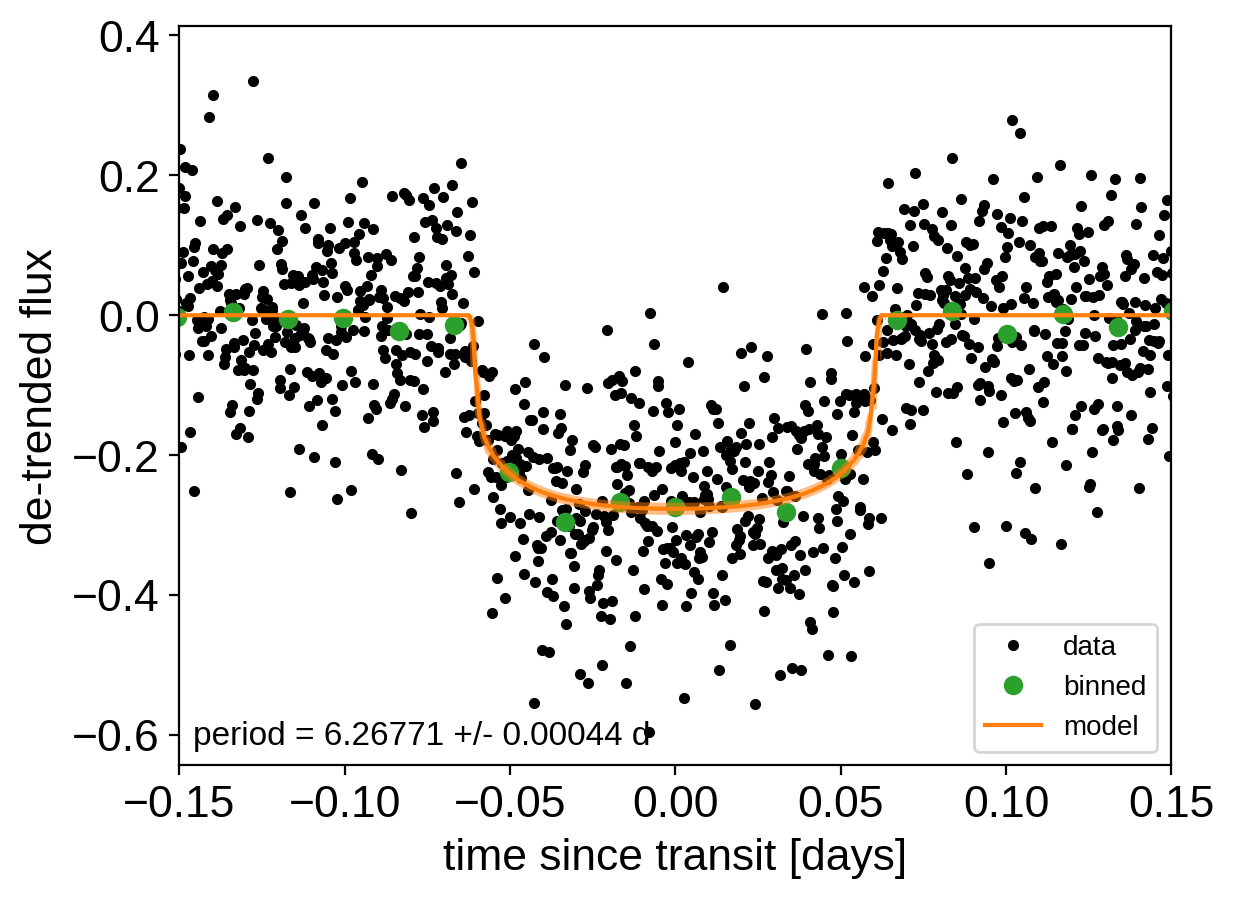

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, "o", color="C2",
         label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points", 
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

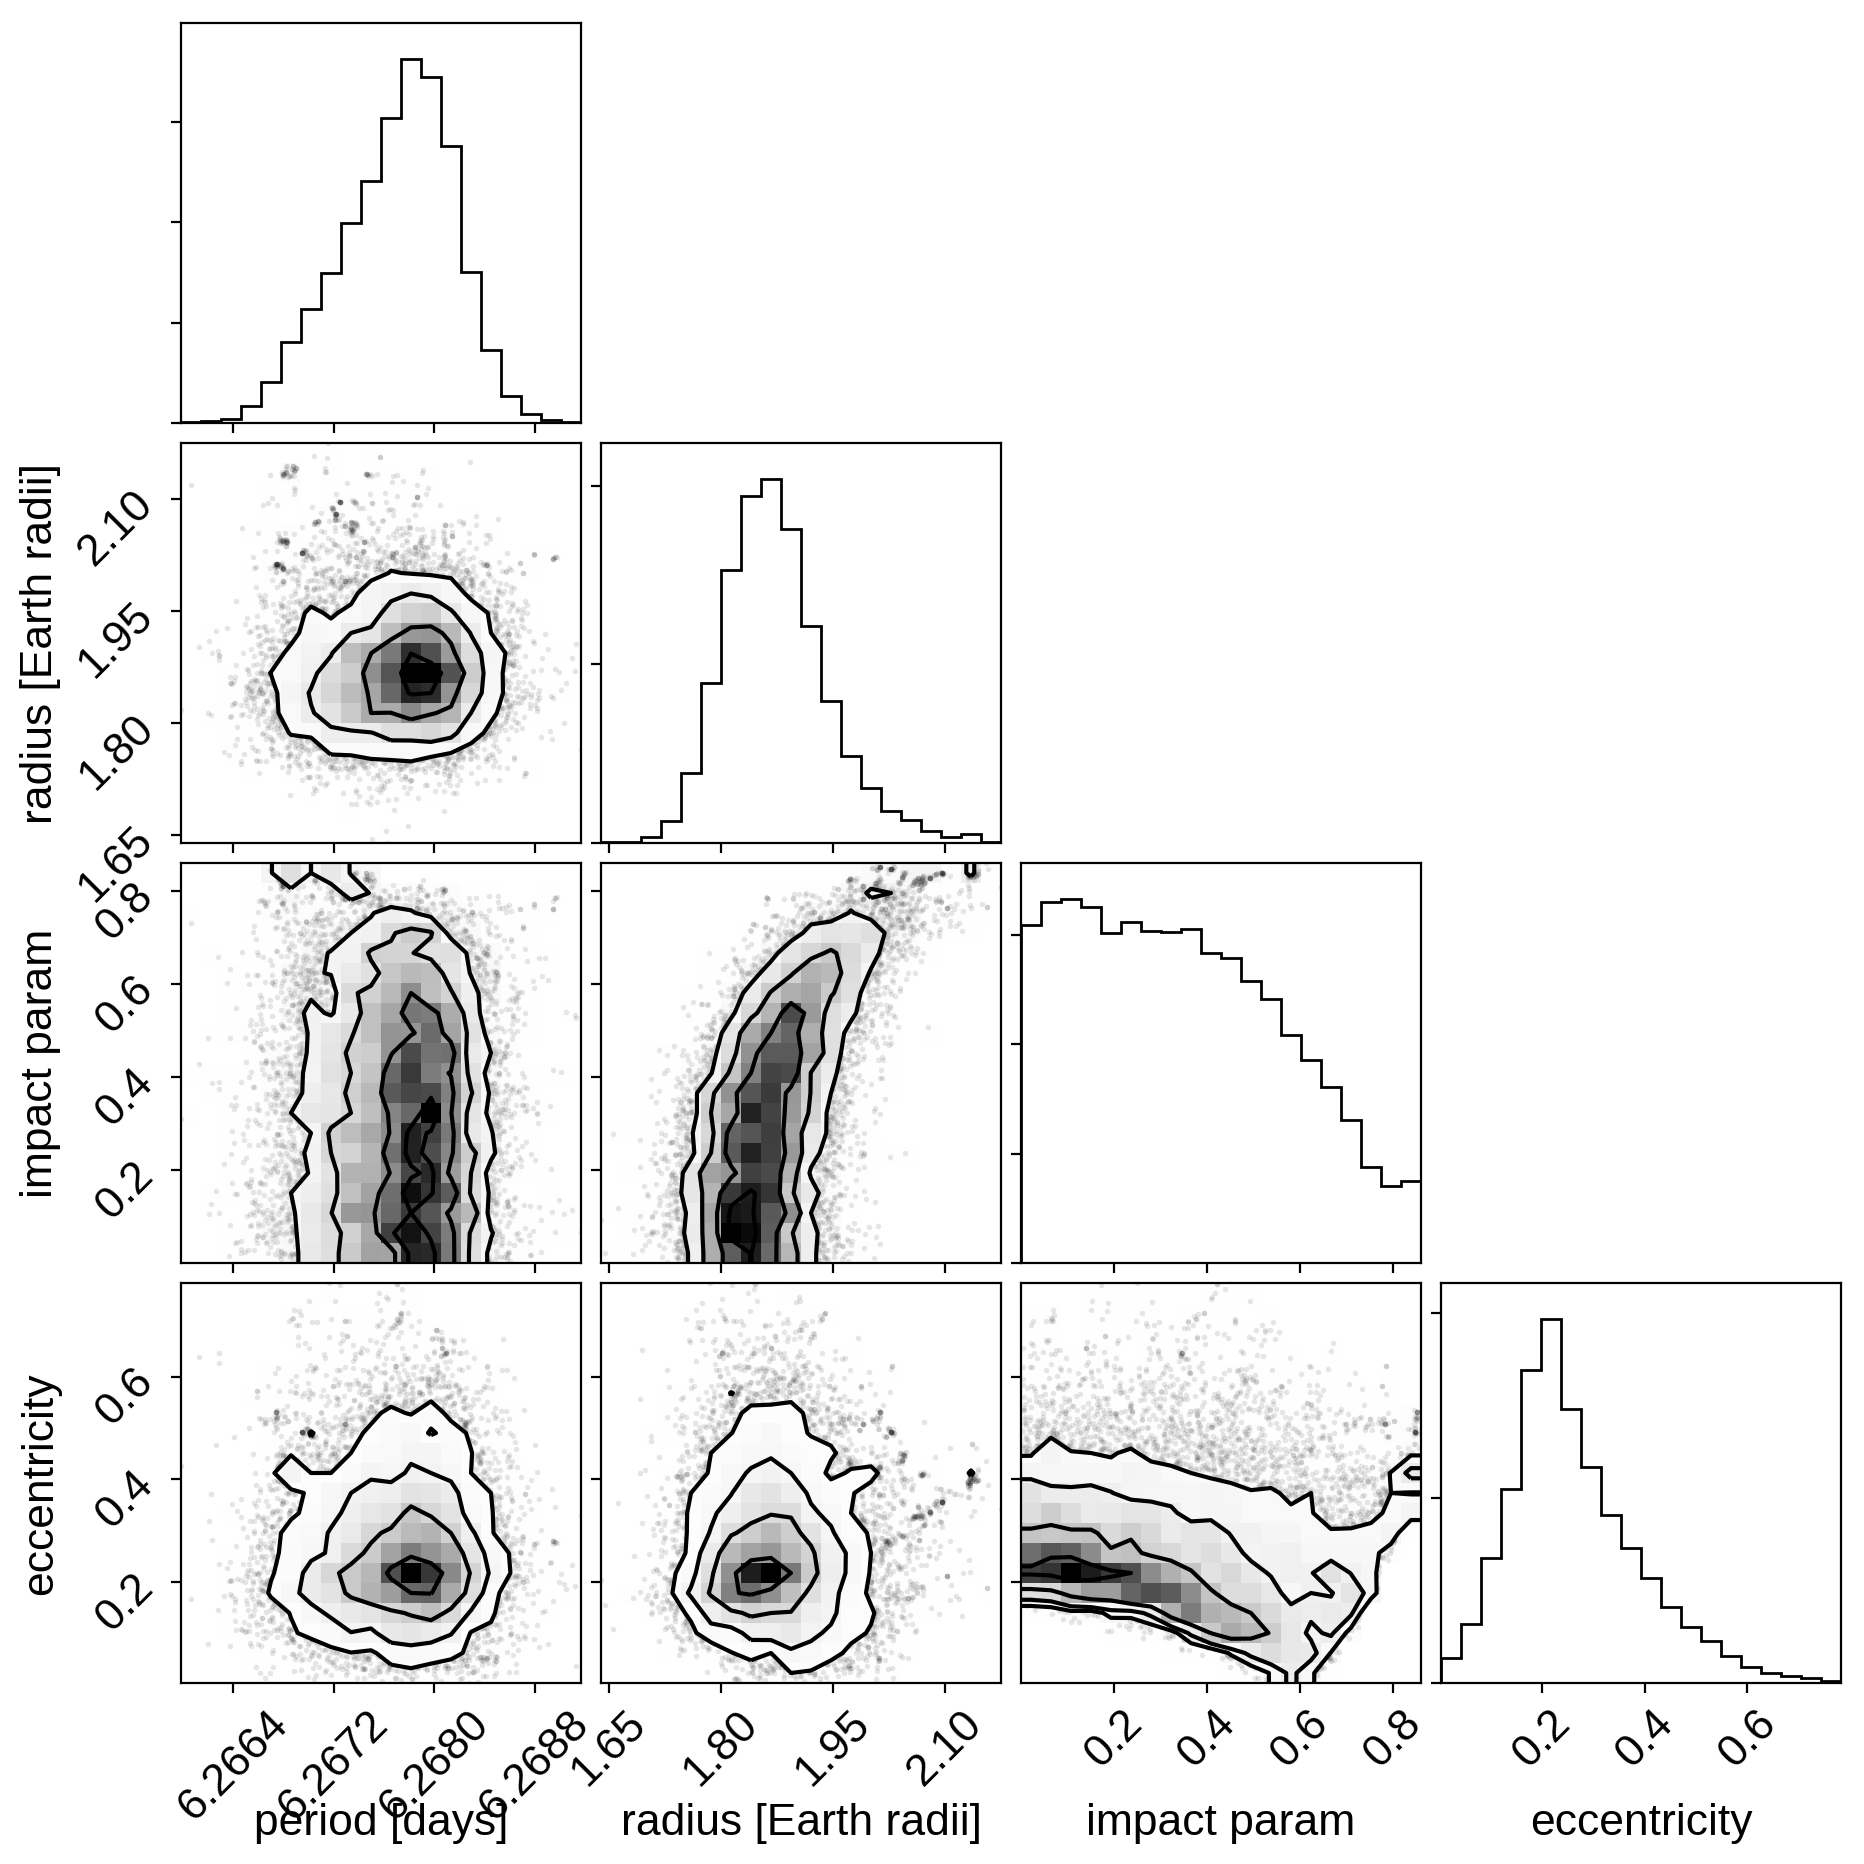

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"]);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [19]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [20]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
